In [79]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image
import pandas as pd
import json
import pickle

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns
from itertools import product
import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib


### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..')) ## use relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))

## import utils from git submodule
sys.path.append("block_utils/")
import blockworld_utils as utils
import domino_settings as dominoes

In [2]:
# setup
block_dims = dominoes.block_dims
block_colors = dominoes.block_colors
world_width = dominoes.world_width
world_height = dominoes.world_height
world_center = dominoes.world_center
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']

# convert dictionary representations of towers to (hashable) tuple and back
def world_dicts_to_tuples(wd):
    wt = tuple((block['x'],block['y'],block['height'],block['width']) for block in wd)
    return wt

def world_tuples_to_dicts(wt):
    wd = [{'x': block[0],
             'y': block[1],
             'height': block[2],
             'width': block[3]} for block in wt]
    return wd


# helper functions to reduce set of towers

def sort_blocks(stim_list):
    # sort the blocks within a tower to find unique towers
    sorted_list = [sorted(tower, key = lambda block: (block['y'],block['x'],block['height'],block['width'])) # SWAPPED X AND Y POSITIONS IN TUPLE HERE
     for tower in stim_list]
    
    return sorted_list


def align_towers(stim_list):
    # place leftmost block in position 0
    # by subtracting min x ordinate from all x-values

    min_xs = [min([block['x'] for block in tower]) for tower in stim_list]

    aligned_towers = [[{'x': block['x'] - min_x,
       'y': block['y'],
       'height': block['height'],
       'width': block['width']}
      for block in tower] for (tower, min_x) in zip(stim_list, min_xs)]
    
    return aligned_towers

def convert_to_tuples(stim_list):
    return [world_dicts_to_tuples(tower) for tower in stim_list]

def find_unique_towers(stim_list):
    return set(stim_list)


In [3]:
# composition functions copied from paired_tower_stim_generator
# these maximally squish the two towers together, rather than placing side by side

def compose_vertically(stim_a, stim_b): 
    
    world = utils.worldify(stim_a, 
                         block_dims = block_dims, 
                         block_colors = block_colors,)

    tower_a_height = world.tower_height()
    
    still_good = True
    
    for block in stim_b:
        placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
#         print(placed_block.y)
#         print(block['y']+tower_a_height)
#         print('this block good: ' + str(placed_block.y == (block['y'] + tower_a_height)))
        still_good = still_good and (placed_block.y == (block['y'] + tower_a_height))
#         print(still_good)
        
    return (still_good, world)

# compose horizontally

def compose_horizontally(stim_a, stim_b, keep_separable=True): 
    '''
    Composes two tall stimuli by placing them side by side.
    
    Tries placing tower 1, then 2 blocks to the right of it's left-aligned position.

    Rejects tower if width > 4 squares
    
    
    Want to assume that if you can build the towers one after the other, you can build them the other way around
    This should work given that each is an independent standing tower, but:
    NEED TO CHECK THAT IN EXPERIMENT YOU CAN SNAP A BLOCK UNDER ANOTHER IF NEEDED
    
    PRE: stims are maximum 3 wide
    '''
    
    still_good = False
    successful_alignment = None
    
    if keep_separable:
        alignments = [2]
    else:
        alignments = [1,2]
    
    for alignment in alignments:
        
        if still_good == False:

            # Try placing left tower first
            world = utils.worldify(stim_a, 
                                 block_dims = block_dims, 
                                 block_colors = block_colors,)

            still_good = True

            for block in stim_b:
                # place block 'alignment' squares to the right of its default position
                placed_block = world.snap_to_floor(block['width'], block['height'], block['x'] + alignment)
                # if it stays at the predefined height, we're good
                still_good = still_good and (placed_block.y == (block['y']))


            if not still_good:
                # Try placing right tower
                
                realigned_tower = [{'x': b['x'] + alignment,
                                     'y': b['y'],
                                     'height': b['height'],
                                     'width': b['width']}
                                              for b in stim_b]

                world = utils.worldify(realigned_tower, 
                                     block_dims = block_dims, 
                                     block_colors = block_colors,)

                still_good = True

                for block in stim_a:
                    # place block 'alignment' squares to the right of its default position
                    placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
                    # if it stays at the predefined height, we're good
                    still_good = still_good and (placed_block.y == (block['y']))
                    
                still_good = still_good and world.tower_width() <=4
                    
                
                
                if not still_good:
                    # try sorting
                    
                    stim_a_copy = stim_a.copy()
                    
                    sorted_stims = sort_blocks([stim_a_copy + realigned_tower])[0]

                    world = utils.World(block_dims = block_dims, 
                                        block_colors = block_colors,)
                    still_good = True

                    for block in sorted_stims:
                        # place block 'alignment' squares to the right of its default position
                        placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
                        # if it stays at the predefined height, we're good
                        still_good = still_good and (placed_block.y == (block['y']))
                
                


            still_good = still_good and world.tower_width() <=4
            
            if still_good:
                successful_alignment = alignment
            

    return (still_good, world, successful_alignment)



## Create tower set

### Enumerate scenes made from n block placements (n in {1..5})

In [4]:
world_width = 8
world_height = 8

max_blocks = 5

scenes = {}

# single block in center of world
scenes[1] = []

for block in block_dims:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.add_block(block[0], # width
                block[1], # height
                world_center,0)
    scenes[1].append(w.get_block_dict()['blocks'])


# add a block in all available locations to all existing towers of n-1 blocks
for n_blocks in range(2,max_blocks+1):
    scenes[n_blocks] = []

    # add block in position
    for scene_blocks in scenes[n_blocks-1]:
        for block in block_dims:
            for x in range(0, world_width-1):
                #repopulate world
                w = utils.World(block_dims = block_dims,
                                block_colors = block_colors)
                w.populate_from_block_list(scene_blocks)

                #add new block
                w.snap_to_floor(block[0], # width
                            block[1], # height
                            x)
                scenes[n_blocks].append(w.get_block_dict()['blocks'])


### Filter duplicate towers

#### sort blocks in scene

In [5]:
scenes_sorted_blocks = {i : sort_blocks(scene_list) for _, (i, scene_list) in enumerate(scenes.items())}

####  translational invariance- align all scenes to left

In [6]:
scenes_aligned_blocks = {i : align_towers(scene_list) for _, (i, scene_list) in enumerate(scenes_sorted_blocks.items())}

####  find unique scene (i.e. same blocks in same place)

In [7]:
# convert to tuples for easy set operations
tower_tuples = {i : convert_to_tuples(scene_list) for _, (i, scene_list) in enumerate(scenes_aligned_blocks.items())}

# now scenes are sorted and aligned, find unique scenes
unique_scenes_tuples = {i : find_unique_towers(scene_list) for _, (i, scene_list) in enumerate(tower_tuples.items())}

# convert back to dictionary for easier tower-operations
unique_scenes_dicts = {i : [world_tuples_to_dicts(tower) for tower in scene_list]
                           for _, (i, scene_list) in enumerate(unique_scenes_tuples.items())}

In [8]:
print('Unique block scenes (same blocks in same place):')
_ = [print(str(i) + ' block: ' + str(len(unique_scenes_dicts[i]))) for i in unique_scenes_dicts.keys()]

Unique block scenes (same blocks in same place):
1 block: 2
2 block: 18
3 block: 162
4 block: 1234
5 block: 8384


#### Convert to dataframe with metadata

In [10]:
df_scenes = pd.DataFrame()

for _, (i, scene_list) in enumerate(unique_scenes_dicts.items()):
    for scene in scene_list:
        world = utils.worldify(scene) # convert to world object
        
        df_scenes = df_scenes.append(
        {
            'stim': scene,
            'scene_tuple': world_dicts_to_tuples(scene),
            'n_blocks': i,
            'fully_connected': world.fully_connected(connectivity=1),
            'fully_connected_diag': world.fully_connected(connectivity=2),
            'blocks_above_ground': world.n_blocks_above_ground(),
            'tower_height': world.tower_height(),
            'tower_width': world.tower_width(),
            'two_h_two_v': world.two_h_two_v(),
            'silhouette': world.block_map
        }, ignore_index=True).astype(object)
        
df_scenes['fully_connected'] = df_scenes['fully_connected'].astype(bool)
df_scenes['fully_connected_diag'] = df_scenes['fully_connected_diag'].astype(bool)
df_scenes['two_h_two_v'] = df_scenes['two_h_two_v'].astype(bool)

df_scenes['silhouette_str'] = df_scenes['silhouette'].apply(utils.convert_to_str)

# df_scenes = df_scenes.sort_values('silhouette_str').reset_index()

In [11]:
df_scenes = df_scenes.sort_values('n_blocks').reset_index()

### Filter scenes that are not plausibly 'towers' (i.e. spatially contiguous, too sprawling)

In [12]:
# These can be changed

df_towers = df_scenes[(df_scenes.n_blocks <= 4) & 
                      (df_scenes.fully_connected) & 
                      (df_scenes.tower_width <= 4)]

### Visualize individual towers

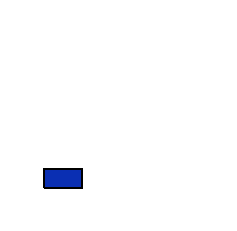

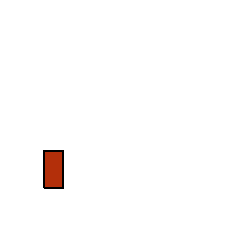

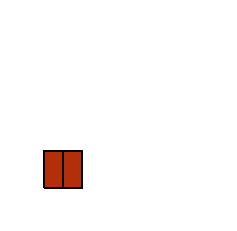

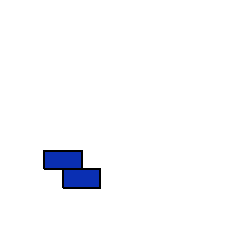

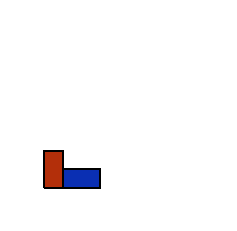

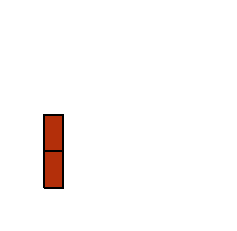

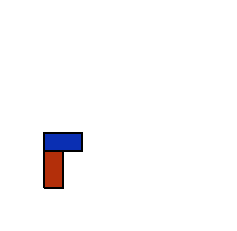

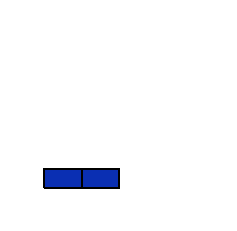

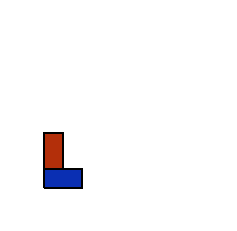

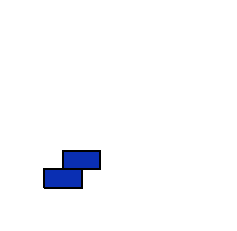

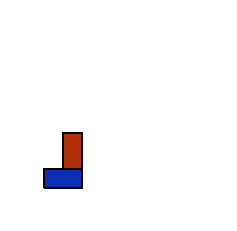

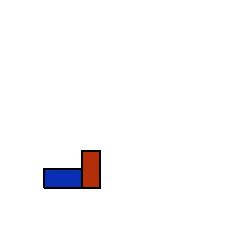

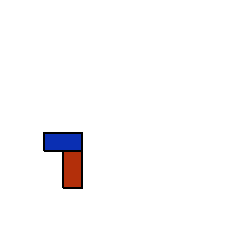

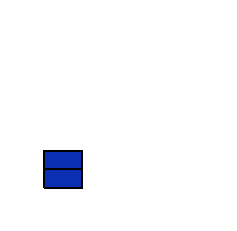

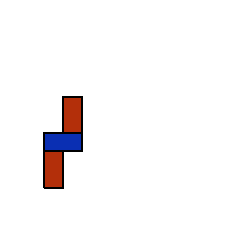

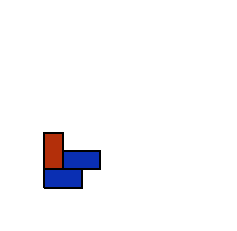

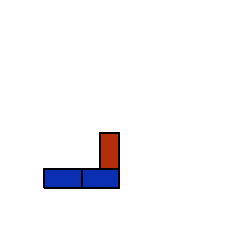

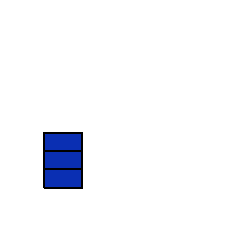

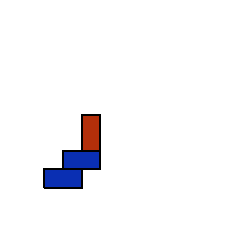

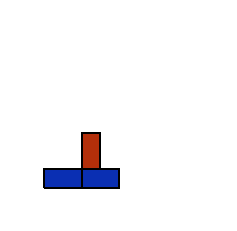

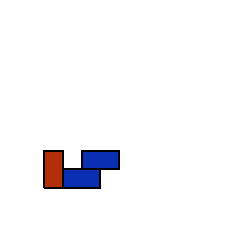

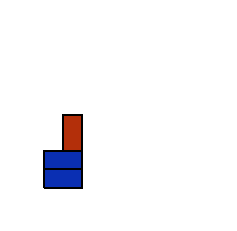

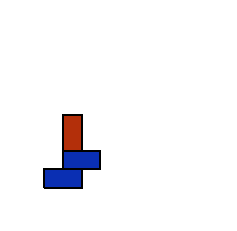

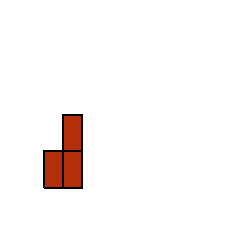

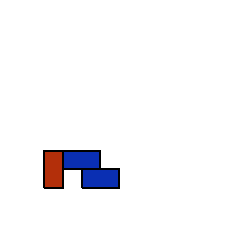

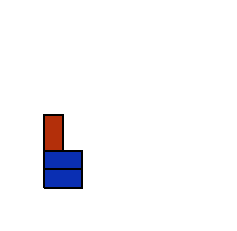

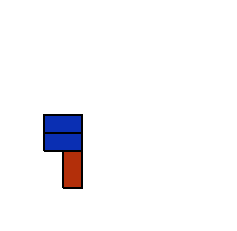

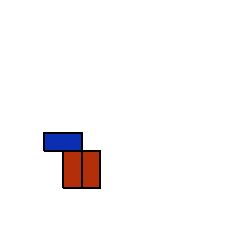

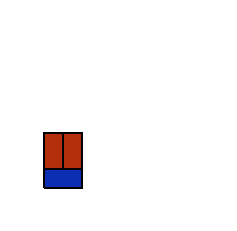

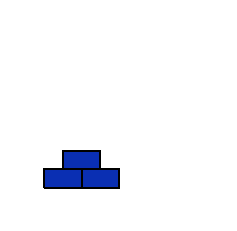

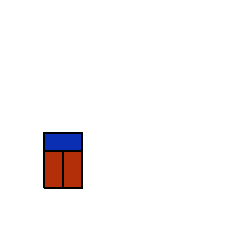

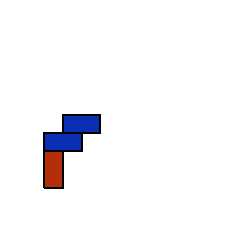

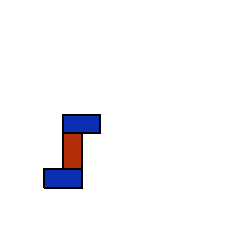

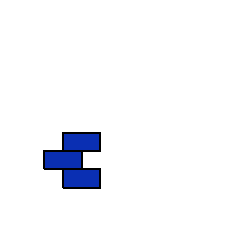

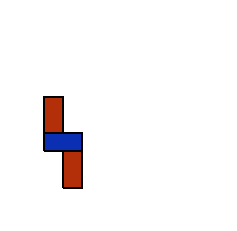

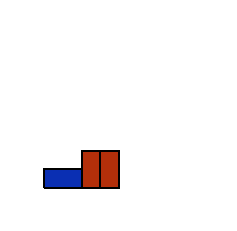

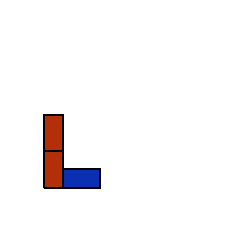

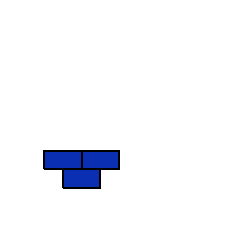

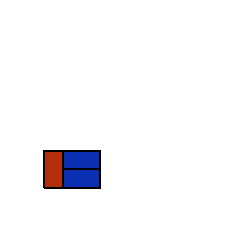

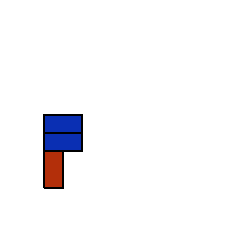

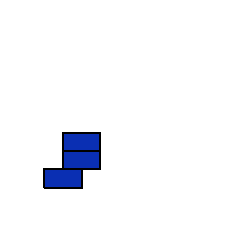

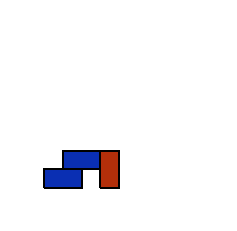

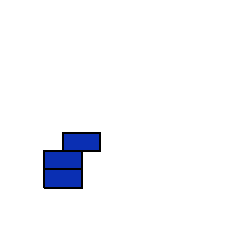

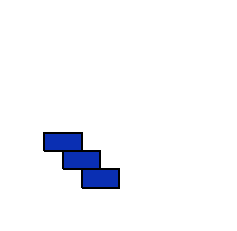

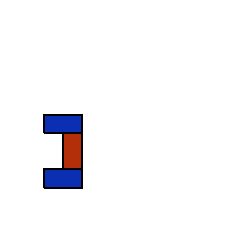

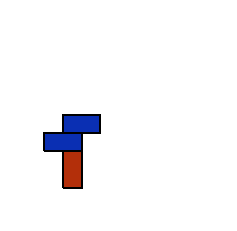

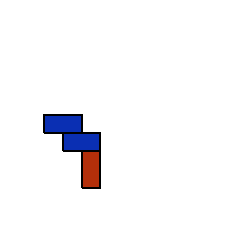

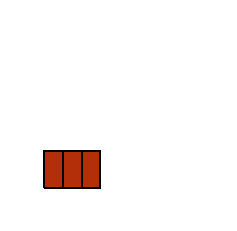

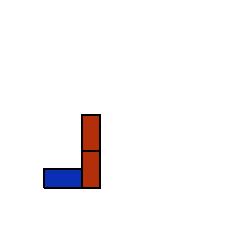

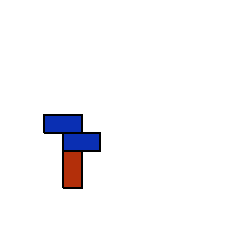

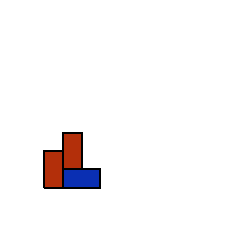

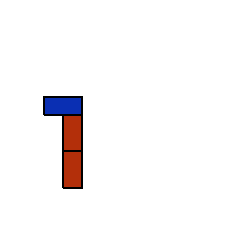

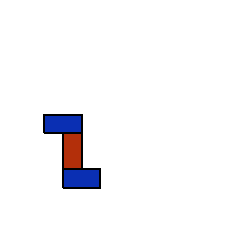

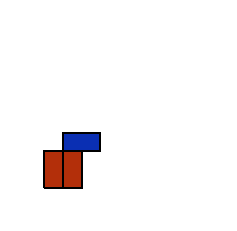

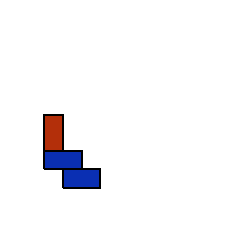

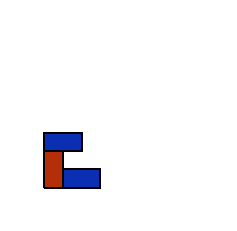

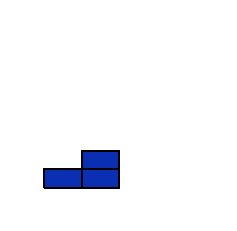

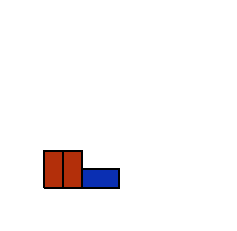

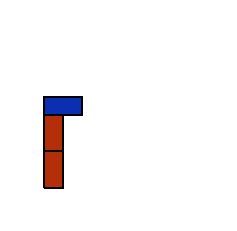

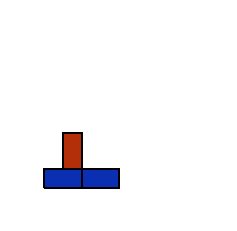

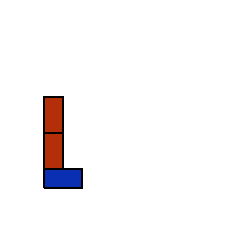

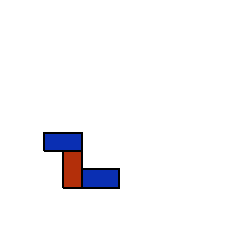

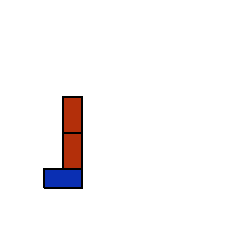

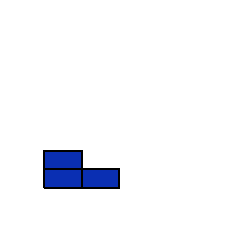

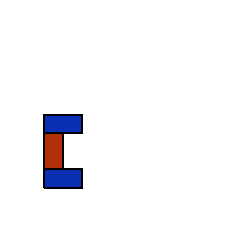

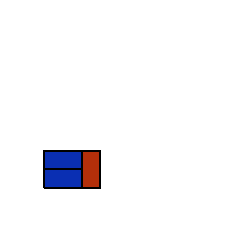

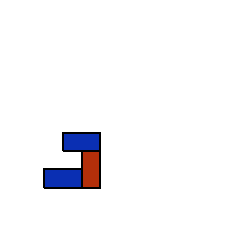

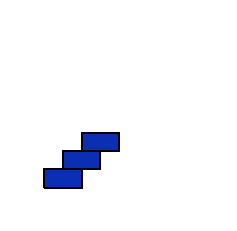

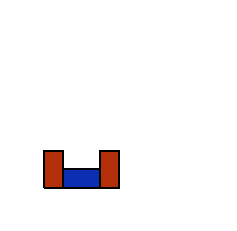

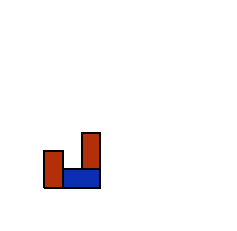

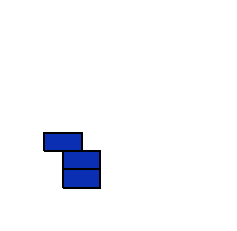

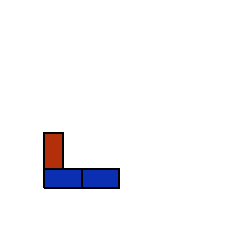

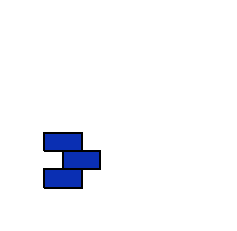

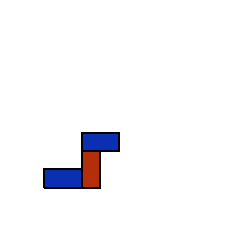

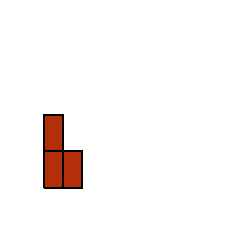

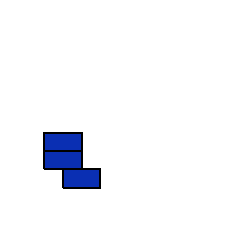

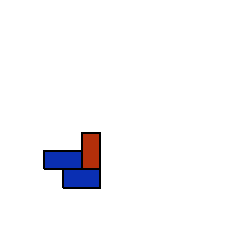

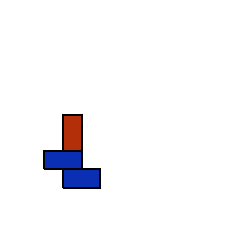

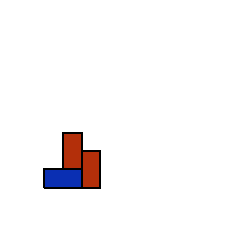

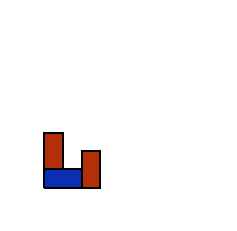

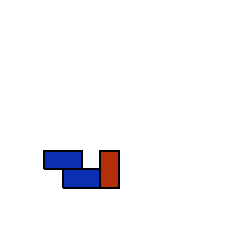

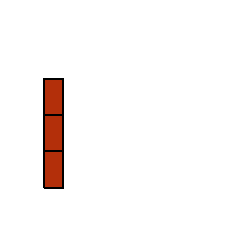

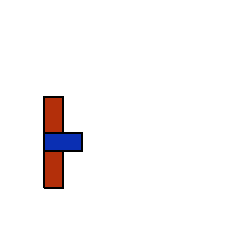

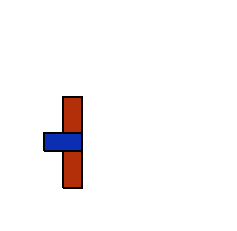

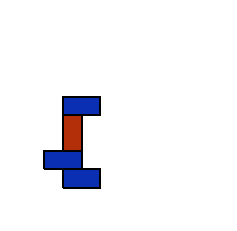

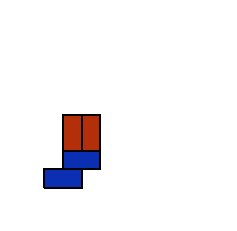

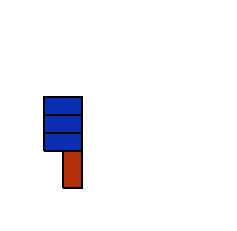

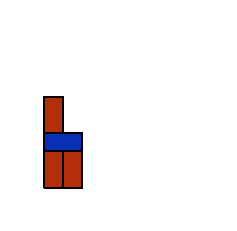

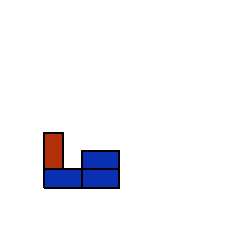

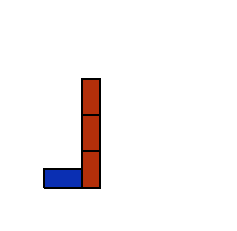

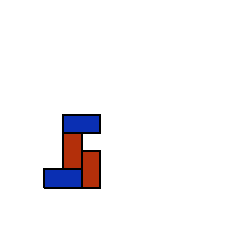

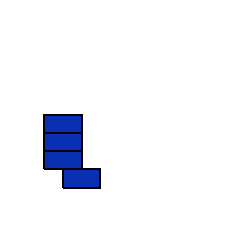

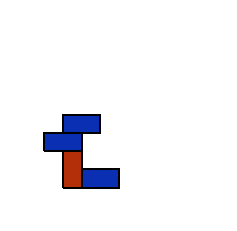

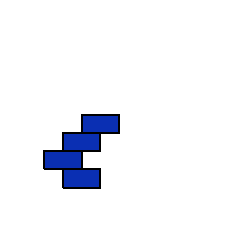

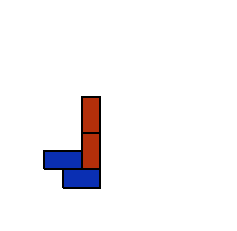

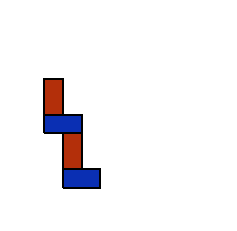

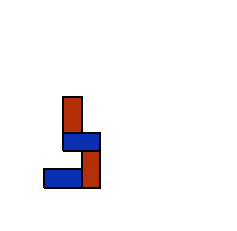

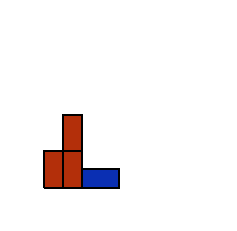

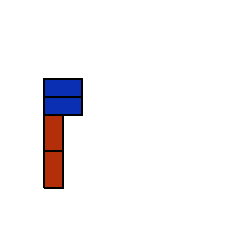

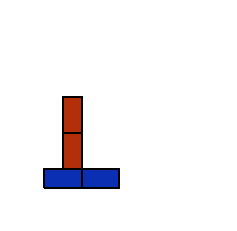

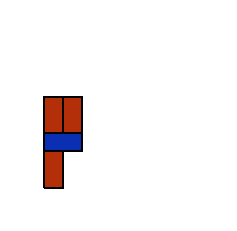

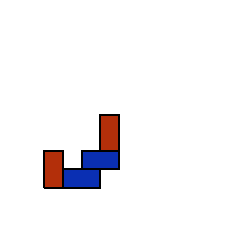

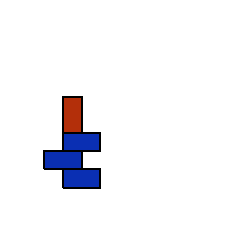

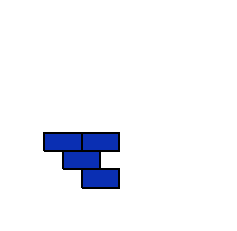

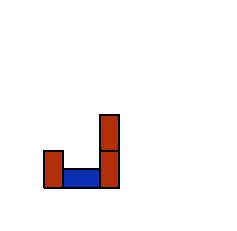

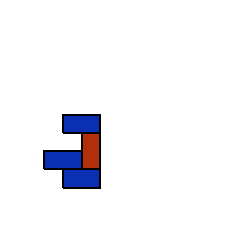

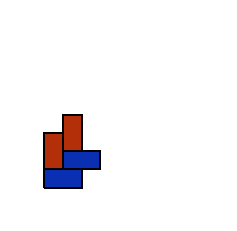

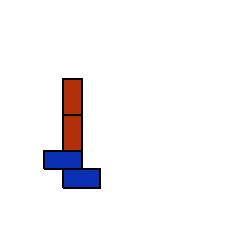

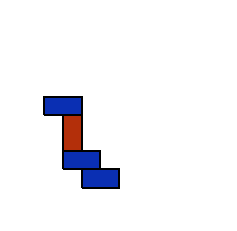

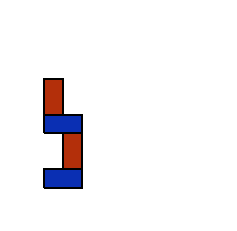

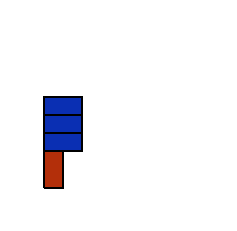

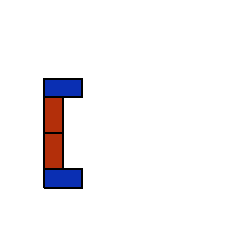

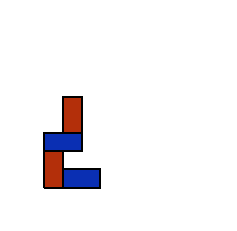

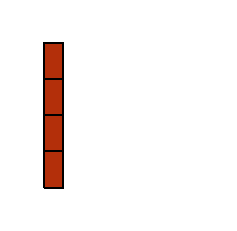

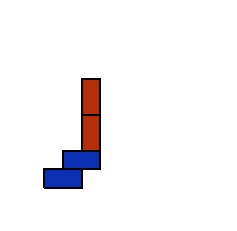

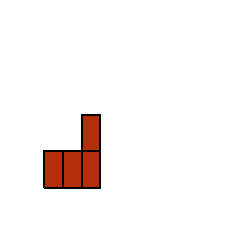

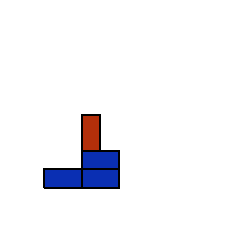

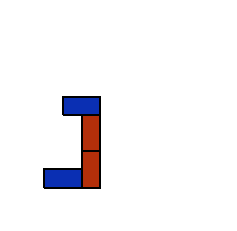

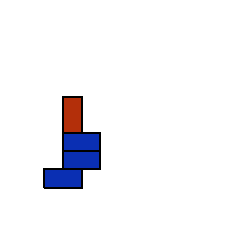

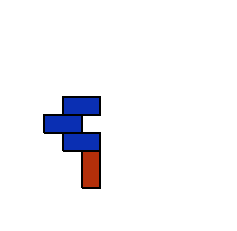

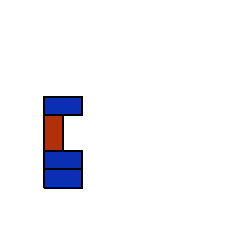

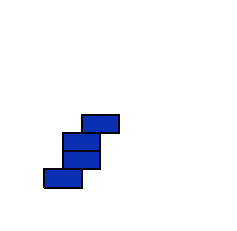

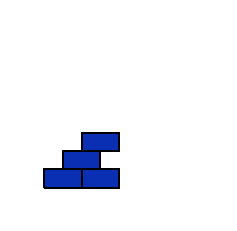

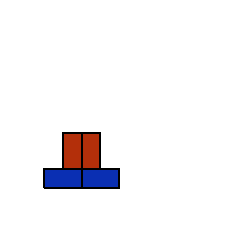

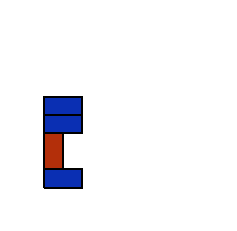

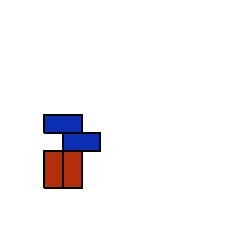

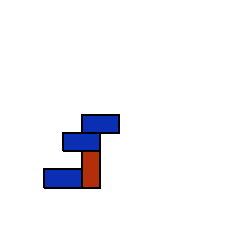

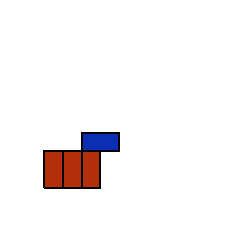

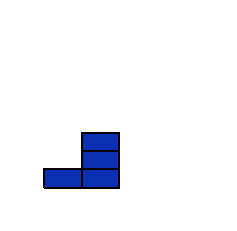

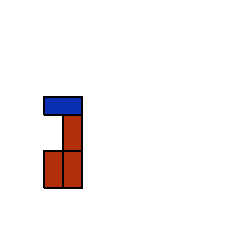

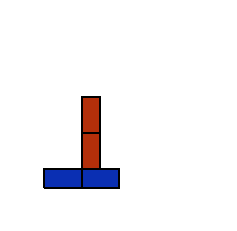

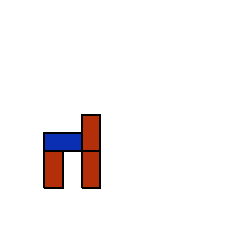

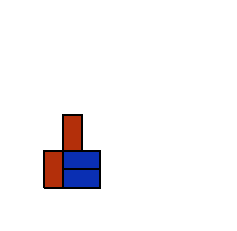

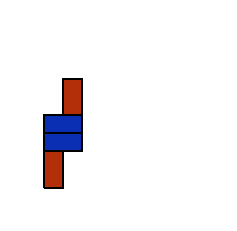

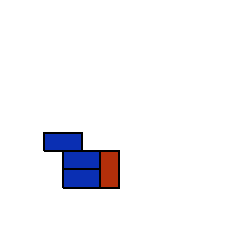

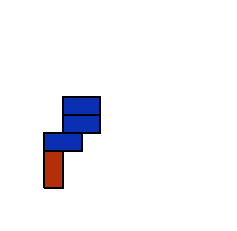

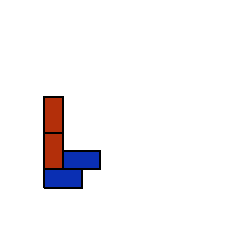

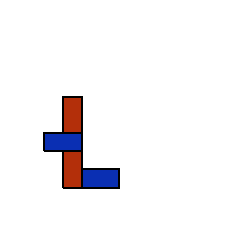

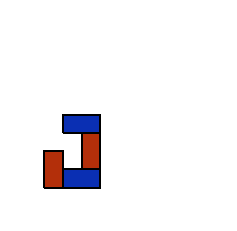

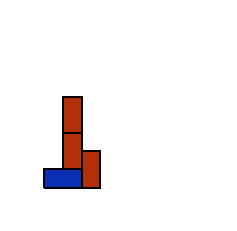

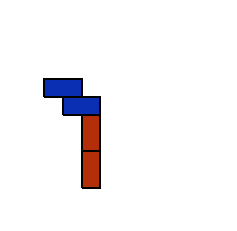

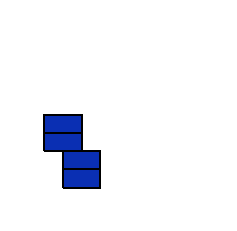

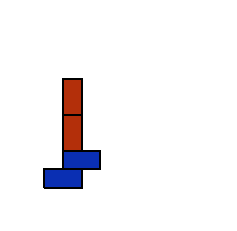

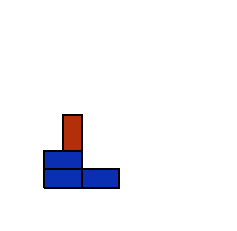

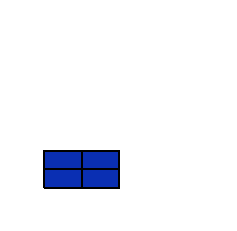

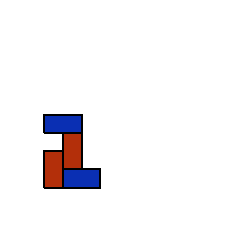

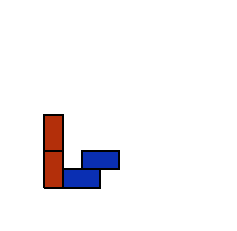

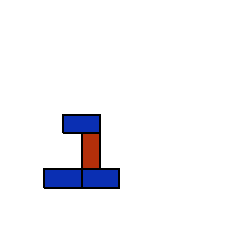

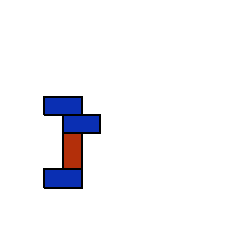

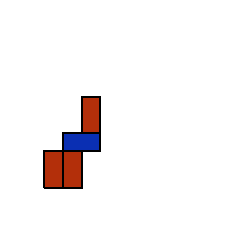

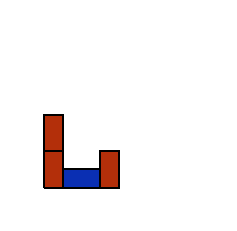

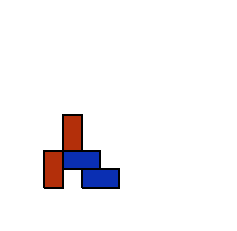

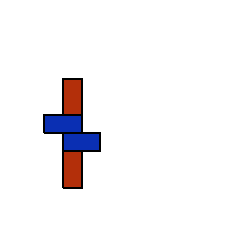

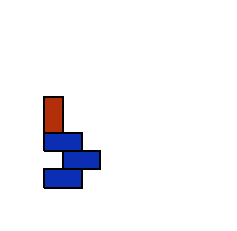

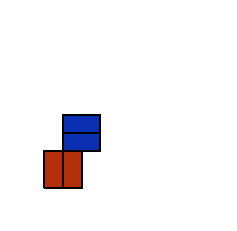

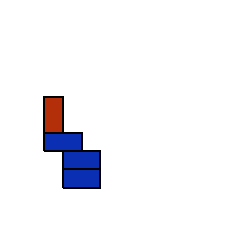

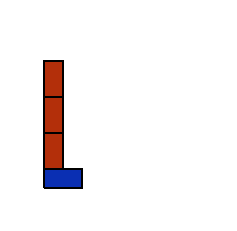

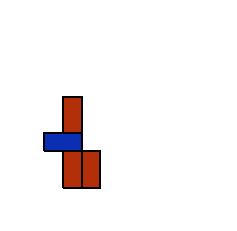

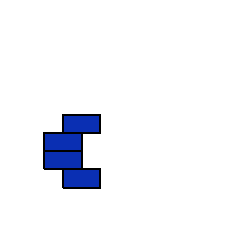

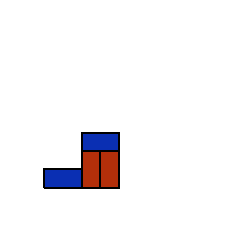

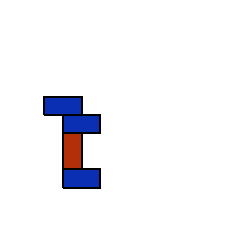

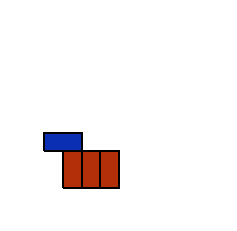

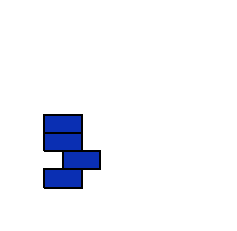

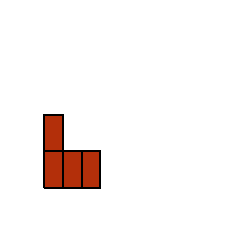

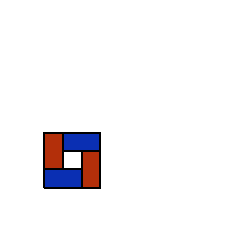

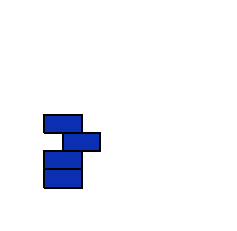

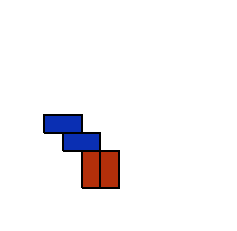

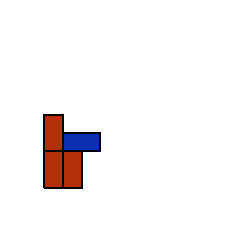

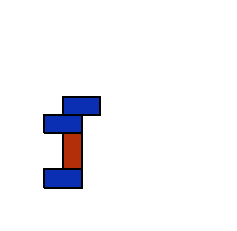

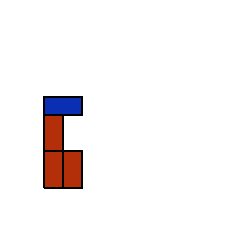

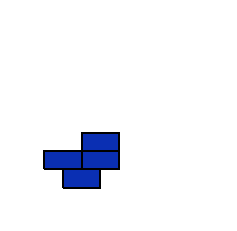

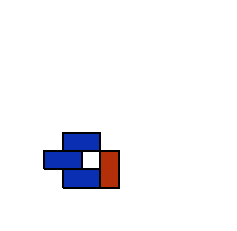

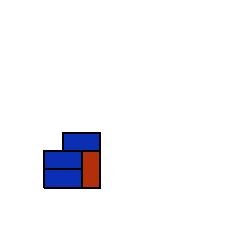

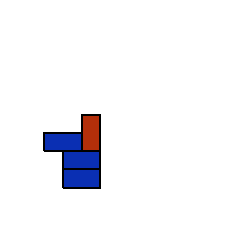

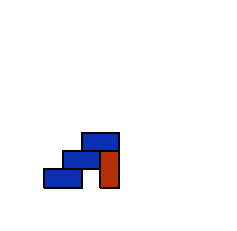

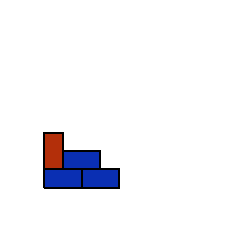

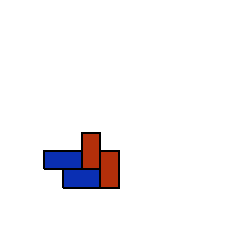

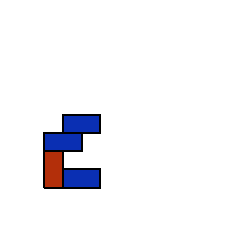

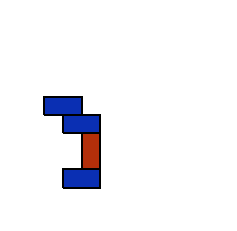

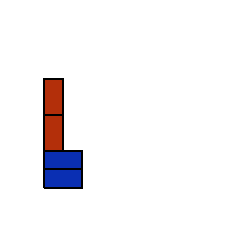

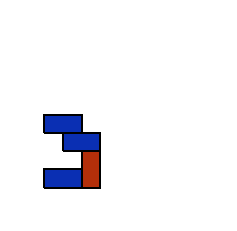

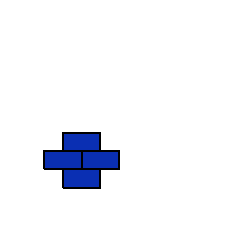

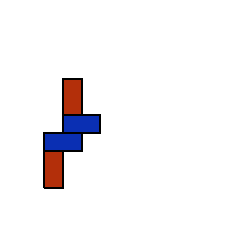

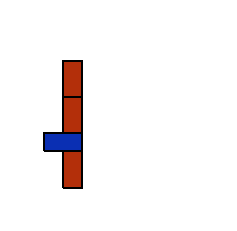

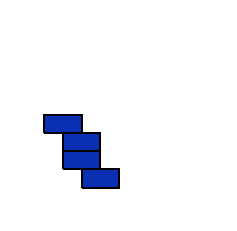

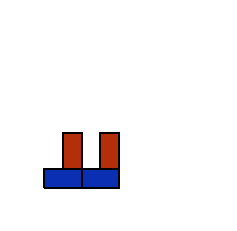

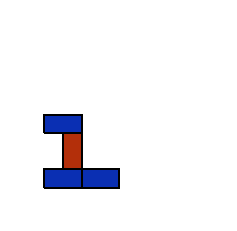

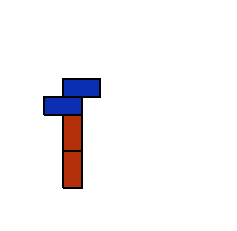

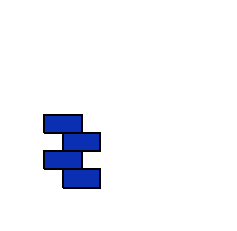

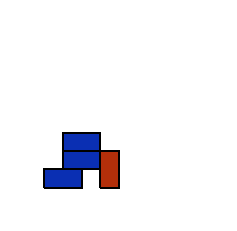

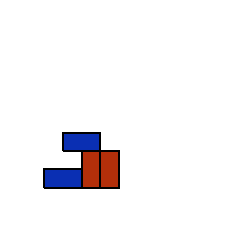

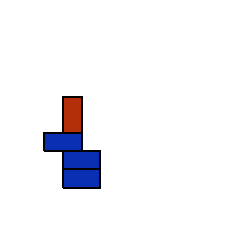

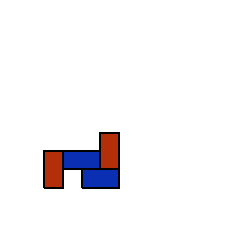

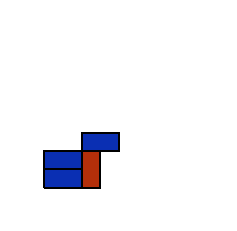

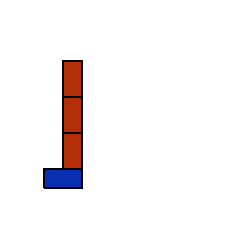

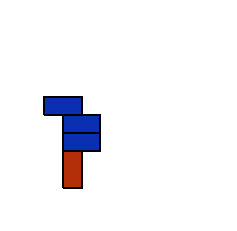

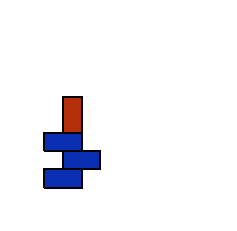

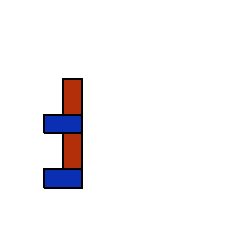

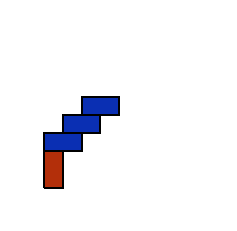

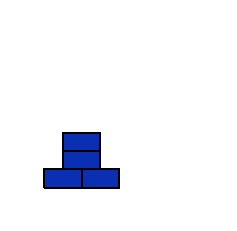

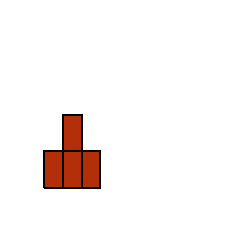

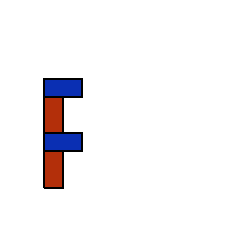

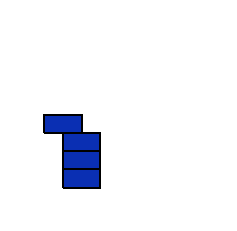

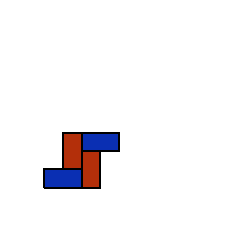

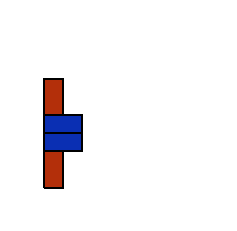

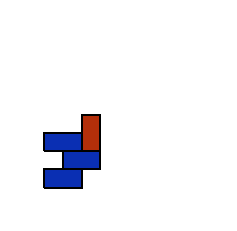

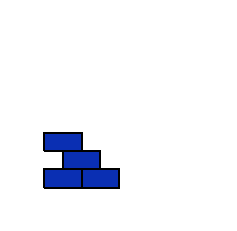

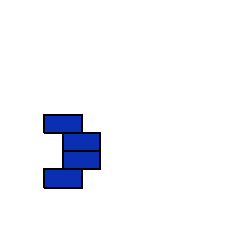

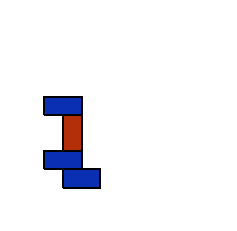

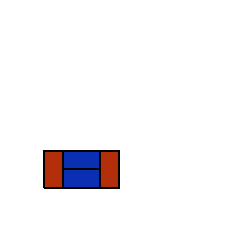

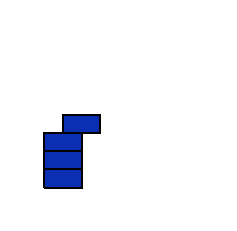

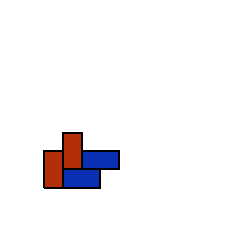

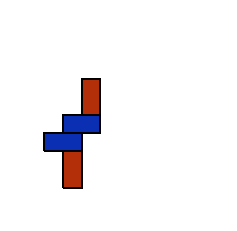

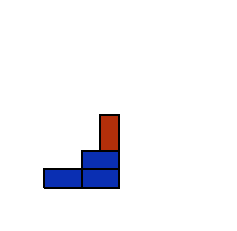

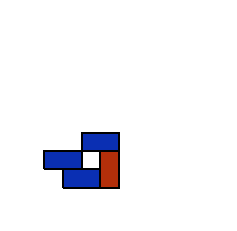

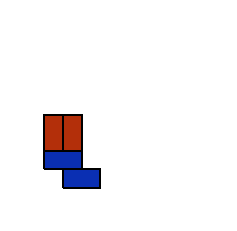

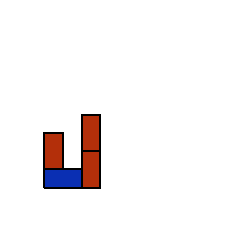

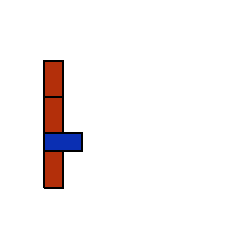

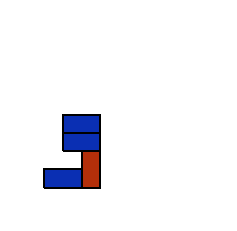

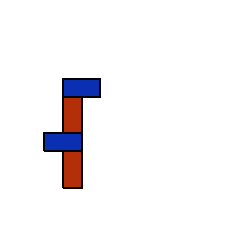

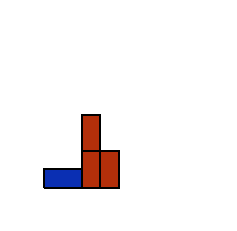

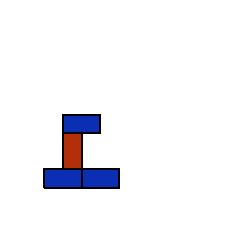

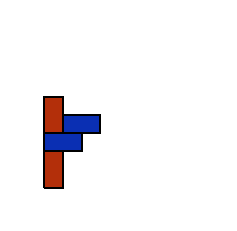

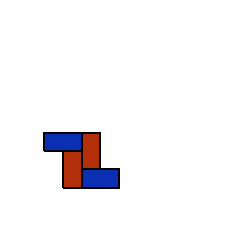

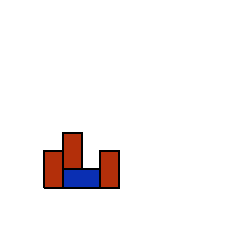

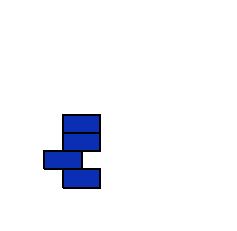

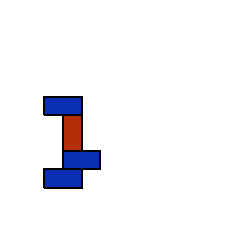

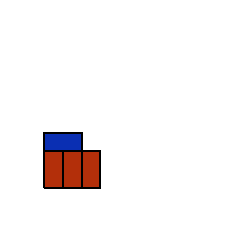

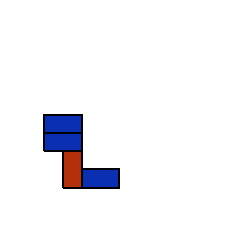

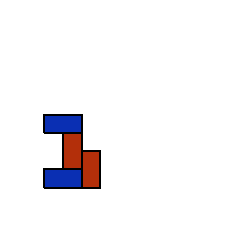

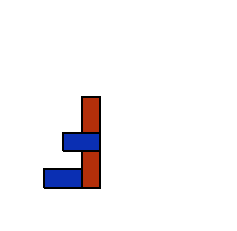

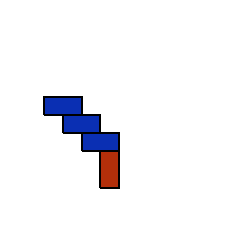

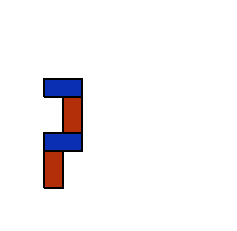

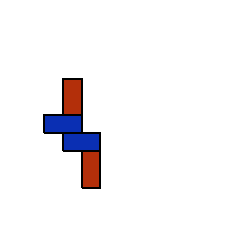

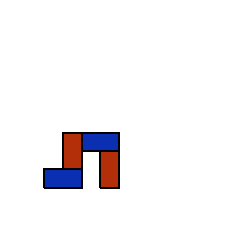

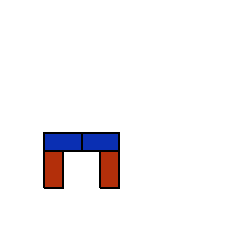

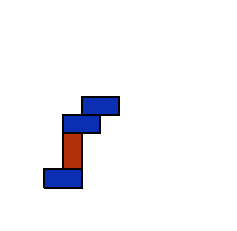

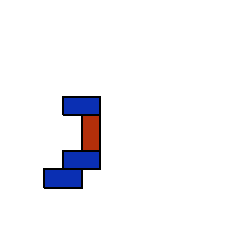

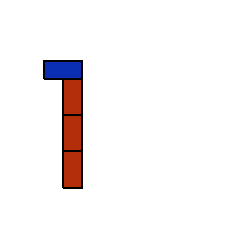

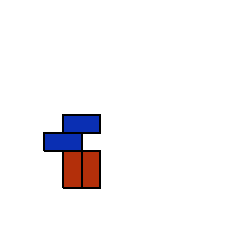

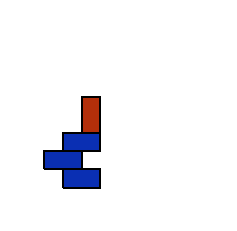

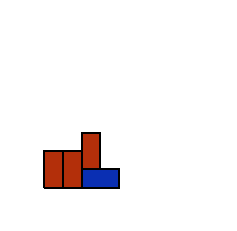

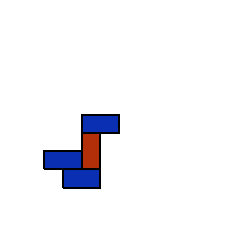

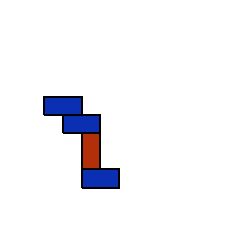

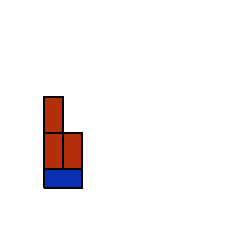

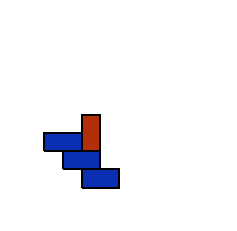

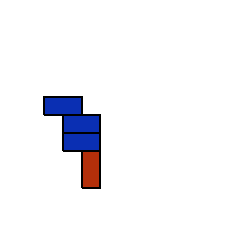

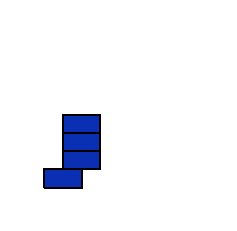

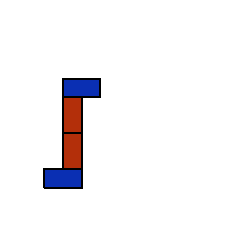

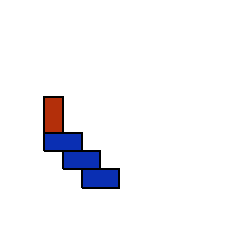

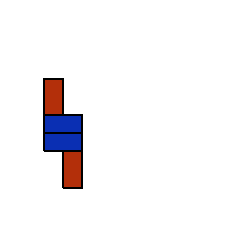

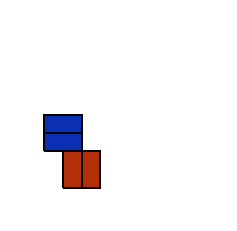

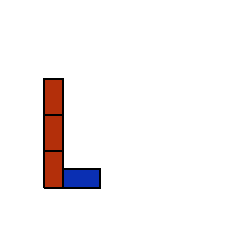

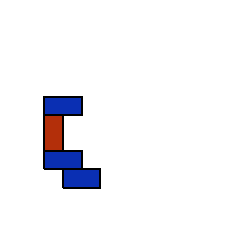

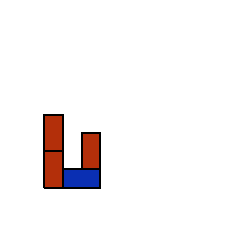

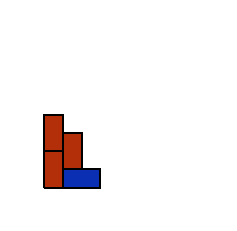

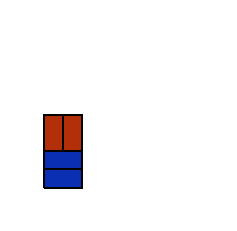

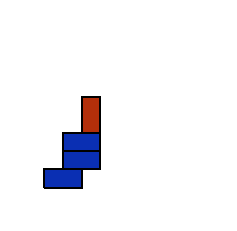

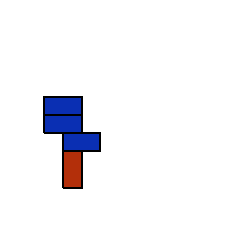

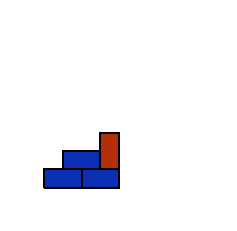

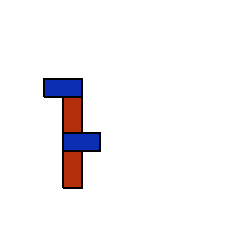

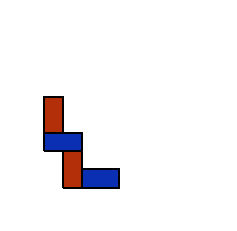

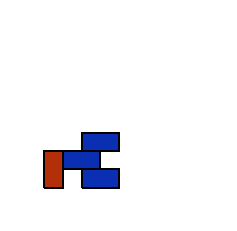

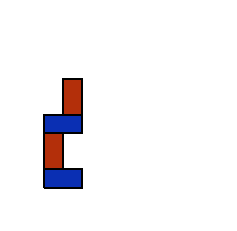

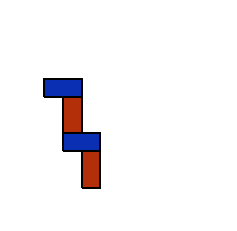

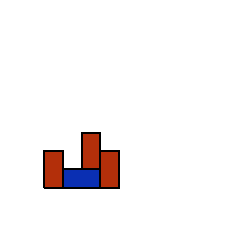

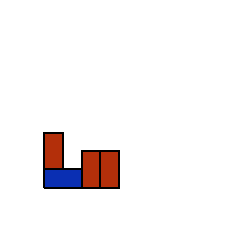

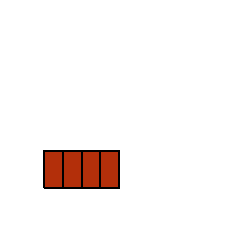

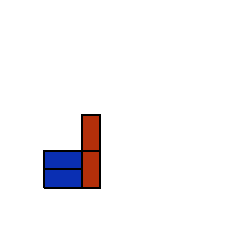

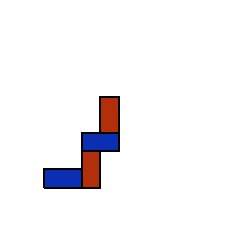

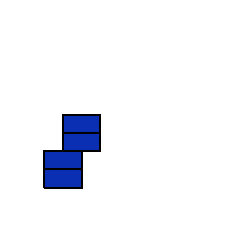

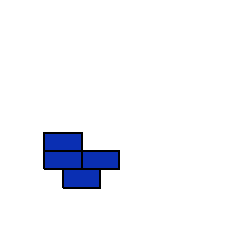

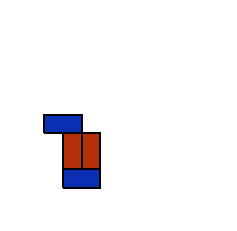

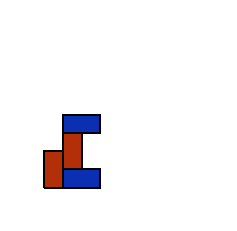

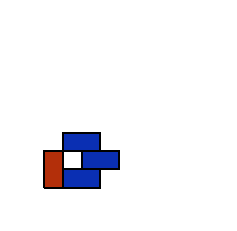

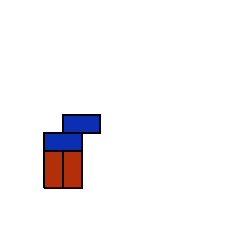

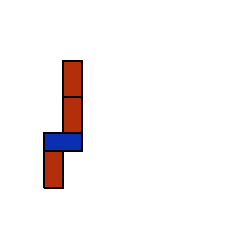

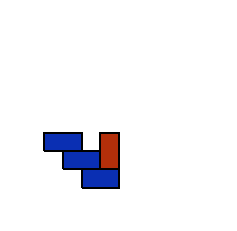

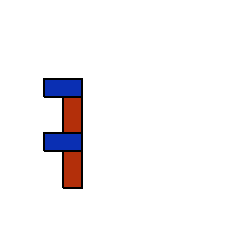

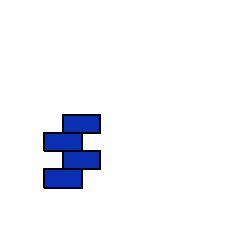

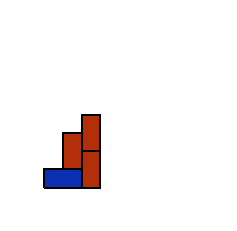

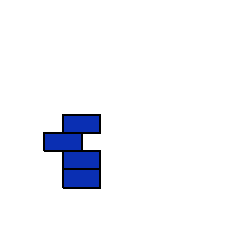

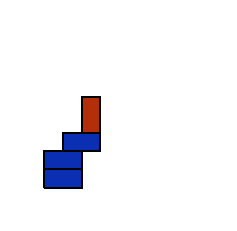

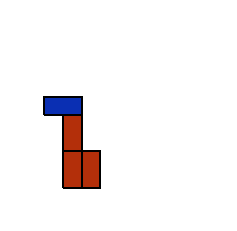

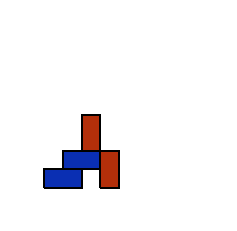

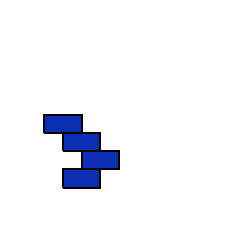

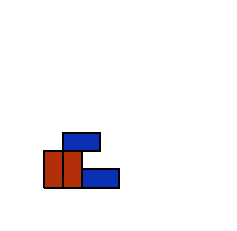

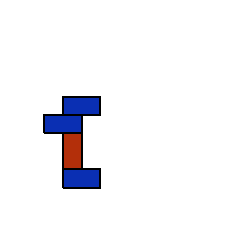

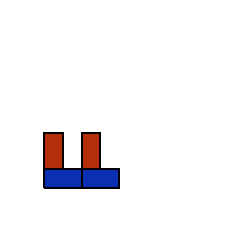

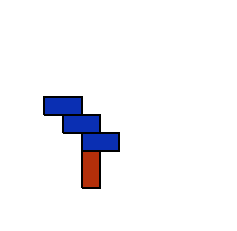

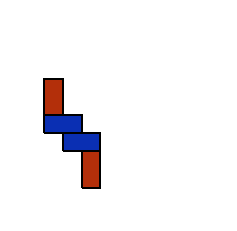

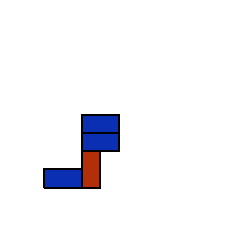

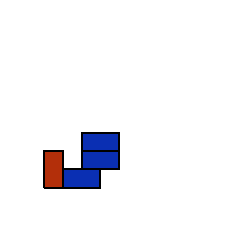

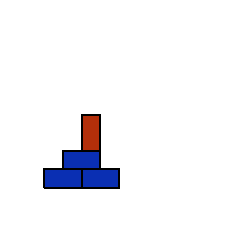

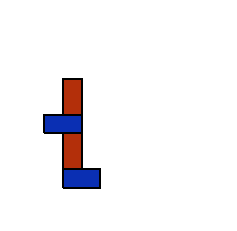

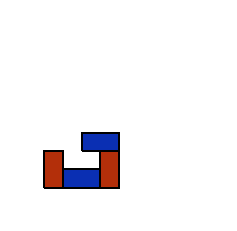

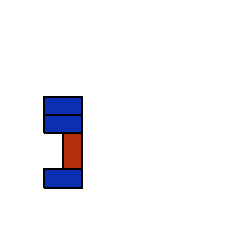

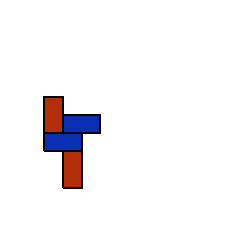

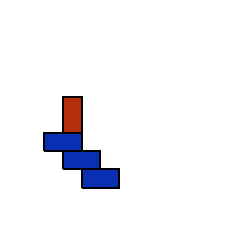

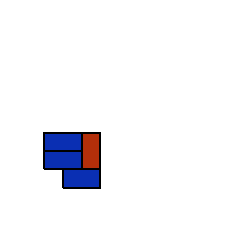

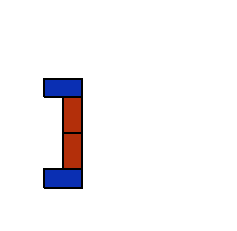

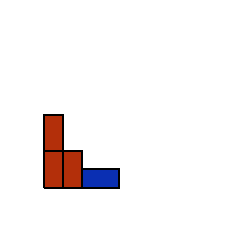

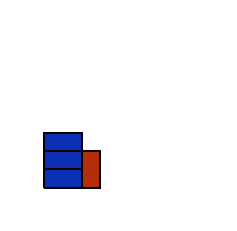

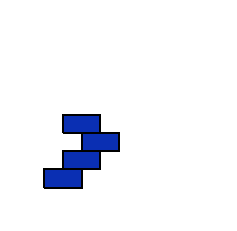

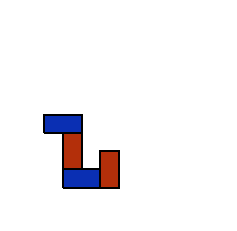

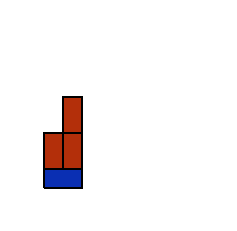

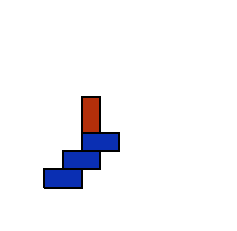

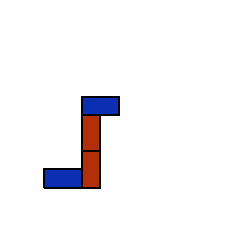

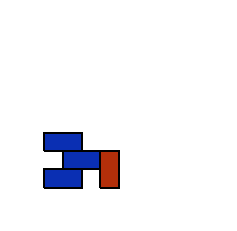

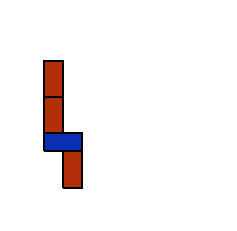

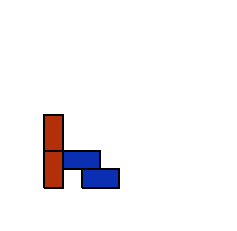

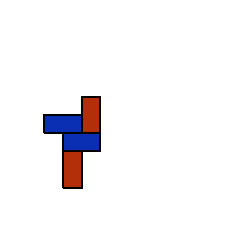

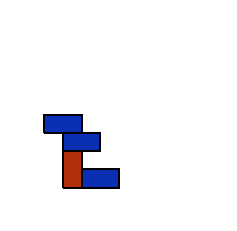

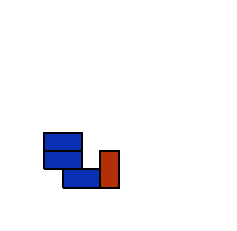

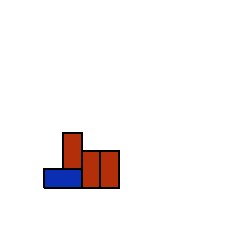

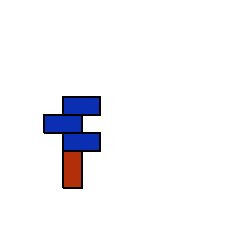

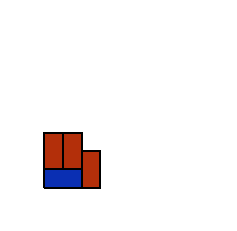

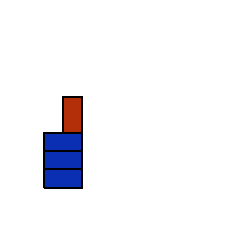

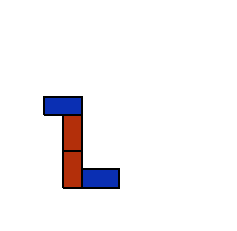

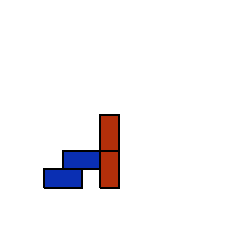

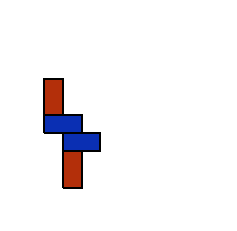

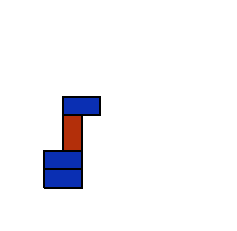

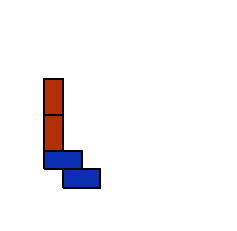

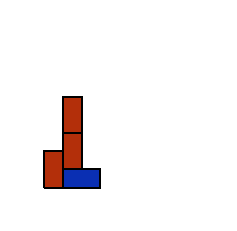

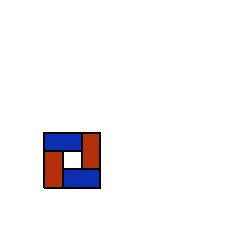

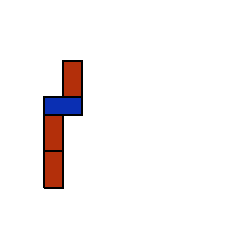

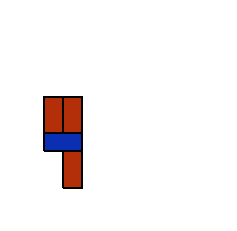

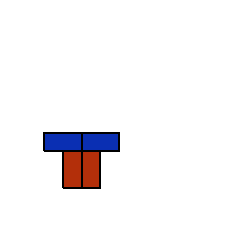

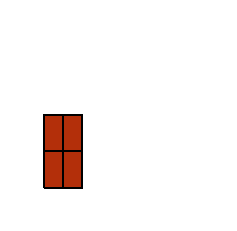

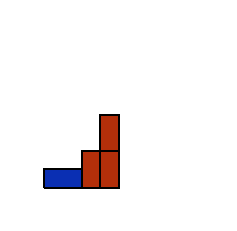

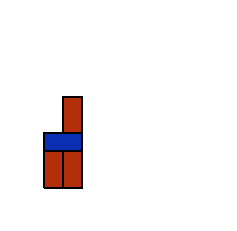

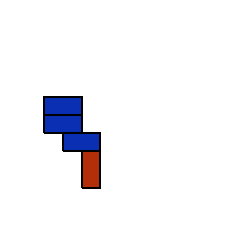

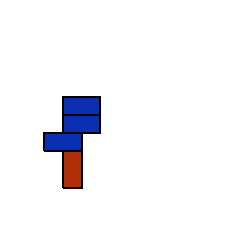

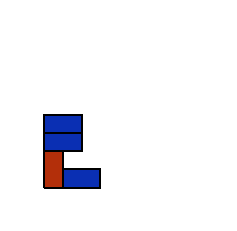

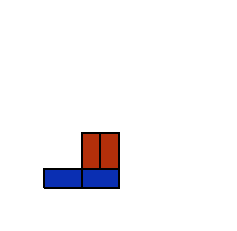

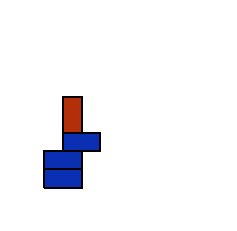

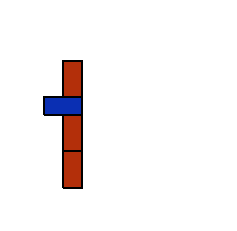

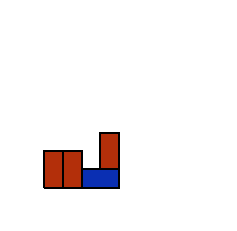

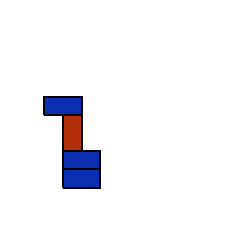

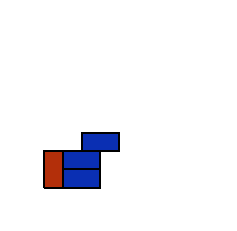

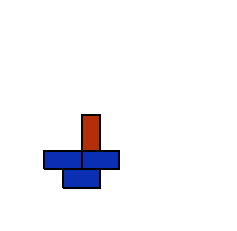

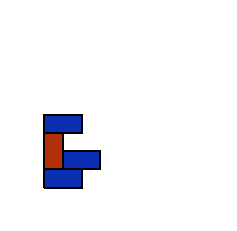

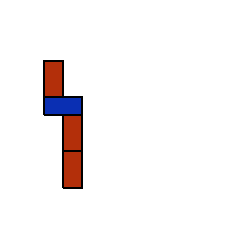

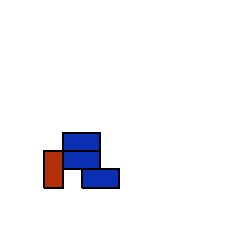

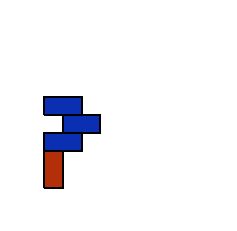

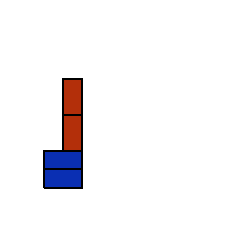

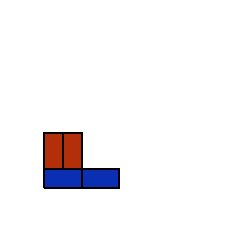

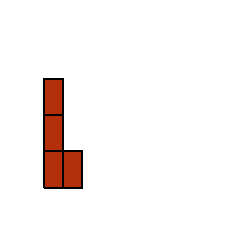

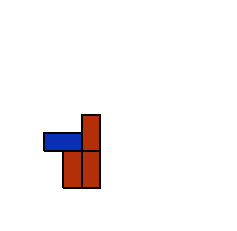

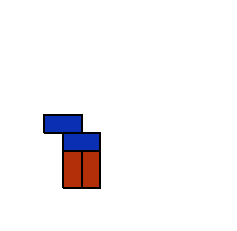

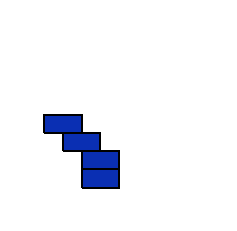

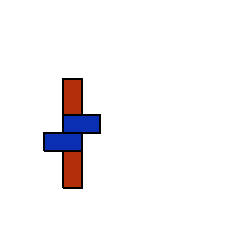

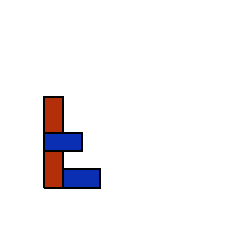

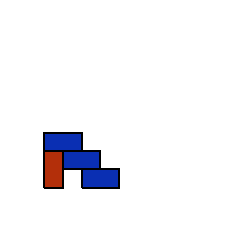

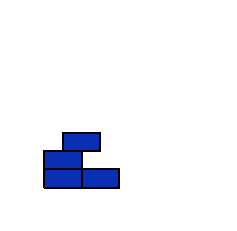

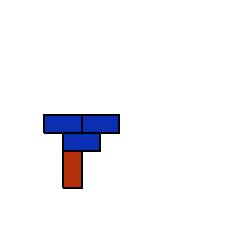

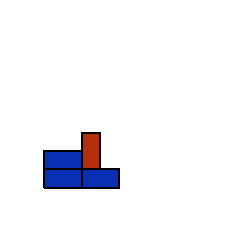

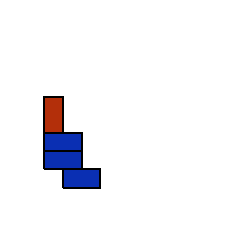

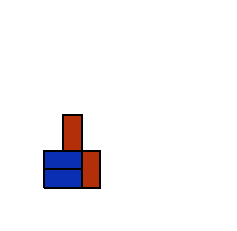

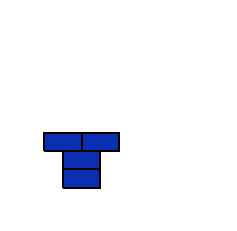

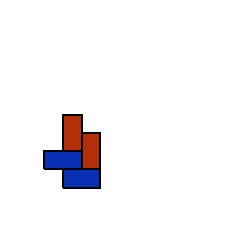

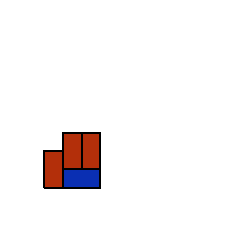

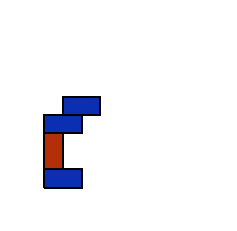

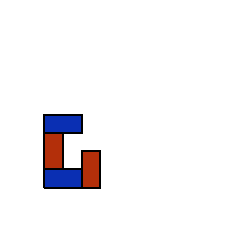

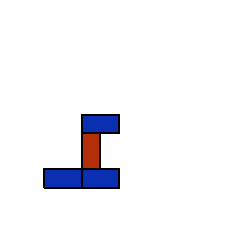

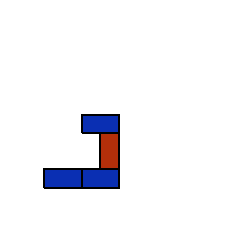

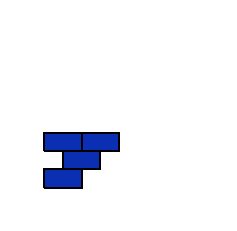

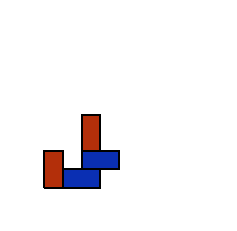

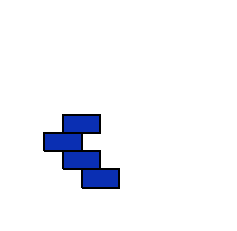

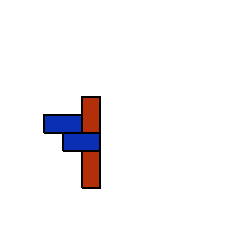

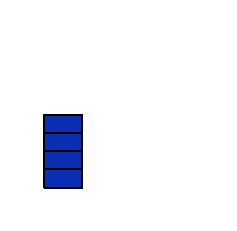

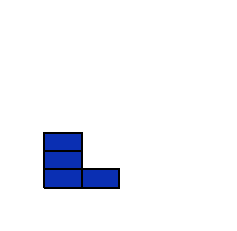

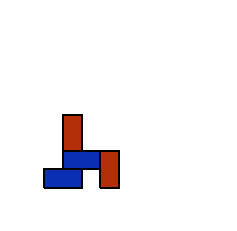

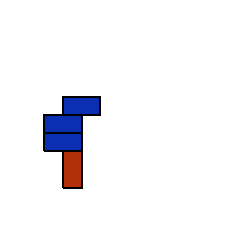

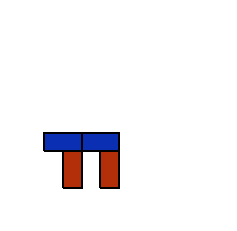

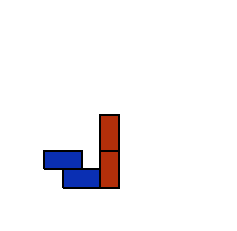

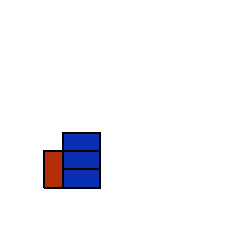

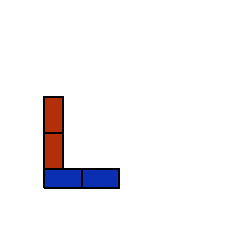

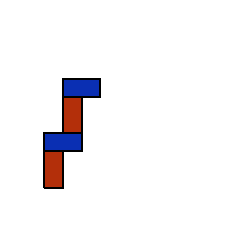

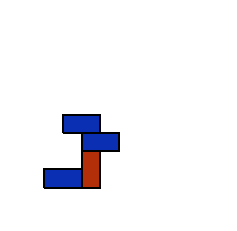

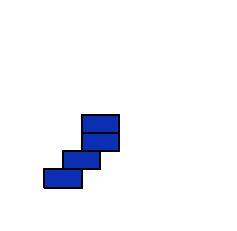

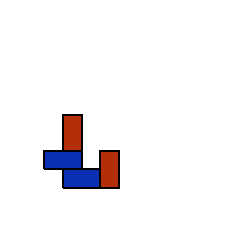

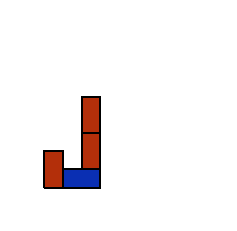

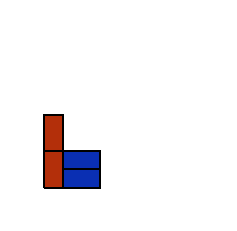

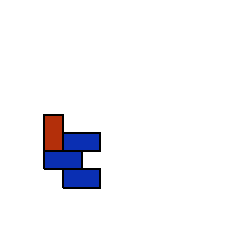

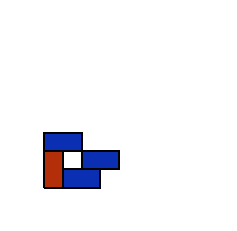

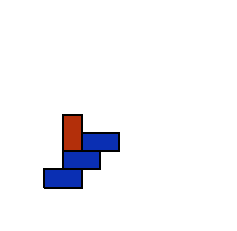

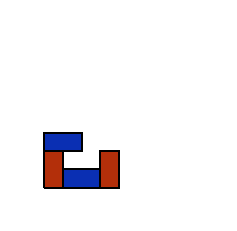

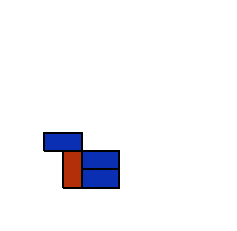

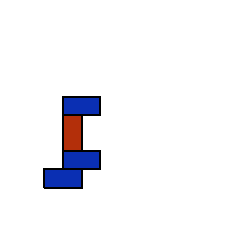

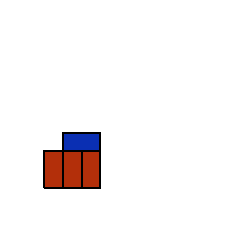

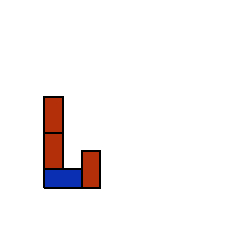

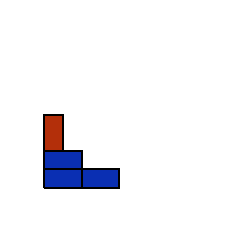

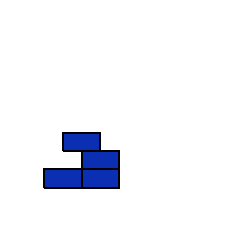

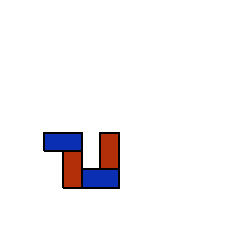

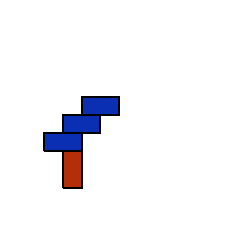

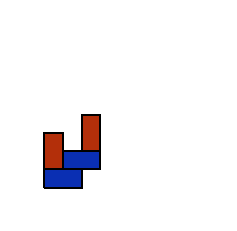

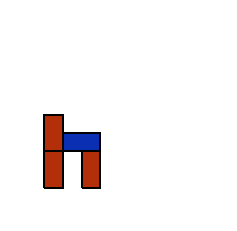

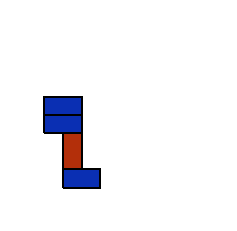

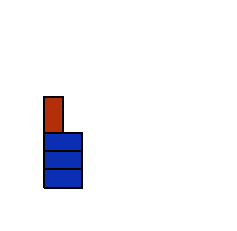

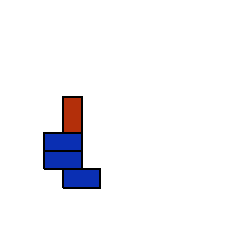

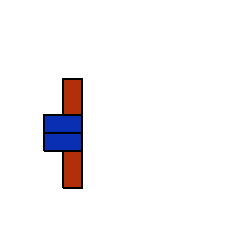

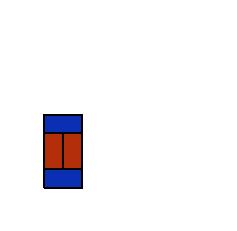

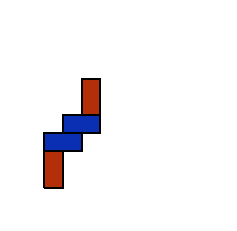

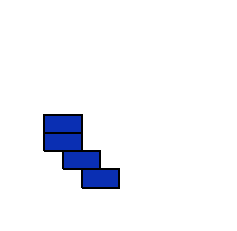

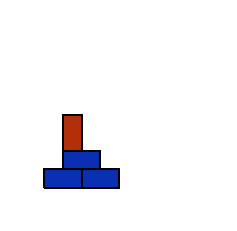

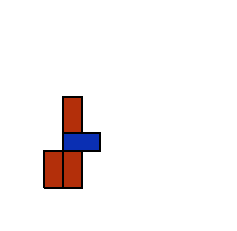

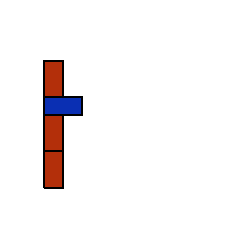

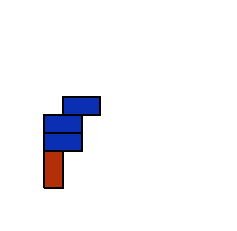

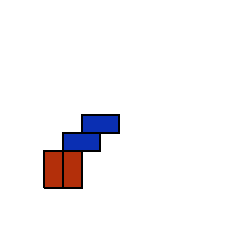

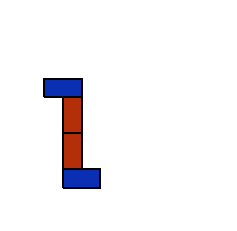

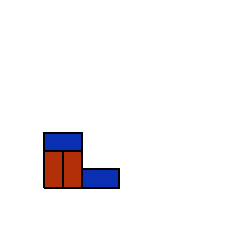

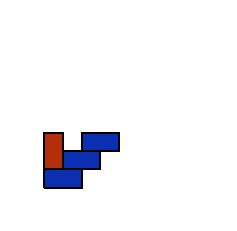

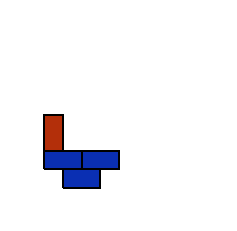

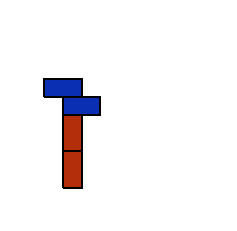

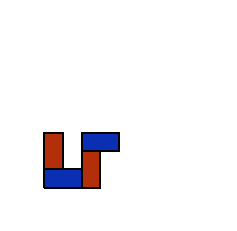

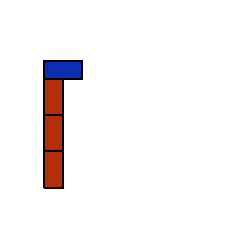

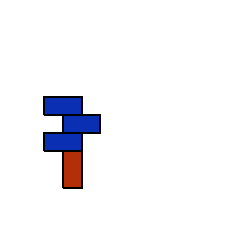

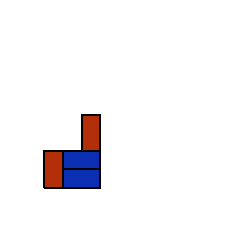

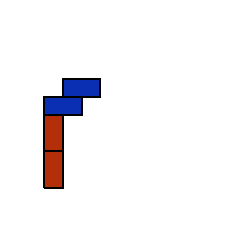

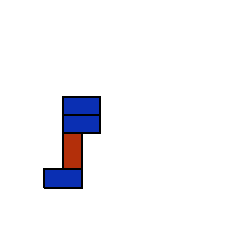

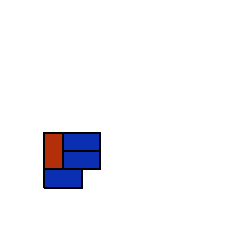

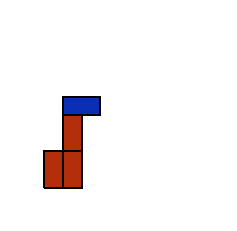

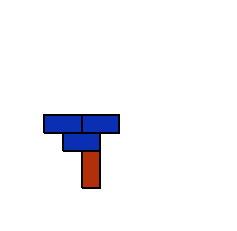

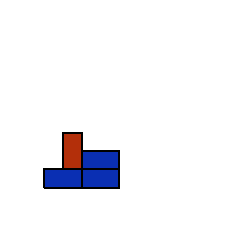

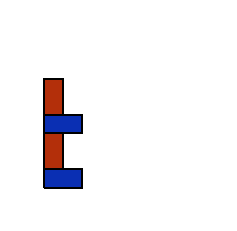

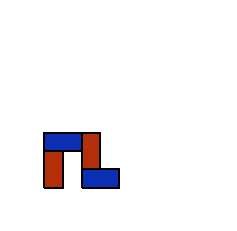

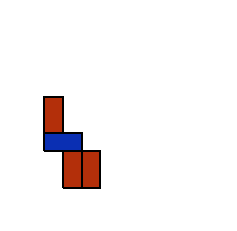

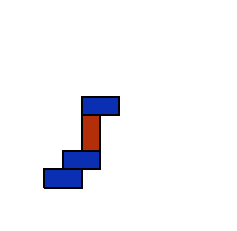

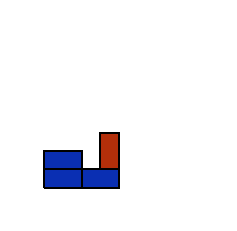

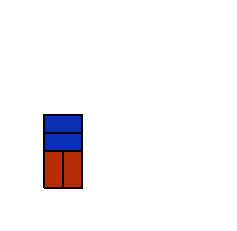

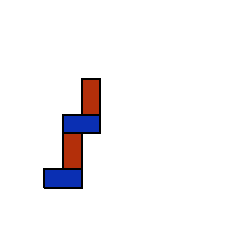

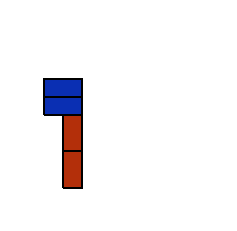

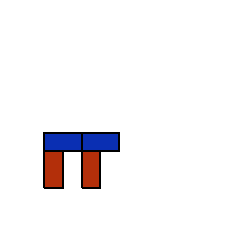

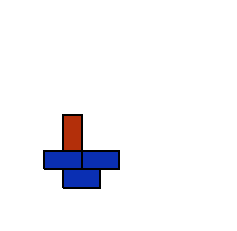

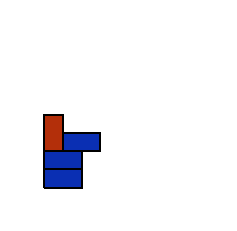

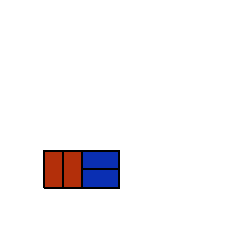

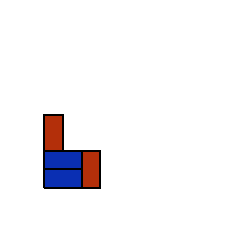

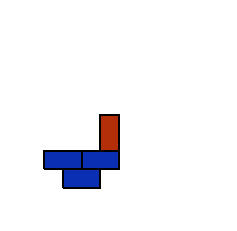

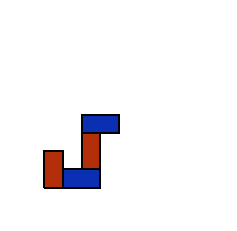

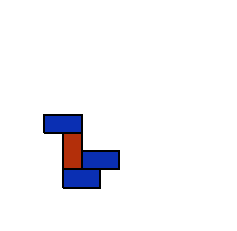

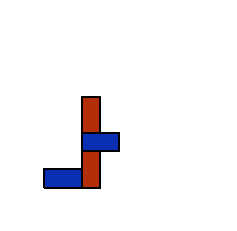

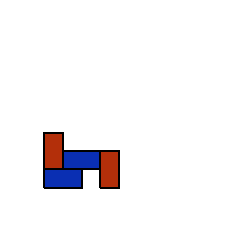

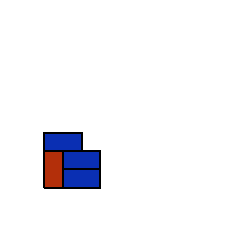

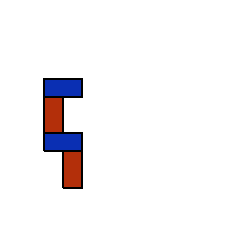

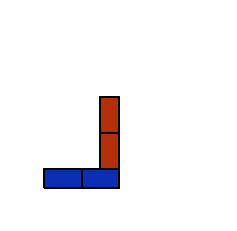

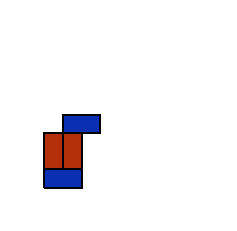

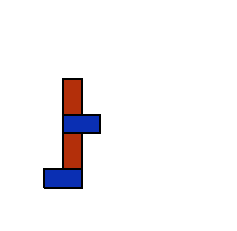

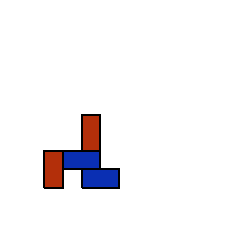

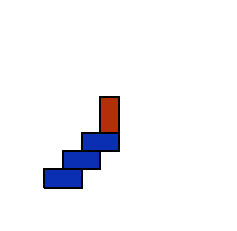

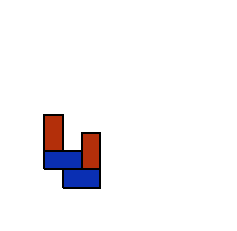

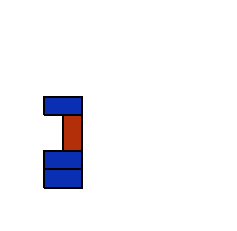

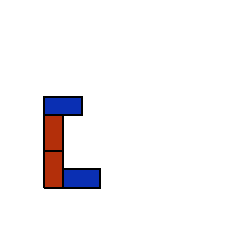

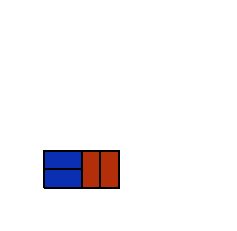

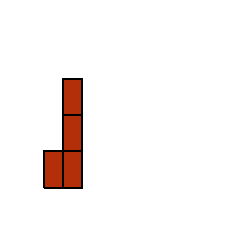

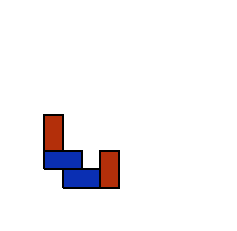

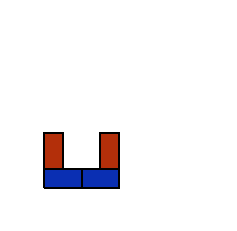

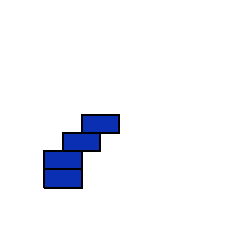

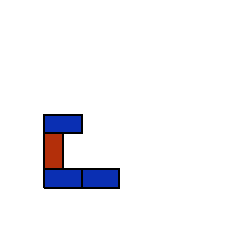

In [13]:
_ = [utils.draw_world(utils.worldify(s, 
                                  block_dims = block_dims, 
                                  block_colors = block_colors,
                                  world_width = world_width,
                                  world_height = world_height,
                                    )) 
                   for s in df_towers.stim]

## Implement higher-level control structure

Start with empty world and add towers to it.

Desirable:
- translate(n)
- place to side of (n)
- place on top of ()
- loop (fn, n)
- mirror horizontally (location)
- mirror vertically ()

Relative placements?
Reference to previous tower seems useful
e.g. on top of last tower, or on top of to the right


### Decisions

Define some kinds of scene and work out how to enumerate each?

e.g.
- multiple stacks
- repeated stack
- mirror
- big tower
- row
- stacked row




In [704]:
importlib.reload(utils)

<module 'blockworld_utils' from '/Users/will/lax/stimuli/towers/block_utils/blockworld_utils.py'>

In [4]:
def new_world():
    return utils.World(block_dims = block_dims, 
                        block_colors = block_colors,
                        world_width = 20,
                        world_height = 20)


'''
#### Castle building functions ####

Functions that take a world object always return a world object.

These are designed with rejection sampling in mind.
If the function causes something bad to occur (e.g. breaks the tower that is being placed),
then world.broken is set to true.


'''

def stack(w, tower, n = 1, x_location = 0):
    '''
    Places n towers in the same xlocation.
    '''
    
    for i in range(0, n):
        w.place_tower(tower, x_location)

    return w


def row(w, tower, n = 1, diff = 0):
    '''
    Places tower n times in a row with diff squares between each one.
    '''
    
    for i in range(0, n):
        w.place_tower_relative(tower, direction='right', diff=diff)

    return w


def mirror(t):
    '''
    Mirror flips a tower dict/json (along vertical axis) and aligns to left.
    '''

    t2 = []
    for b in t:
        adjust = 1 if b['width'] == 1 else 0

        t2.append({
            'x': - b['x'] + 10 + adjust,
            'y': b['y'],
            'height': b['height'],
            'width': b['width'],
        })
        
    xs = [b['x'] for b in t2]
    min(xs)
    for b in t2:
        b['x'] = b['x'] - min(xs)

    return t2


def diag(w, tower, n = 1, direction = 'right'):
    
    if direction == 'right':
        for i in range(0, n):
            w.place_tower_relative(tower, direction='right', diff=-1)

        return w
    
    else:
        for i in range(0, n):
            t = utils.worldify(tower)
            w.place_tower_relative(tower, direction='left', diff=t.tower_width() - 1)

        return w
    
    
    
### Roof kinds
    
def pyramid(w, levels, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 1, 
                                'width': 2}]):
    
    tile_world = utils.worldify(tile)
    
    
    cur_level = 0
    
    for i in range(0, levels):
        
#         n_blocks = levels-i
        
        start_location = 0 + i #hardcoded i for indiviudal blocks
        
        for j in range(0, levels-i):
            w.place_tower(tile, x_location = start_location + j*tile_world.tower_width())
            

    return w
    
    
def dome(w, levels, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 1, 
                                'width': 2}]):
    
    tile_world = utils.worldify(tile)
    
    
    cur_level = 0
    
    for i in range(0, levels):
        
#         n_blocks = levels-i
        
        start_location = 0 + i #hardcoded i for indiviudal blocks

        if i == 0: # double up on first layer
            for j in range(0, levels-i-1):
                w.place_tower(tile, x_location = start_location -1 + (j+1)*tile_world.tower_width())

        for j in range(0, levels-i):
            w.place_tower(tile, x_location = start_location + j*tile_world.tower_width())
            

            

    return w
    
    
def slab(w, width, levels = 1, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    
    for lev in range(0, levels):

        for i in range(0, width):

            w.place_tower(tile, x_location = i*tile_world.tower_width())
            

    return w


def vertical_brick_layer(w, width, x_location = 0, levels = 1, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    
    for lev in range(0, levels):

        for i in range(0, width):

            w.place_tower(tile, x_location = x_location + i*tile_world.tower_width())
            

    return w



def castillate(w, width, gap=2, x_location = 0, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    

    for i in range(0, width):
        
        if i%gap==0:
            w.place_tower(tile, x_location = x_location + i*tile_world.tower_width())
            

    return w

def symmetrical_castillate(w, gap=2):
    
    castillate(w, width=int(w.tower_width()/2), gap=gap)
    
    castillate(w, width=int(w.tower_width()/2), gap=gap, x_location=int(w.tower_width()/2)+1)


def horizontal_brick_layer(w, width, x_location = 0, levels = 1, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 1, 
                                'width': 2}]):
    
    tile_world = utils.worldify(tile)
    
    for lev in range(0, levels):

        for i in range(0, int(width/2)):

            w.place_tower(tile, x_location = x_location + i*tile_world.tower_width())
            

    return w


def vertical_line(w, height, x_location = 0, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    
    for brick in range(0, int(height/2)):
        w.place_tower(tile, x_location = x_location)
            

    return w

In [550]:
chunks = list(df_towers['stim'].iloc[0:100])

### "towers": 1-4 block continuous stimuli

### Make a vertical stack of towers

still good: True


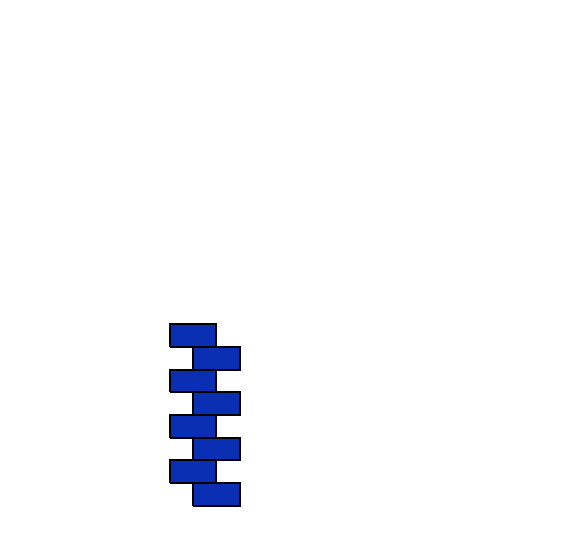

In [652]:
w = new_world()
stack(w,chunks[3], 4, 5)
print('still good:', not w.broken)
utils.draw_world(w)

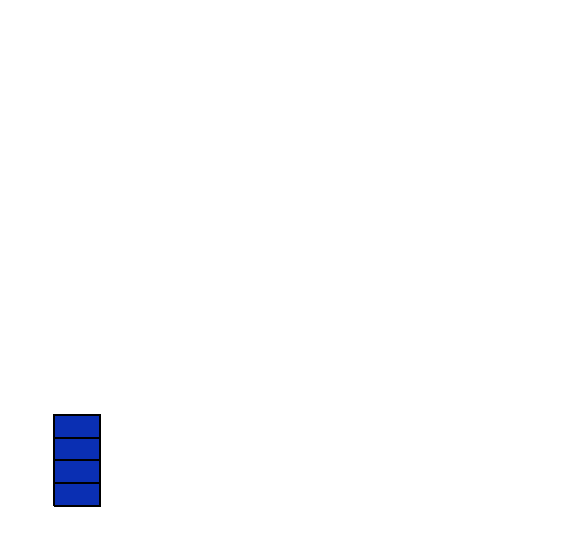

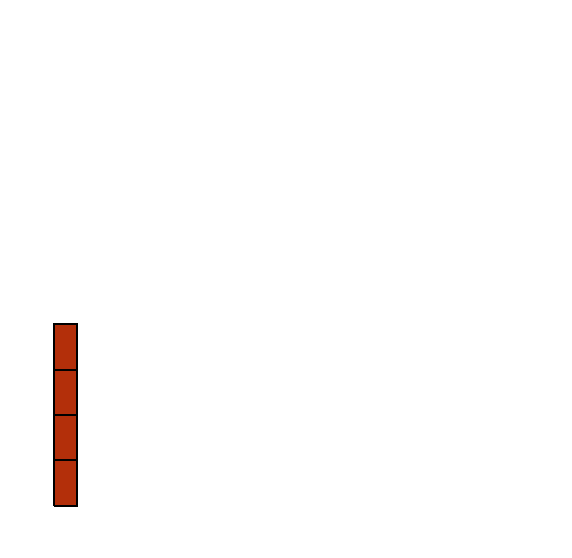

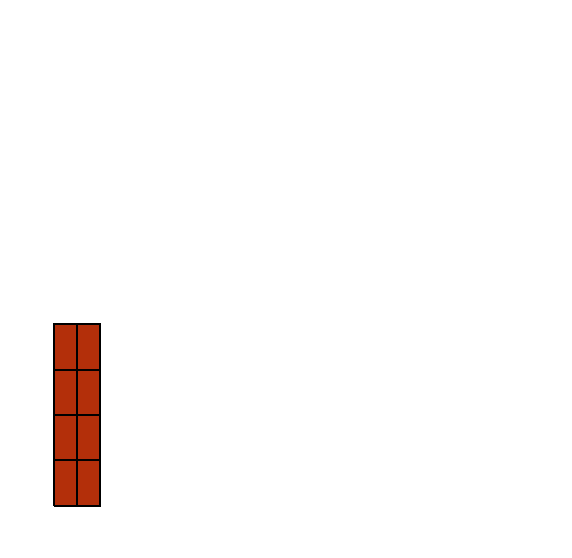

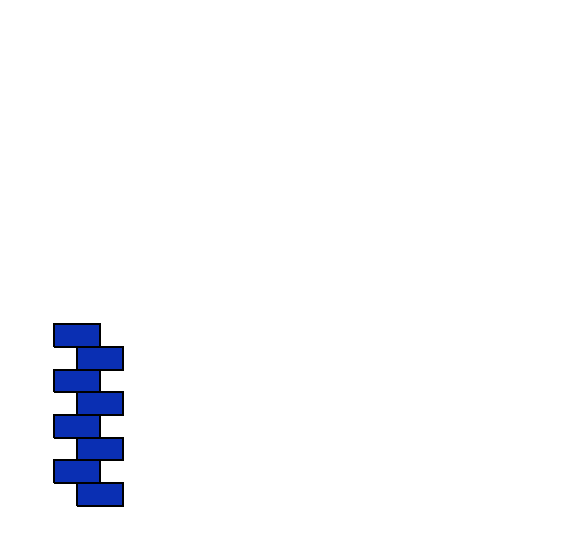

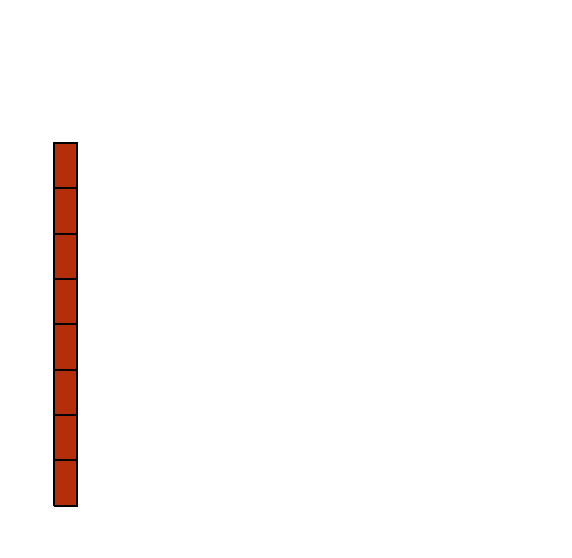

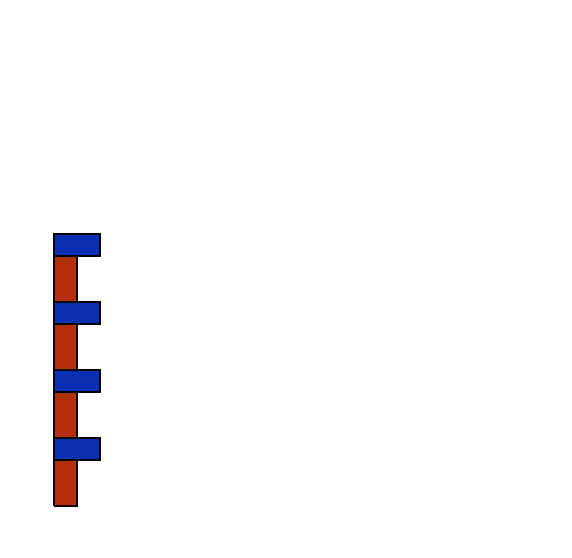

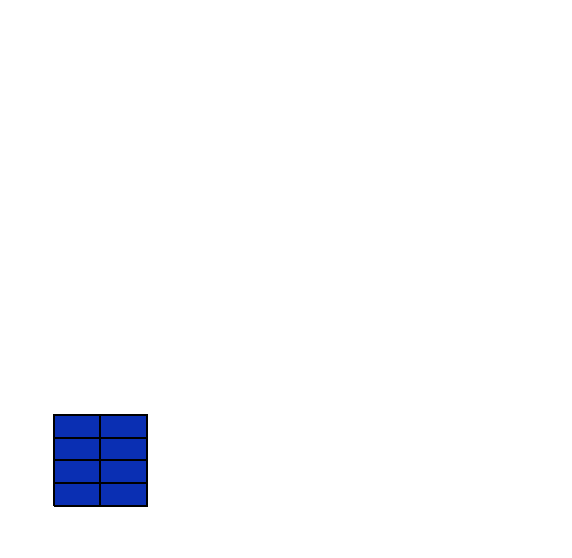

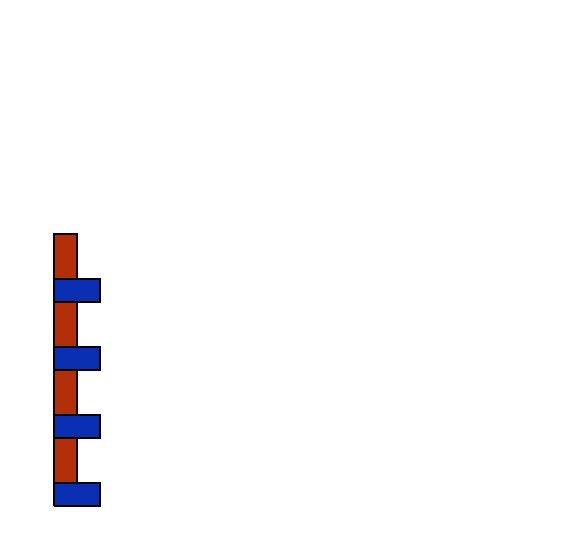

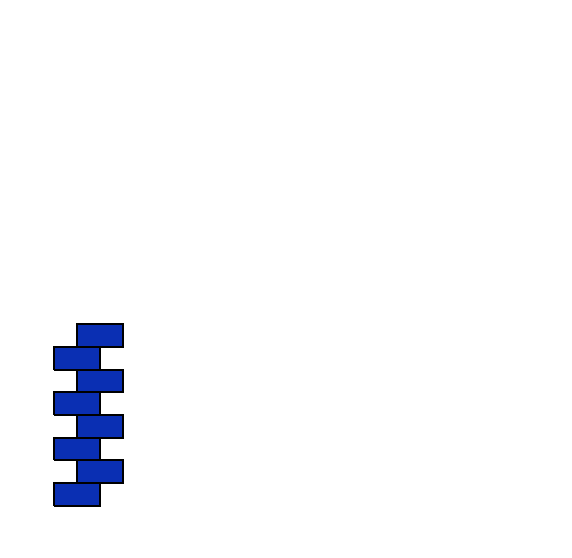

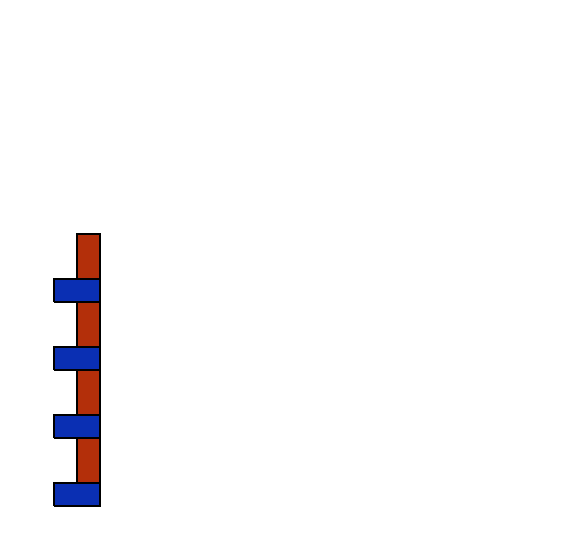

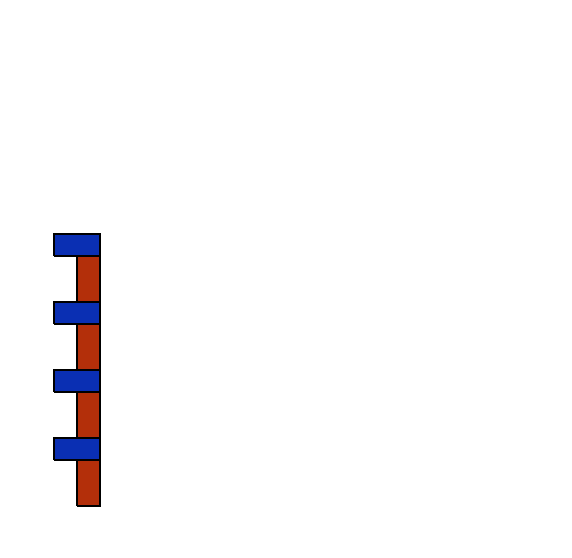

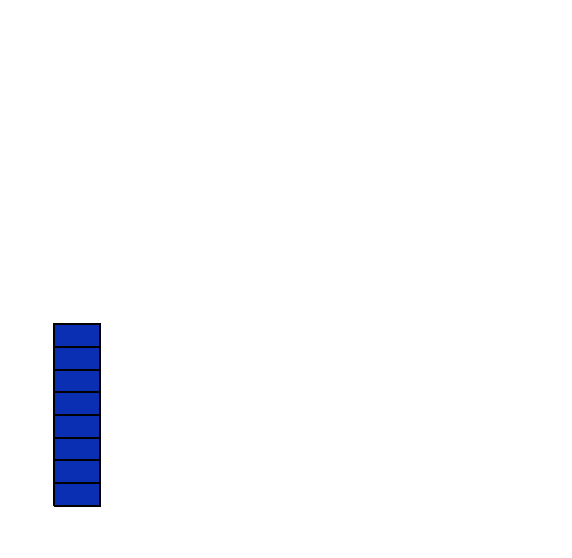

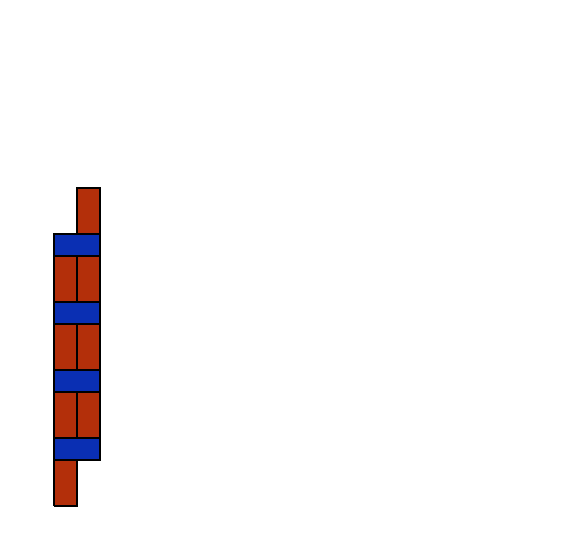

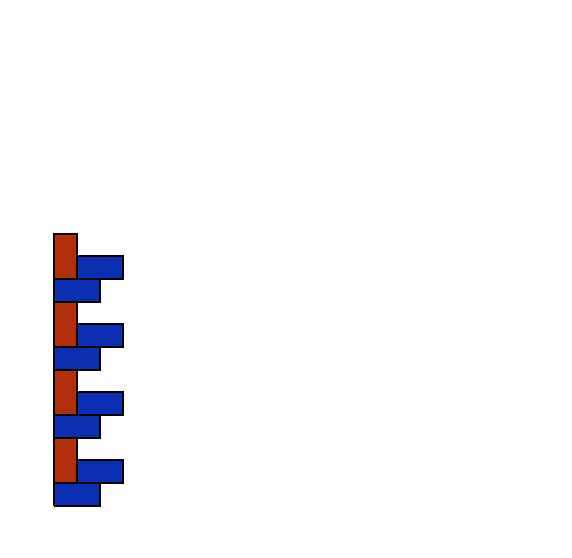

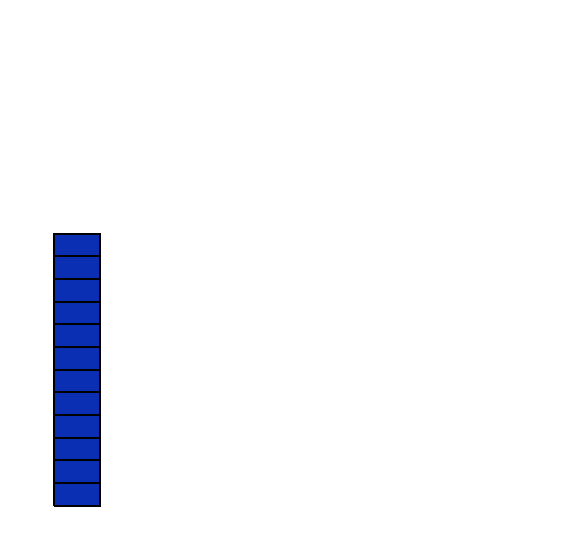

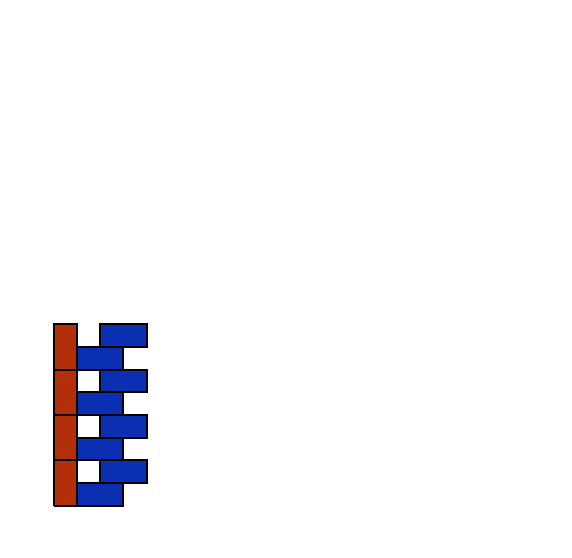

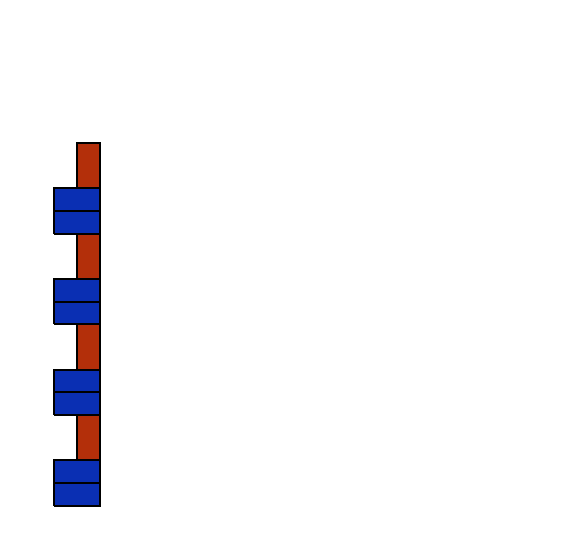

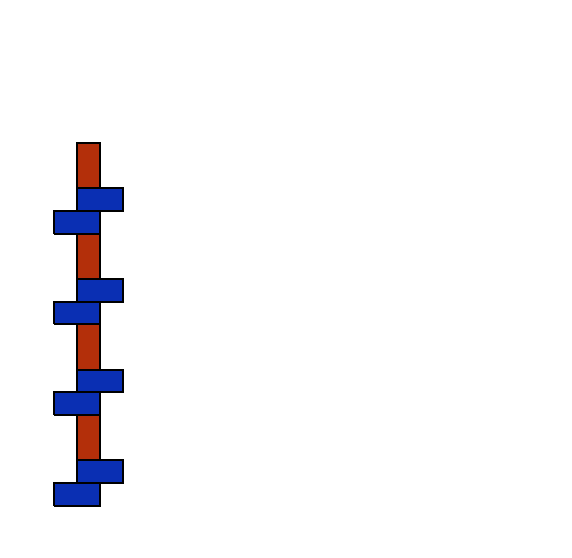

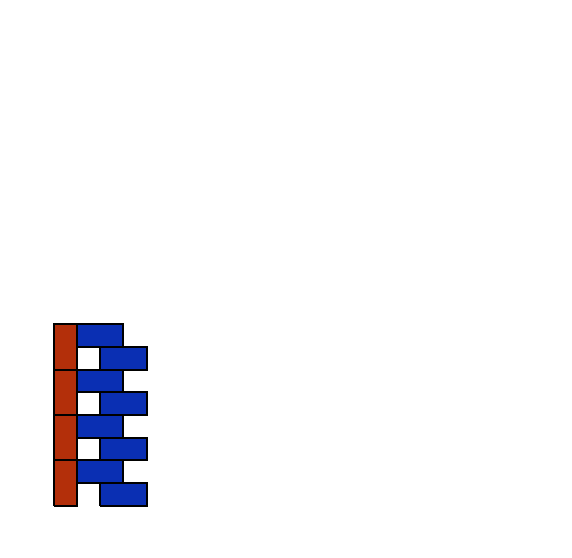

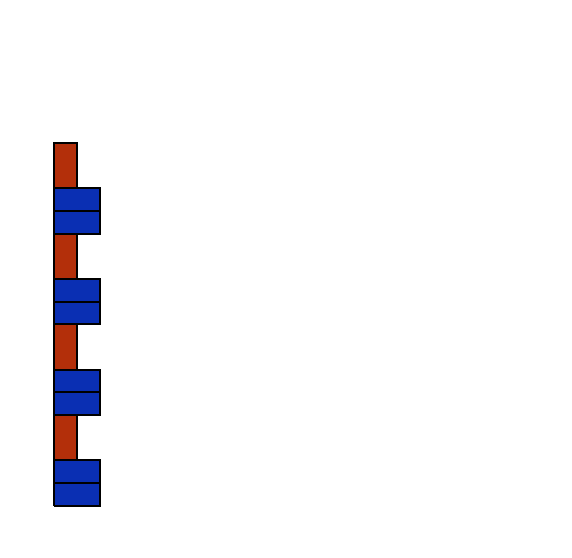

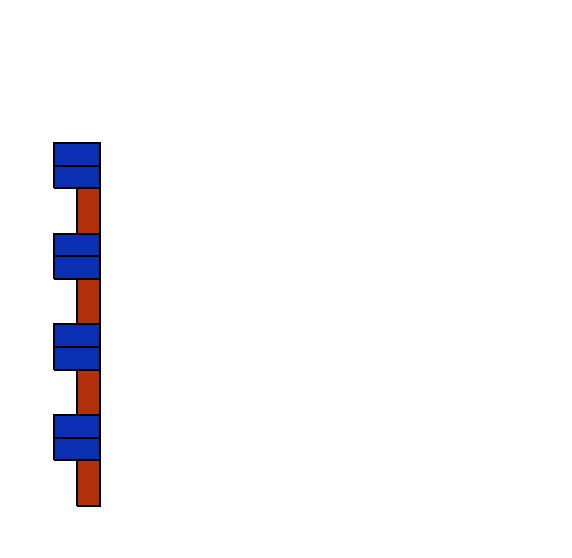

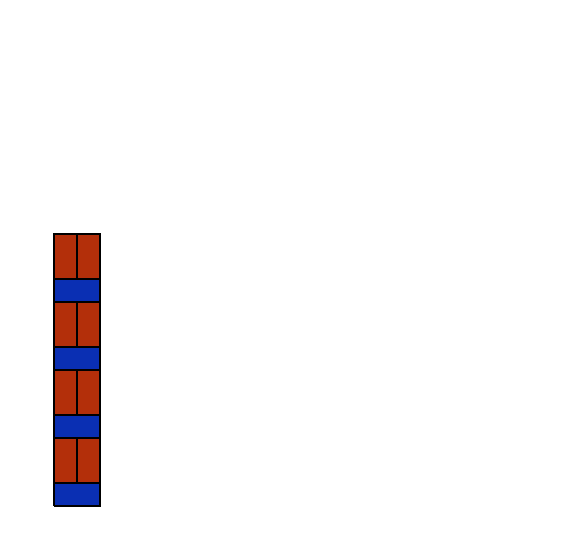

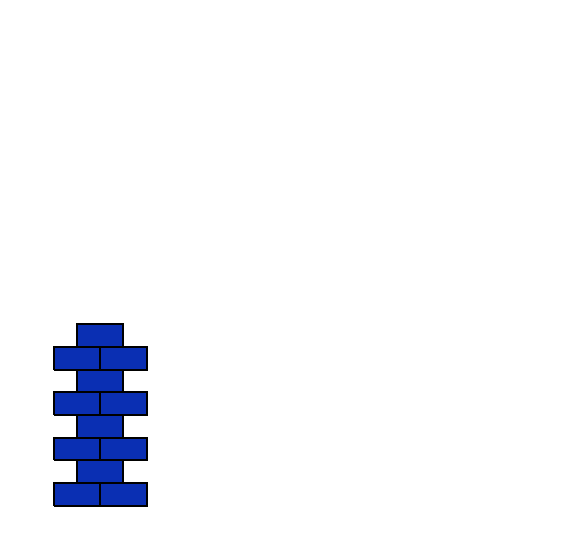

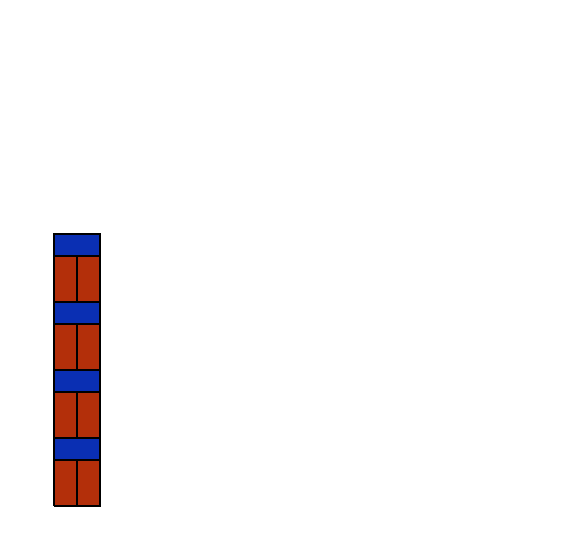

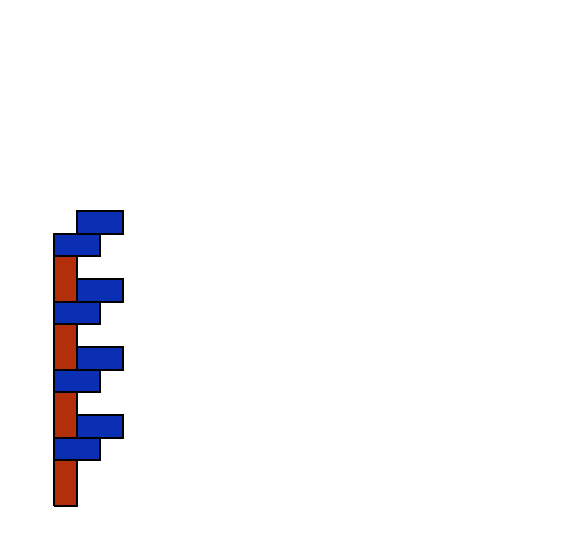

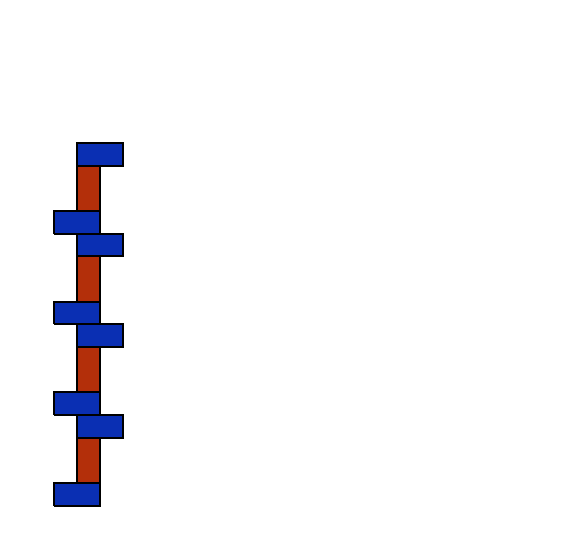

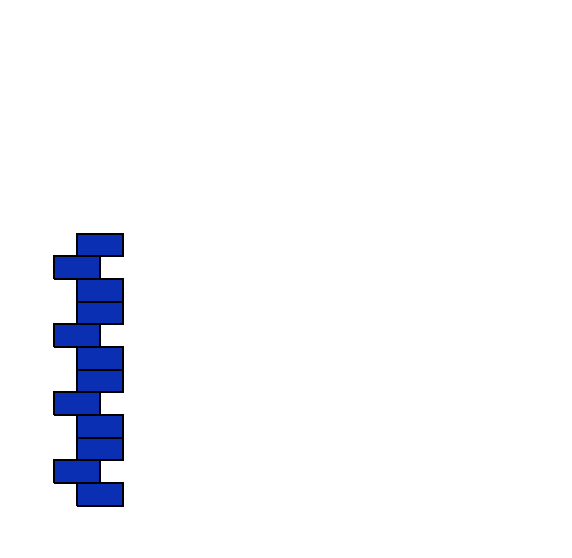

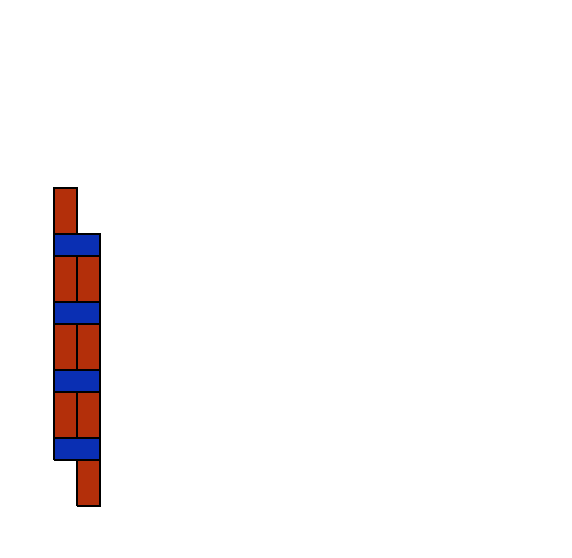

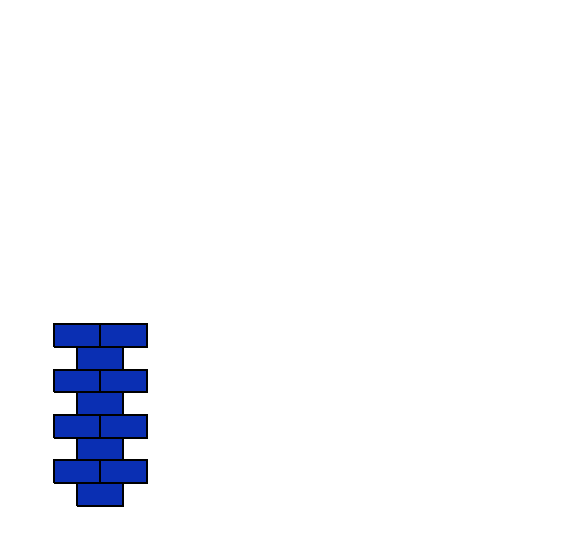

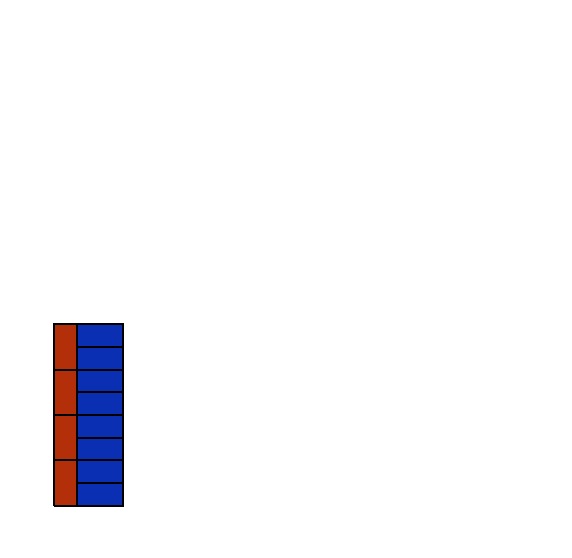

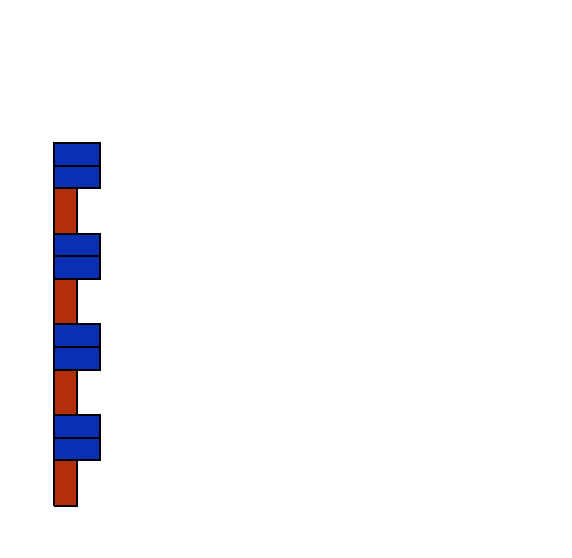

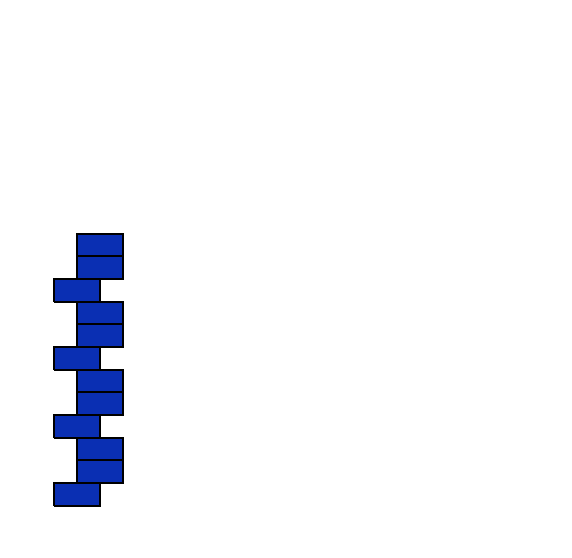

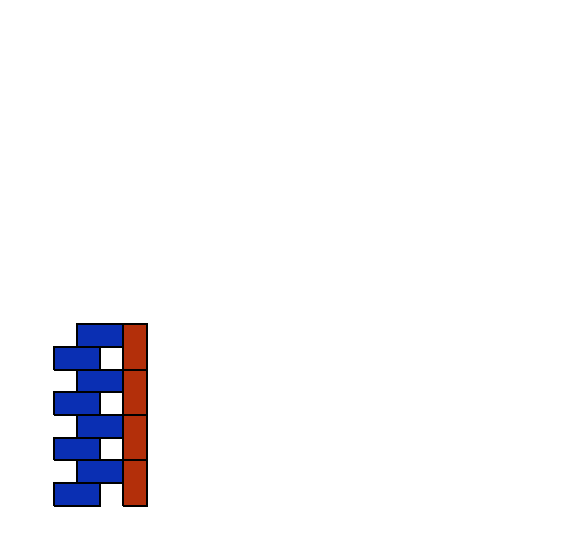

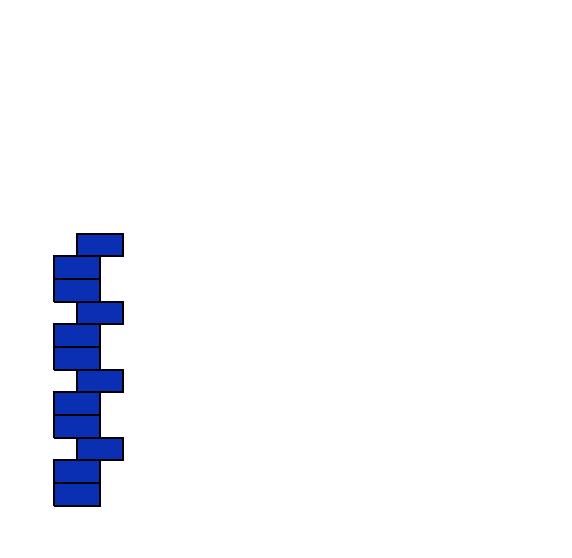

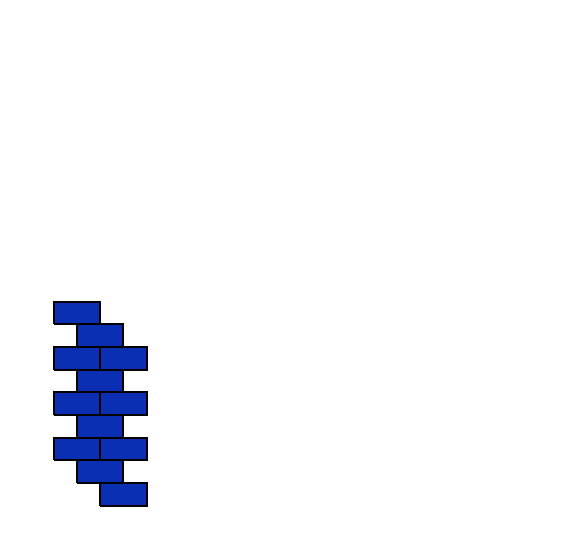

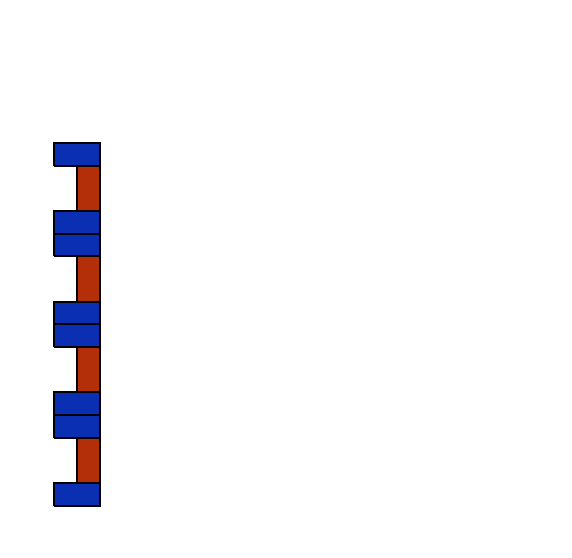

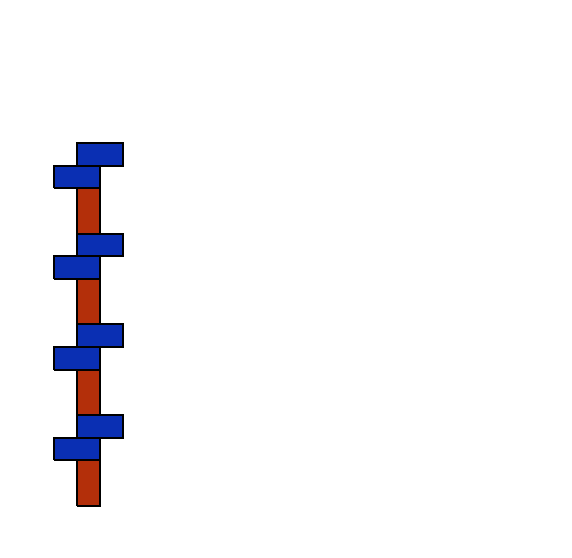

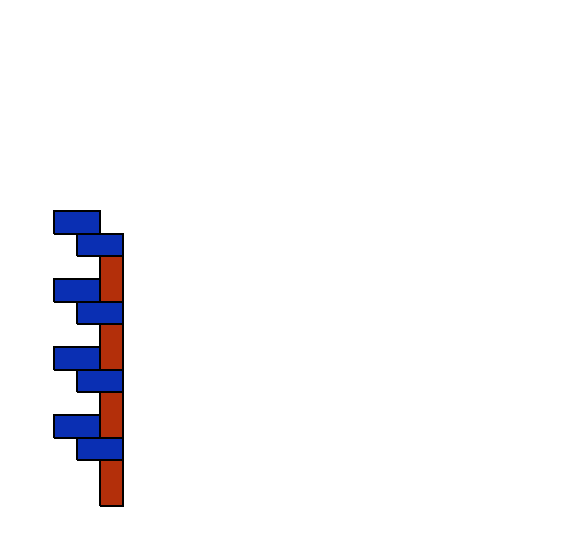

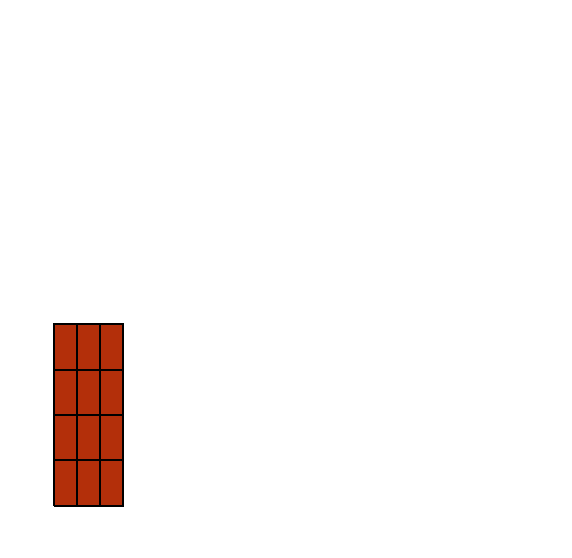

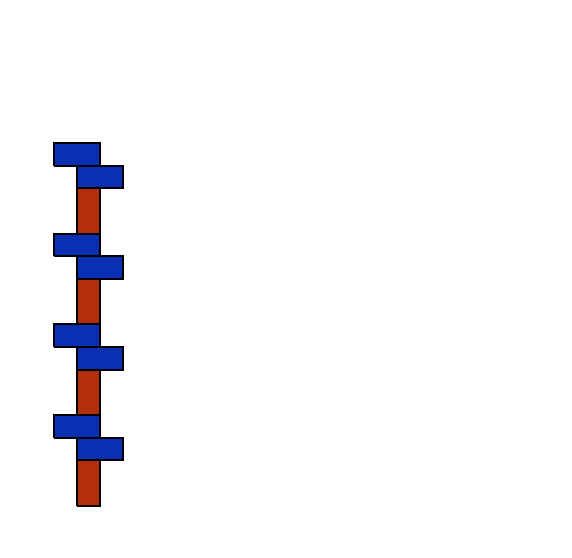

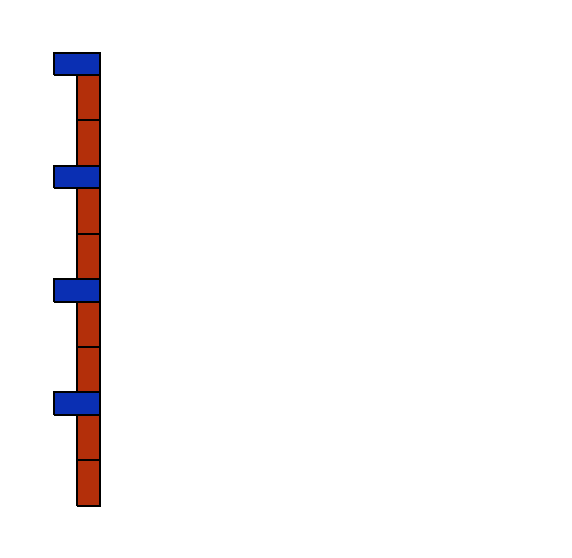

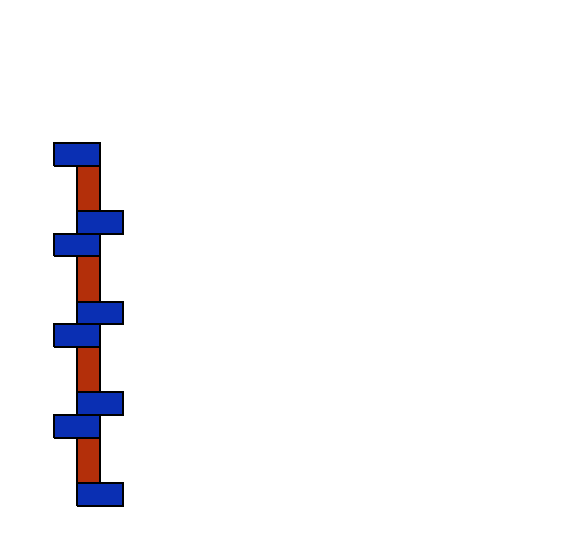

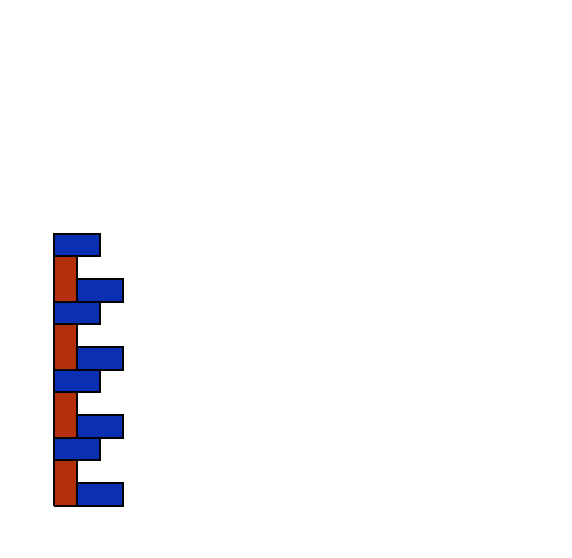

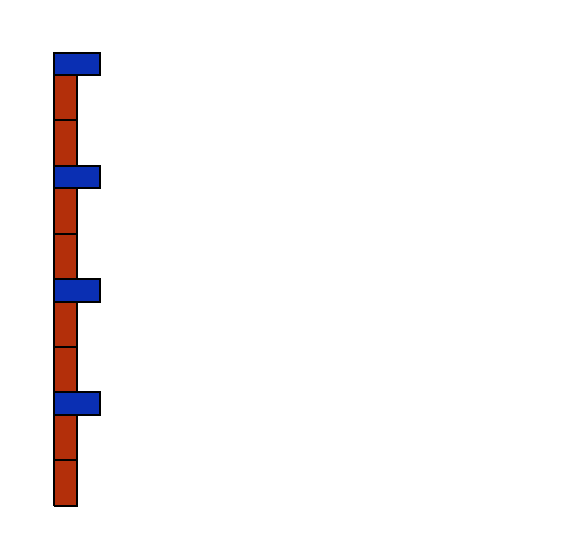

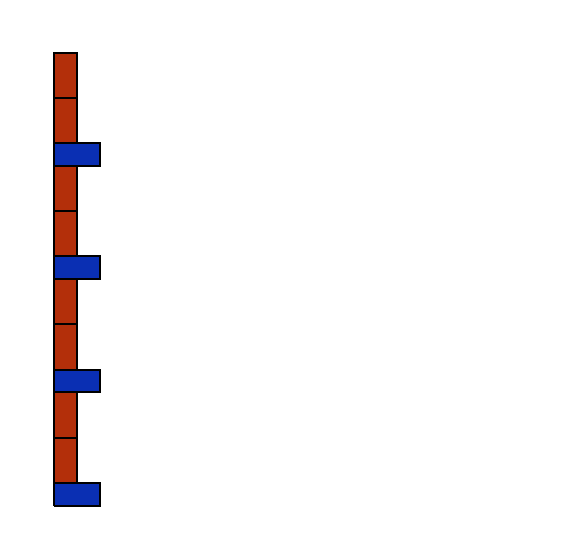

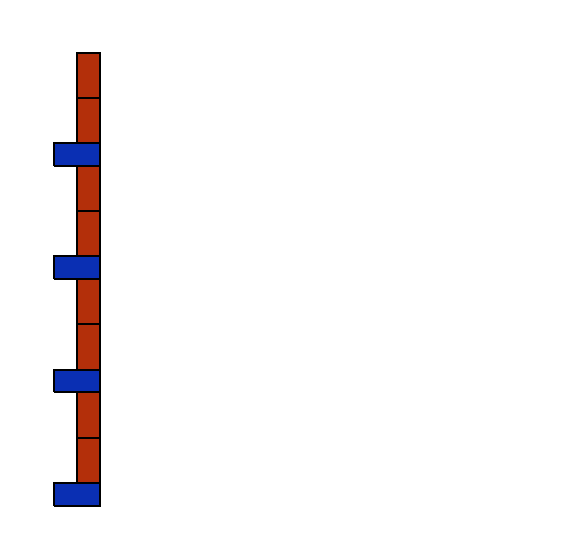

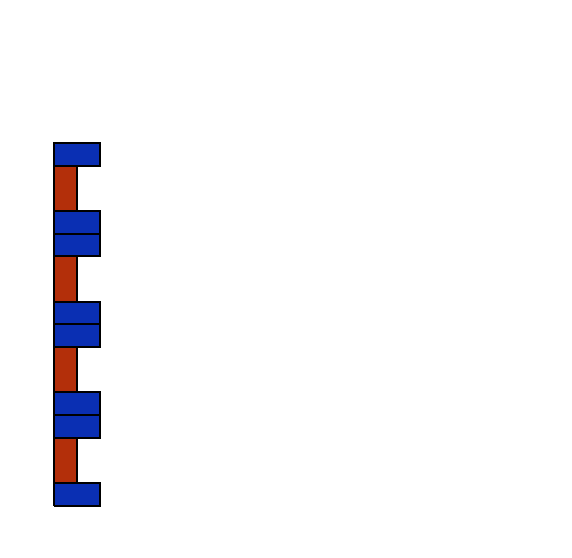

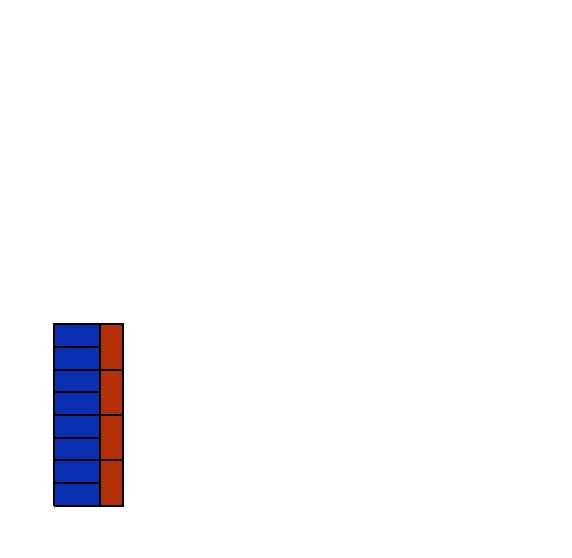

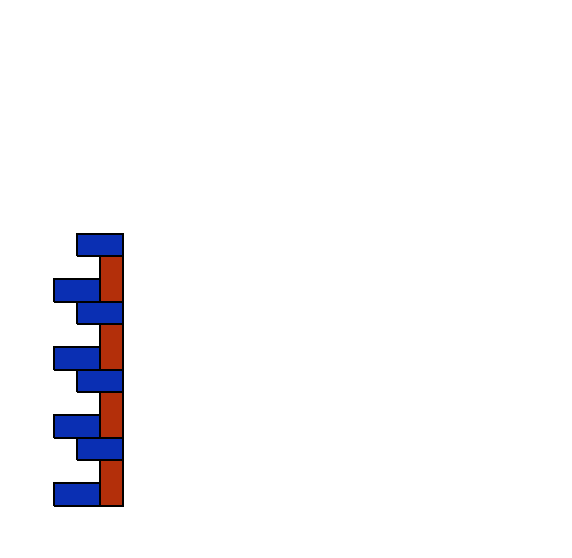

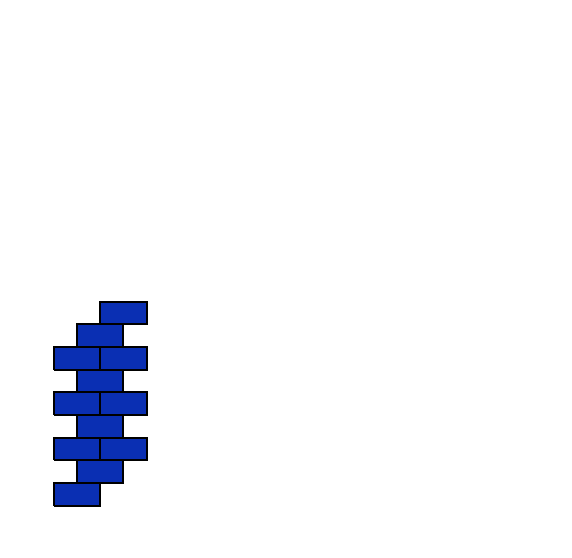

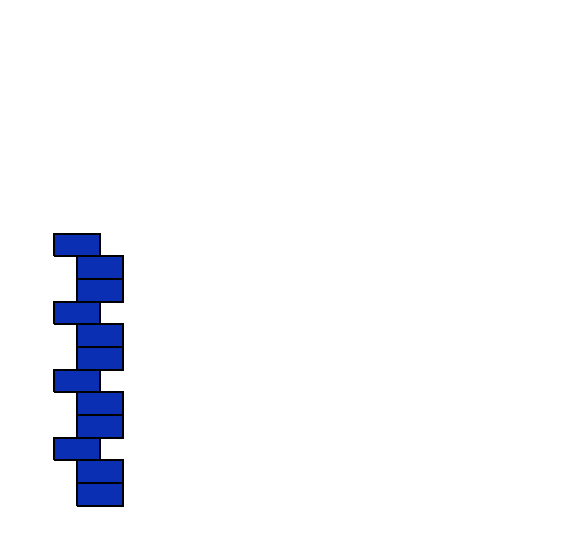

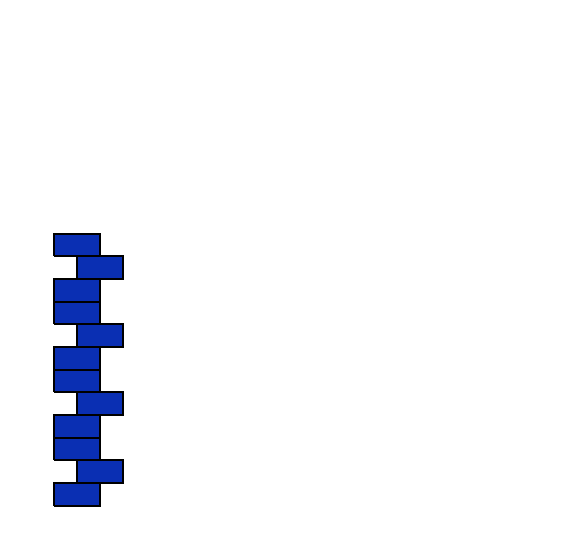

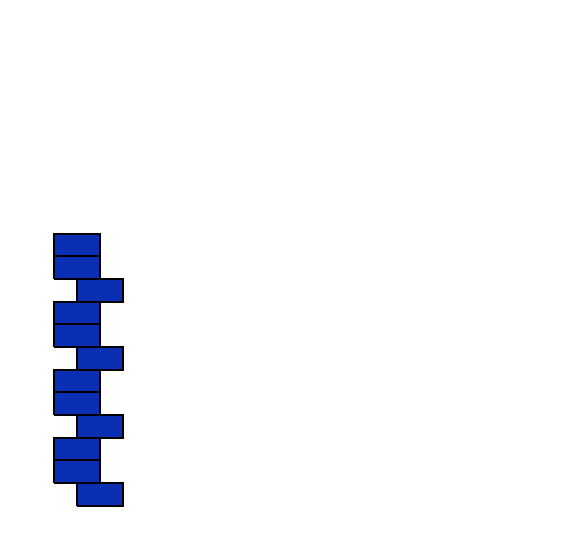

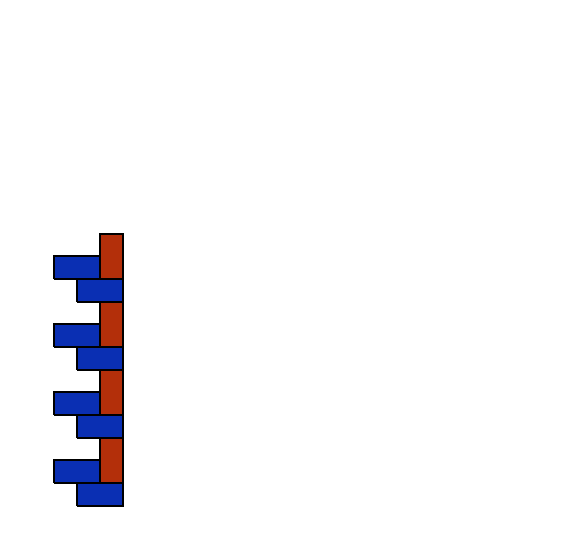

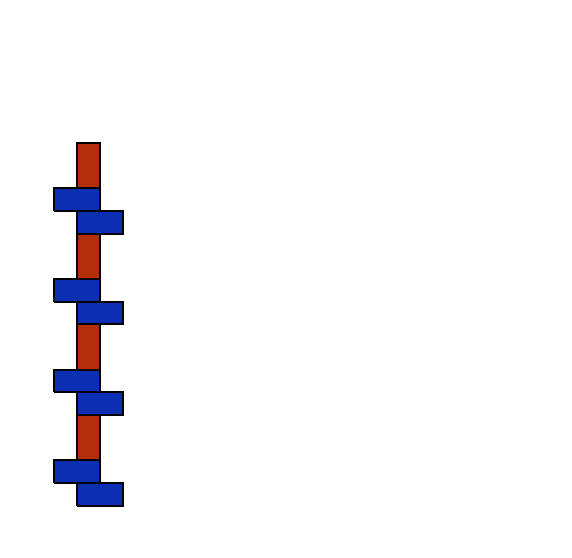

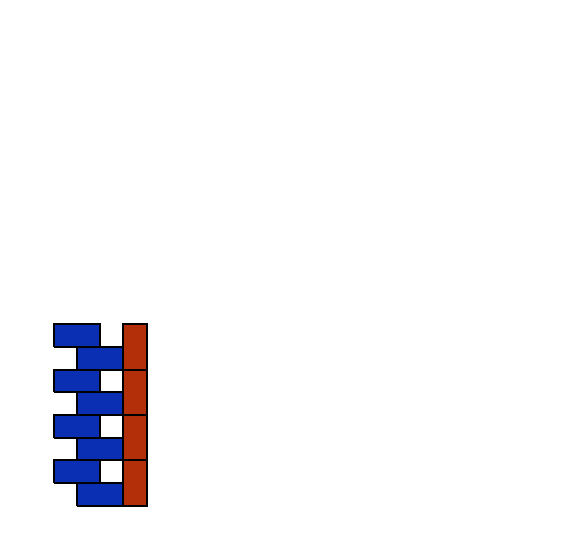

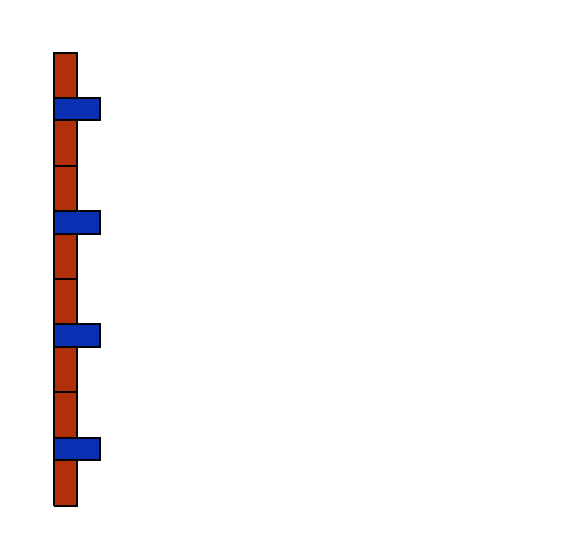

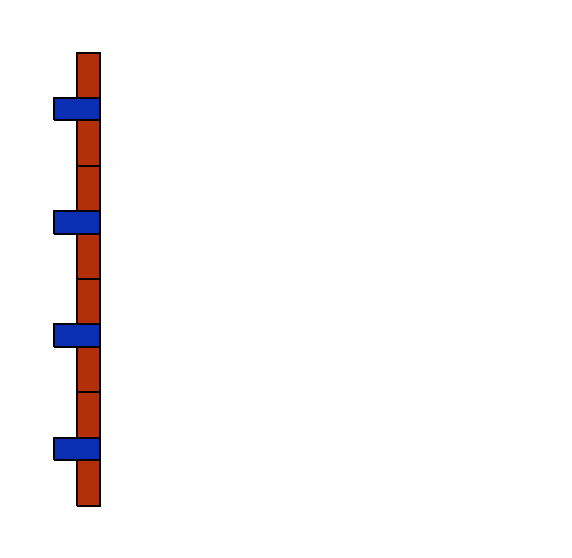

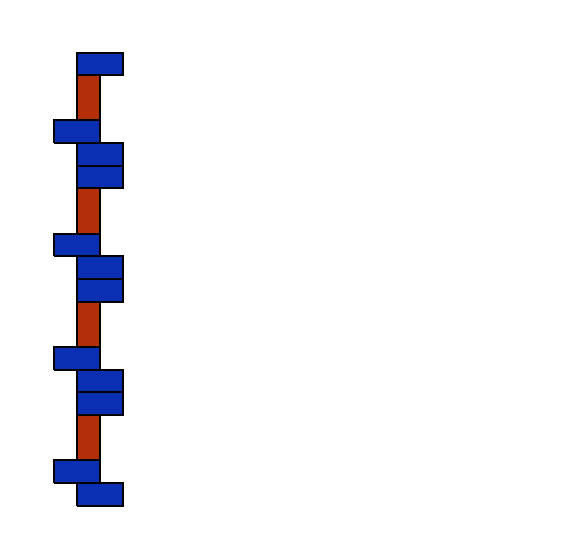

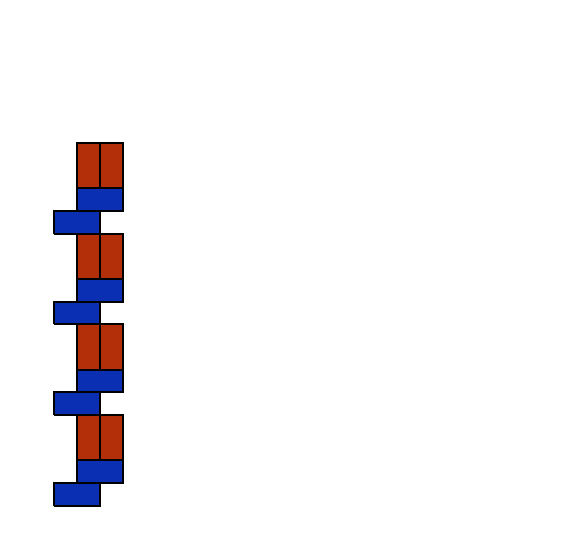

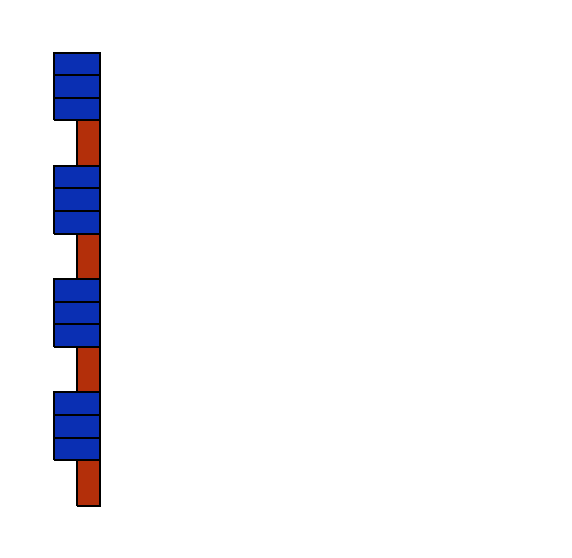

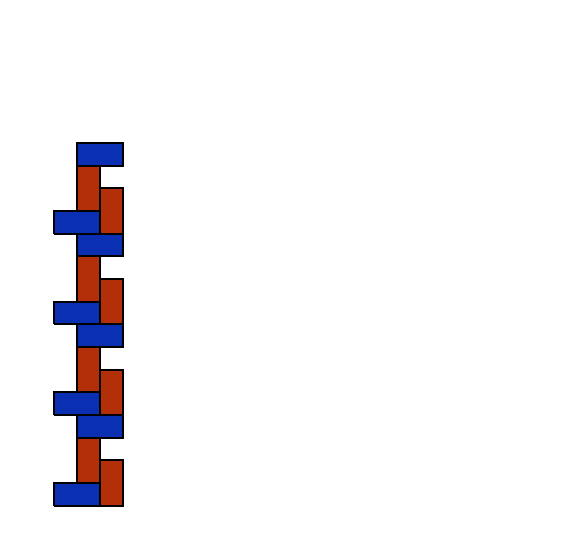

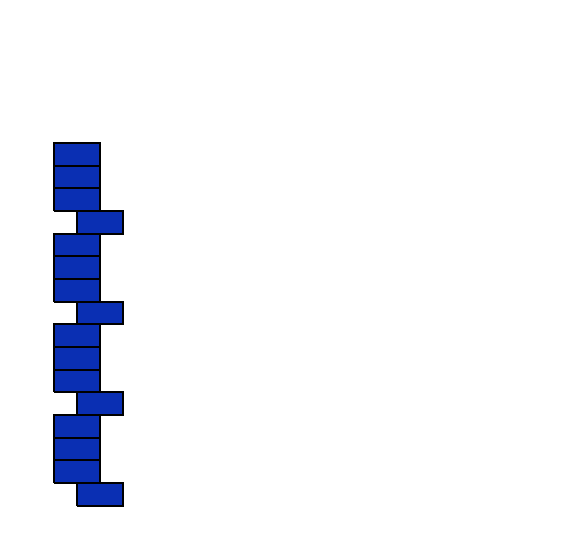

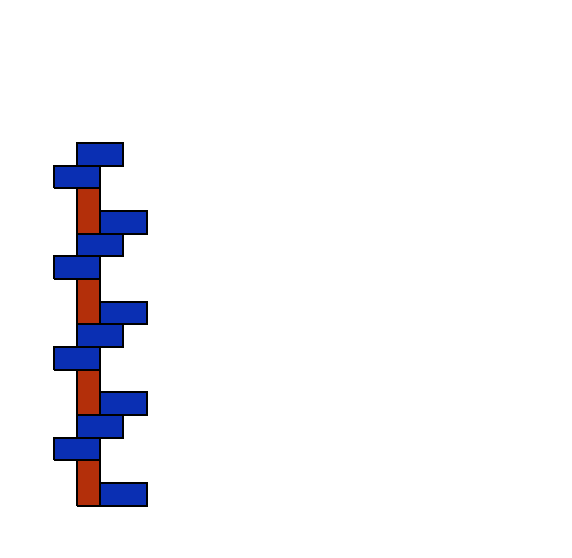

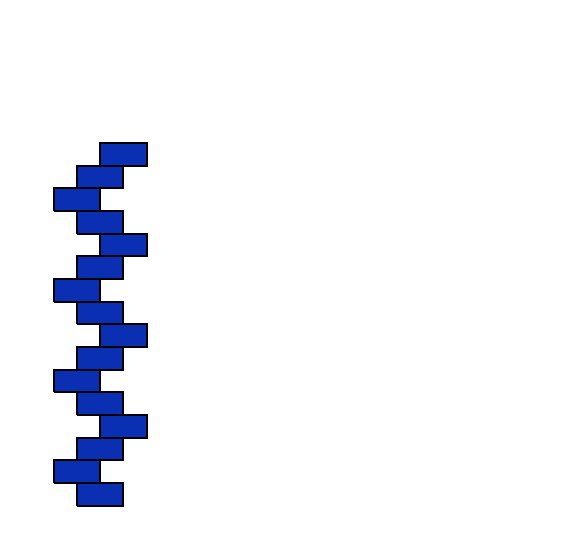

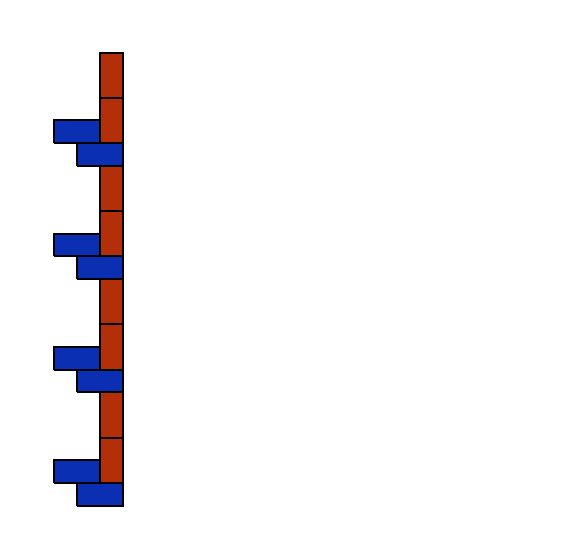

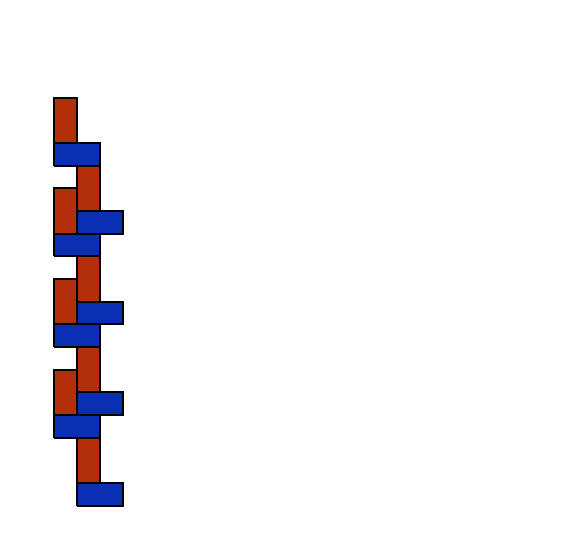

In [653]:
# stacks

for chunk in chunks:

    w = new_world()
    stack(w, chunk, n = 4, x_location = 0)
    if not w.broken:
        utils.draw_world(w)

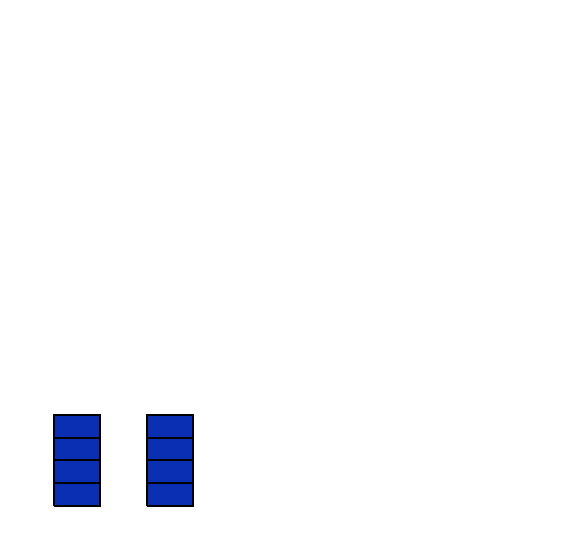

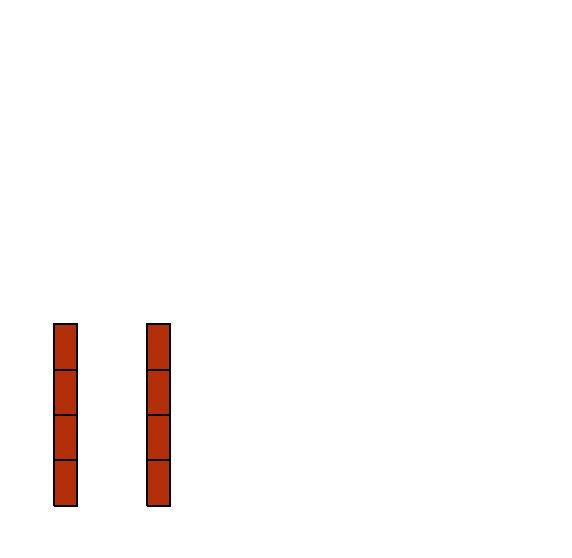

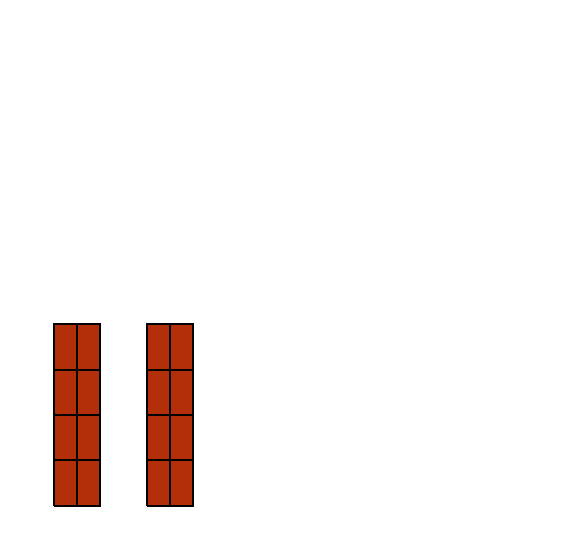

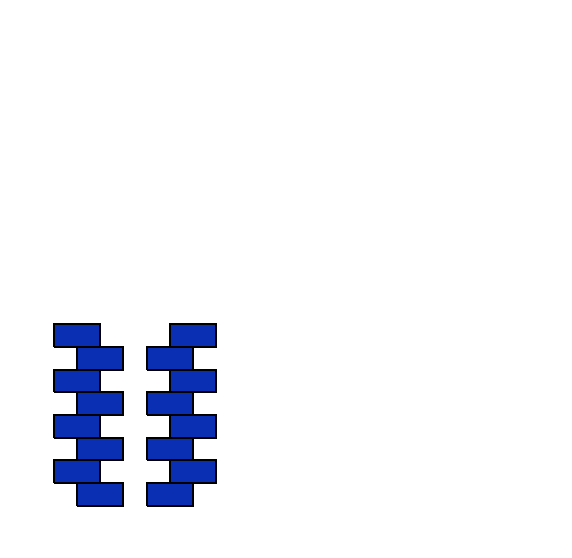

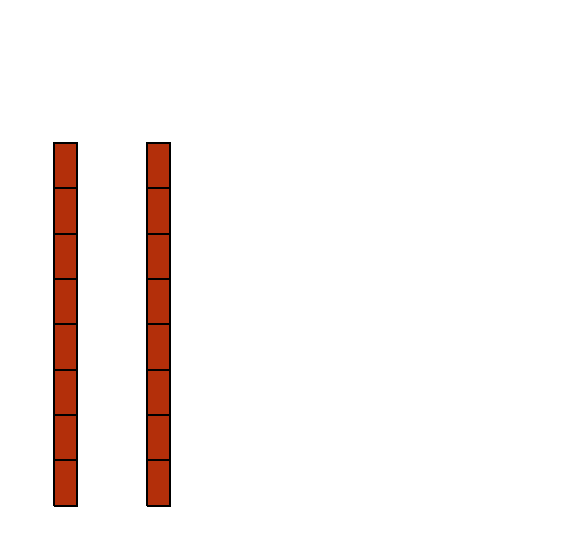

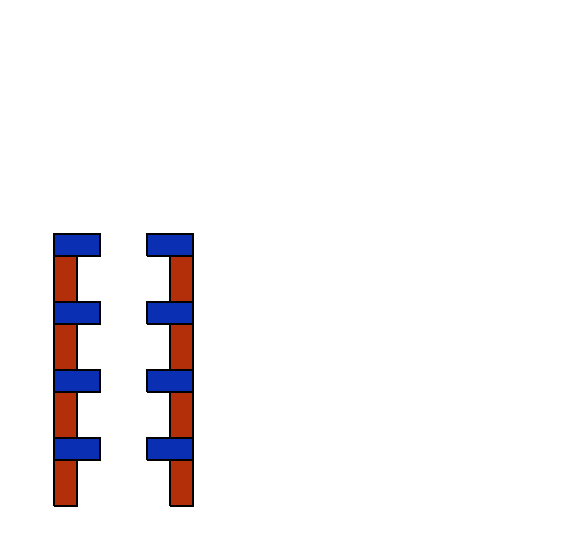

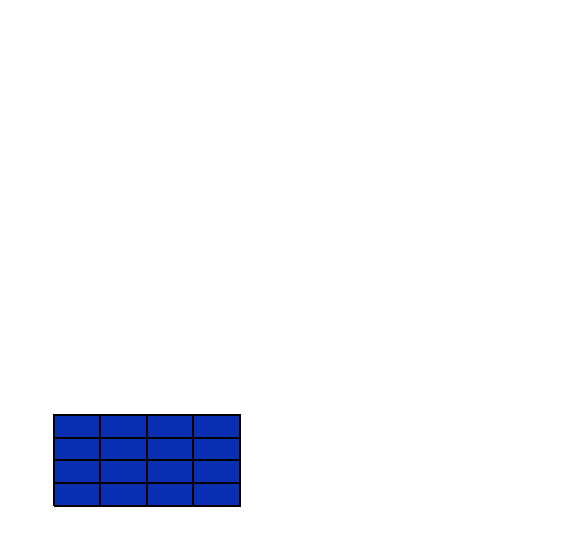

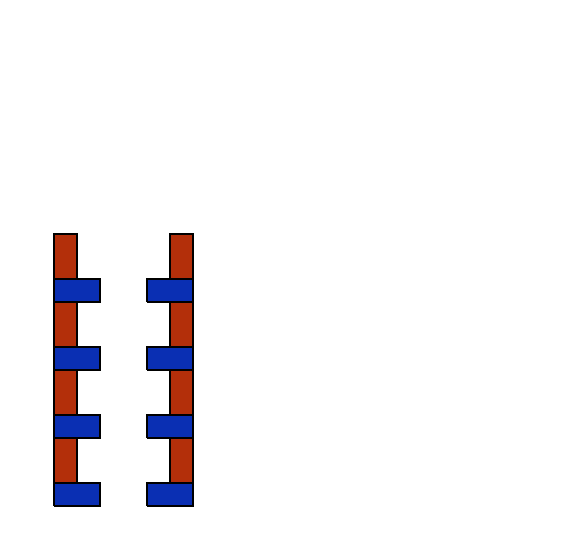

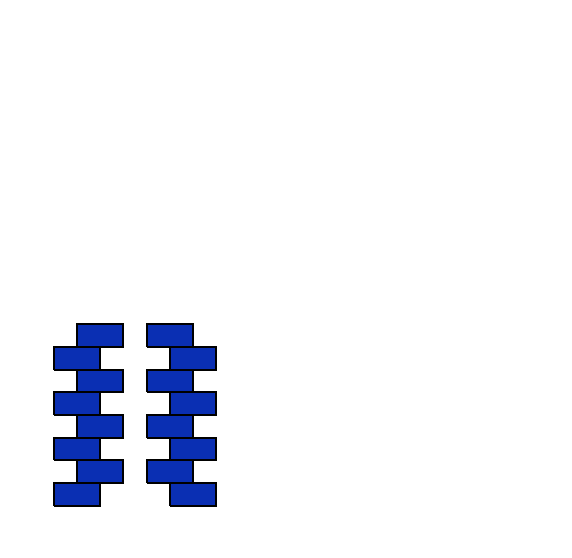

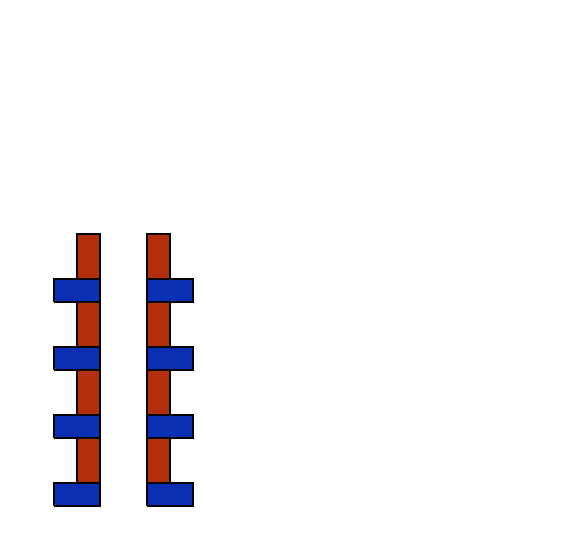

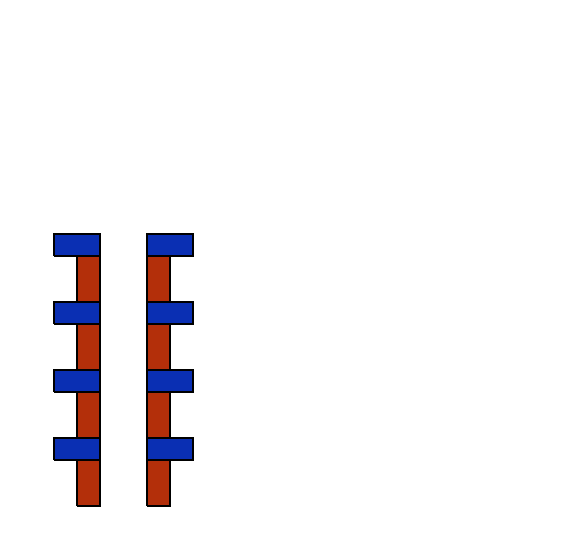

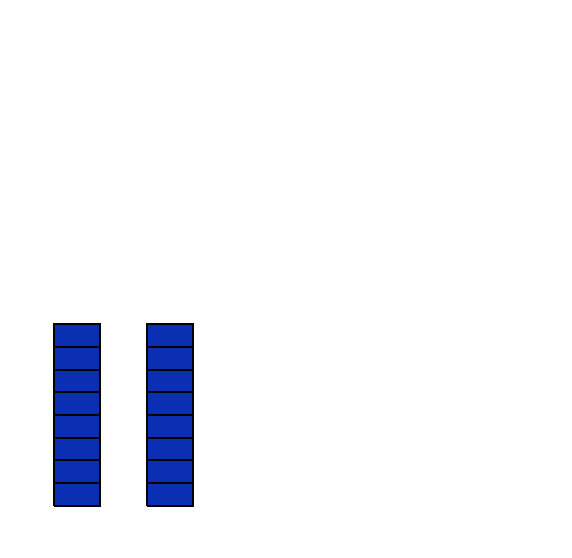

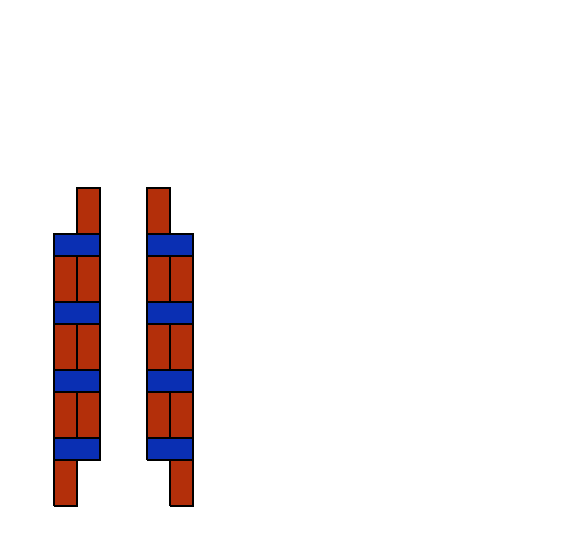

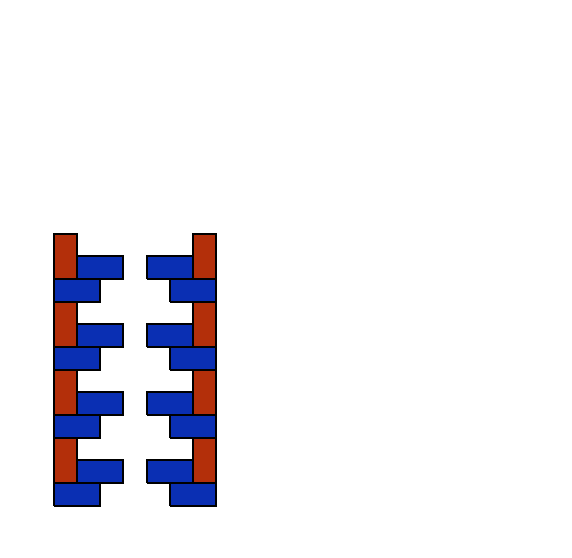

KeyboardInterrupt: 

In [654]:
# Stack mirrored

for chunk in chunks:

    w = new_world()
    stack(w, chunk, n = 4, x_location = 0)
    stack(w, mirror(chunk), n = 4, x_location = 4)
    mirror
    if not w.broken:
        utils.draw_world(w)

### Make a row of towers

still good: True


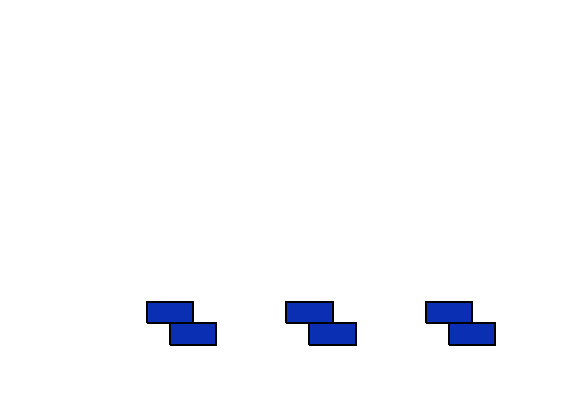

In [500]:
w = new_world()
row(w,chunks[3], 3, 3)
print('still good:', not w.broken)
utils.draw_world(w)

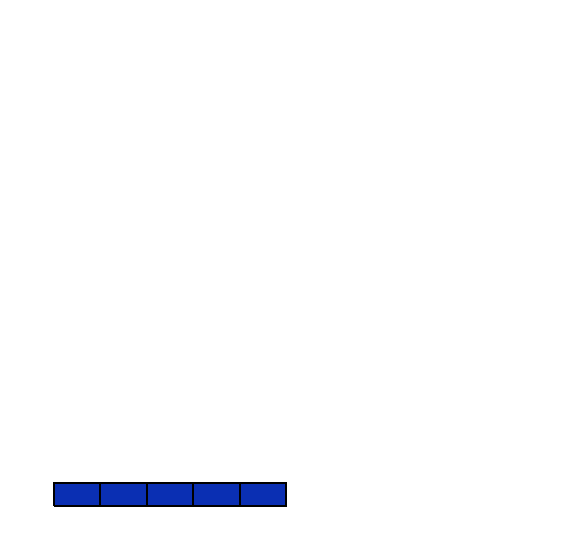

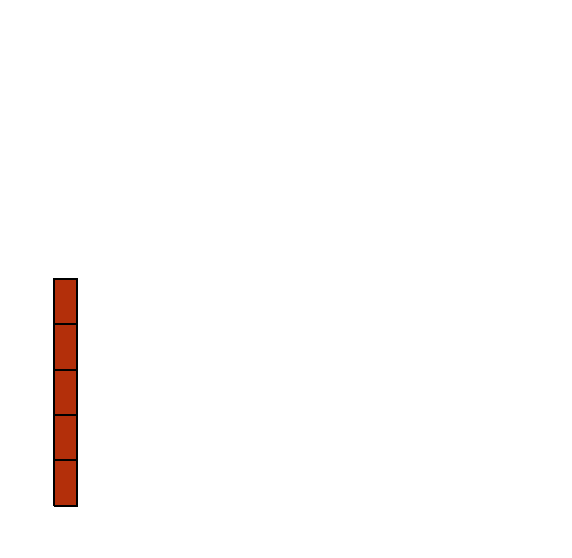

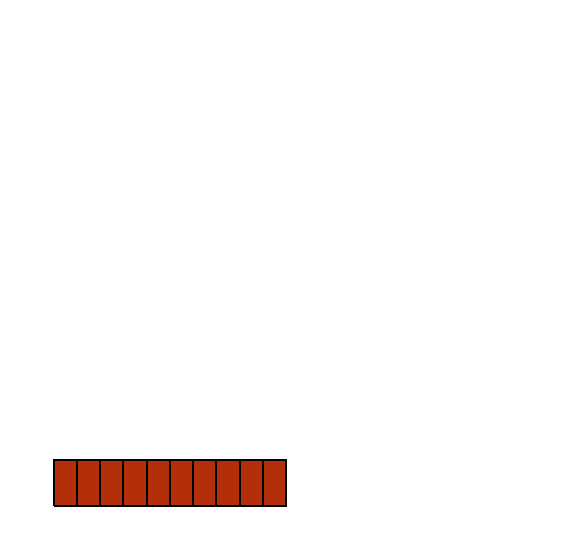

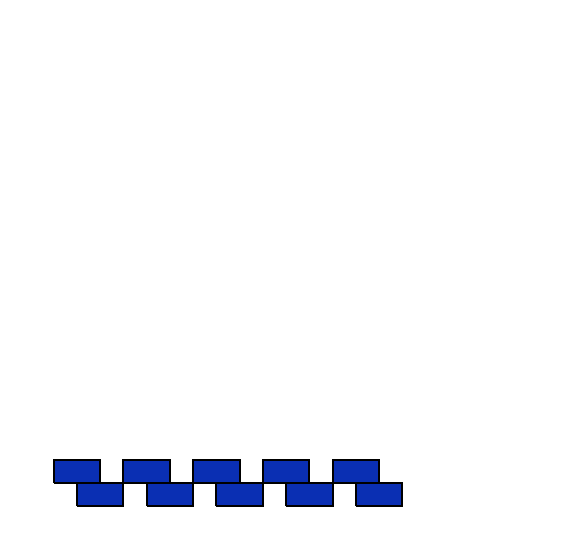

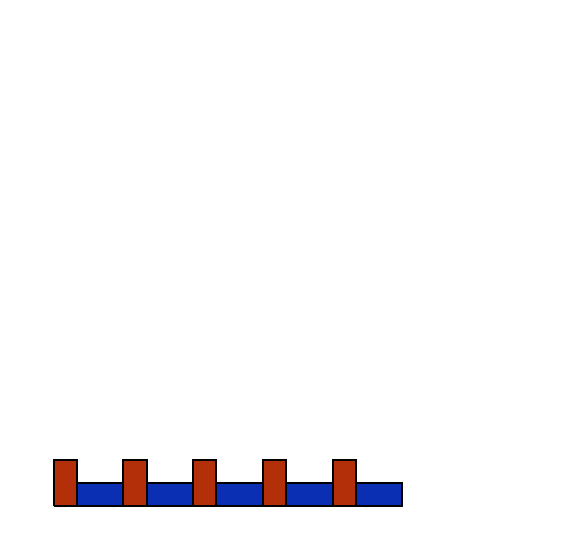

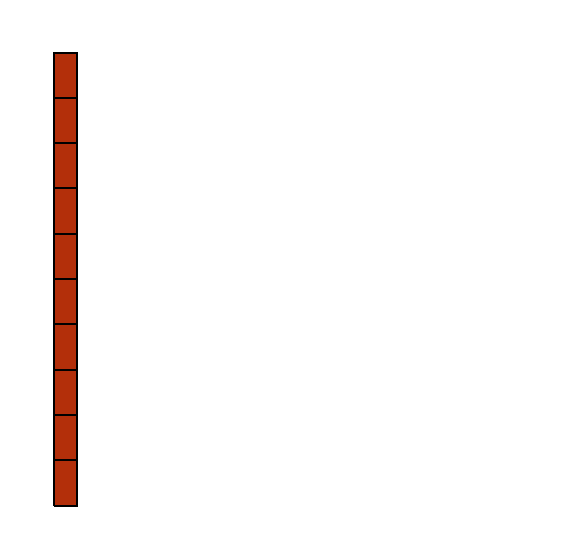

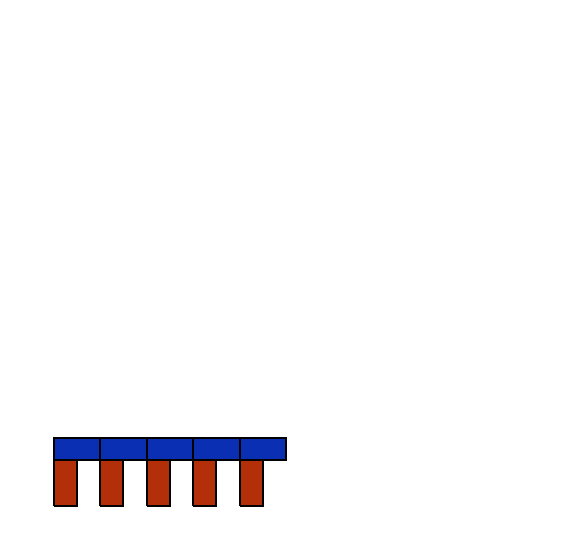

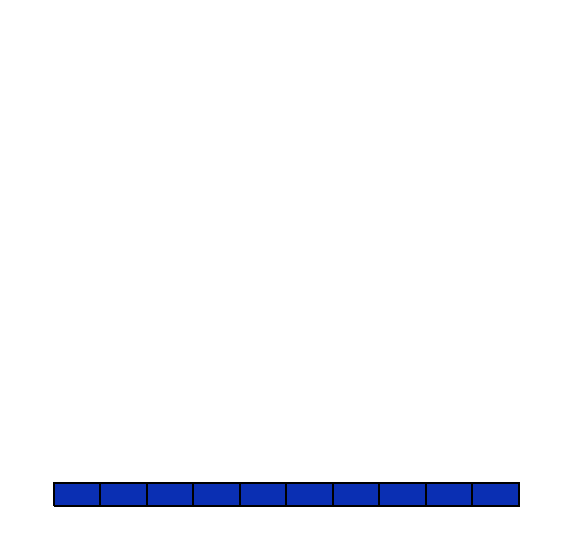

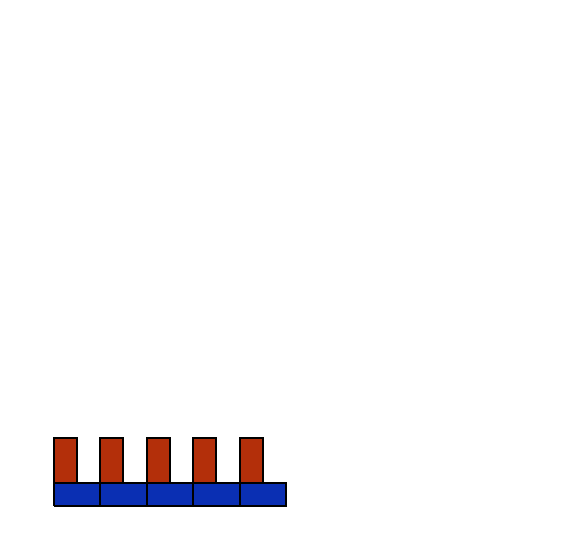

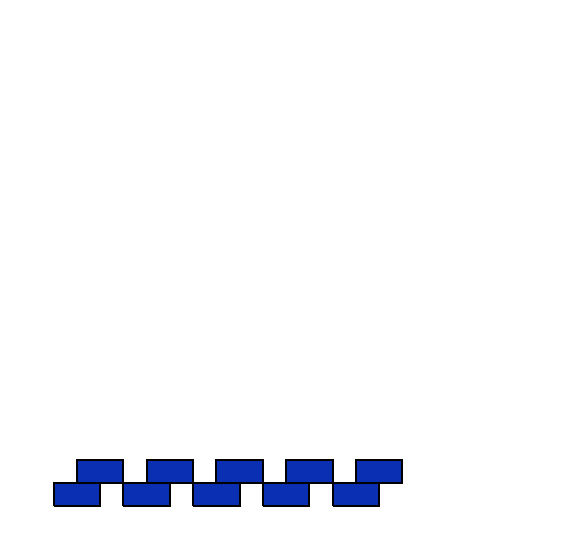

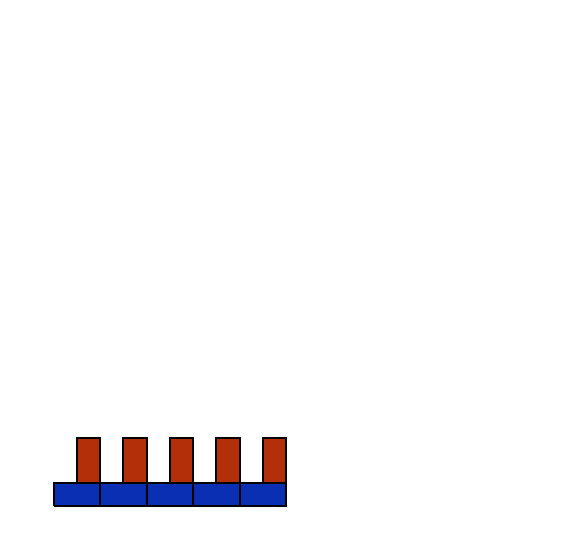

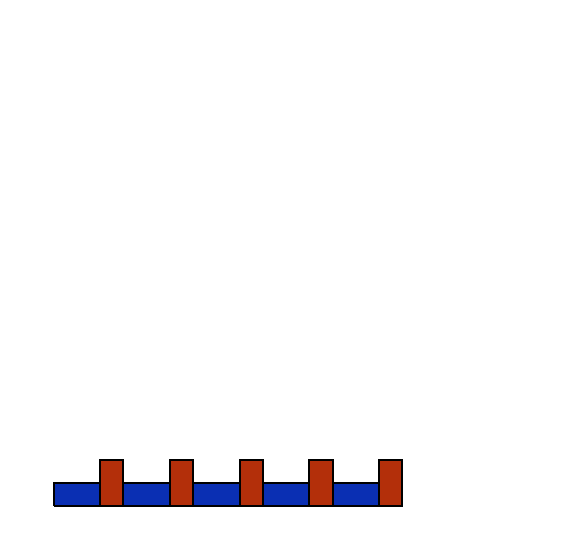

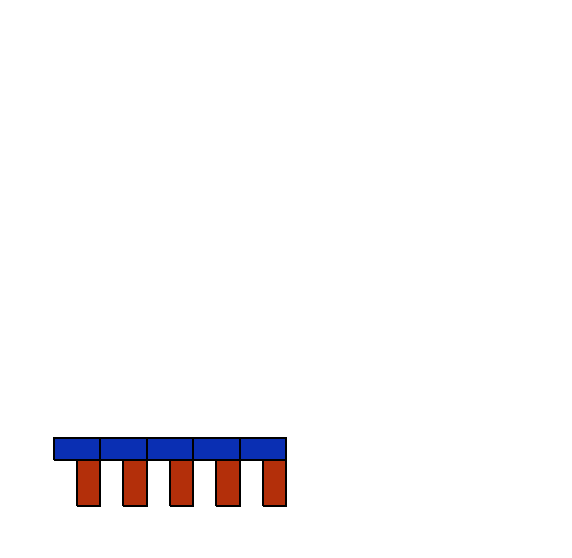

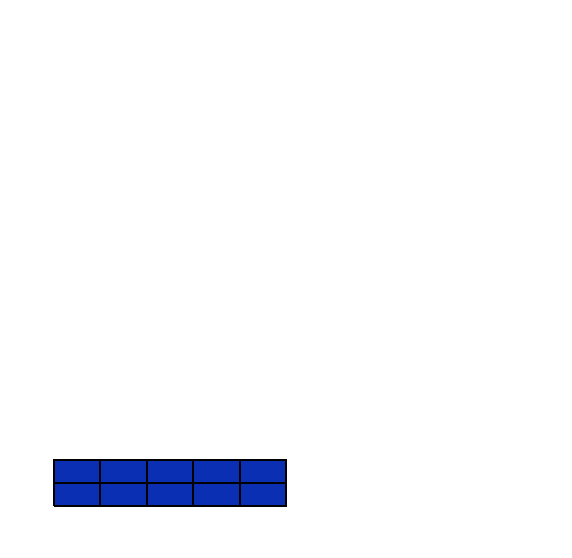

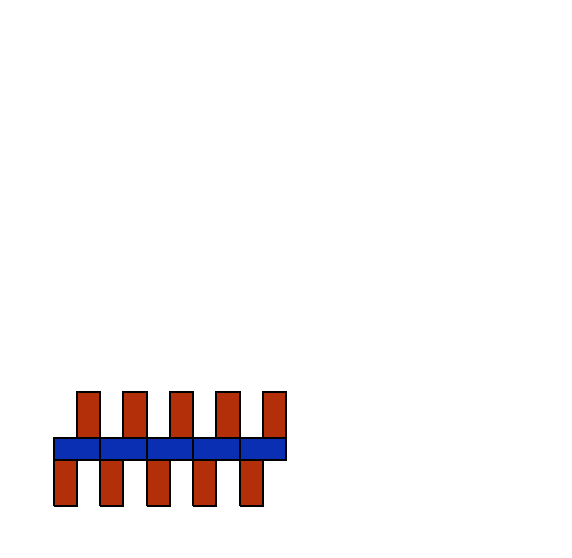

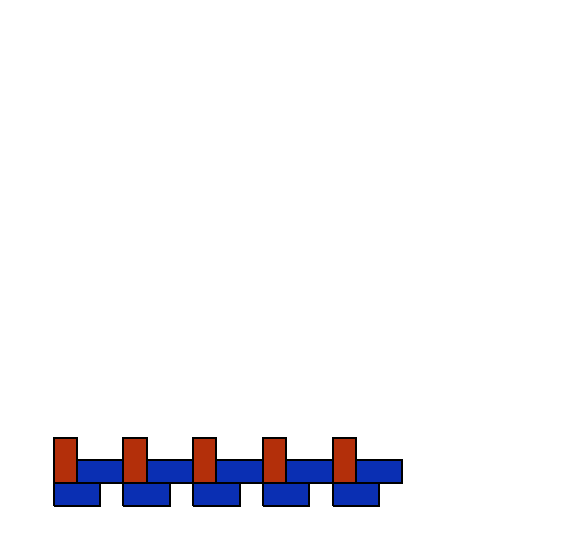

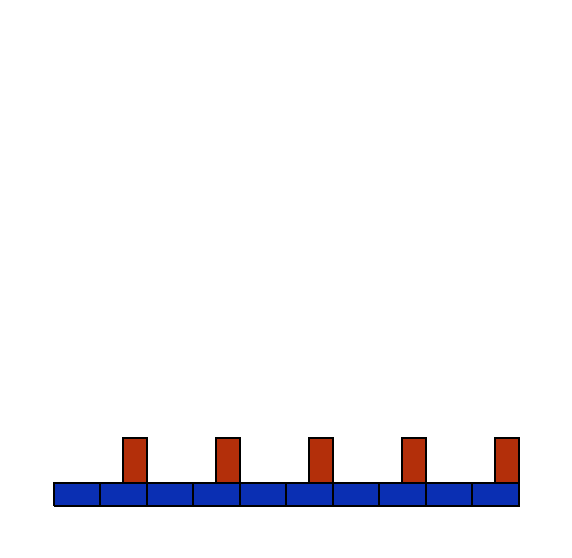

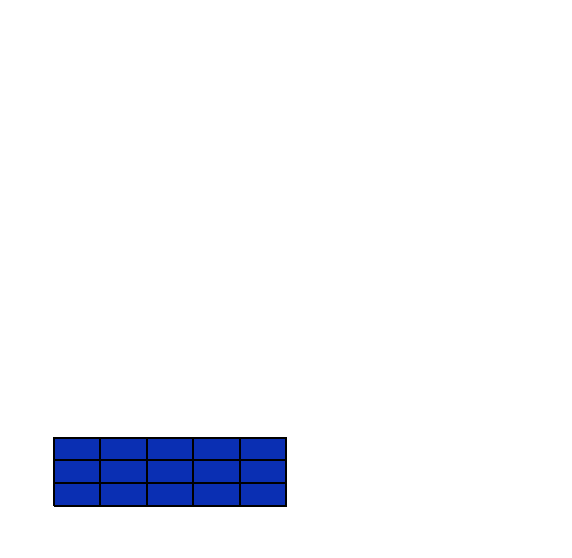

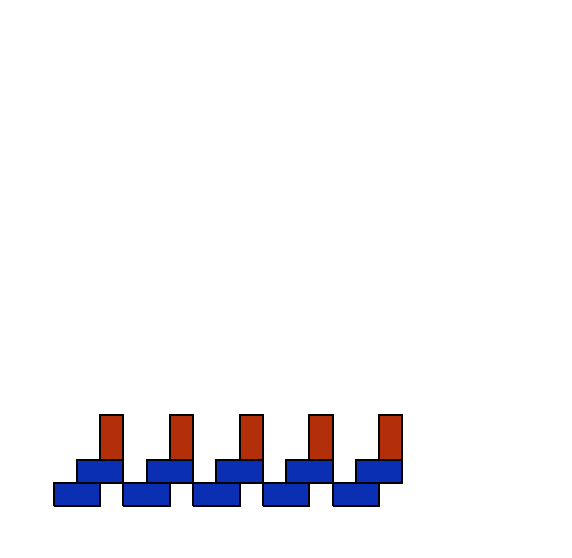

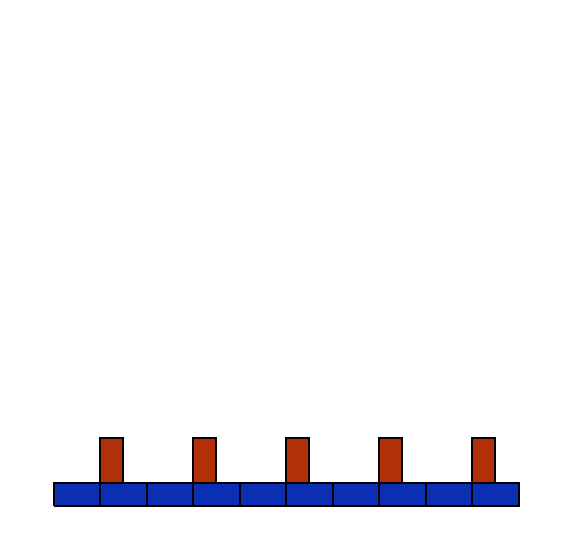

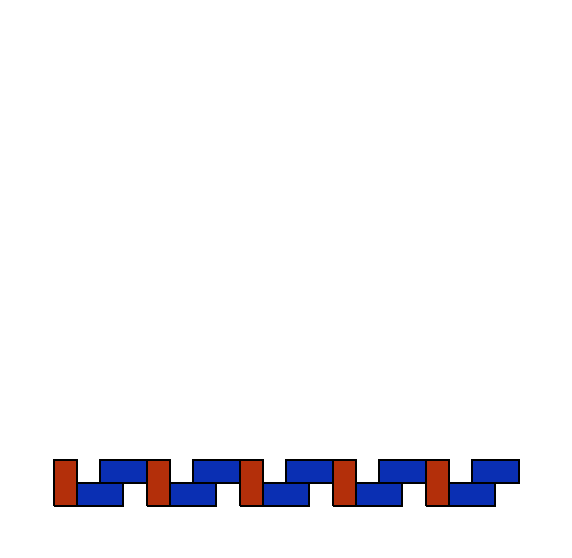

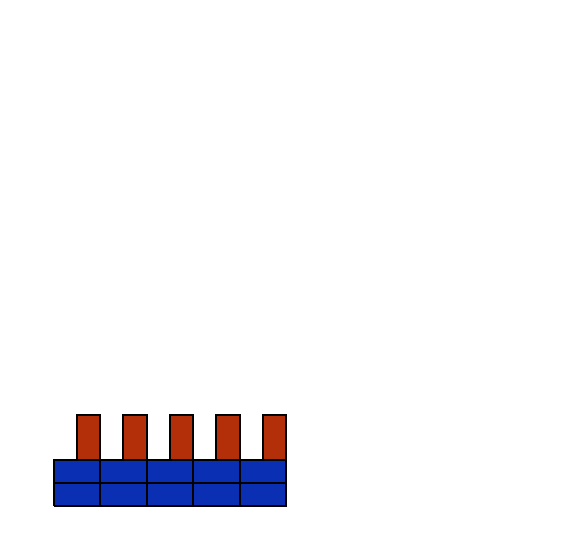

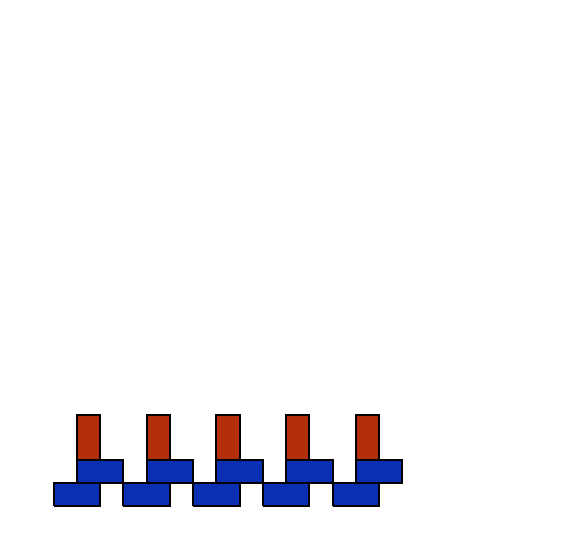

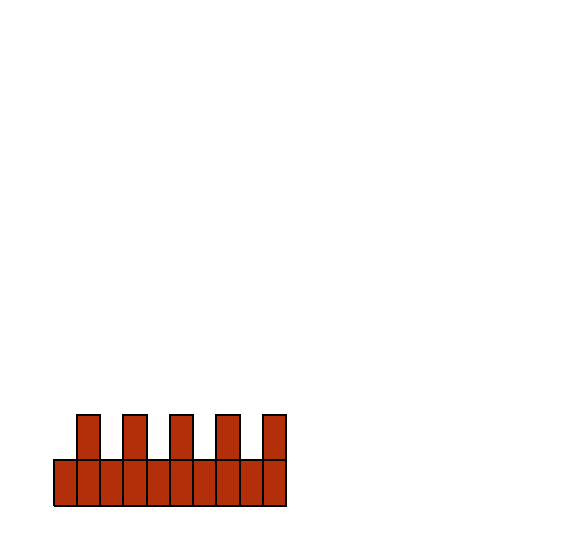

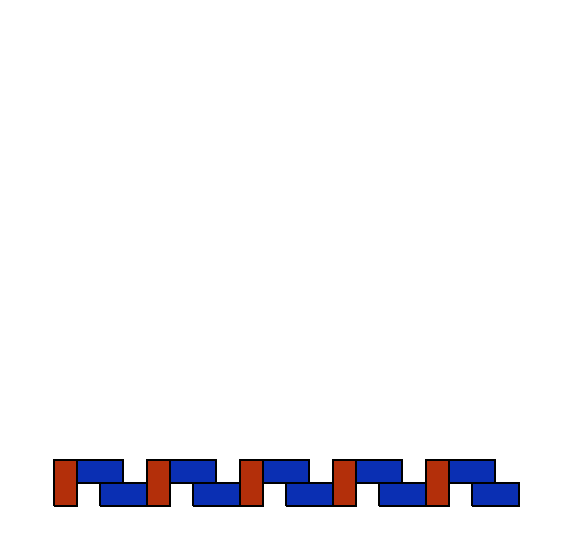

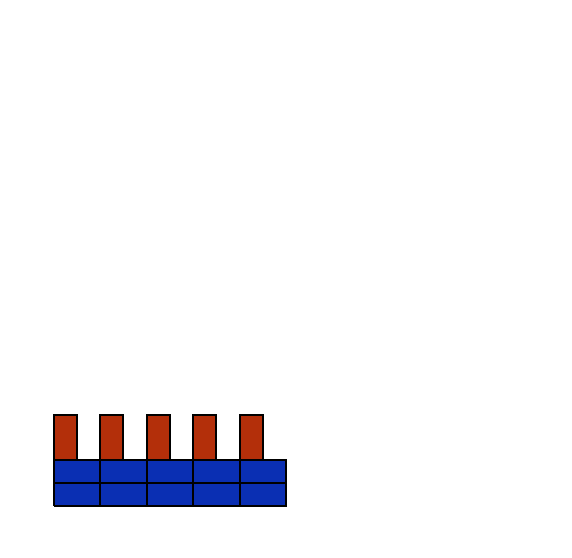

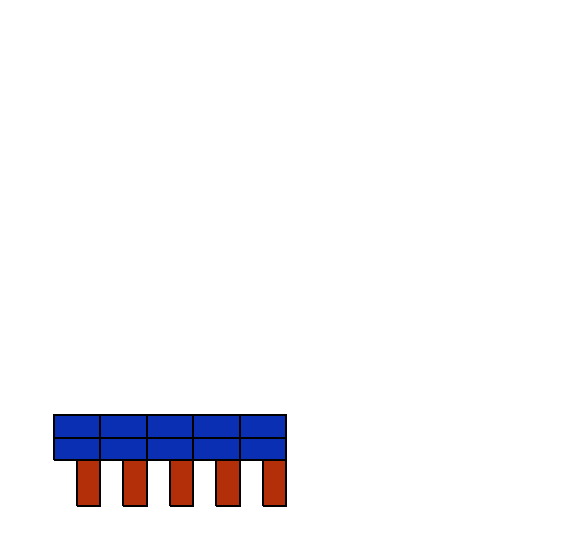

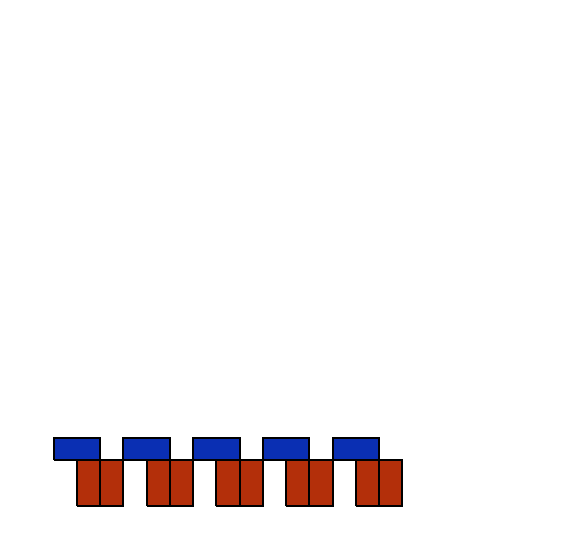

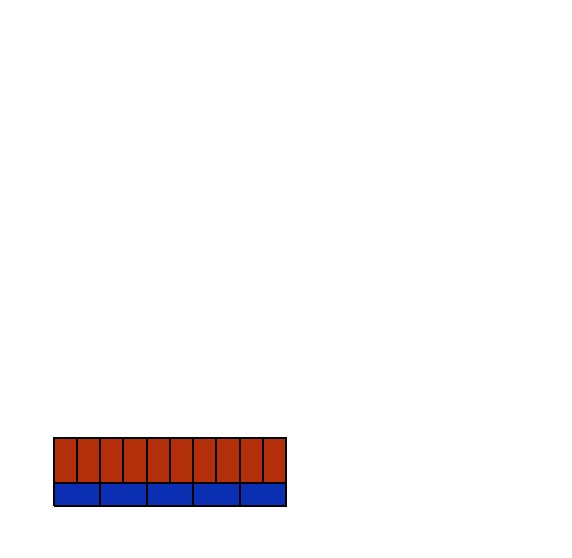

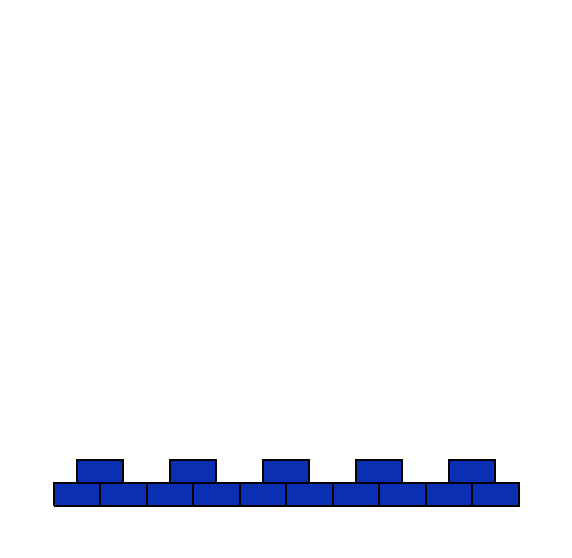

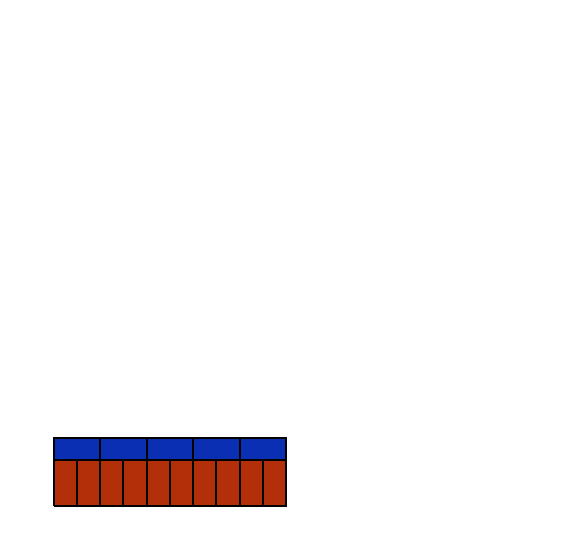

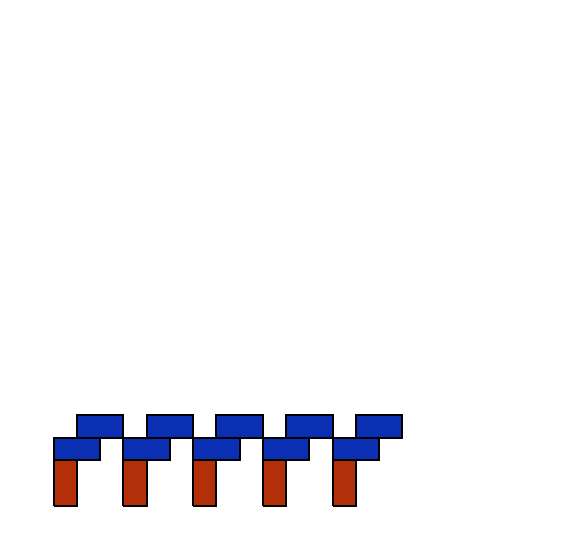

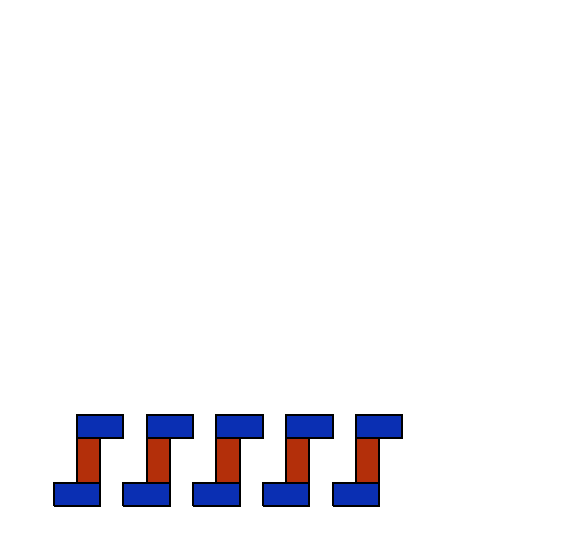

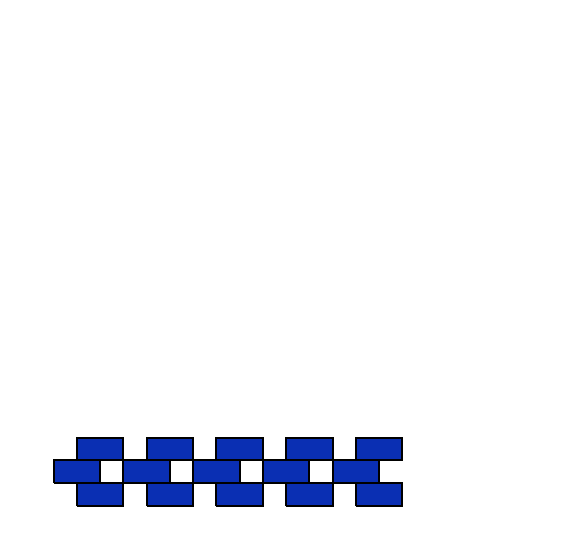

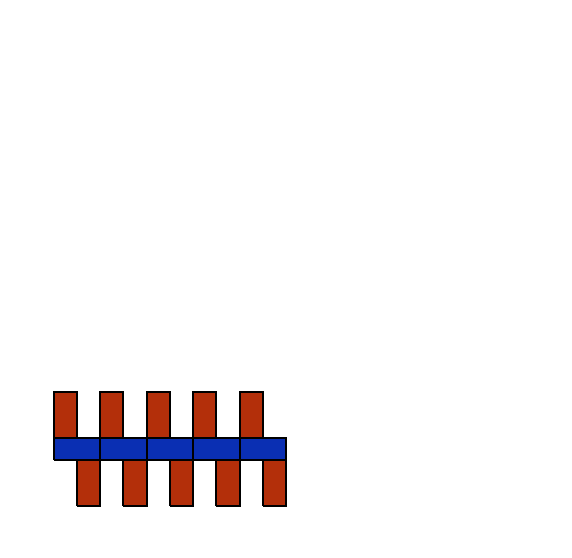

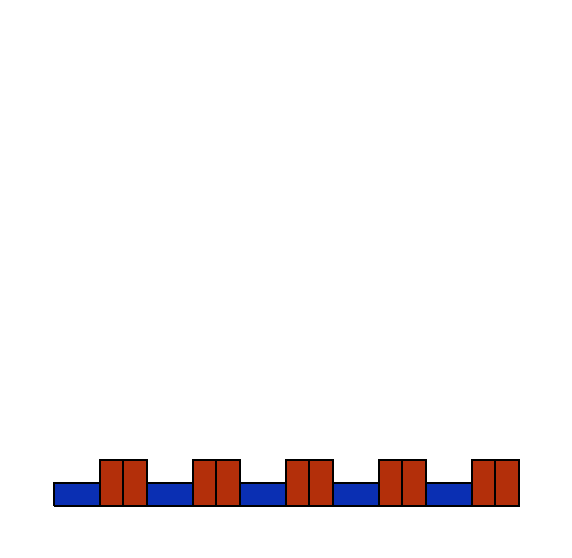

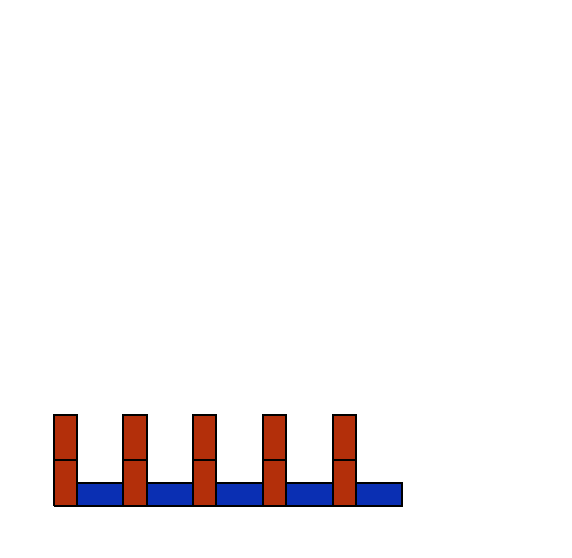

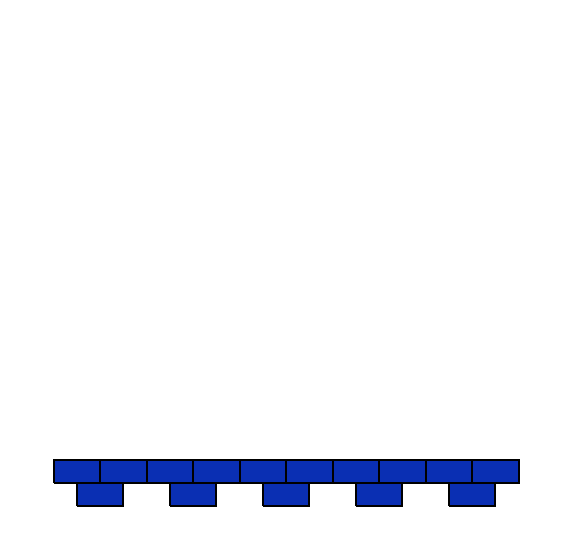

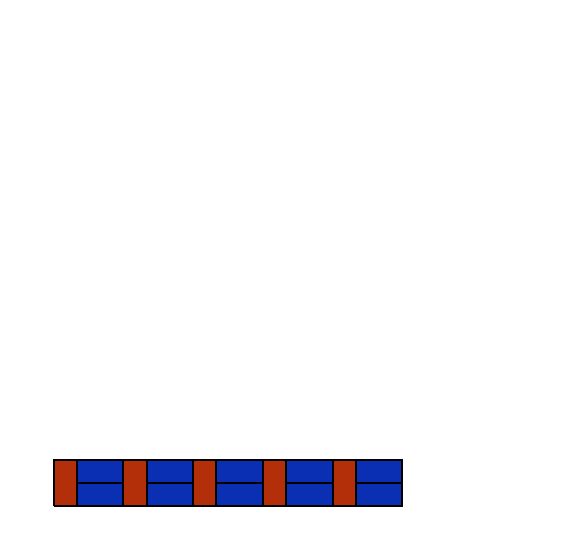

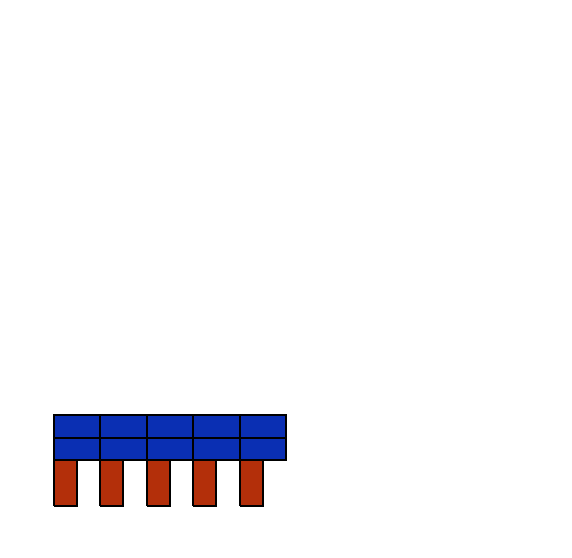

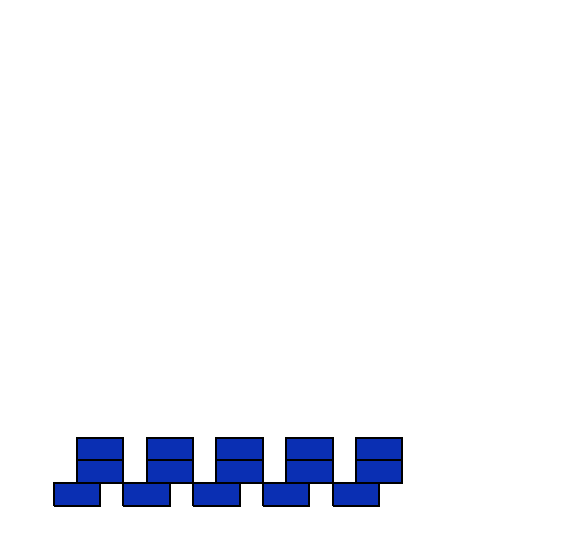

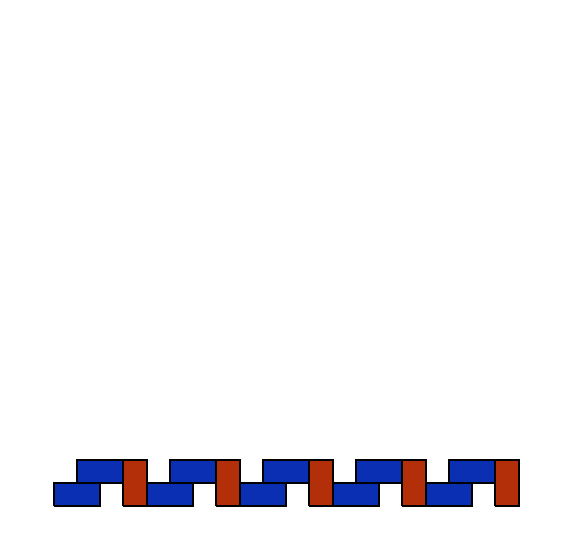

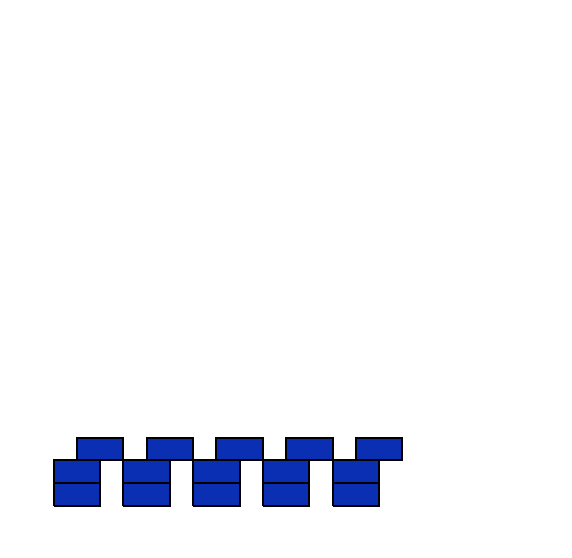

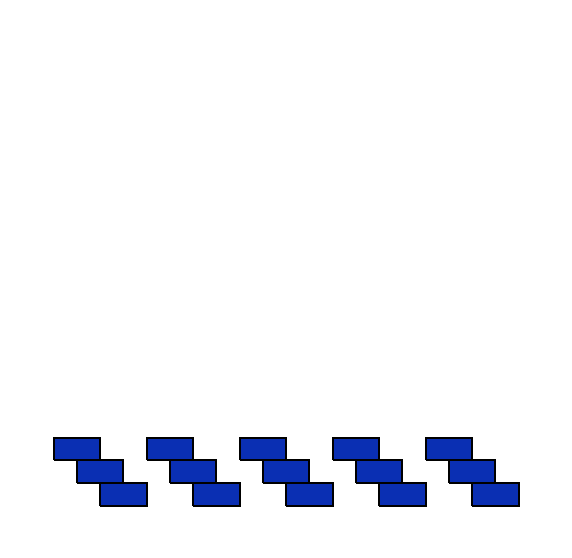

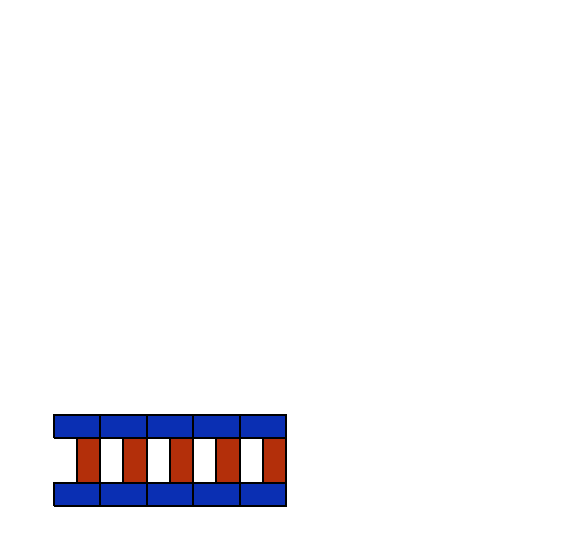

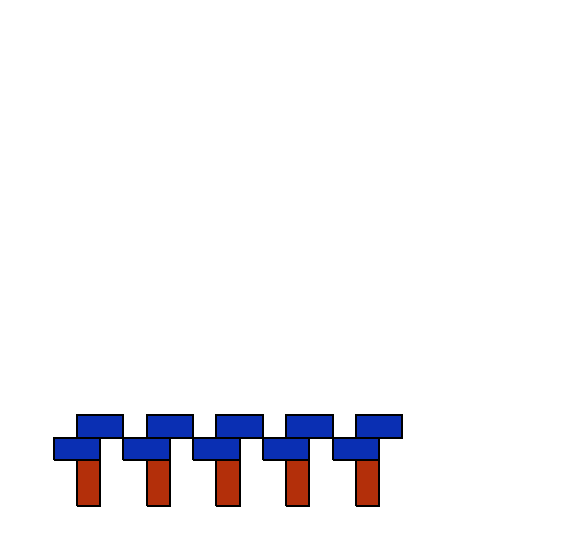

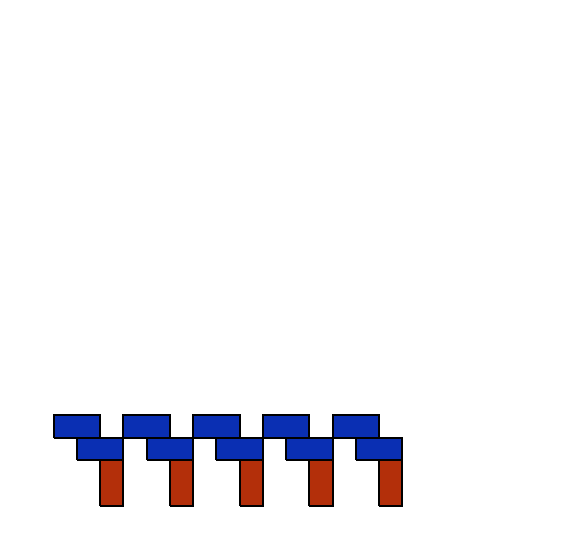

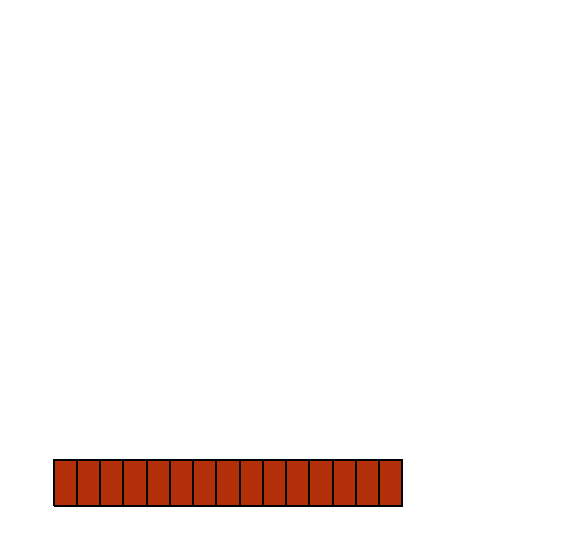

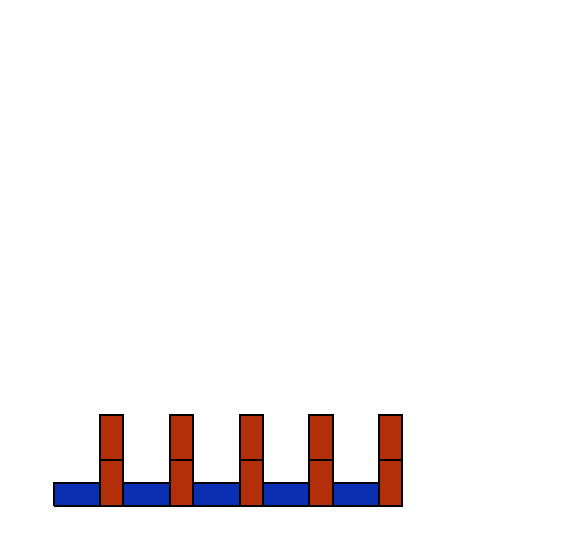

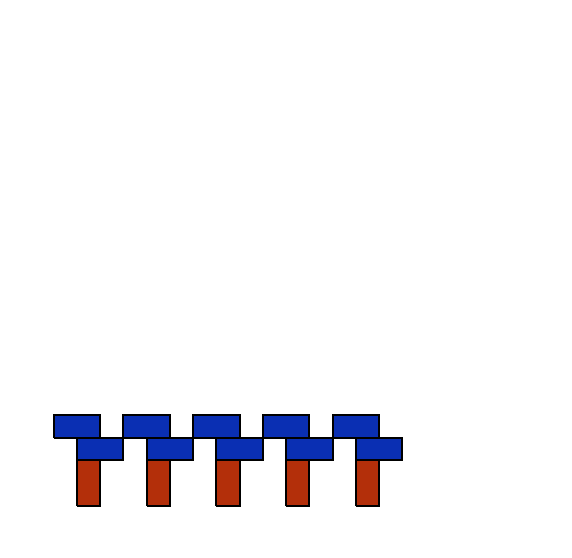

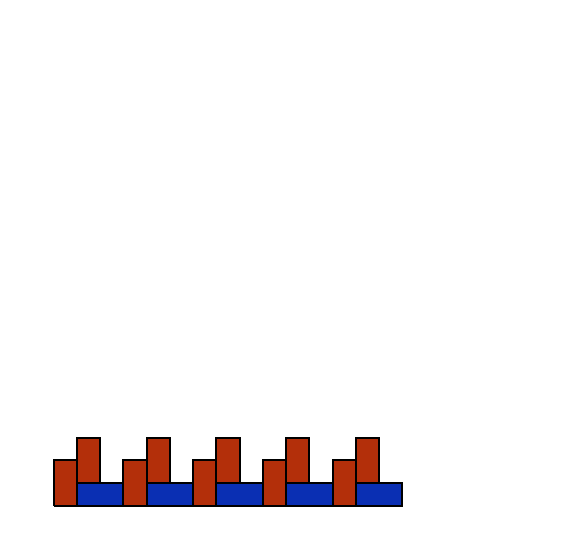

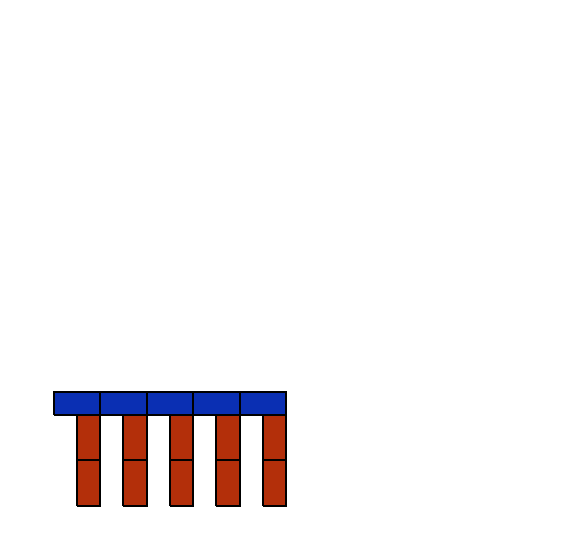

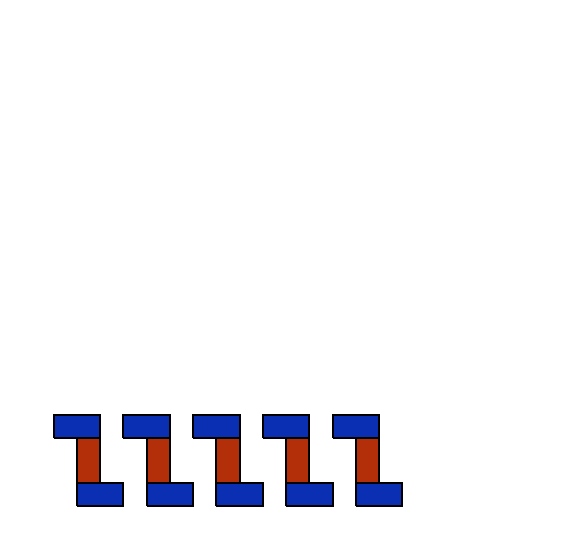

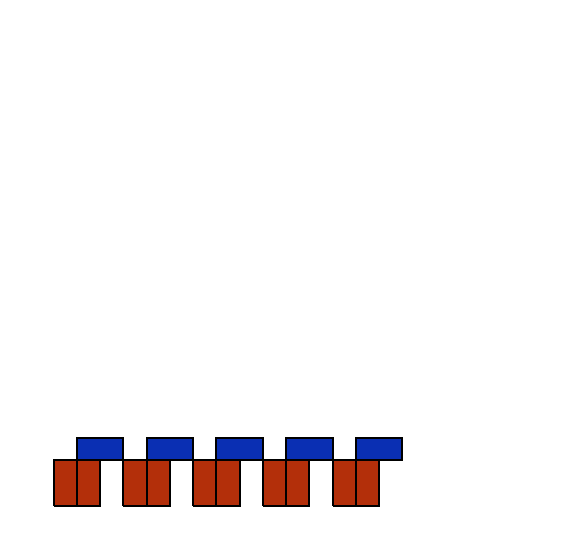

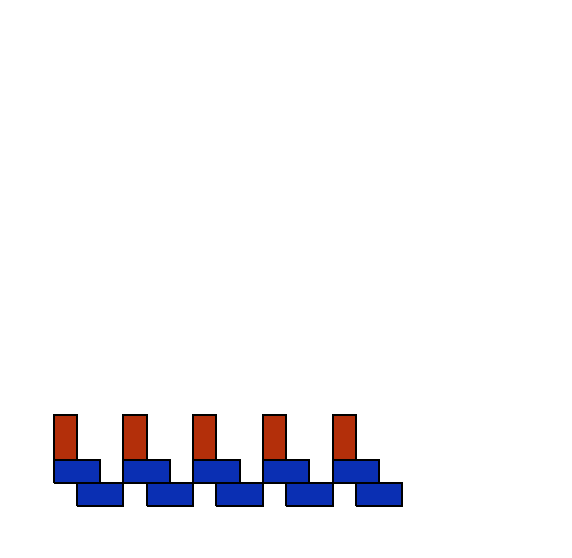

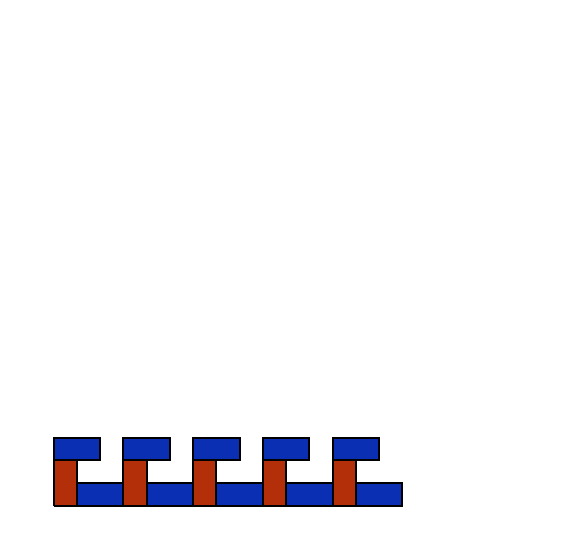

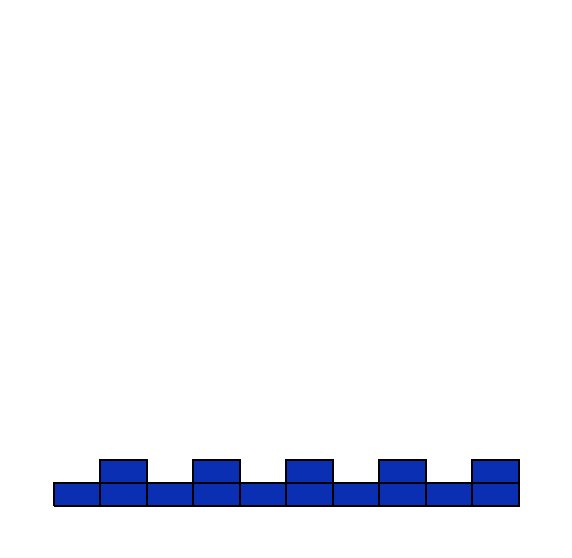

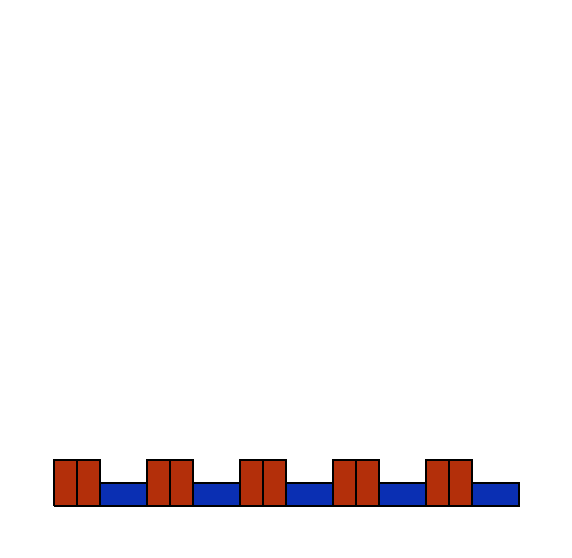

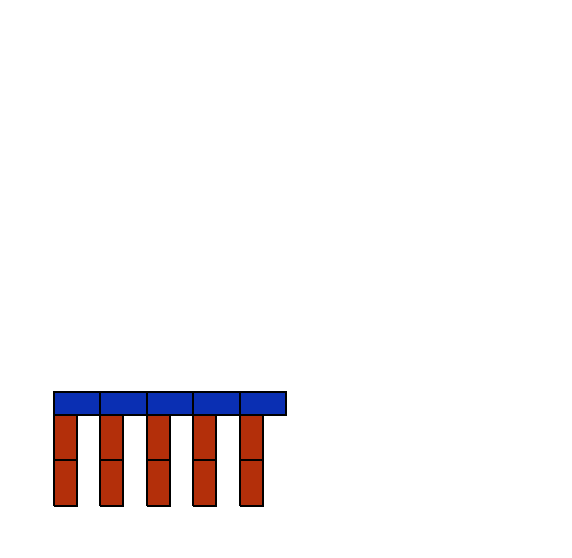

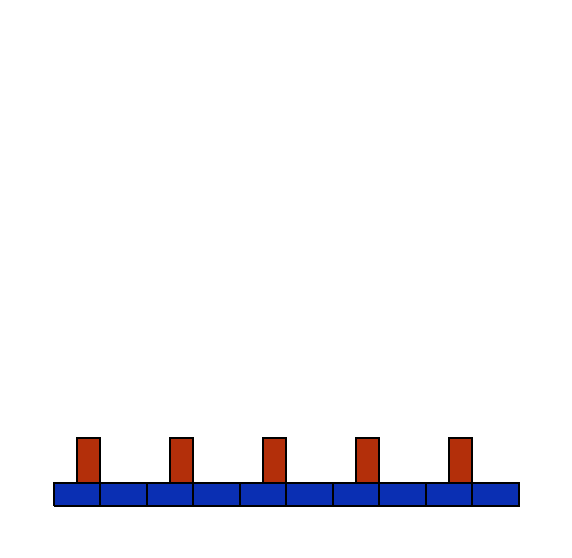

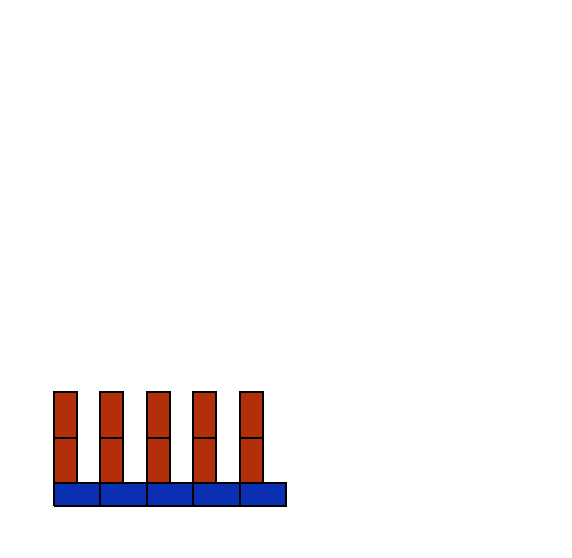

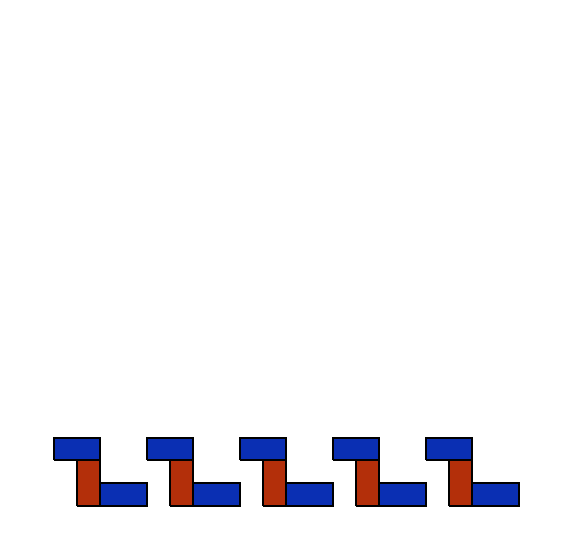

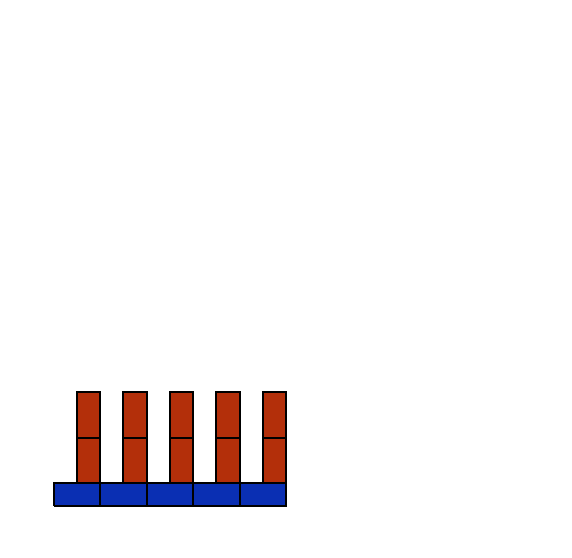

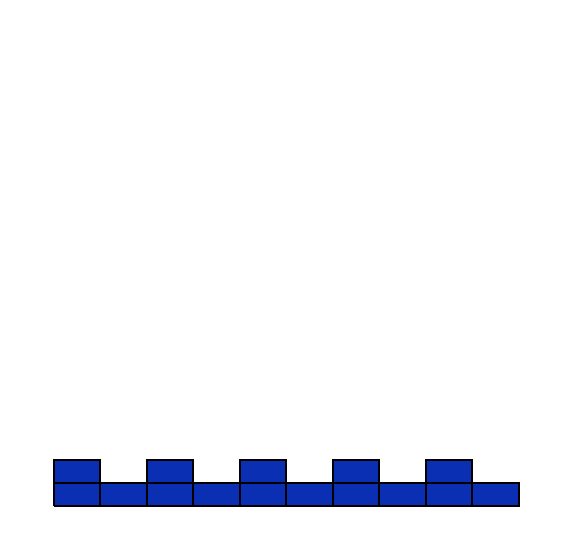

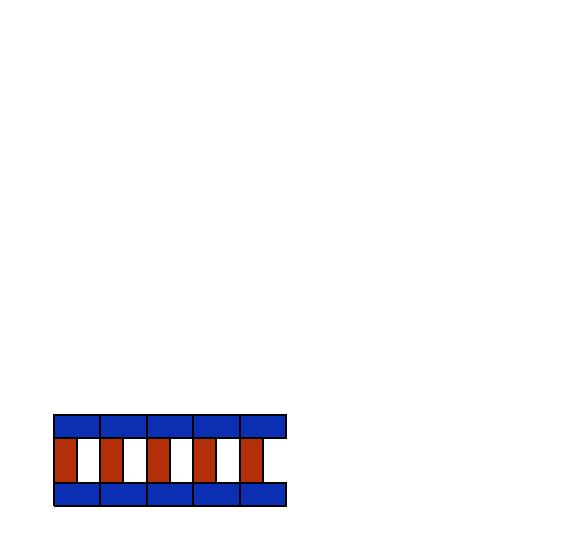

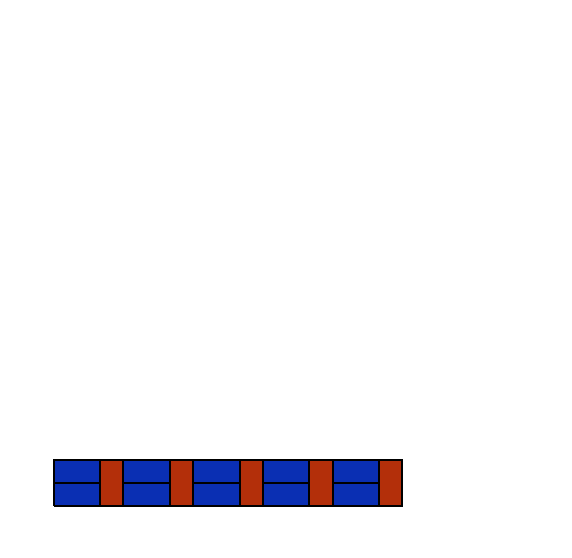

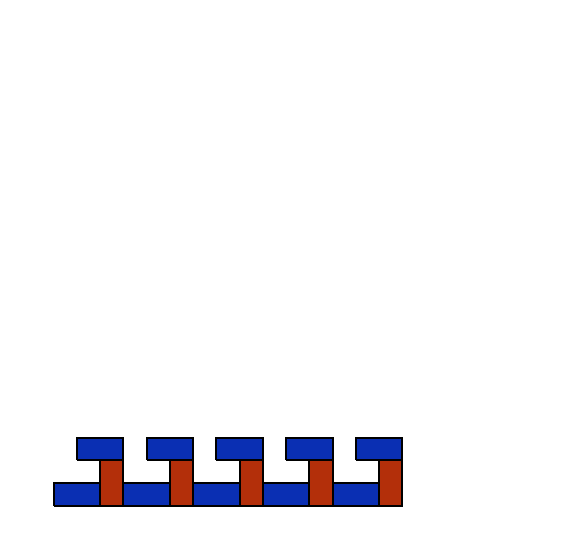

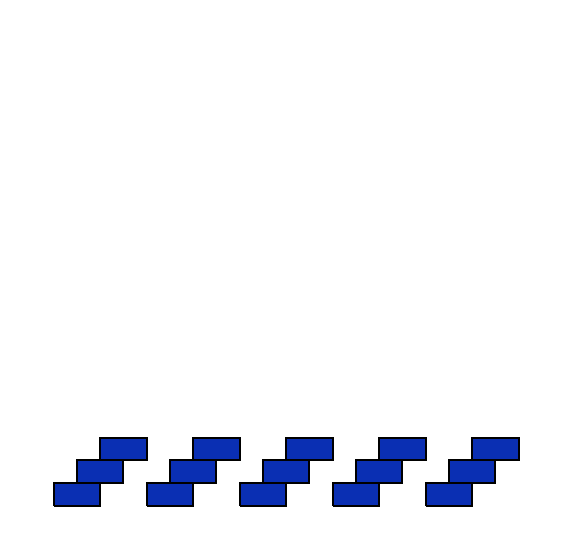

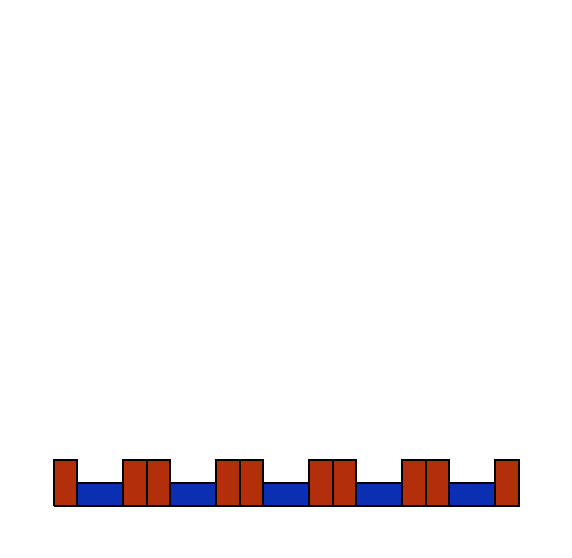

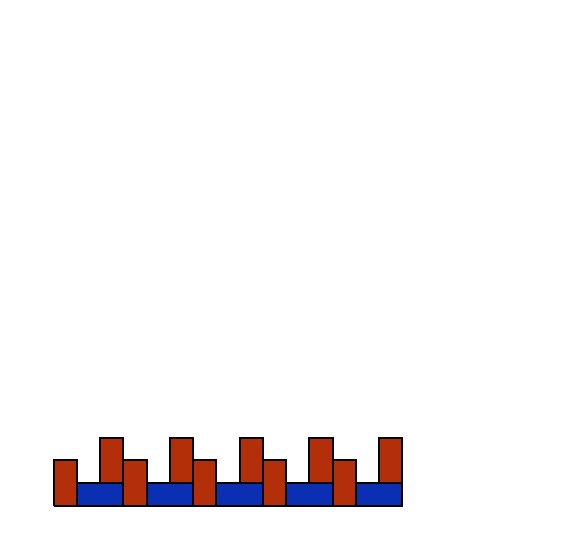

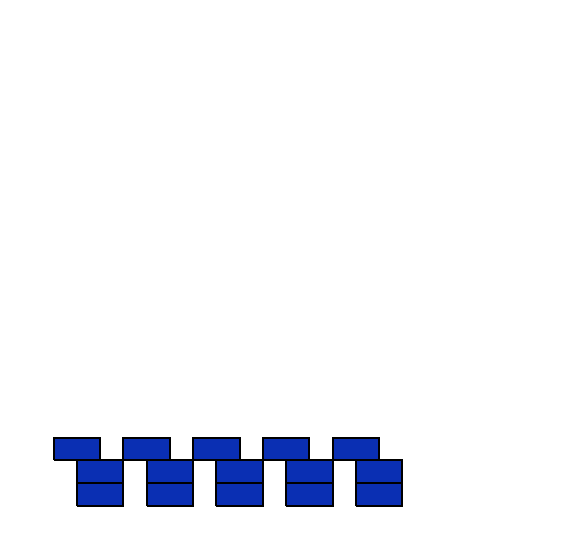

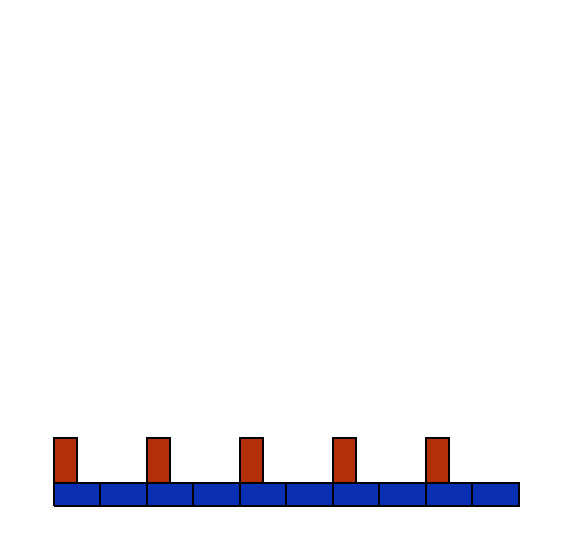

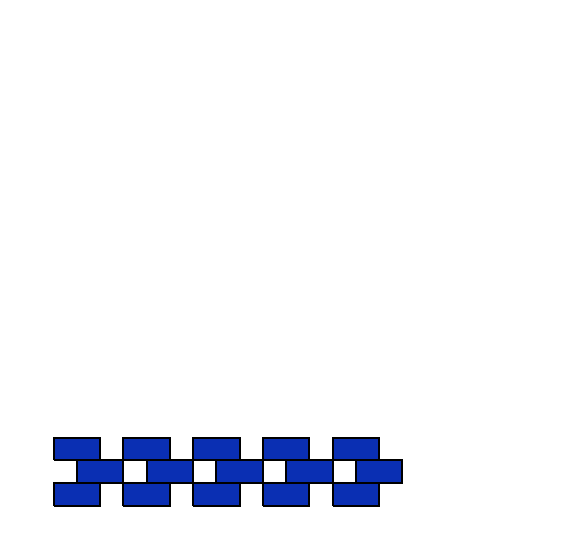

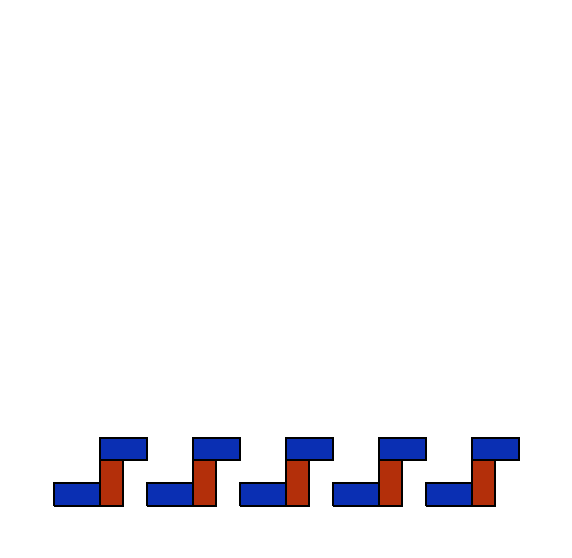

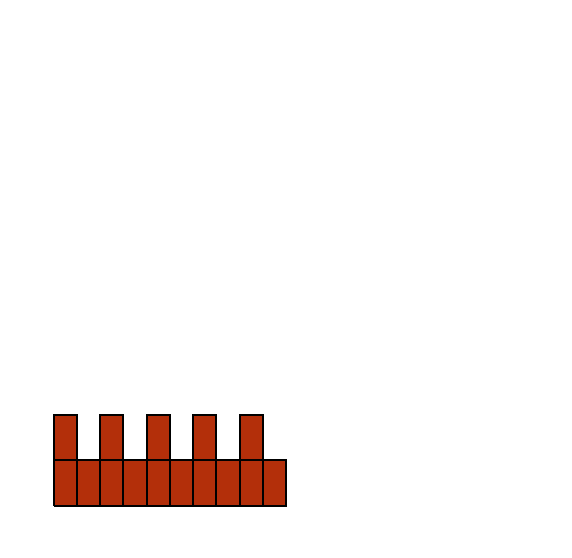

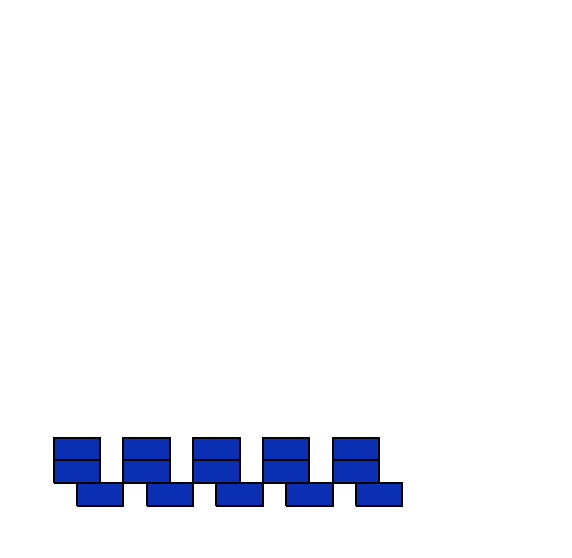

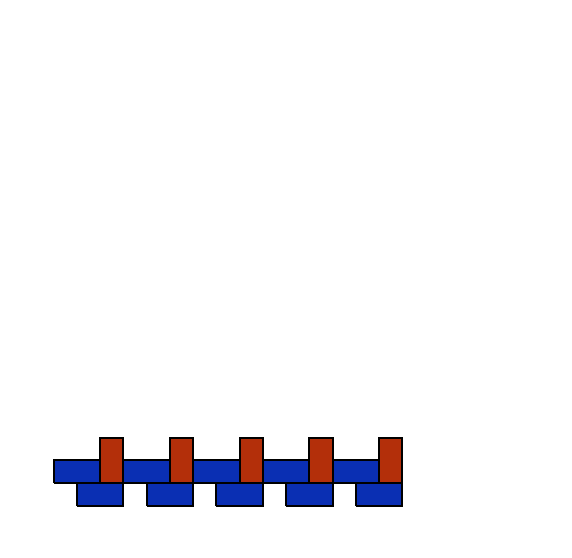

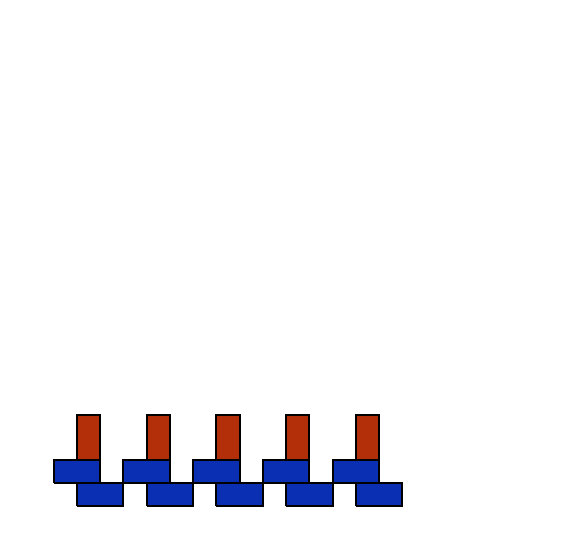

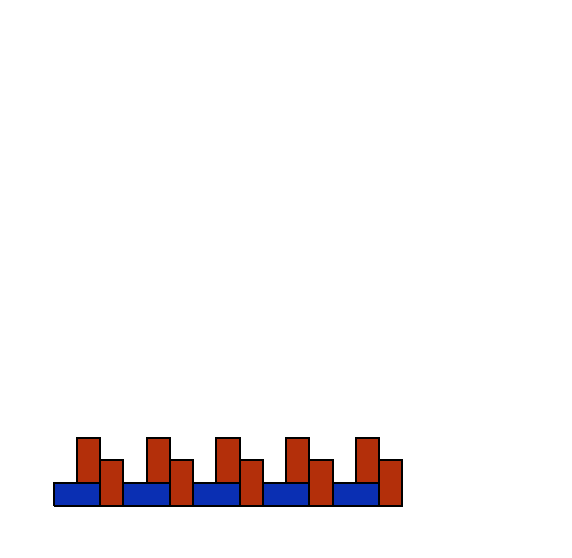

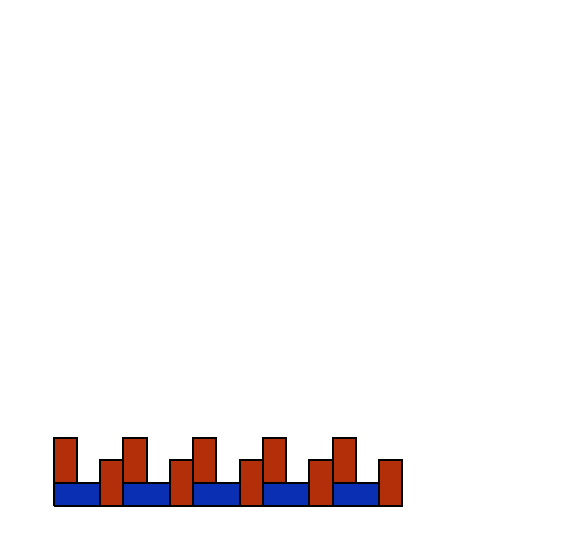

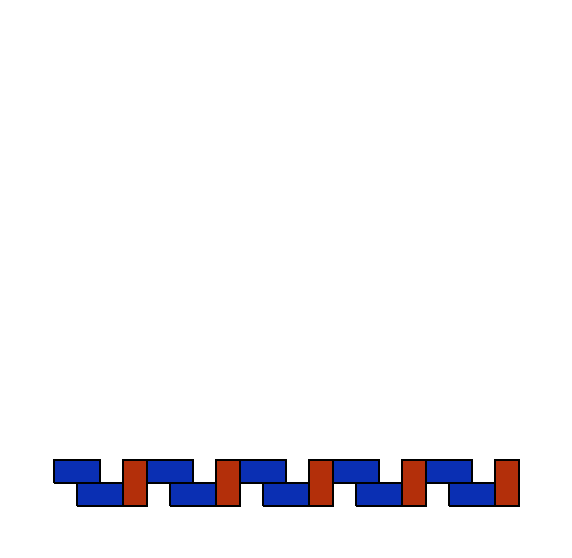

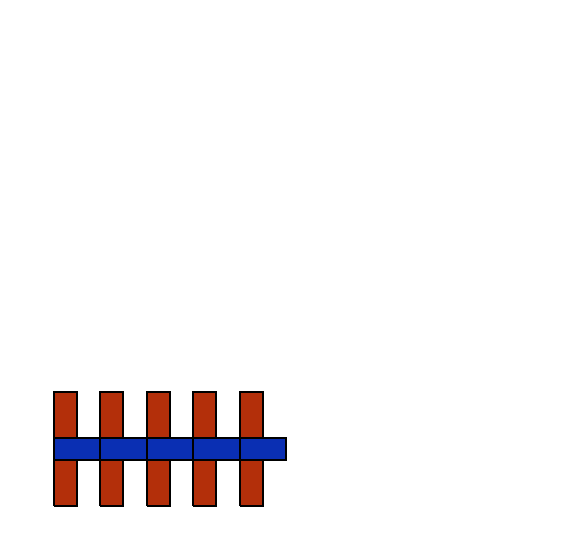

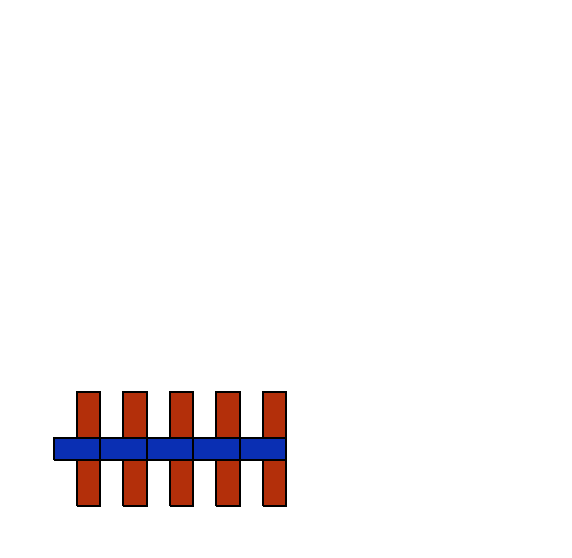

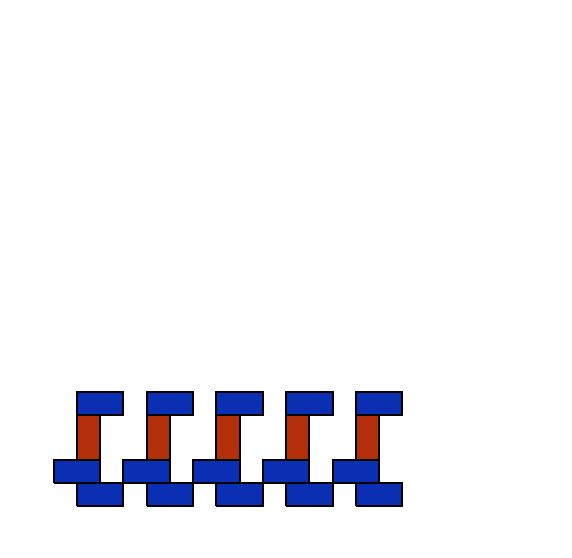

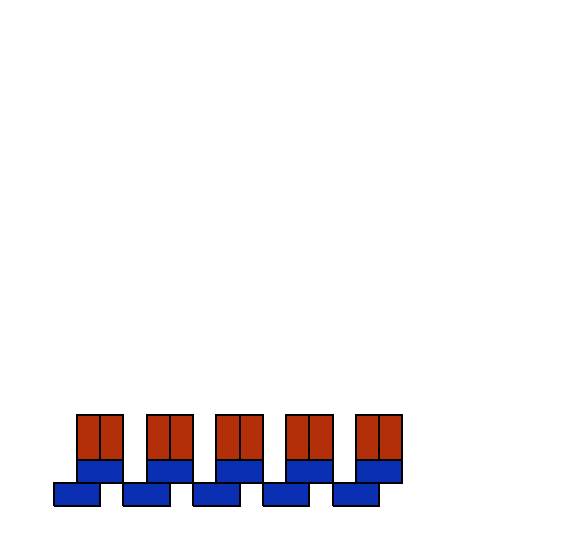

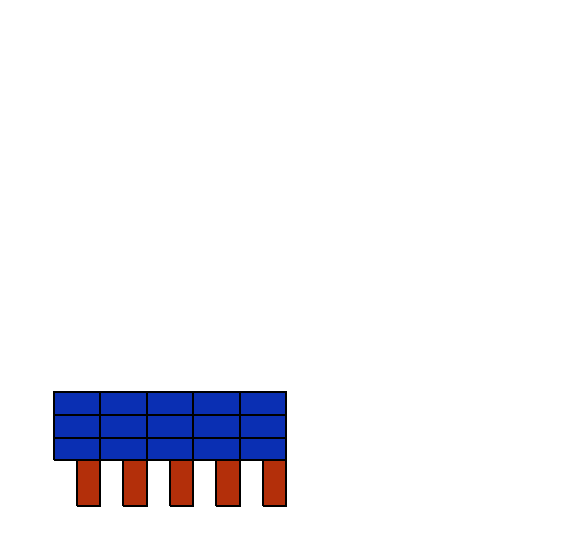

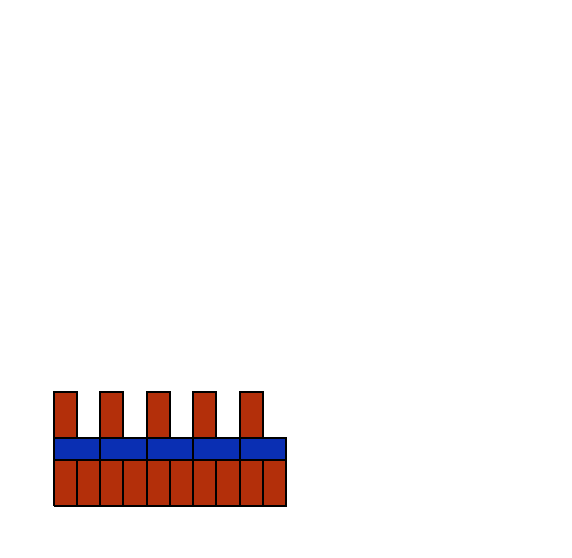

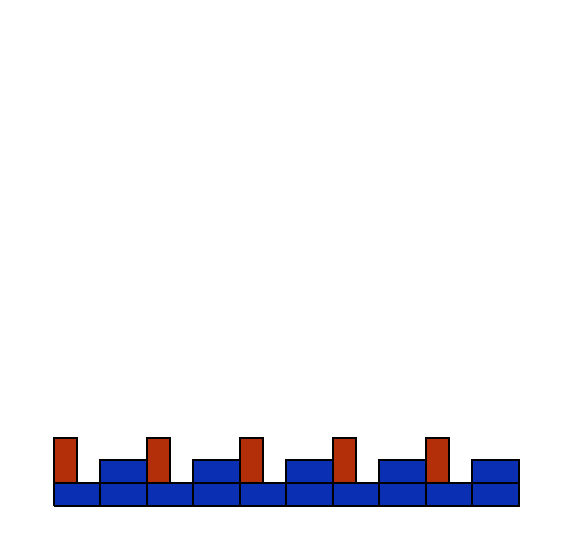

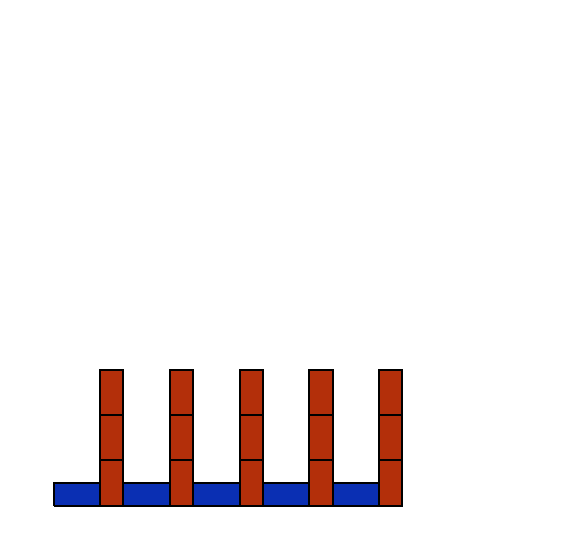

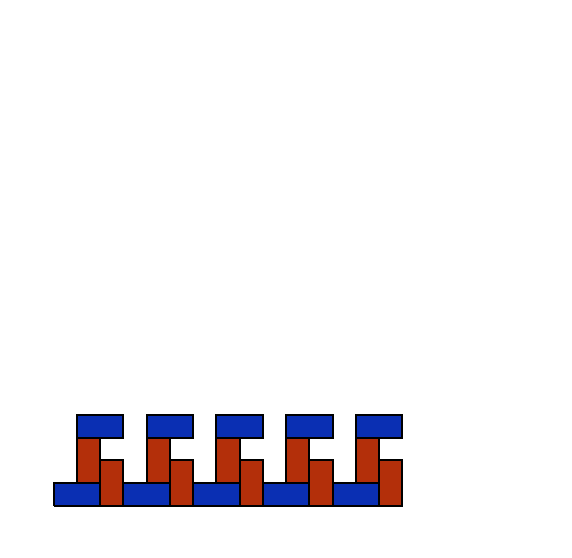

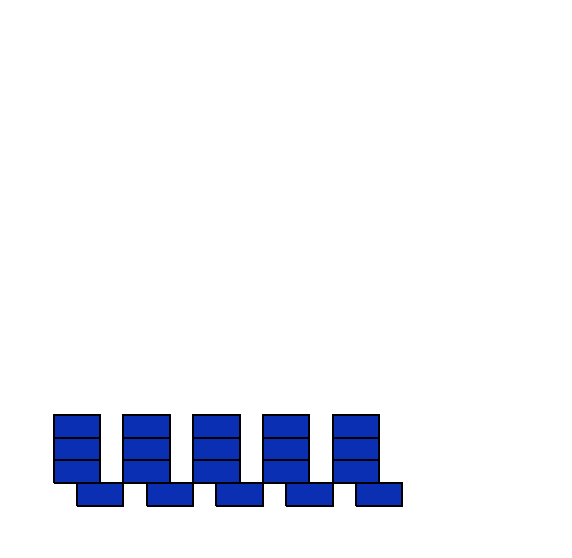

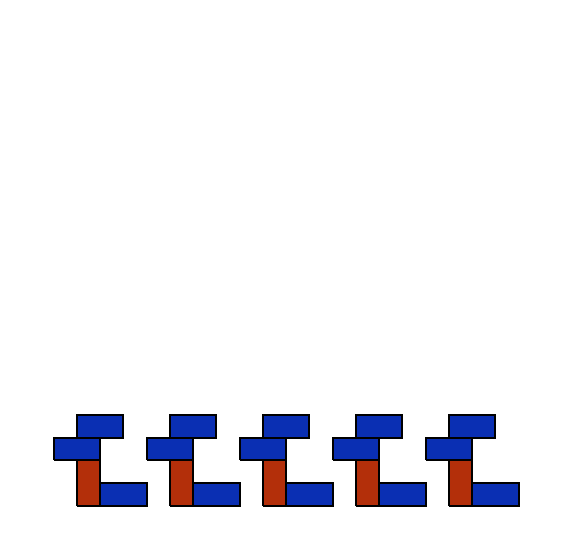

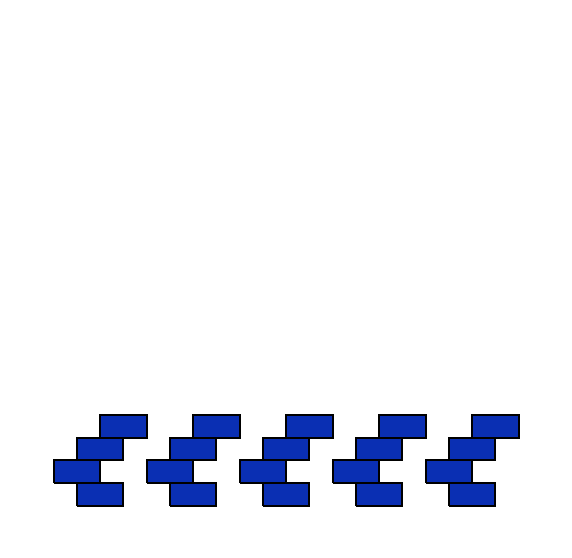

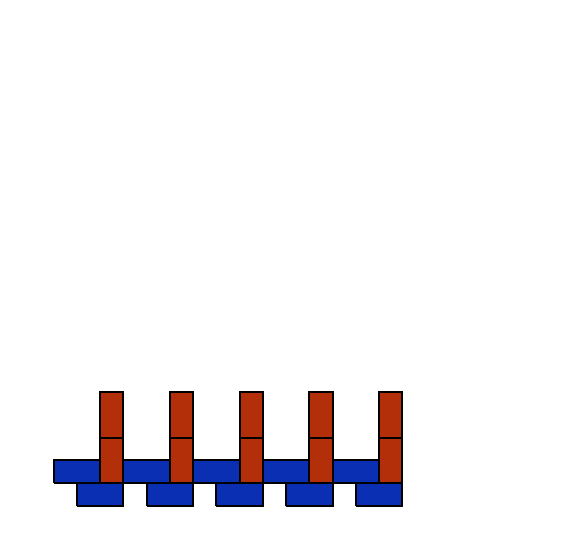

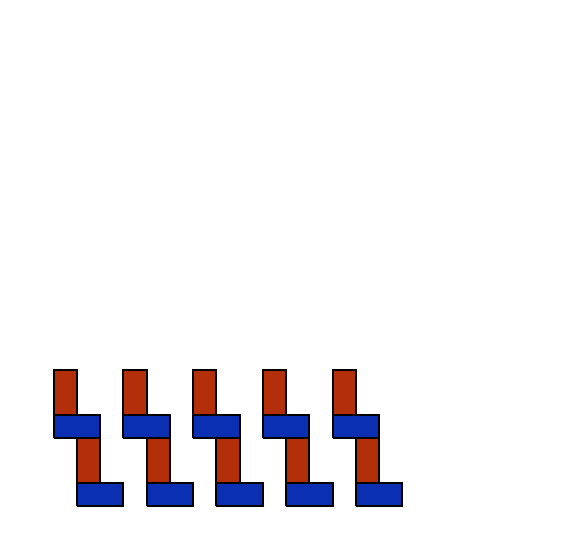

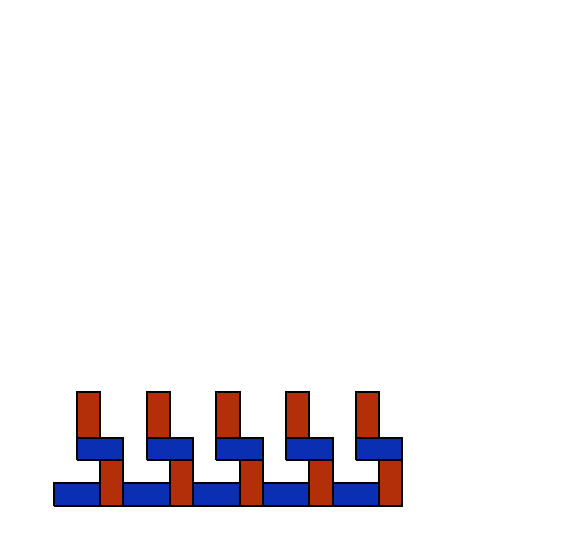

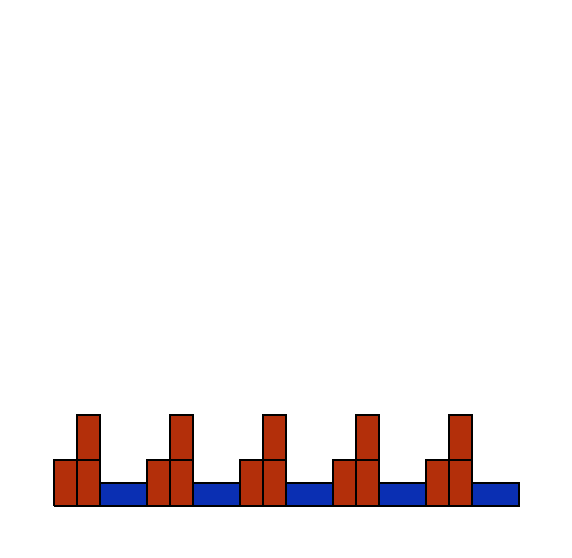

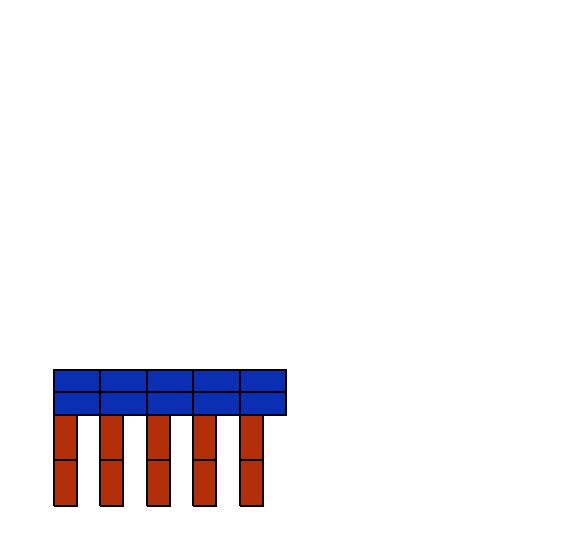

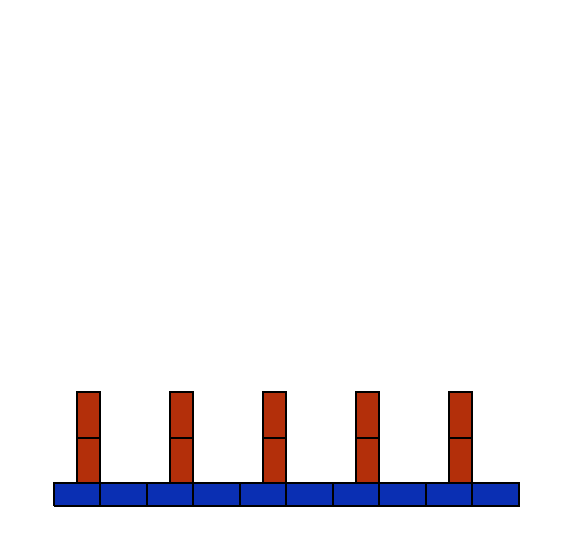

In [611]:
# Row

for chunk in chunks:

    w = new_world()
    row(w, chunk, n = 5, diff = 0)
    if not w.broken:
        utils.draw_world(w)

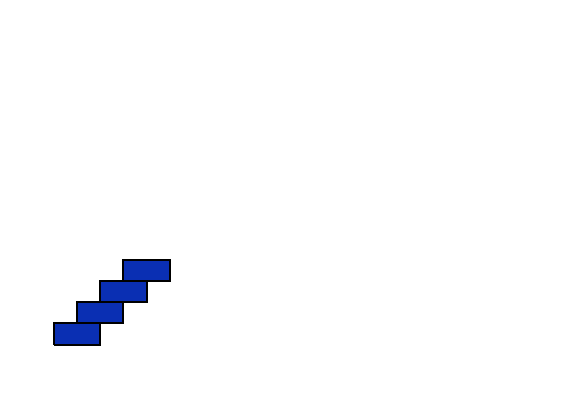

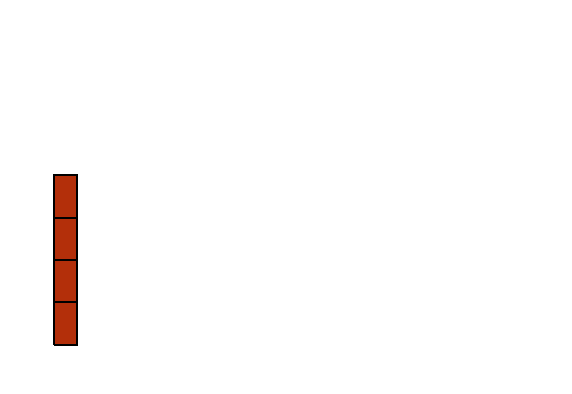

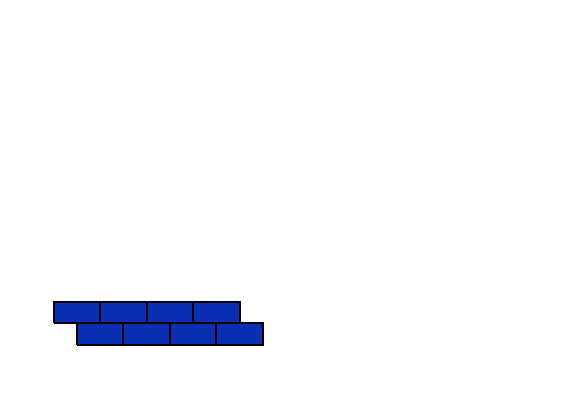

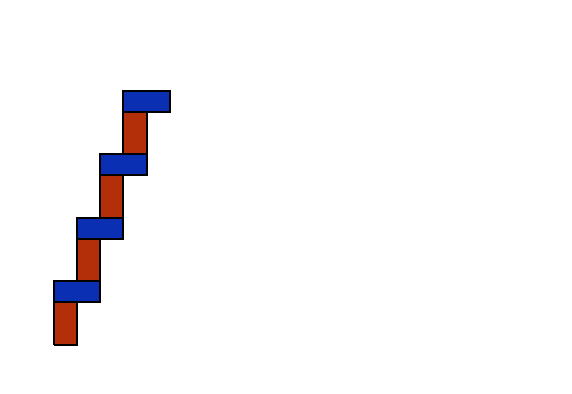

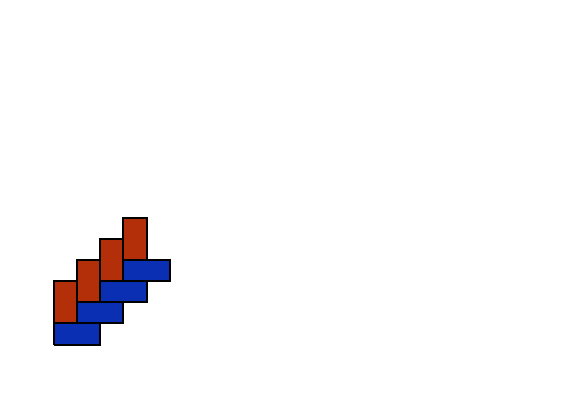

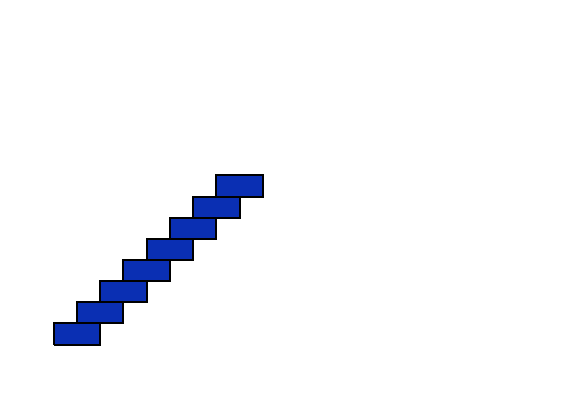

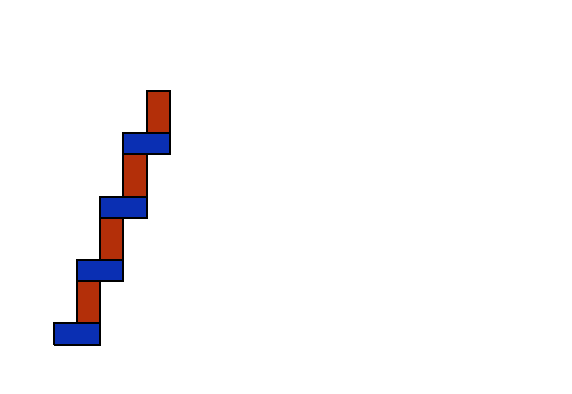

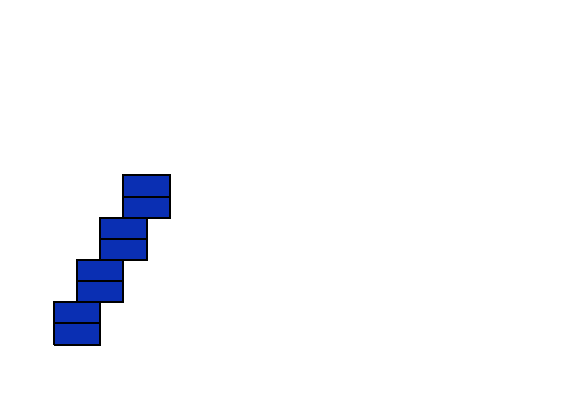

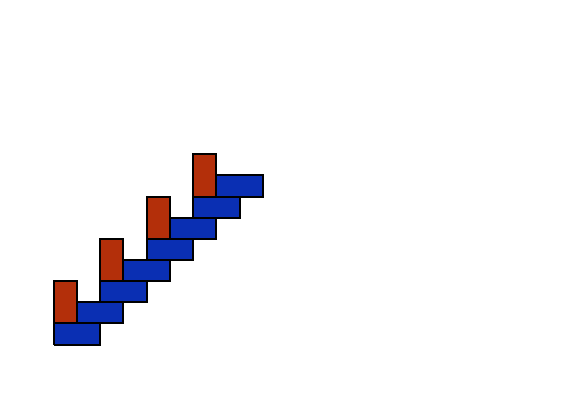

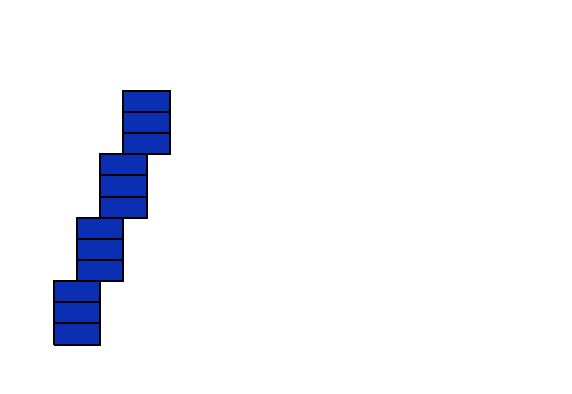

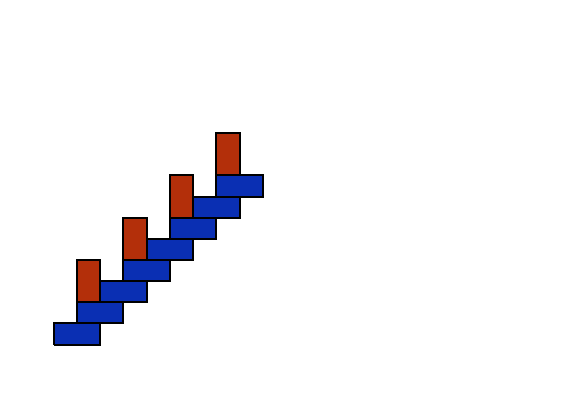

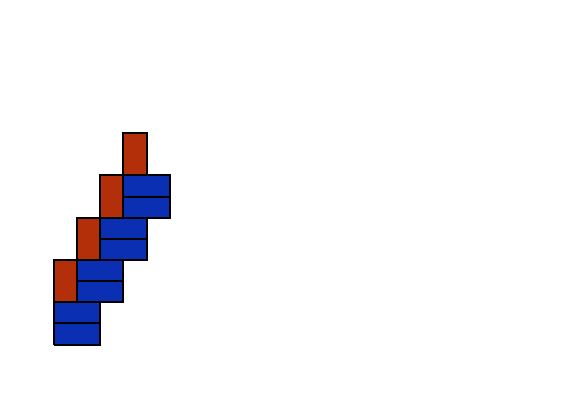

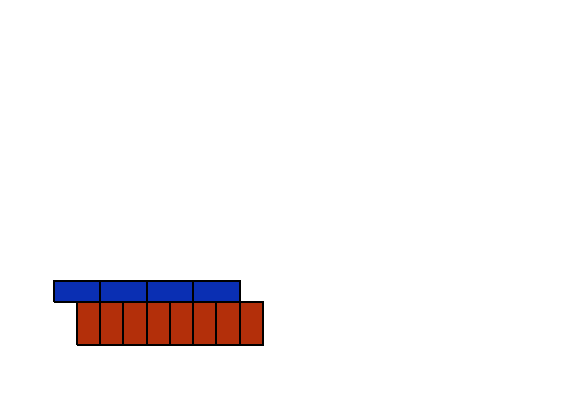

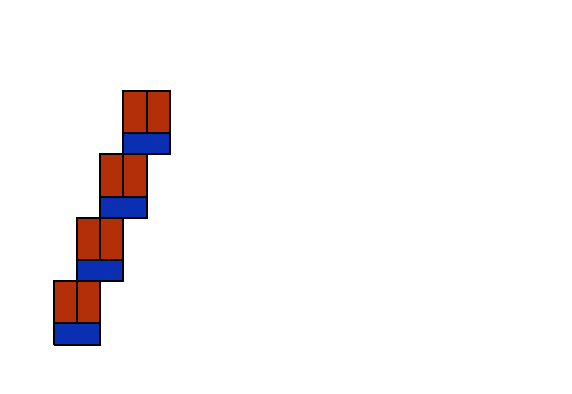

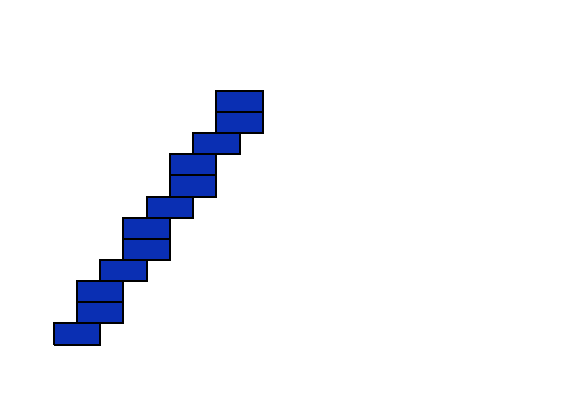

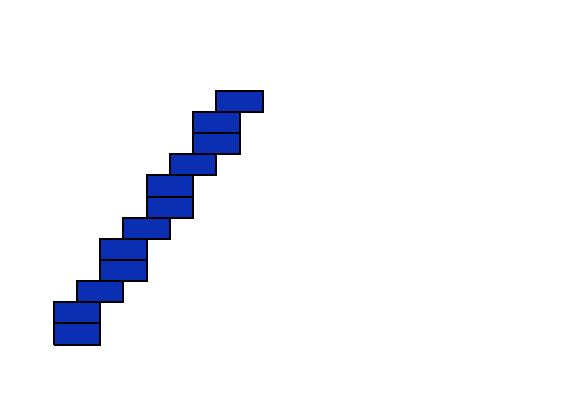

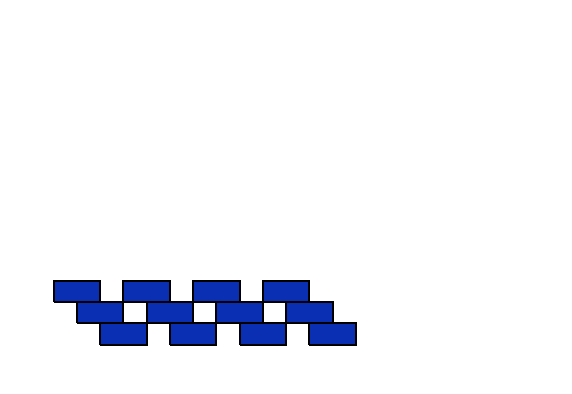

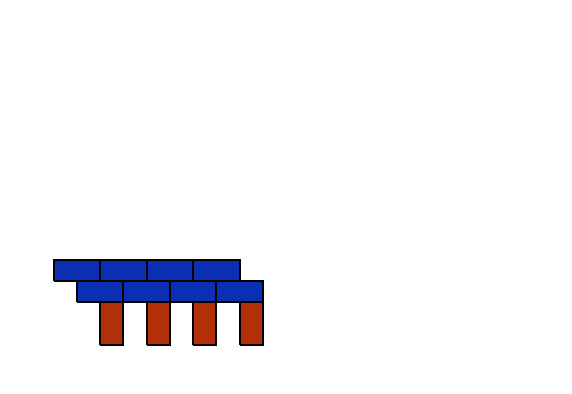

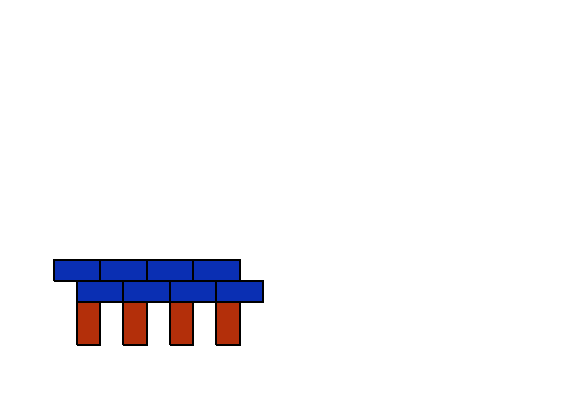

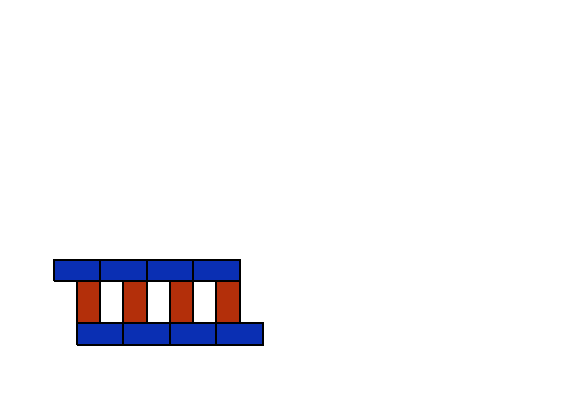

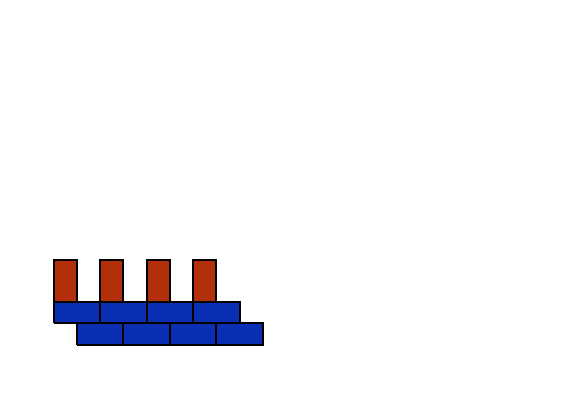

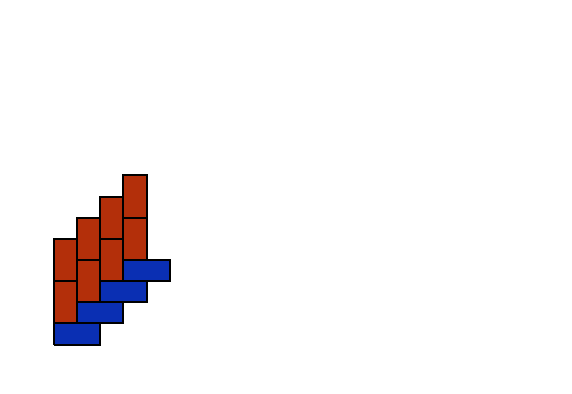

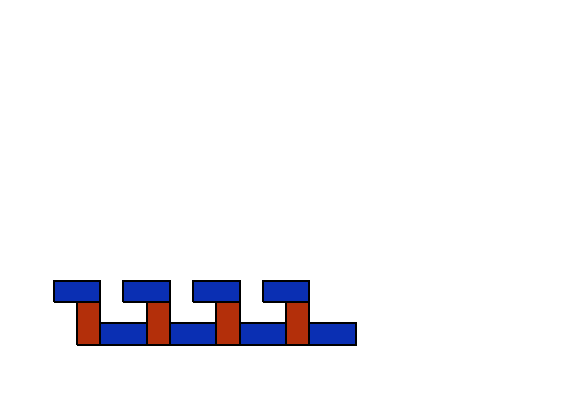

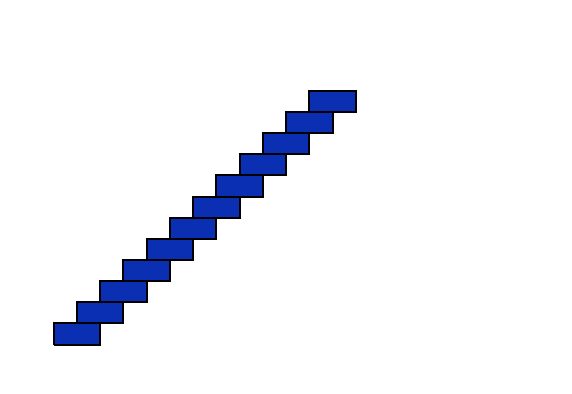

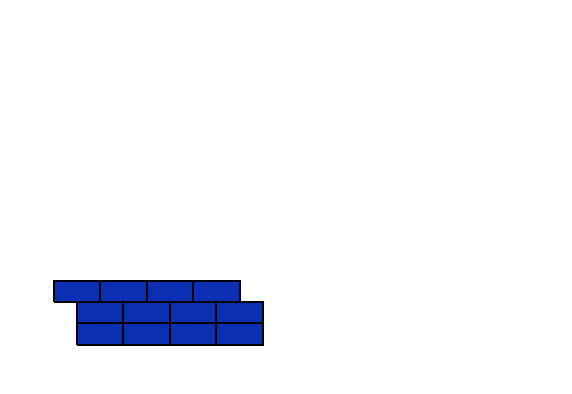

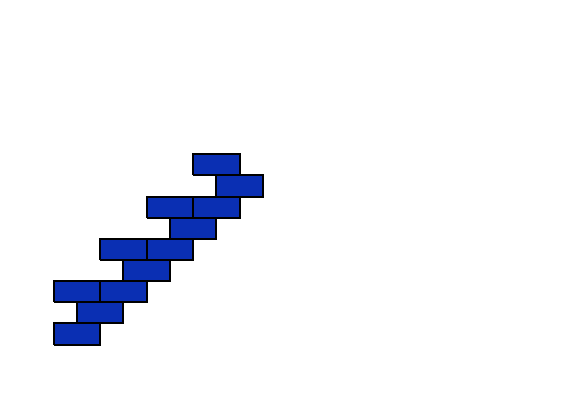

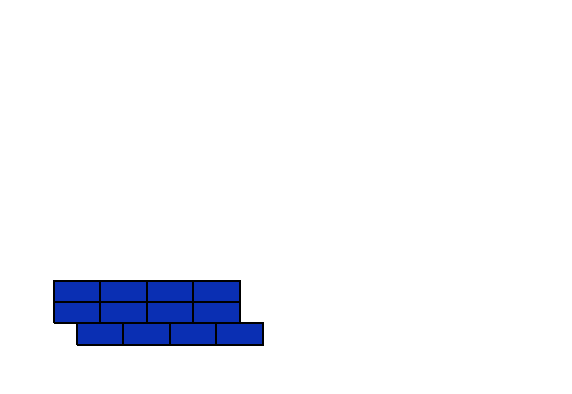

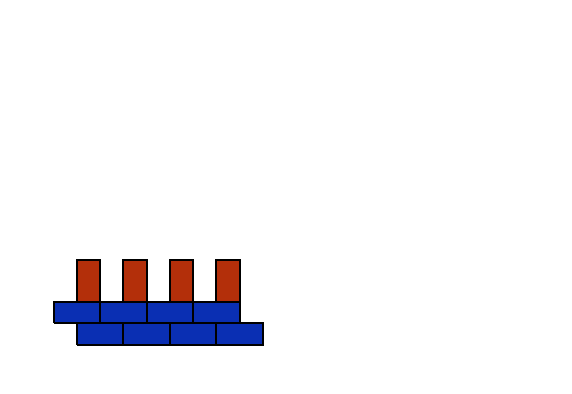

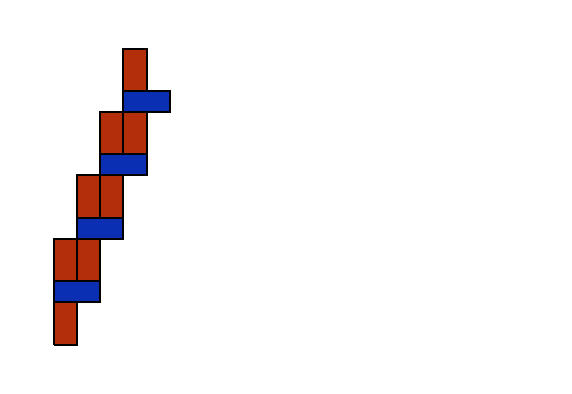

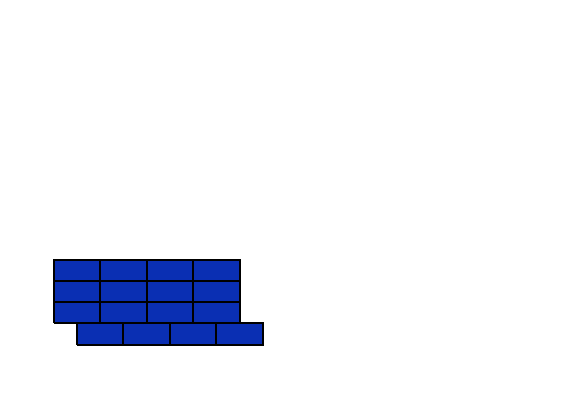

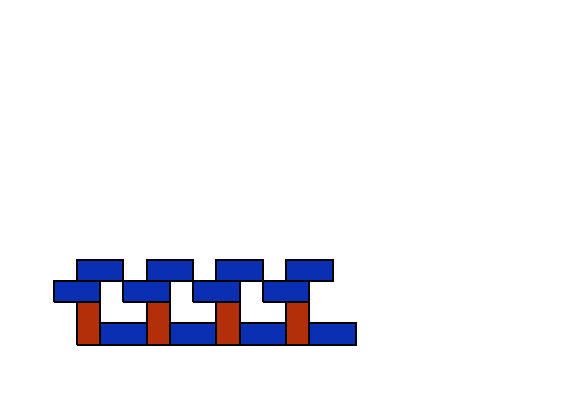

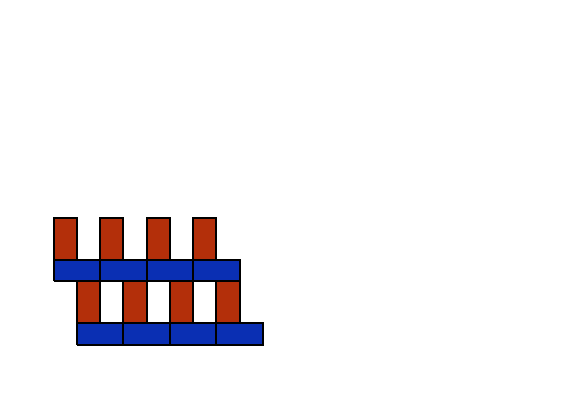

In [502]:
# diag right

for chunk in chunks:

    w = new_world()
    diag(w, chunk, n = 4, direction='right')
    if not w.broken:
        utils.draw_world(w)

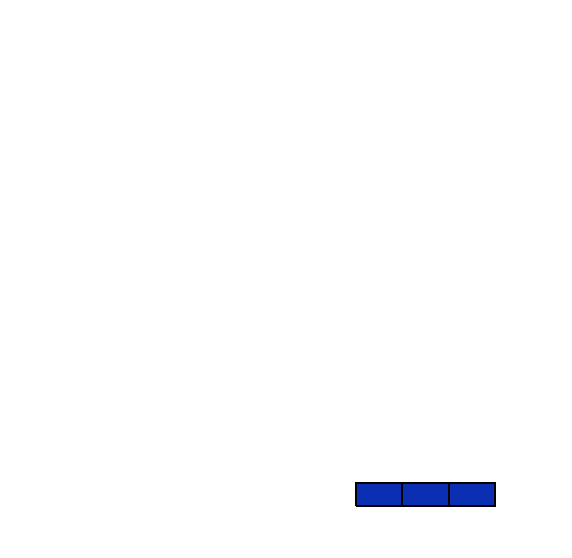

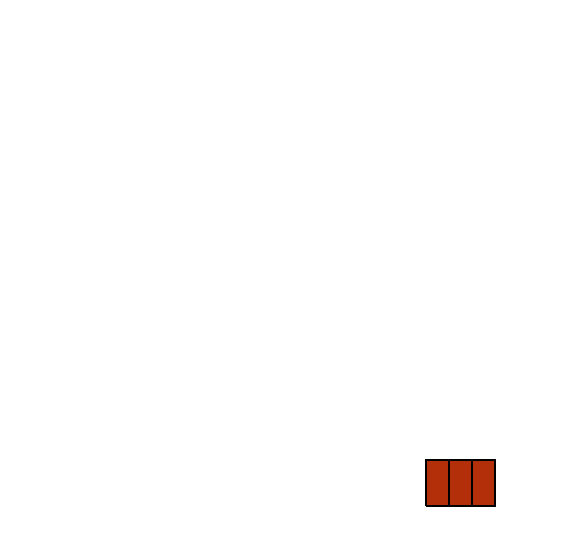

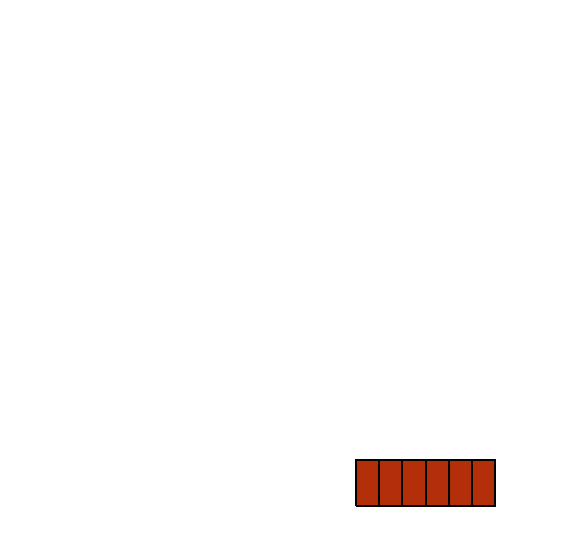

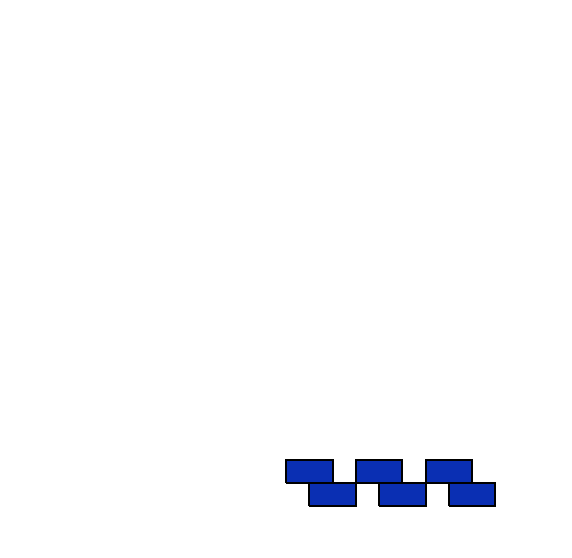

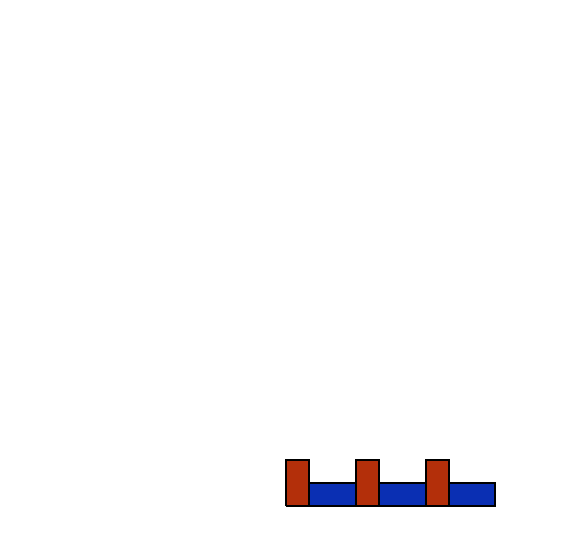

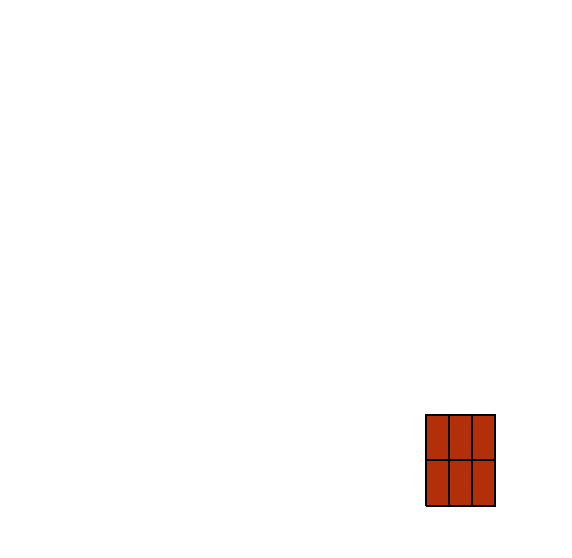

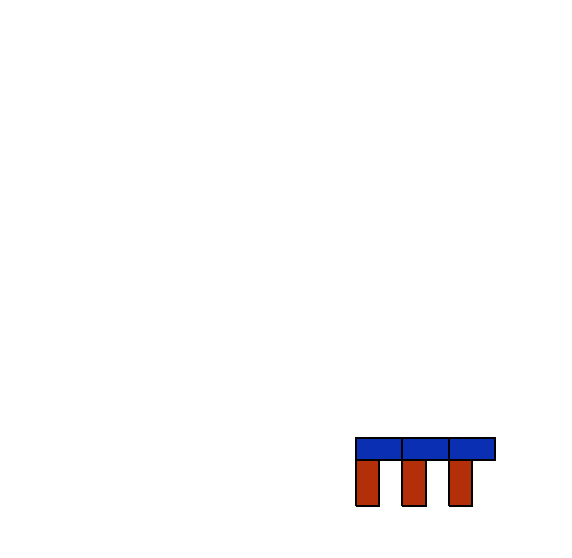

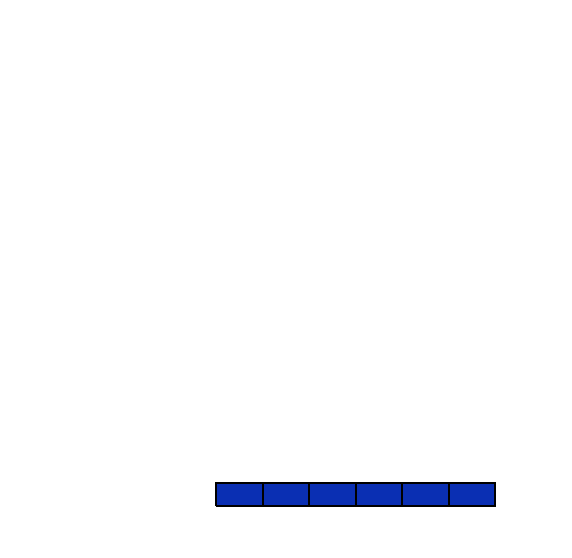

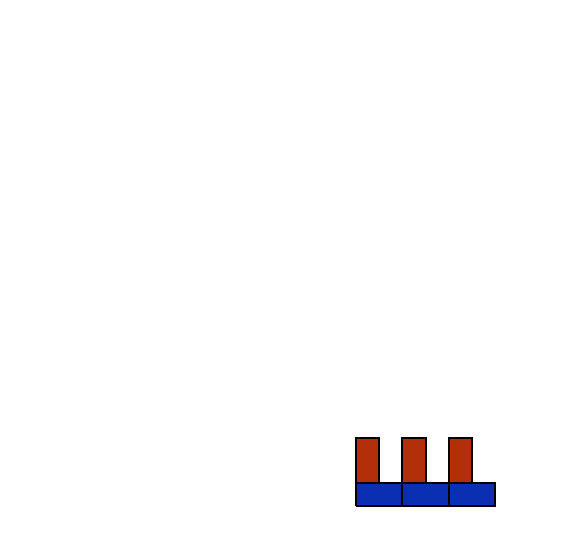

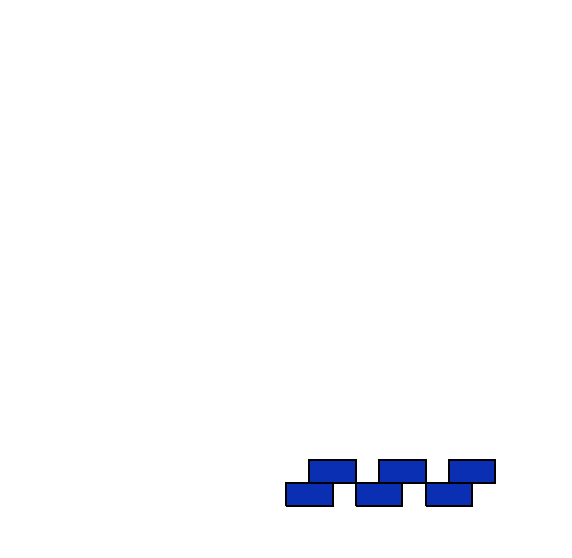

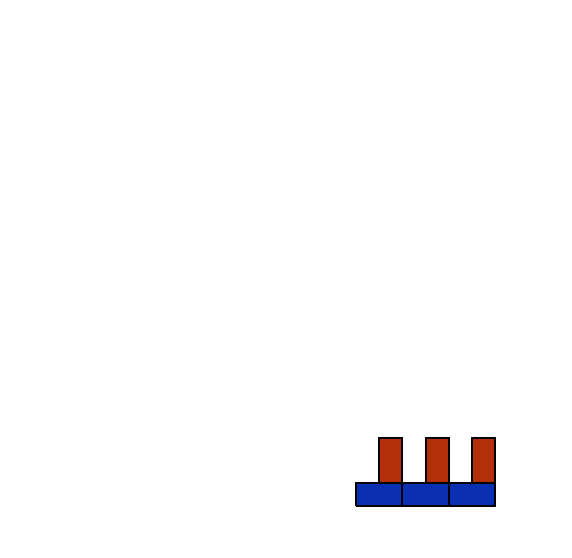

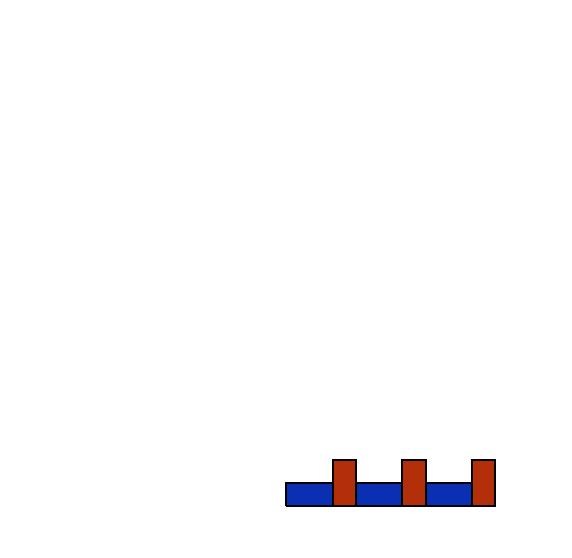

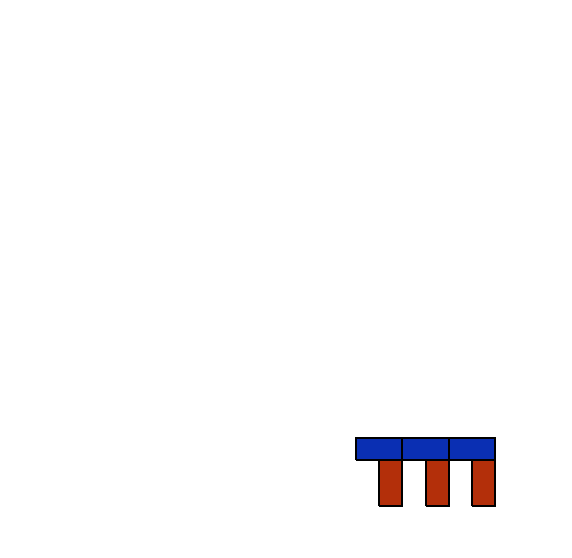

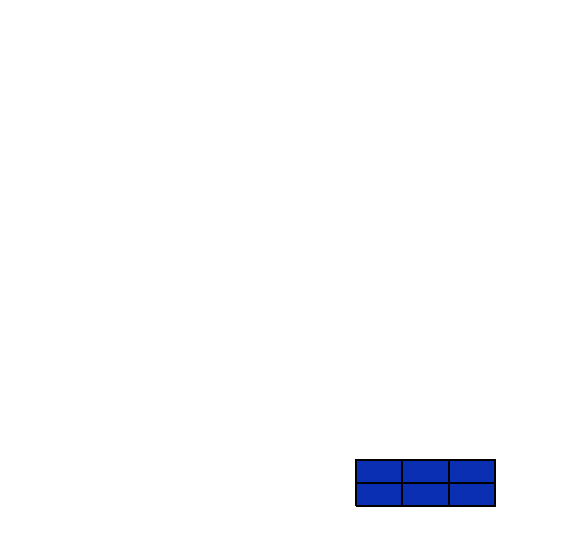

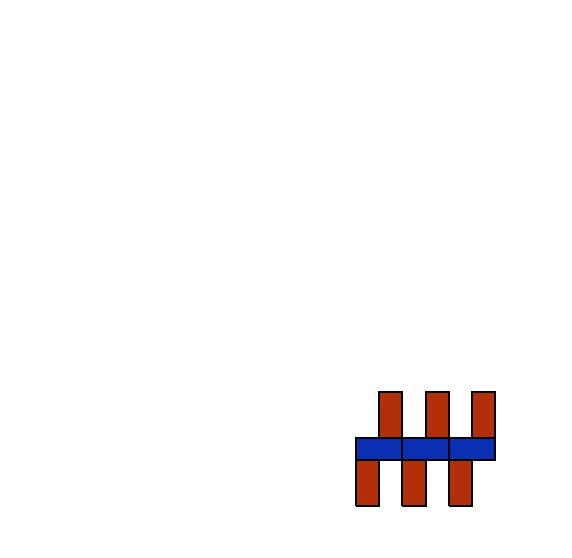

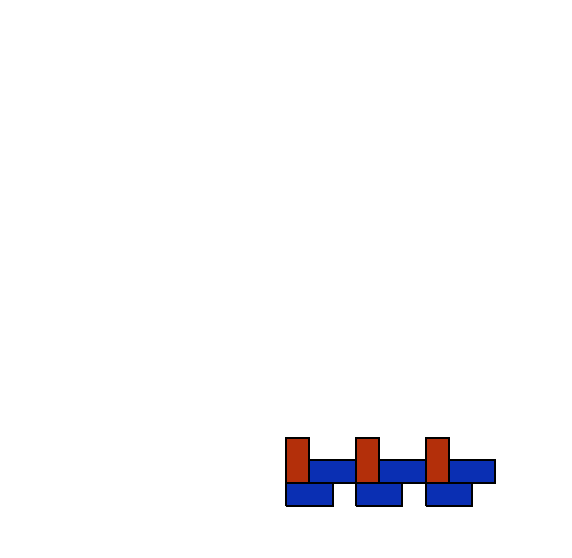

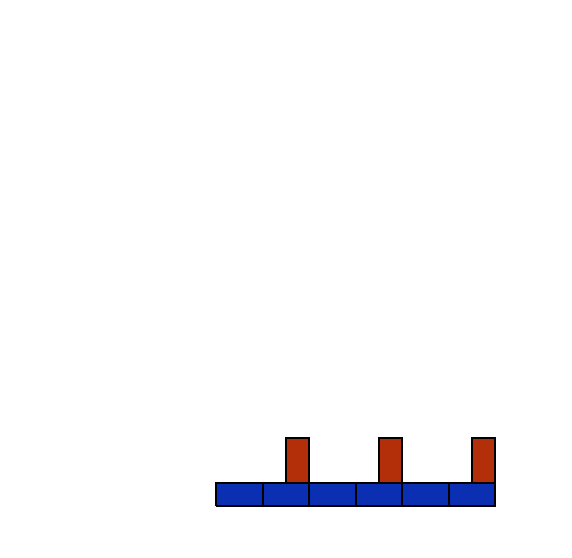

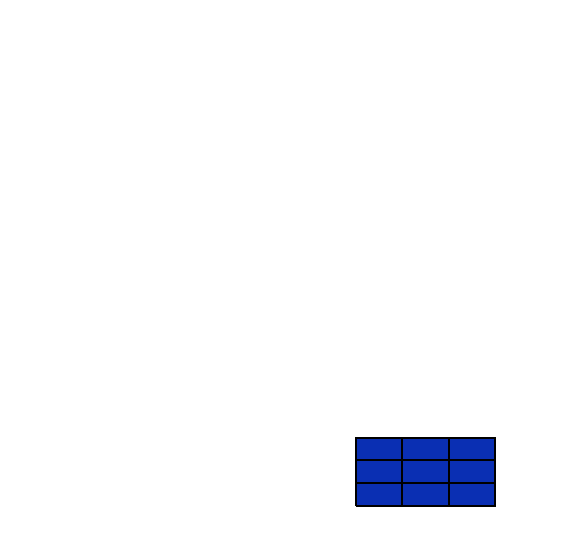

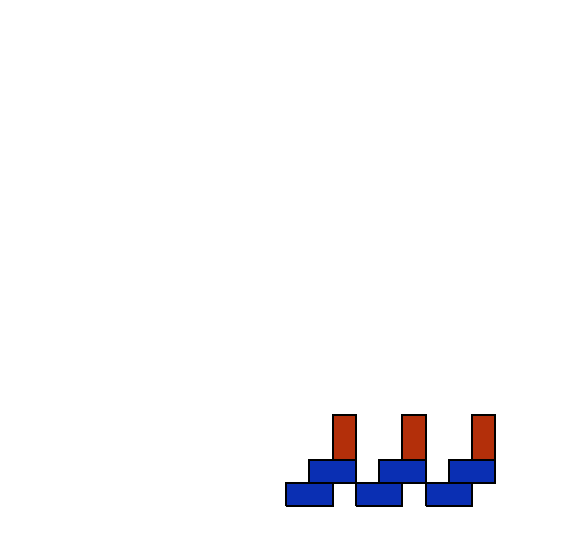

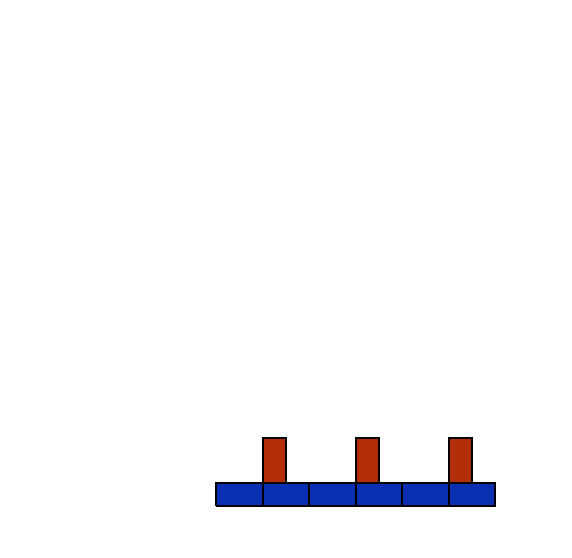

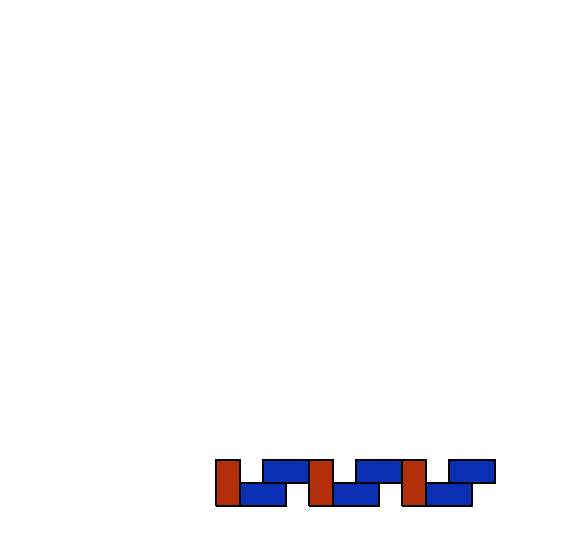

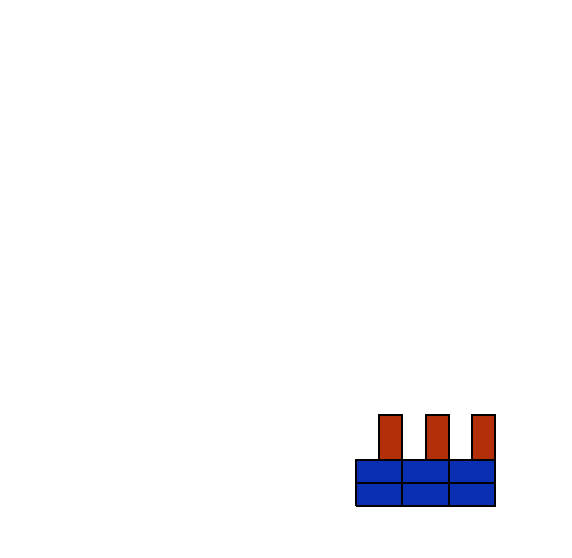

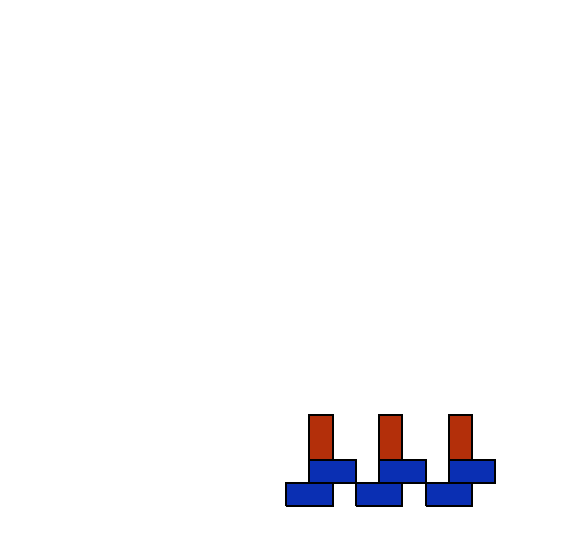

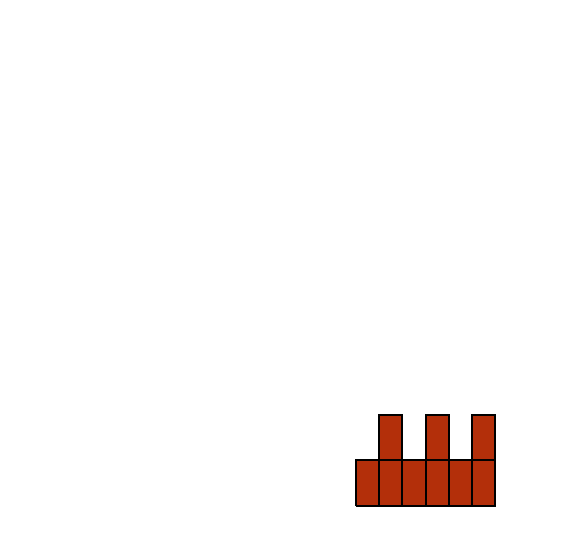

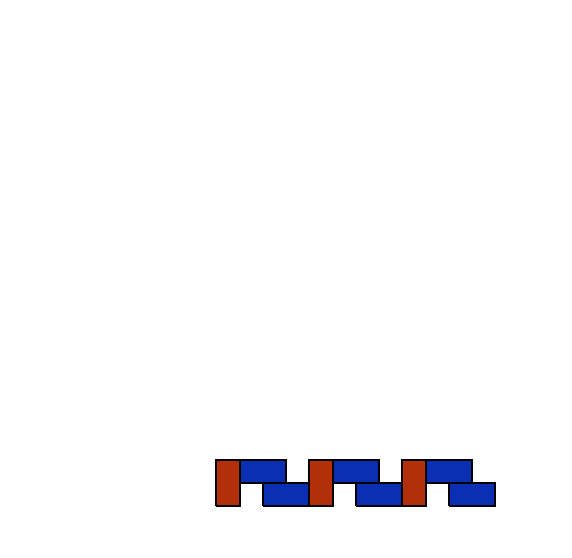

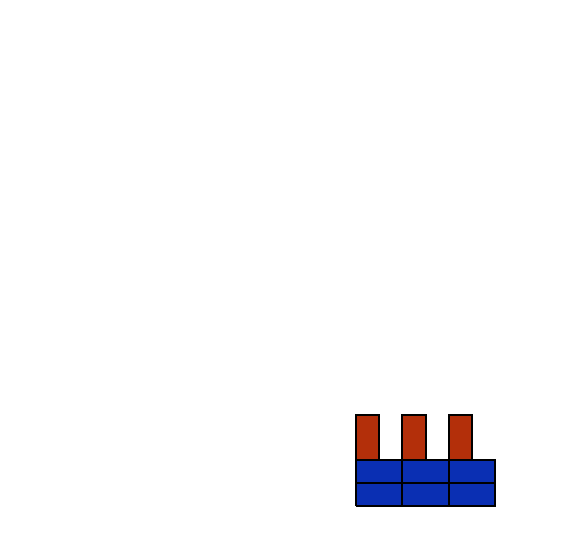

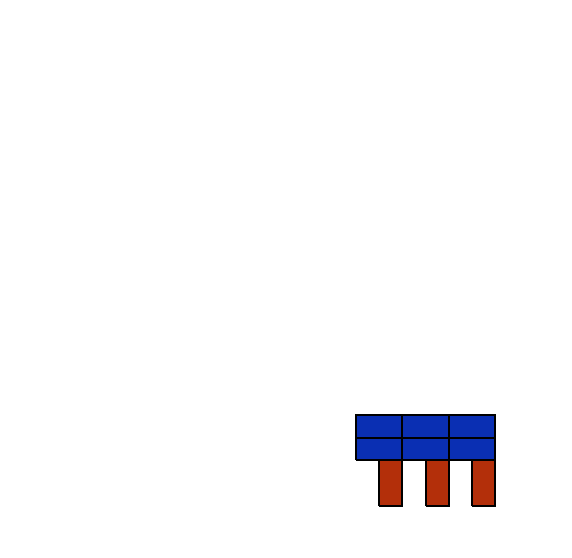

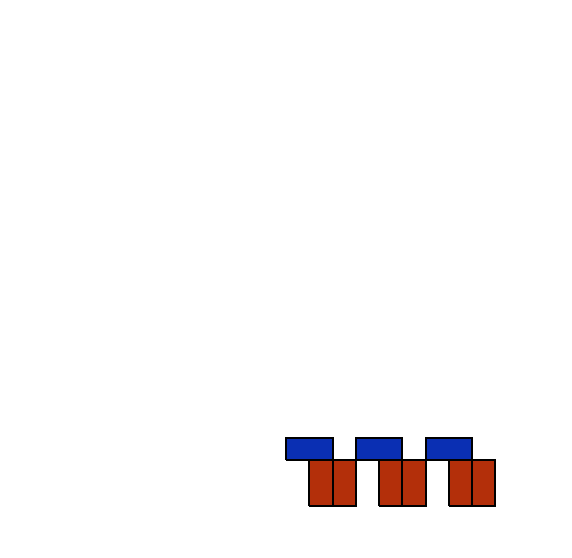

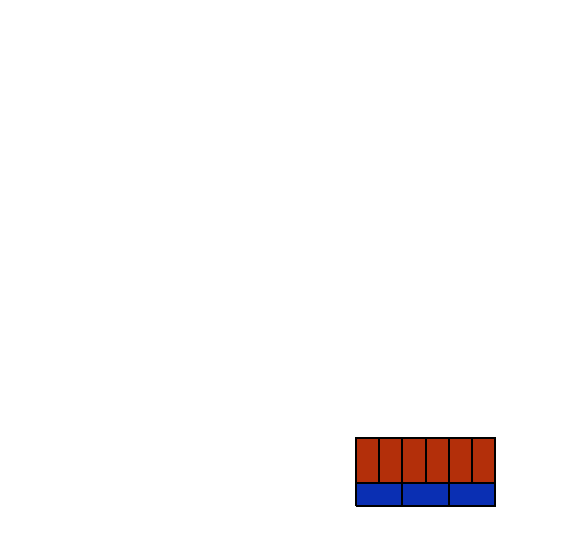

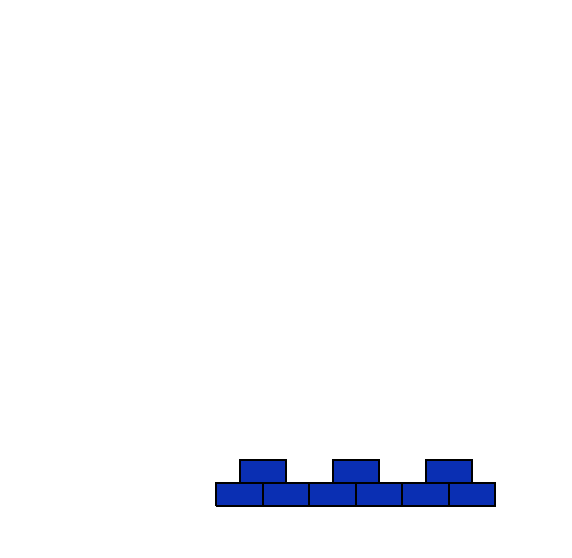

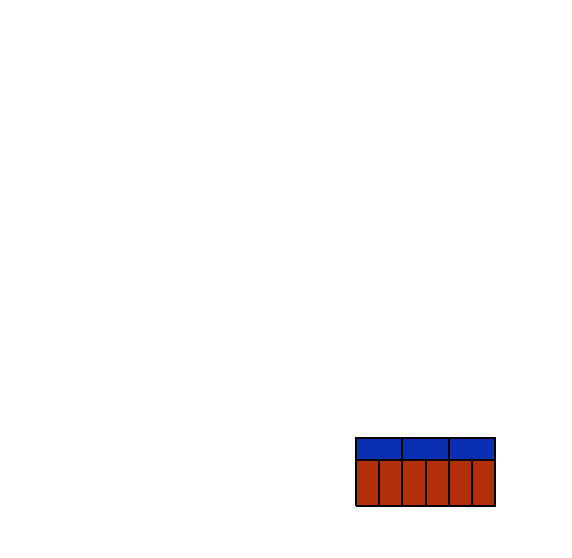

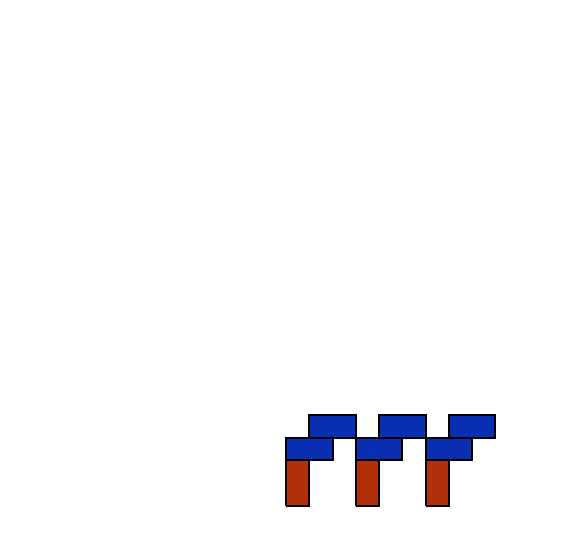

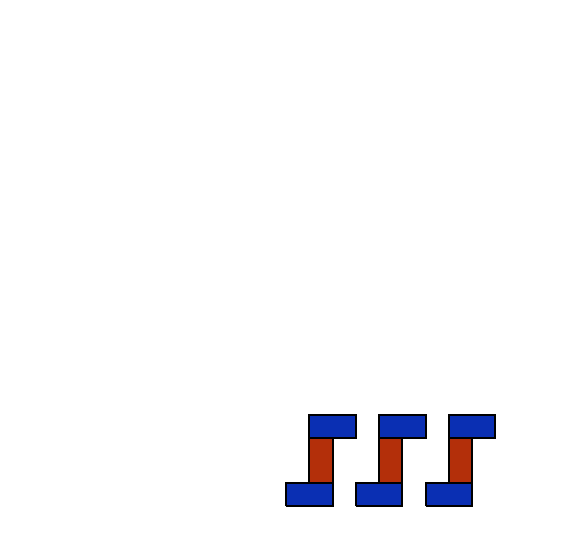

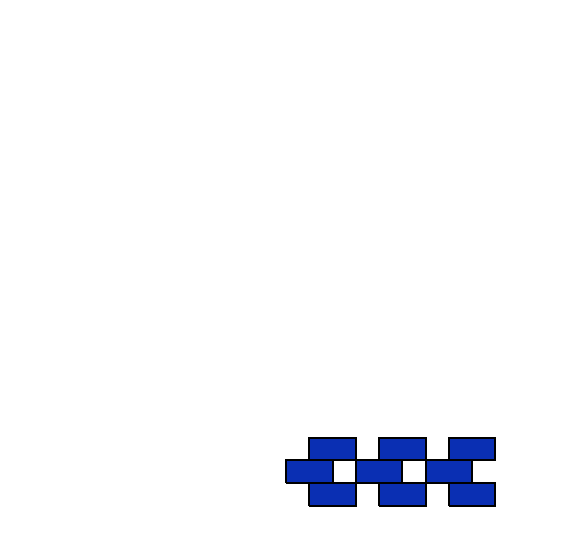

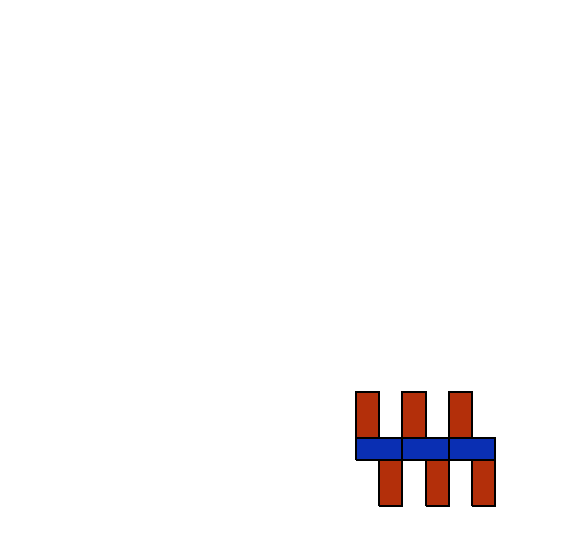

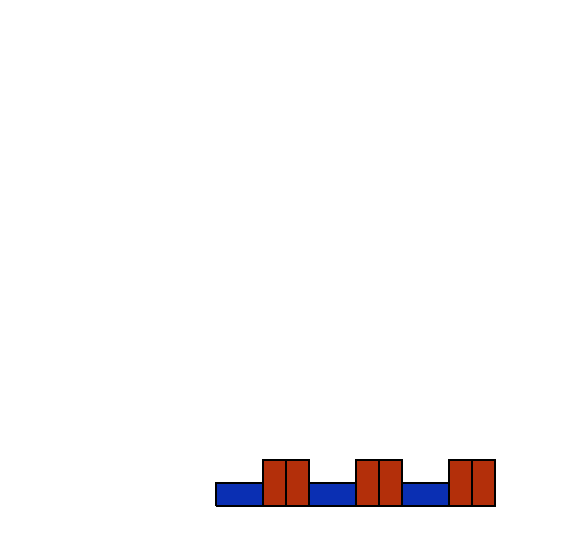

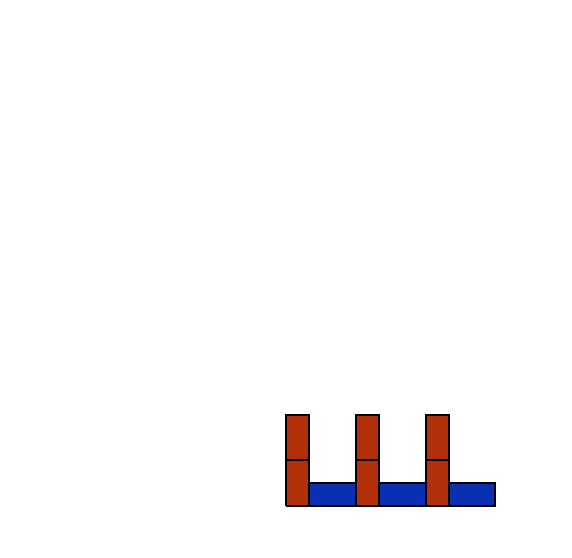

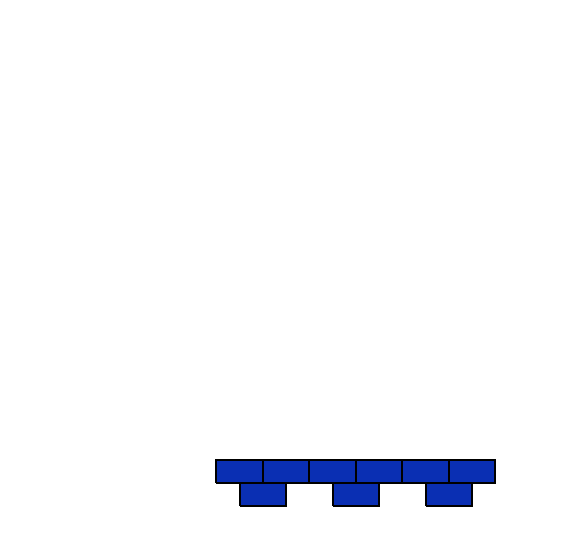

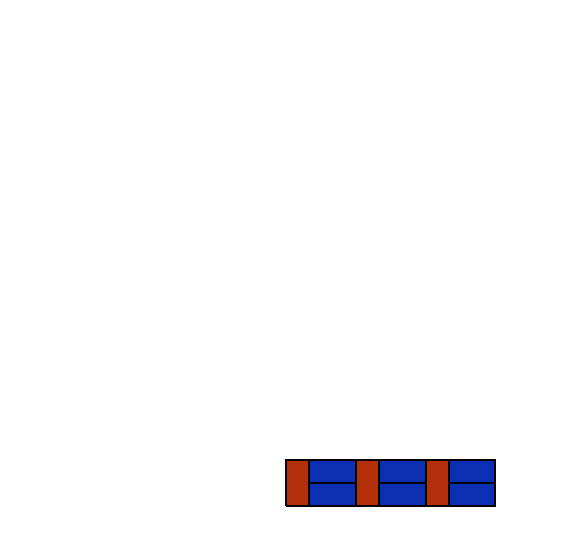

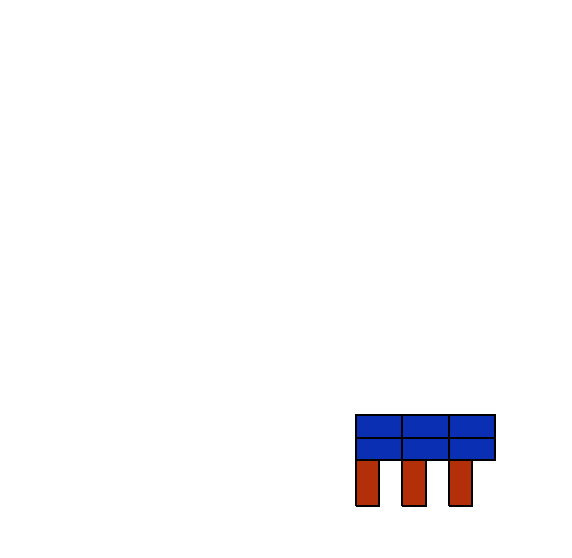

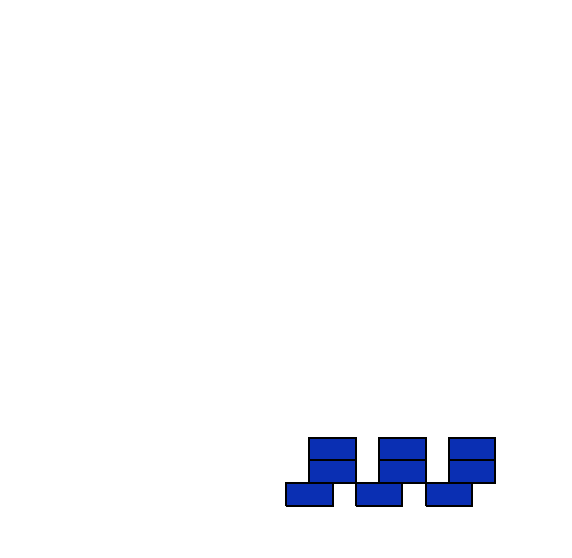

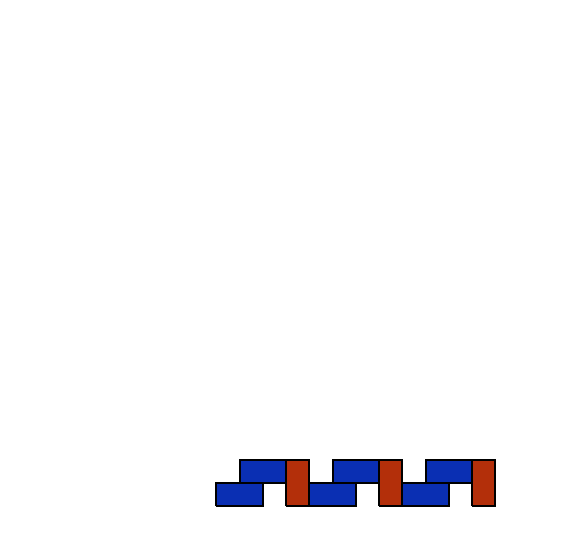

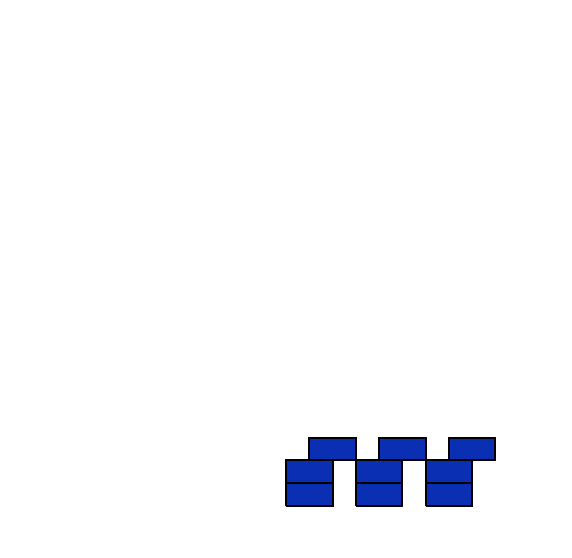

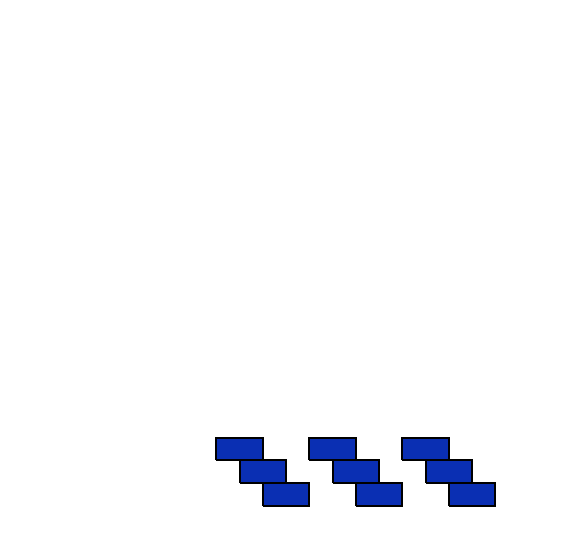

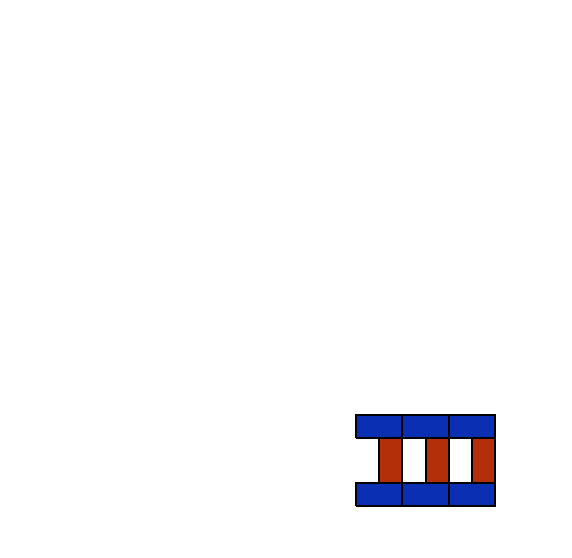

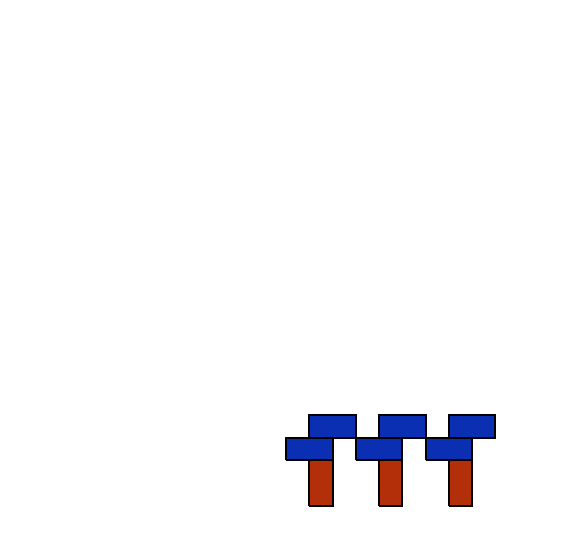

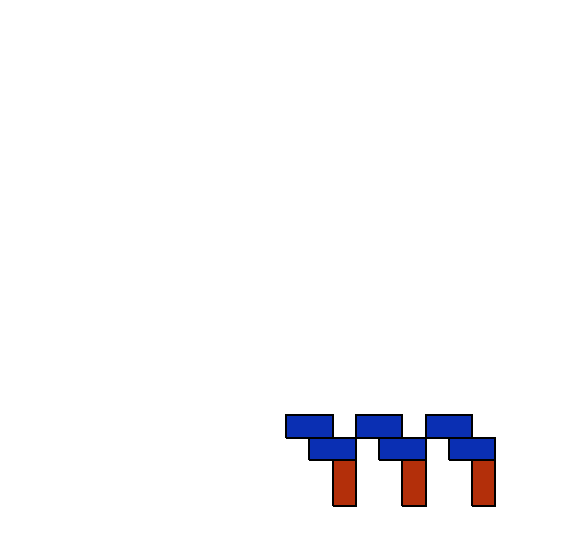

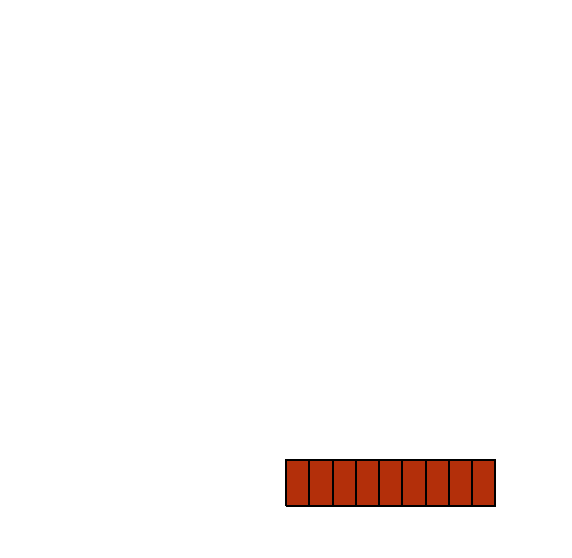

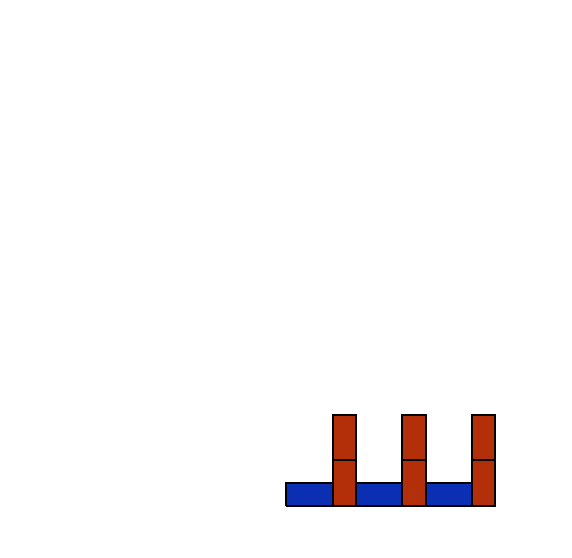

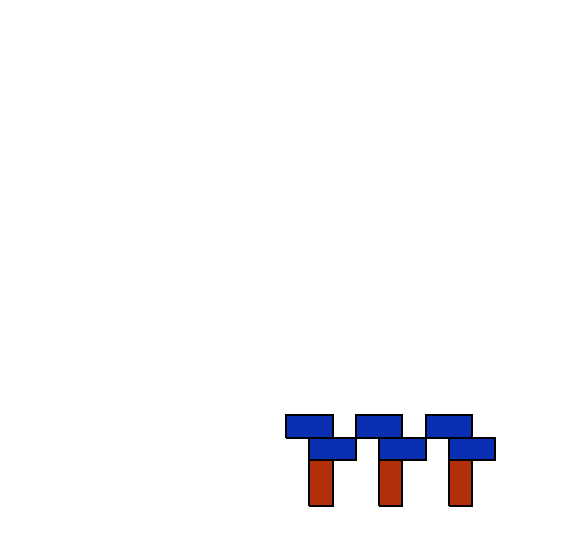

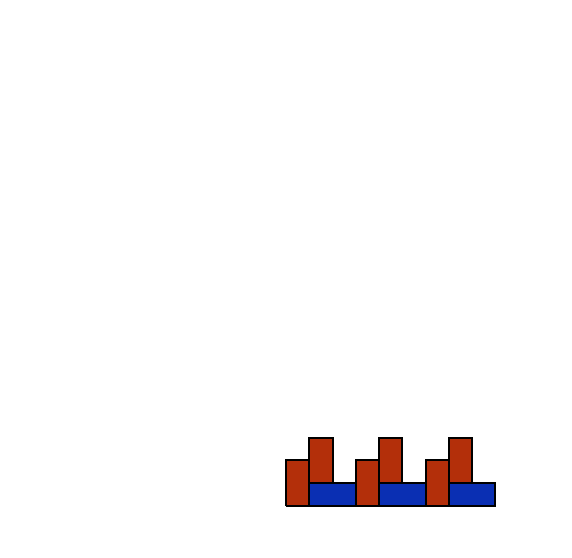

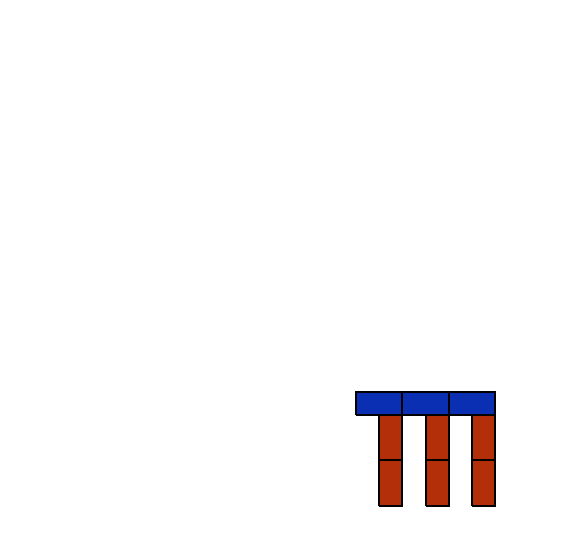

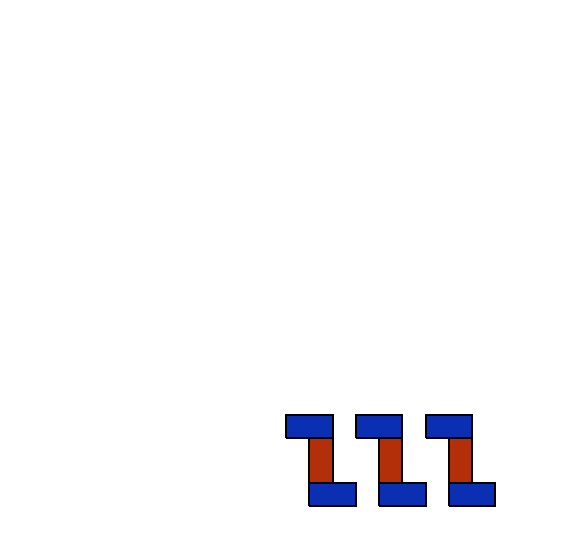

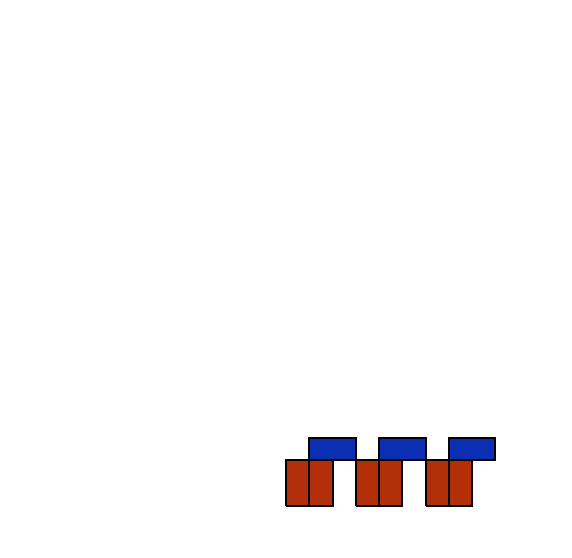

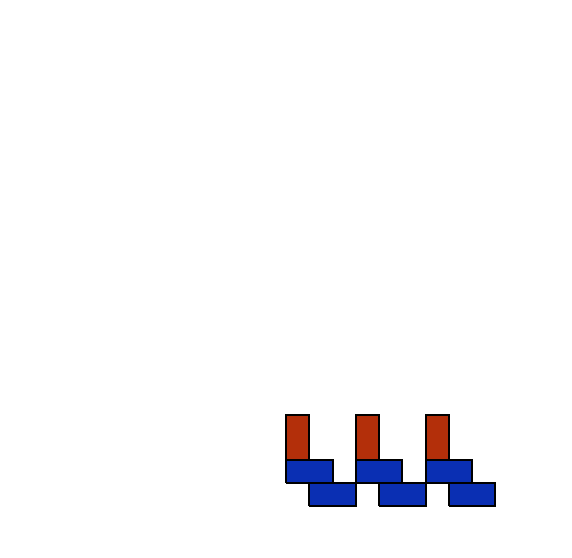

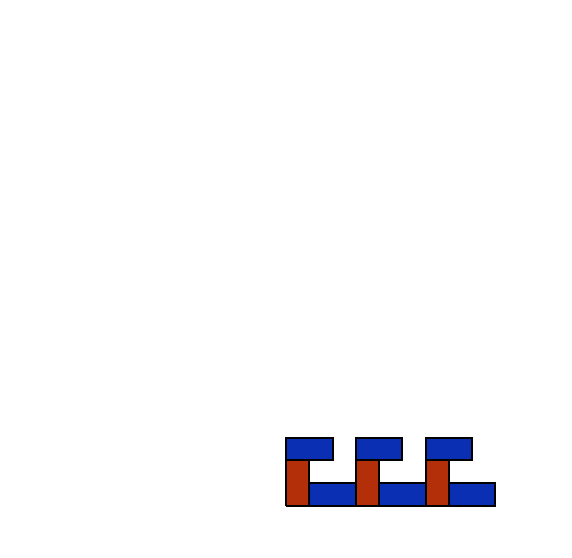

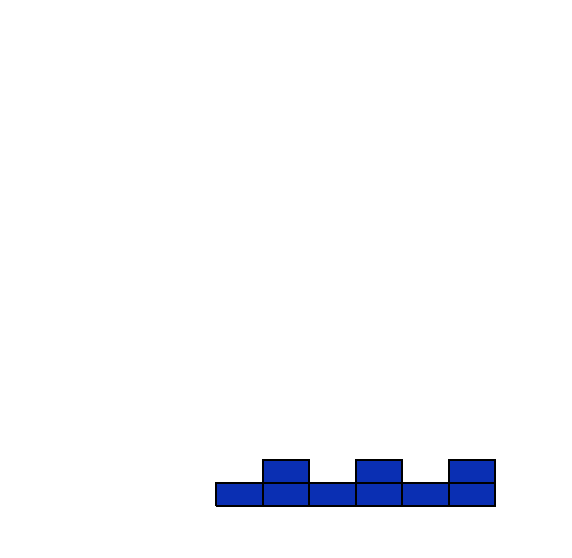

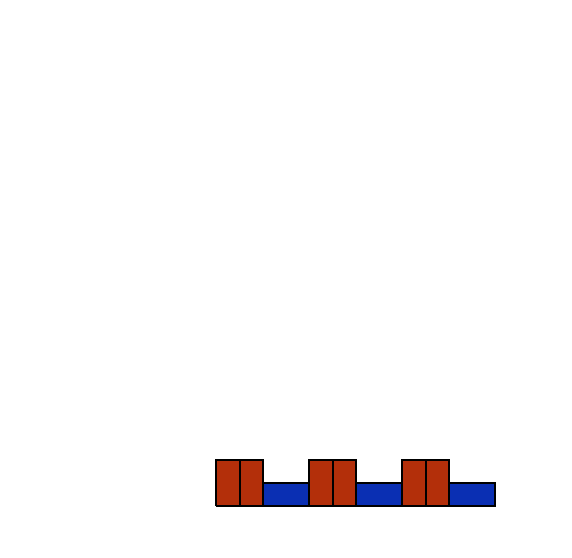

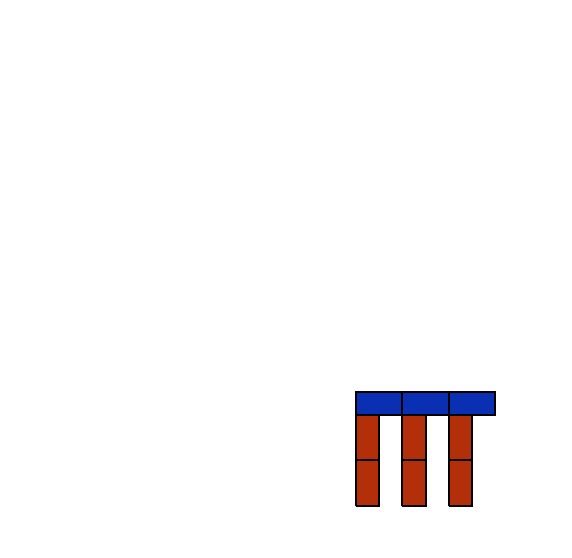

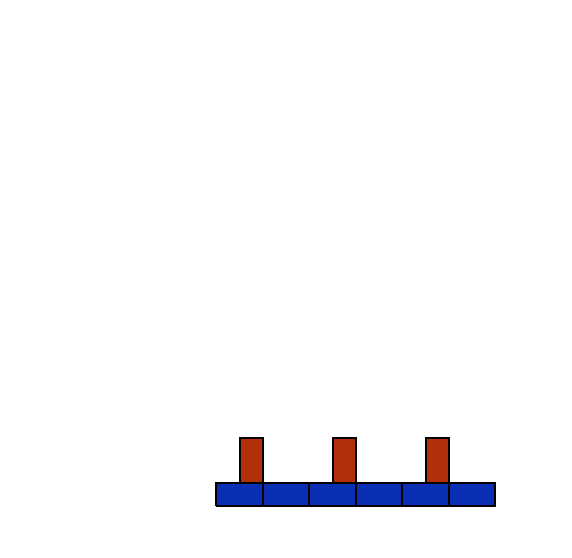

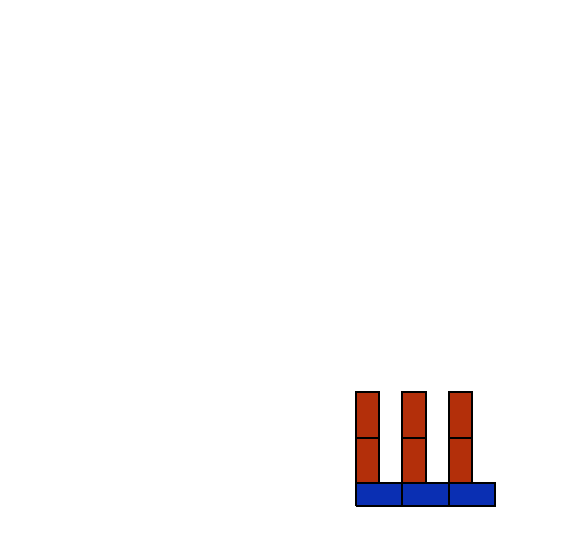

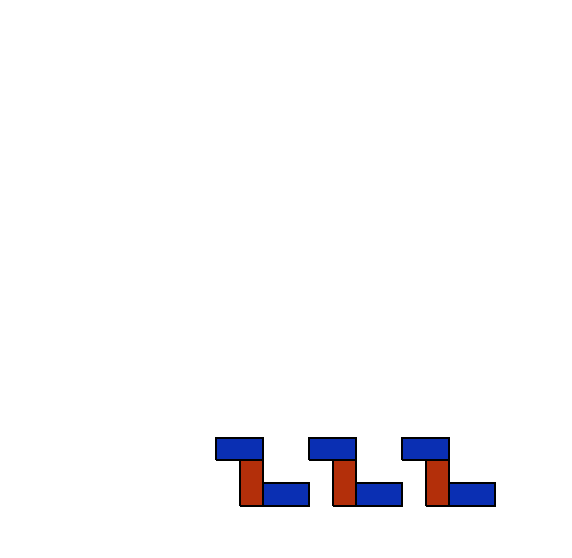

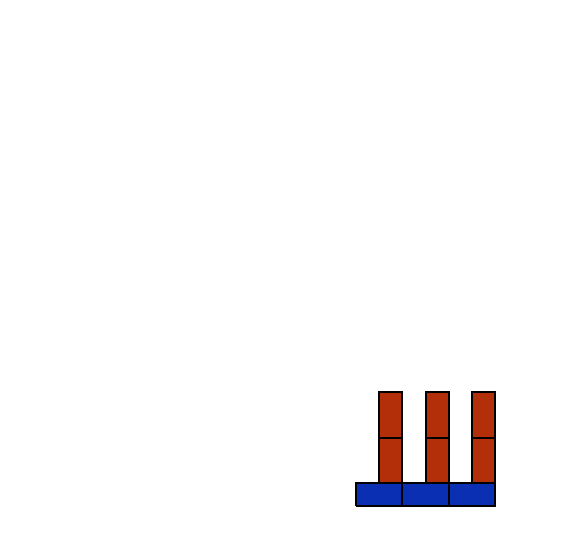

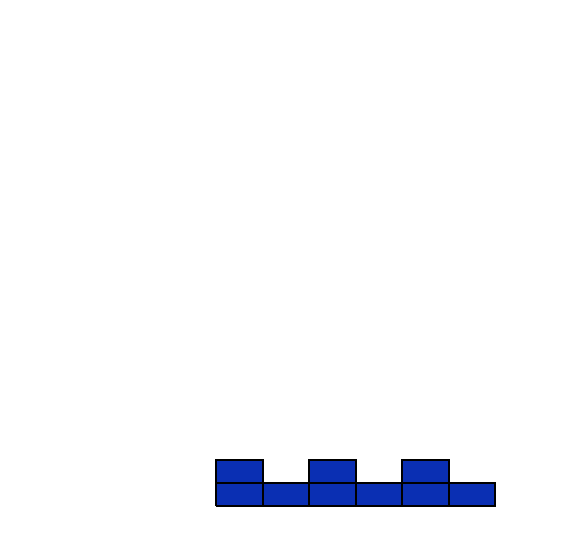

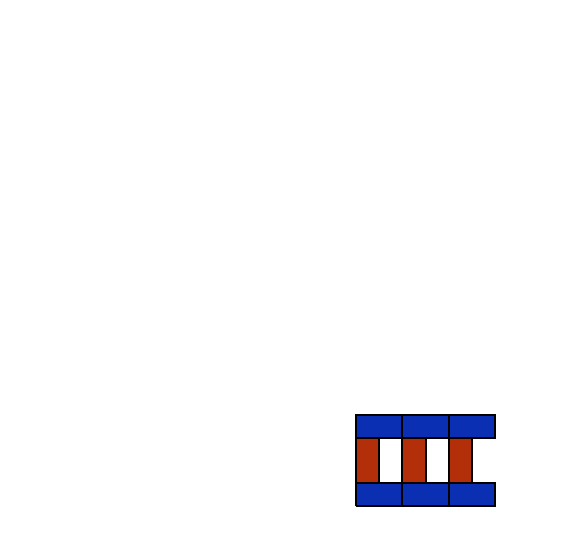

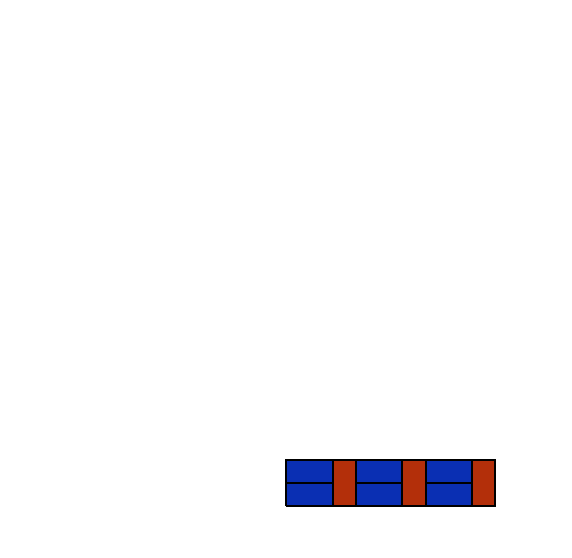

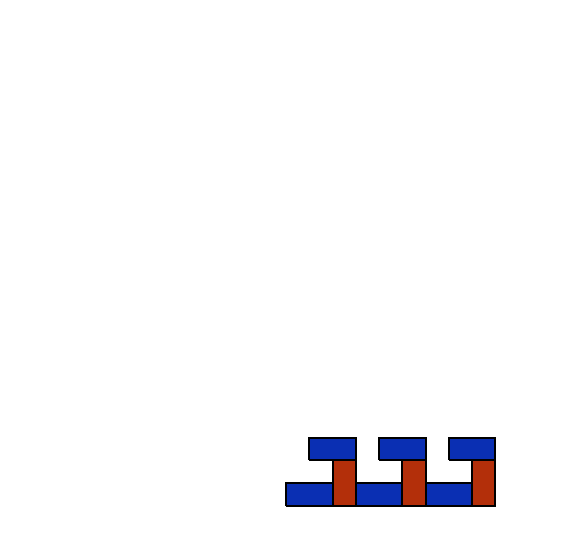

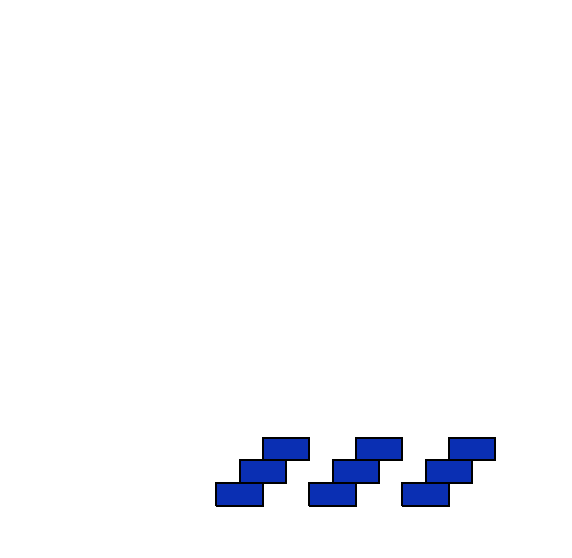

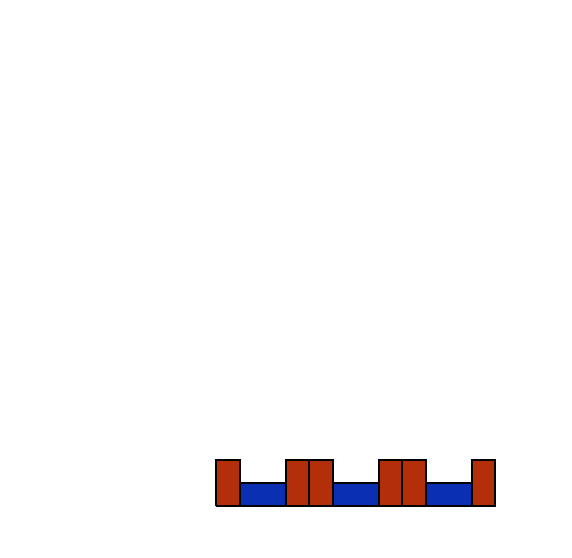

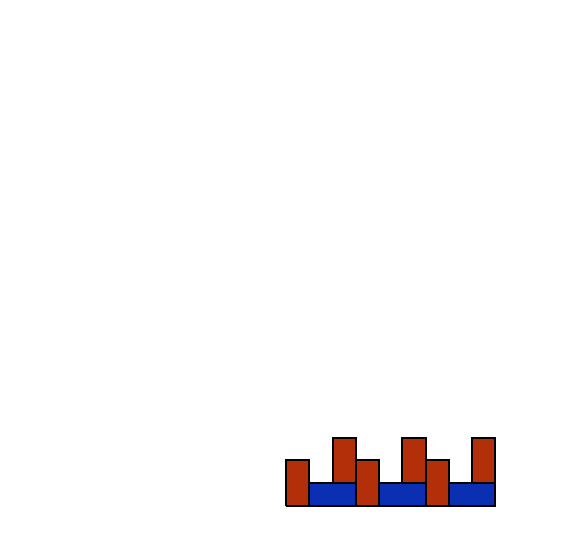

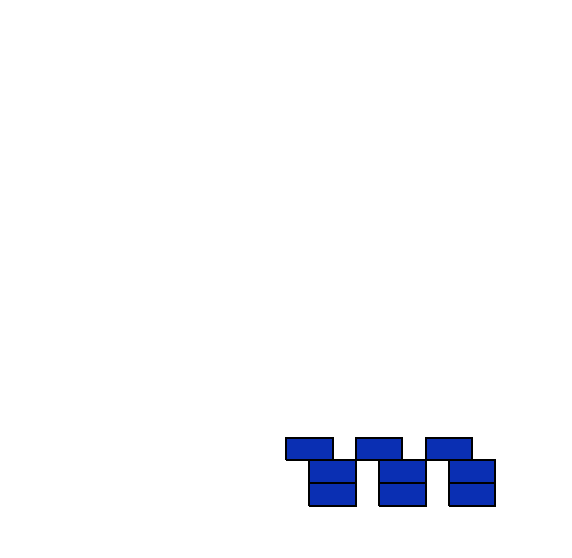

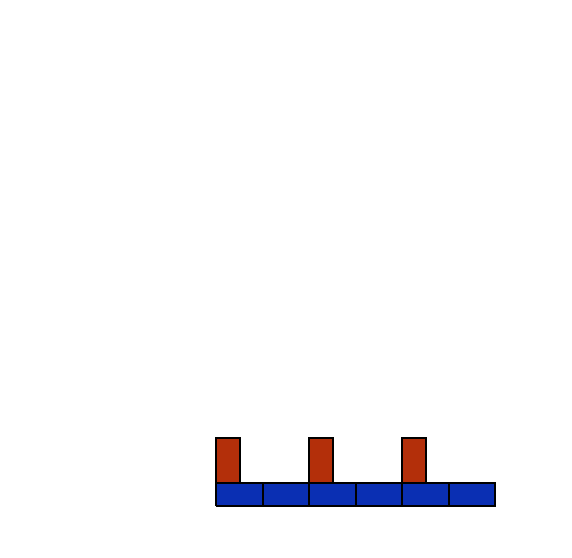

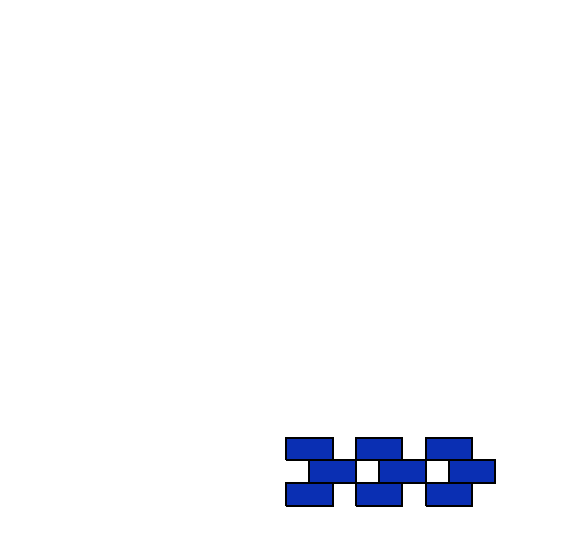

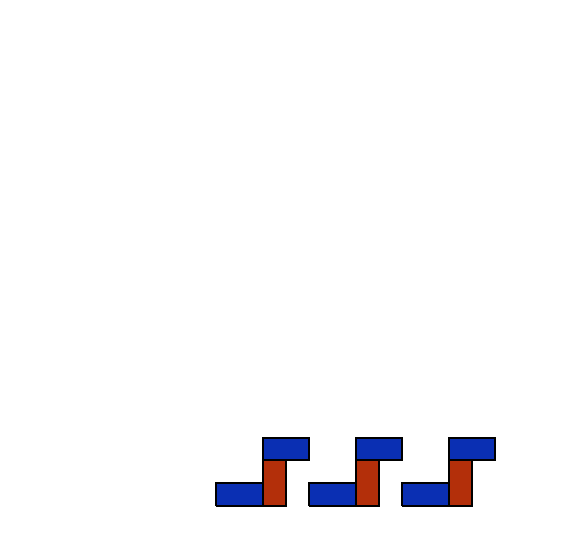

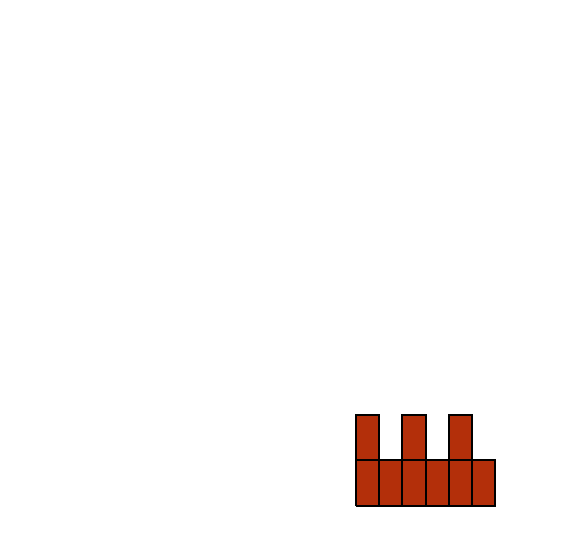

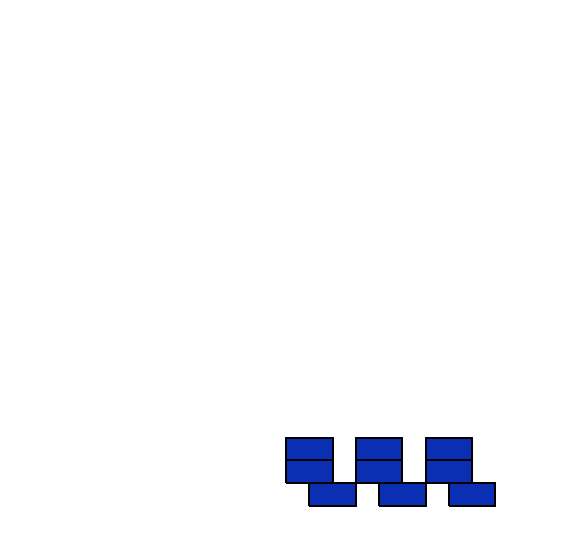

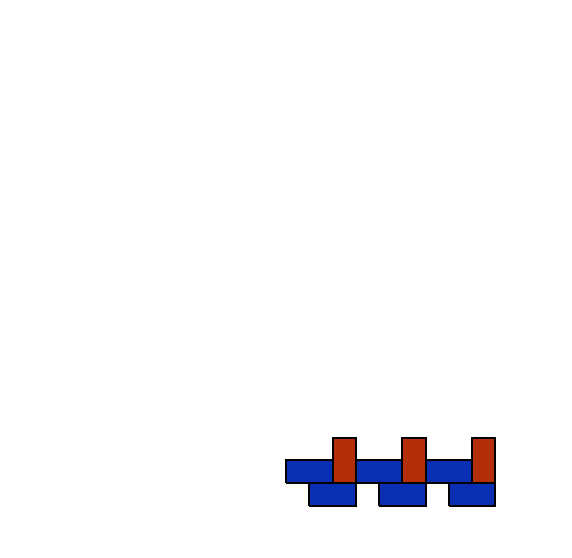

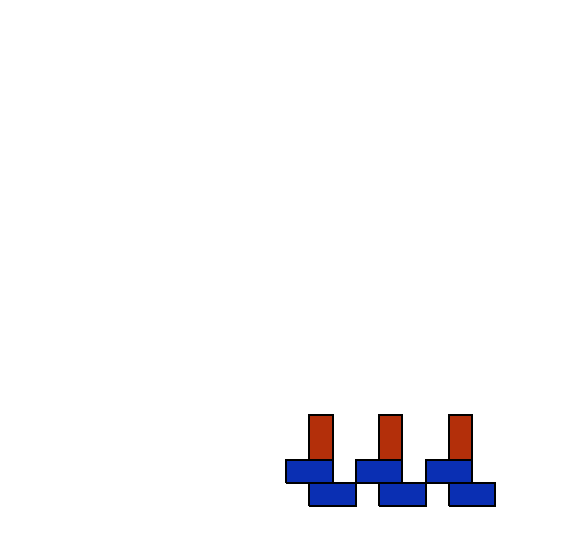

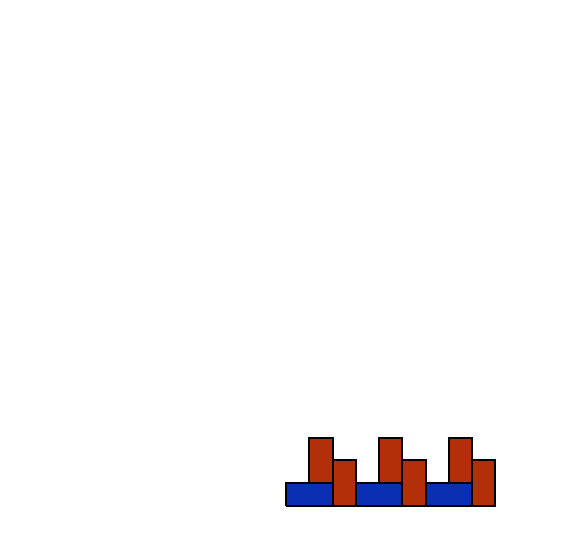

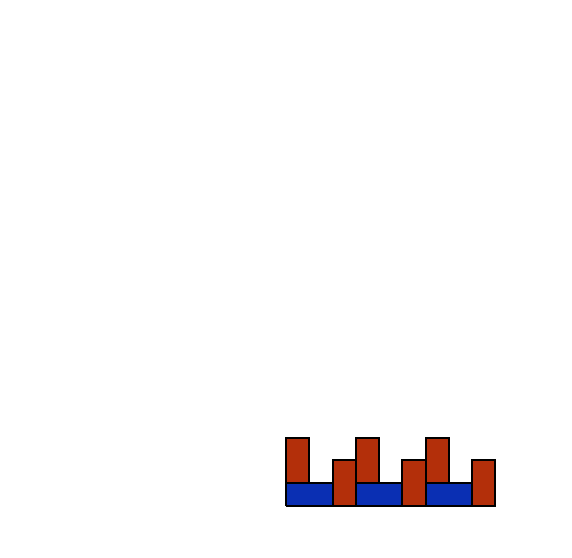

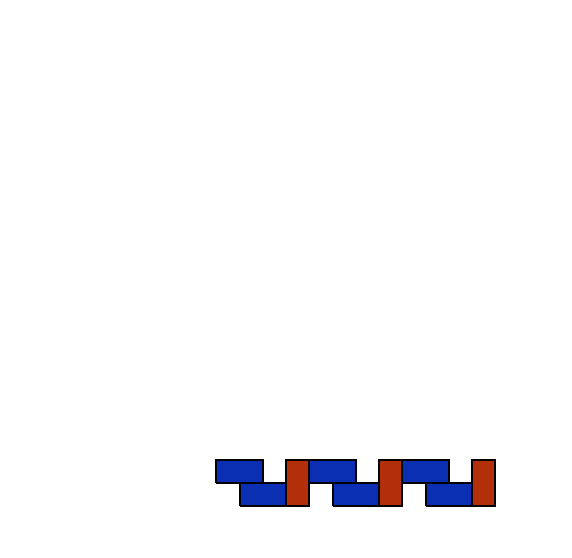

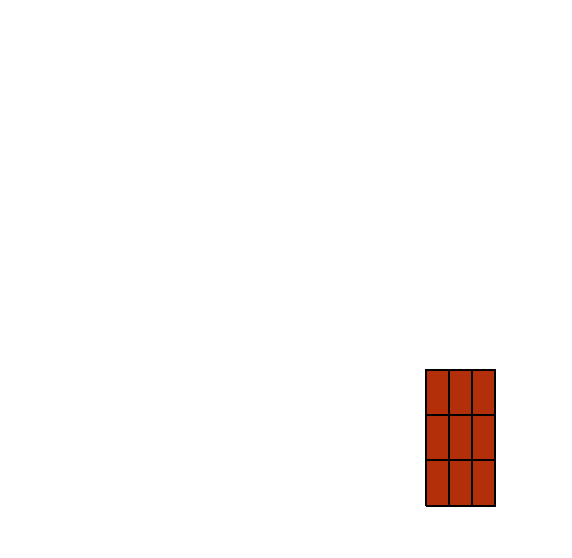

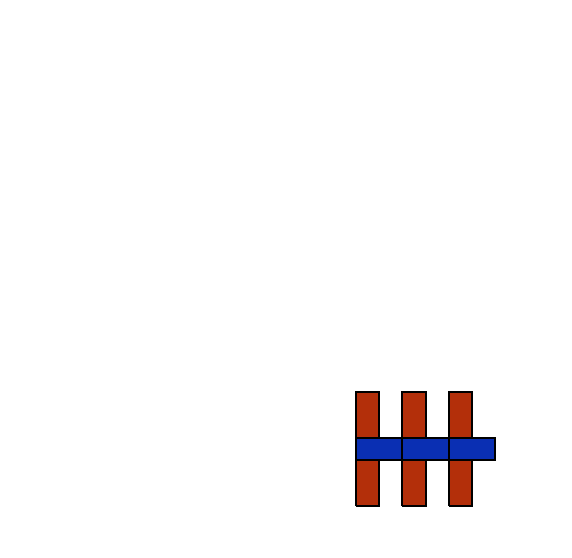

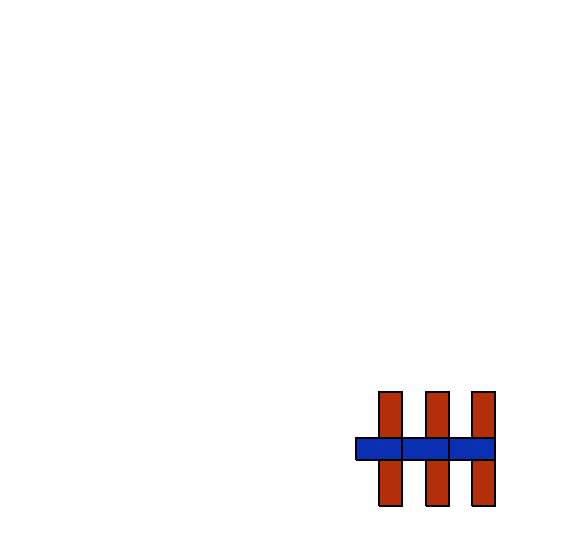

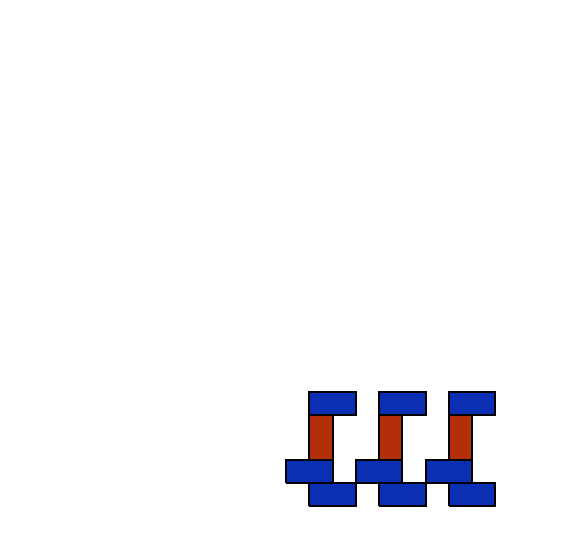

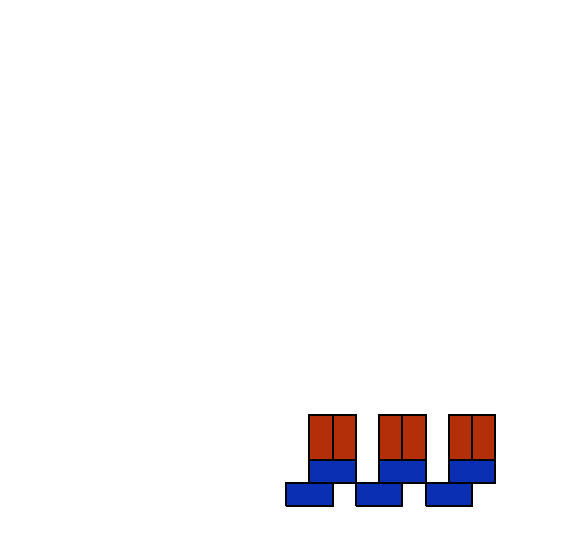

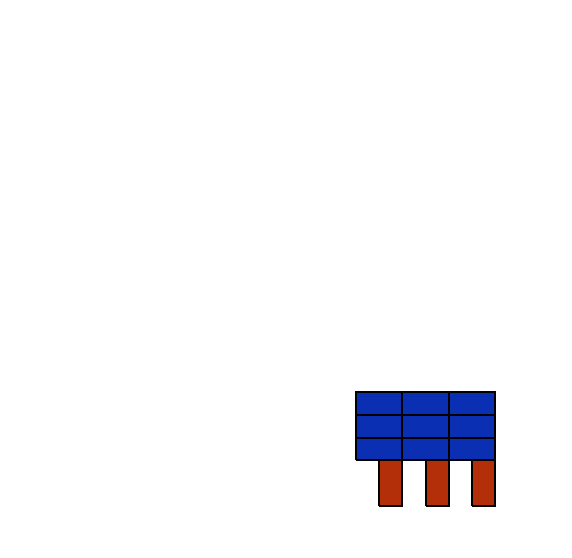

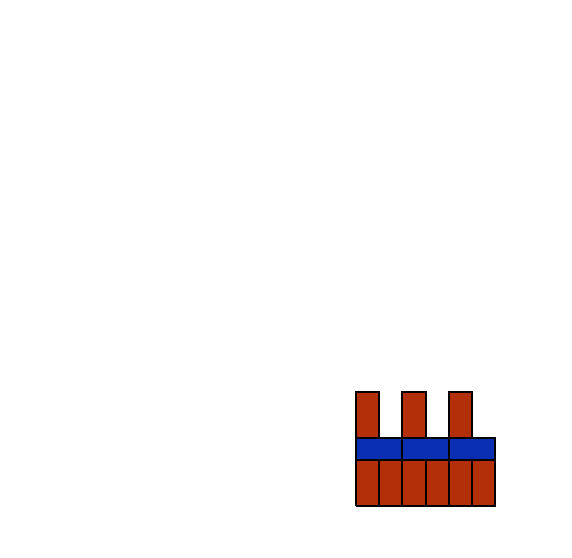

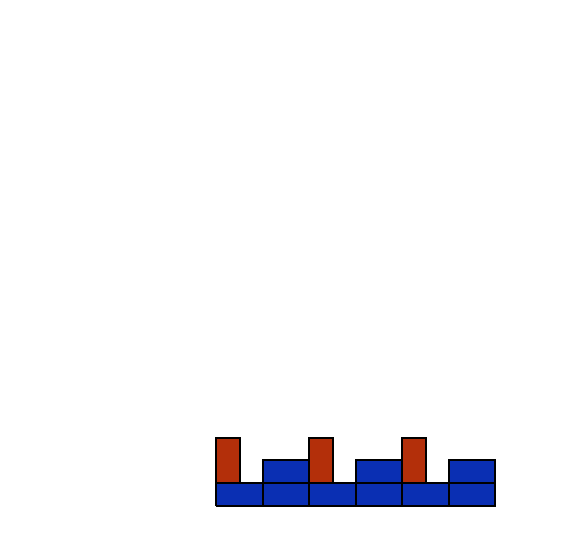

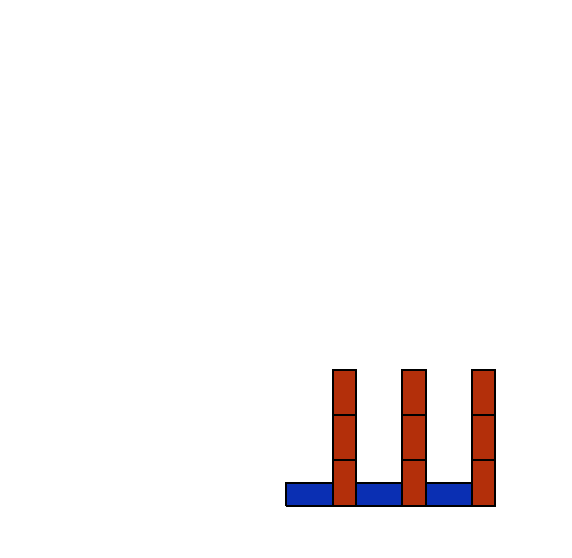

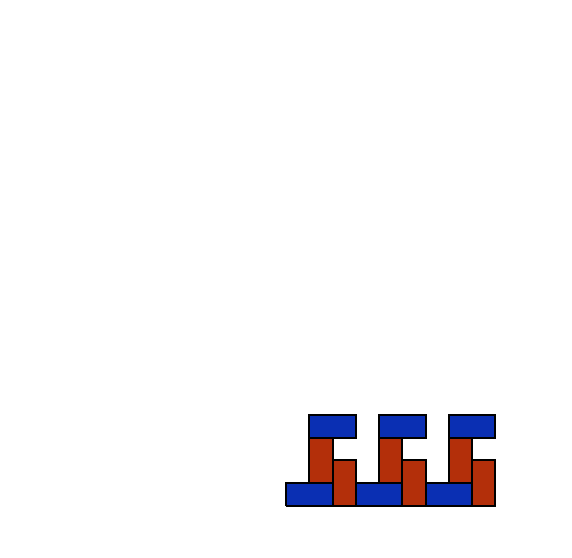

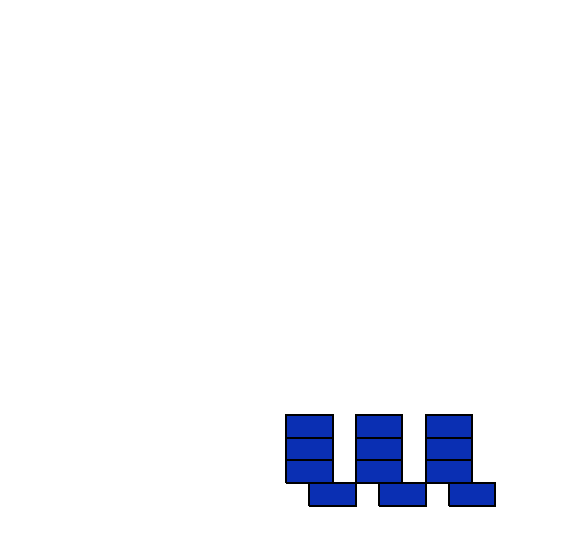

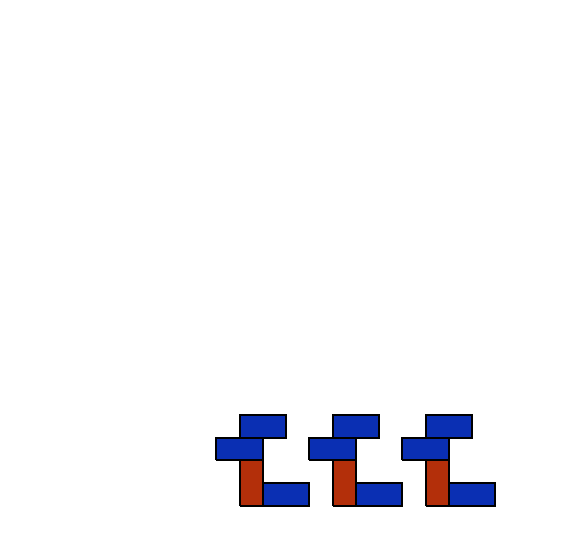

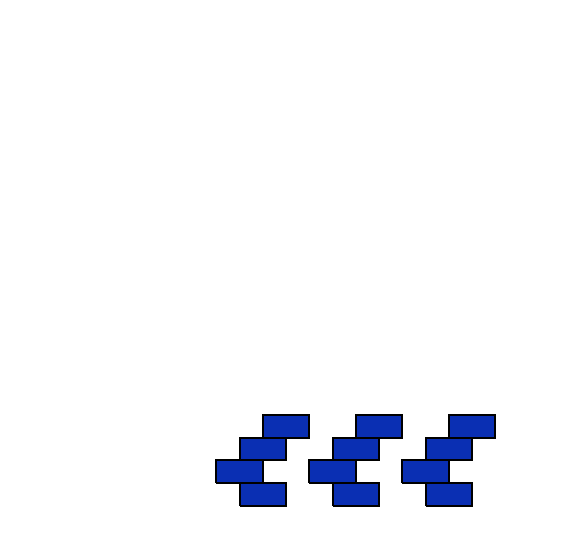

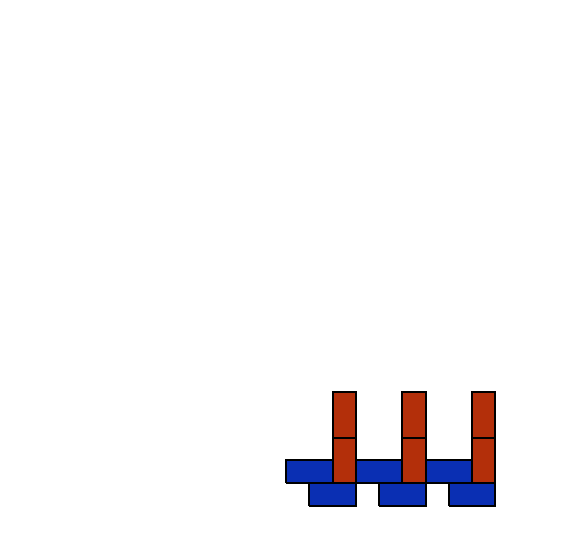

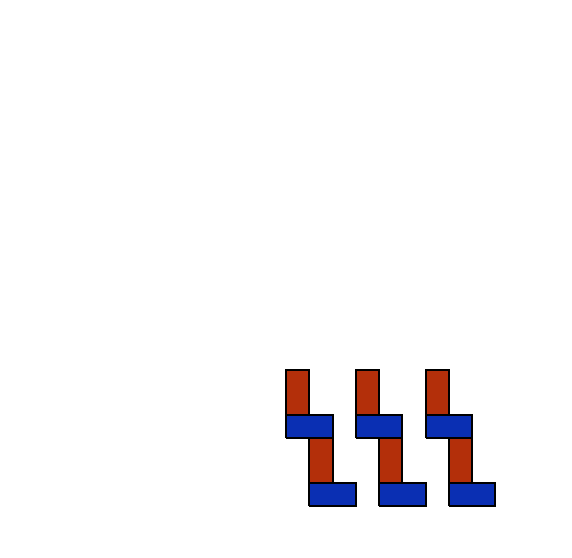

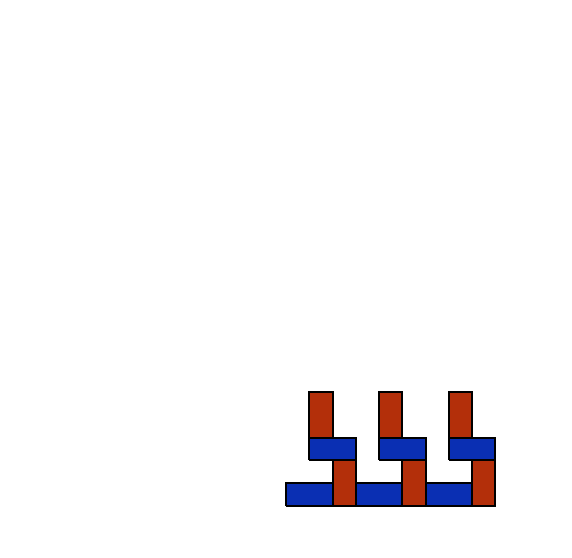

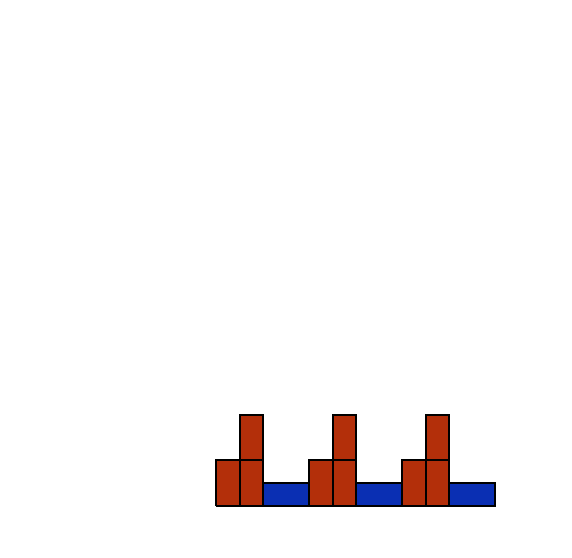

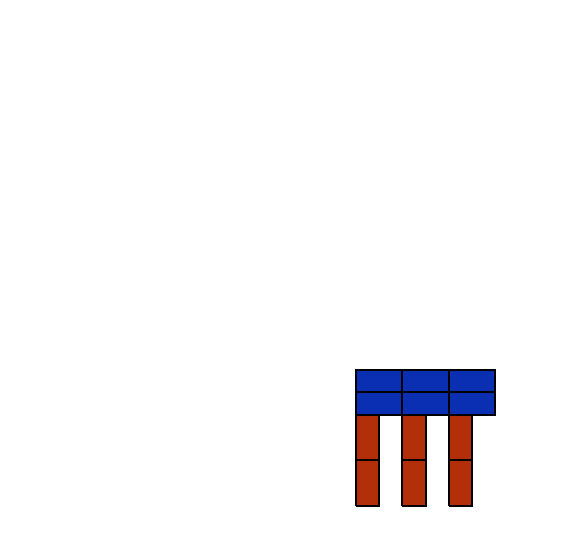

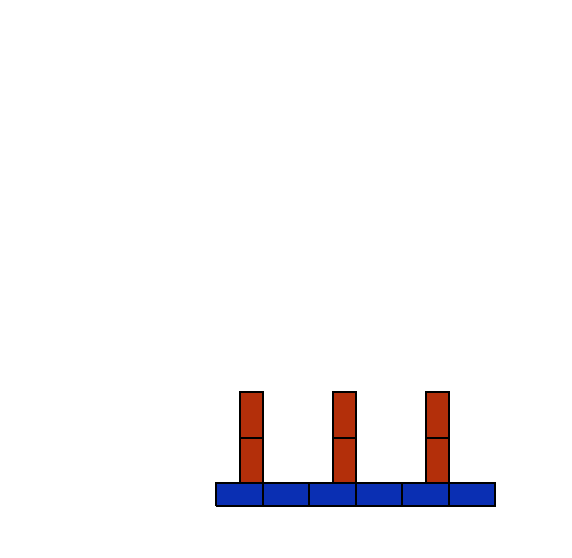

In [554]:
# diag left

for chunk in chunks:

    w = new_world()
    diag(w, chunk, n = 3, direction='left')
    if not w.broken:
        utils.draw_world(w)

In [ ]:
for chunk in chunks:

    w = new_world()
    row(w, chunk, n = 5, diff = 0)
    if not w.broken:
        utils.draw_world(w)

## Create castles

In [655]:
# Create towers

towers = {}

for tower_height in range(2,5):
    
    towers[tower_height] = []
    
    for chunk in chunks:
        w = new_world()
        stack(w, chunk, n = tower_height, x_location = 0)
        
        if not w.broken:
            towers[tower_height].append(w.get_block_dict()['blocks'])
#             utils.draw_world(w)

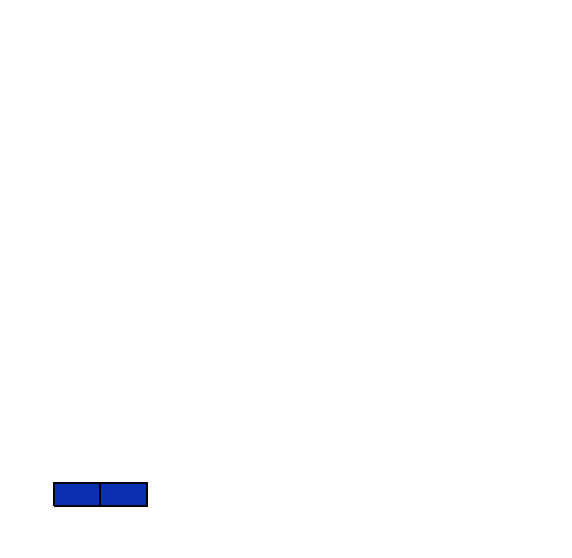

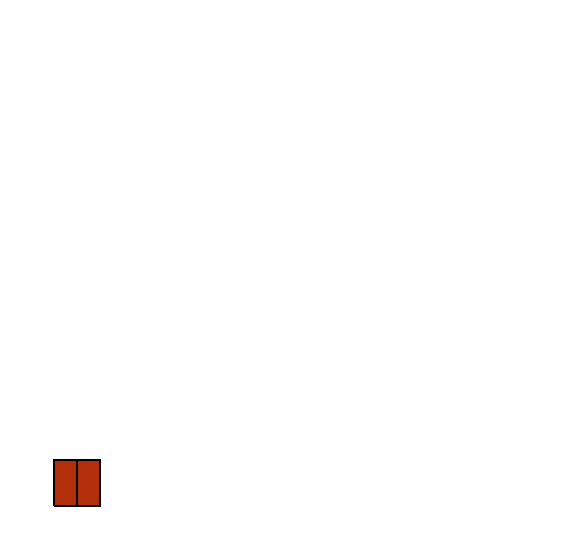

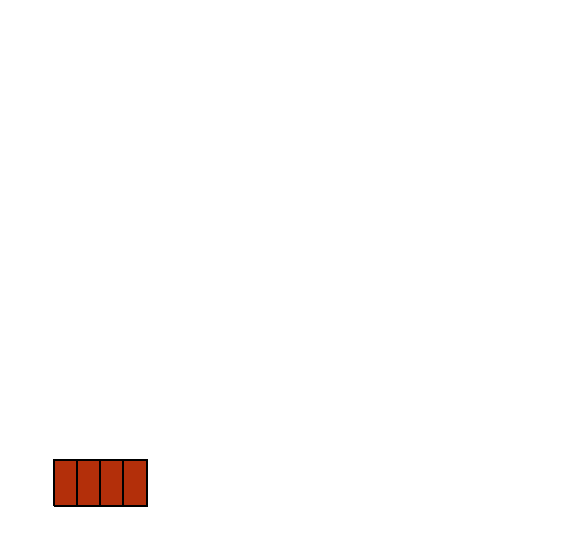

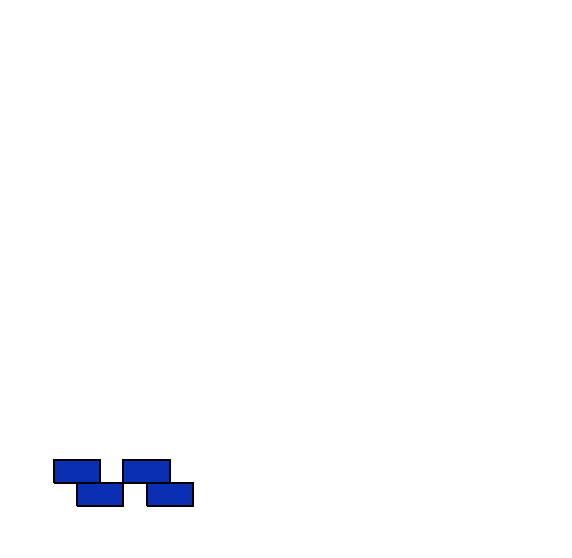

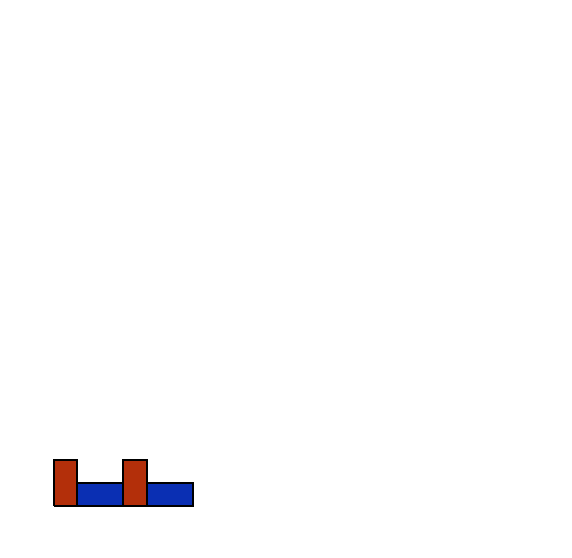

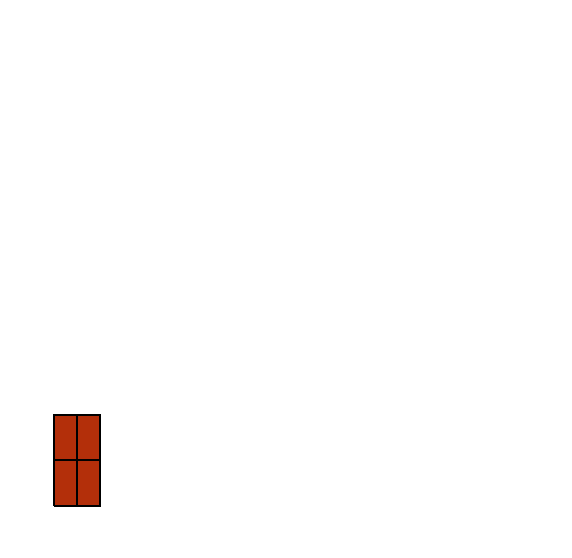

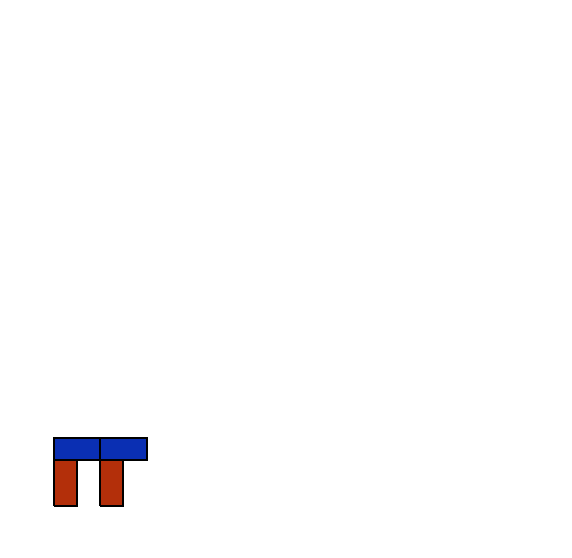

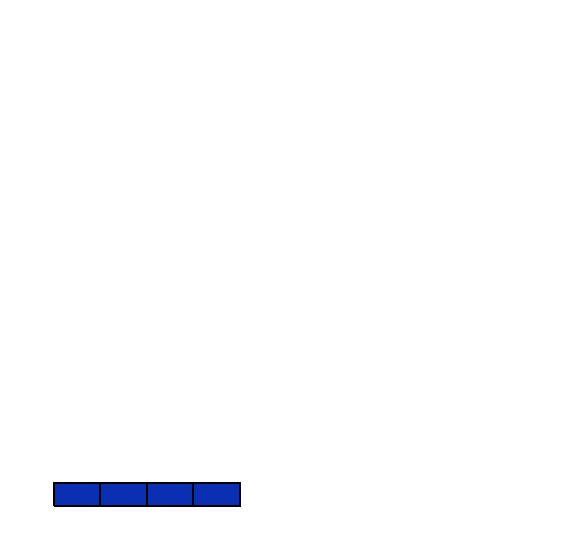

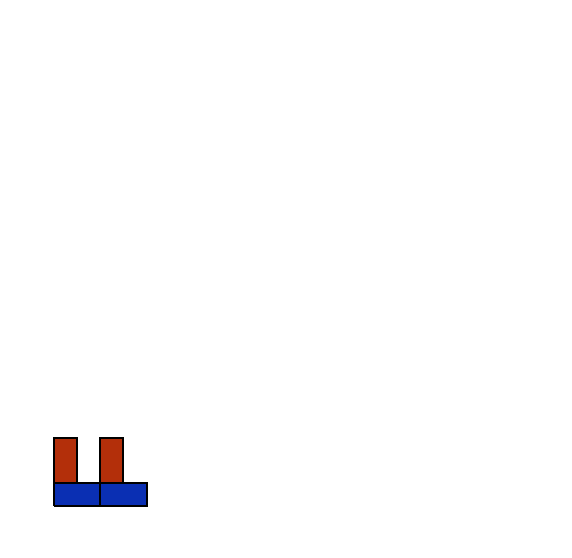

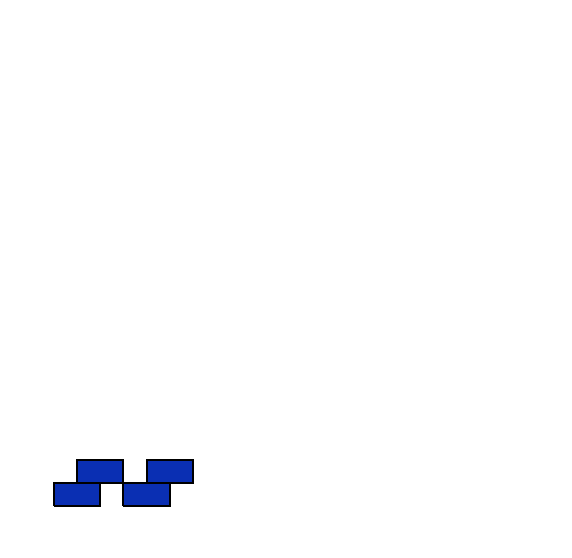

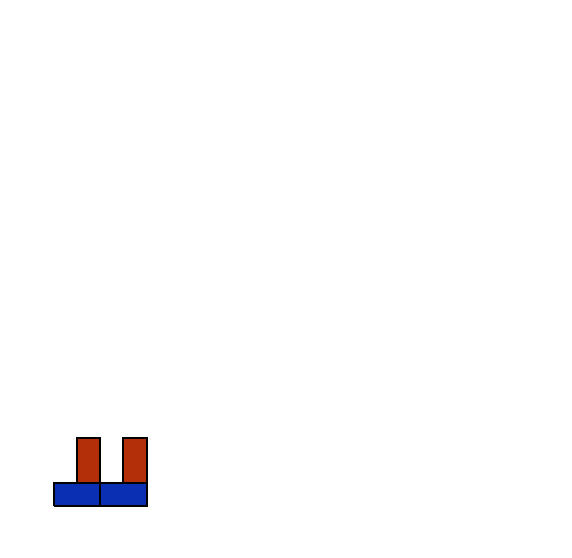

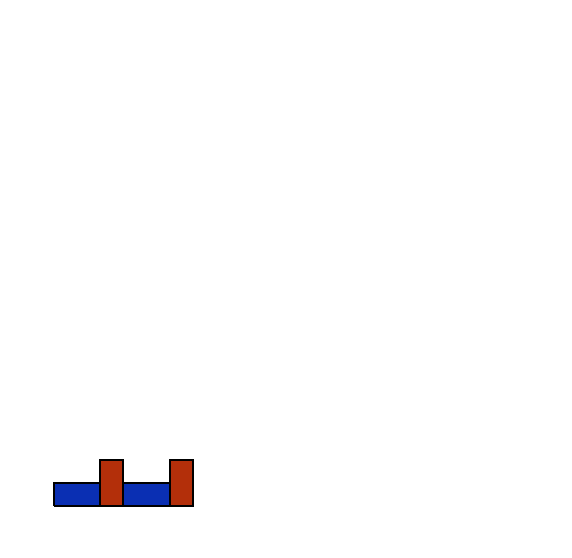

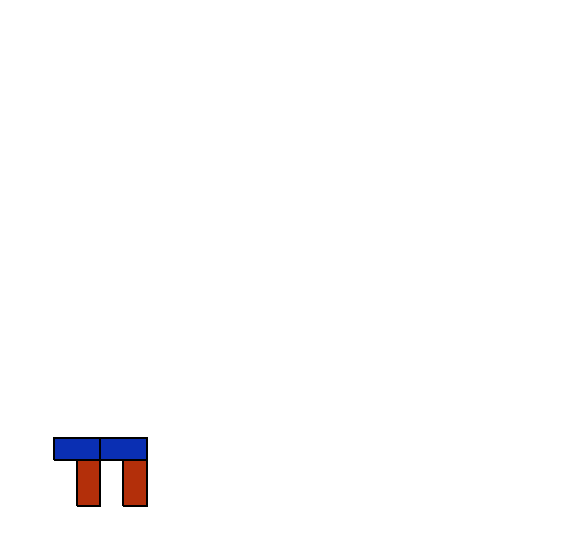

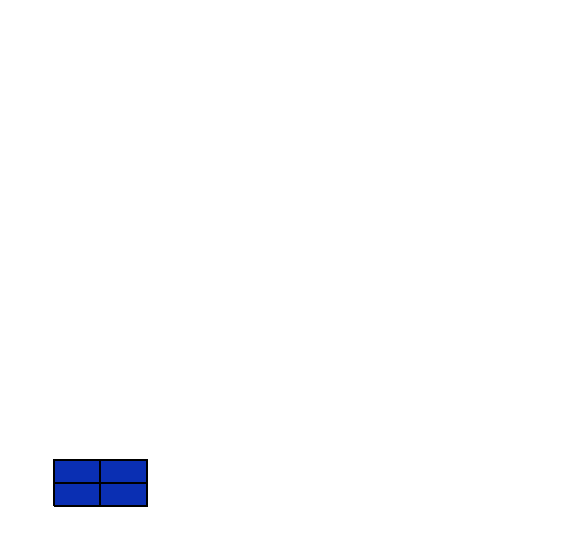

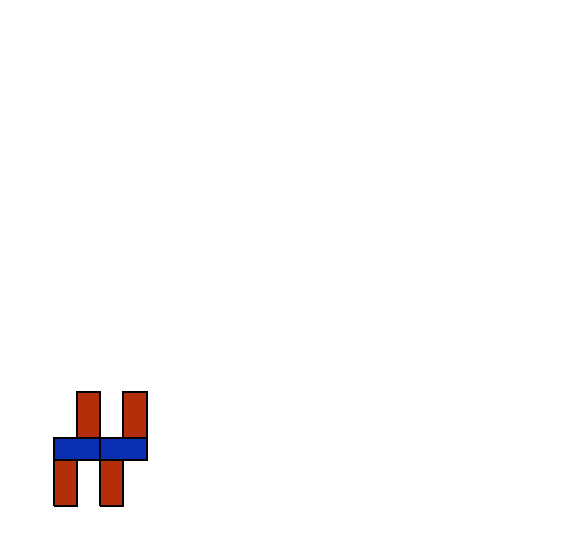

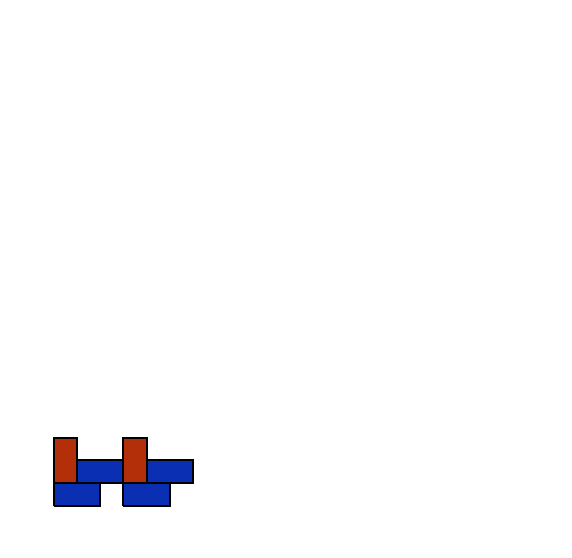

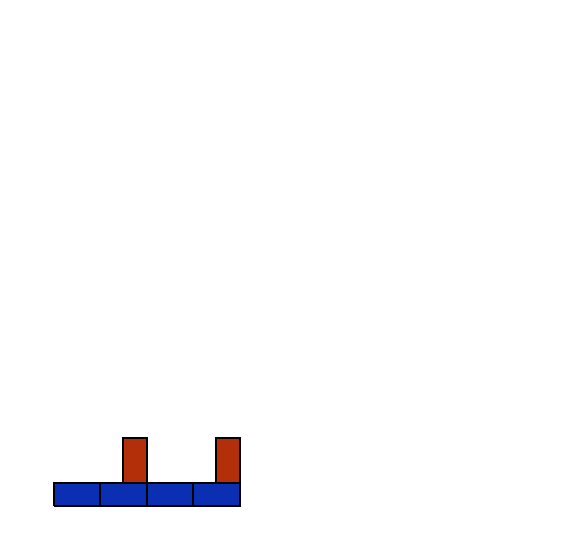

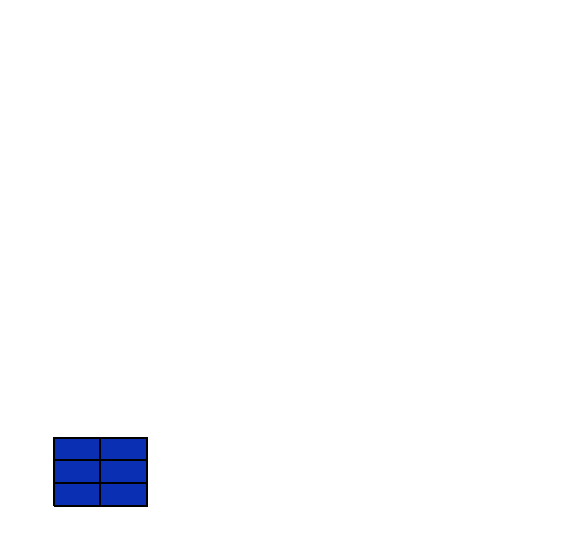

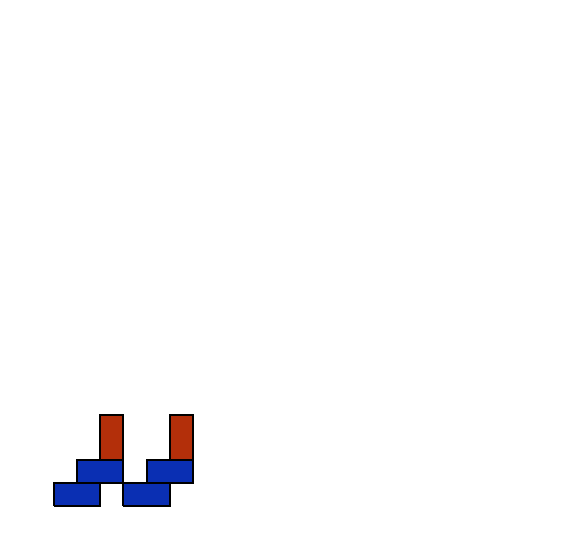

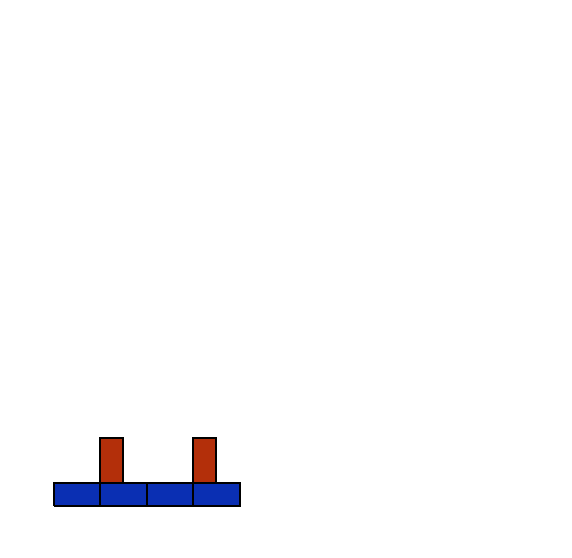

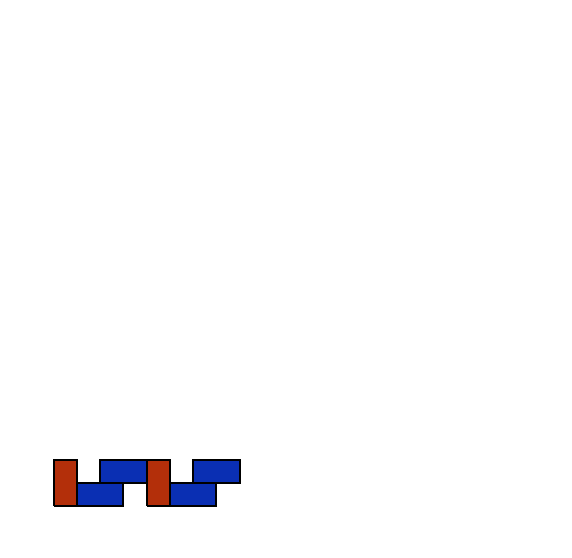

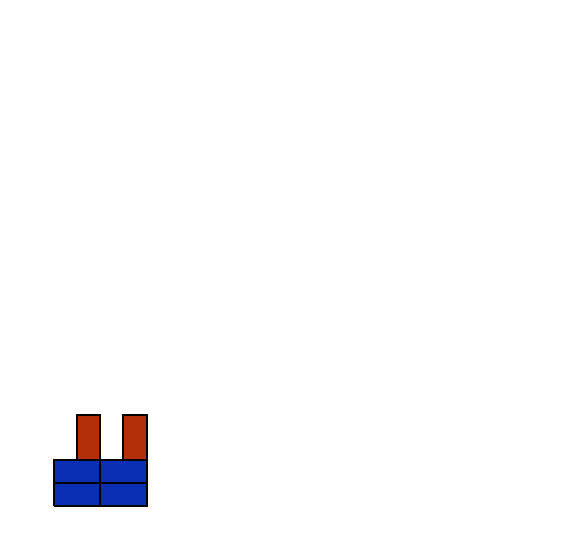

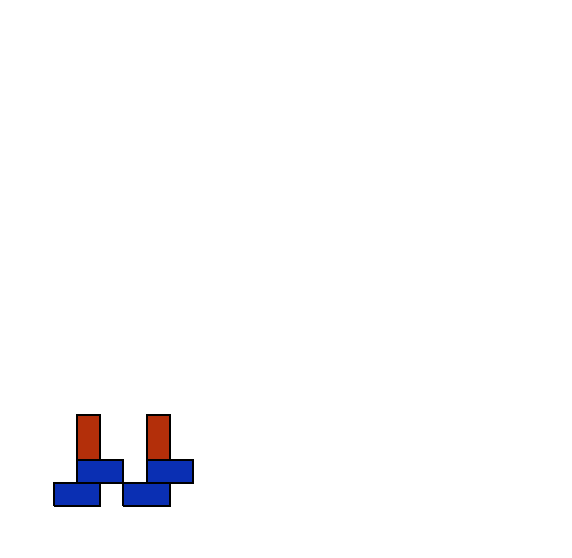

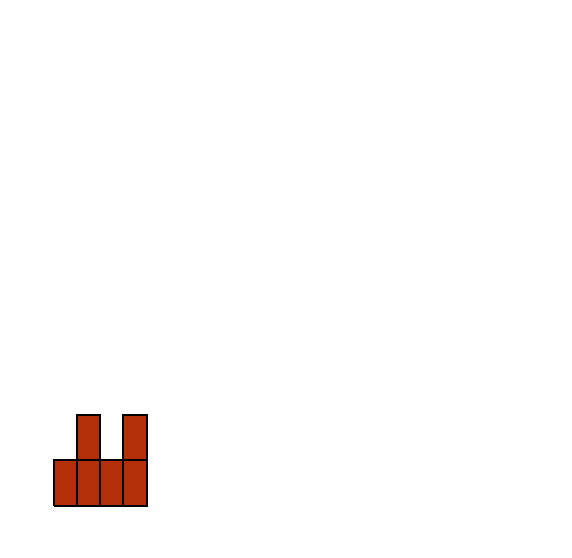

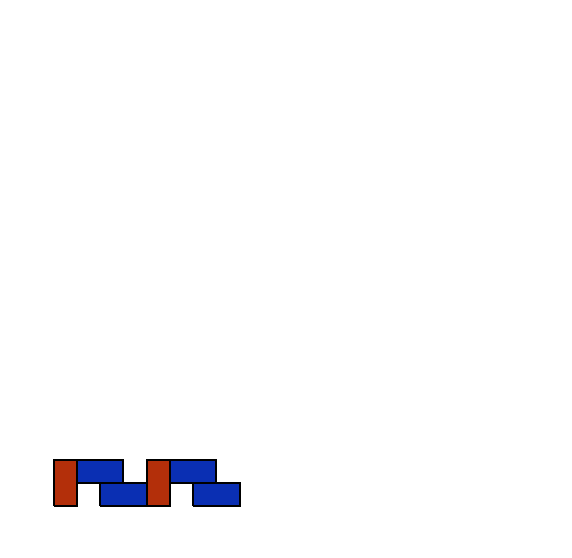

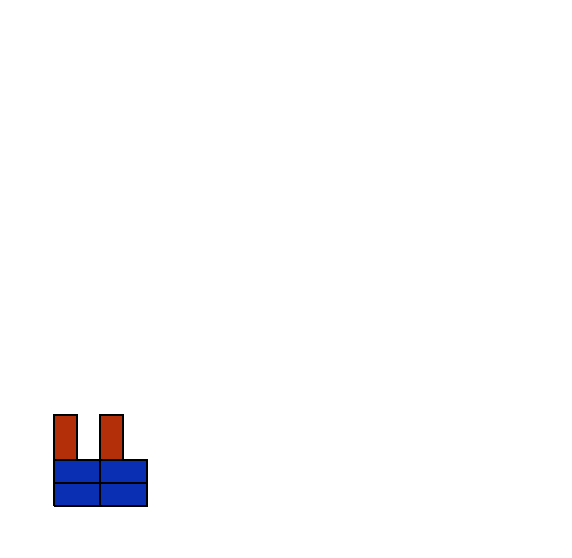

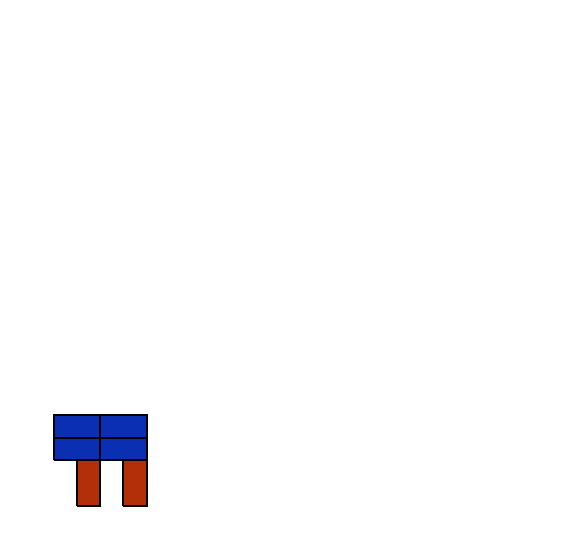

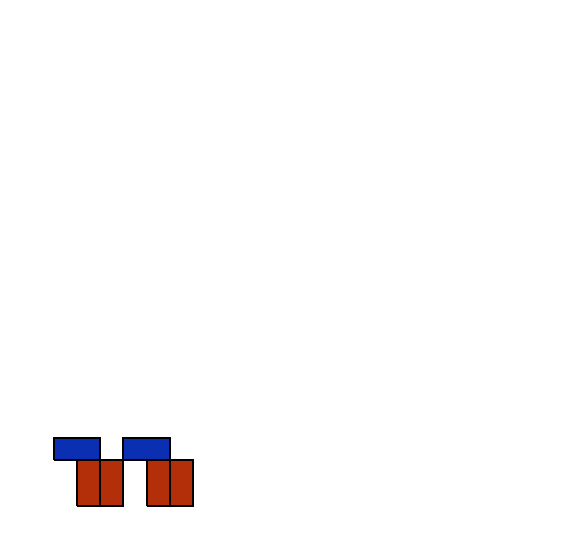

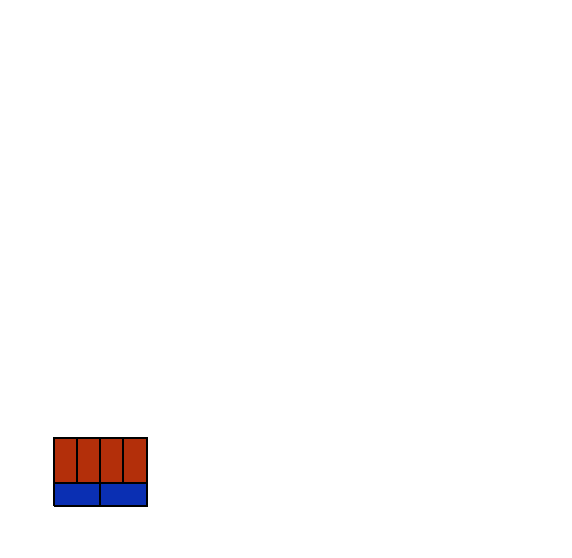

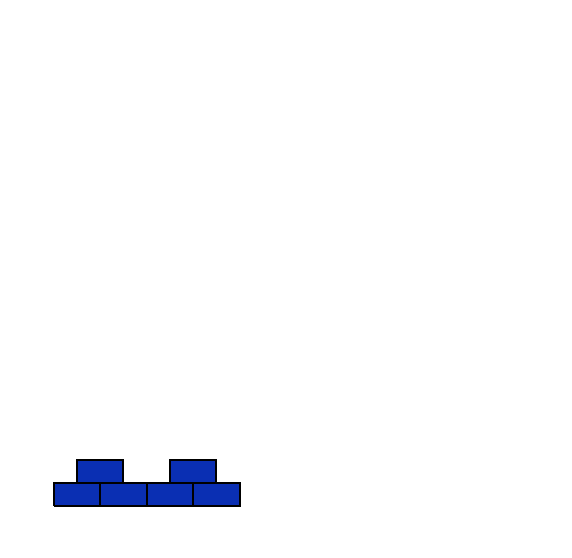

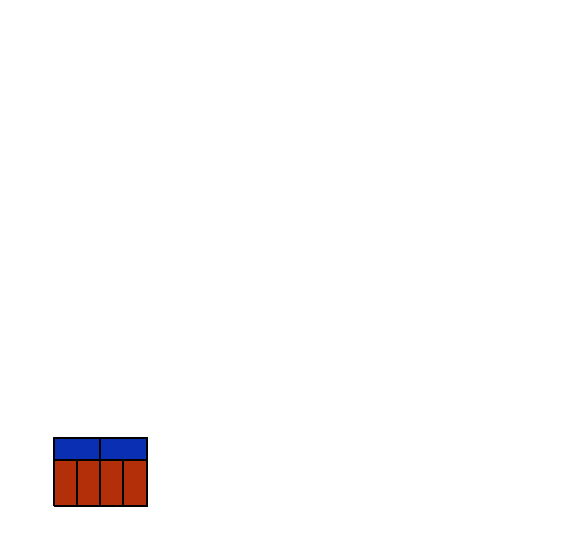

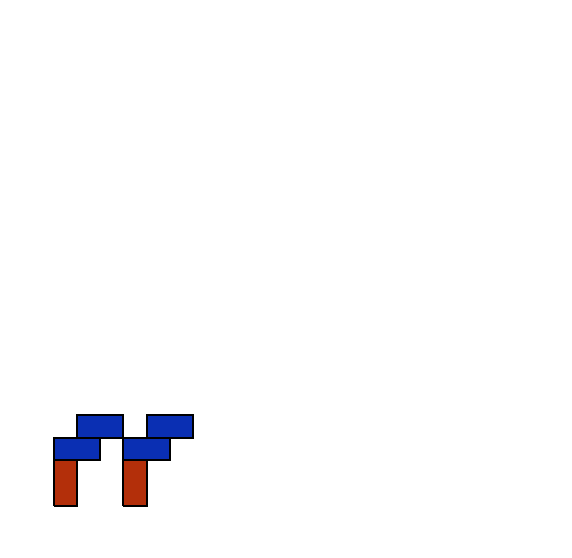

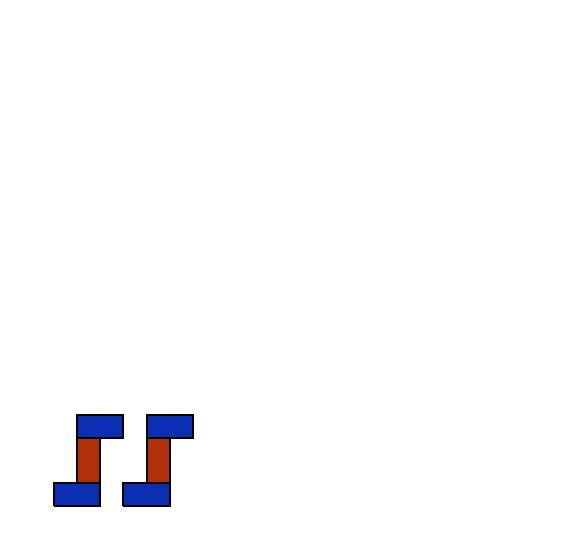

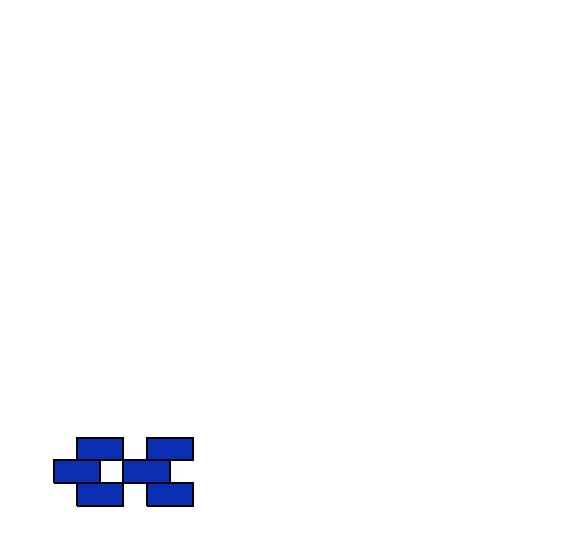

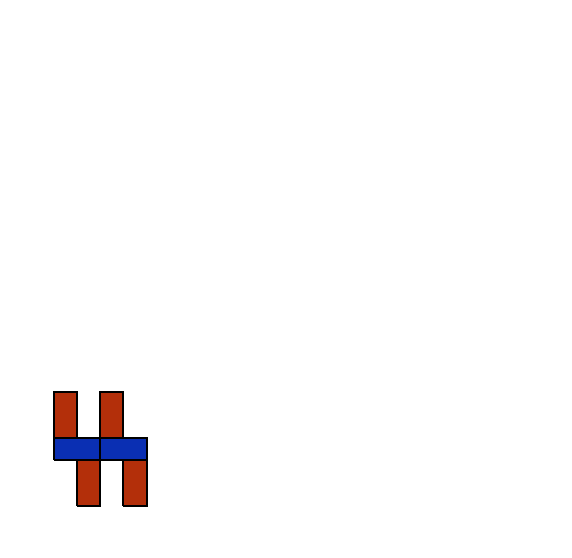

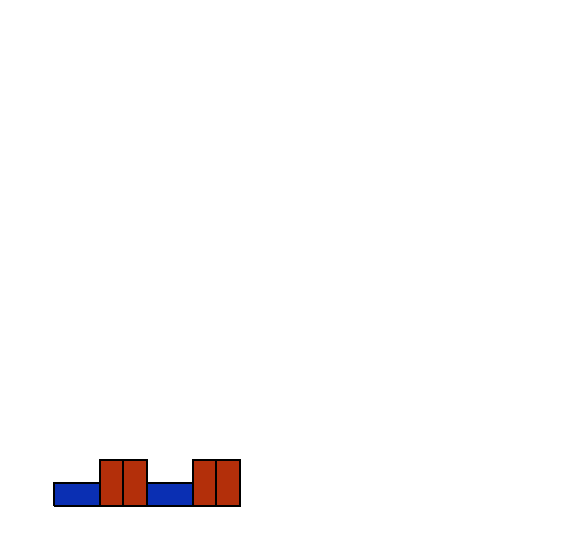

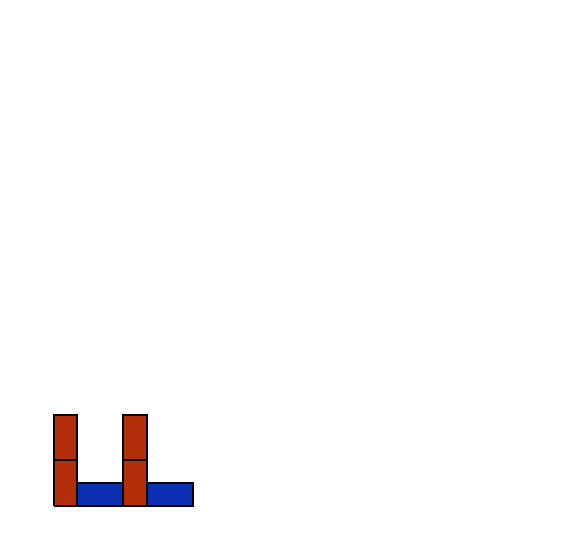

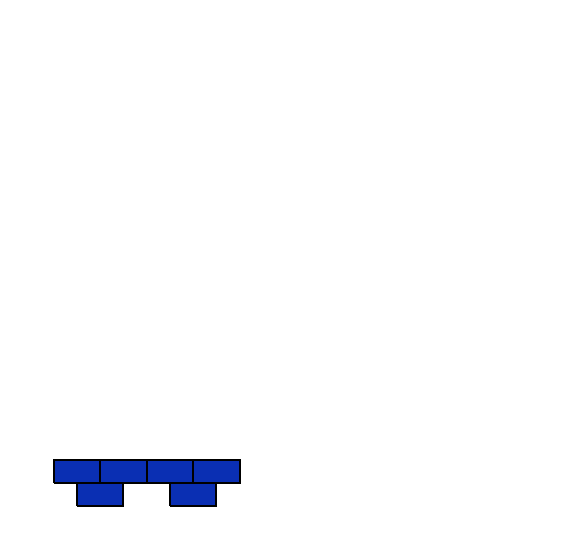

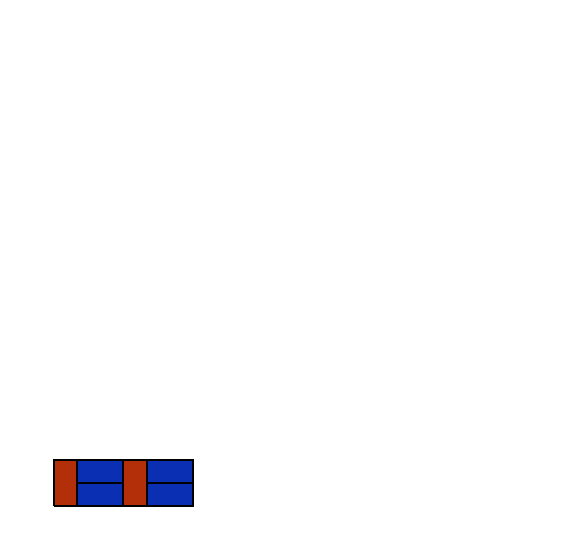

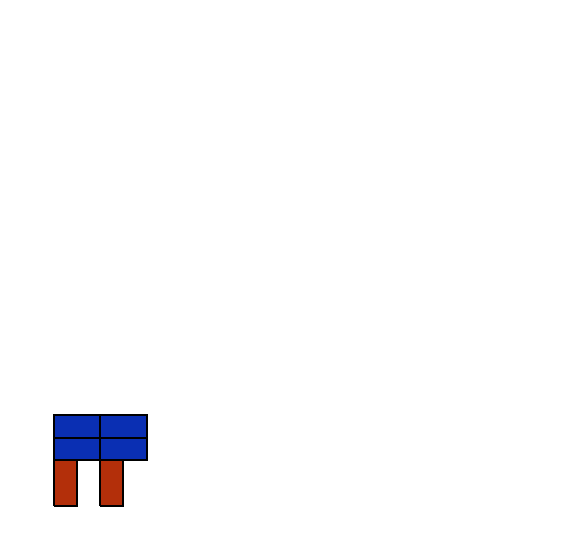

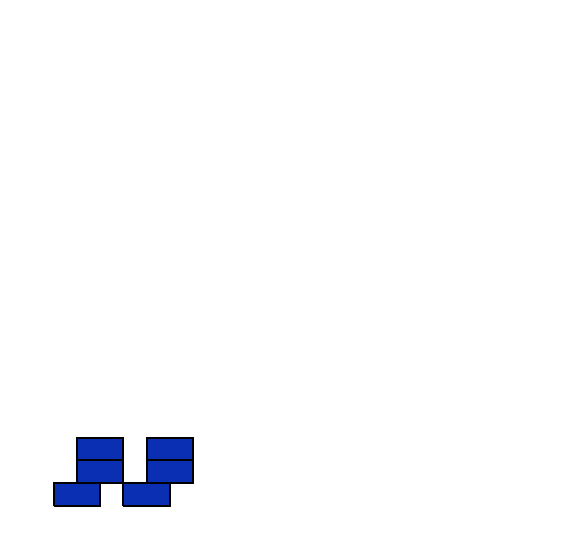

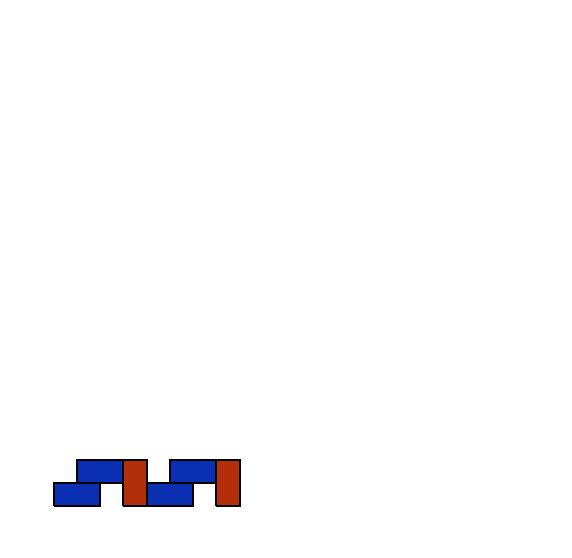

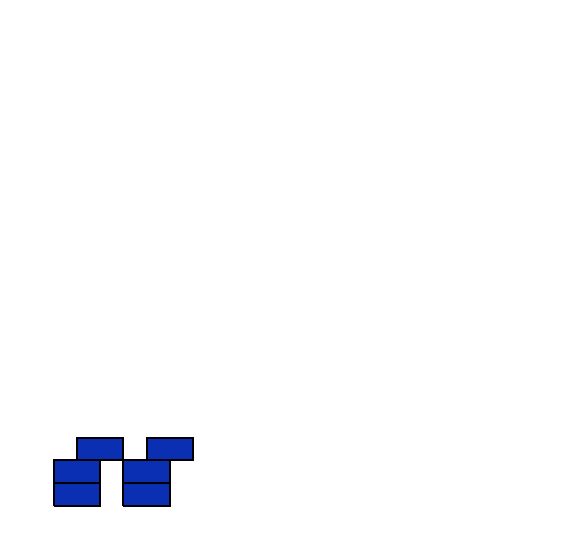

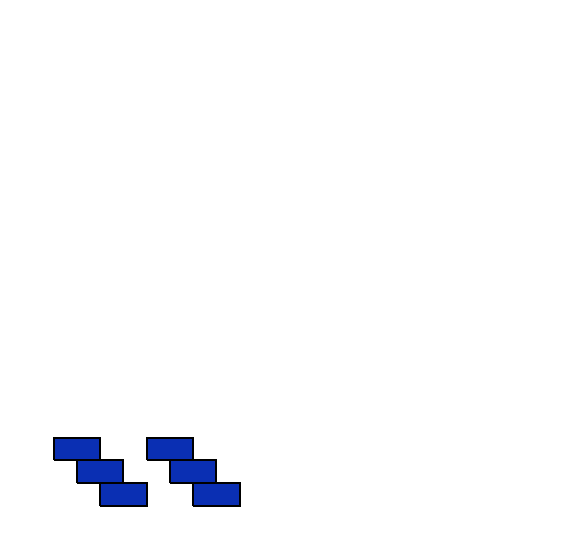

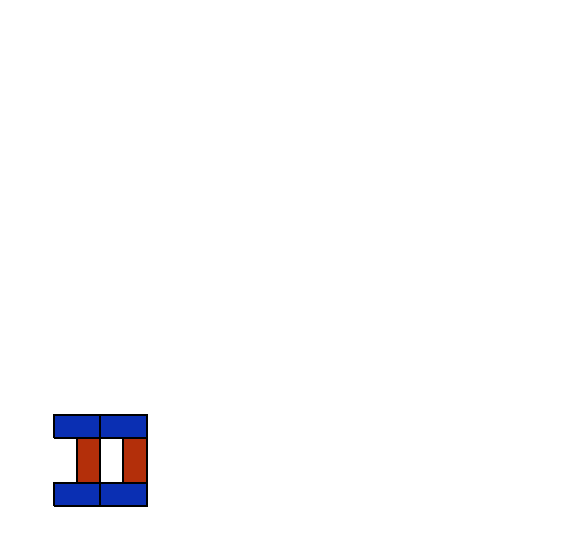

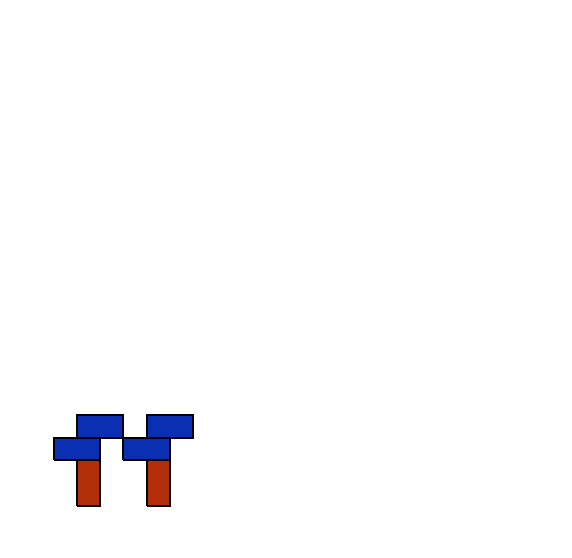

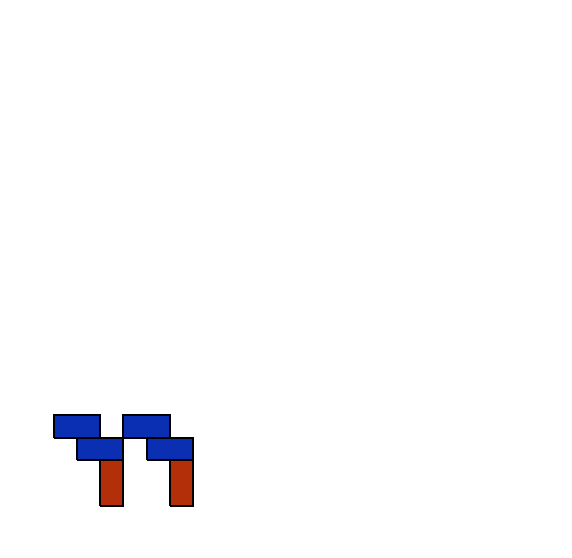

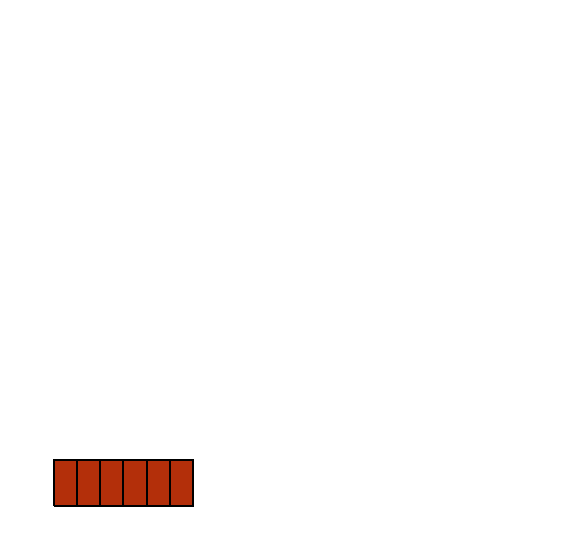

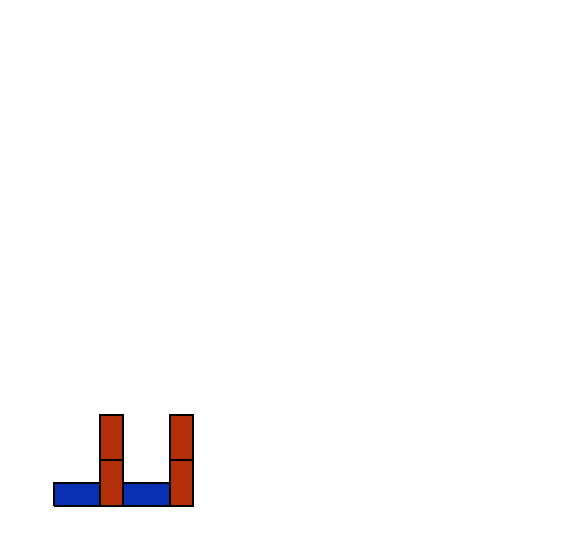

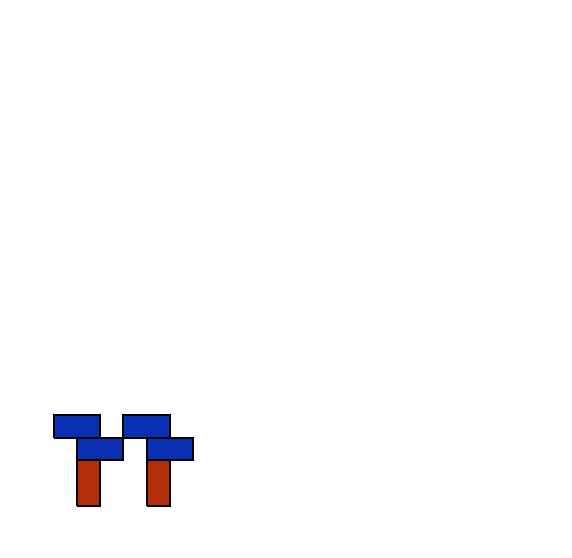

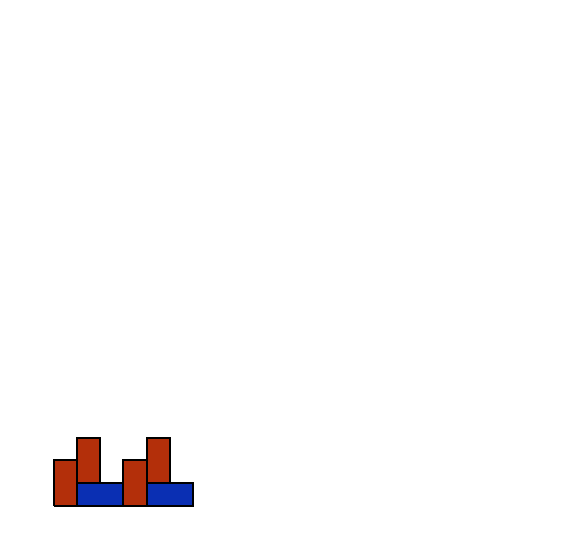

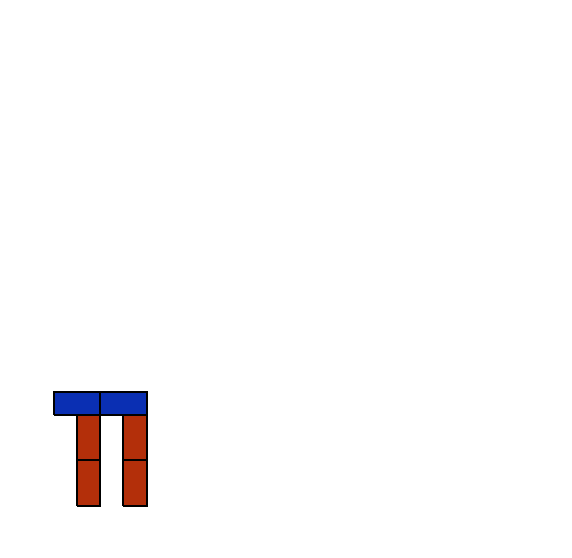

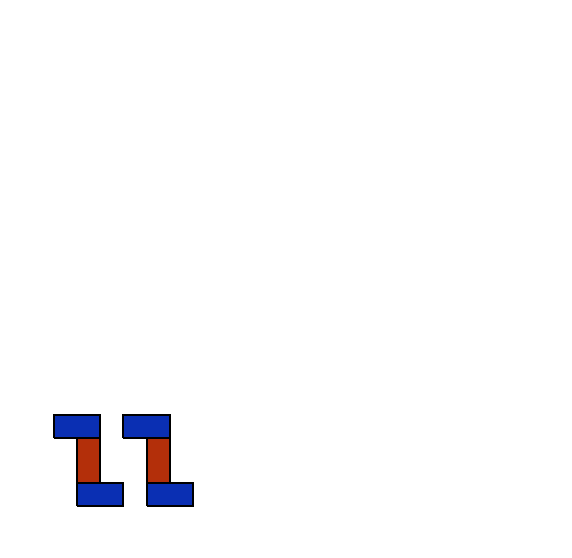

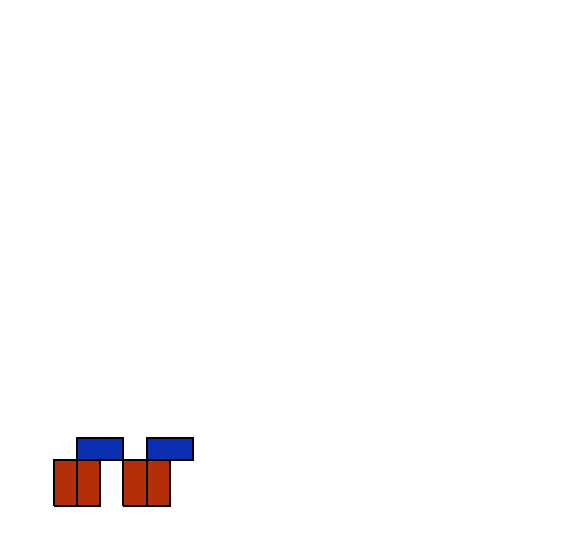

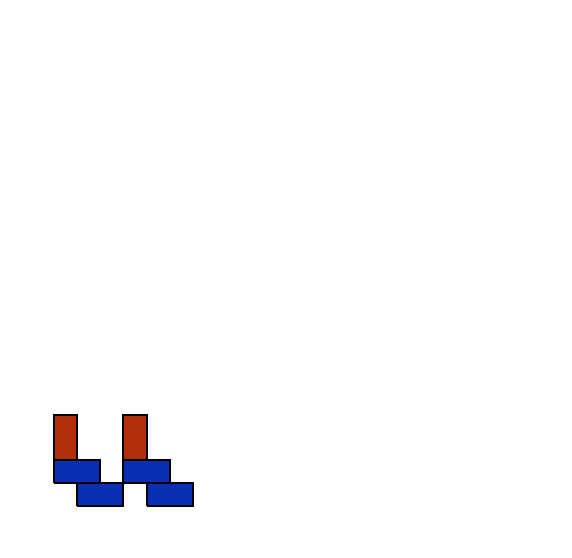

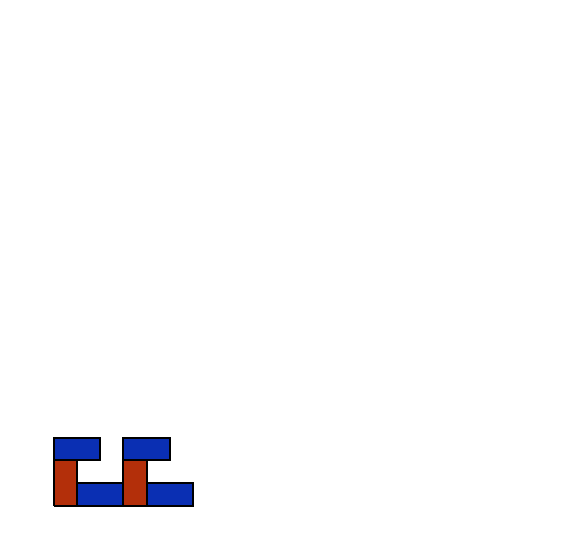

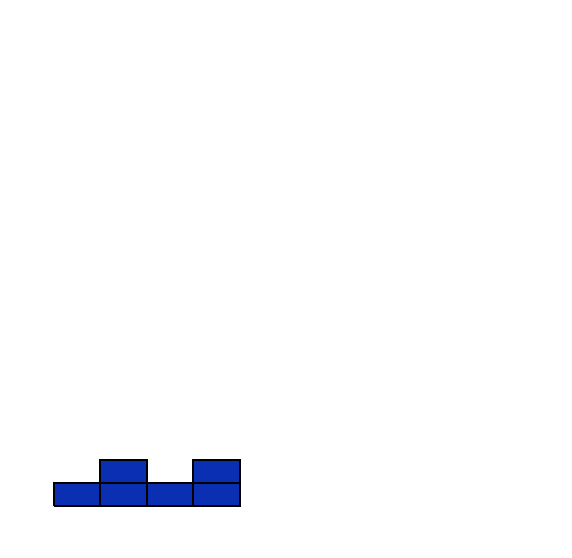

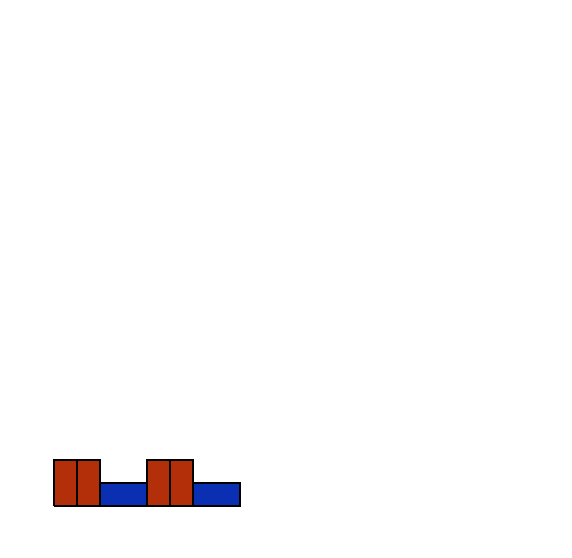

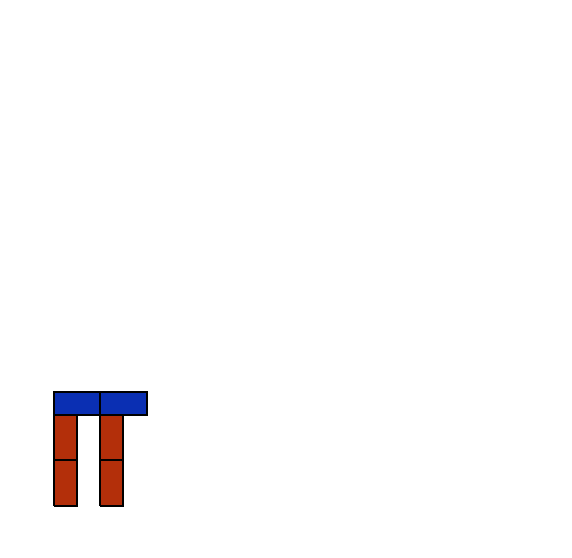

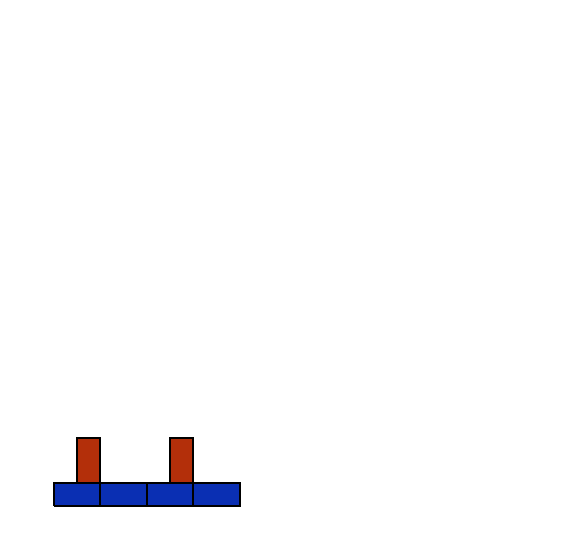

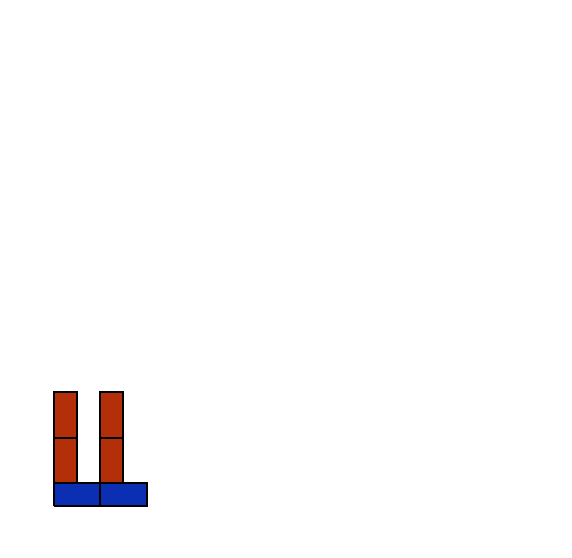

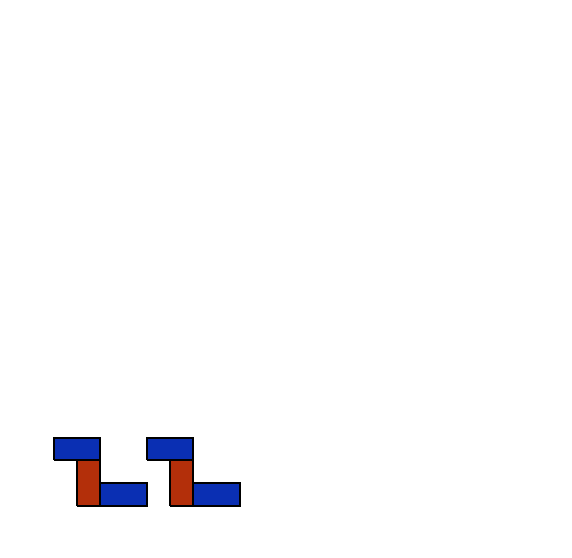

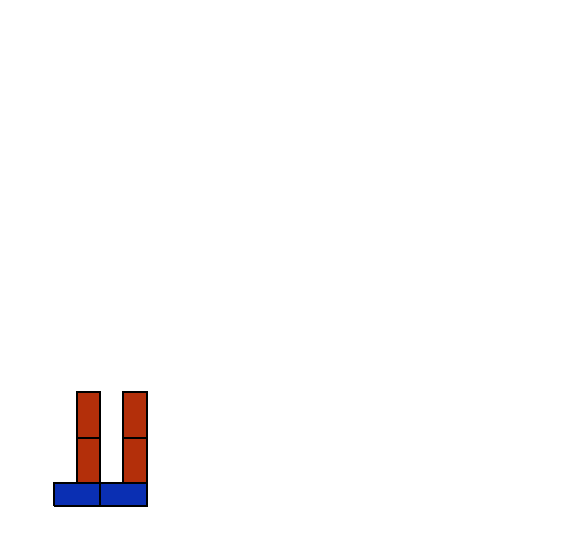

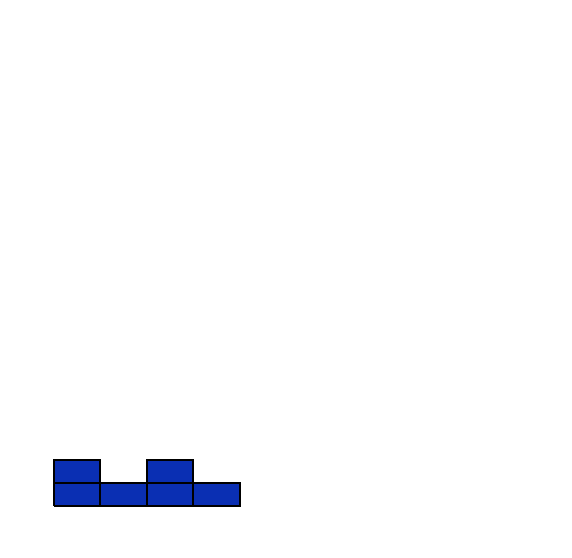

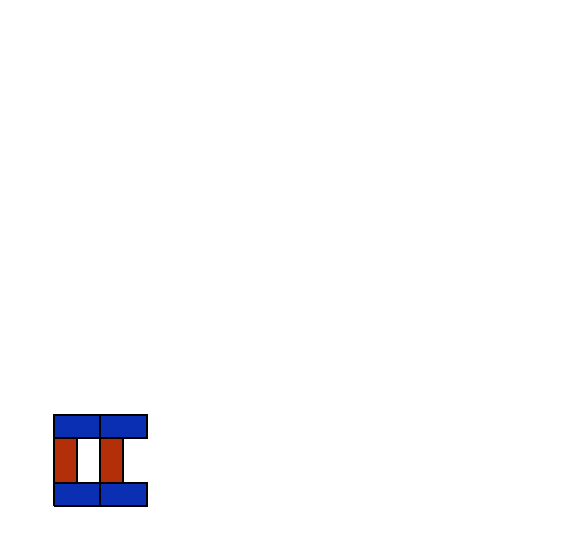

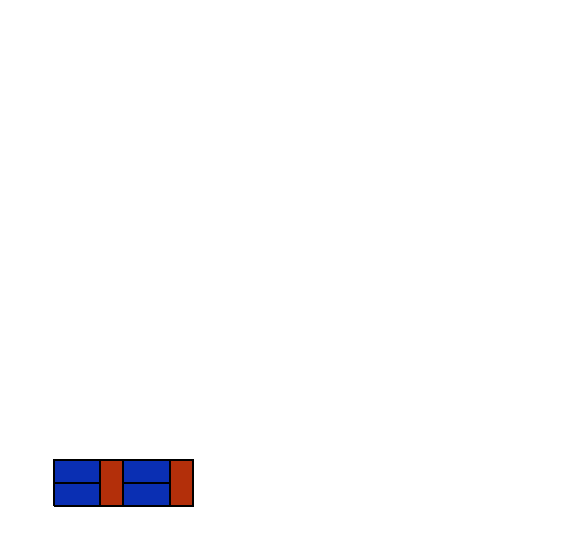

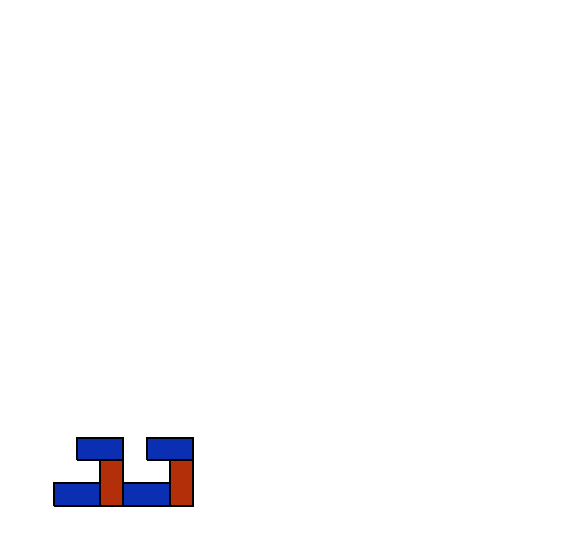

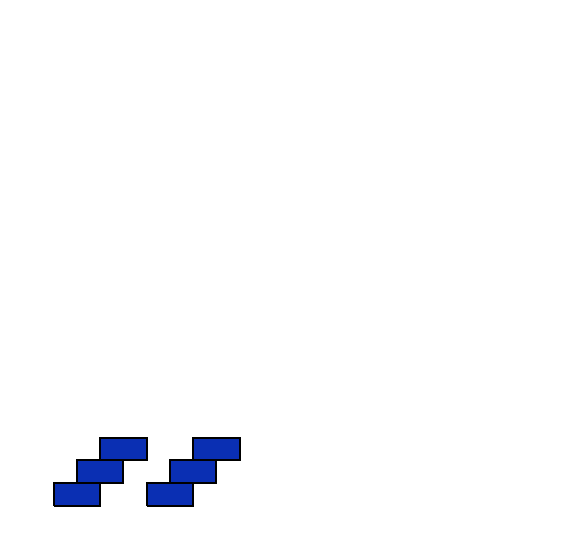

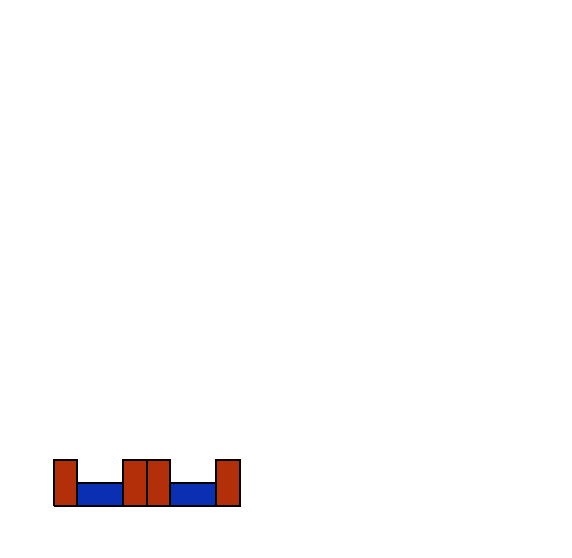

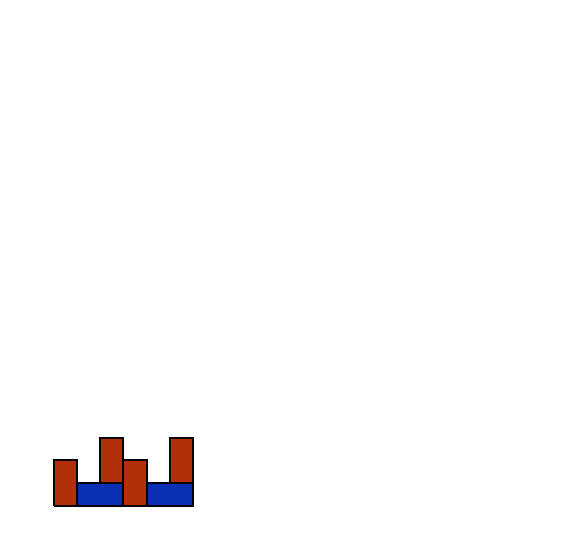

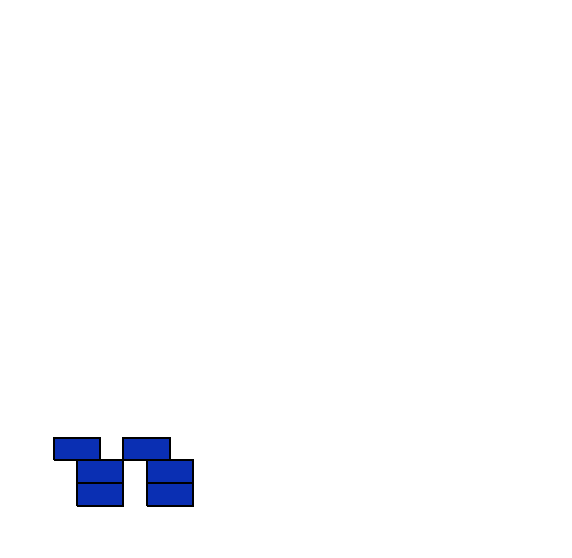

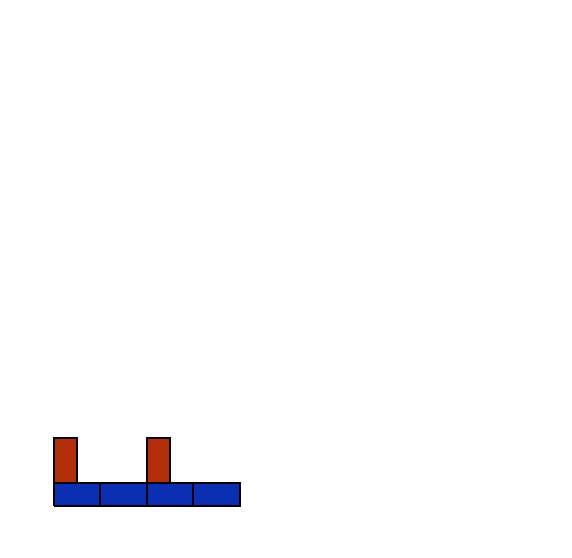

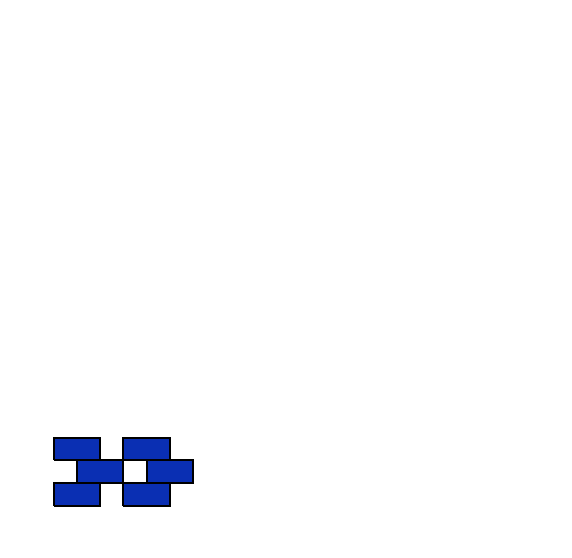

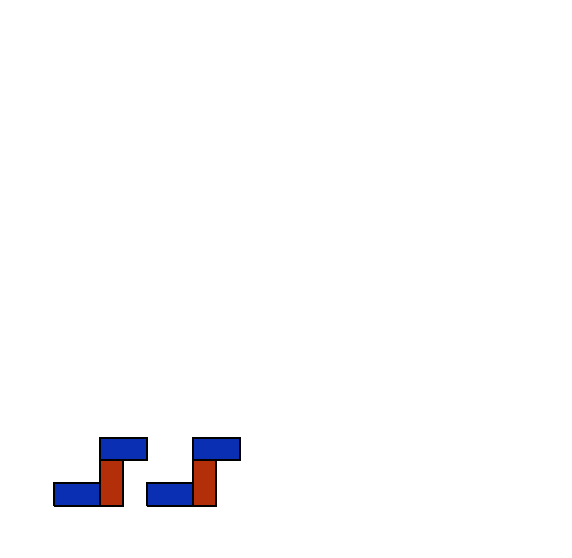

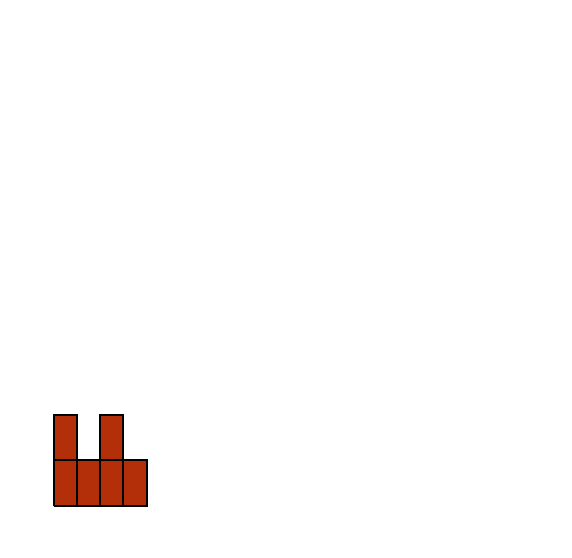

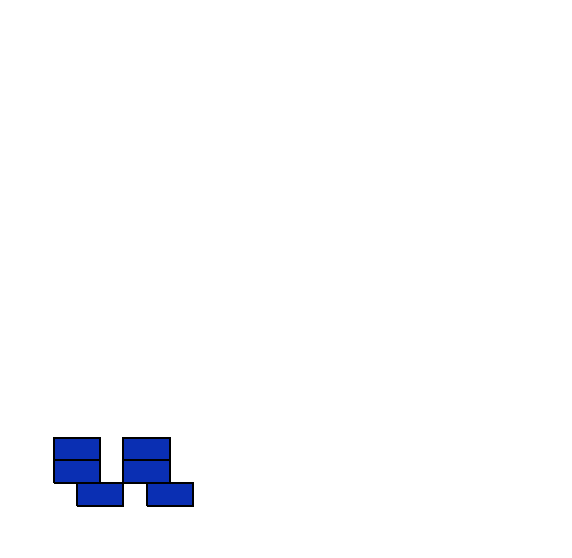

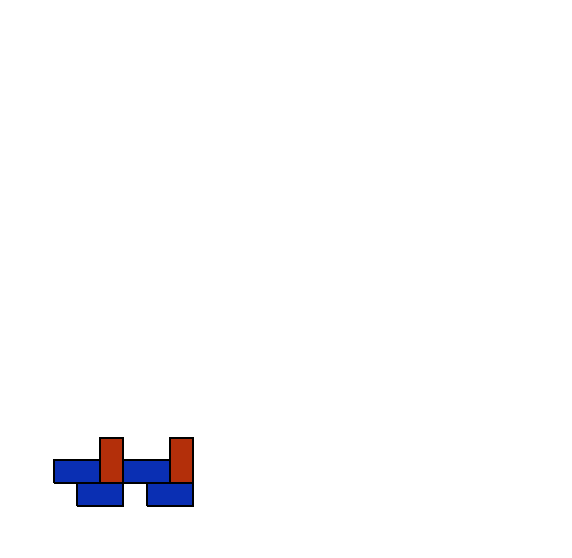

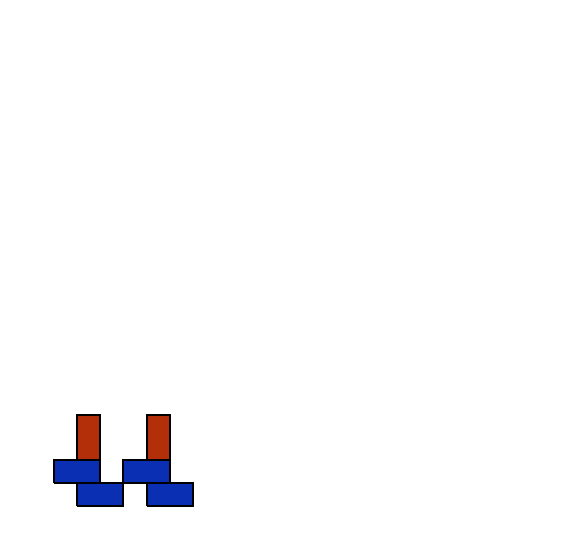

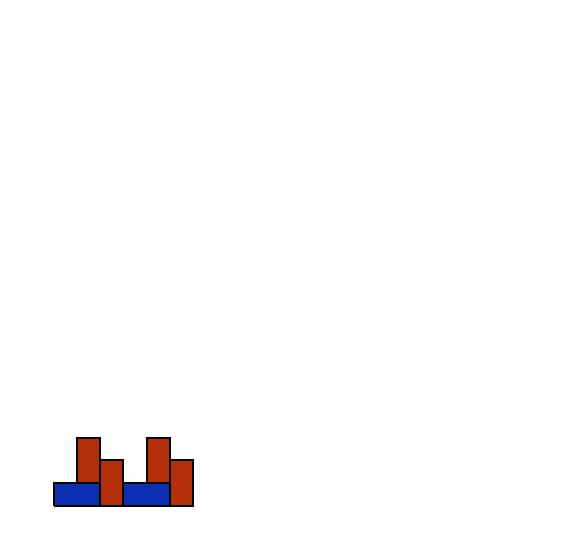

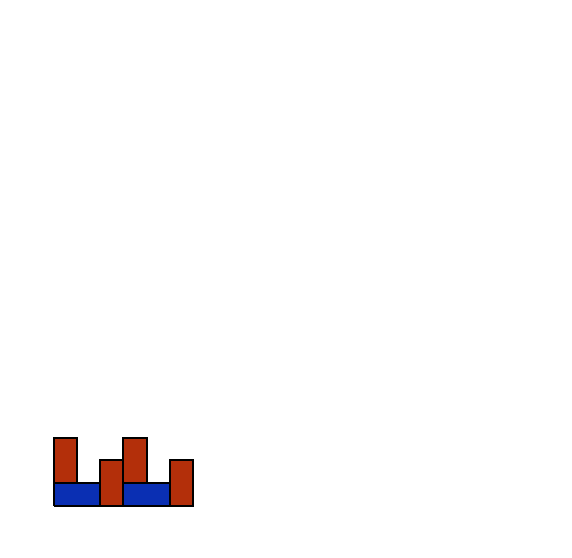

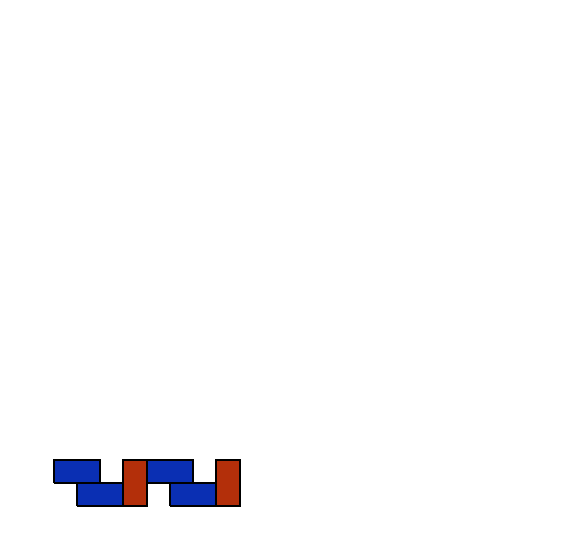

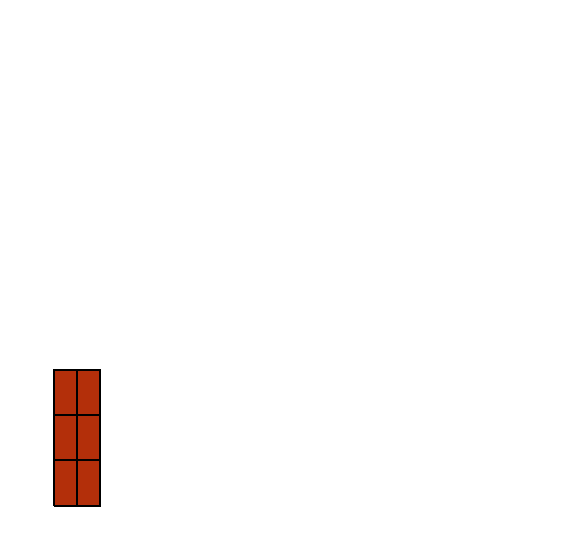

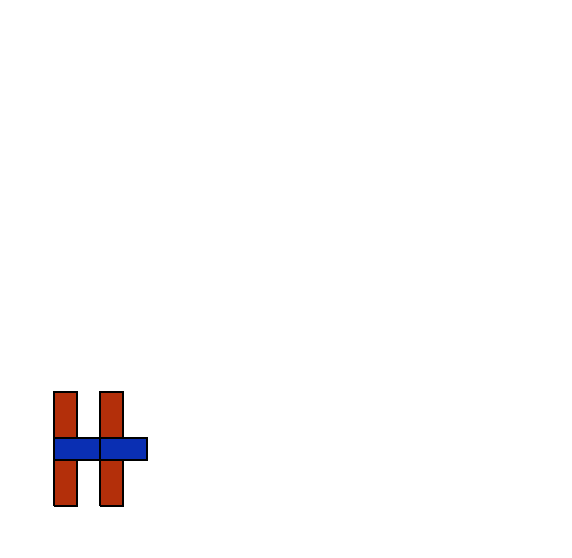

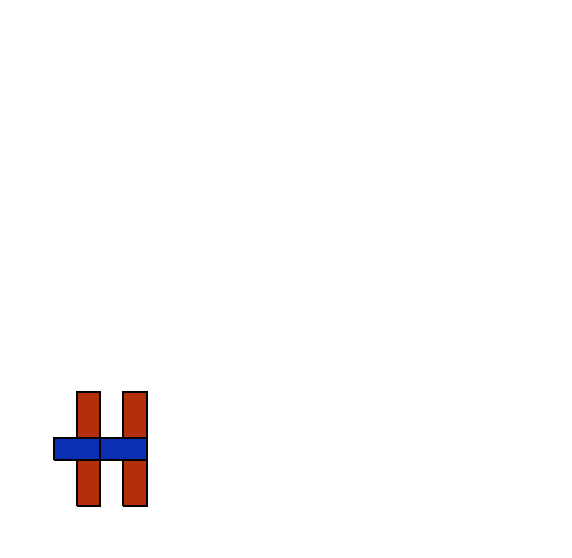

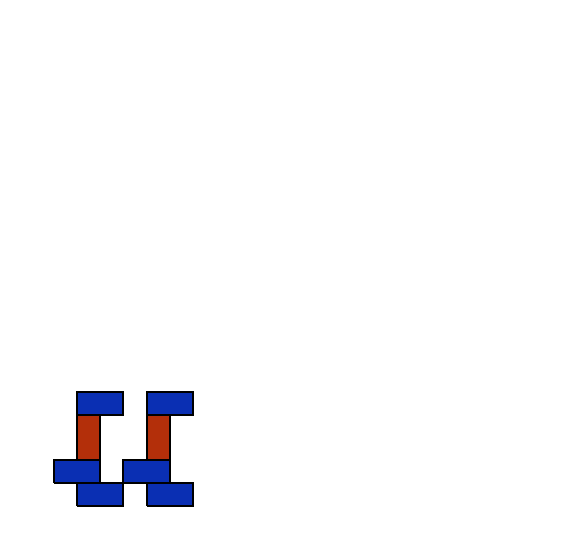

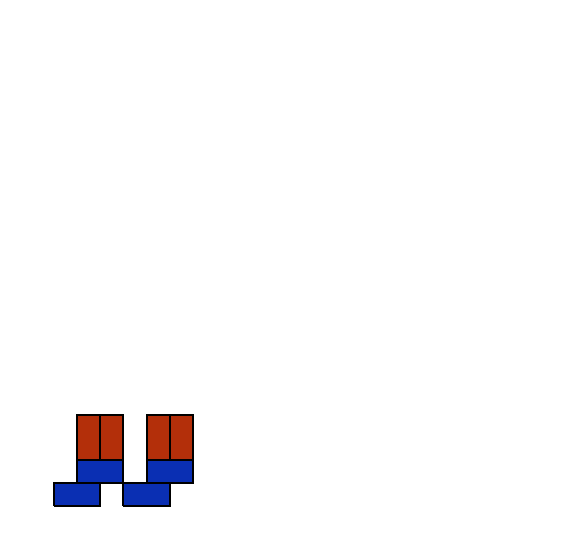

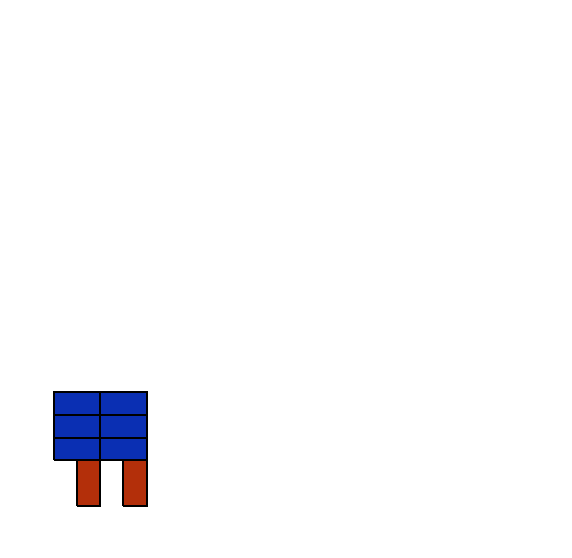

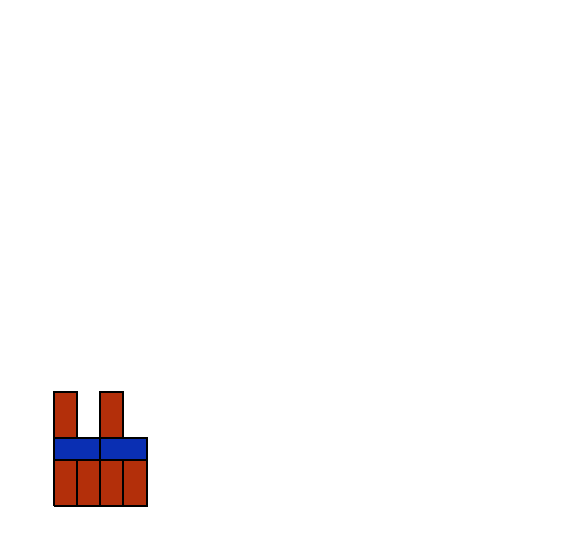

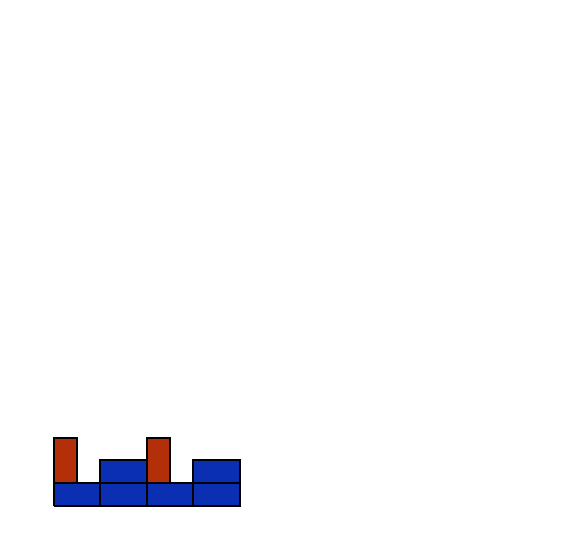

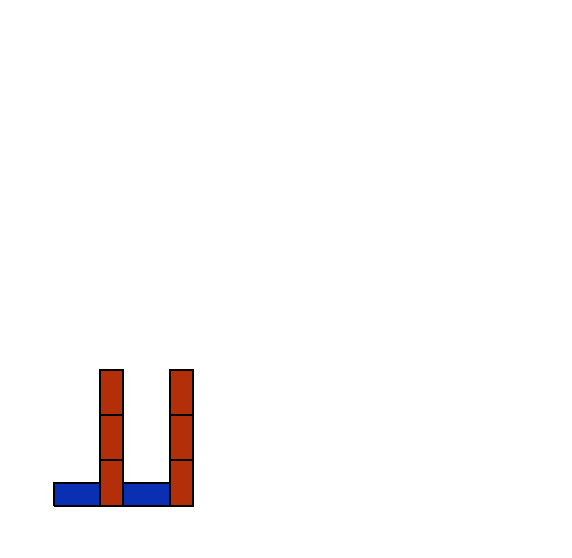

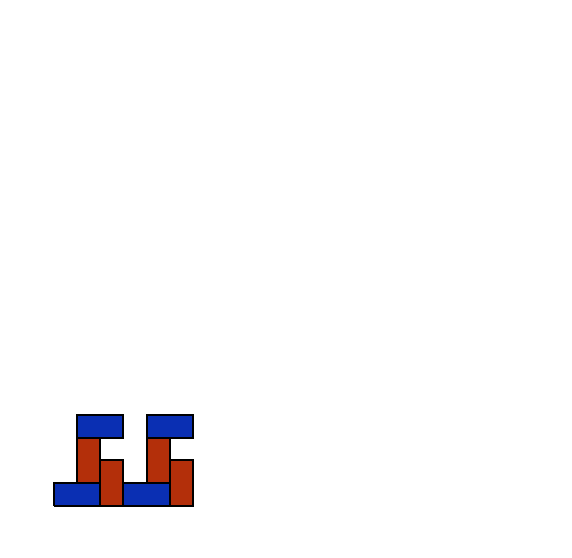

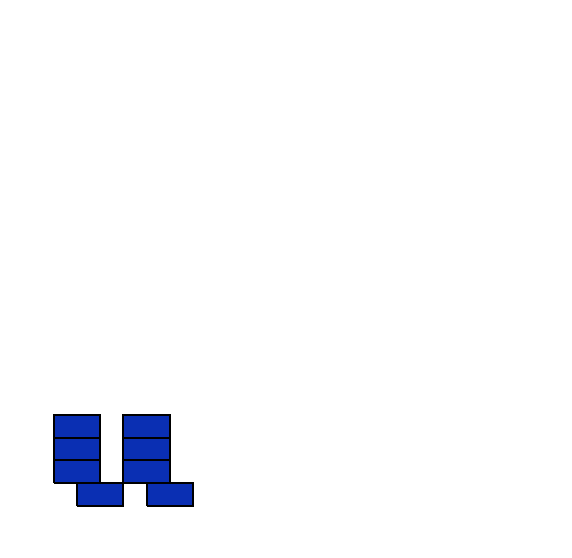

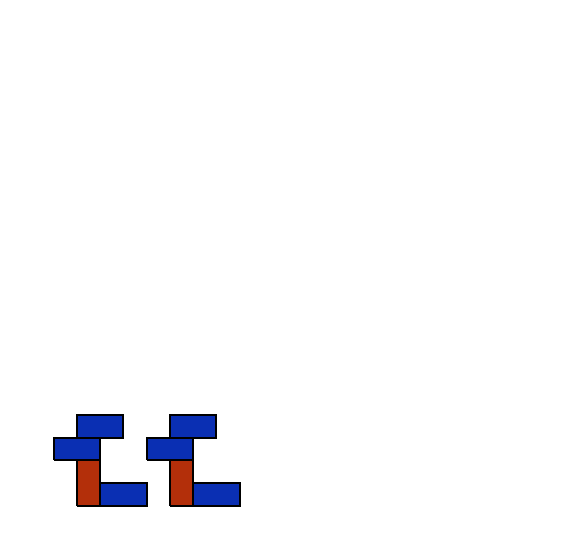

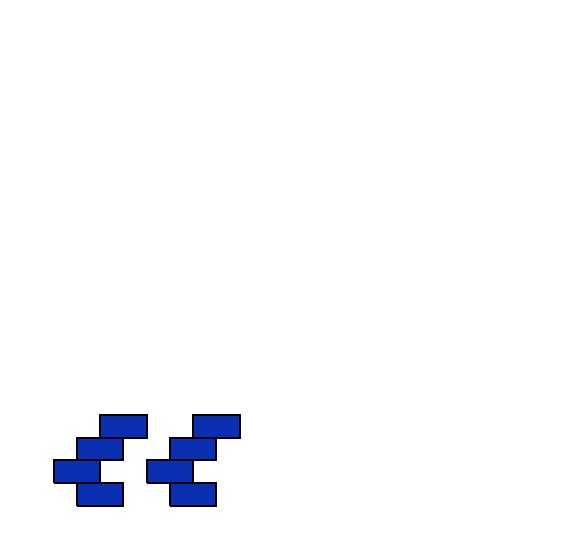

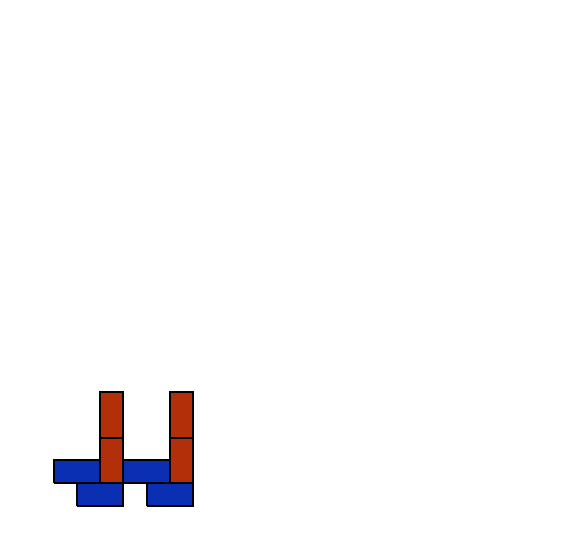

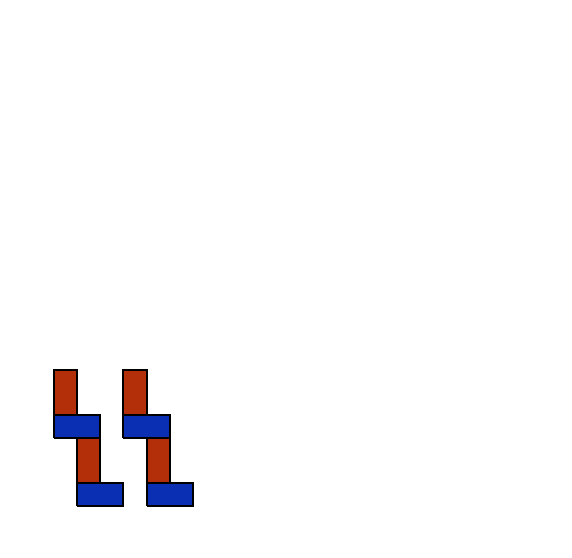

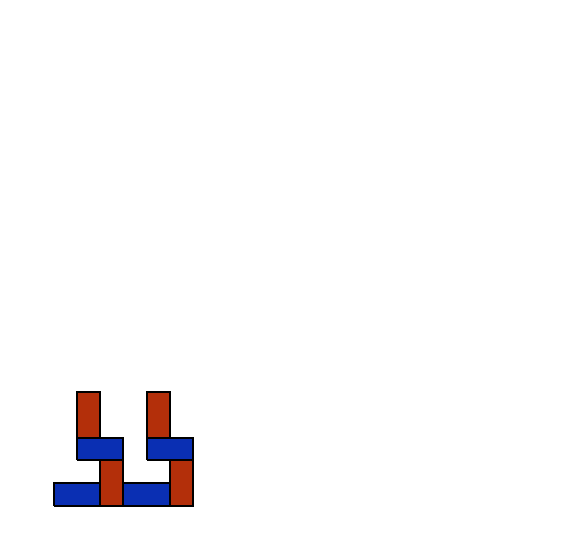

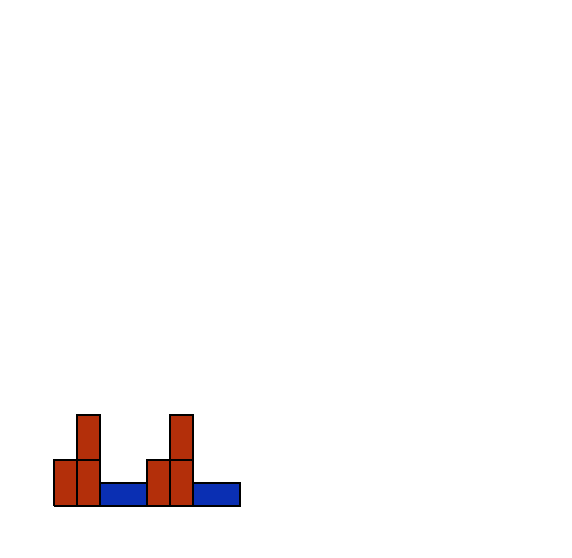

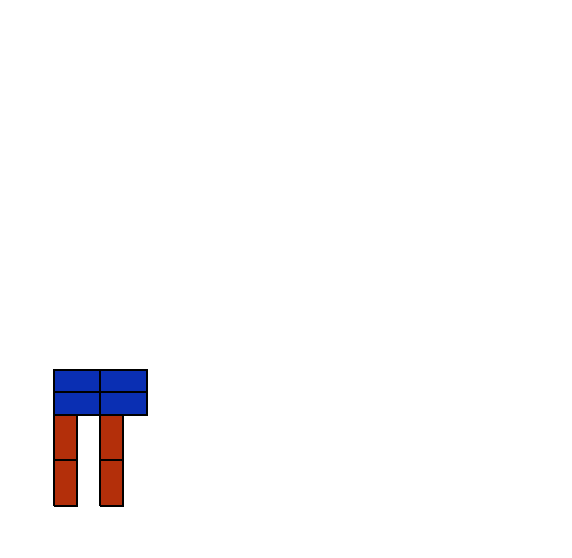

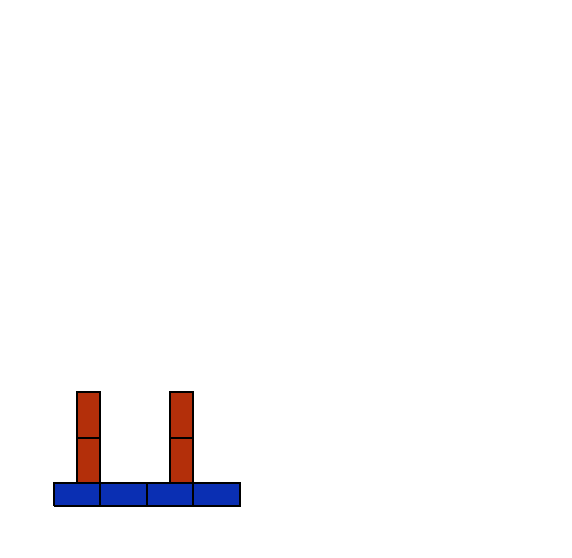

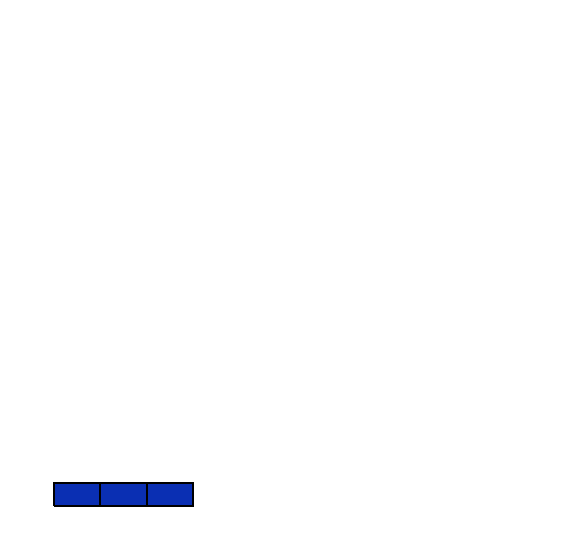

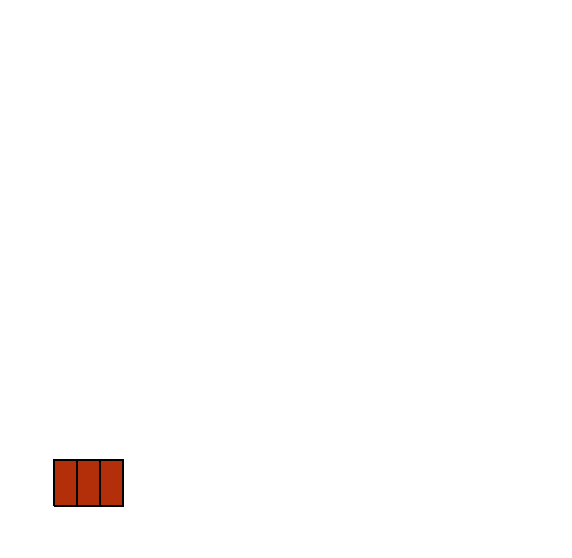

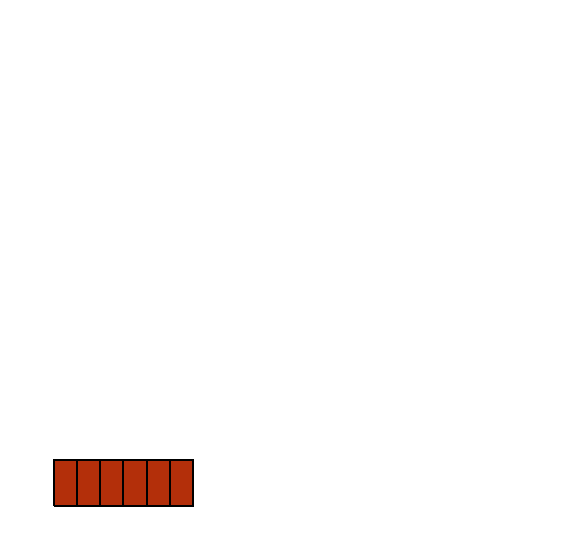

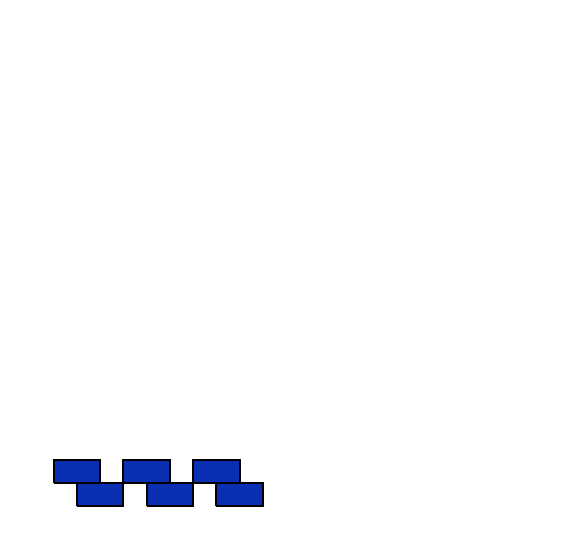

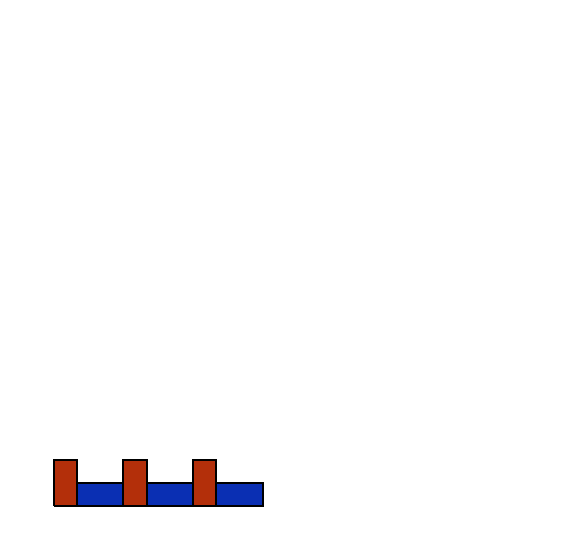

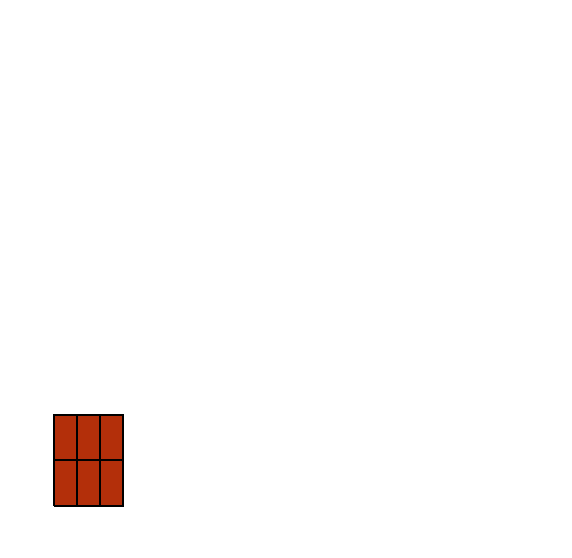

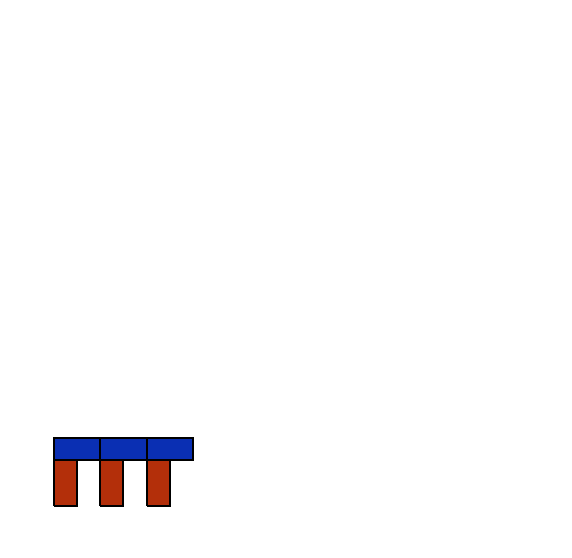

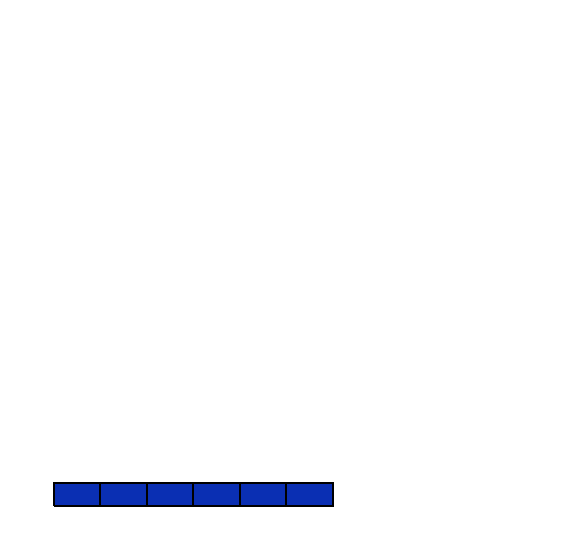

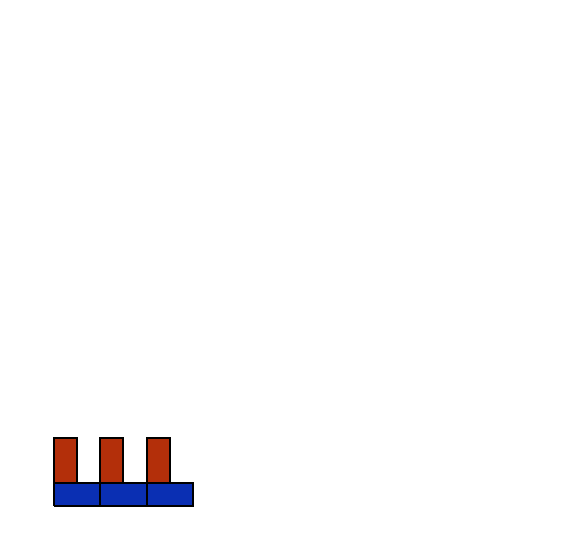

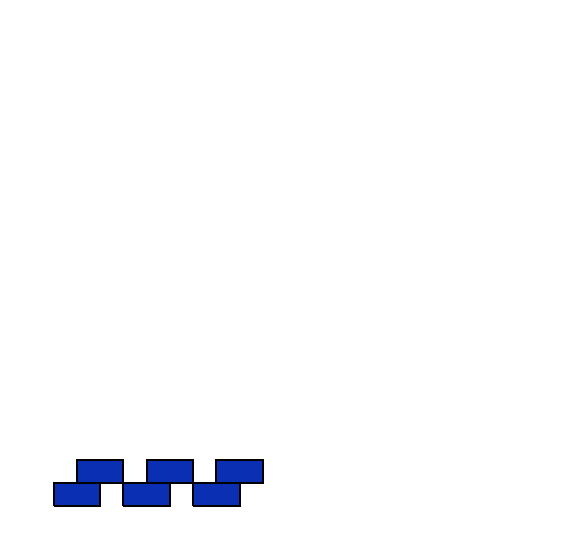

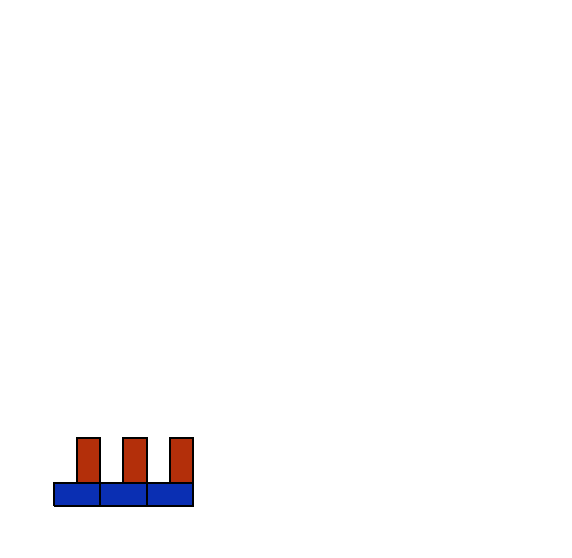

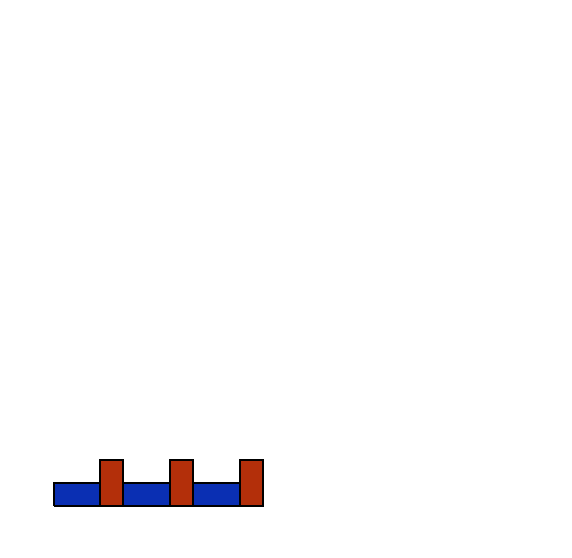

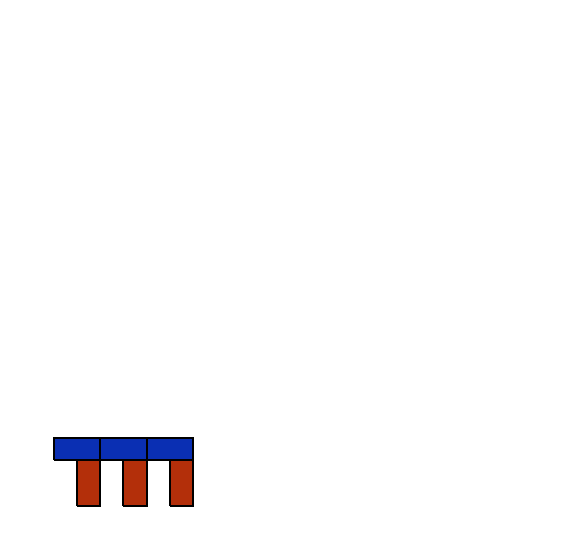

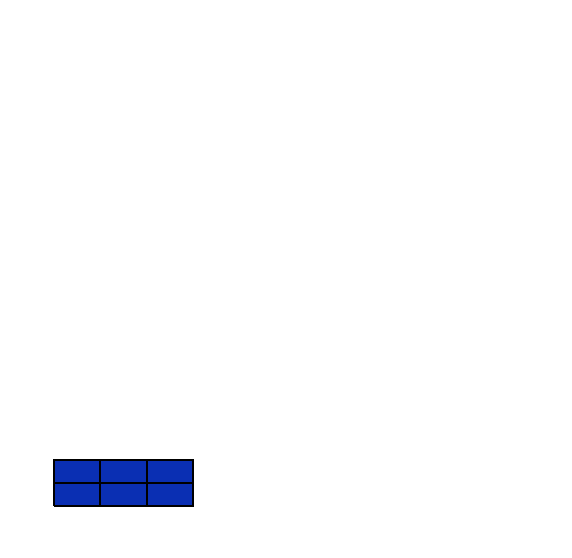

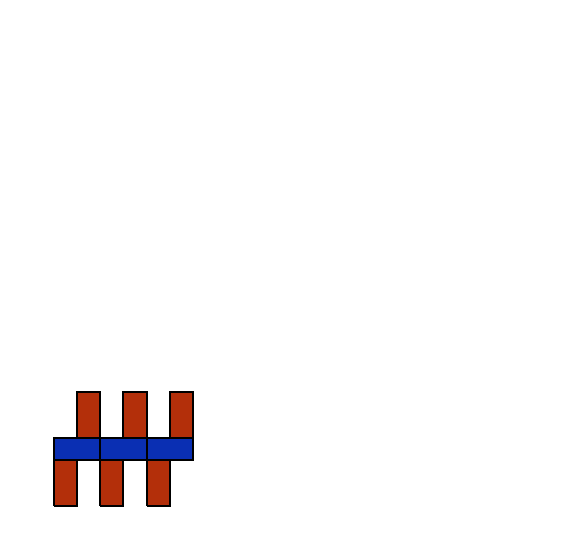

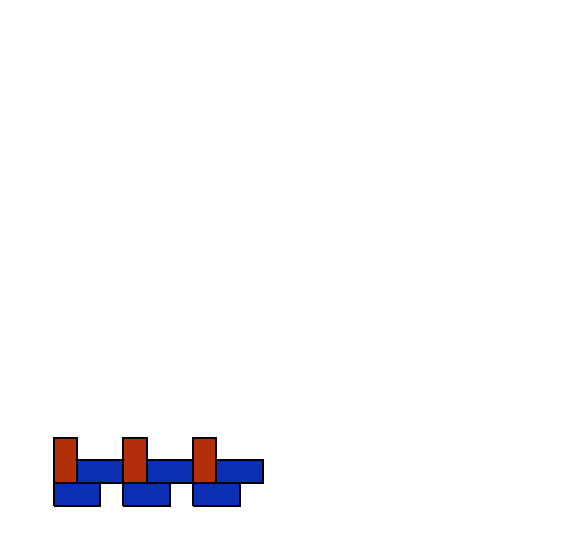

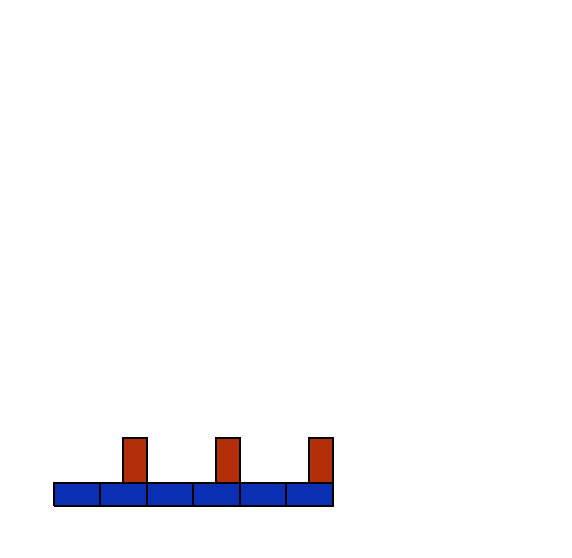

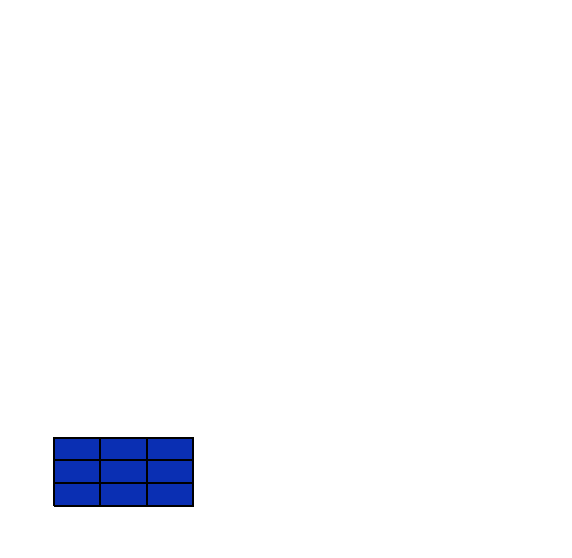

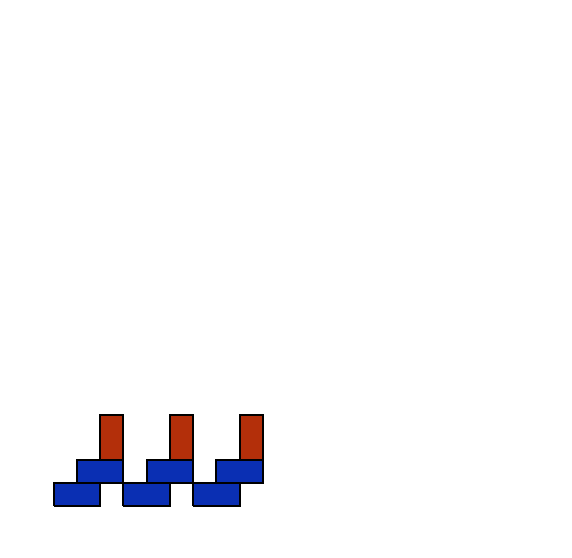

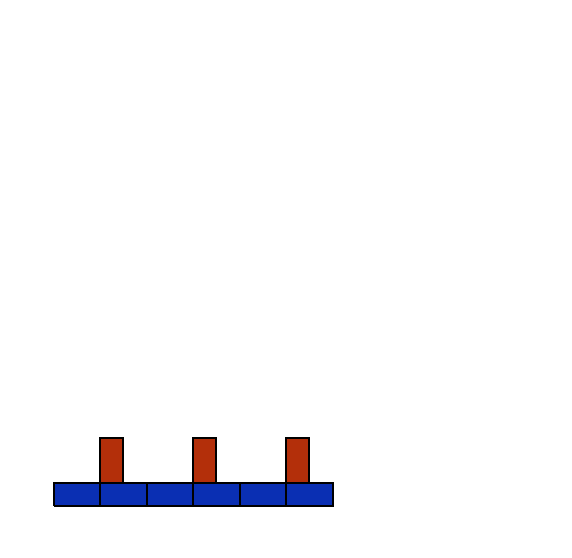

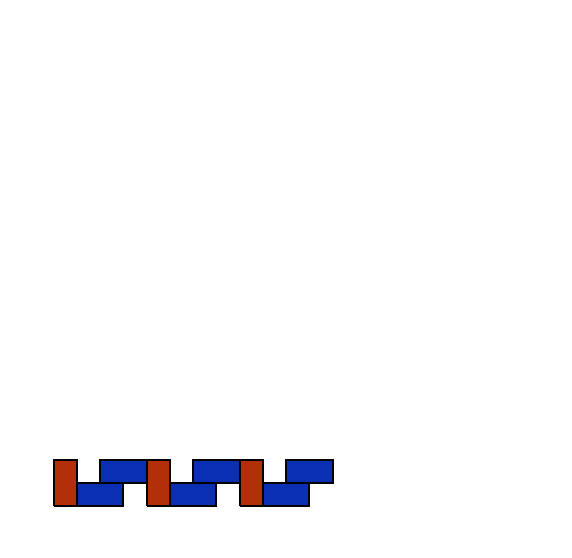

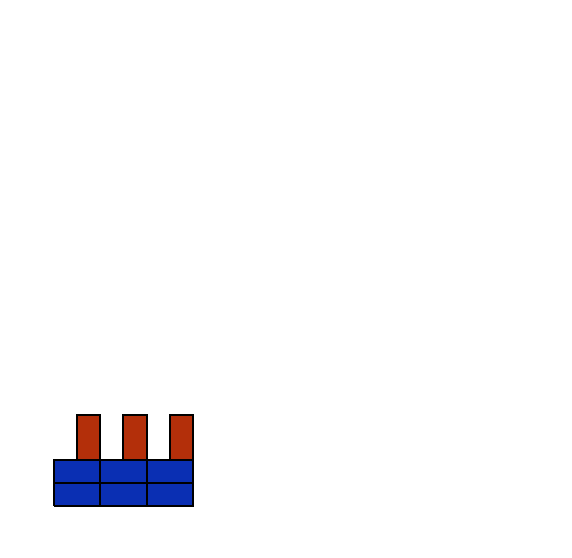

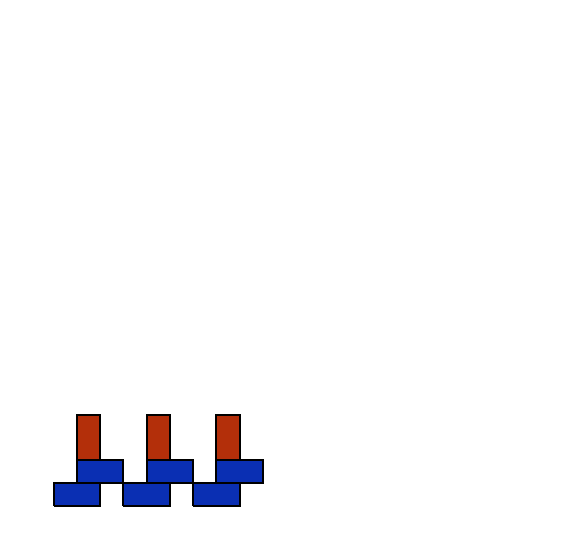

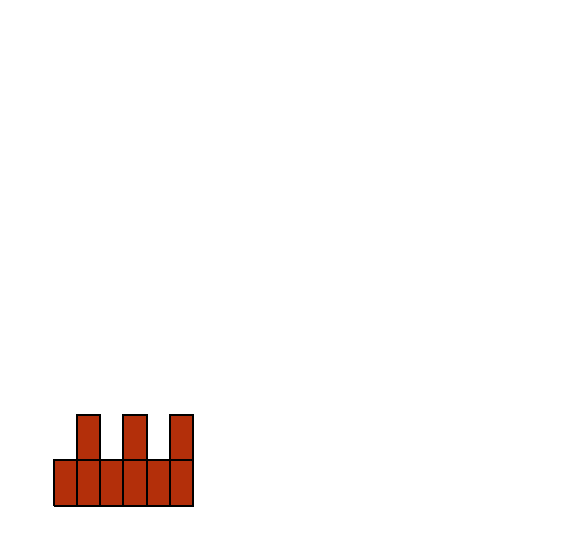

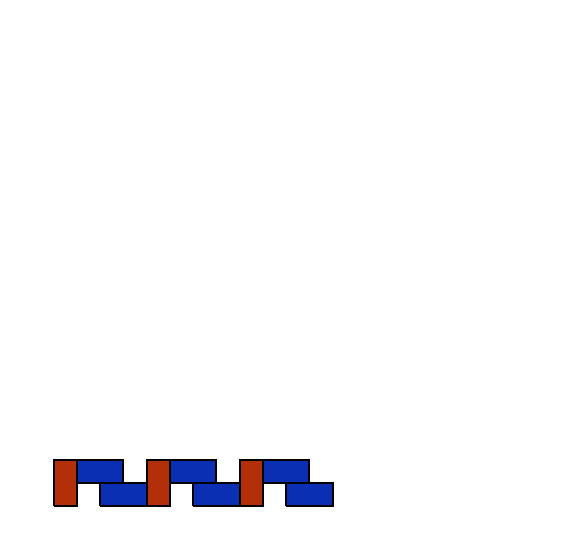

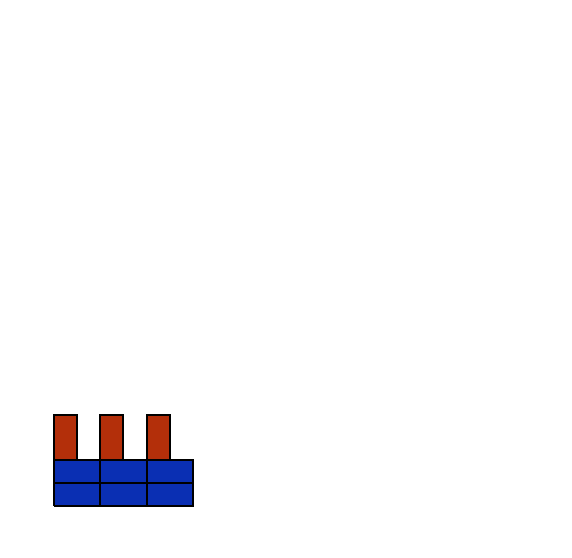

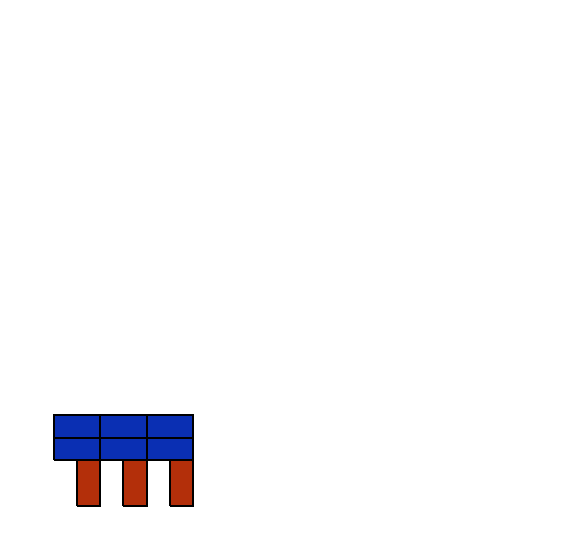

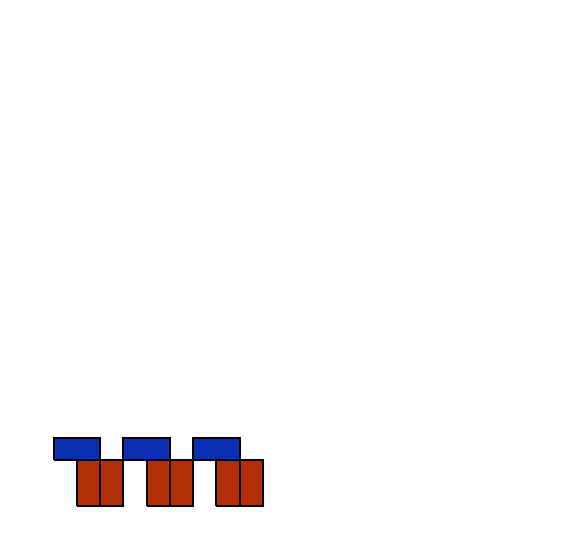

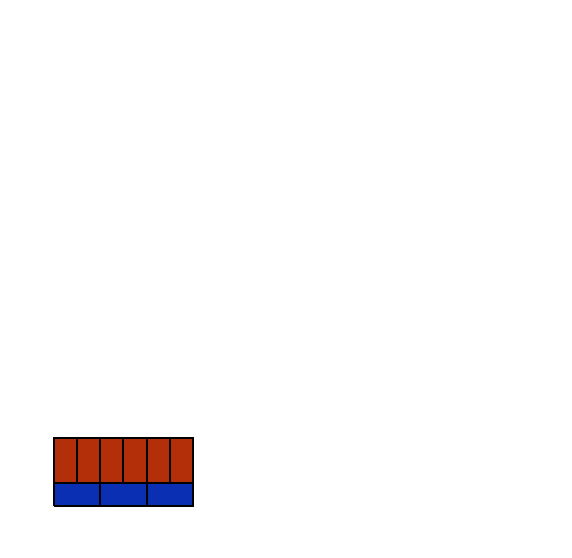

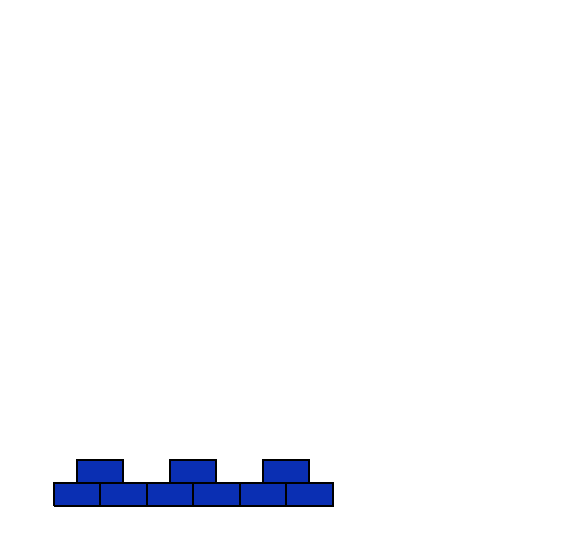

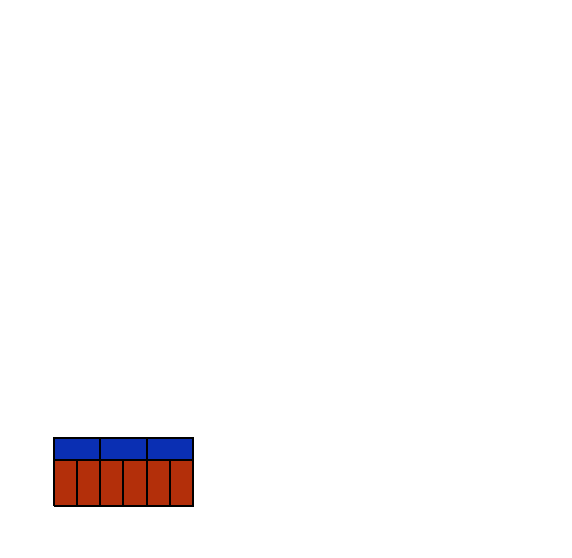

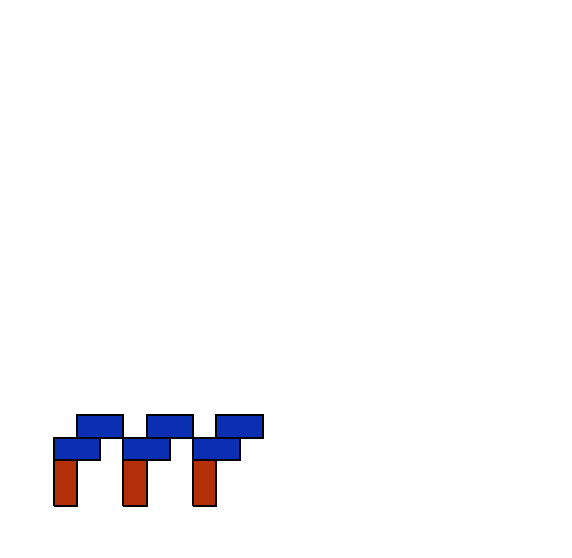

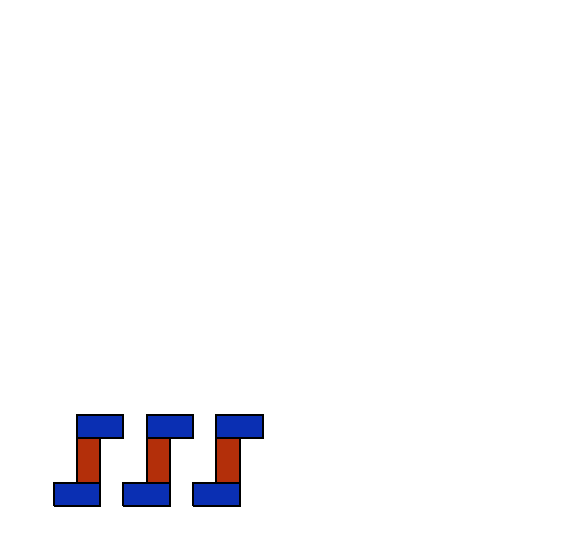

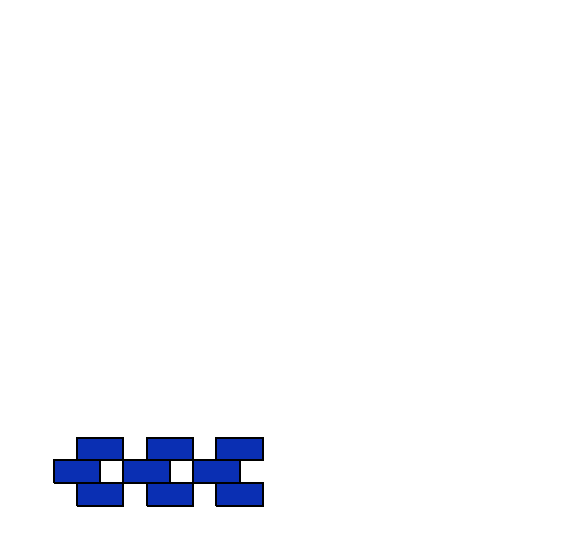

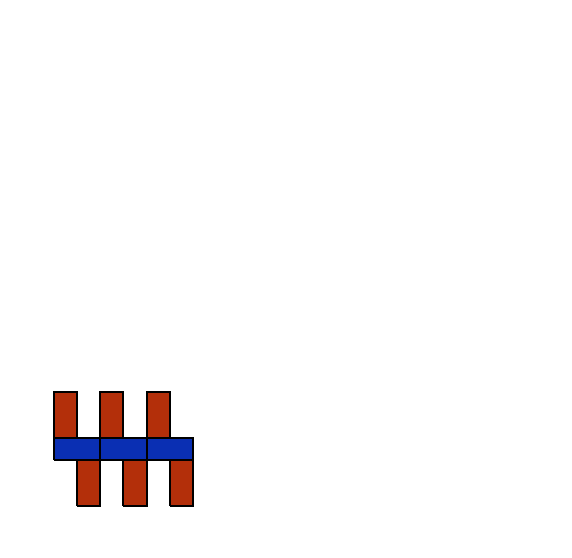

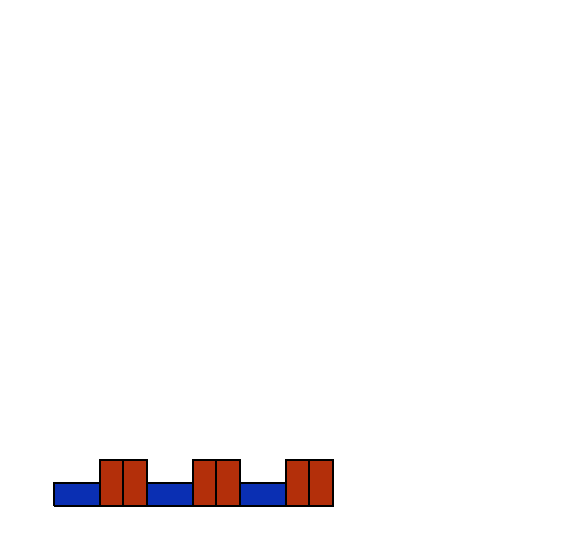

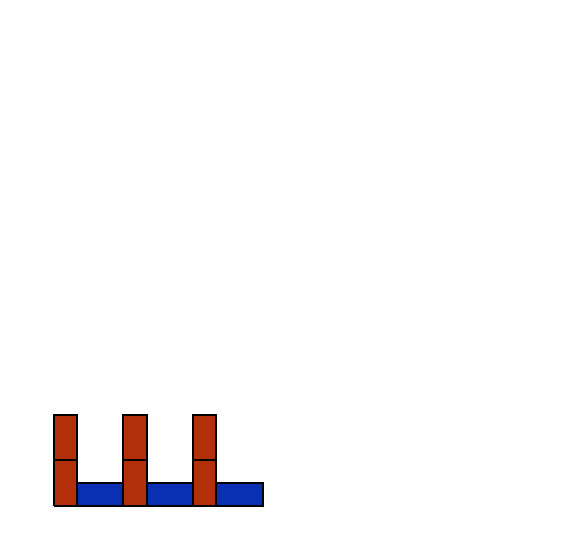

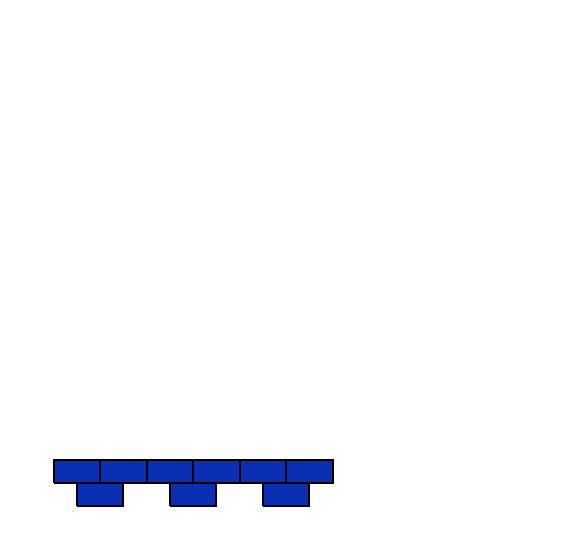

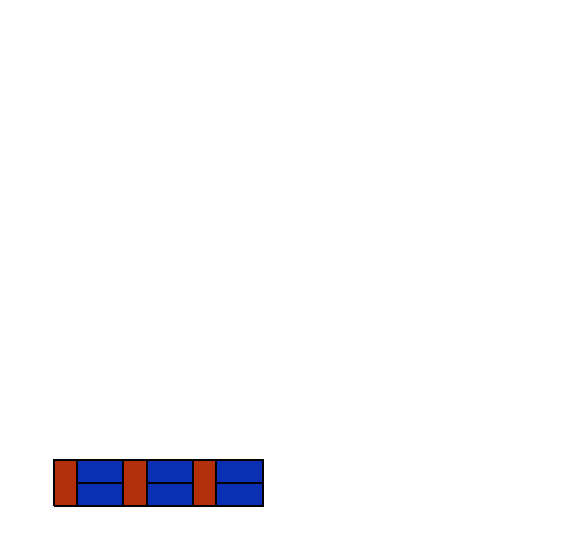

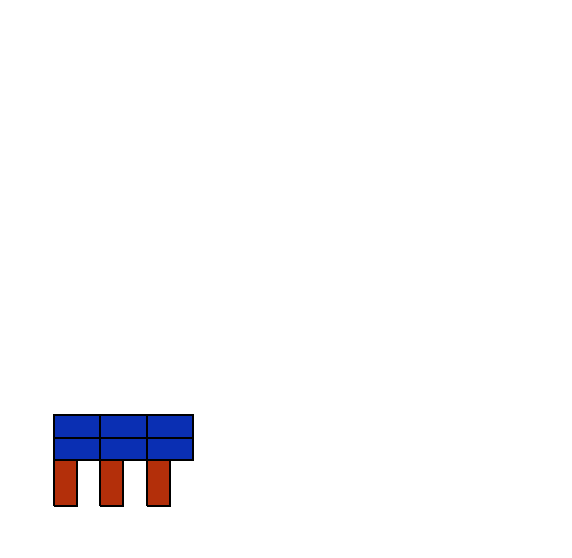

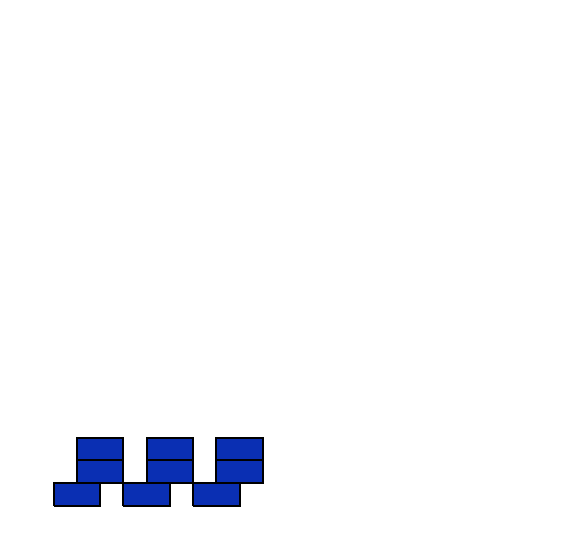

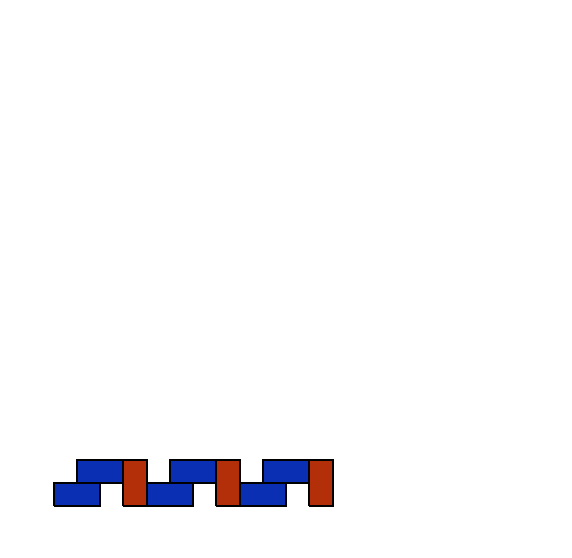

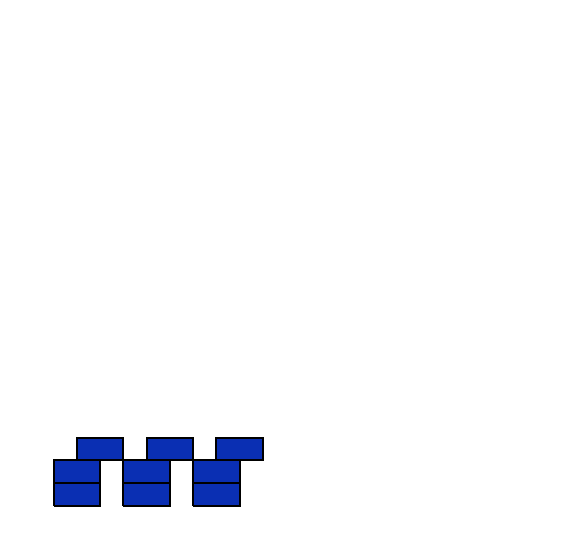

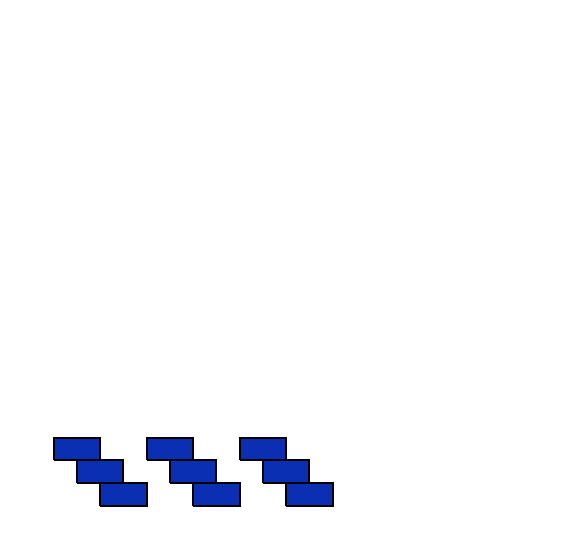

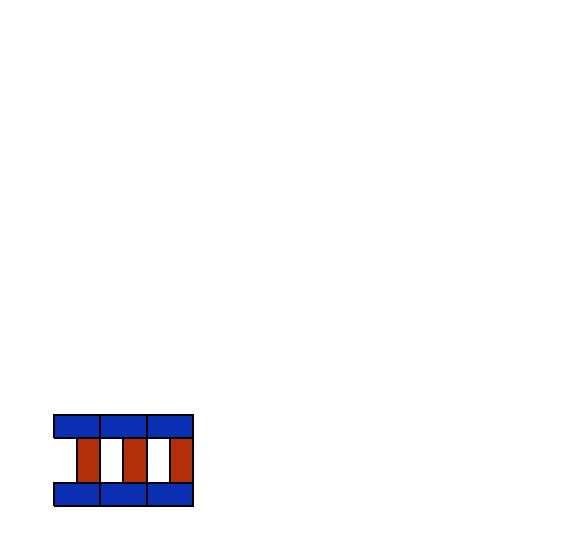

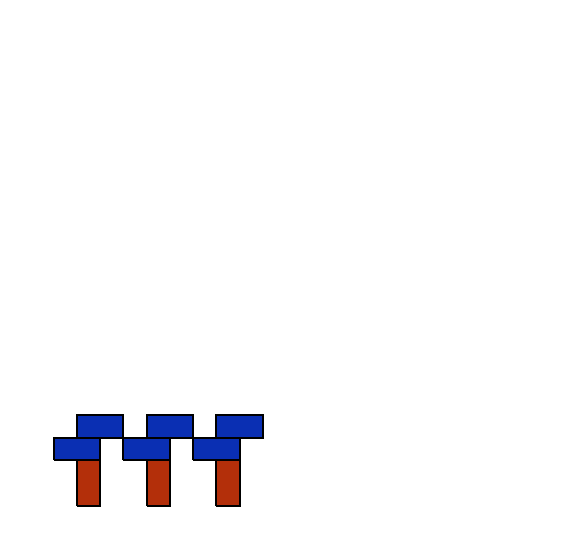

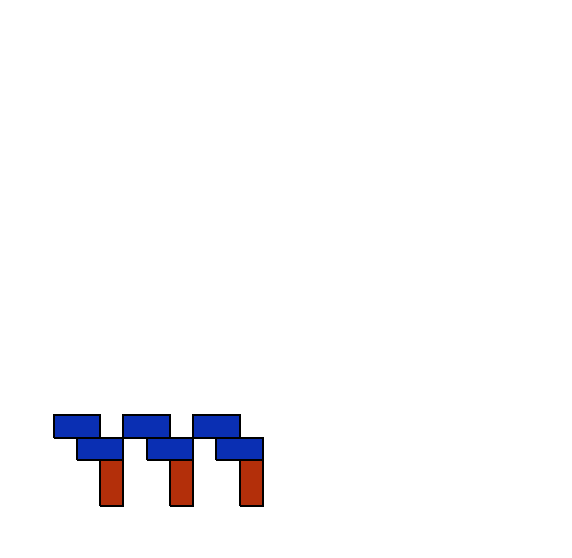

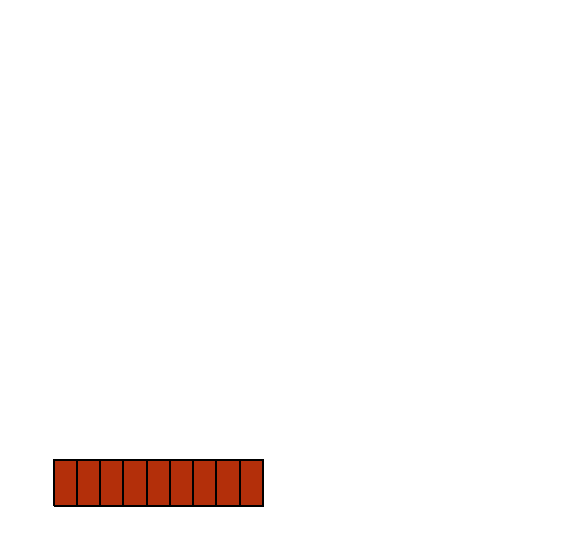

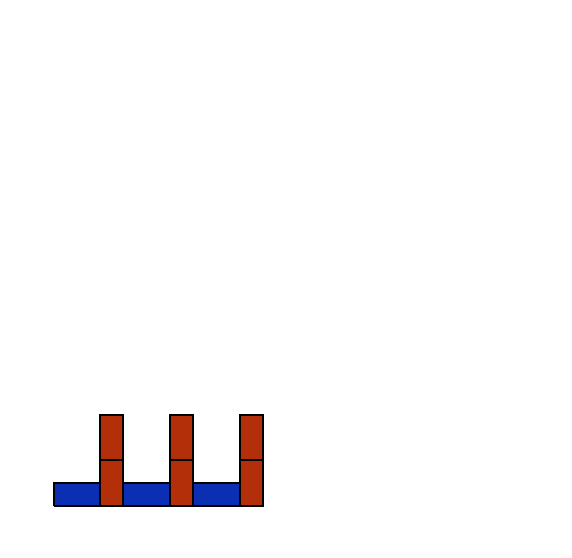

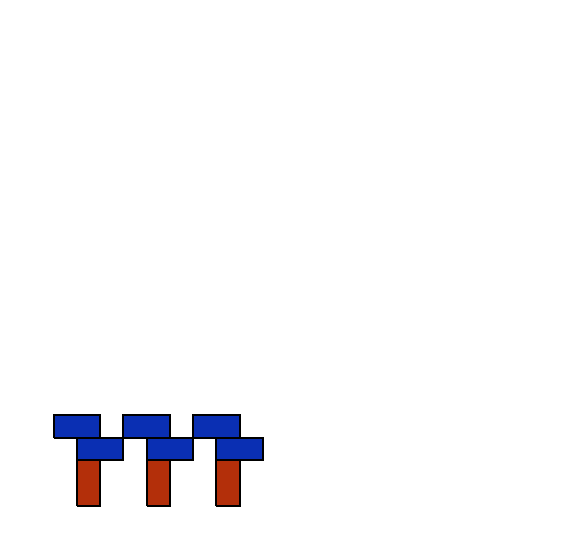

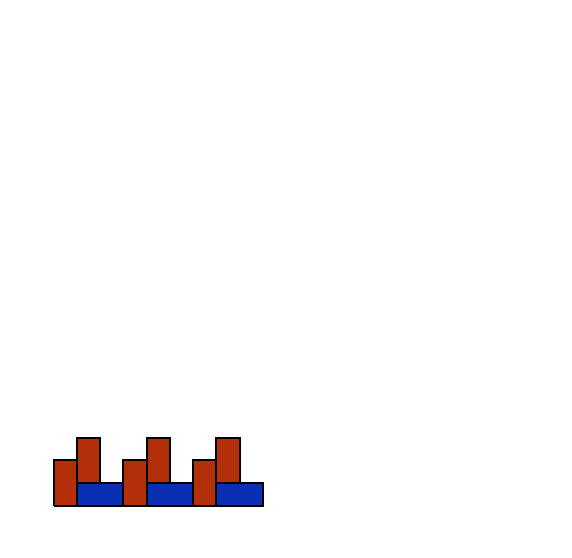

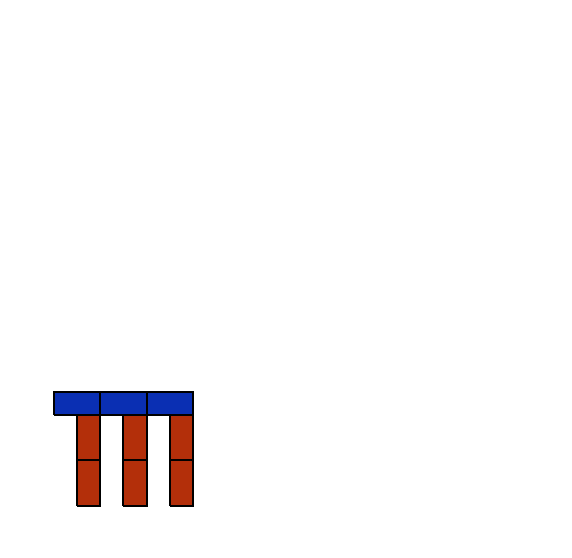

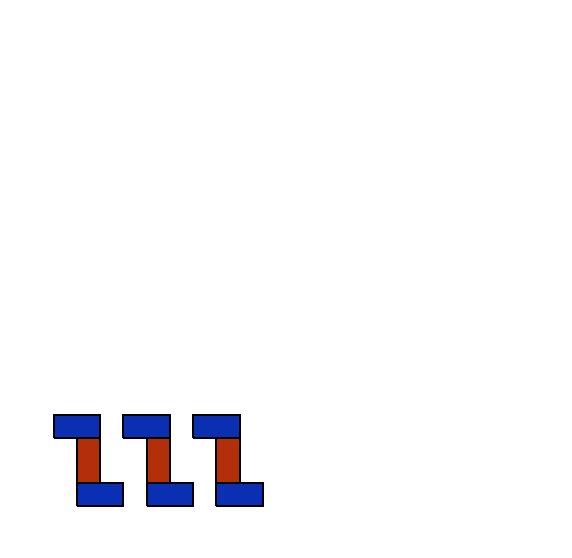

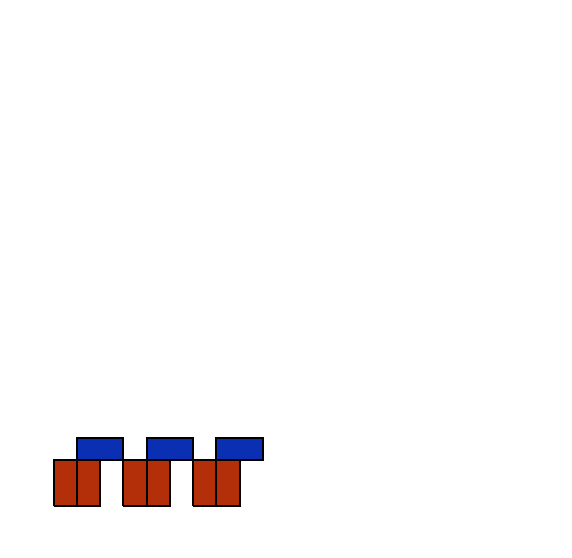

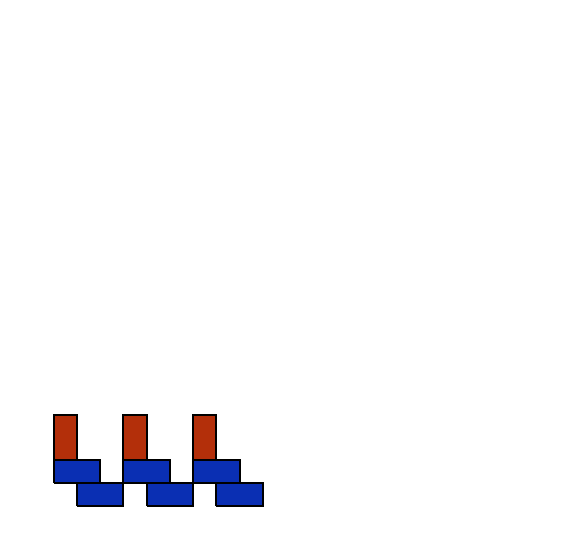

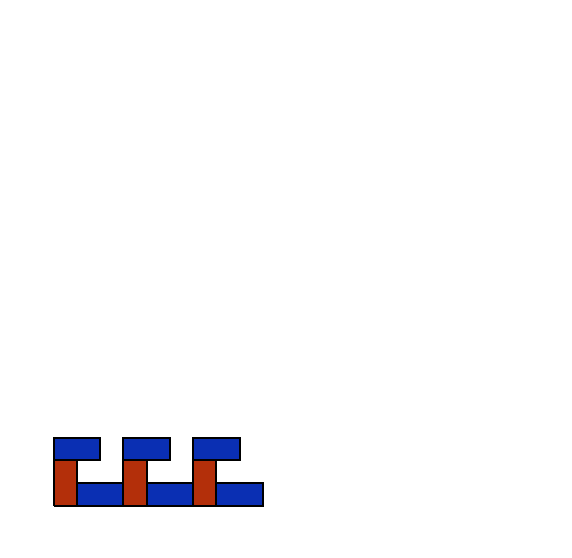

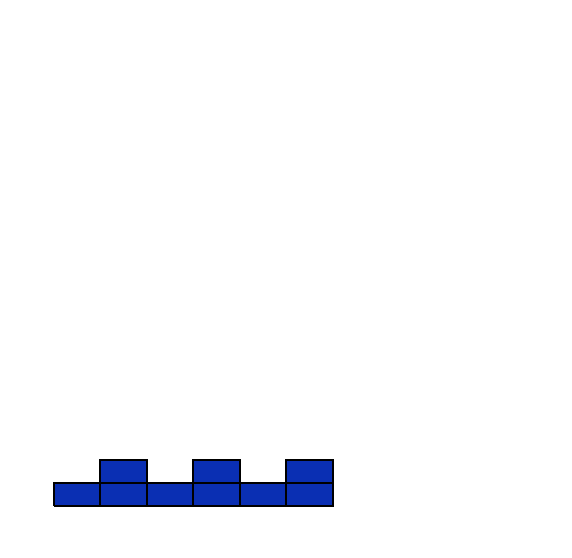

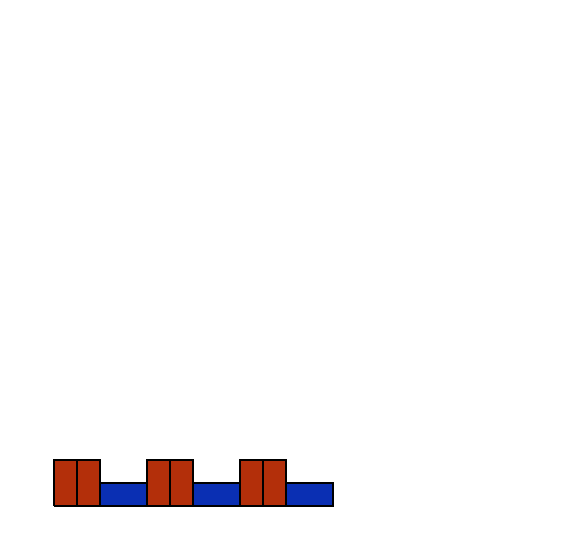

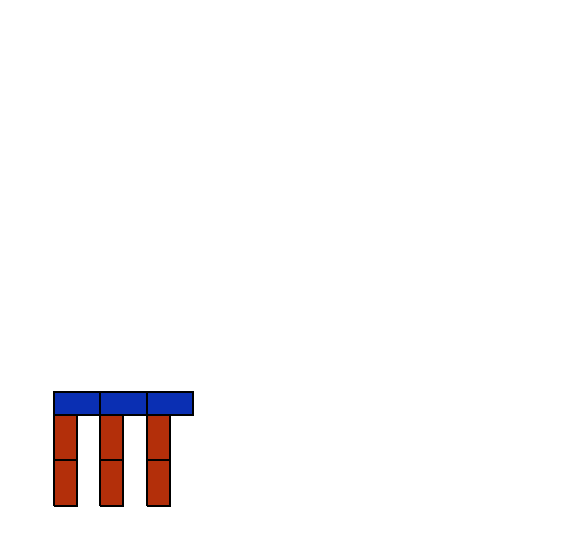

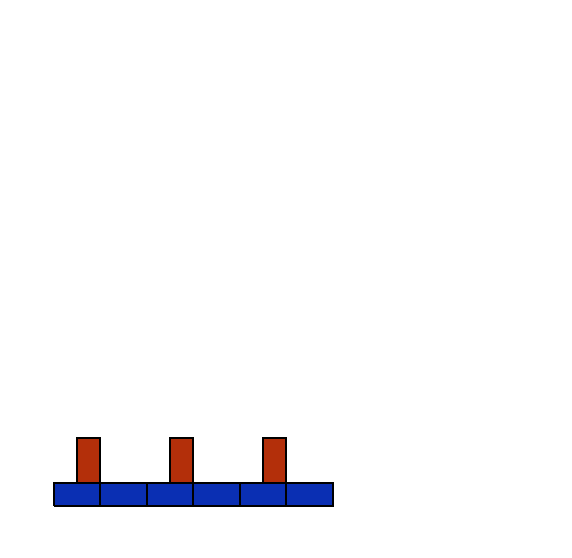

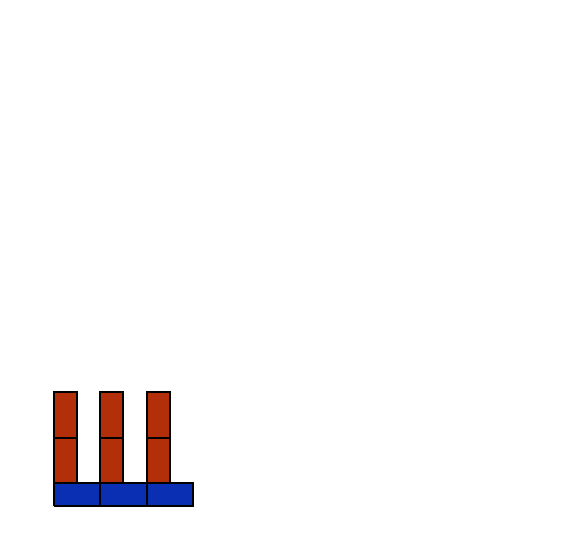

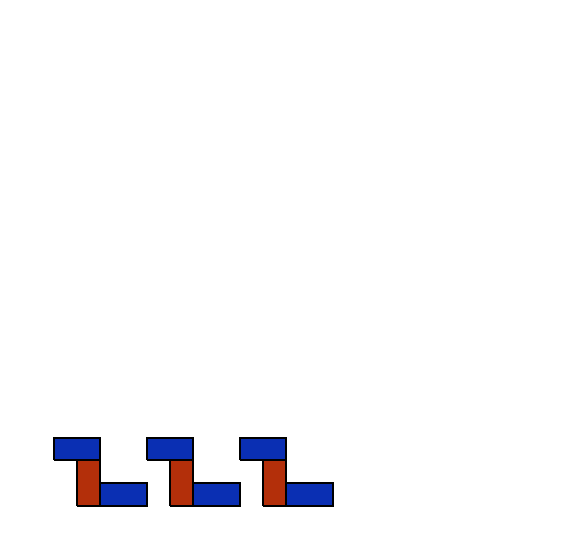

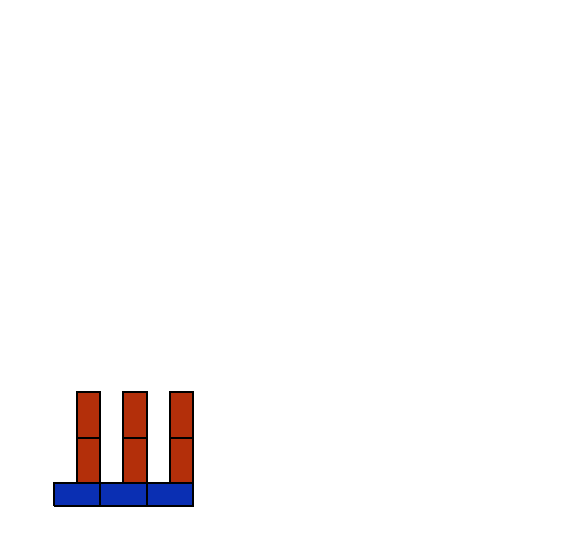

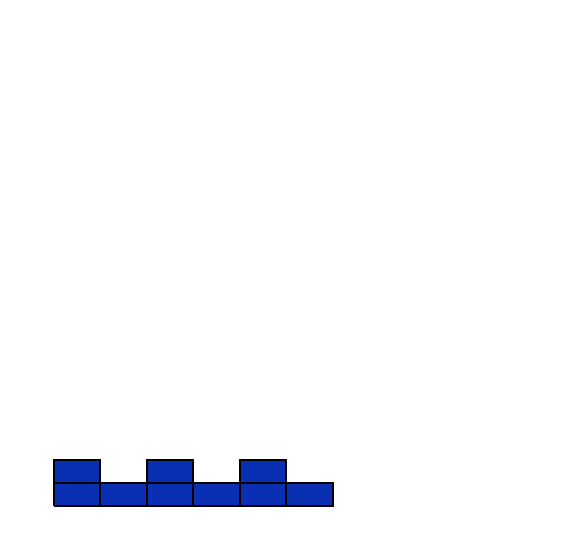

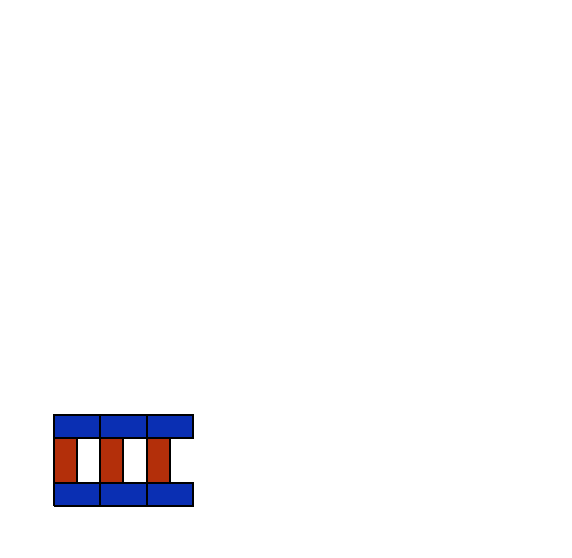

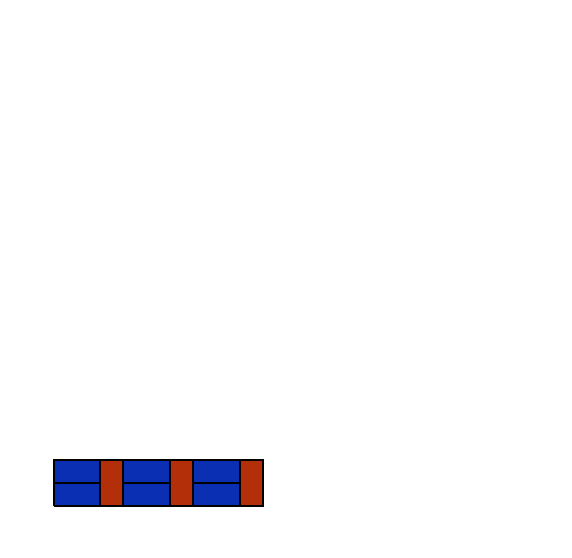

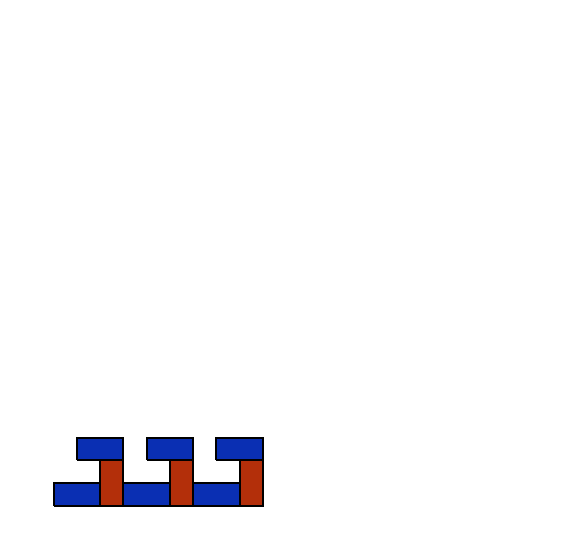

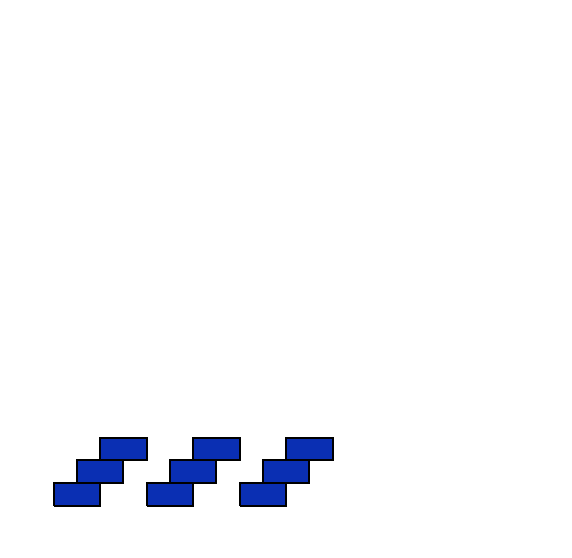

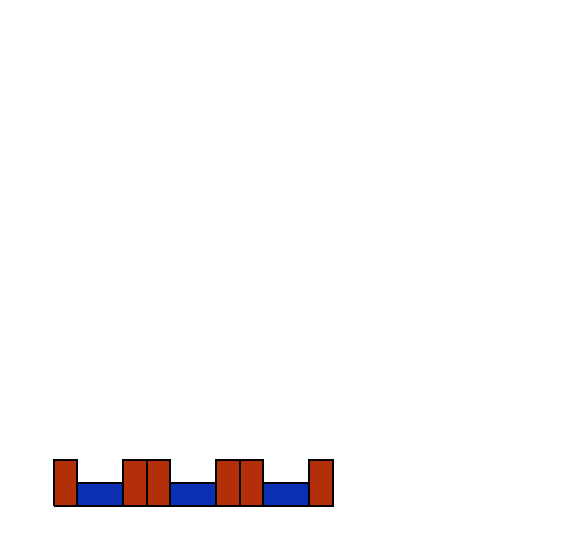

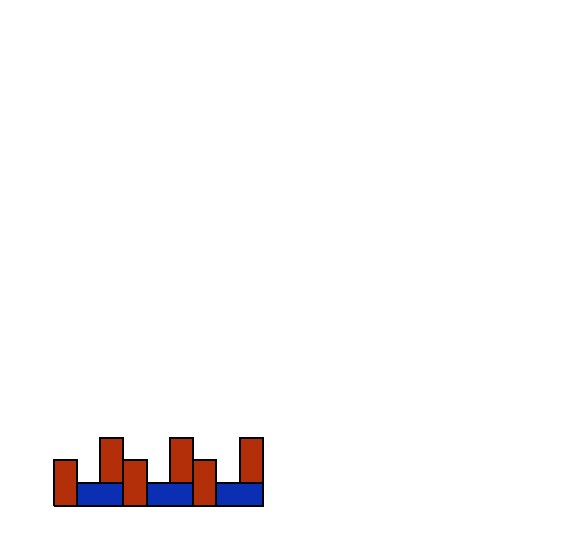

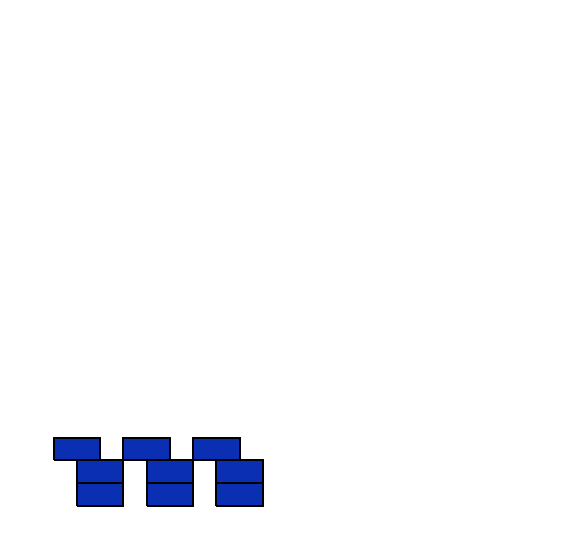

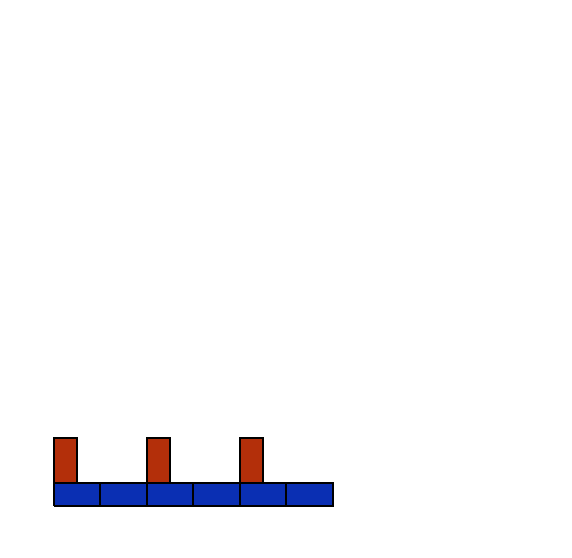

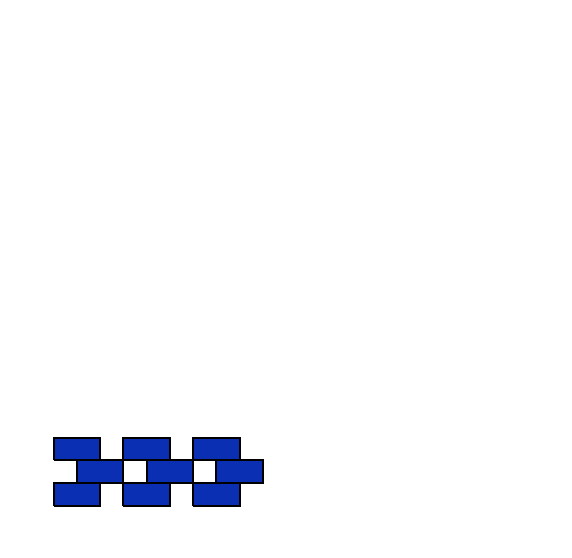

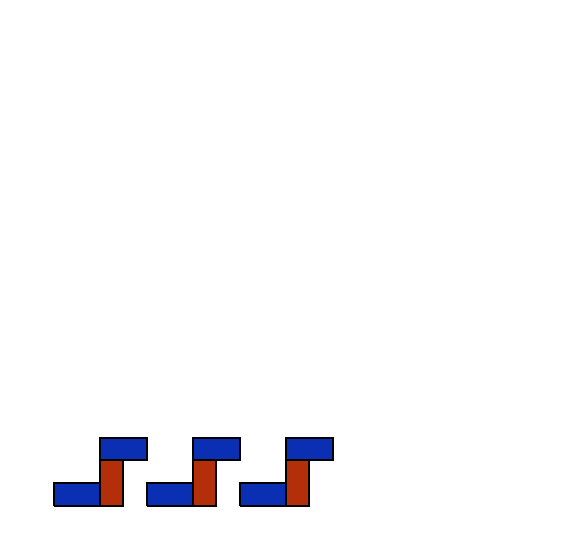

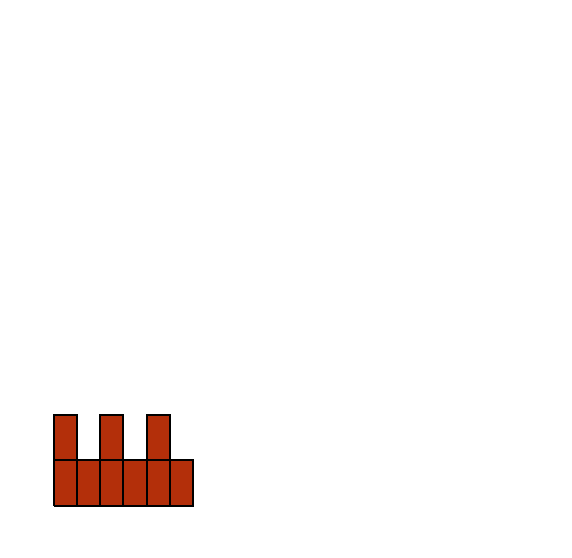

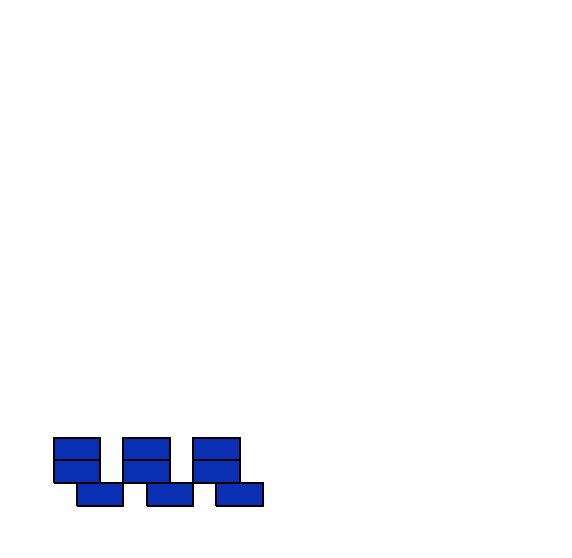

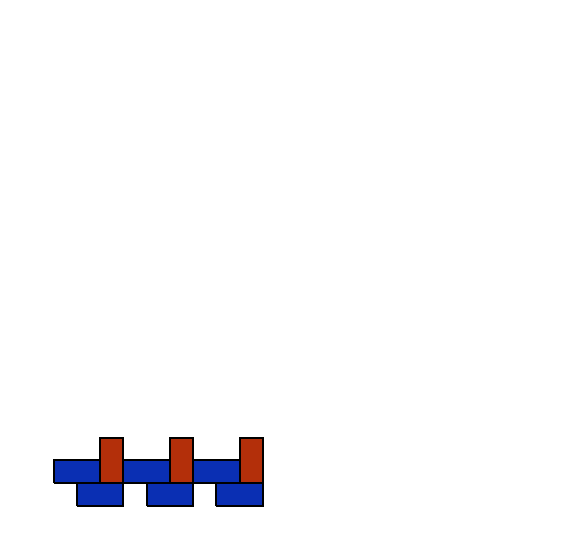

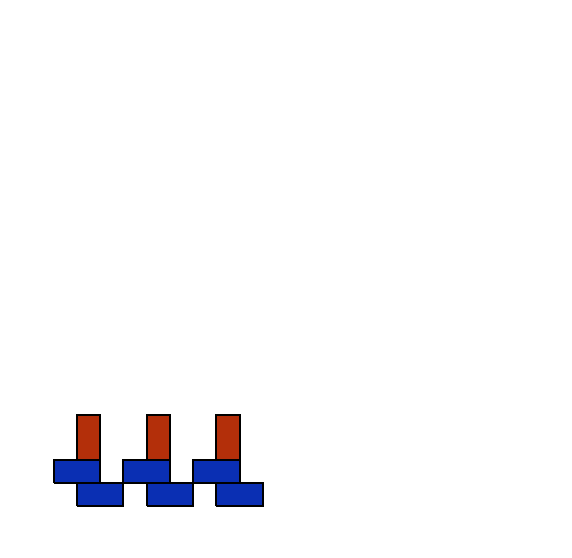

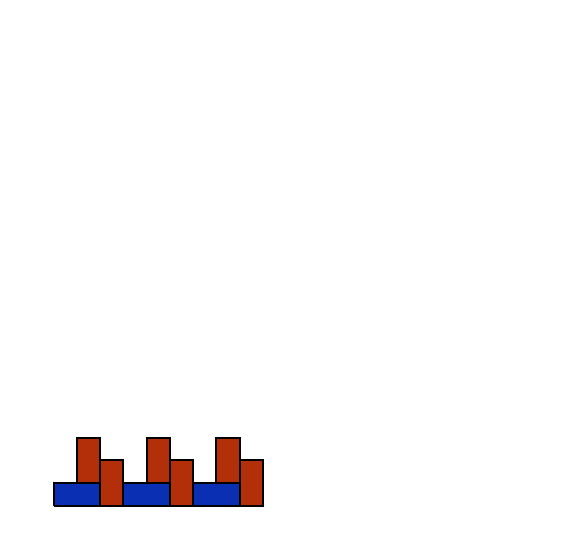

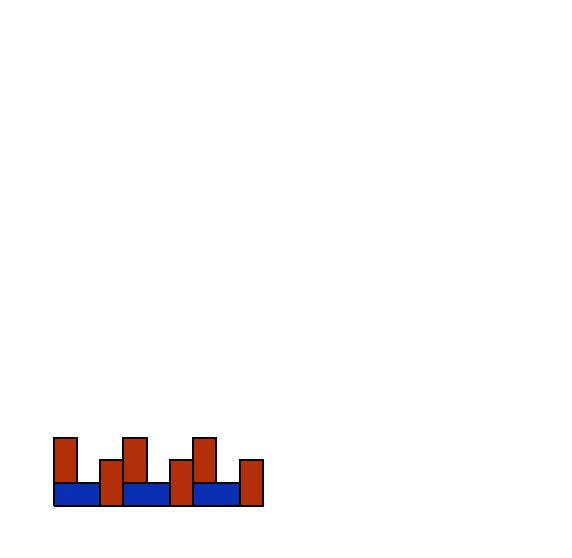

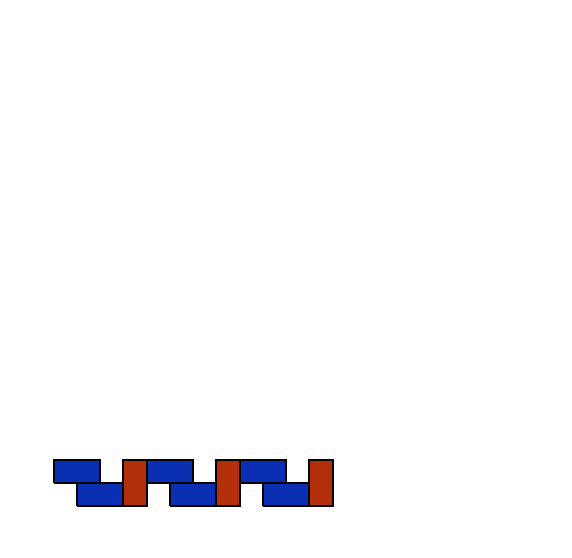

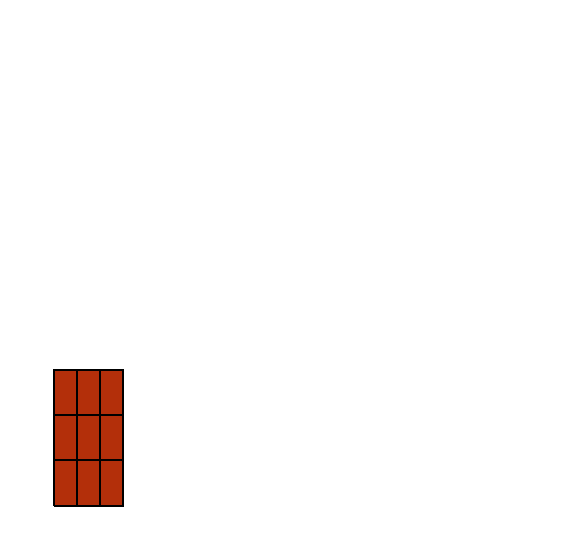

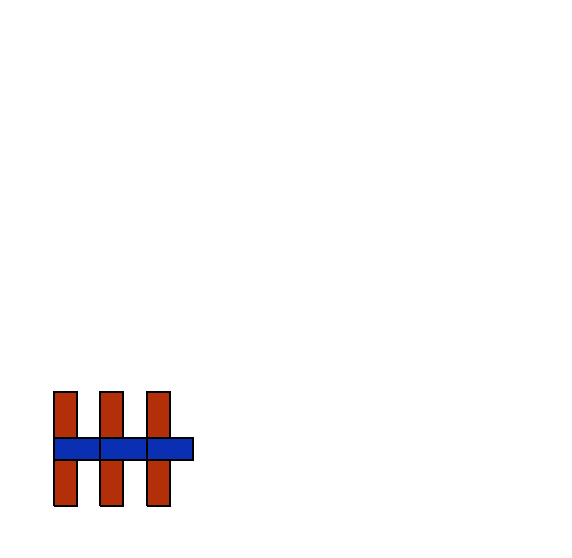

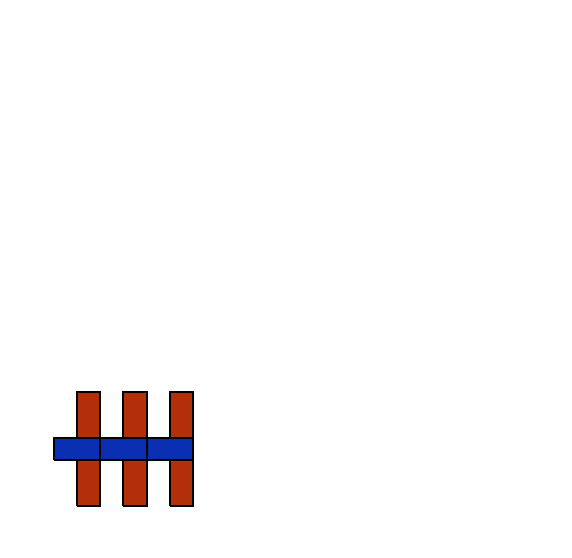

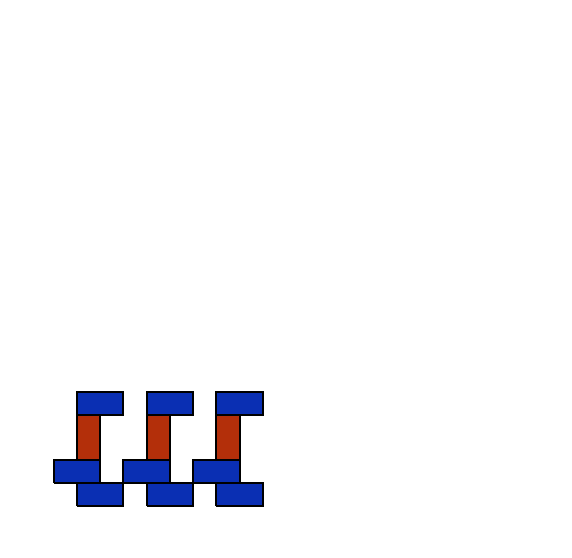

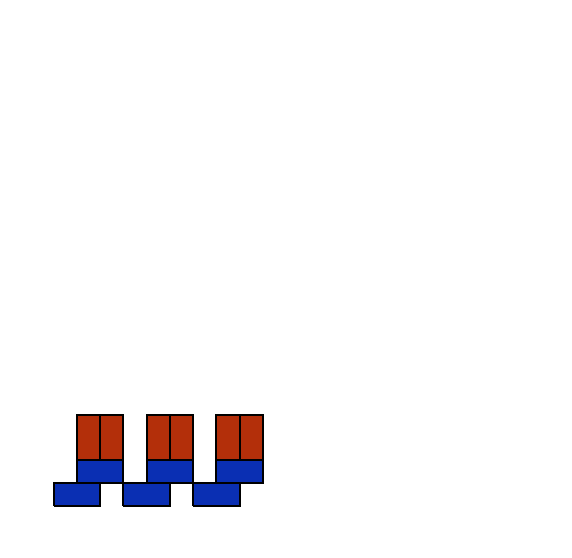

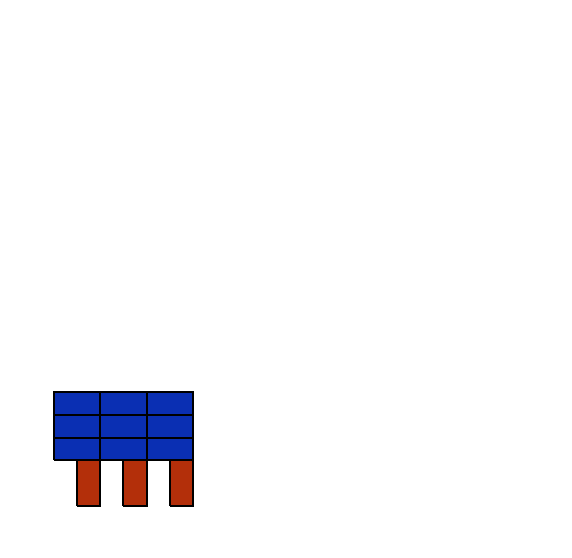

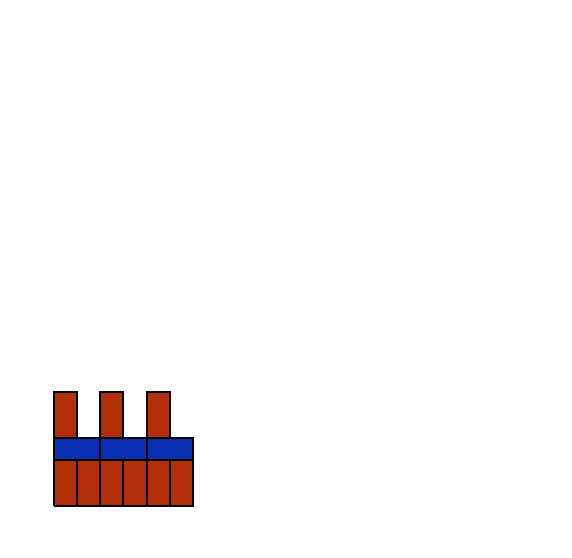

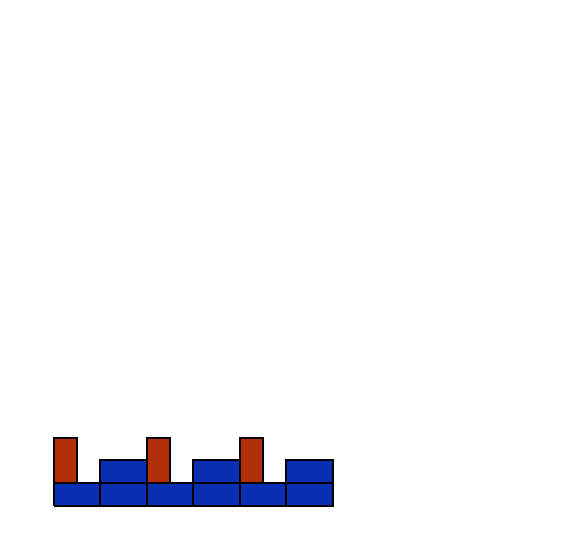

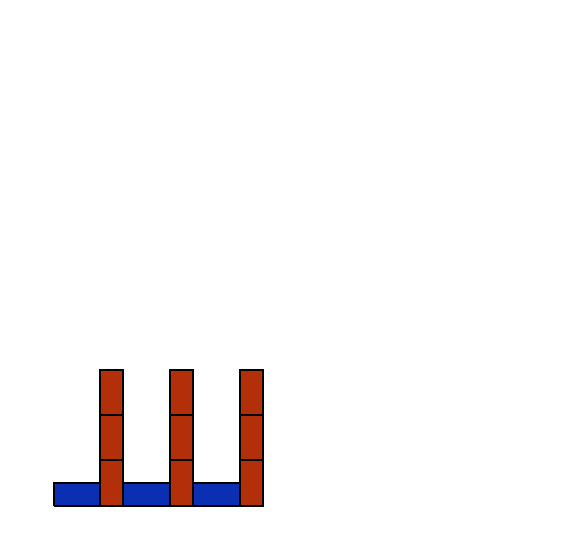

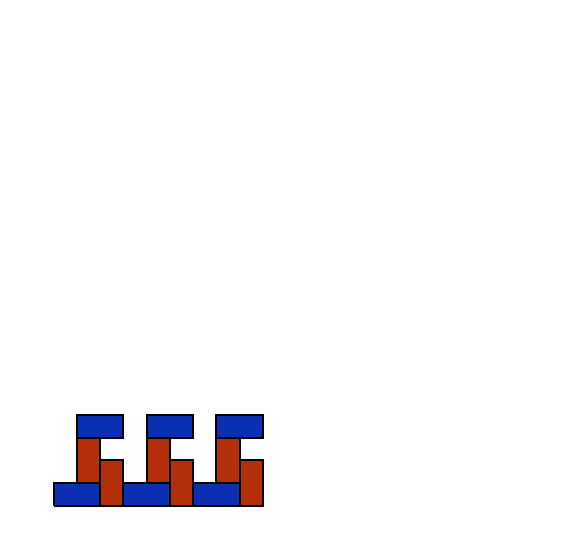

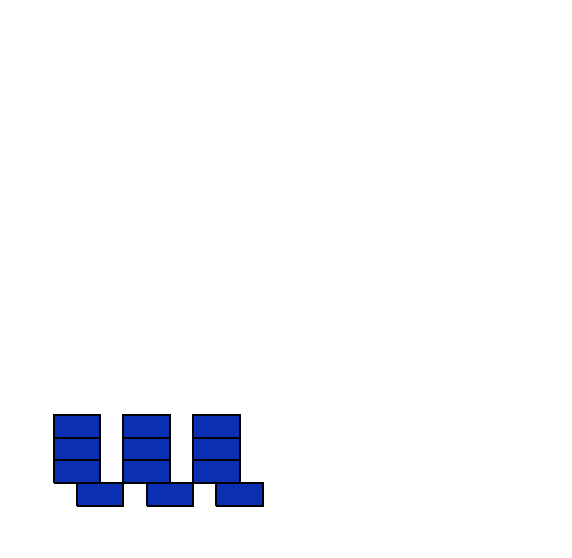

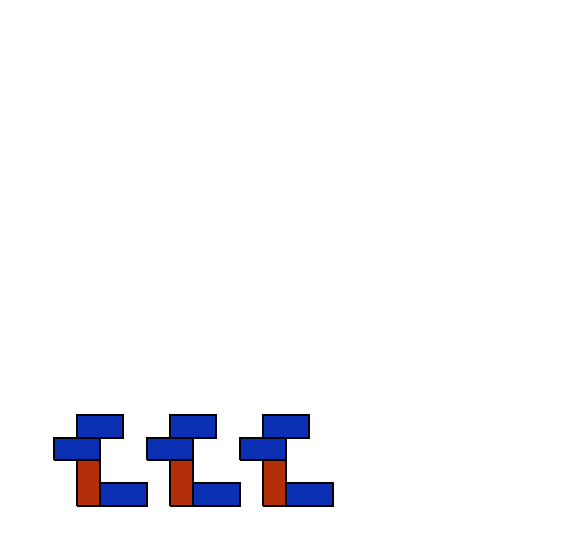

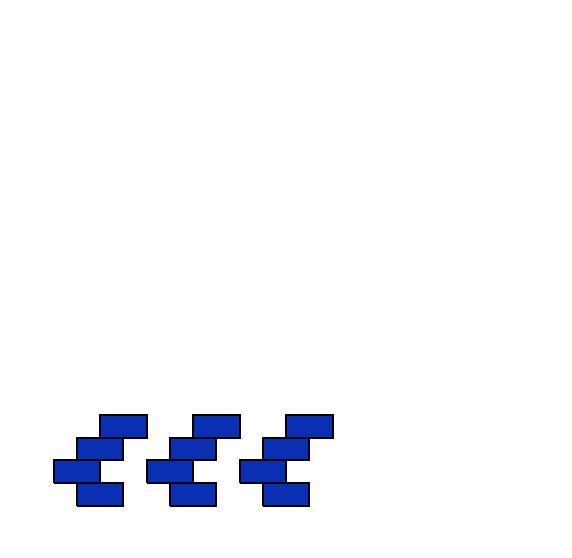

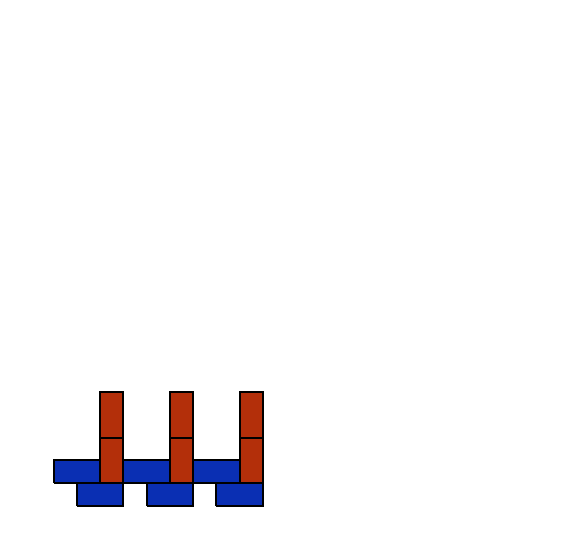

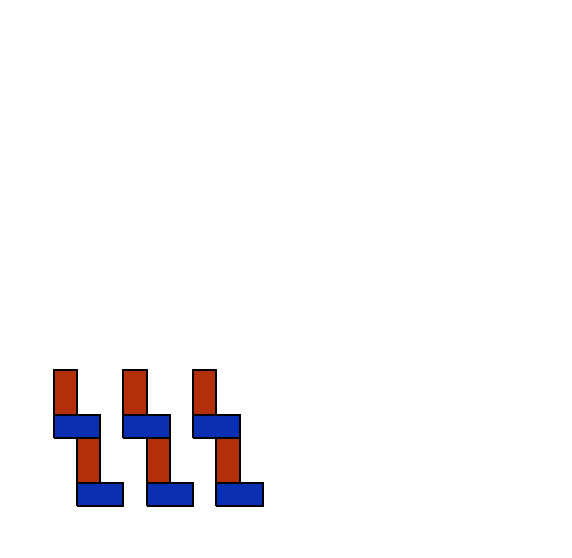

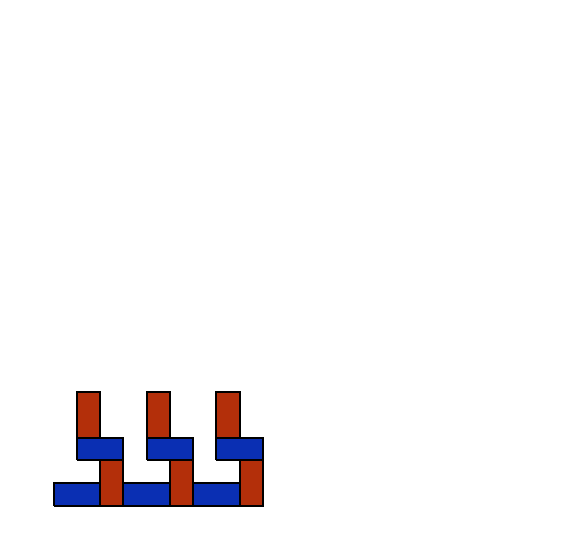

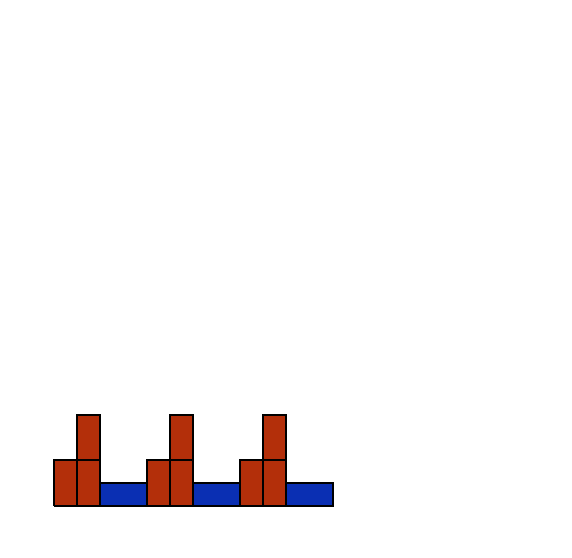

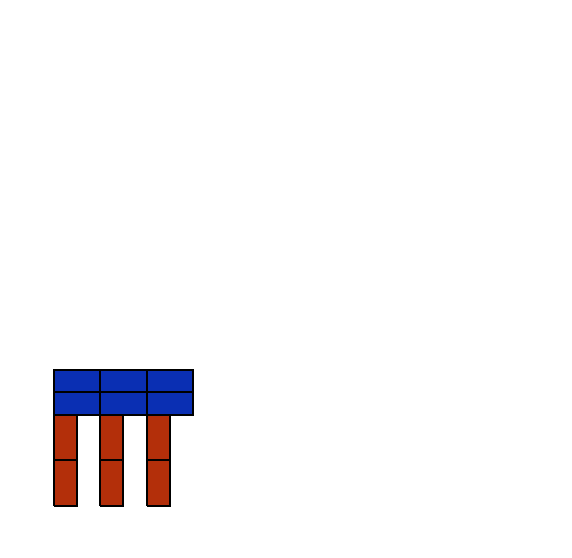

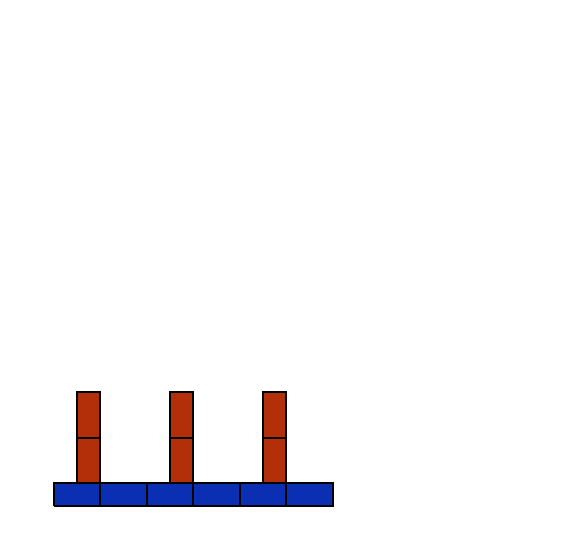

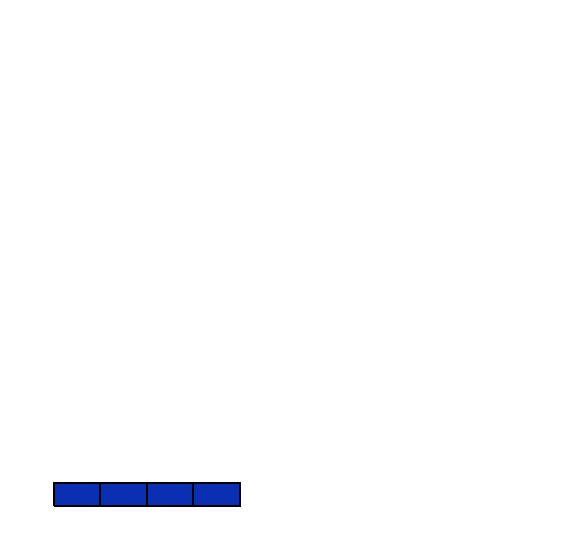

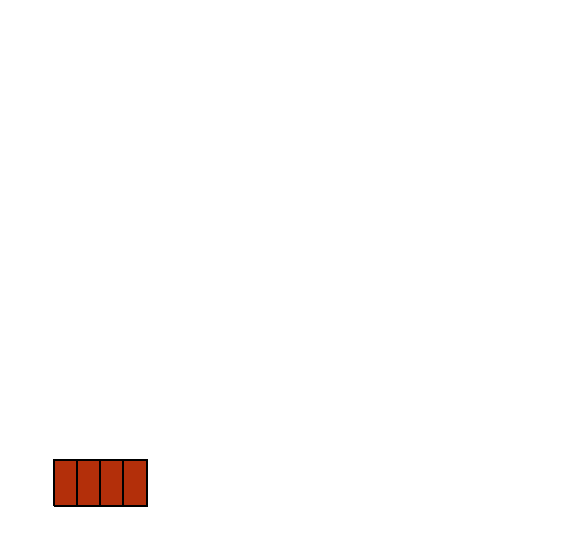

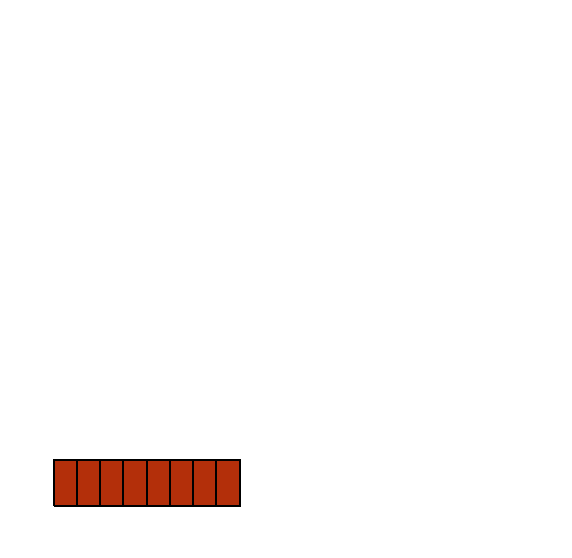

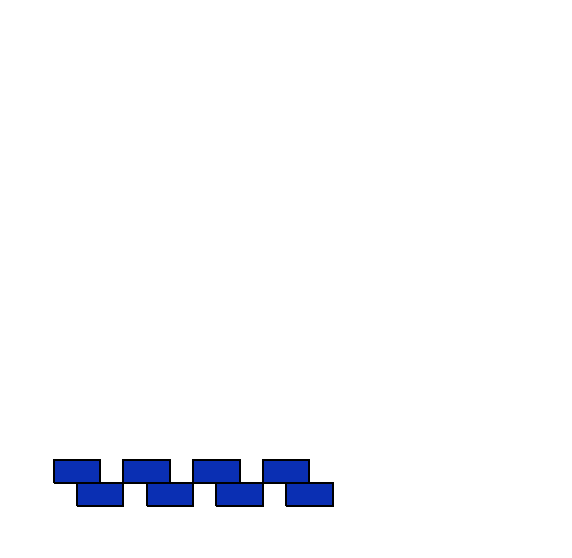

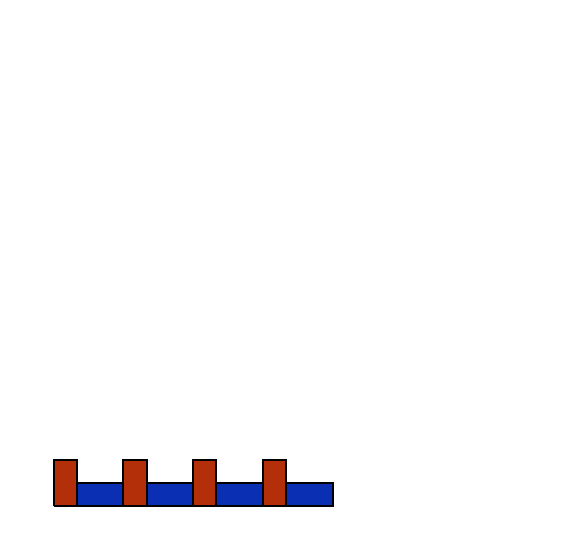

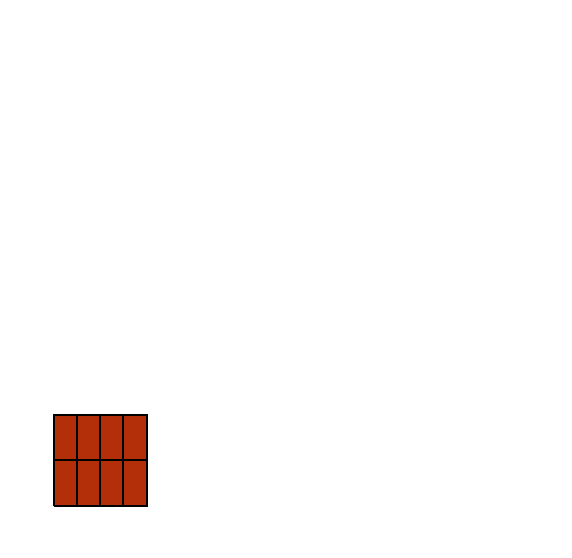

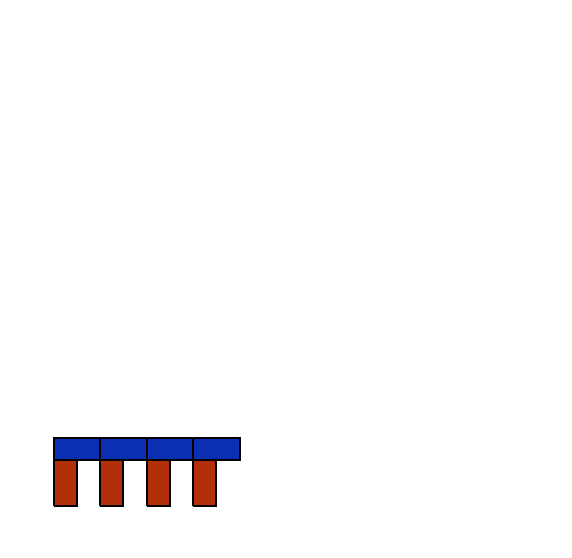

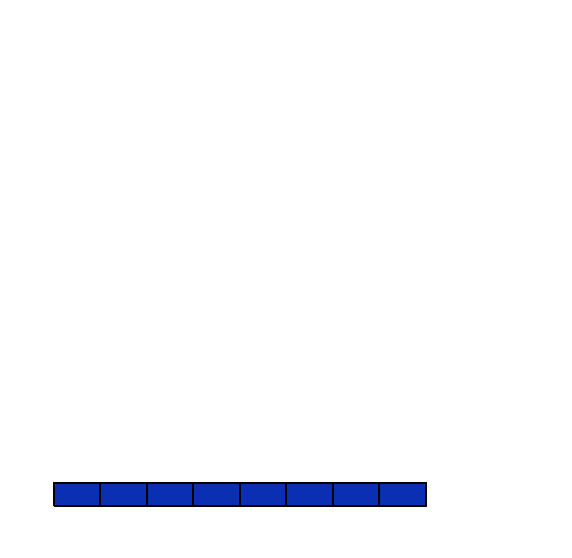

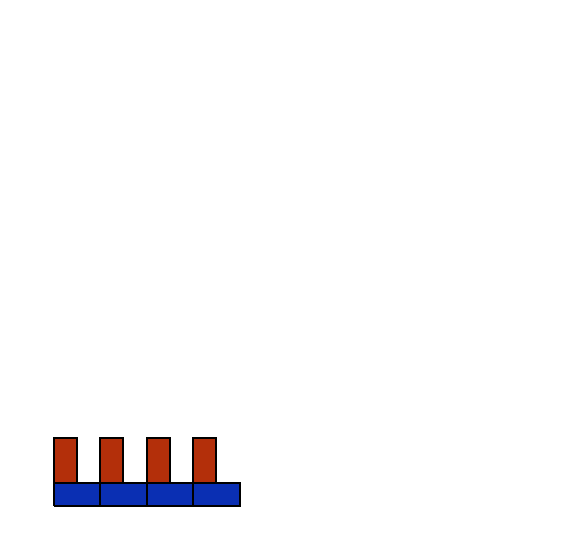

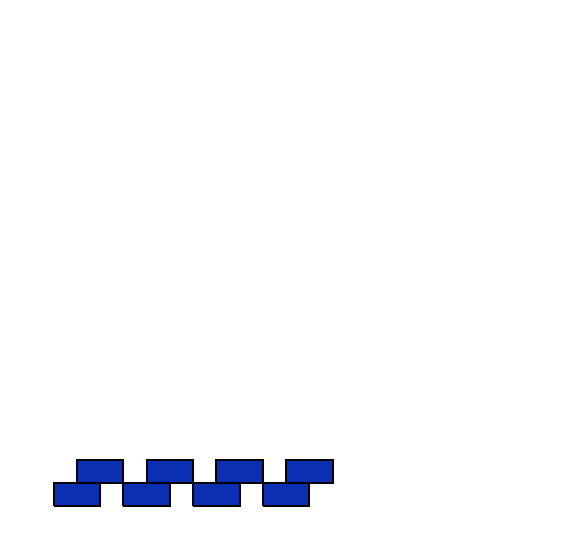

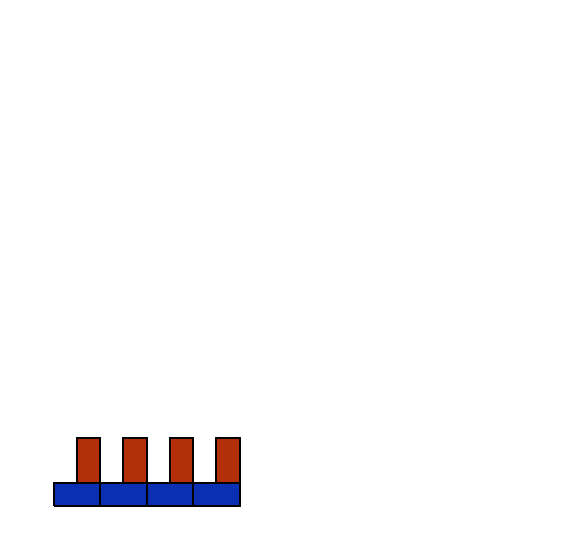

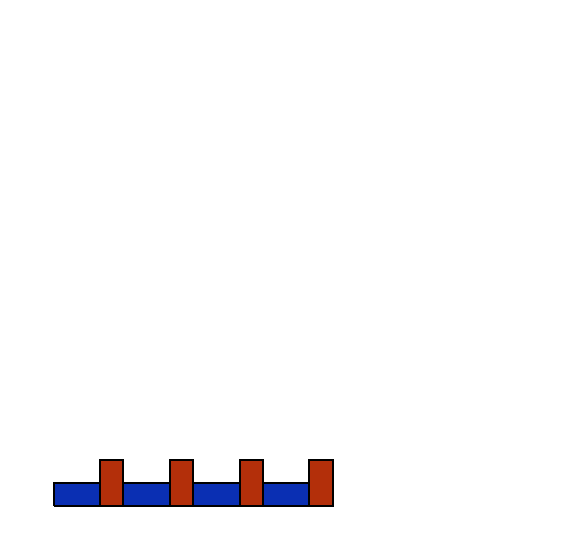

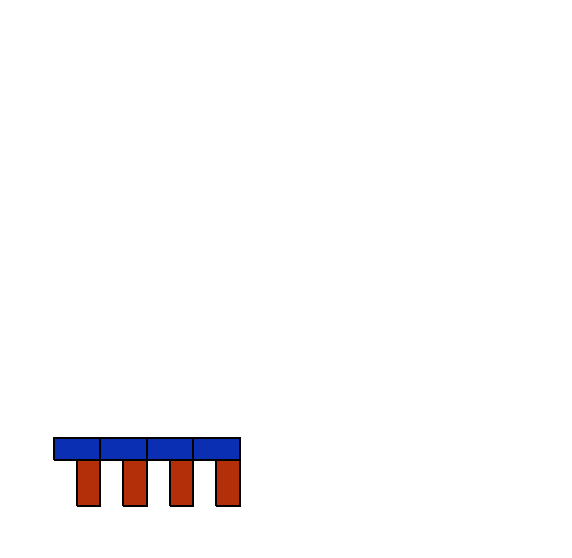

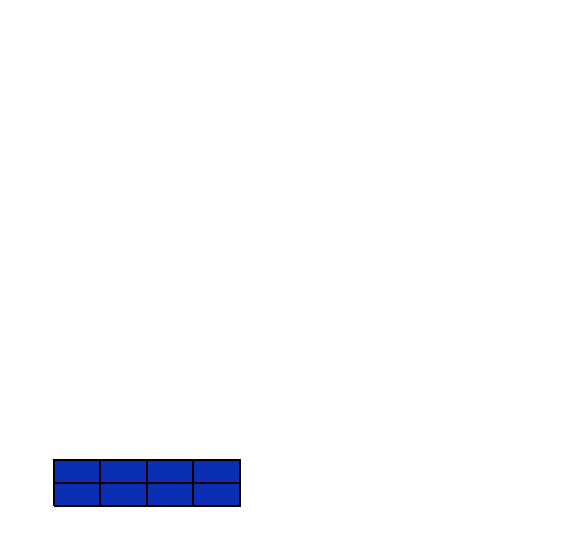

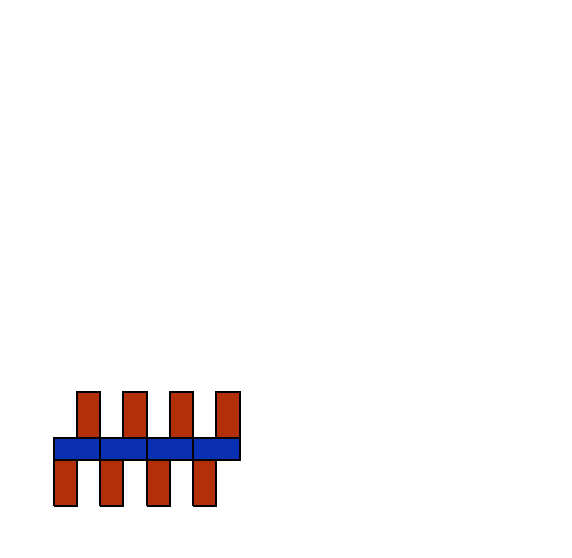

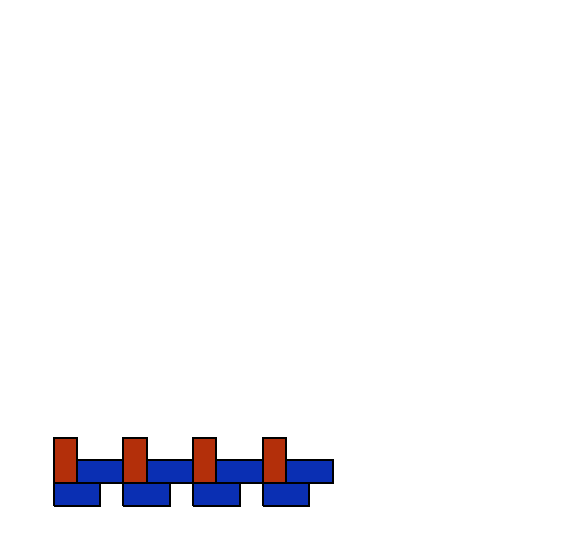

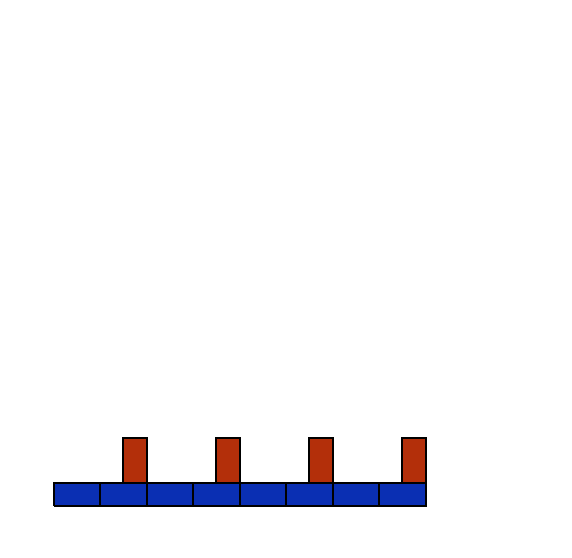

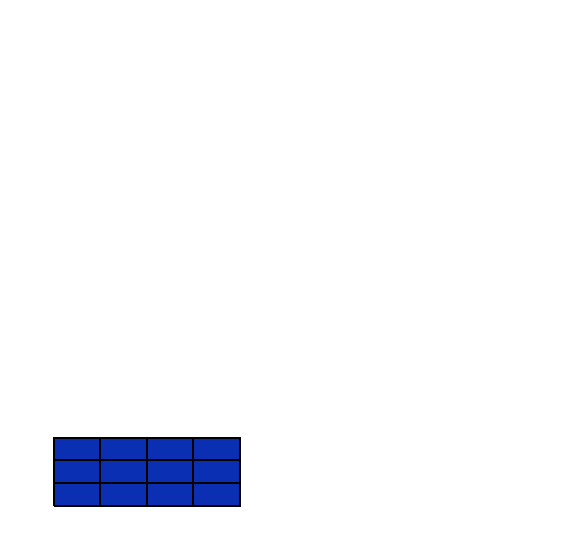

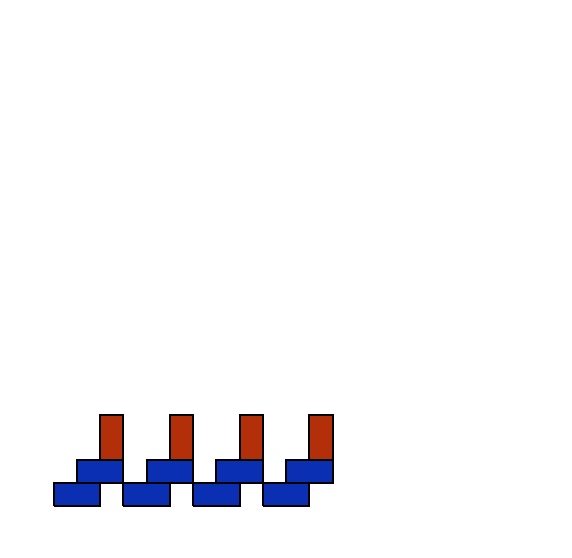

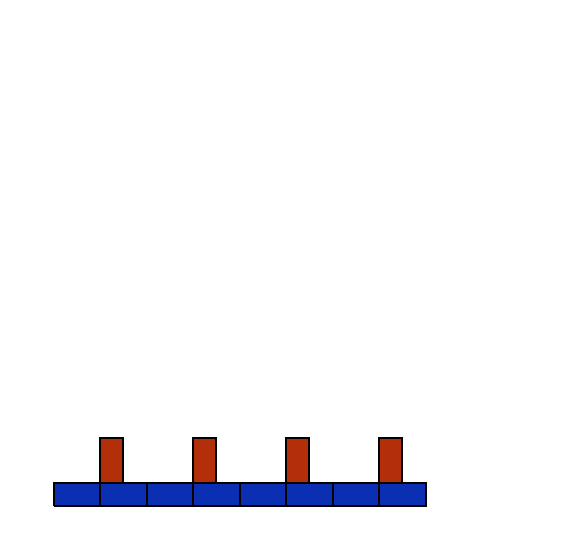

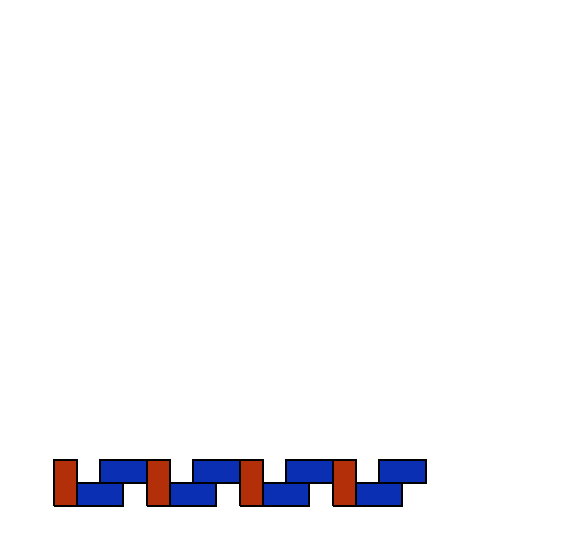

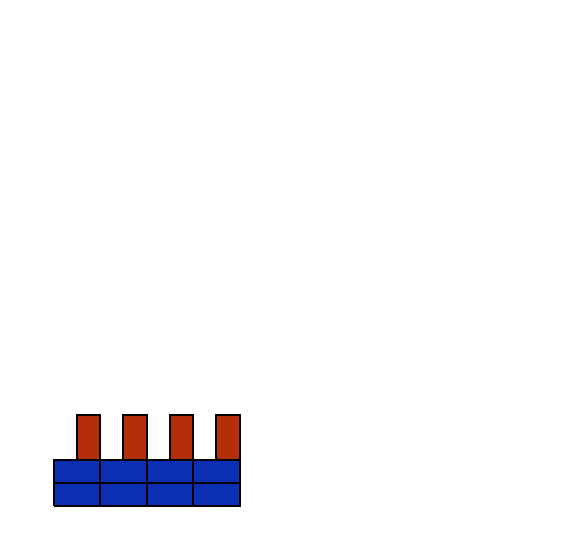

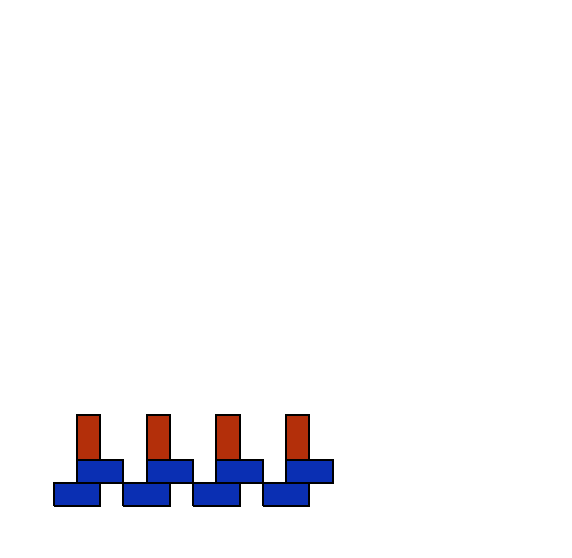

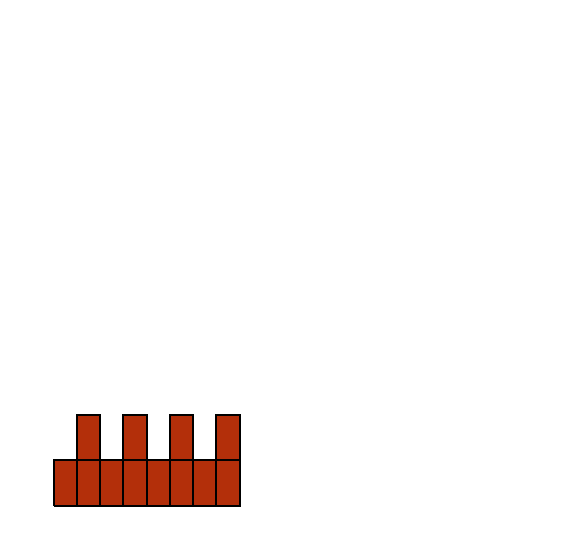

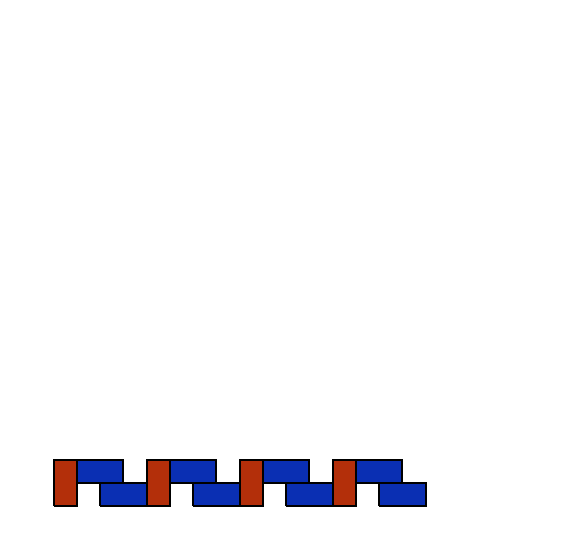

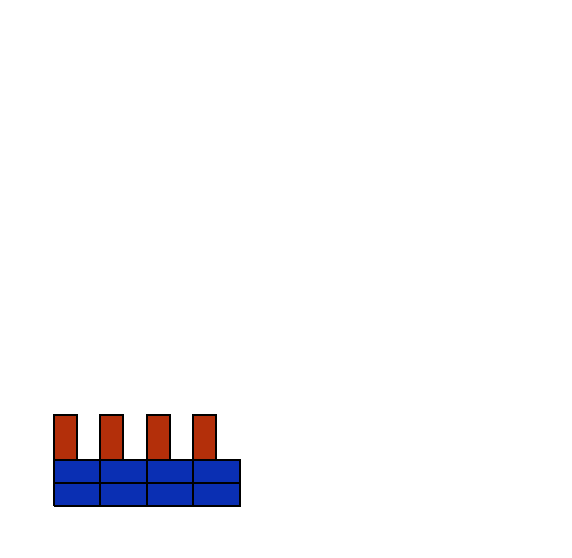

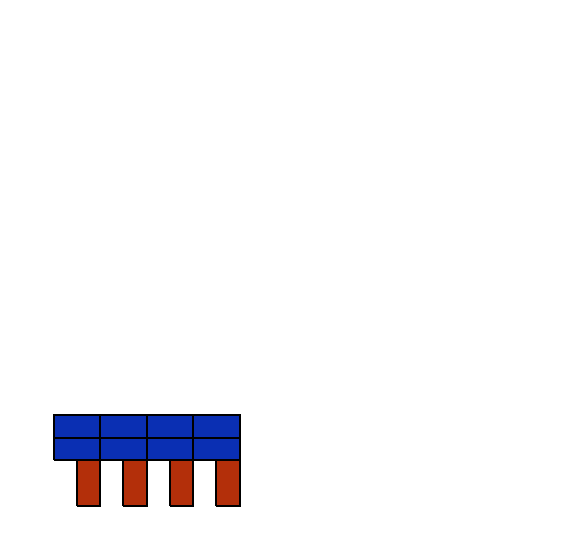

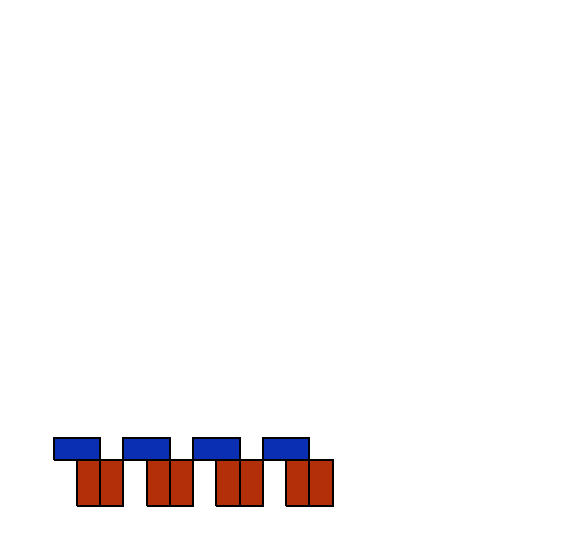

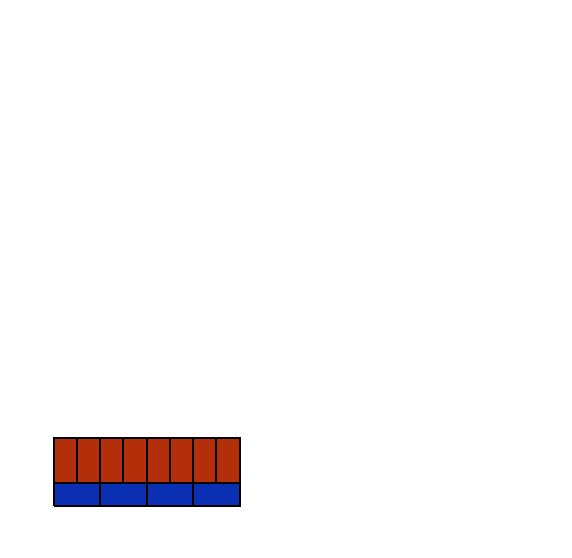

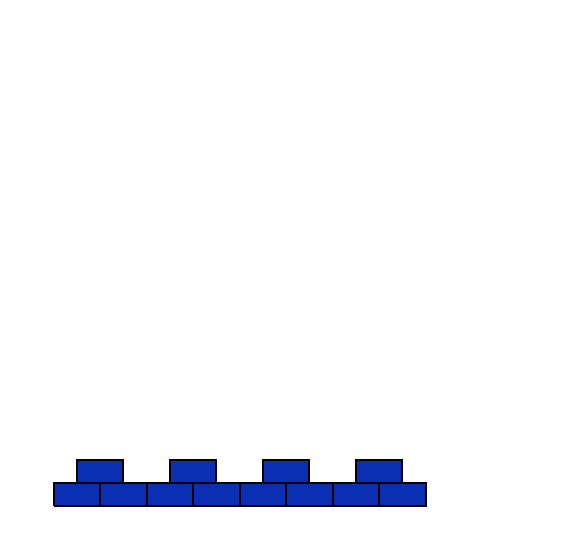

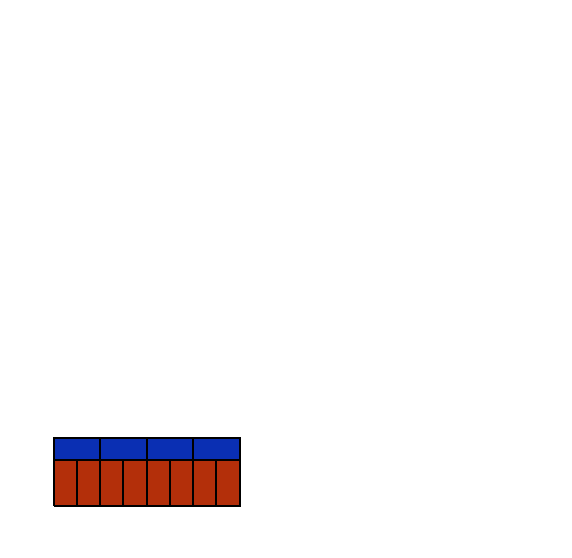

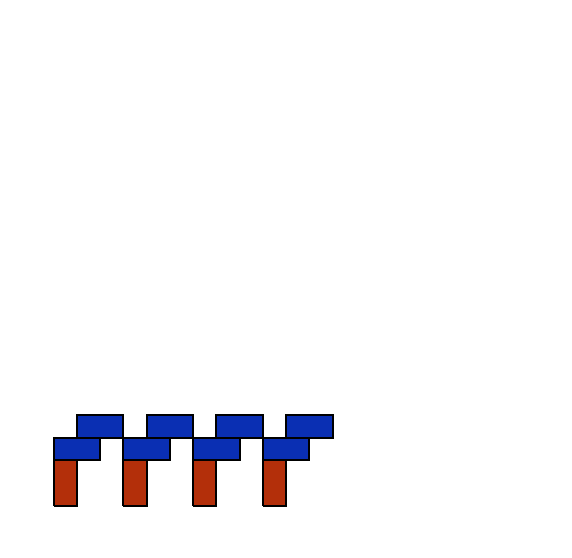

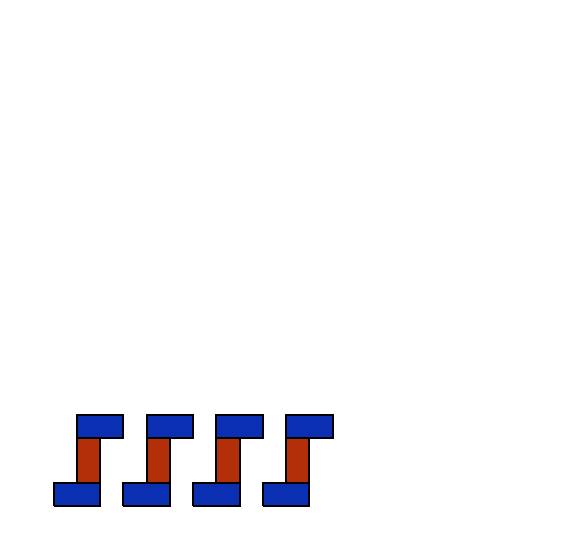

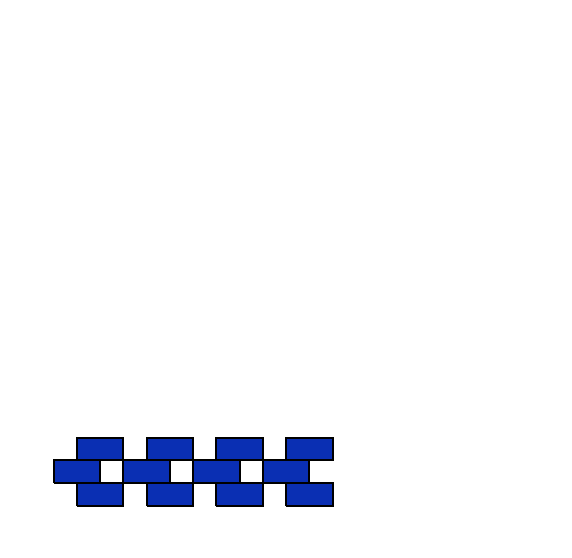

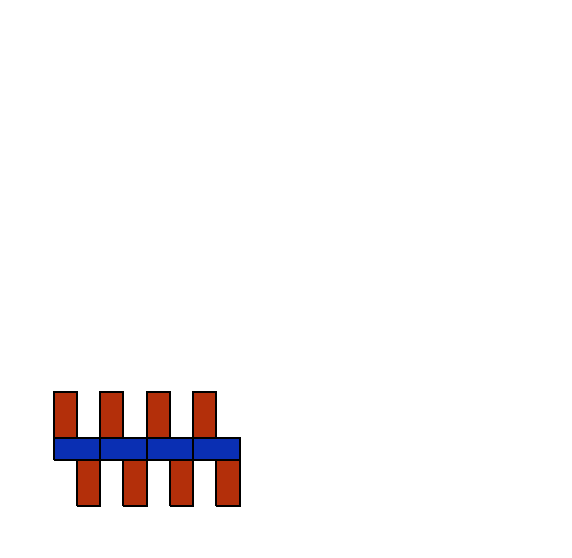

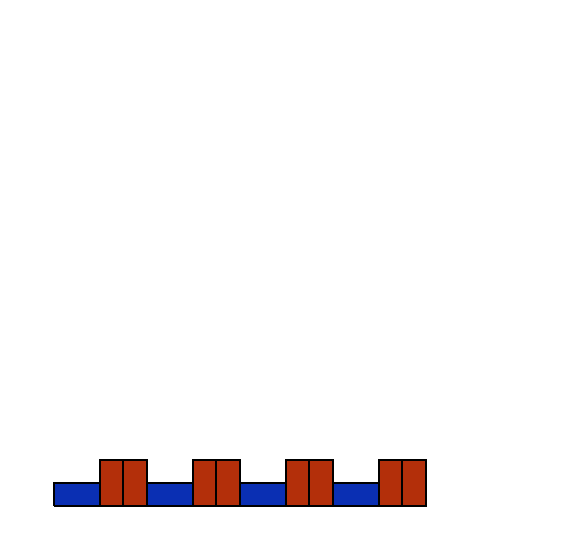

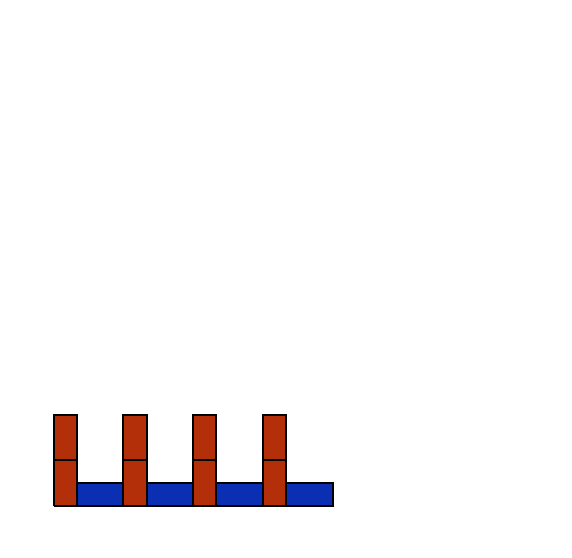

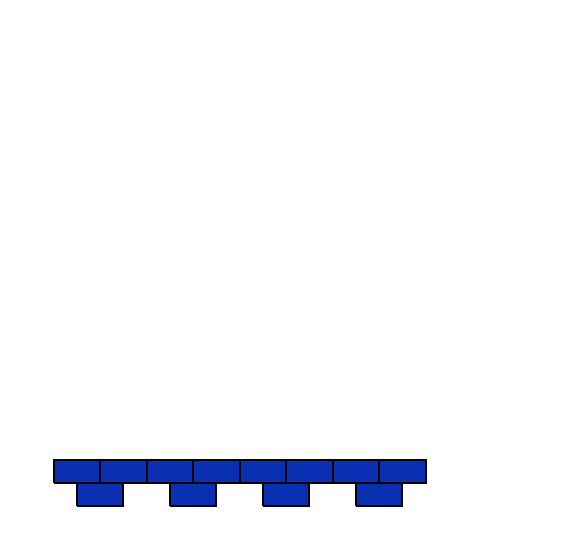

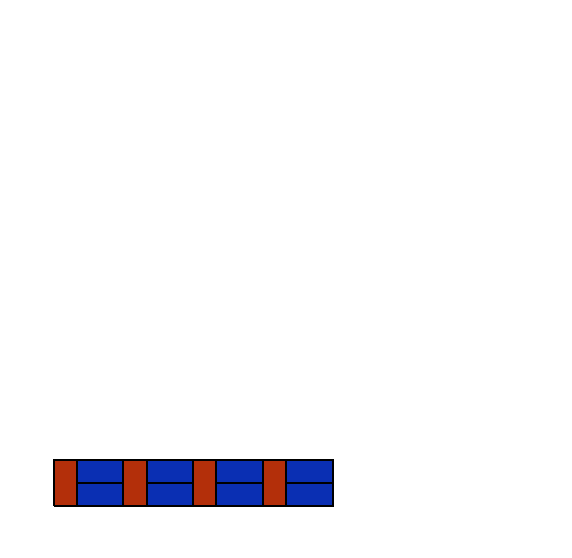

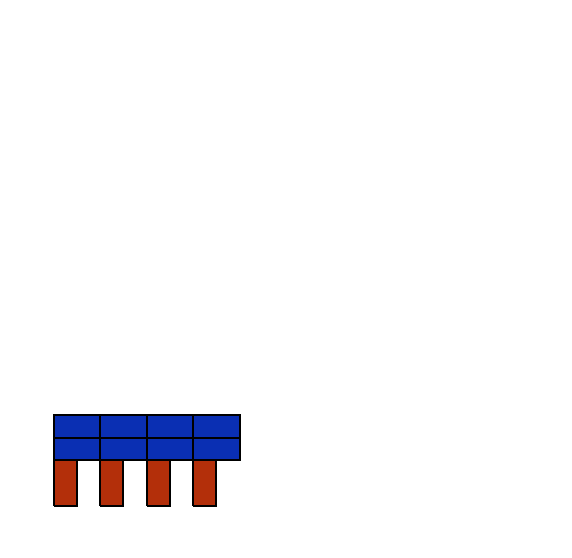

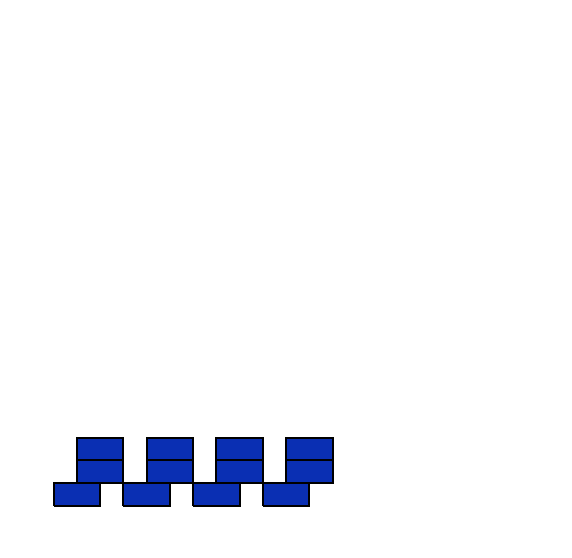

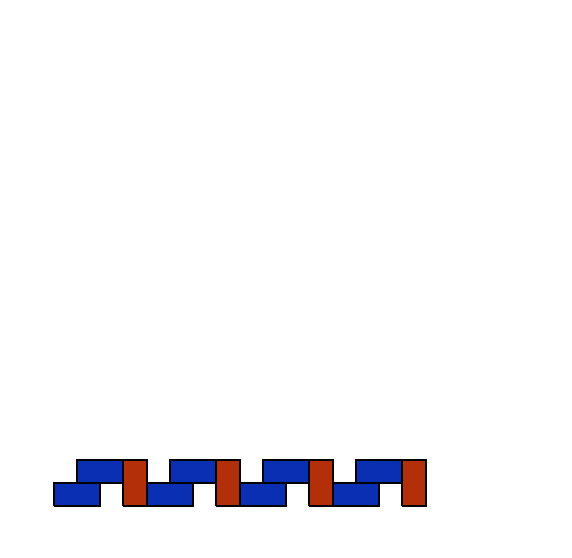

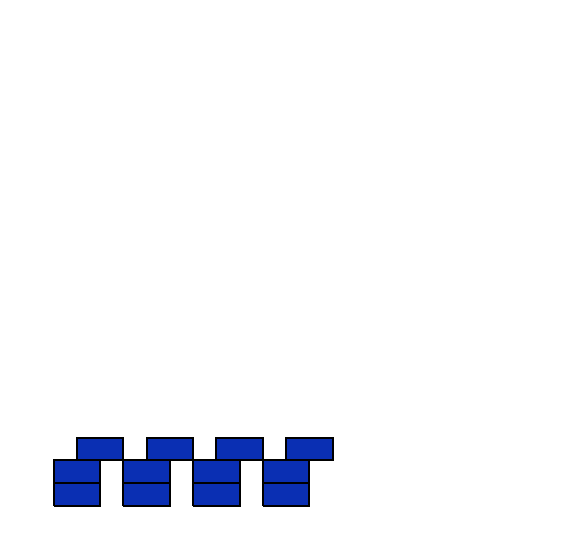

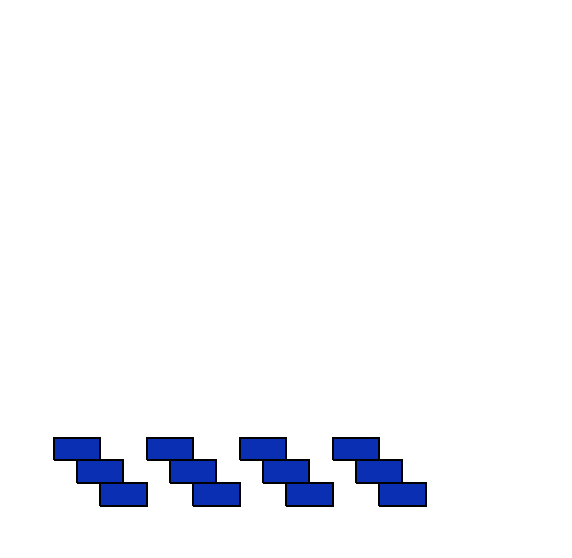

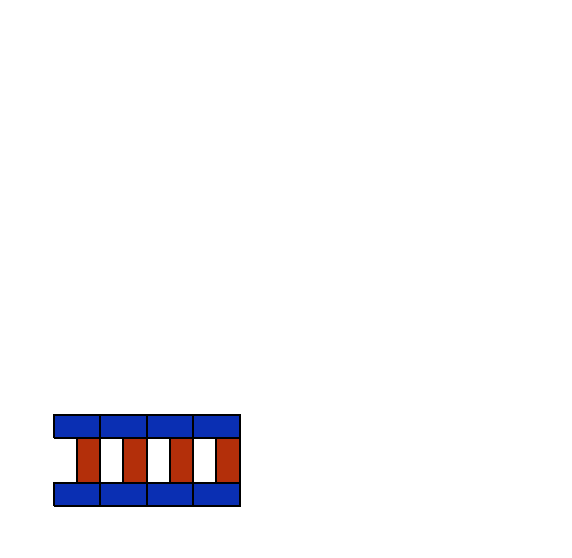

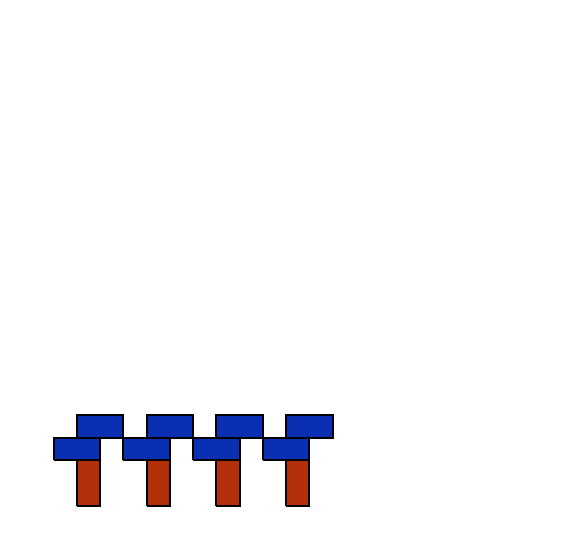

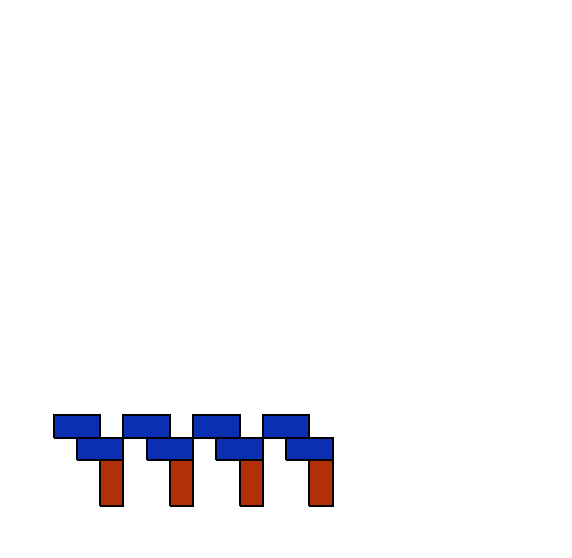

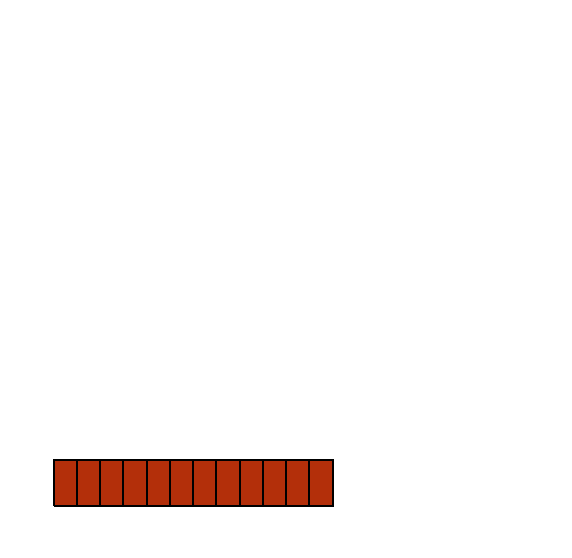

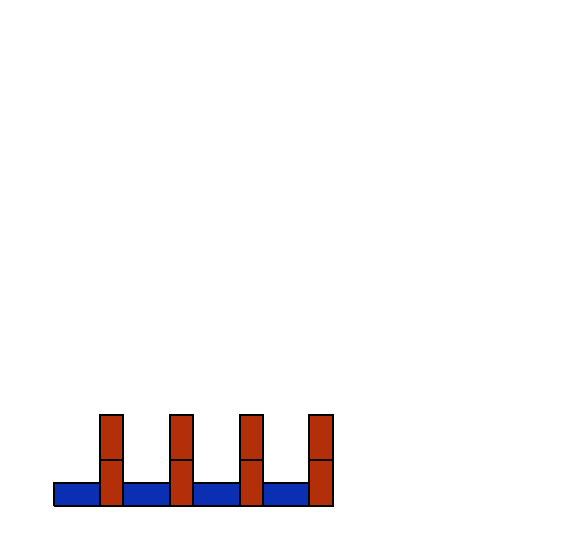

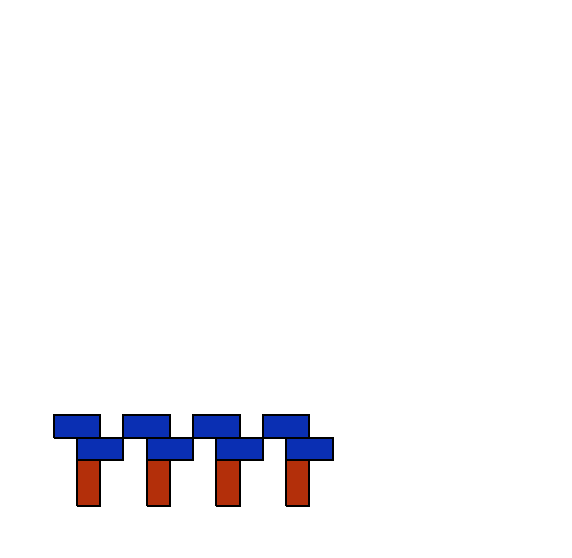

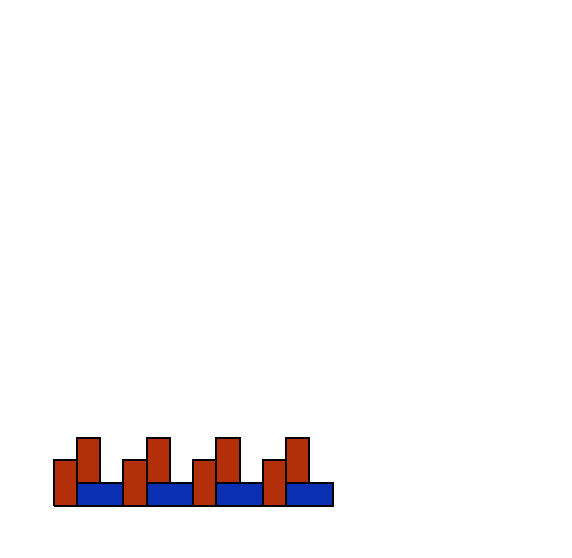

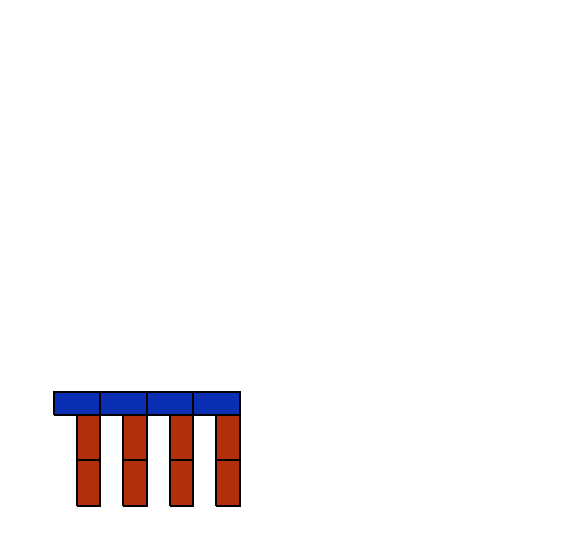

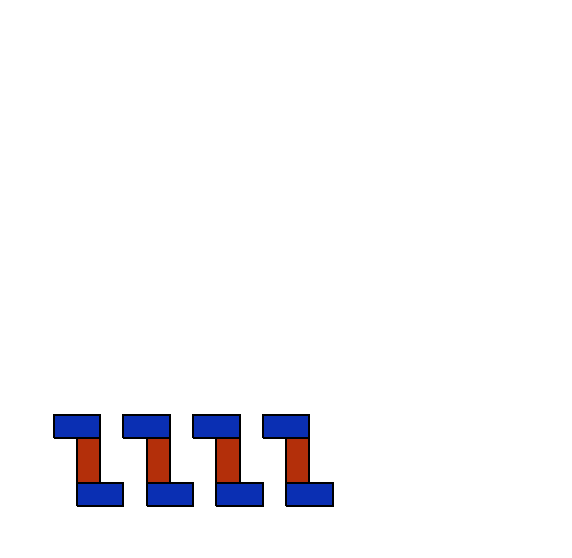

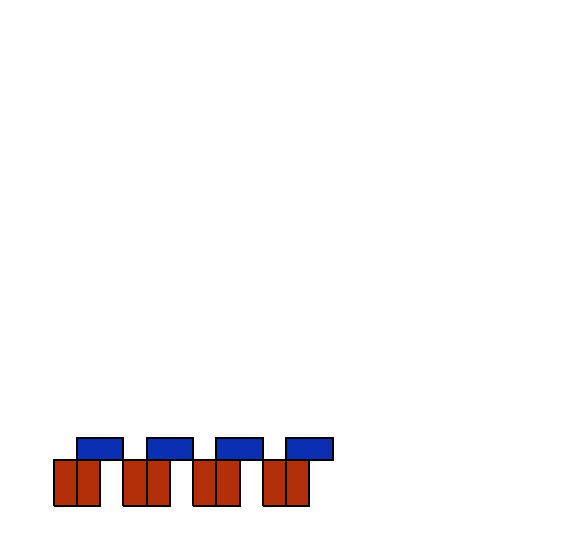

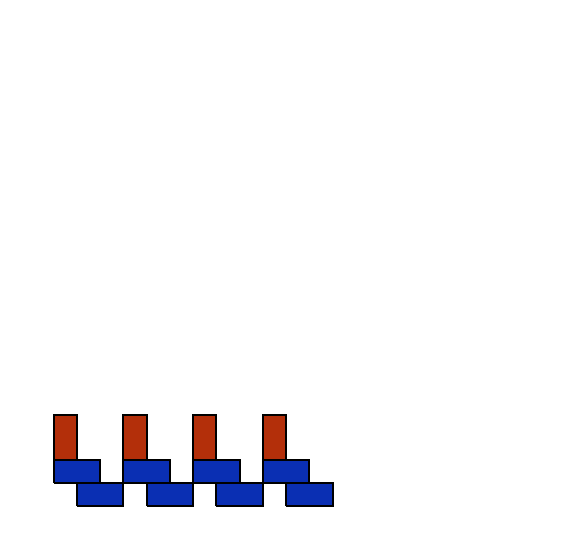

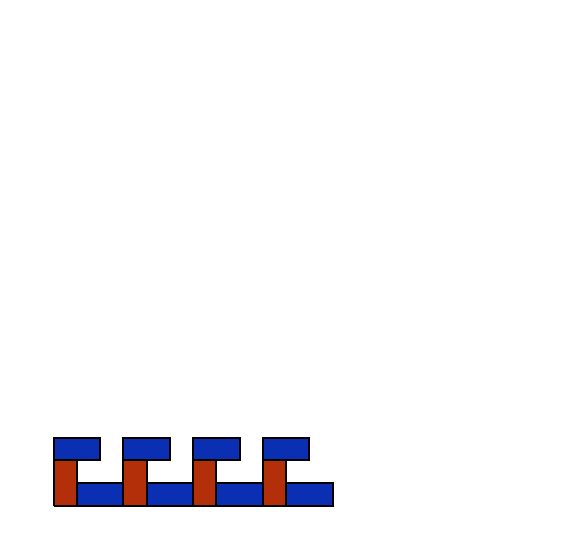

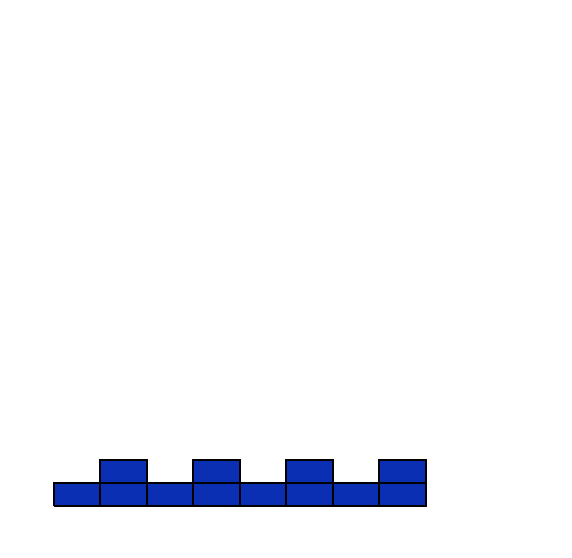

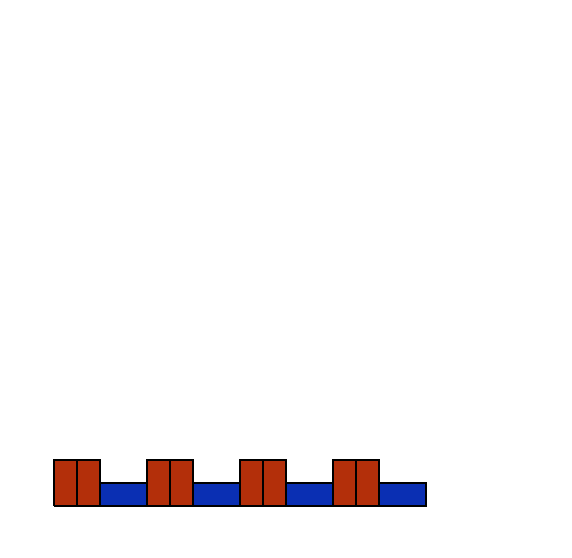

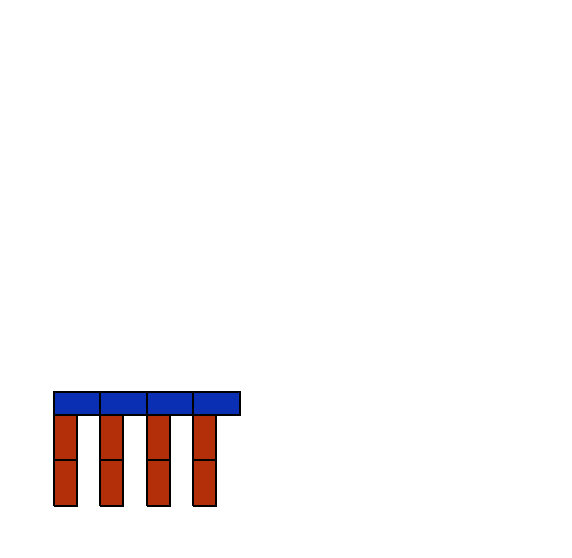

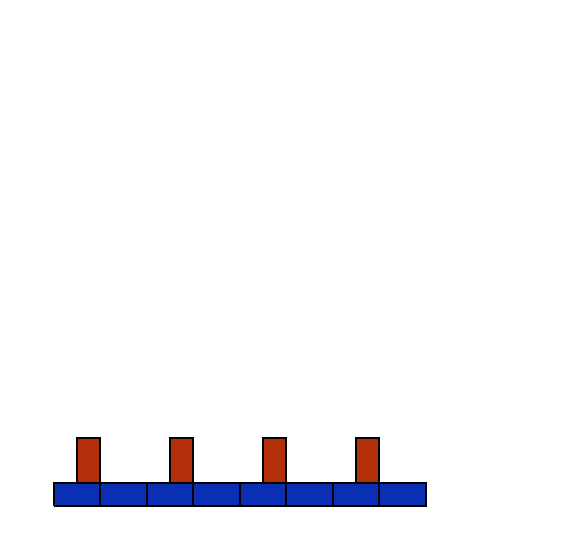

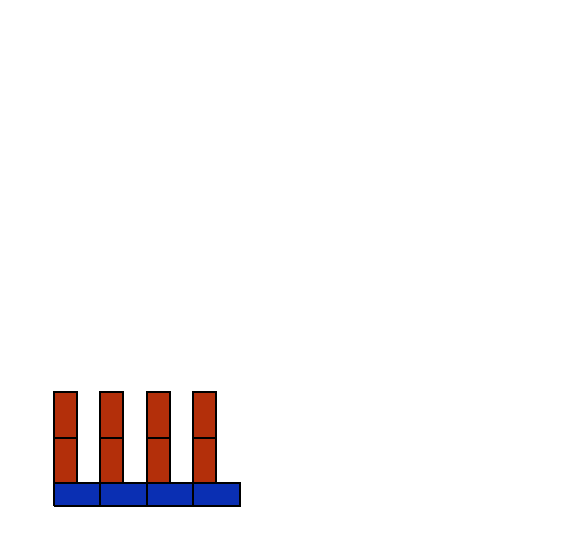

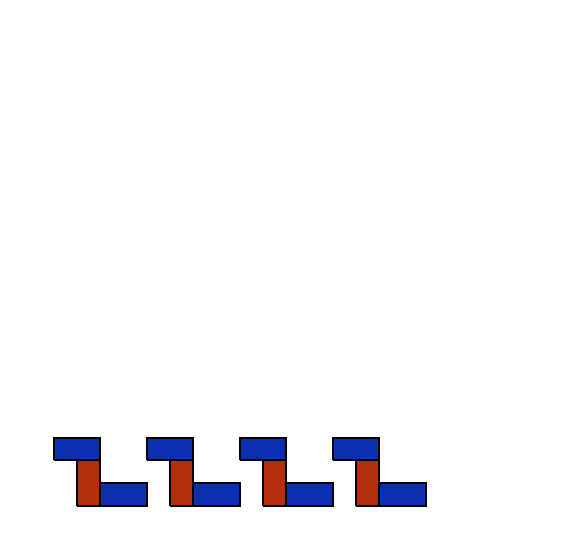

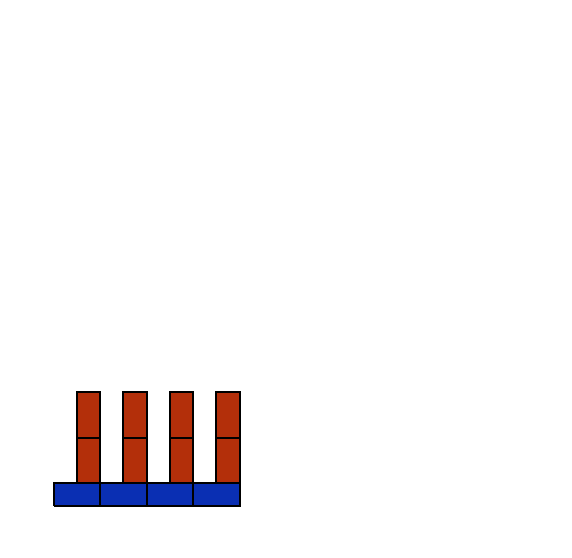

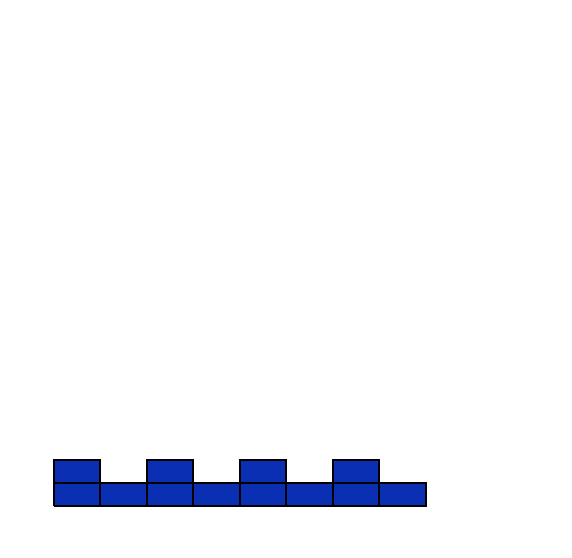

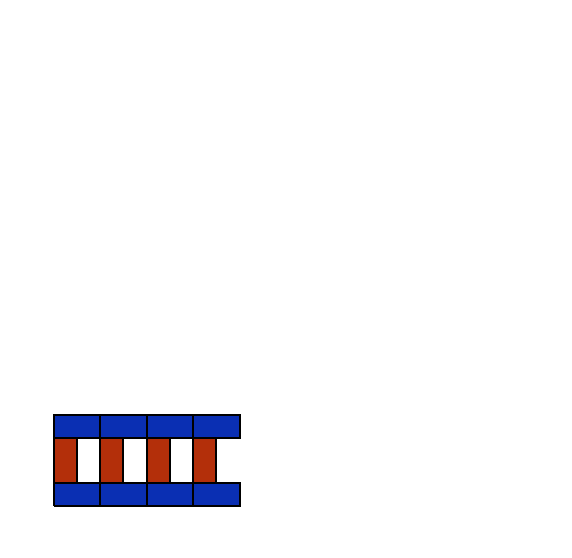

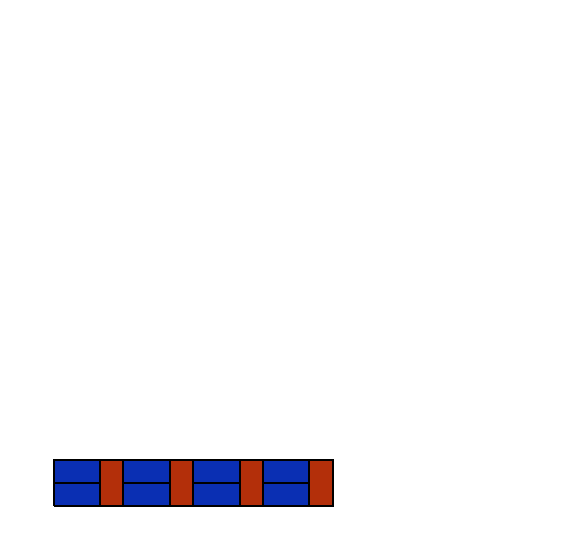

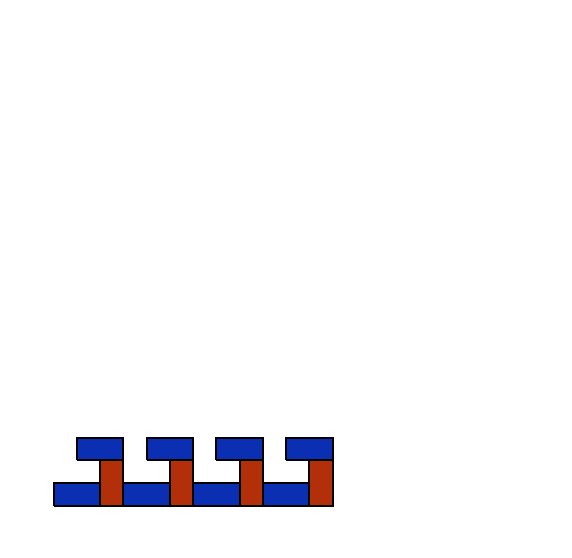

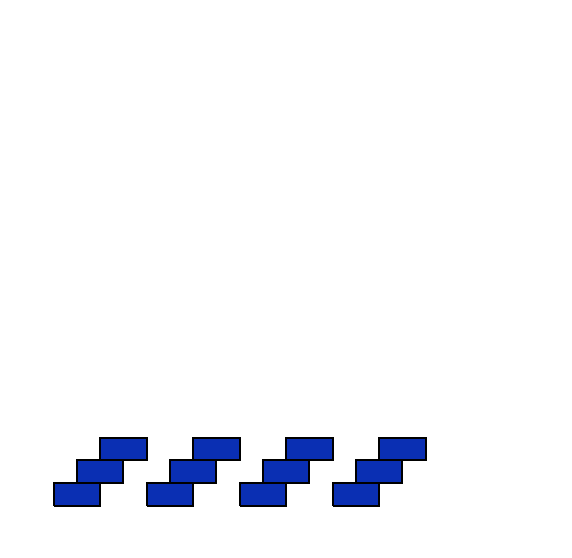

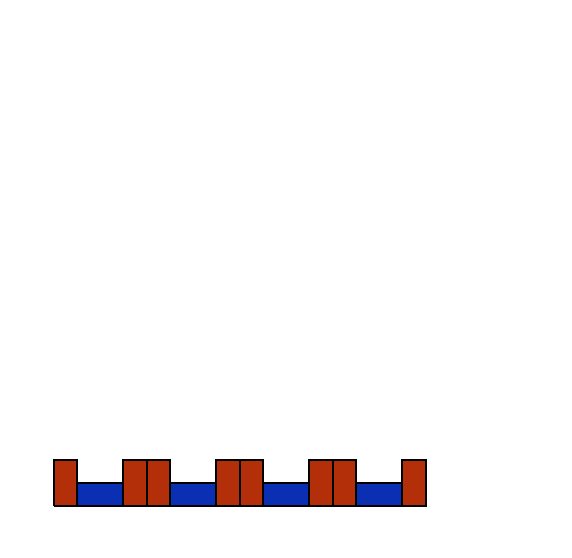

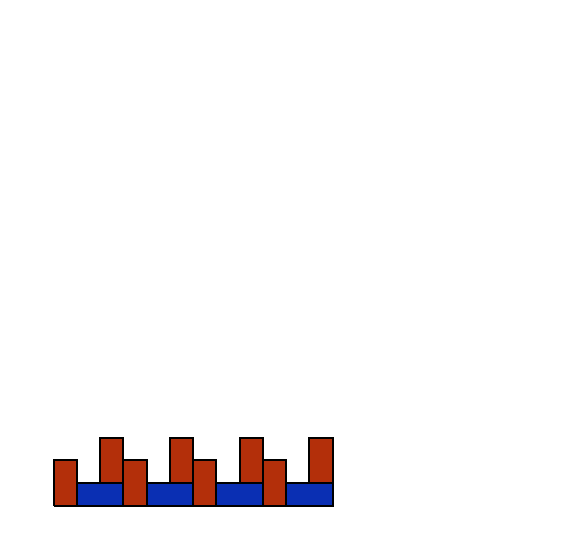

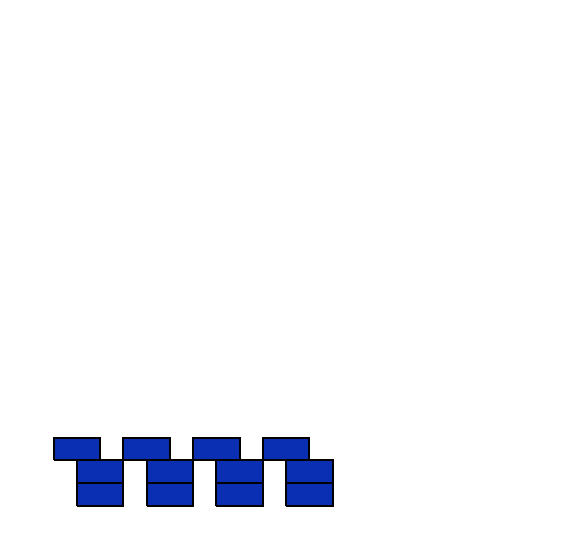

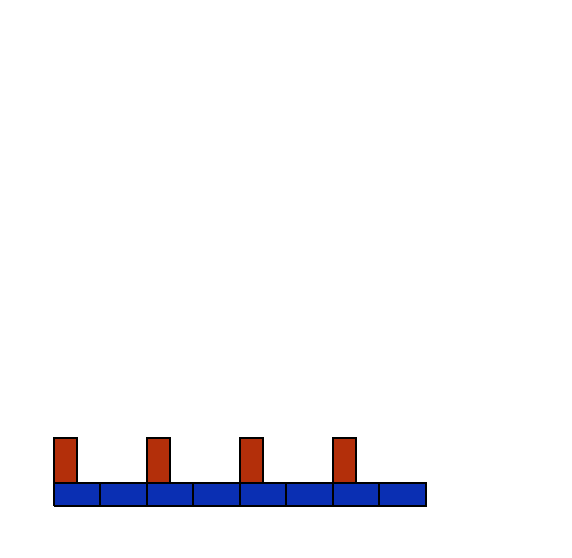

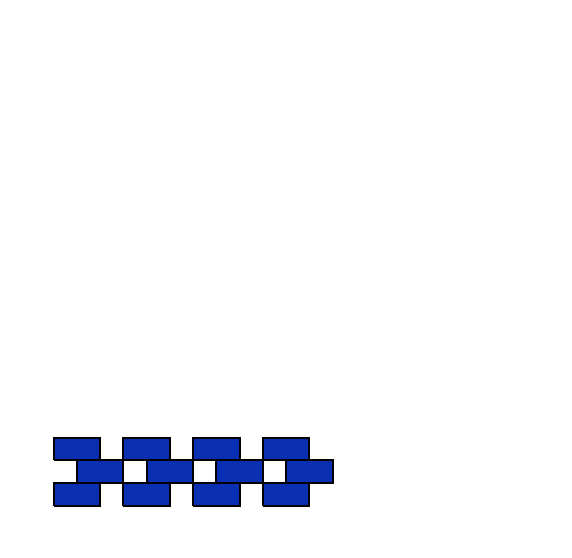

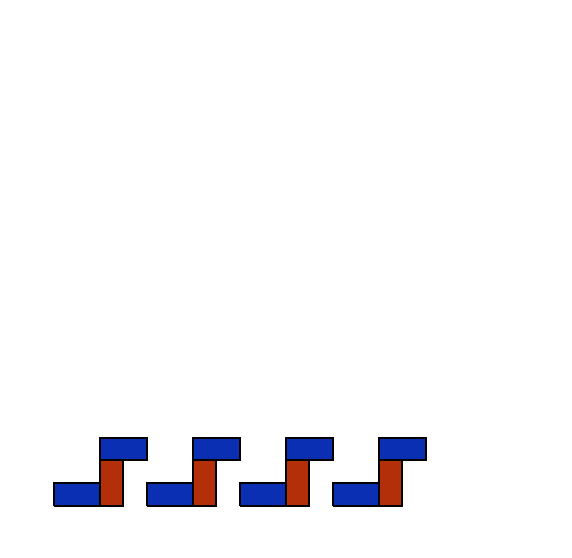

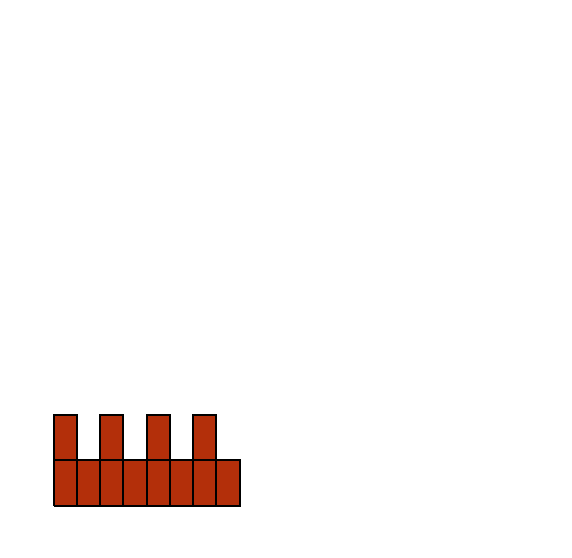

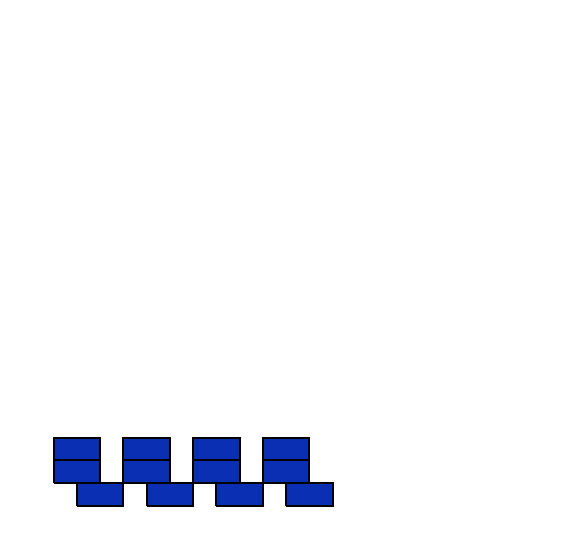

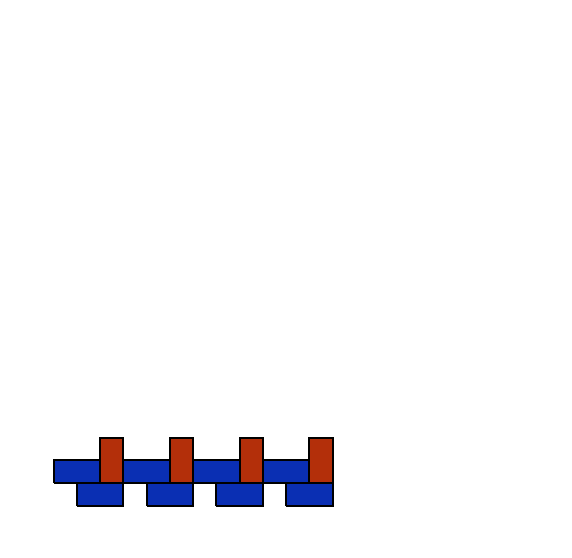

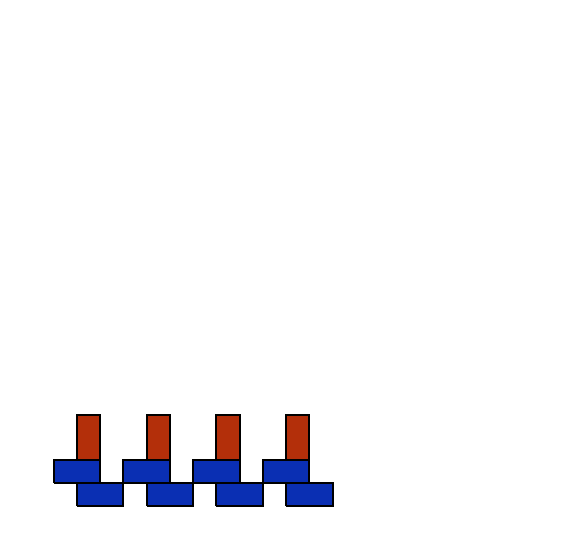

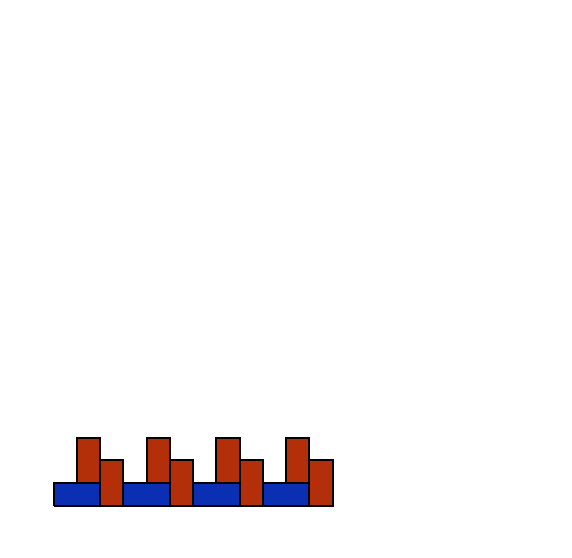

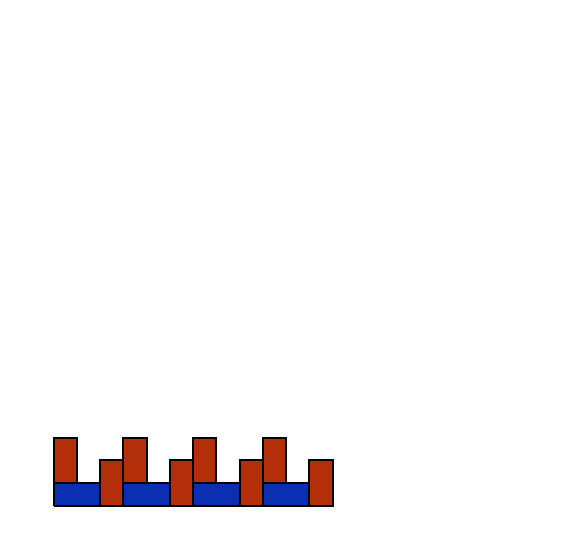

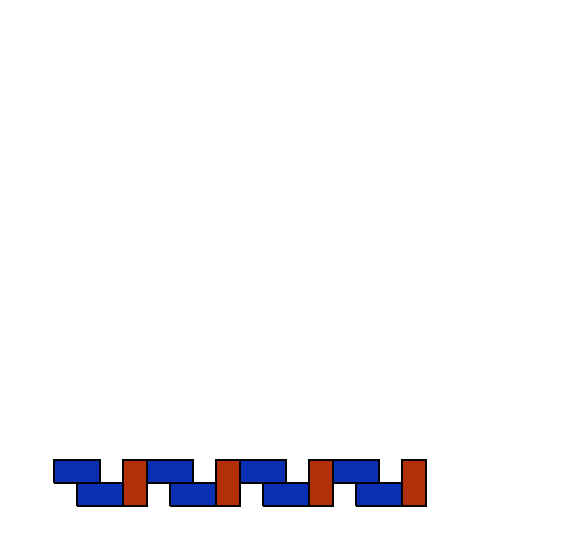

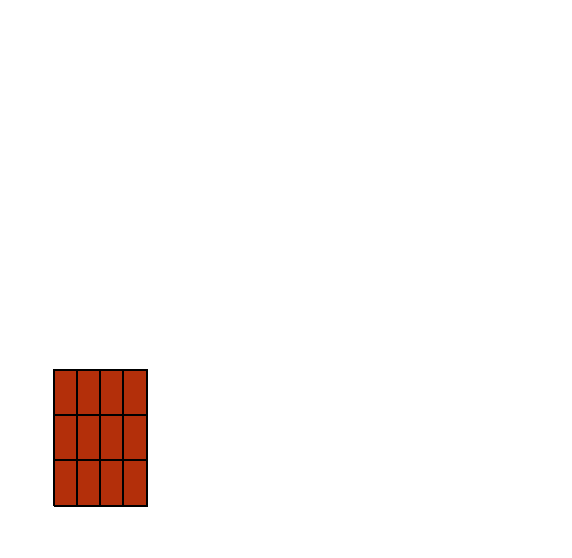

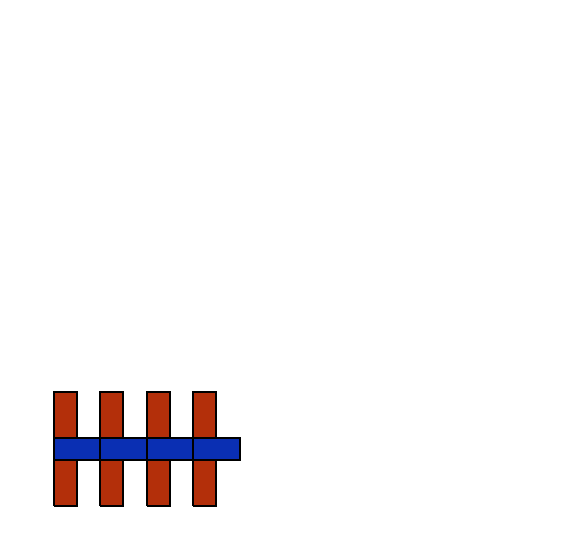

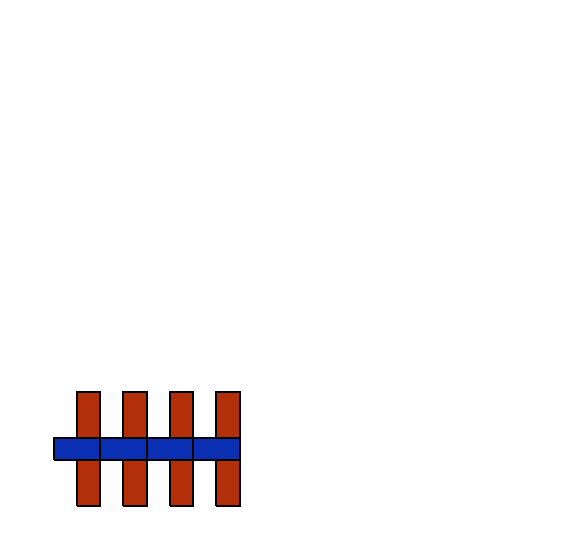

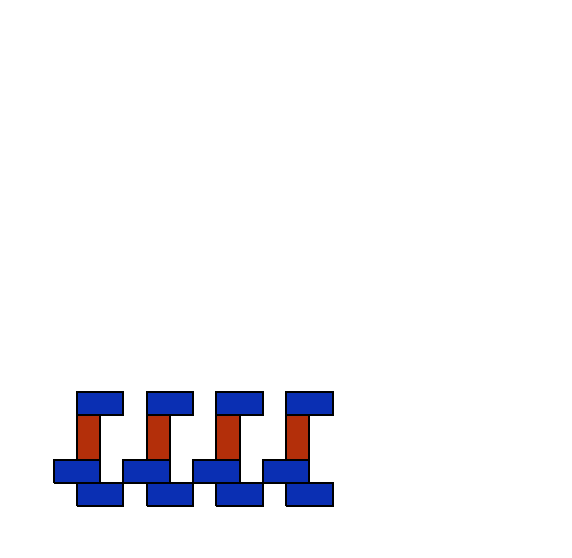

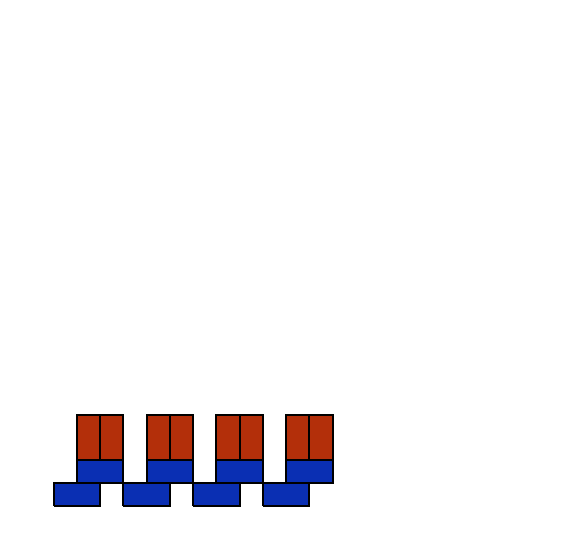

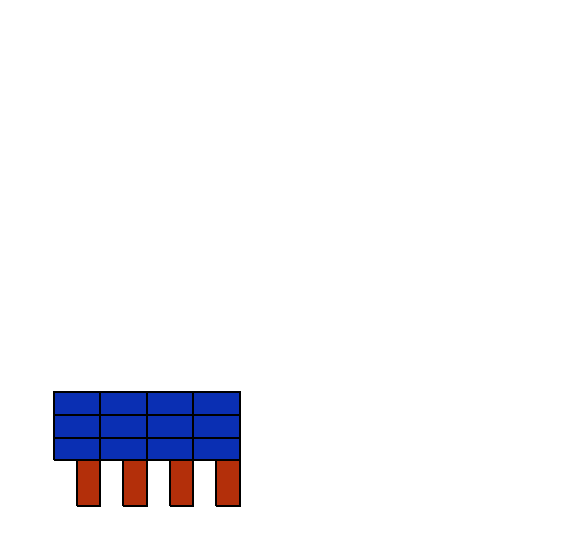

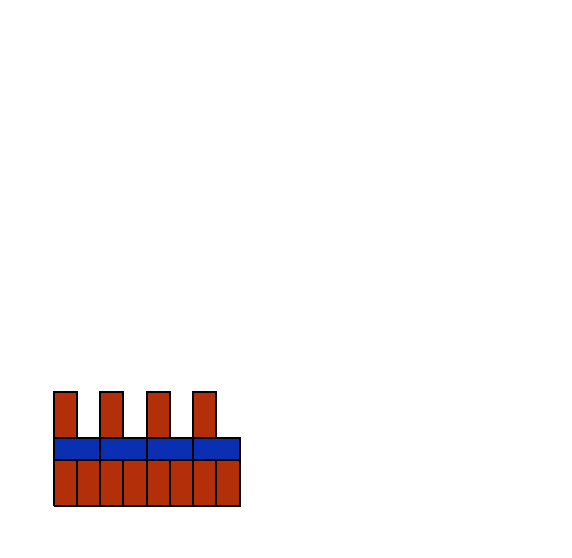

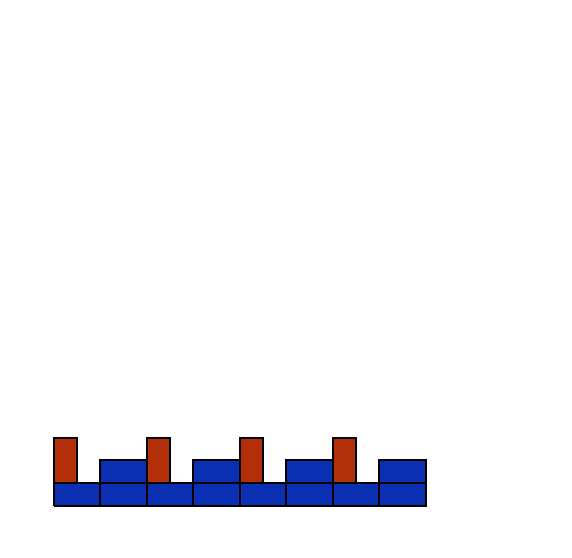

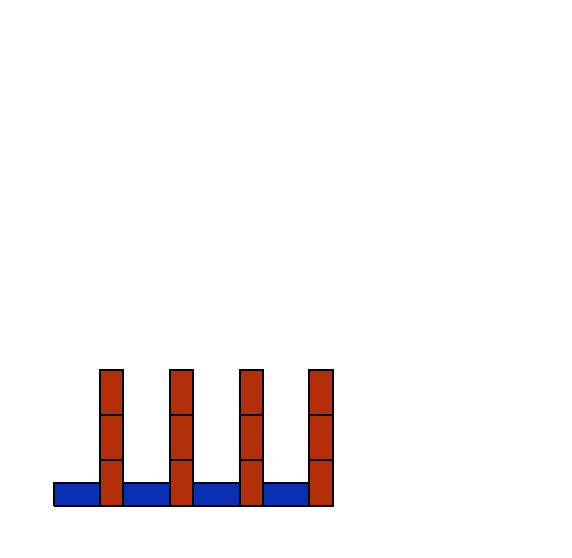

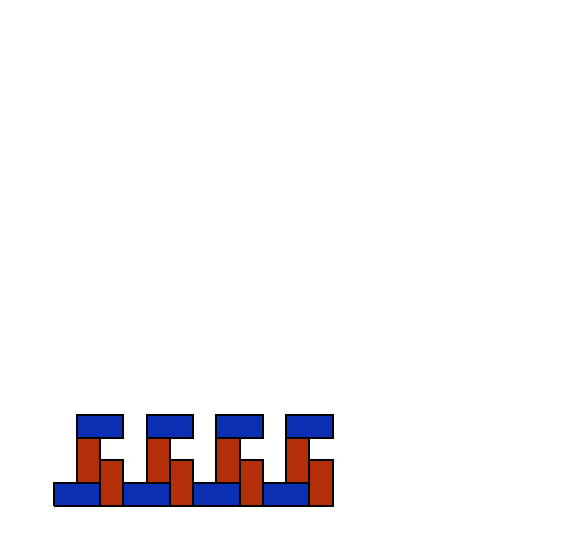

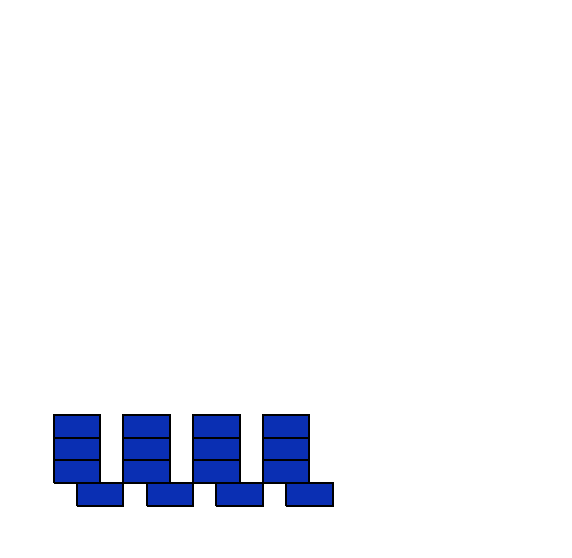

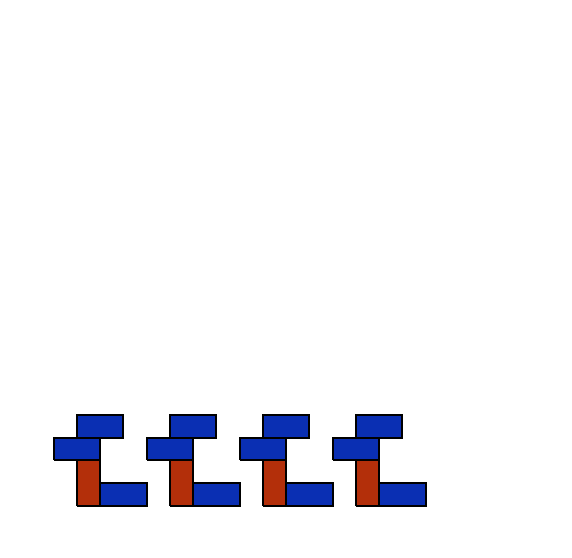

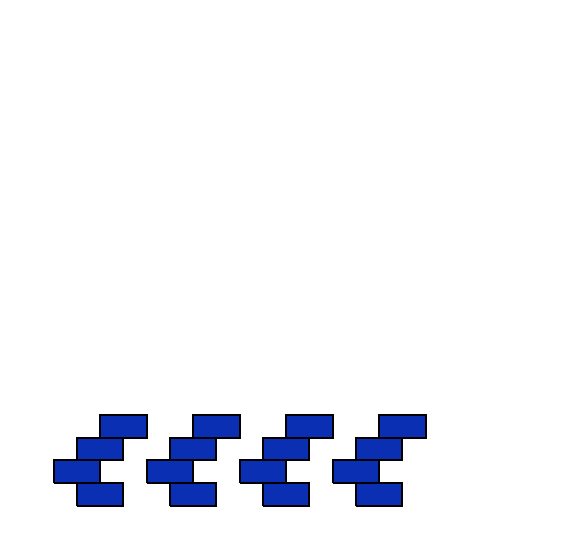

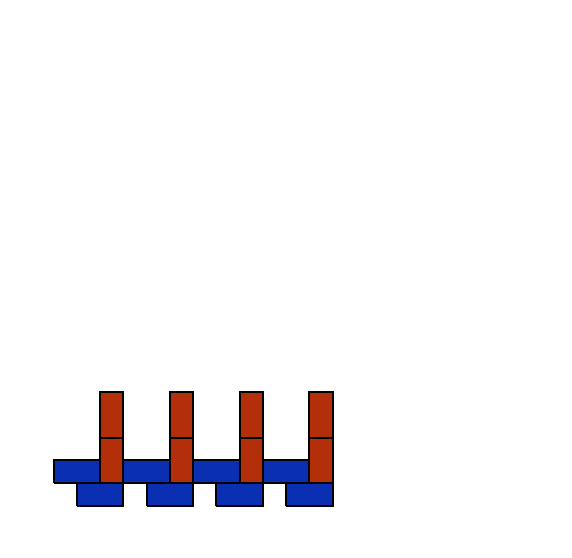

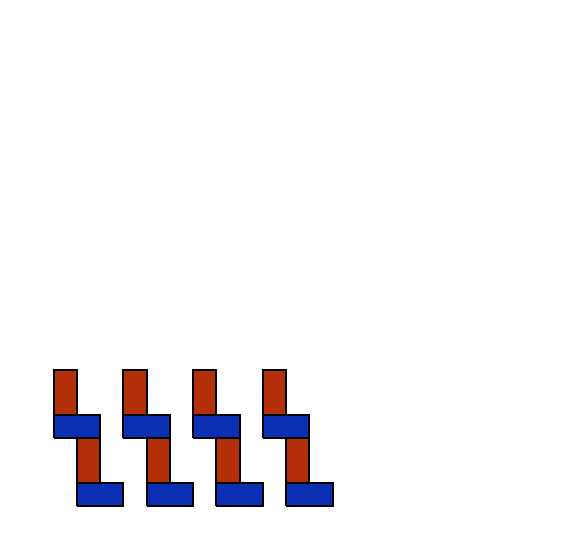

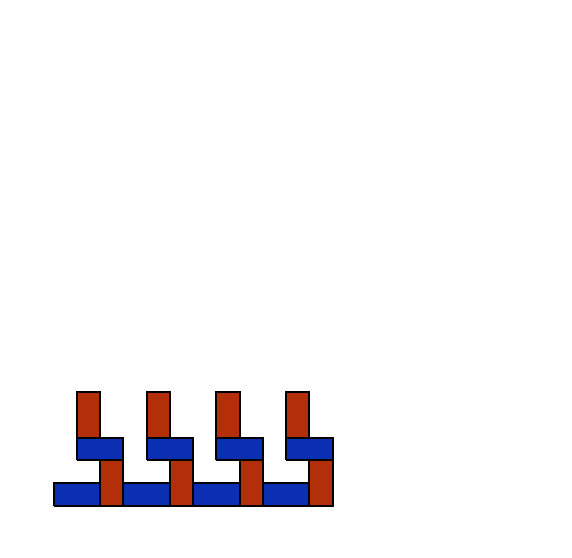

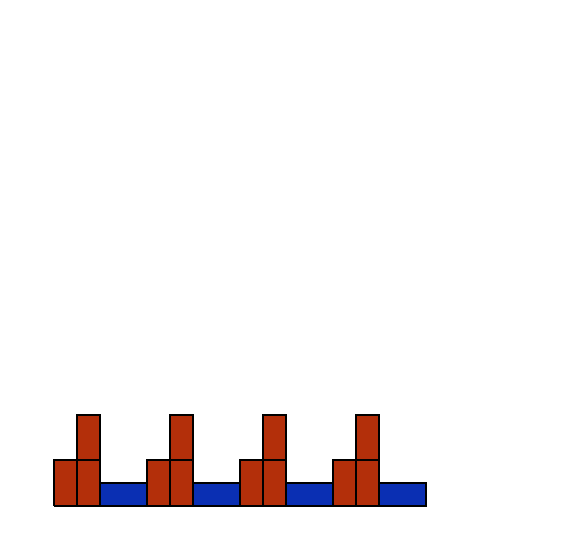

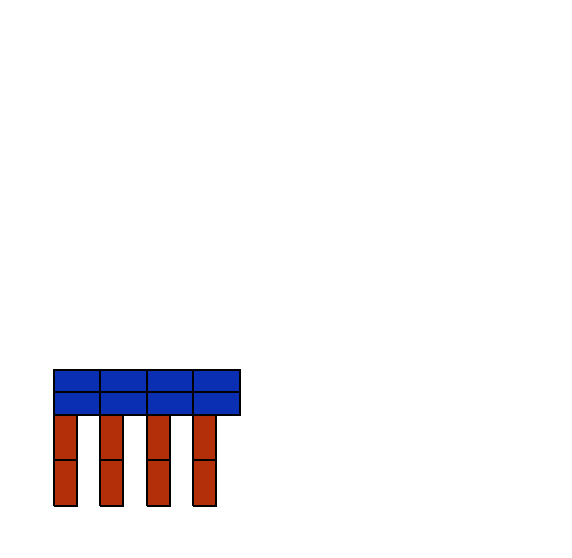

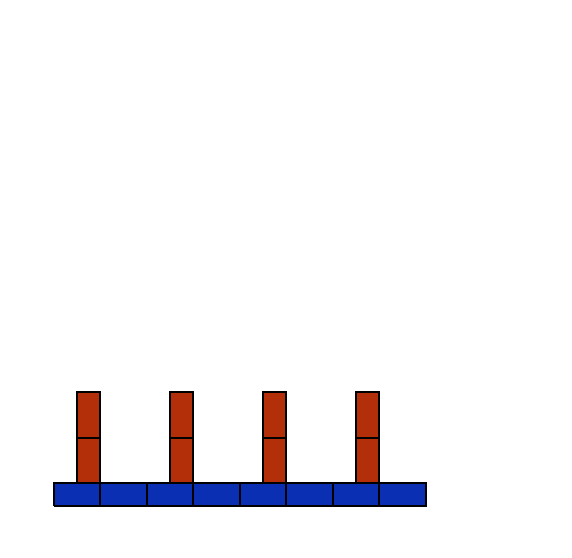

In [656]:
# Create rows

rows = {}

for wall_width in range(2,5):
    
    rows[wall_width] = []
    
    for chunk in chunks:

        r = new_world()
        row(r, chunk, n = wall_width, diff = 0)

        row_dict = r.get_block_dict()['blocks']
        
        if not r.broken:
                utils.draw_world(r)
                rows[wall_width].append(row_dict)


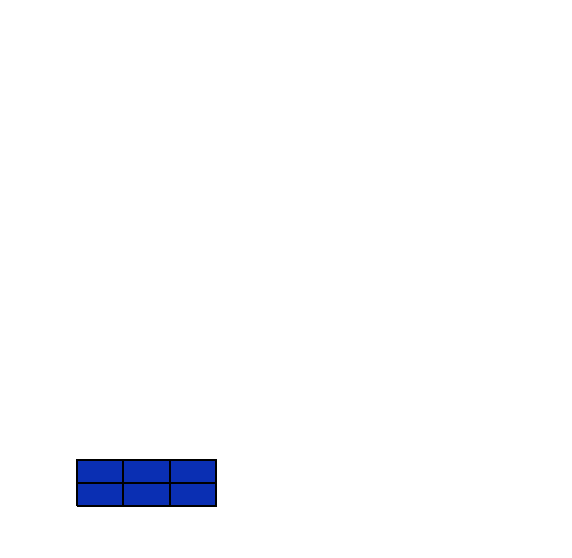

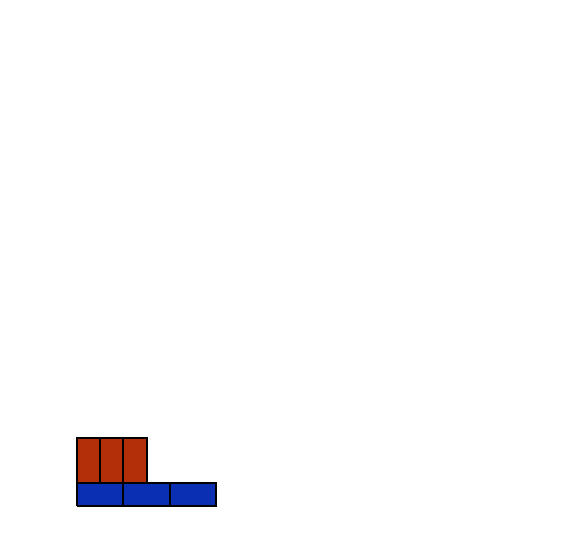

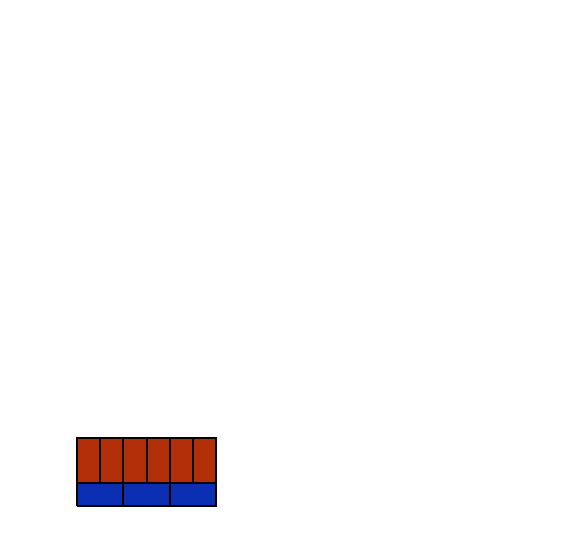

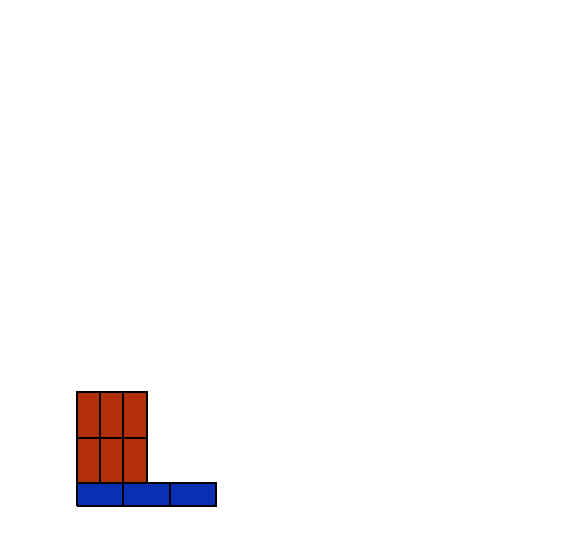

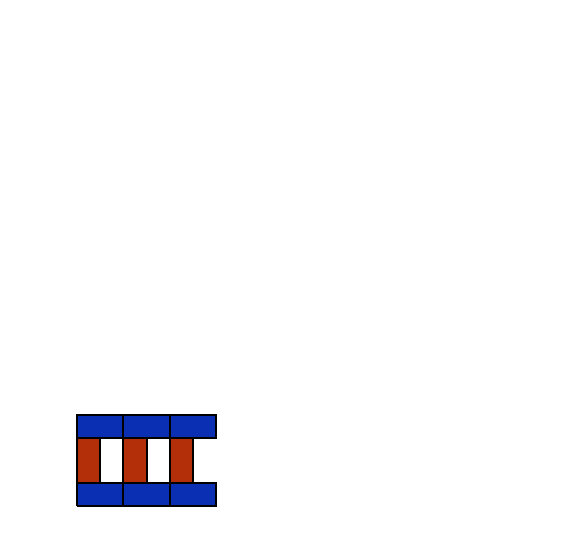

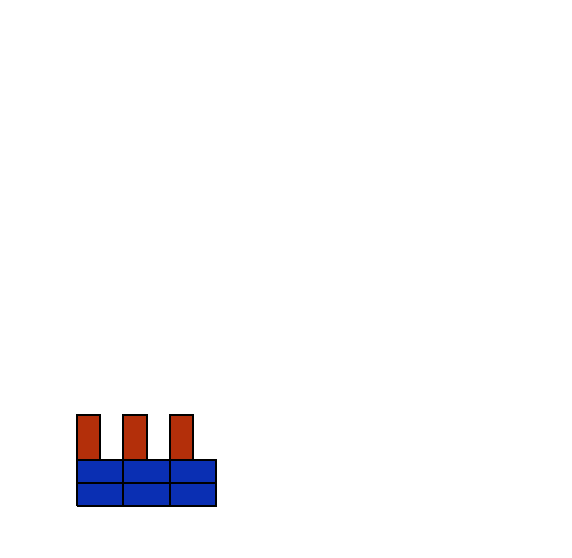

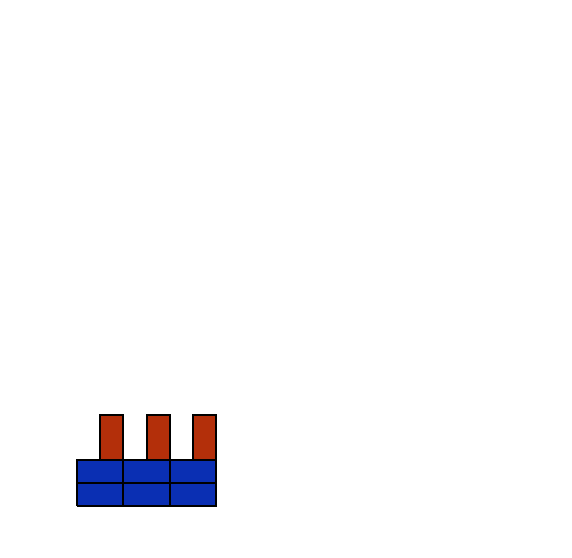

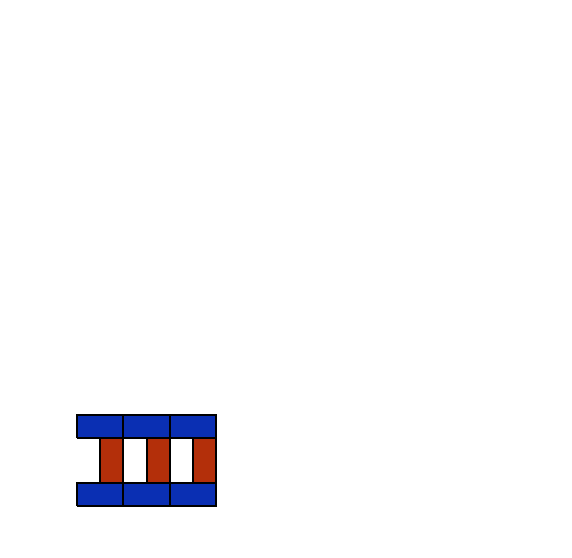

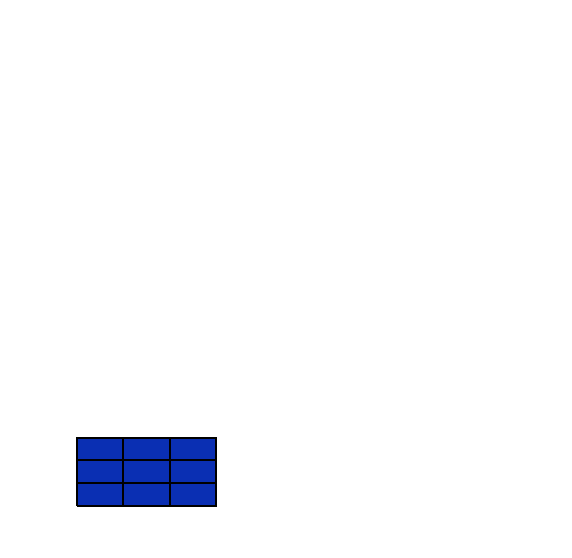

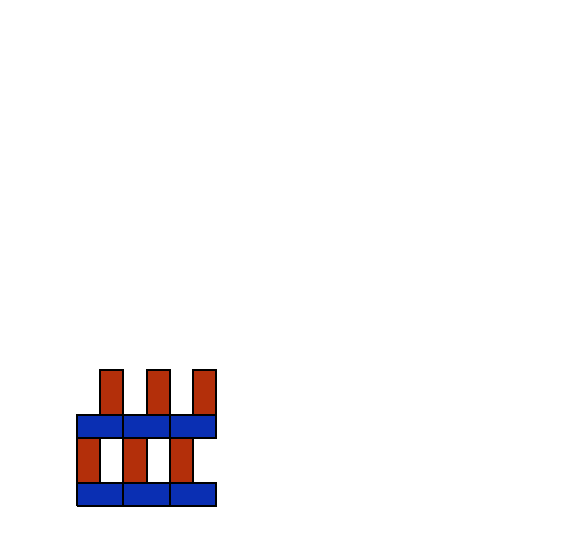

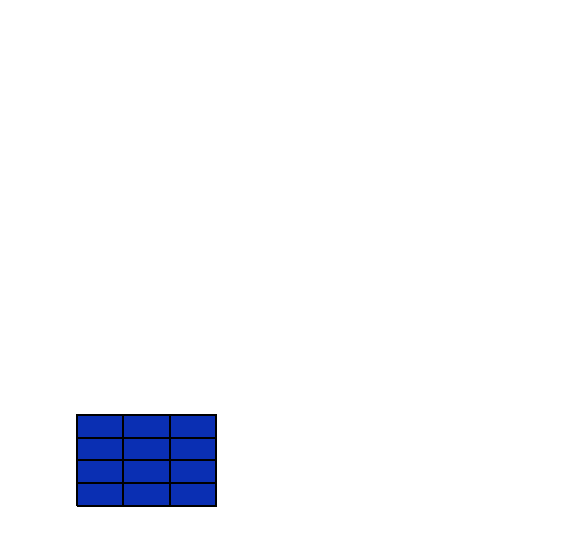

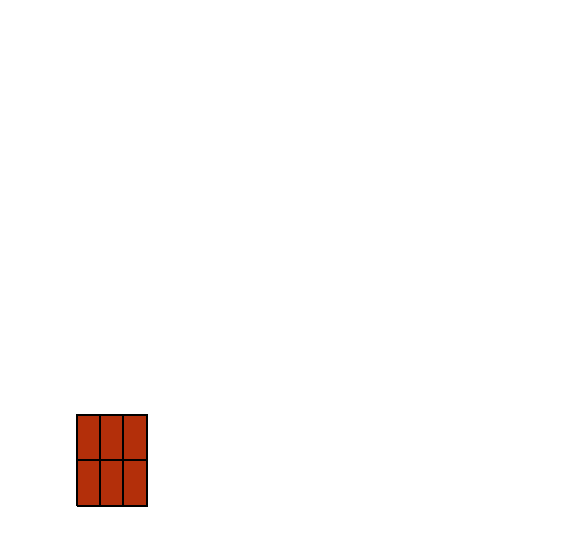

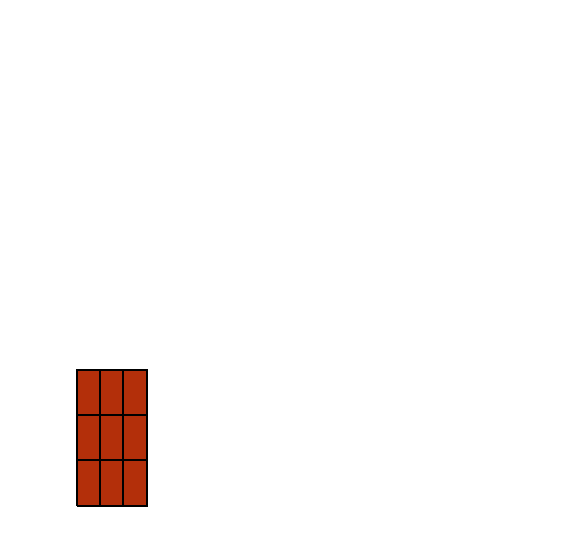

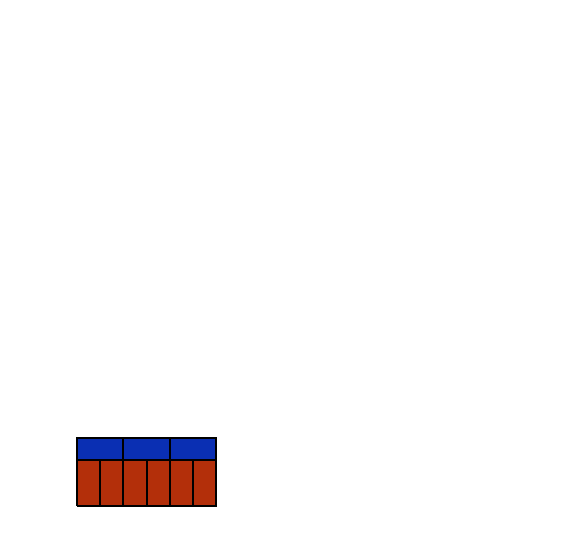

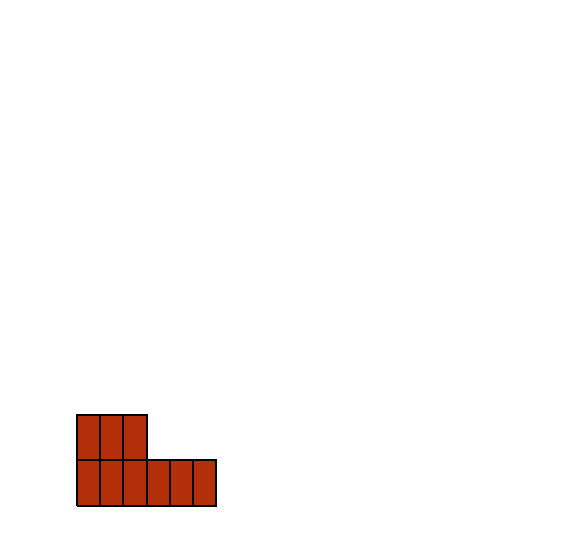

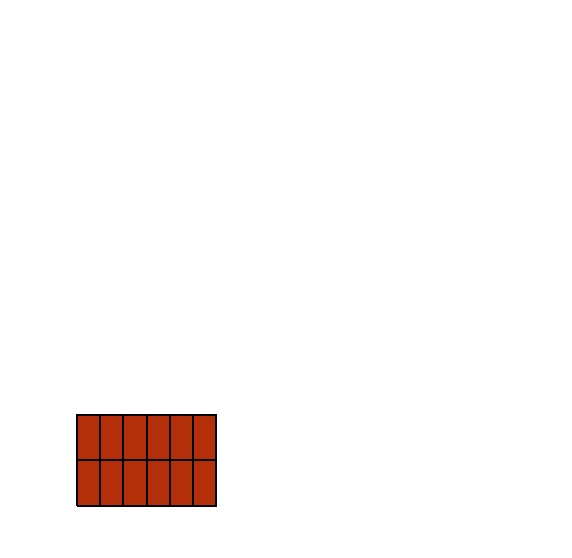

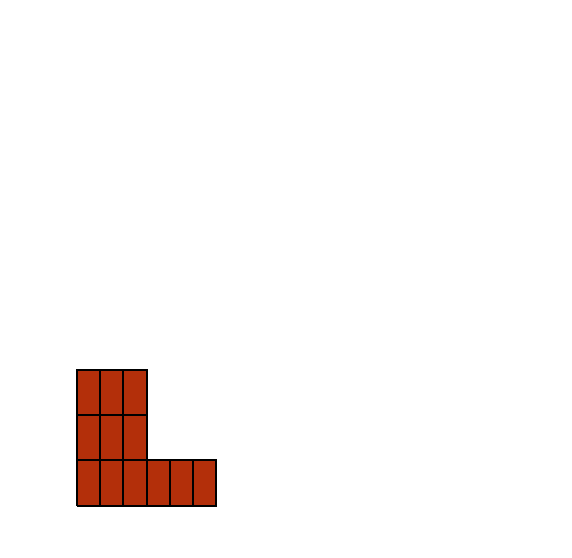

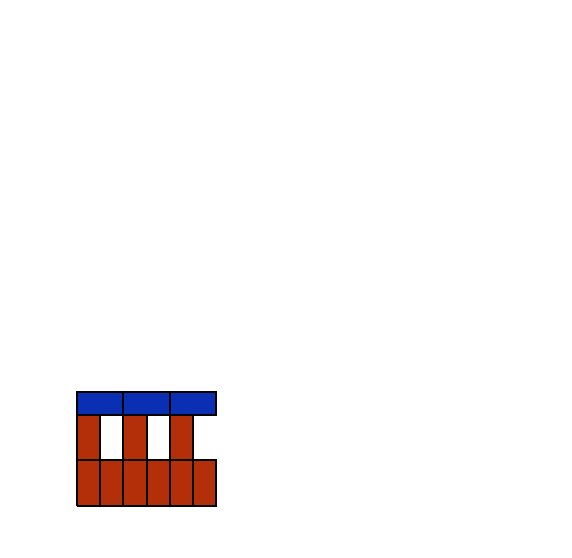

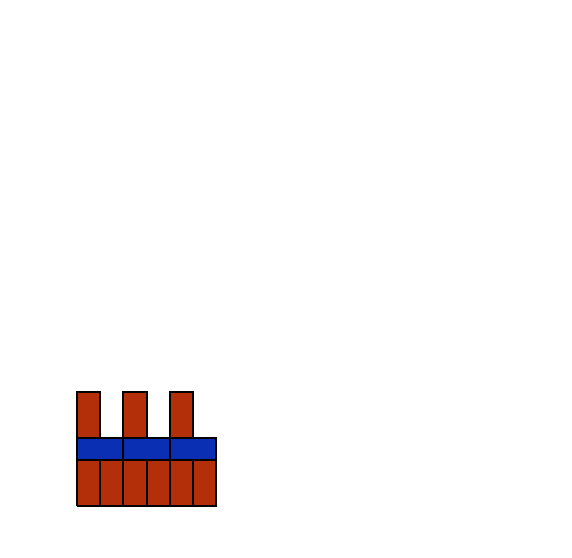

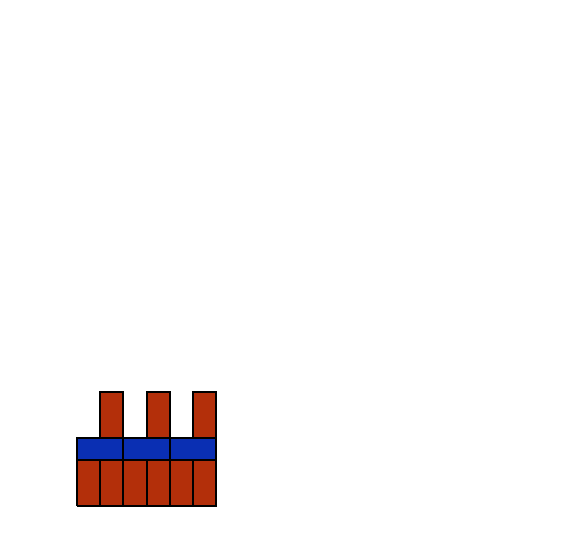

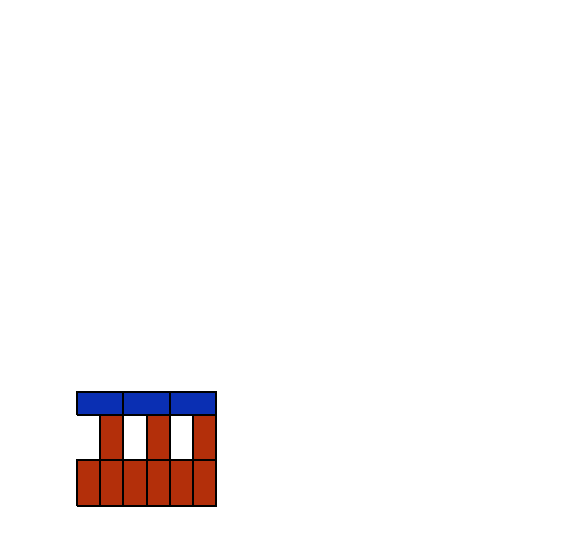

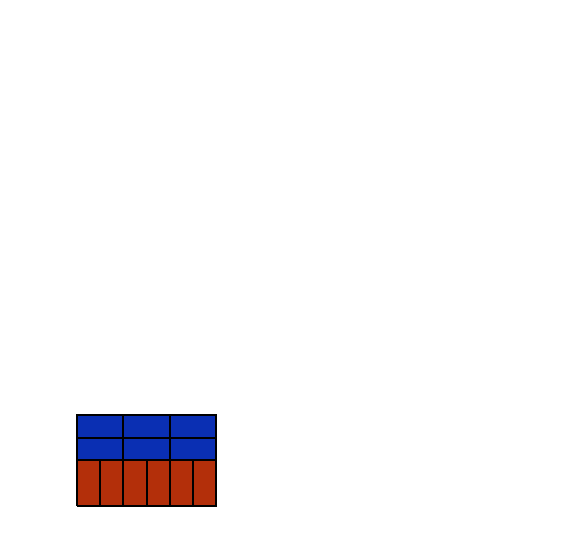

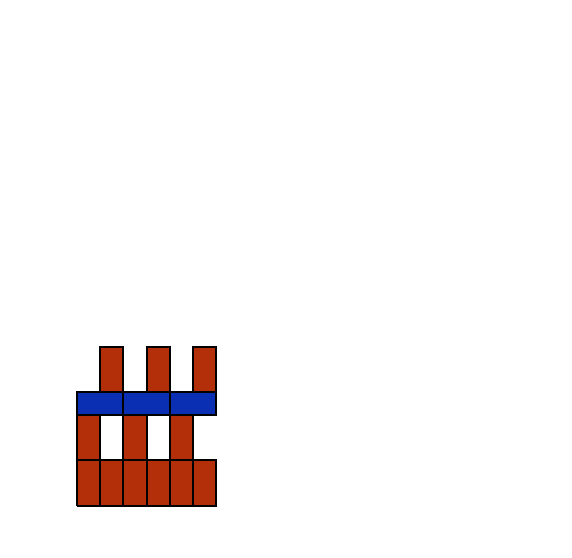

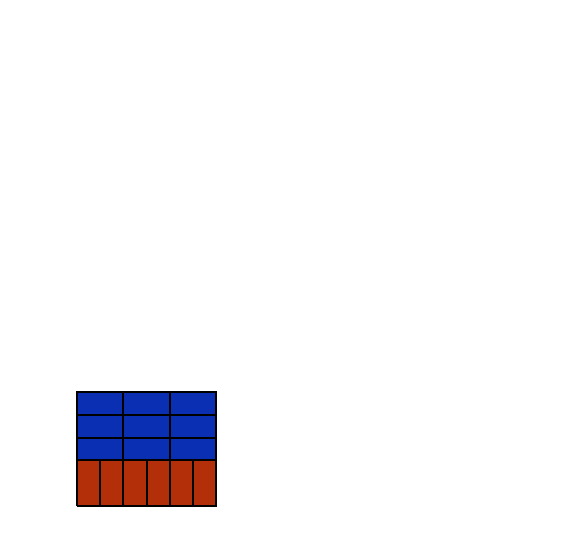

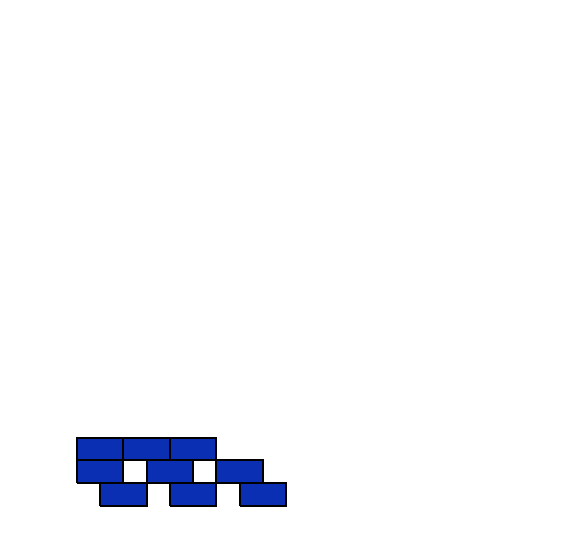

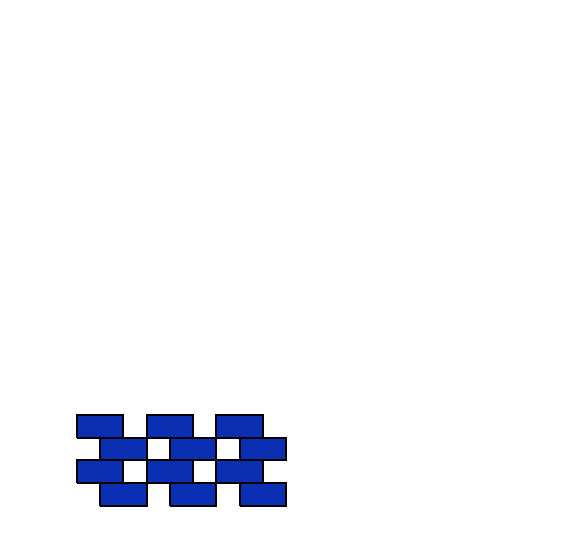

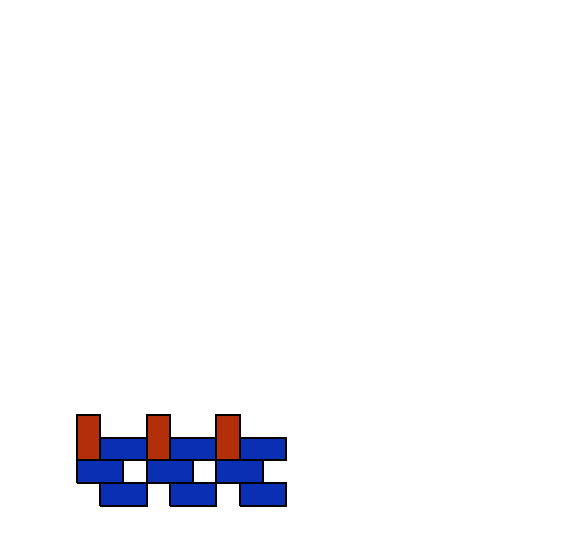

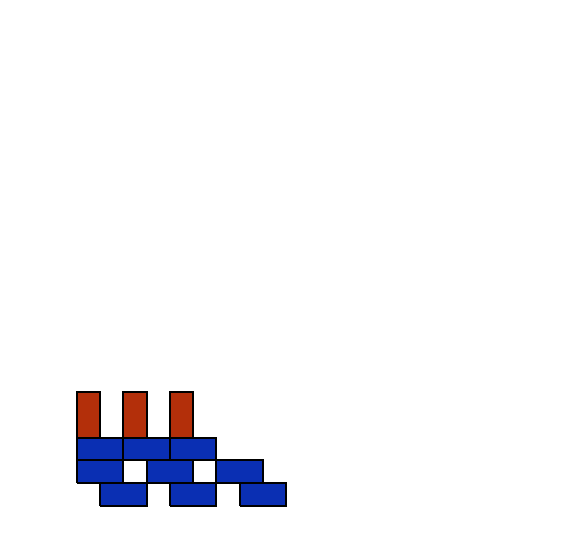

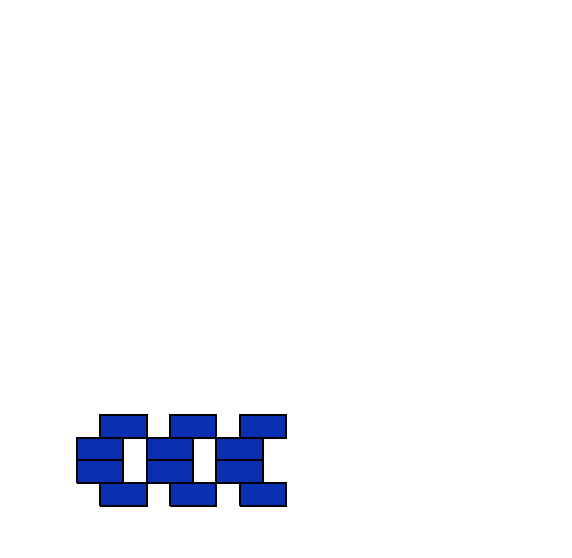

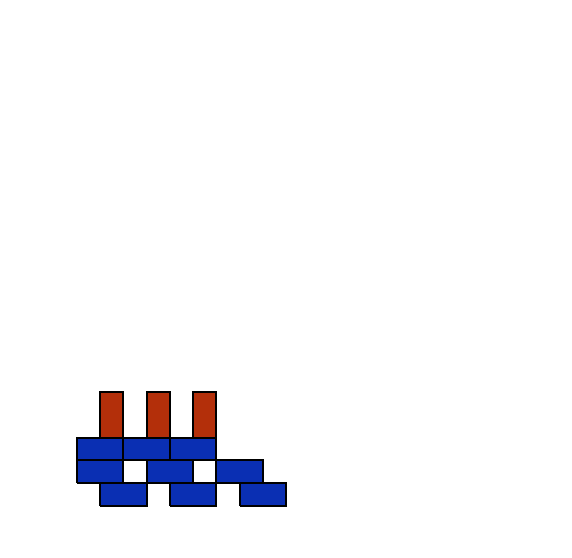

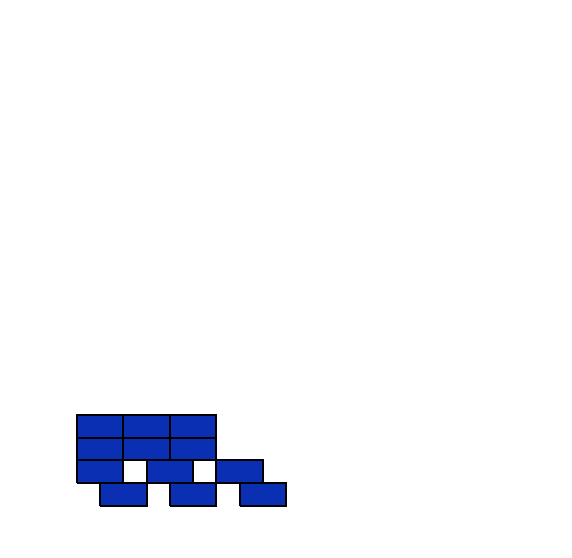

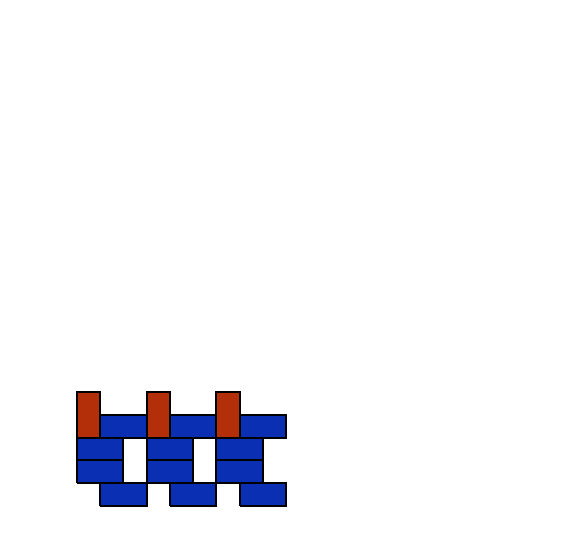

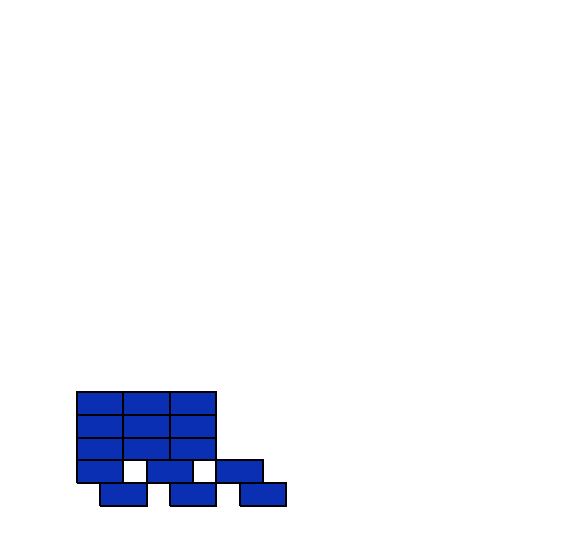

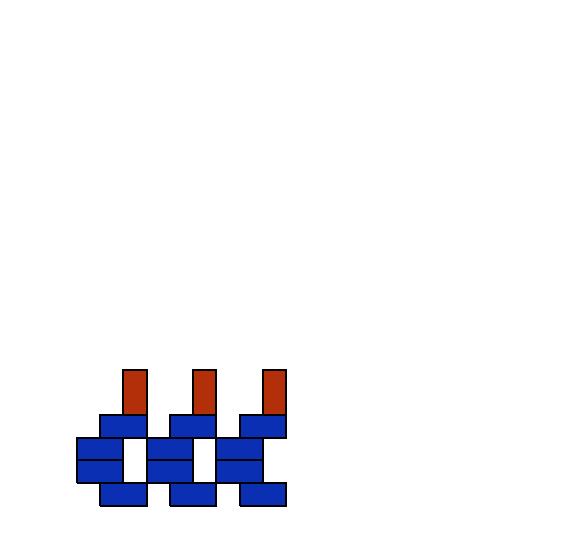

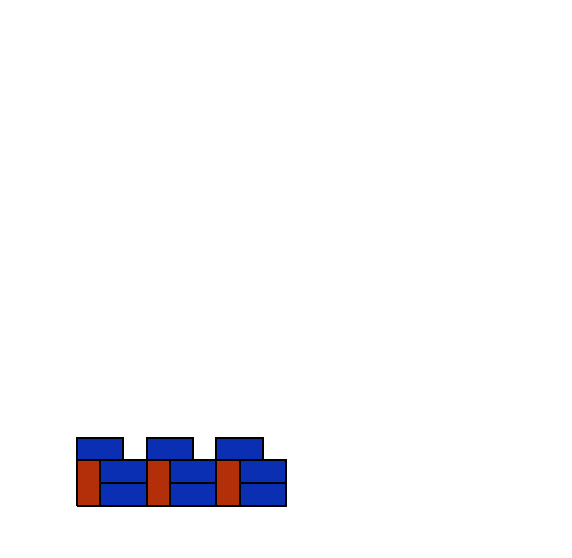

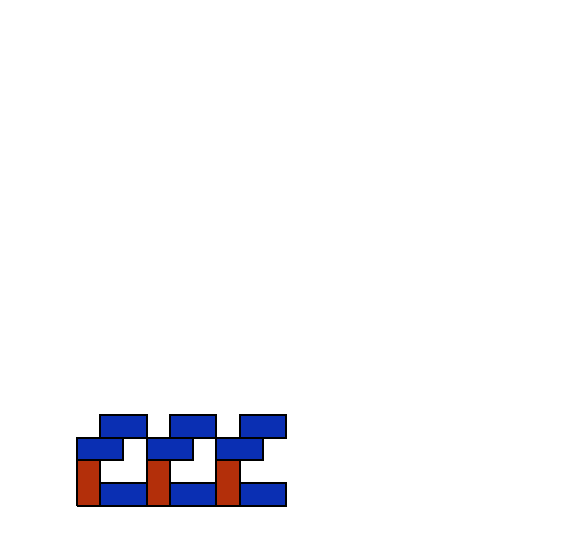

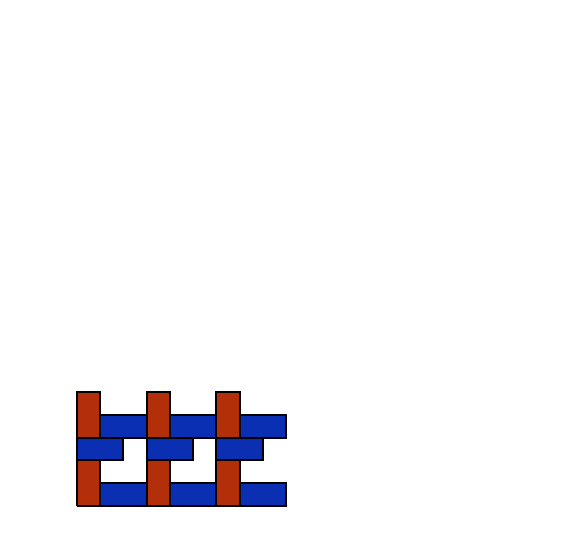

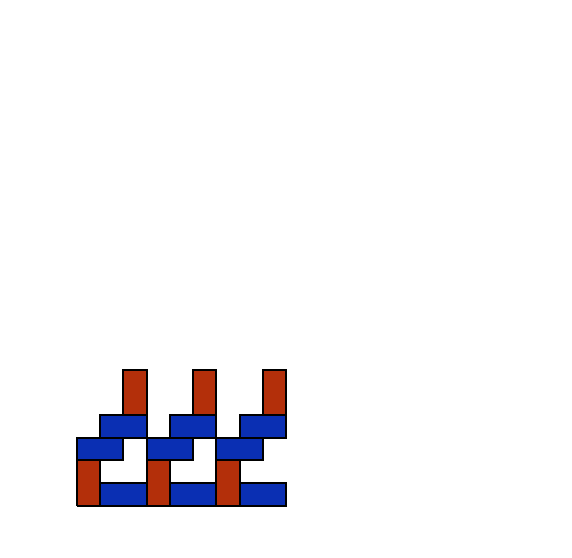

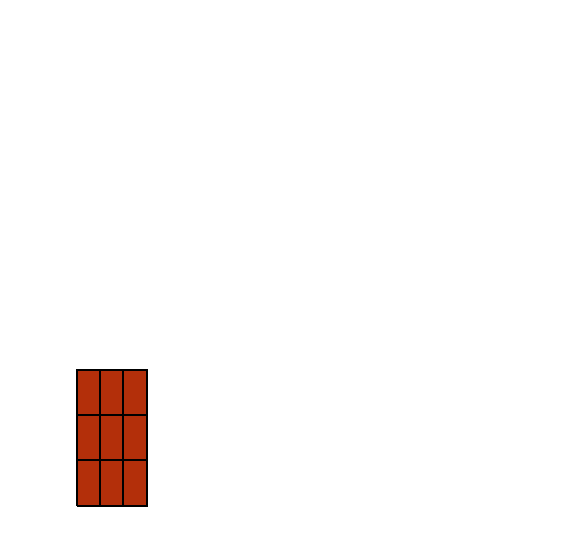

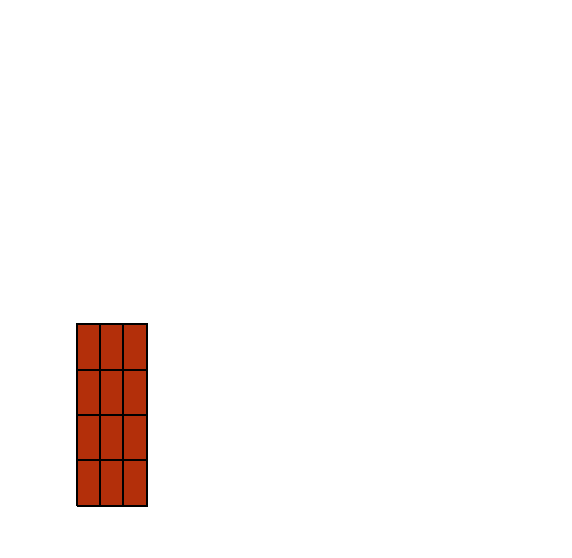

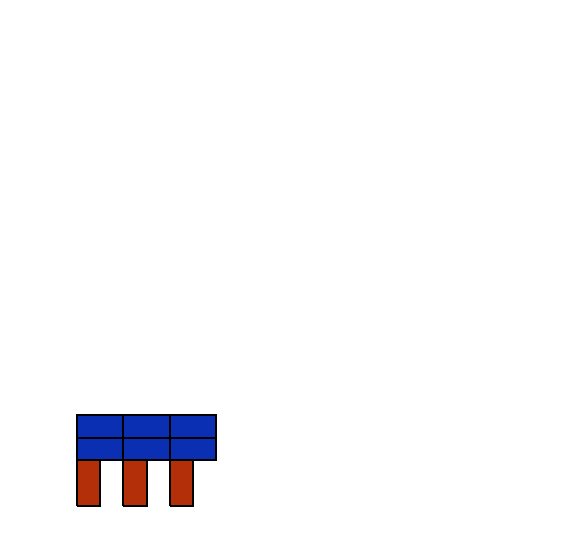

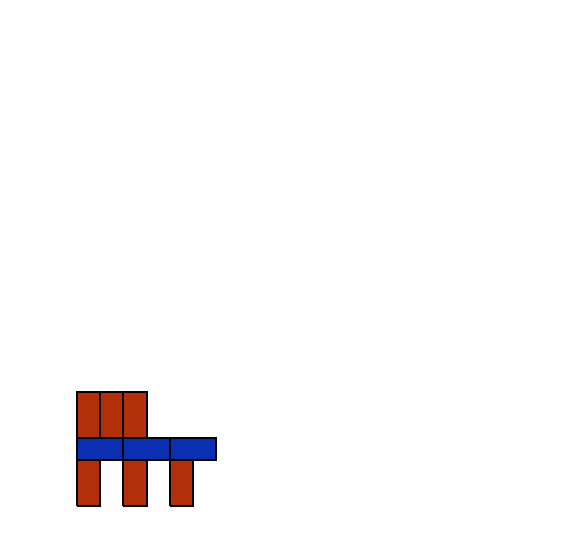

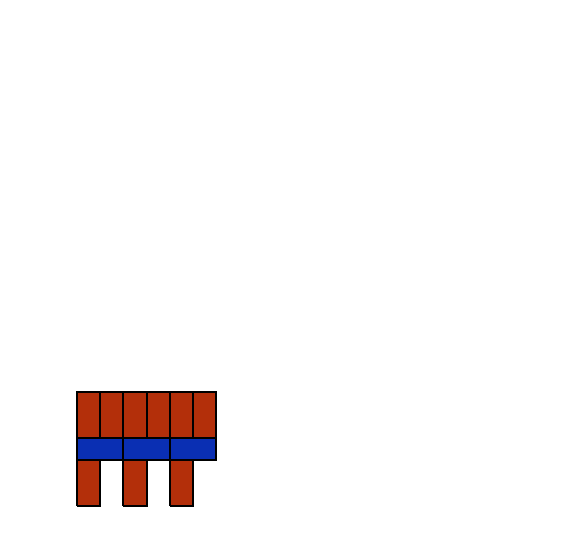

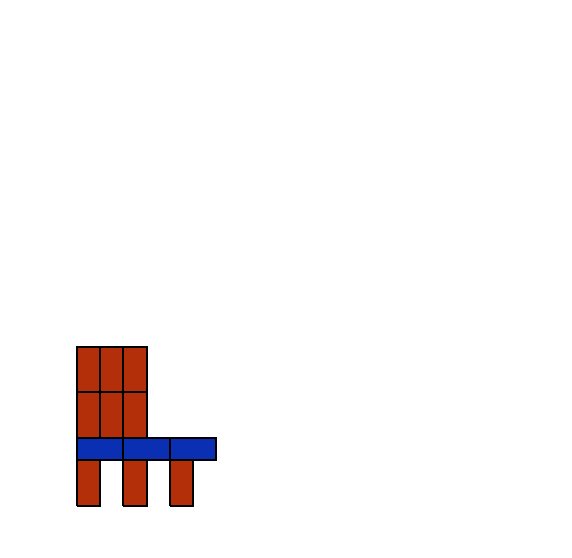

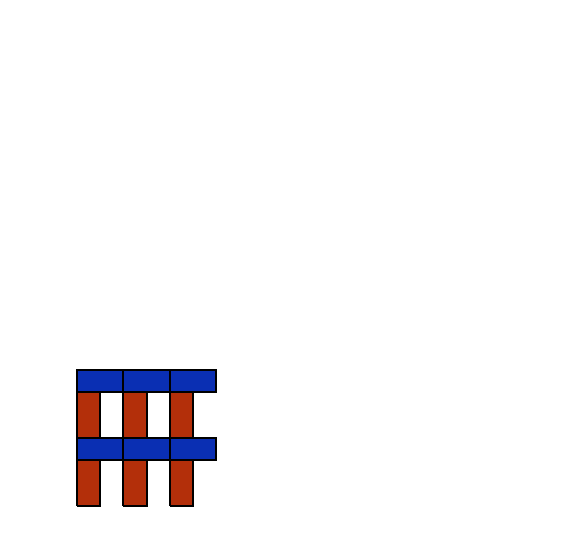

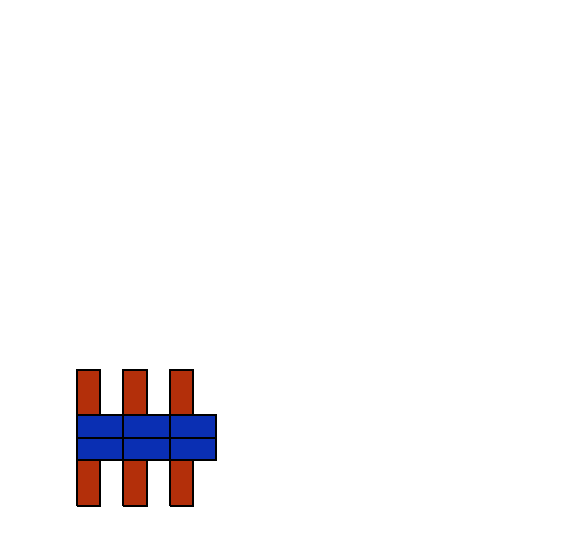

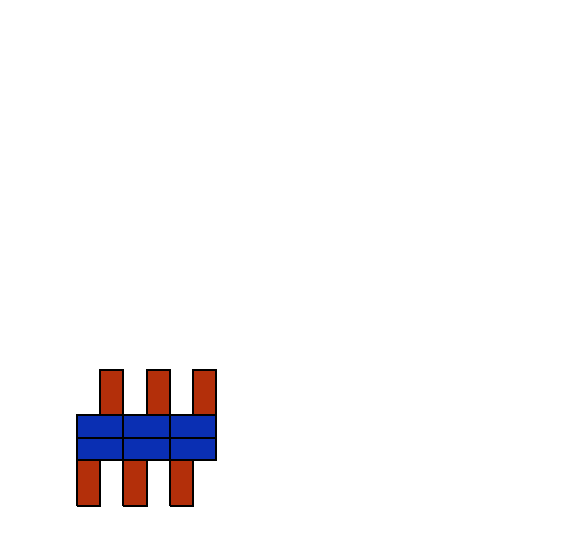

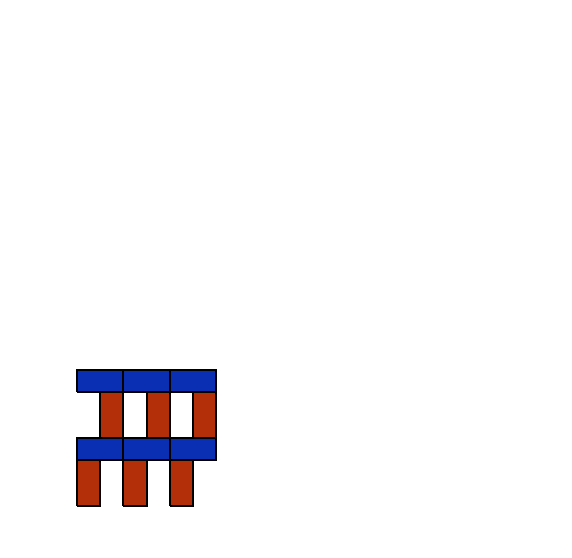

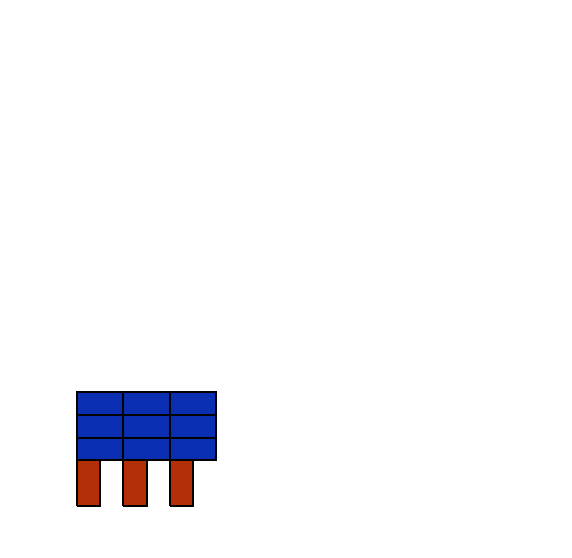

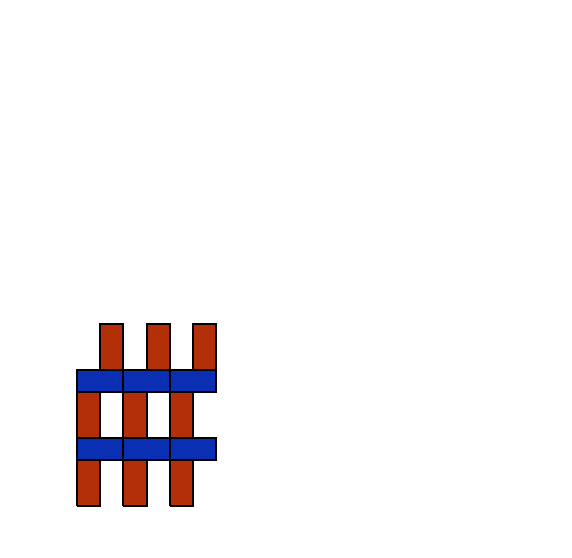

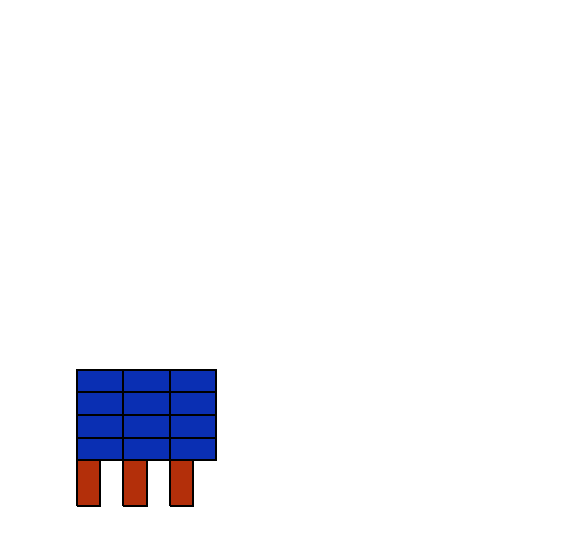

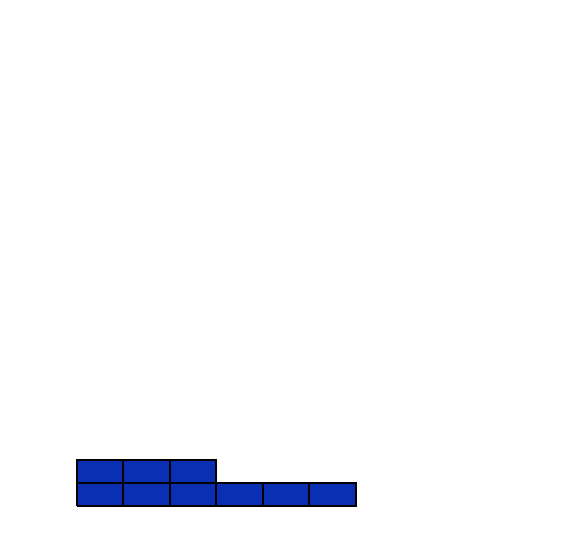

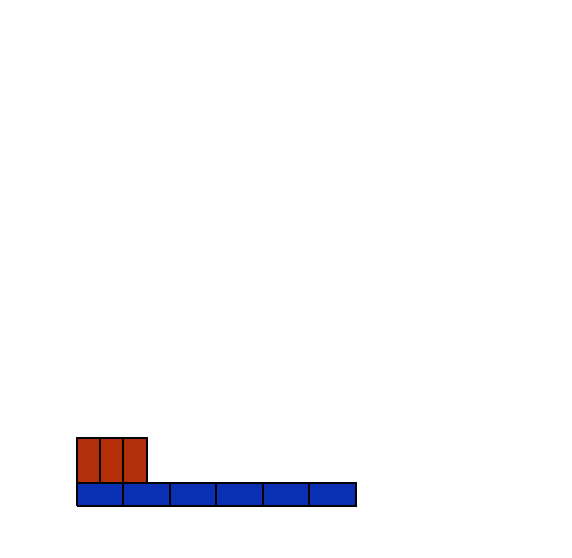

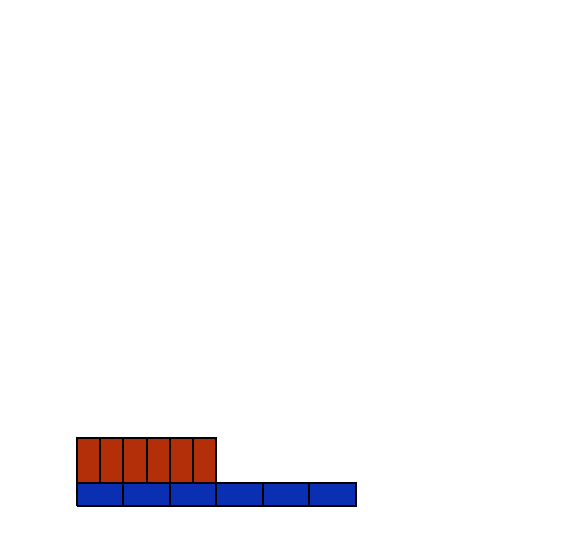

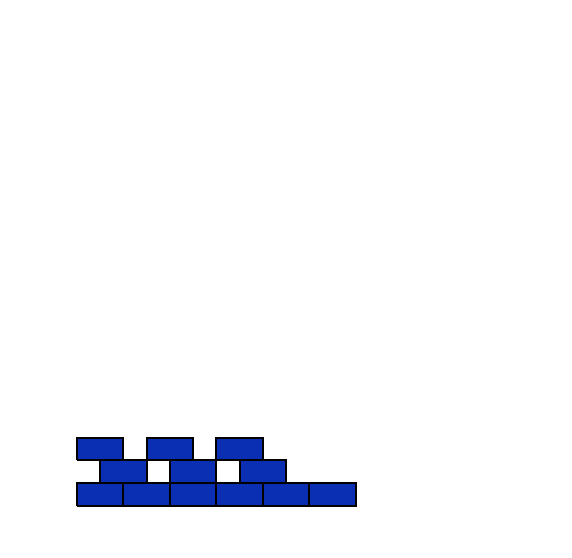

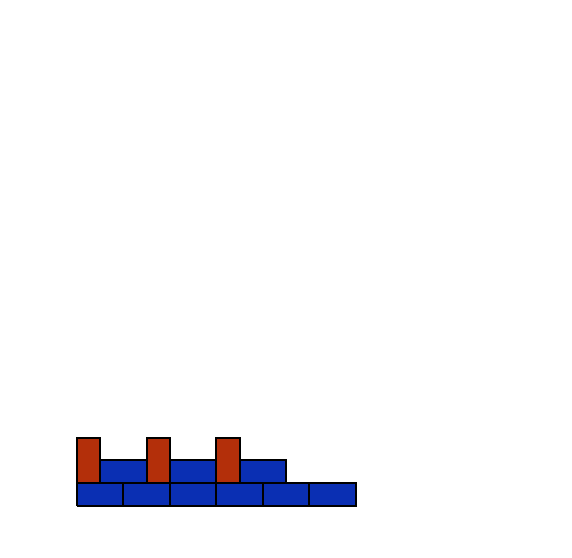

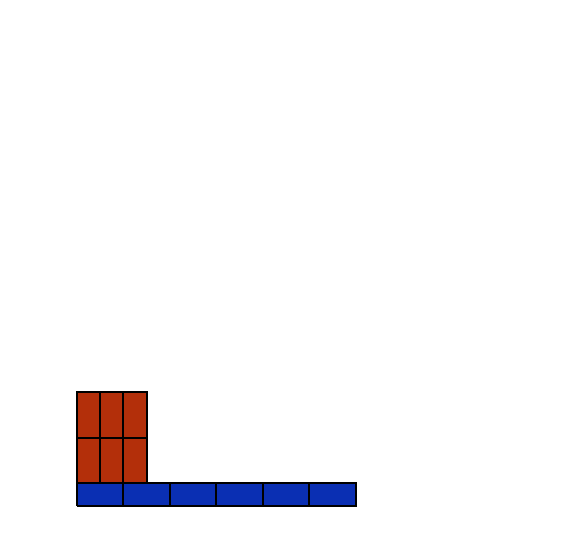

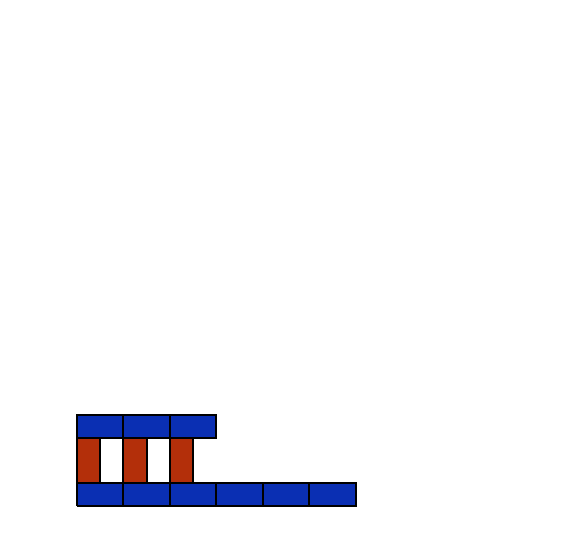

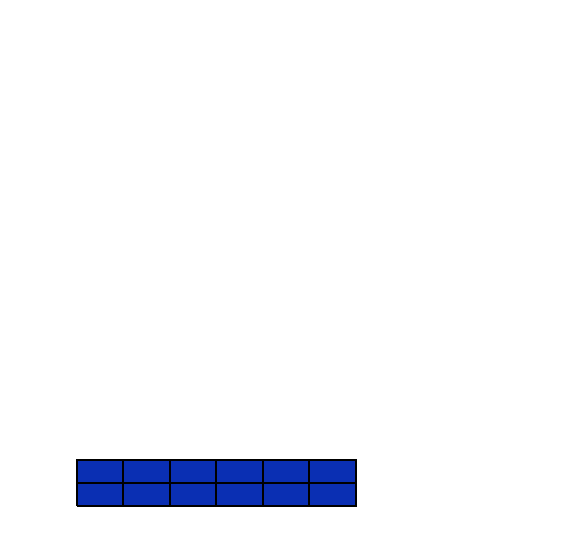

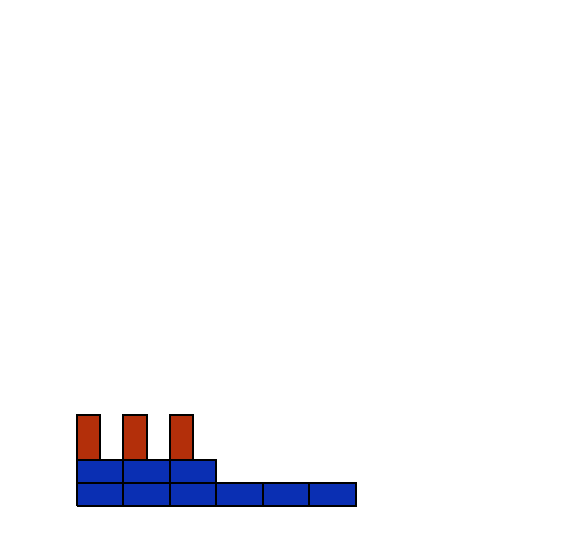

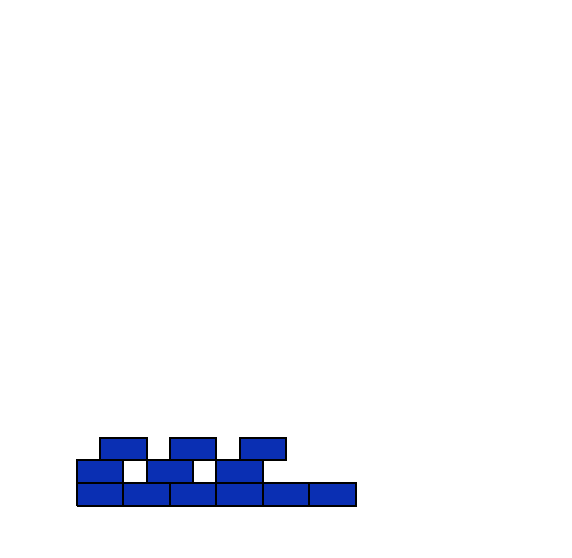

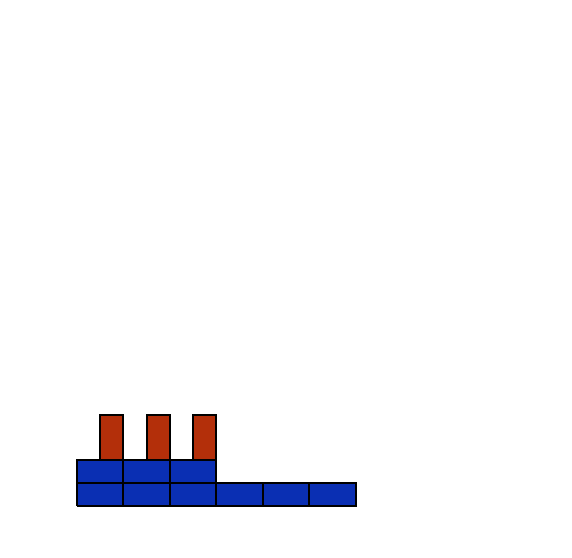

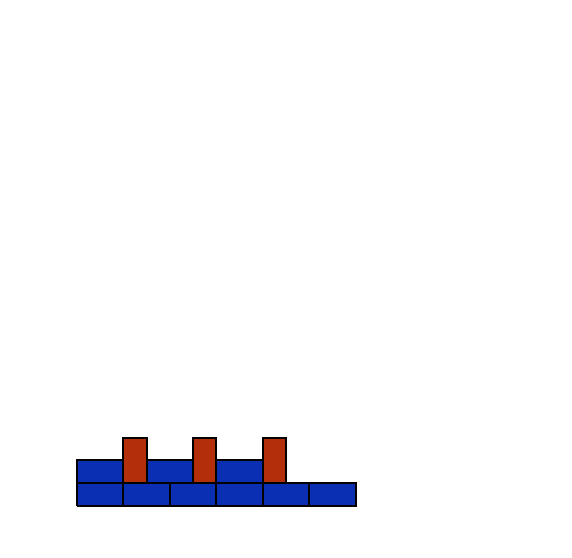

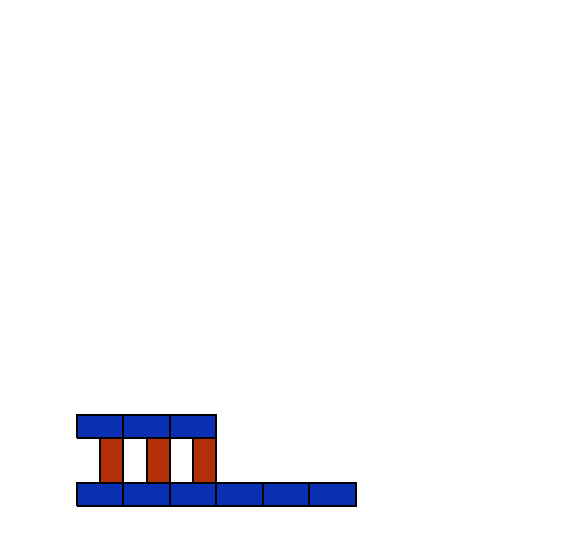

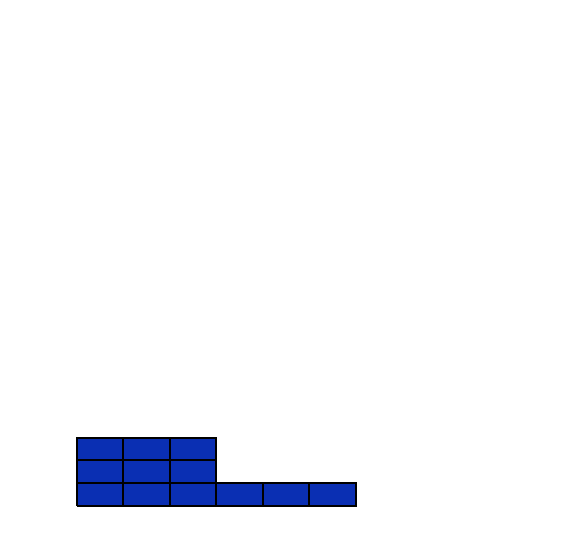

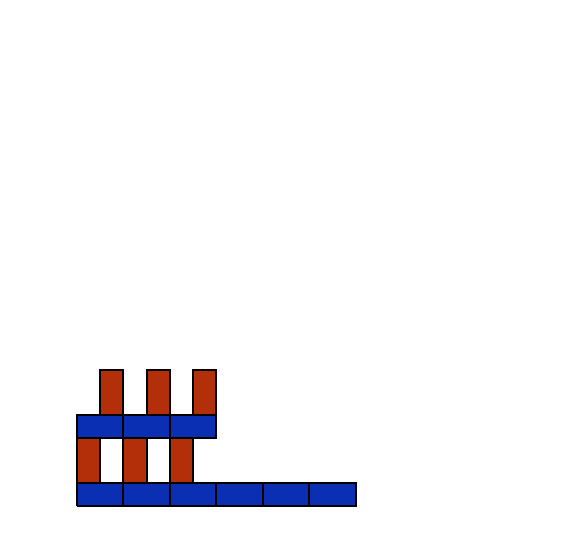

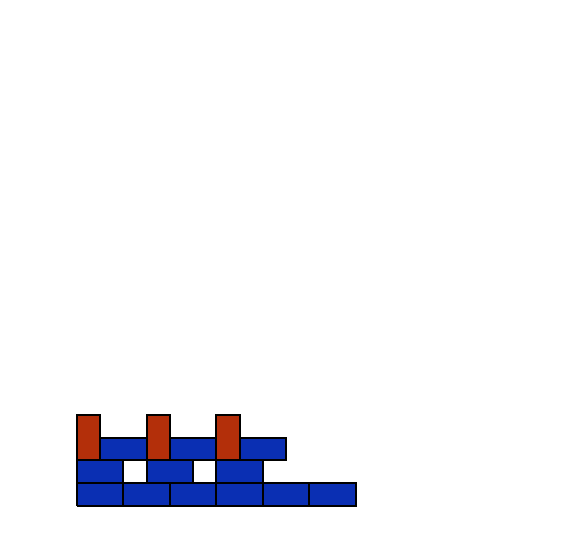

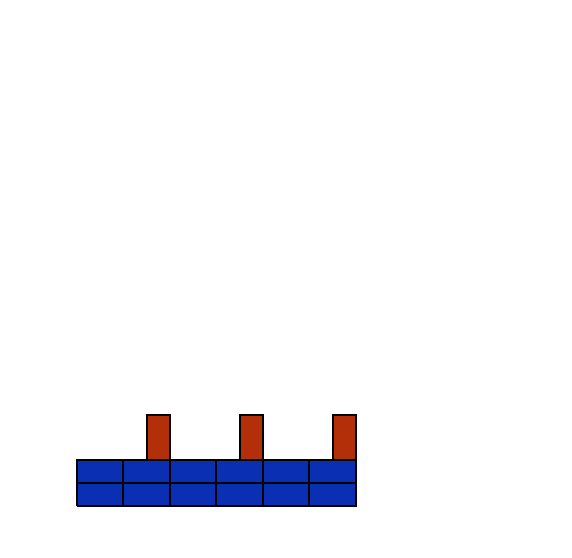

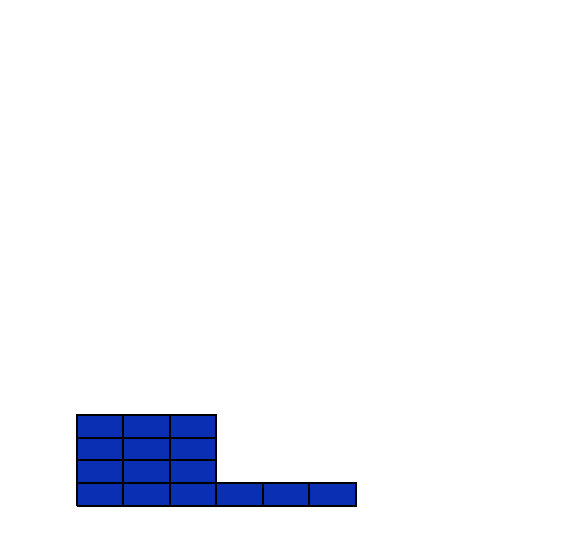

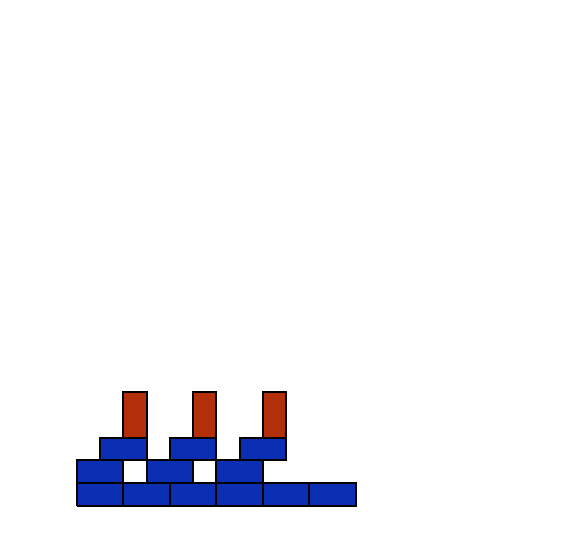

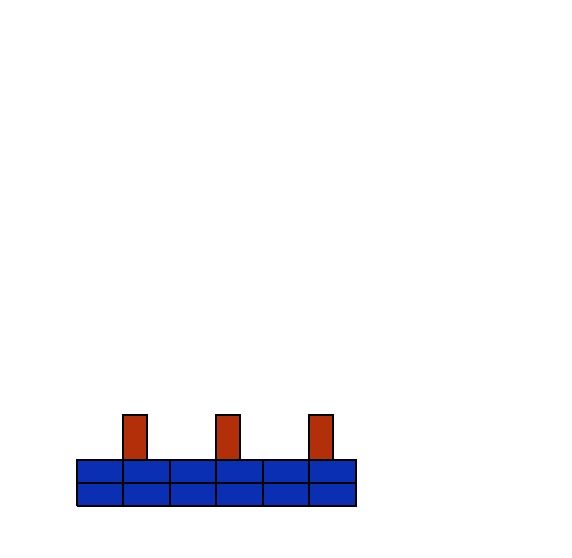

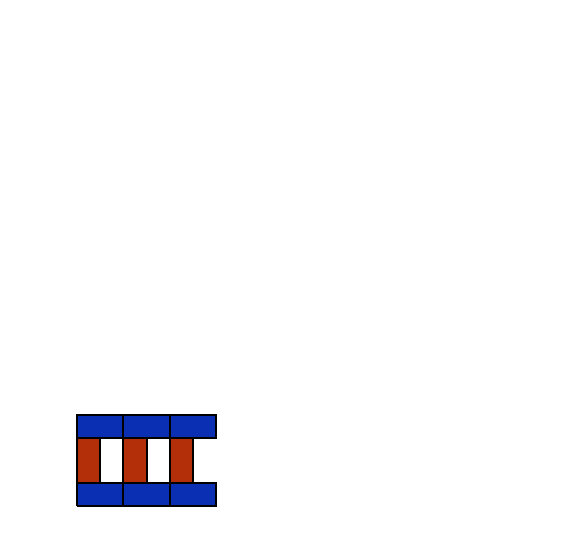

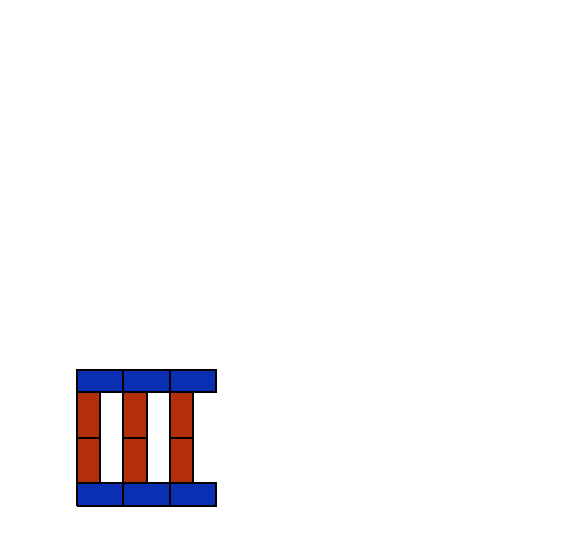

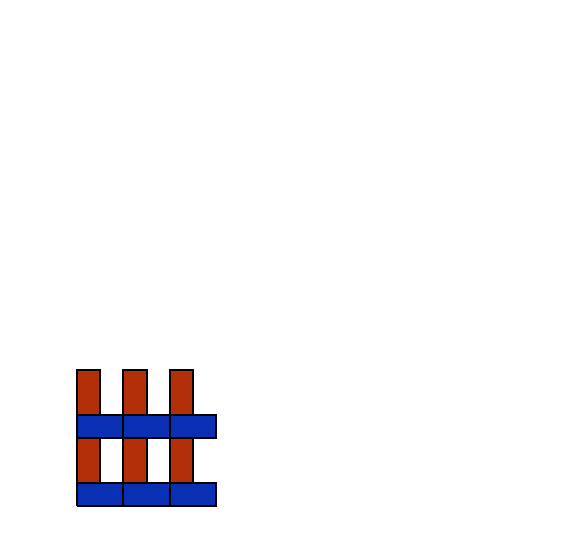

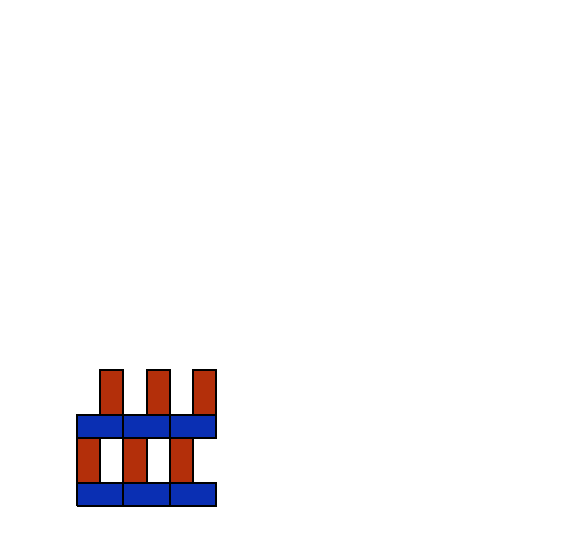

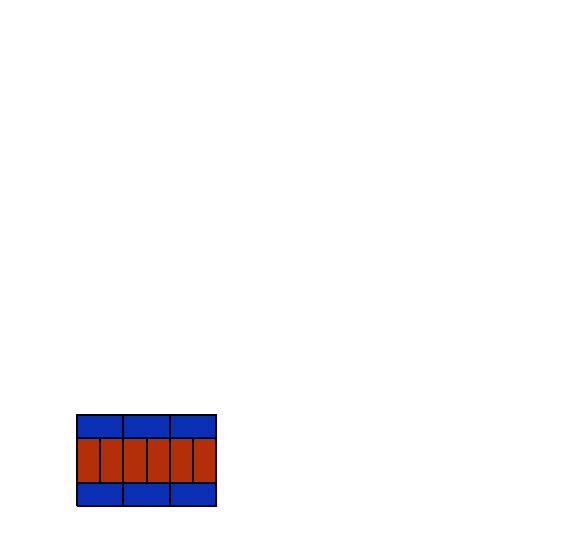

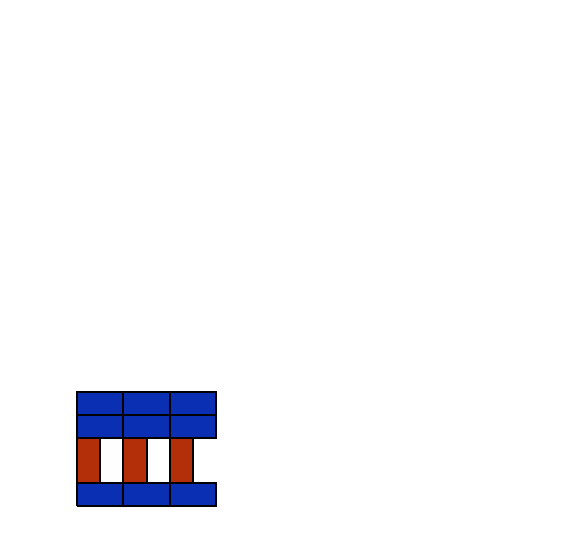

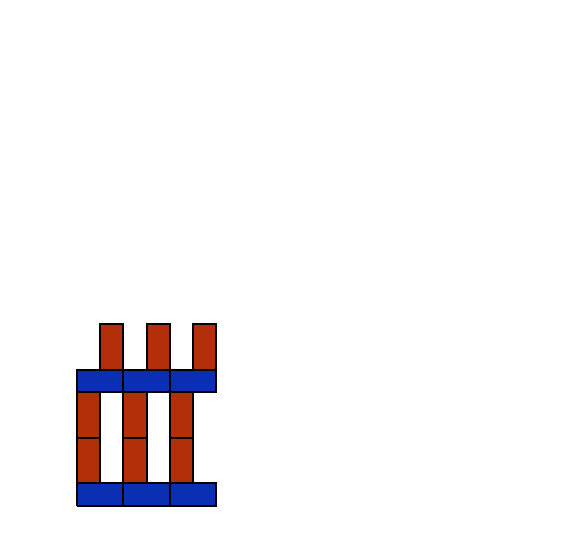

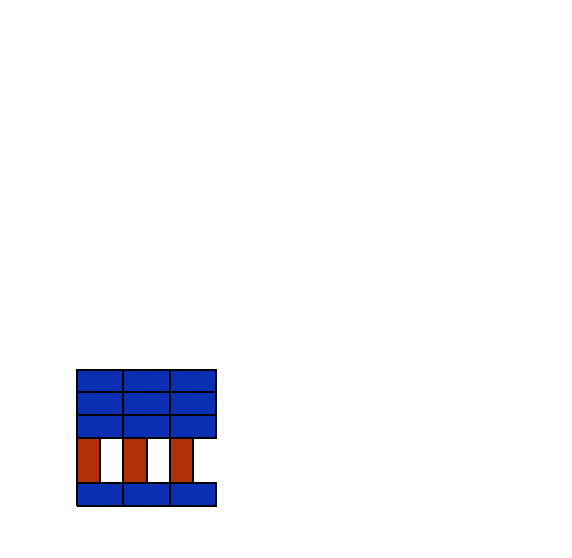

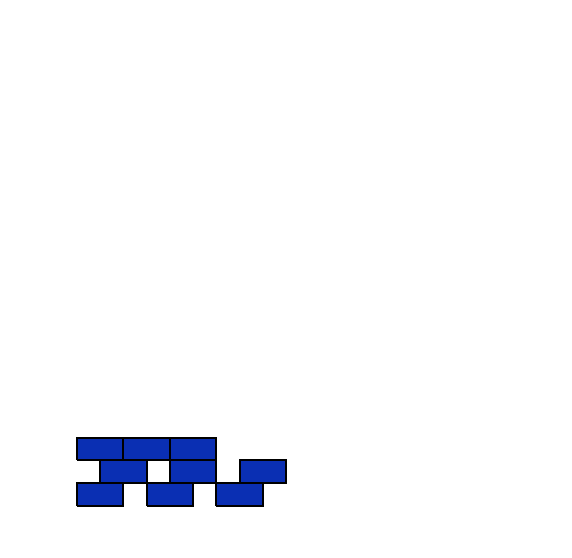

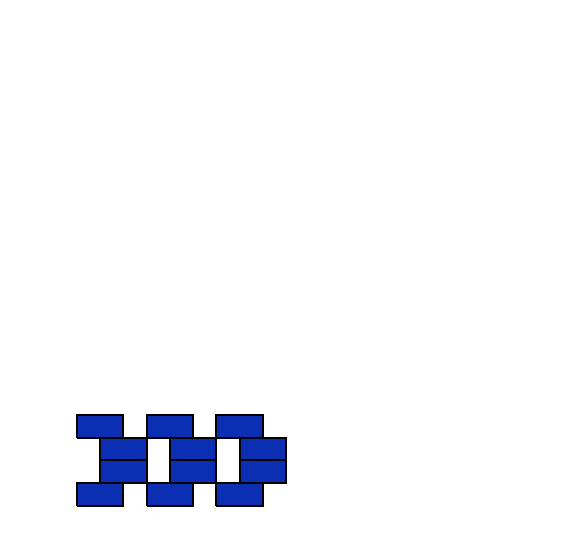

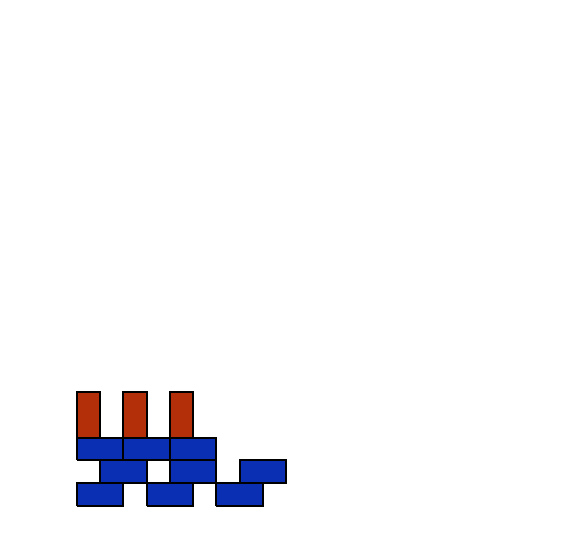

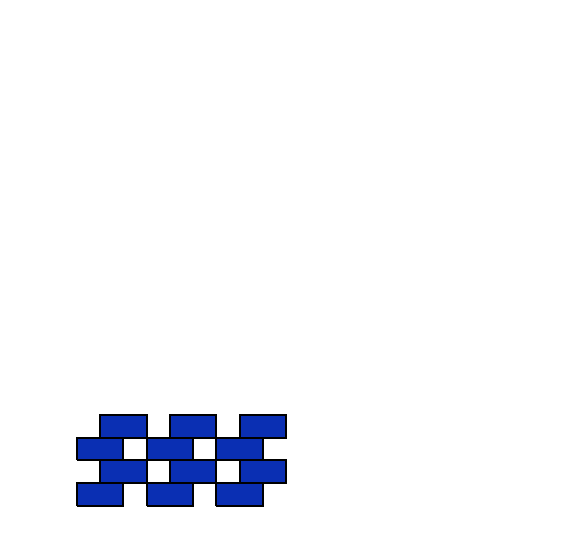

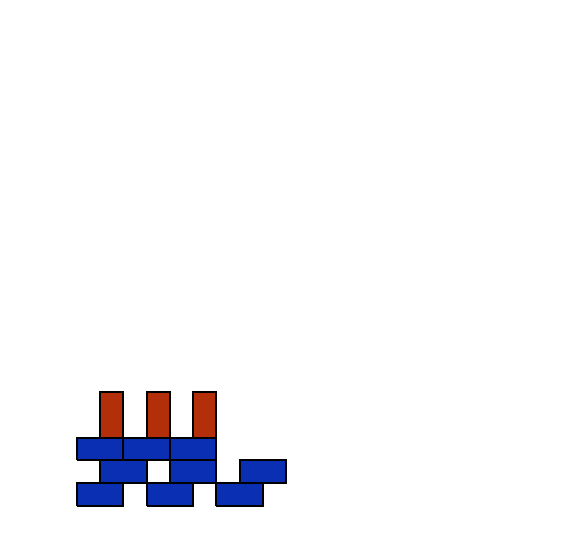

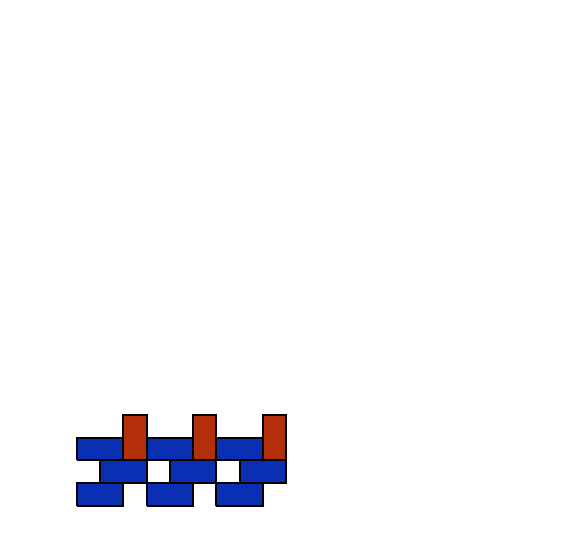

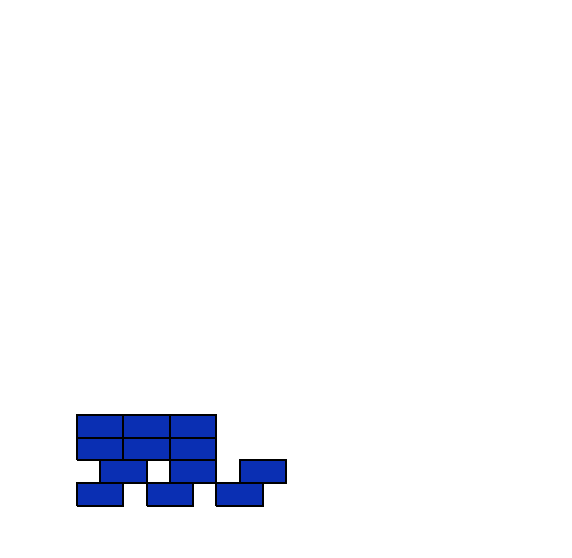

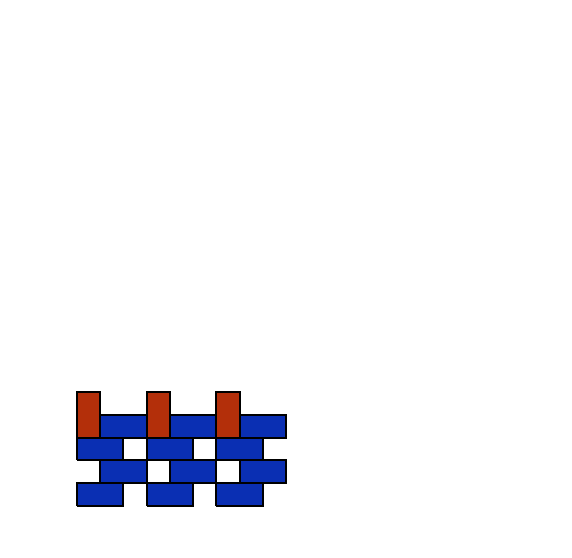

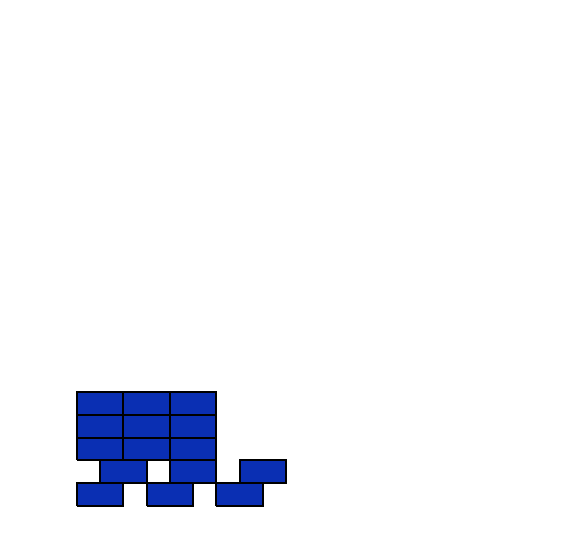

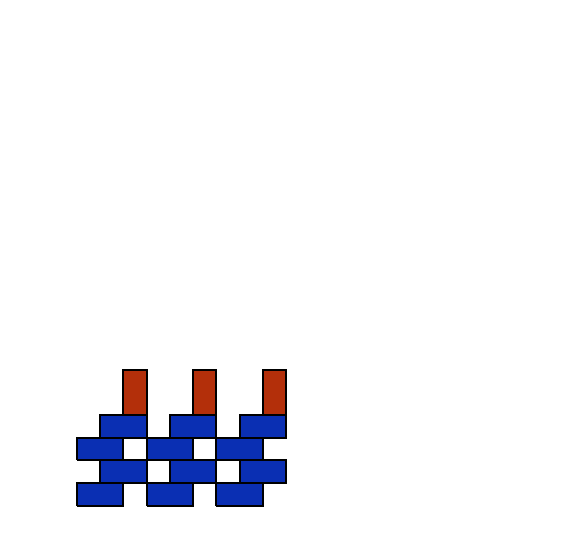

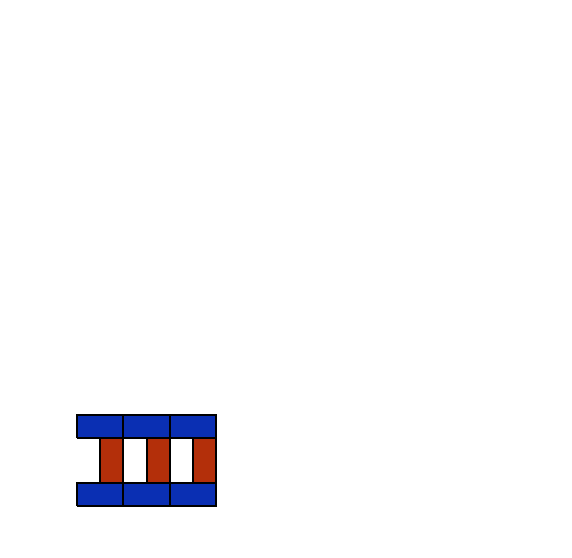

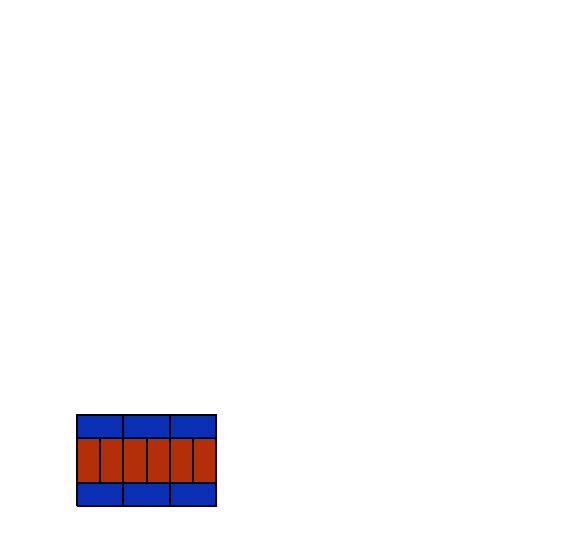

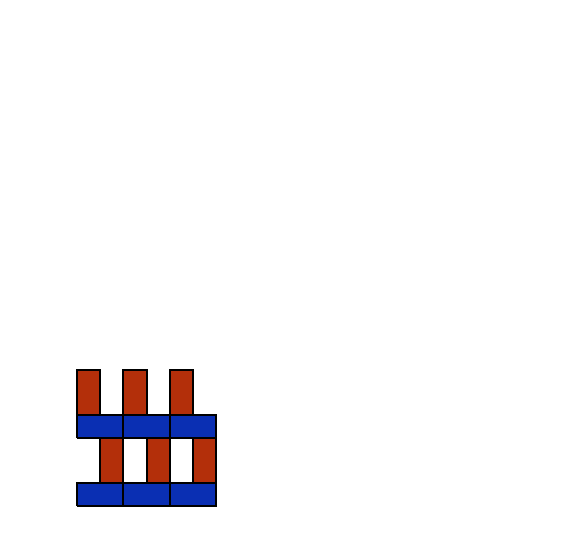

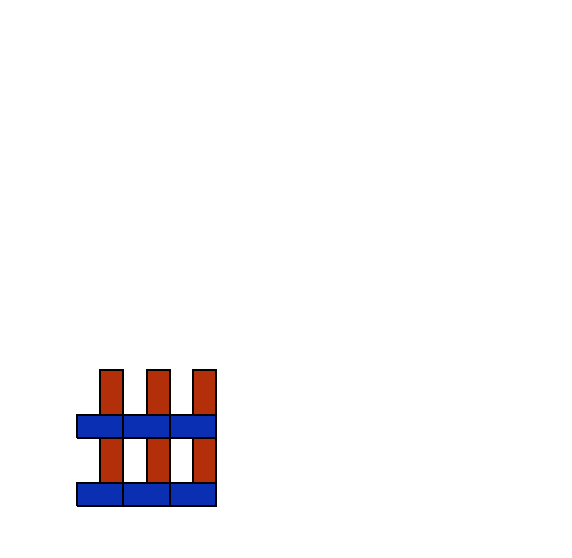

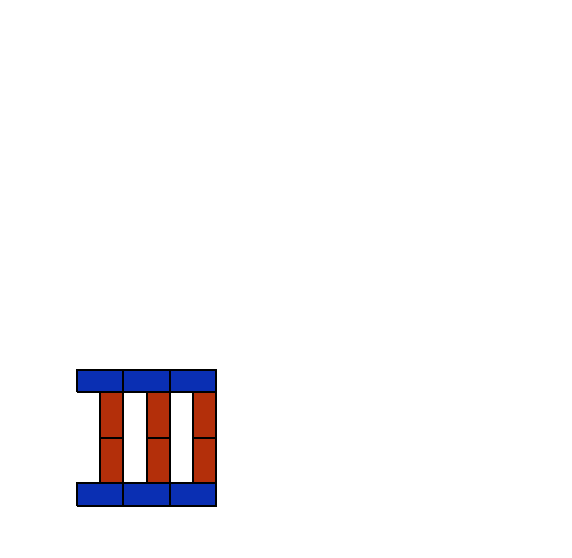

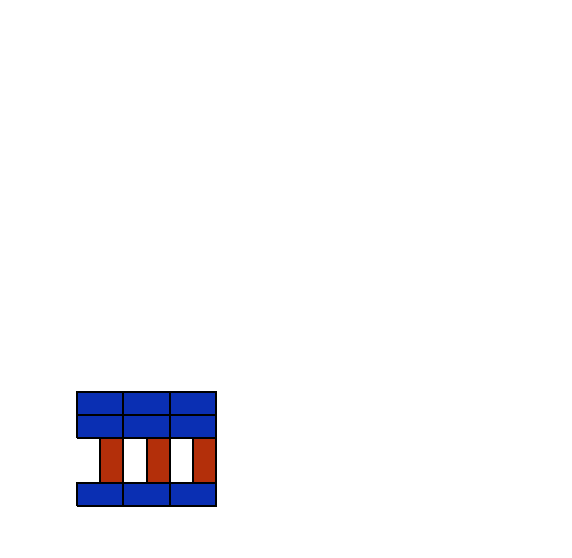

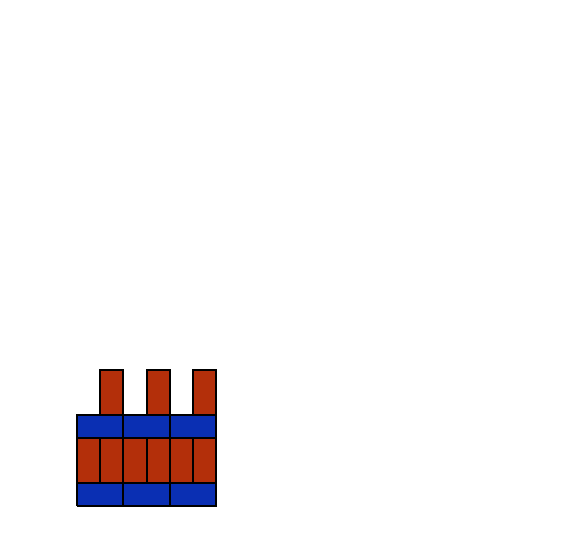

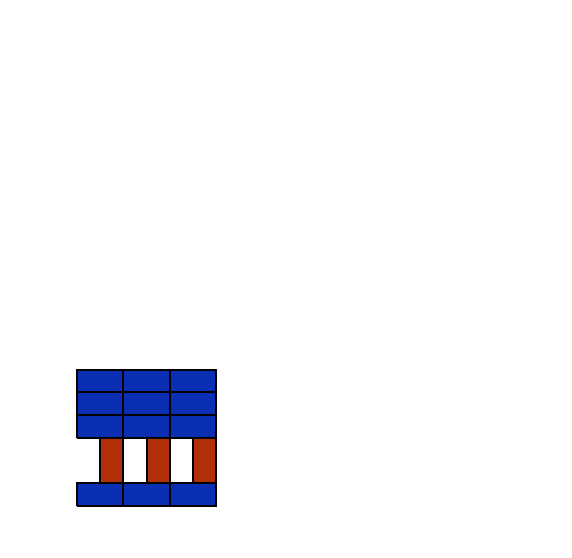

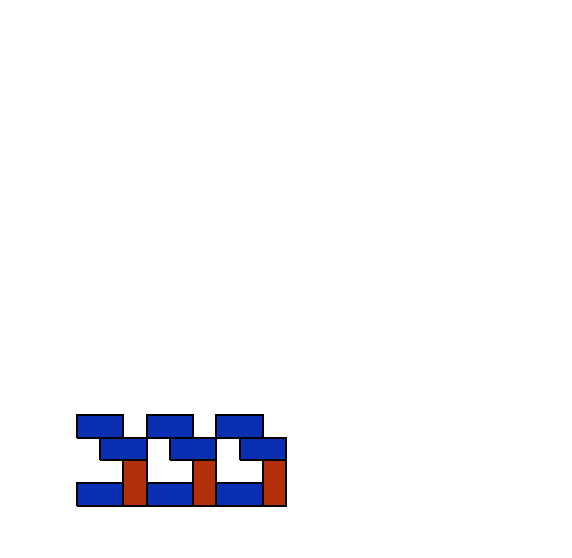

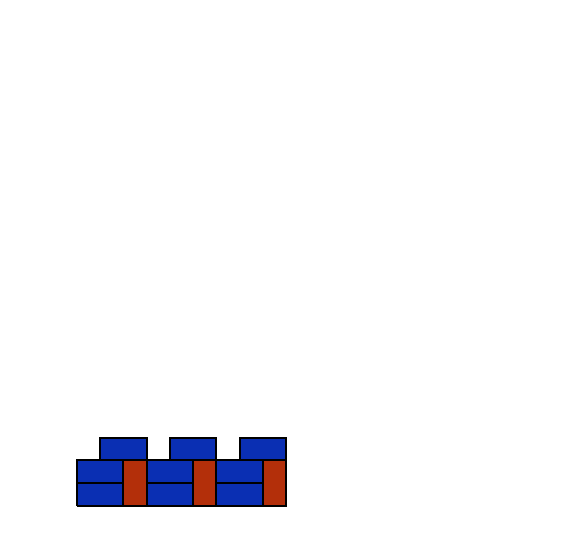

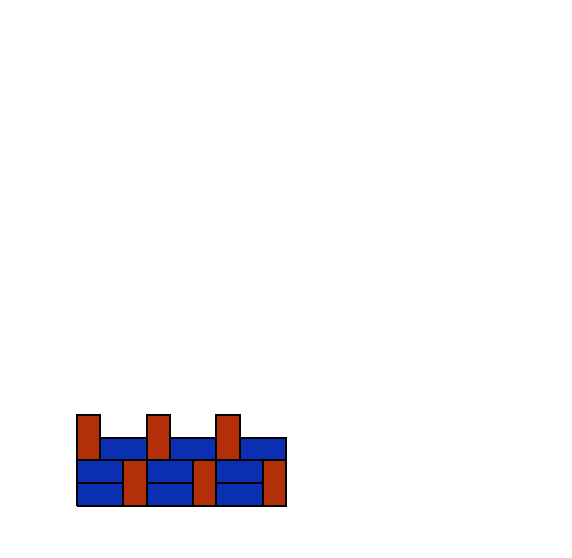

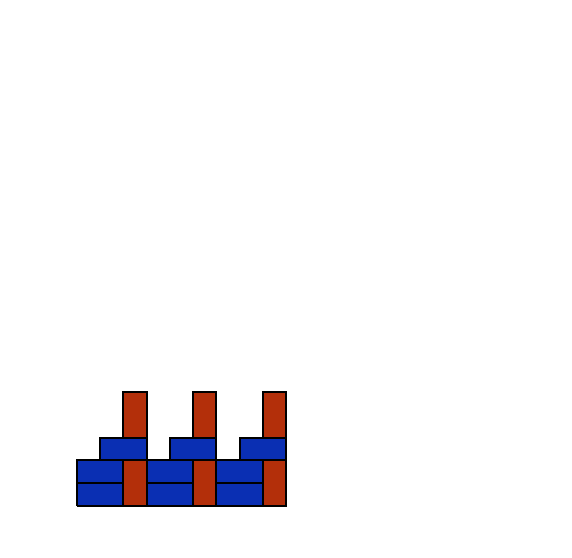

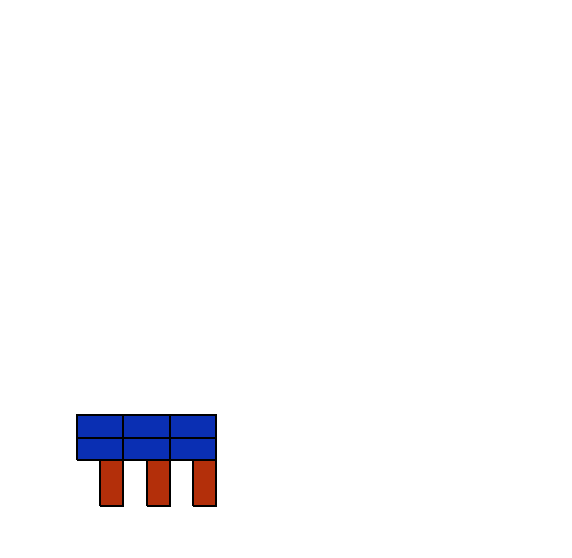

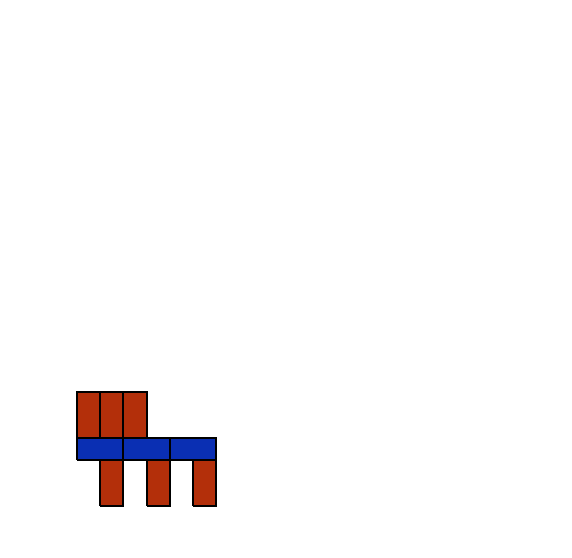

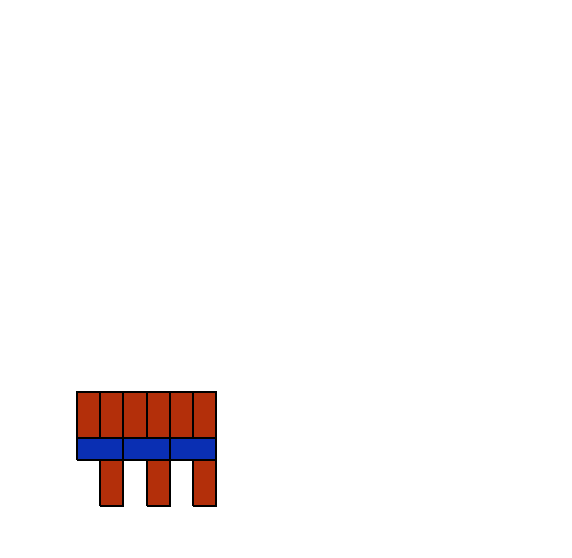

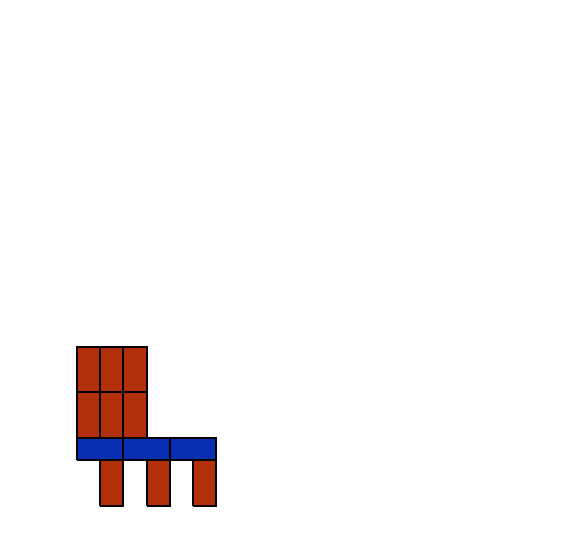

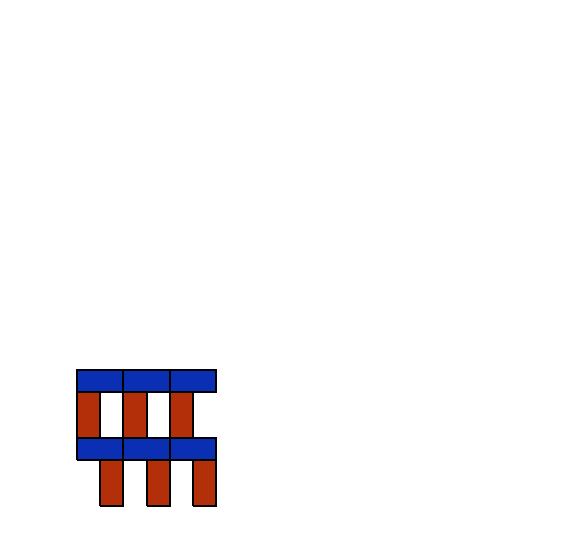

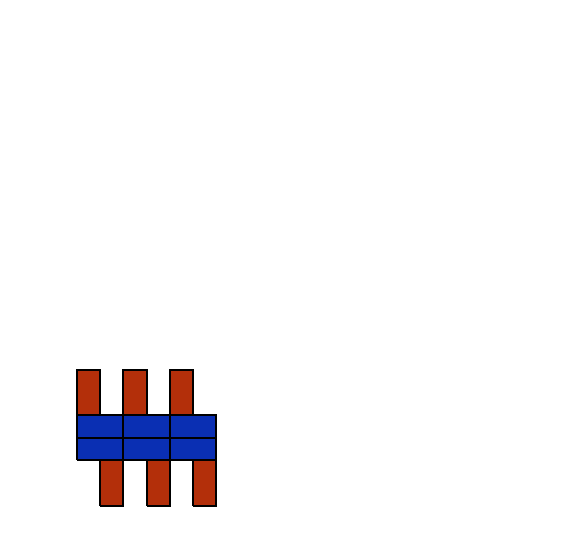

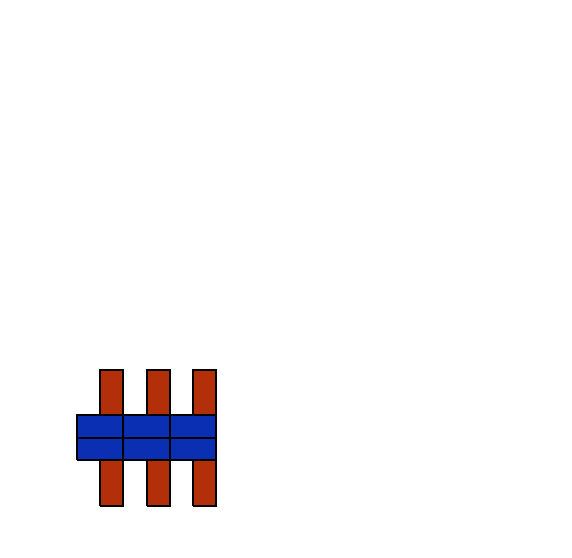

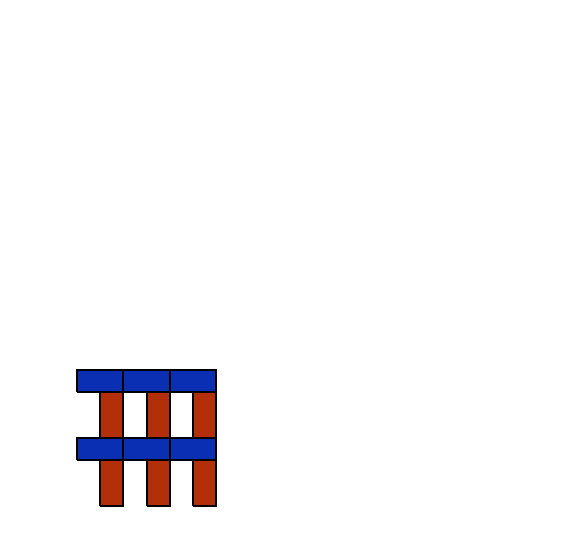

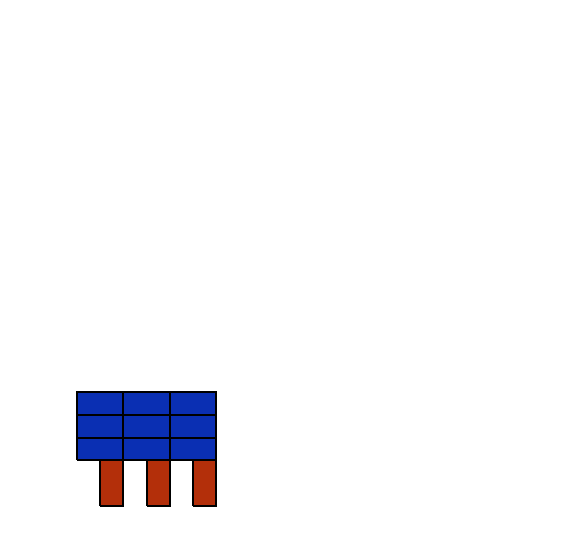

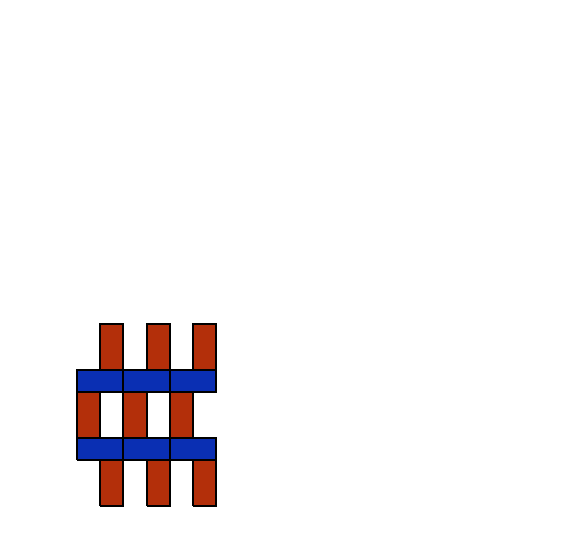

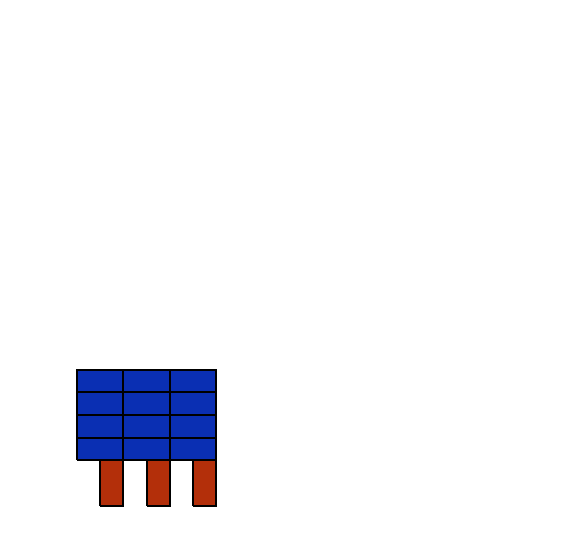

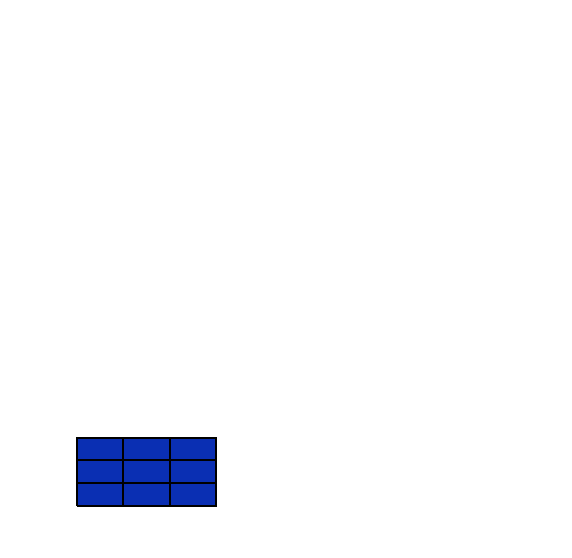

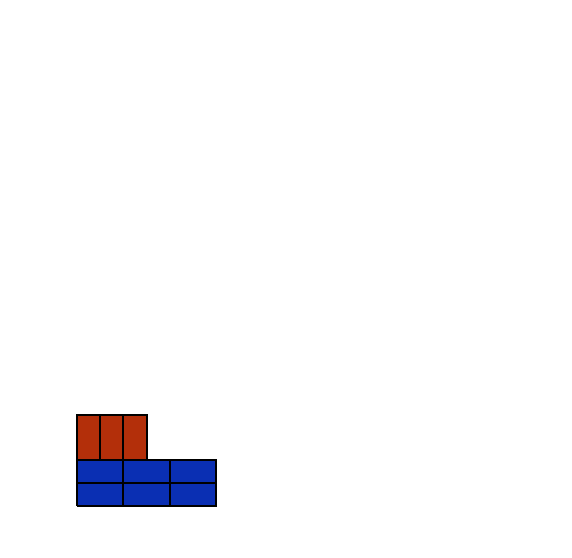

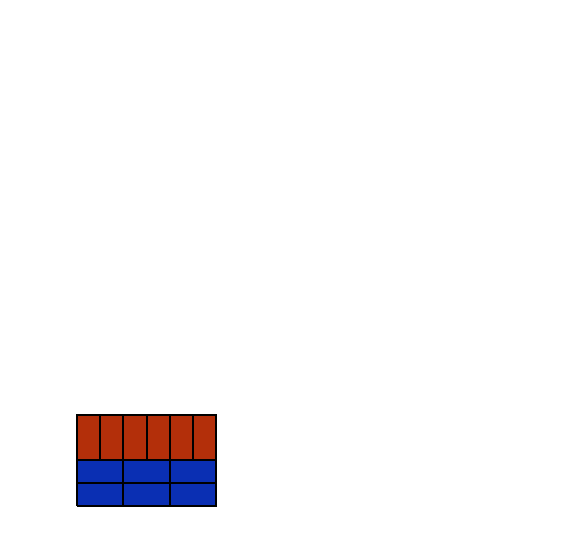

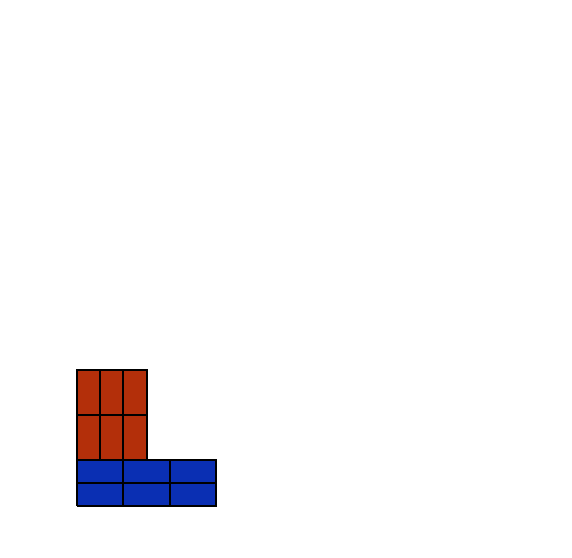

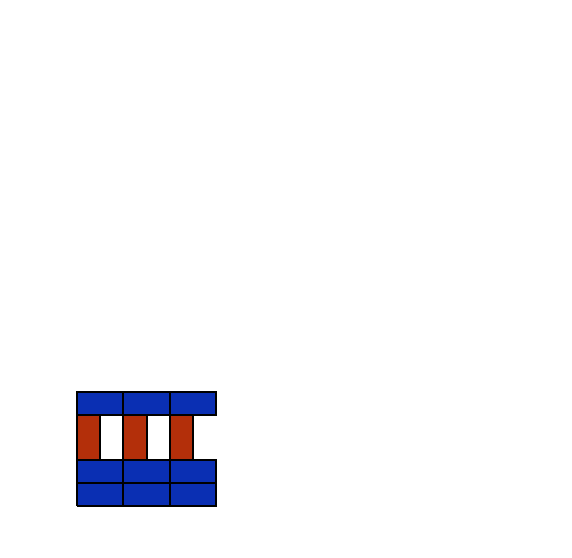

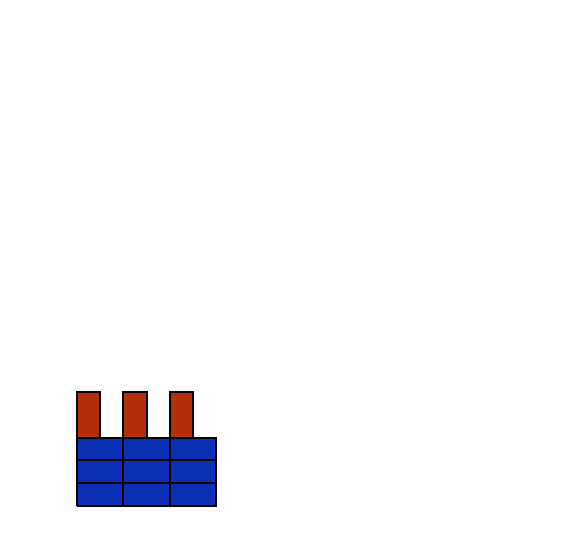

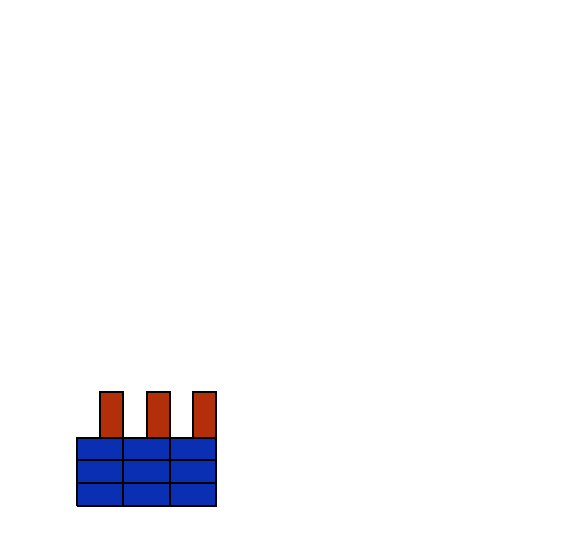

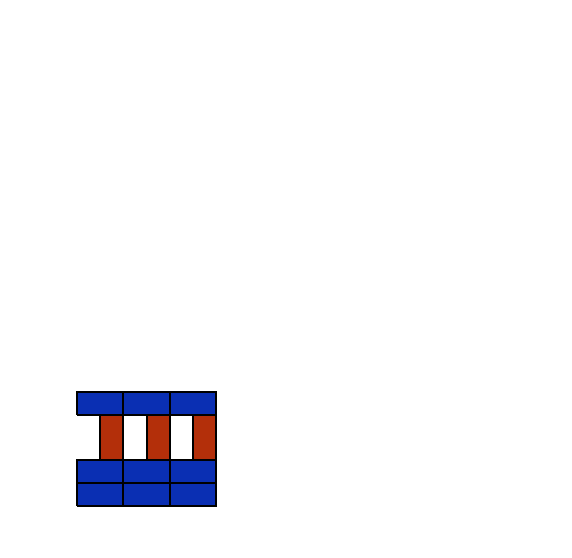

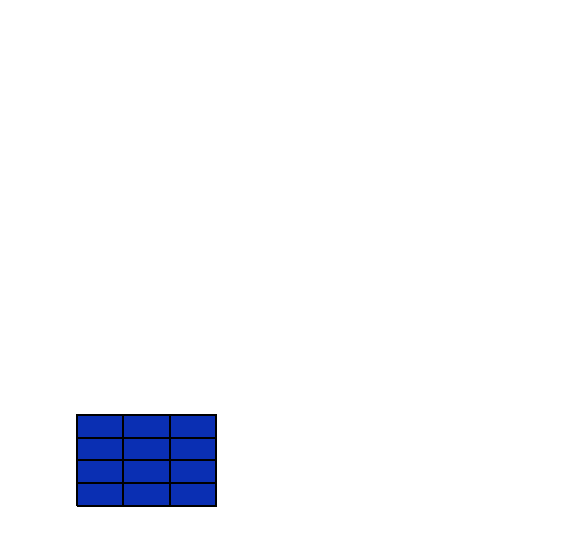

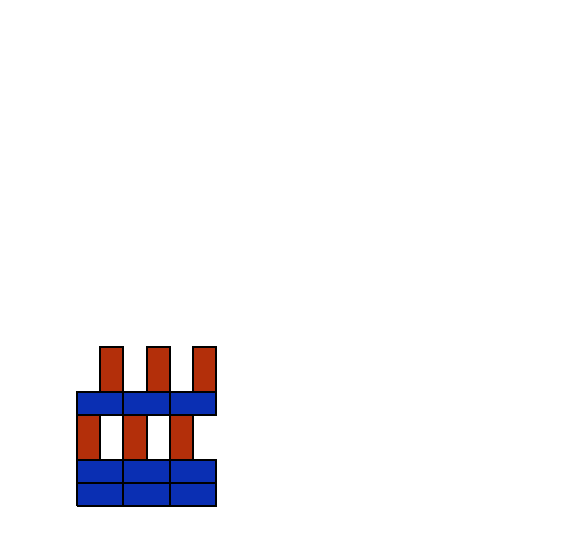

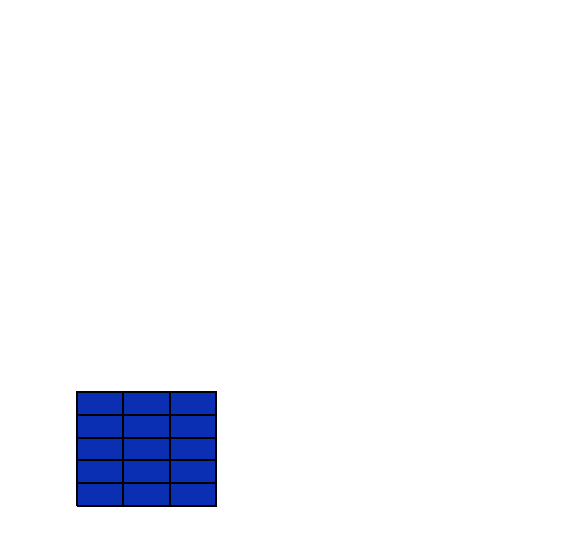

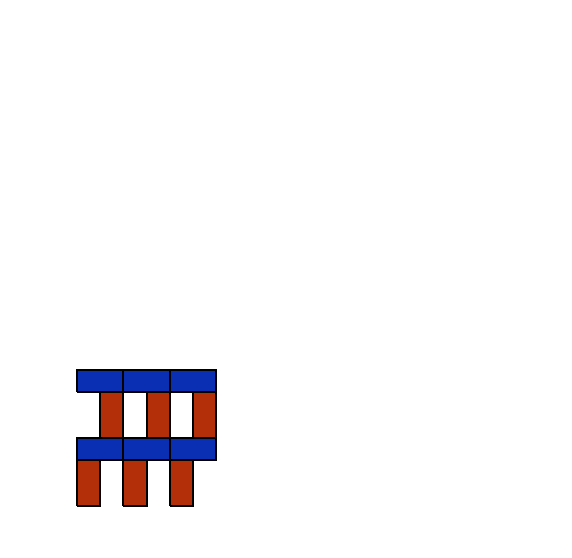

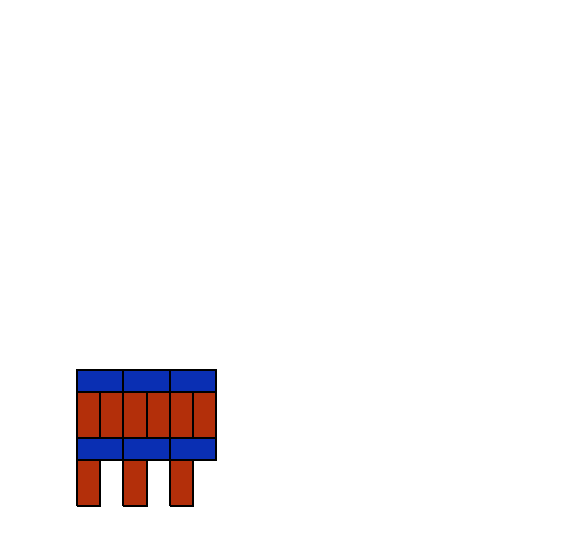

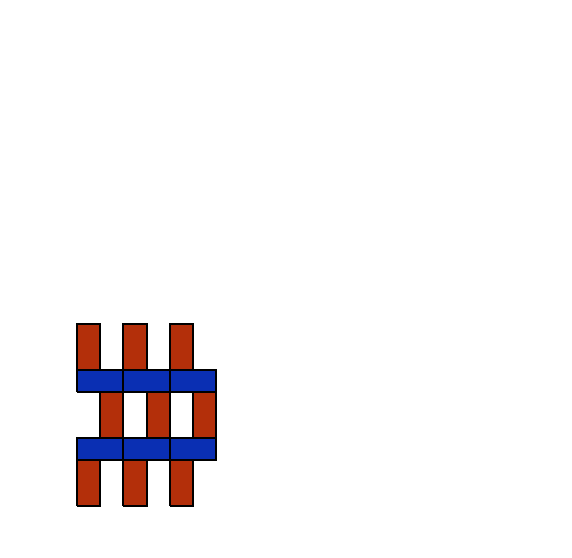

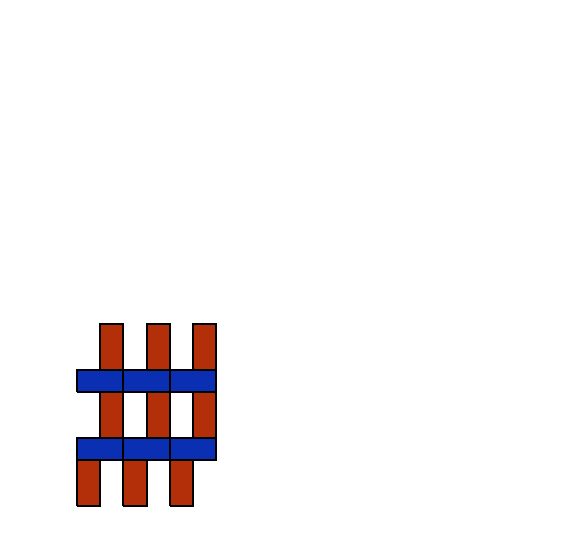

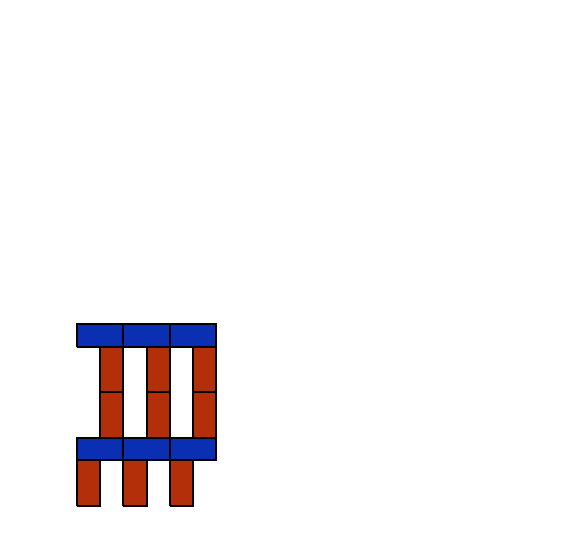

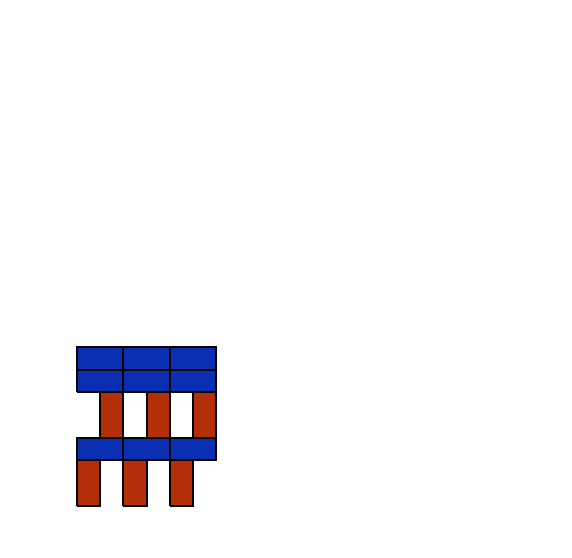

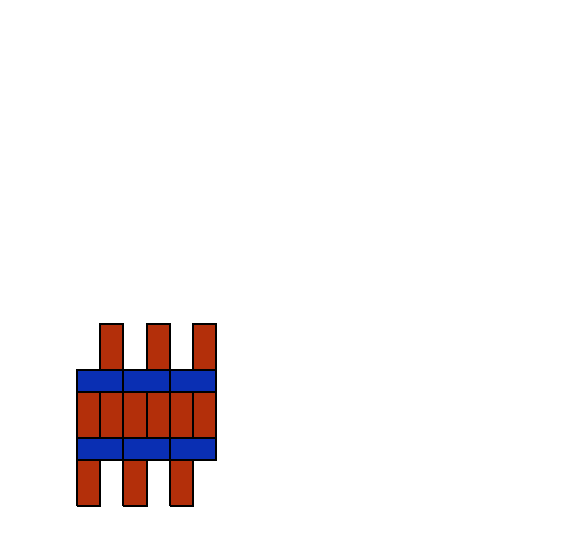

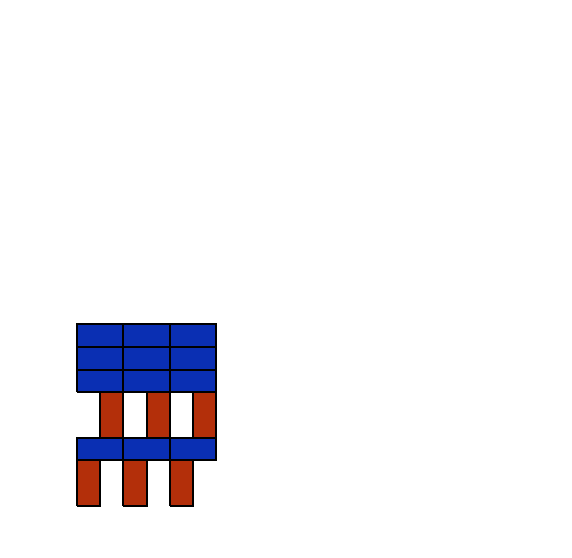

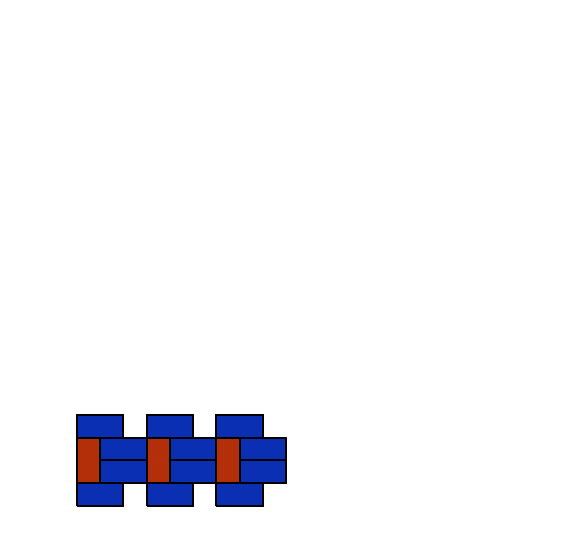

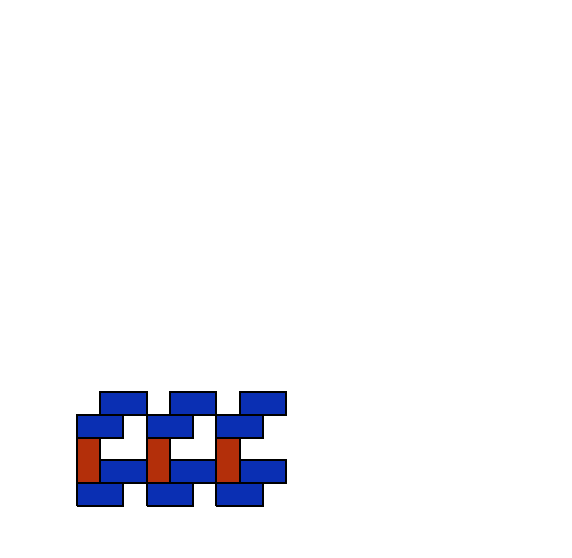

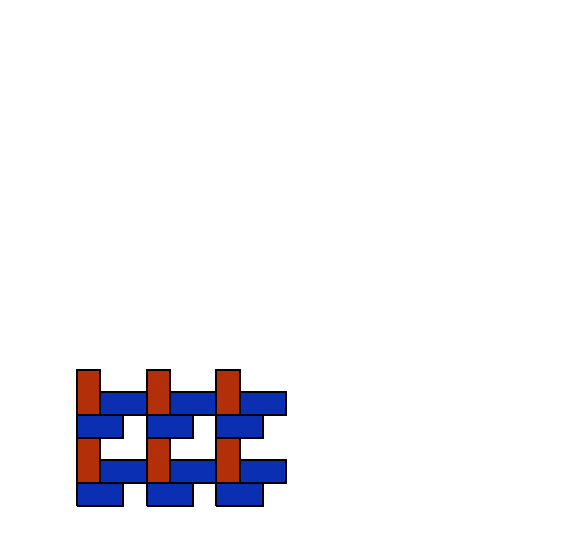

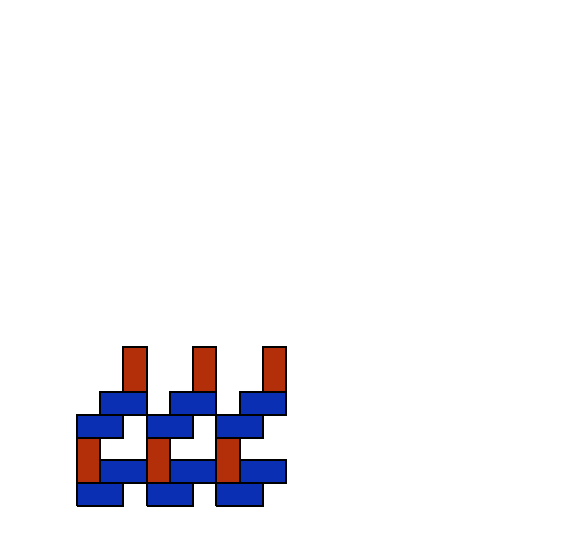

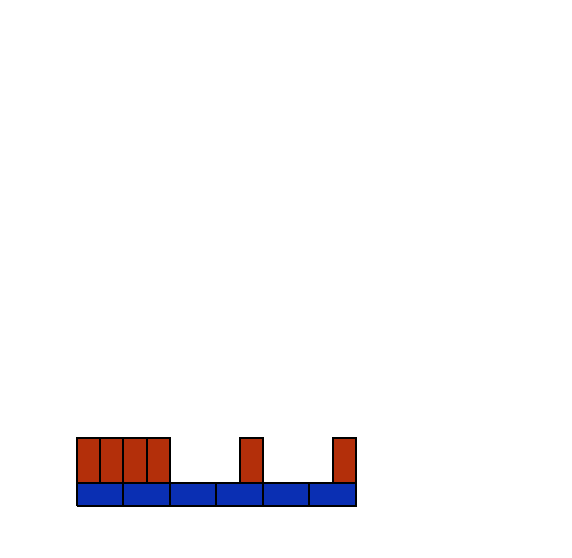

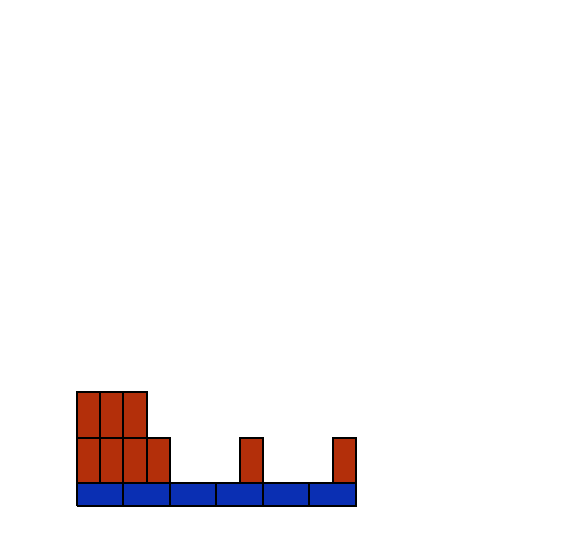

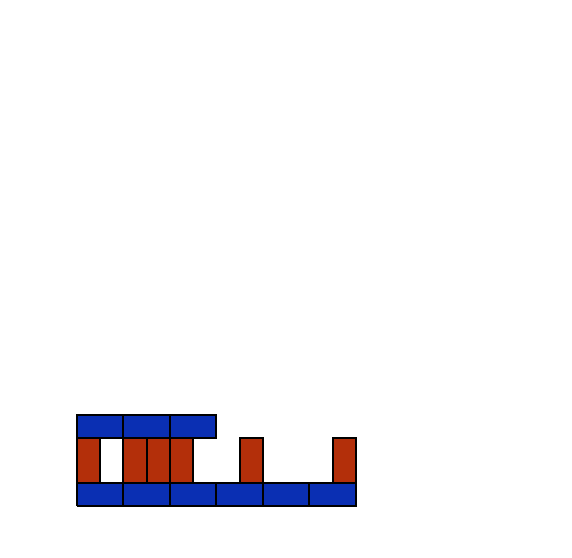

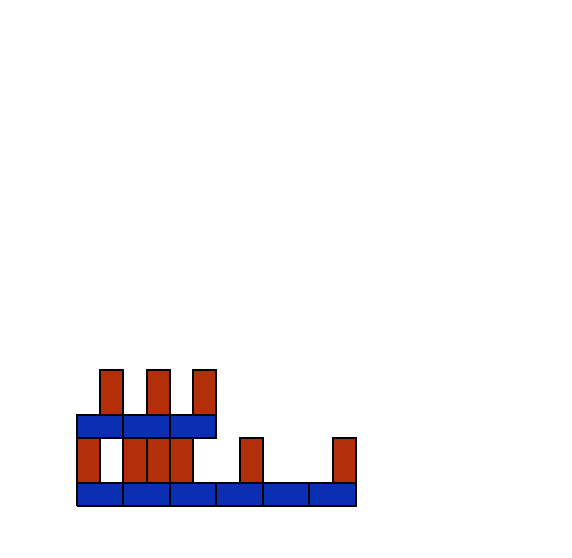

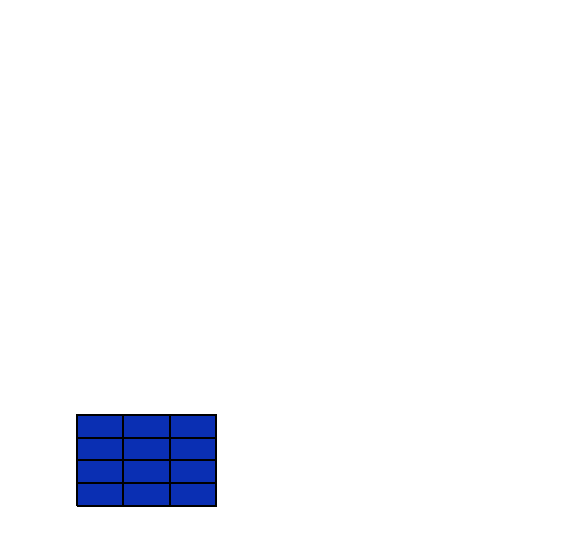

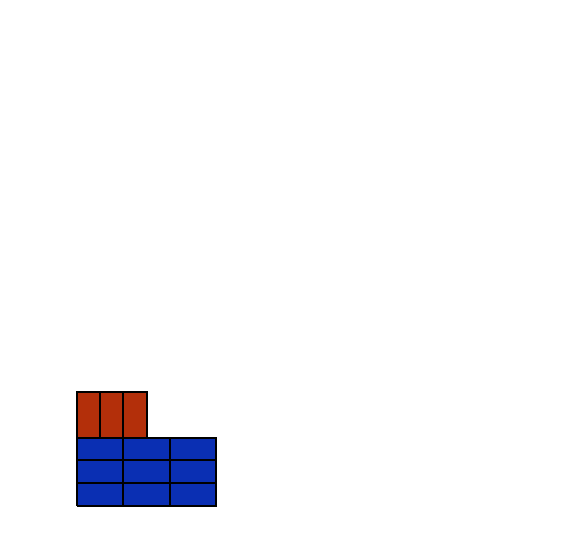

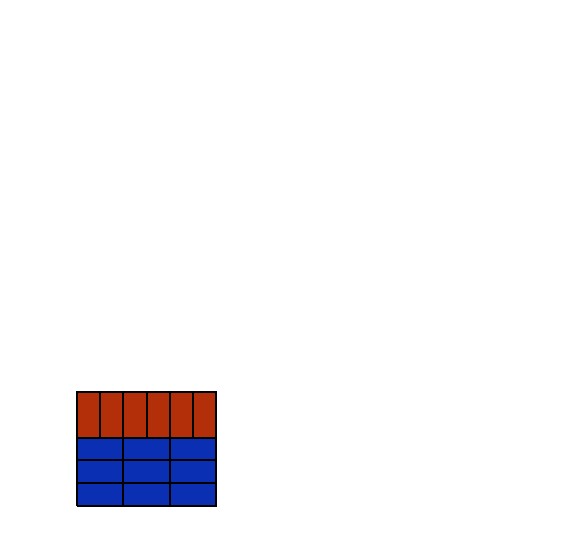

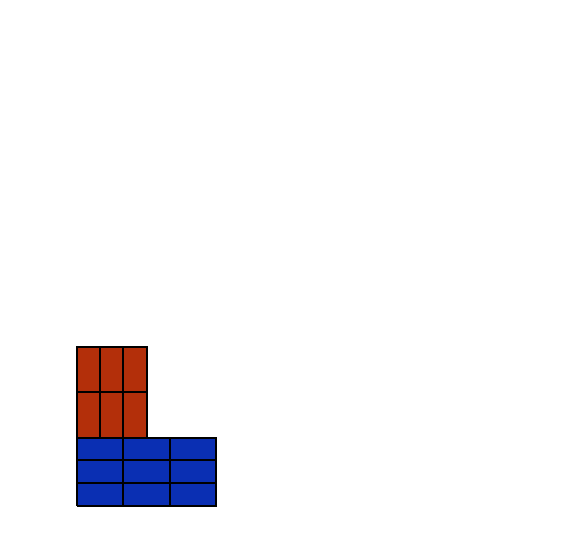

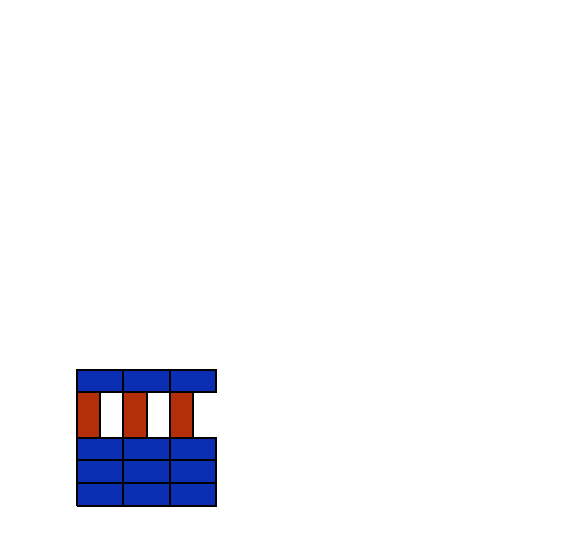

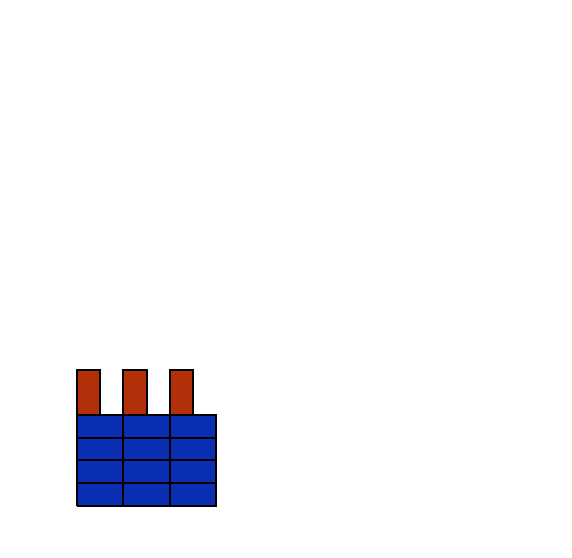

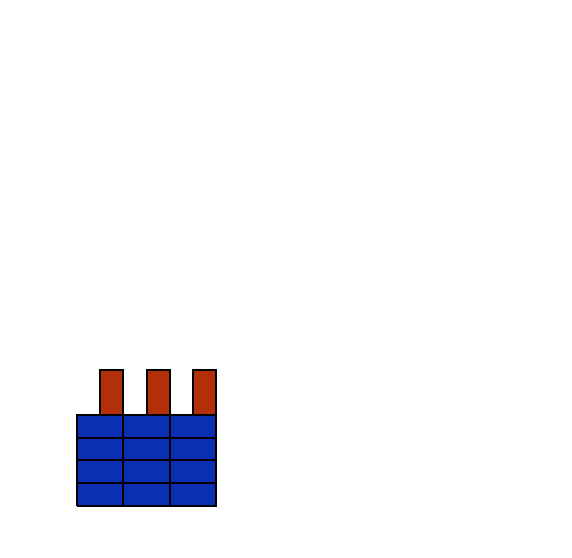

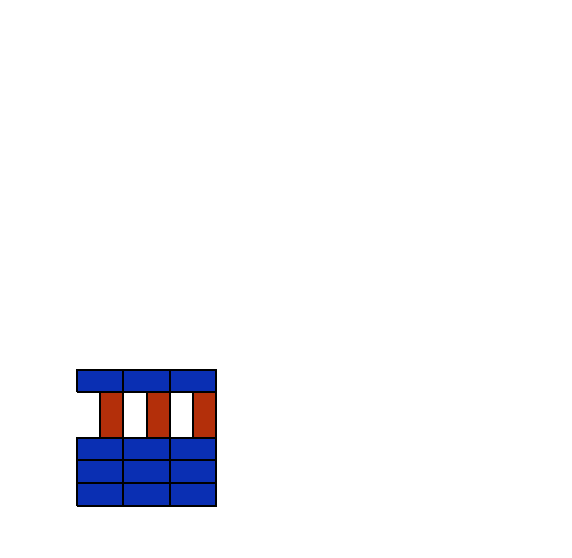

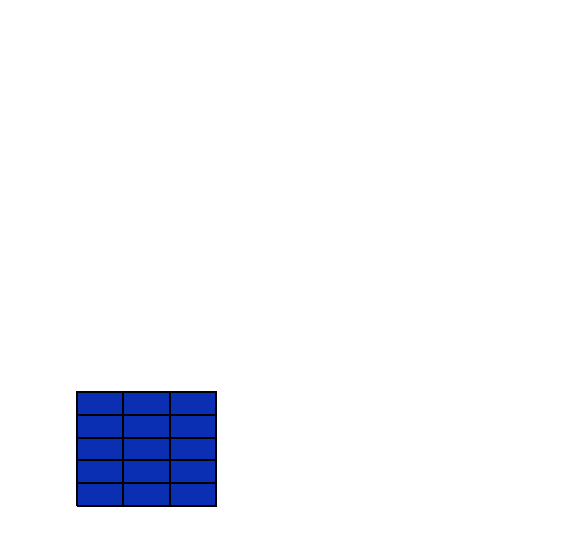

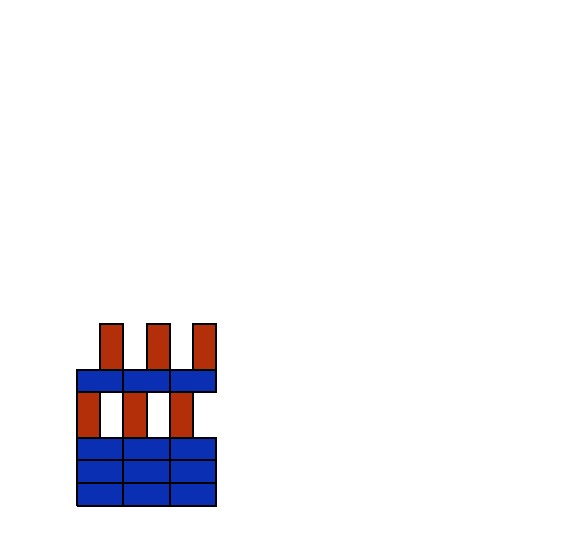

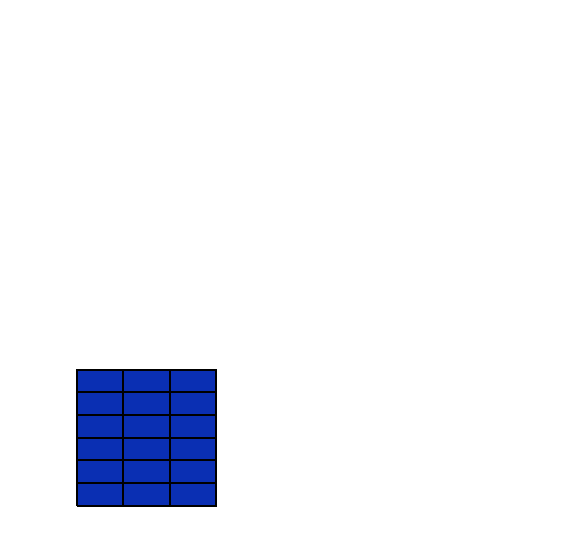

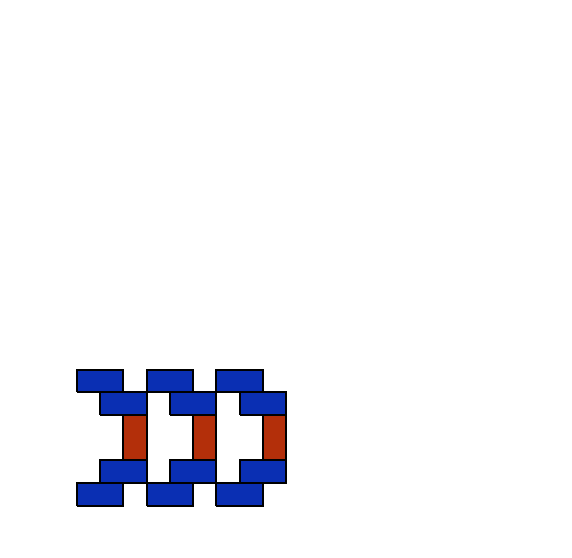

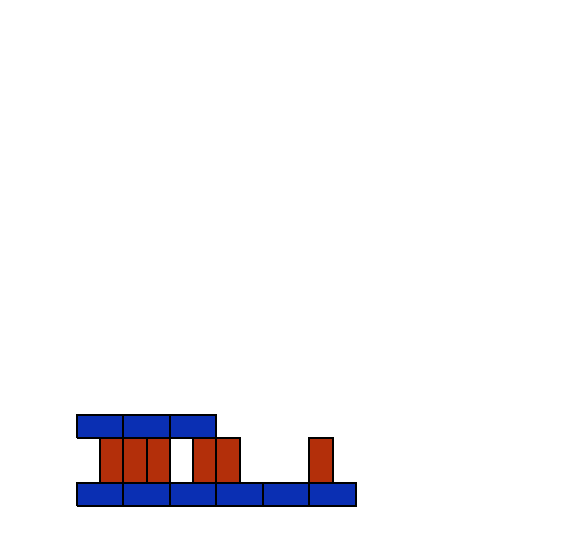

In [583]:
# Create sets of rows

for wall_width in range(3,4):
    
    for i, row_1 in enumerate(rows[wall_width][0:20]):
        
        for j, row_2 in enumerate(rows[wall_width][0:20]):
            w = new_world()
            w.place_tower(row_1, x_location=0)
            w.place_tower(row_2, x_location=0)
            
            if not(w.broken):
                utils.draw_world(w)
            

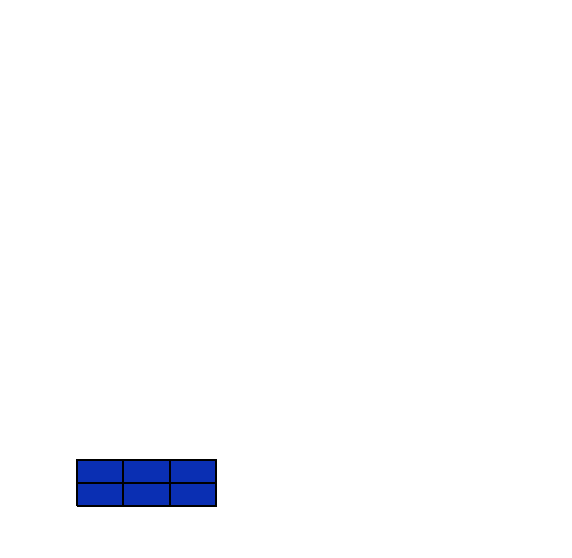

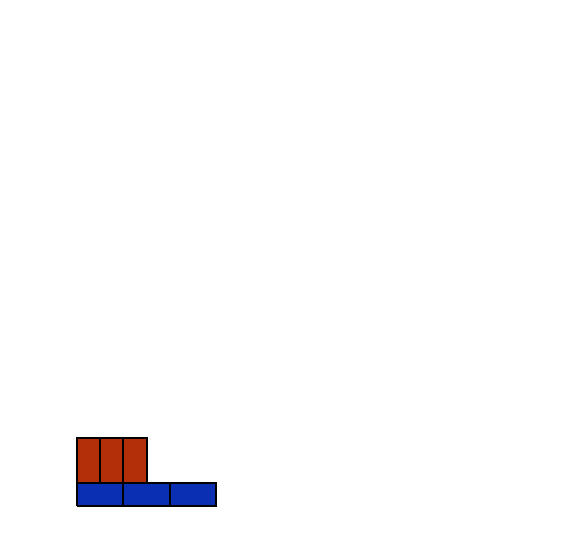

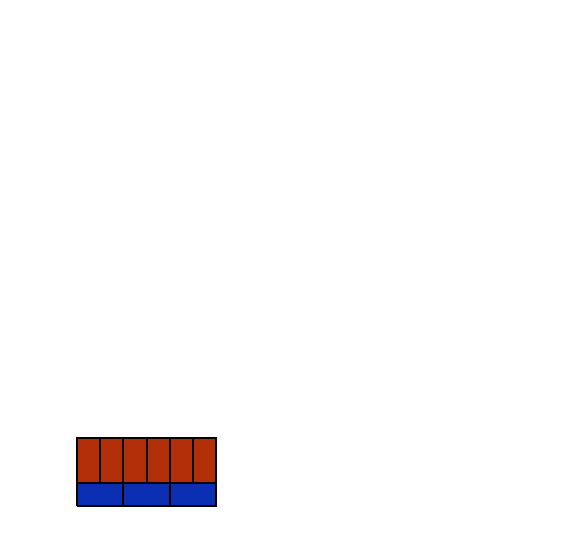

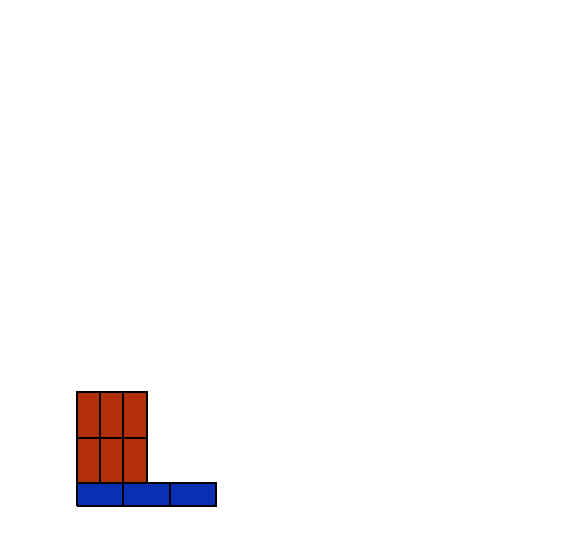

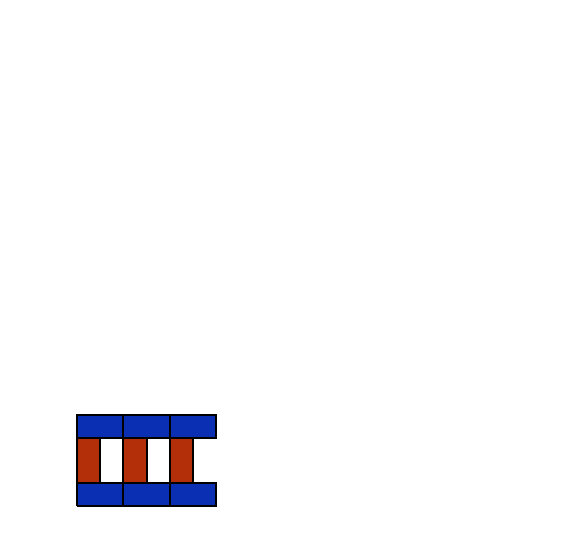

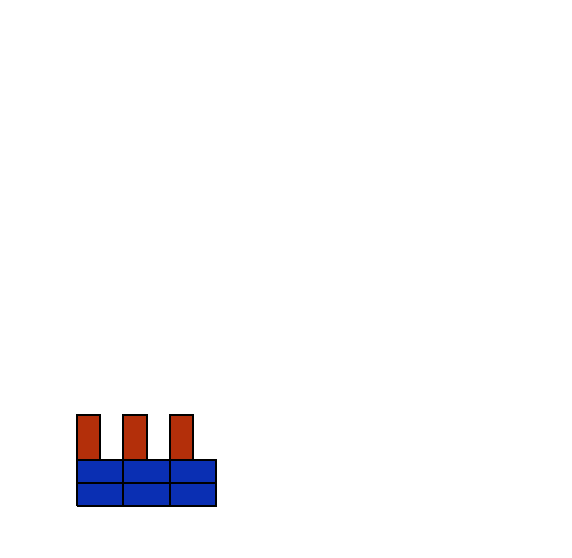

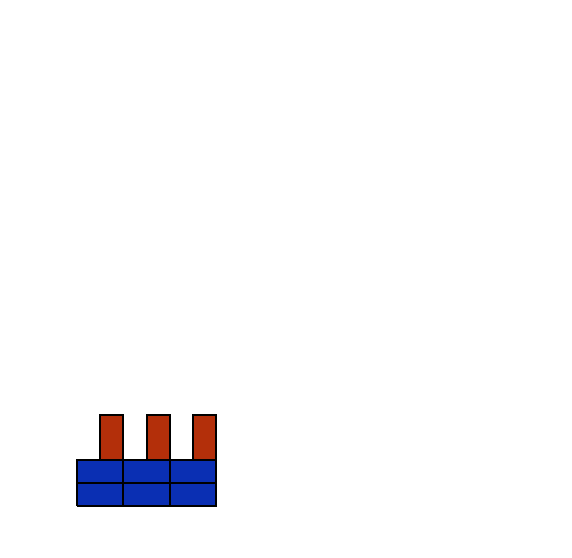

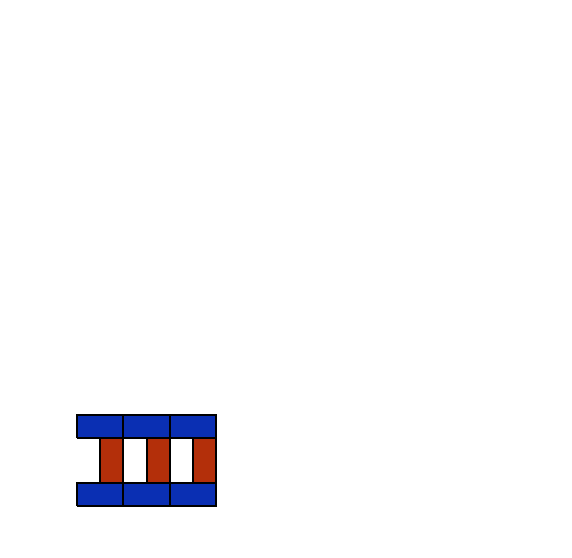

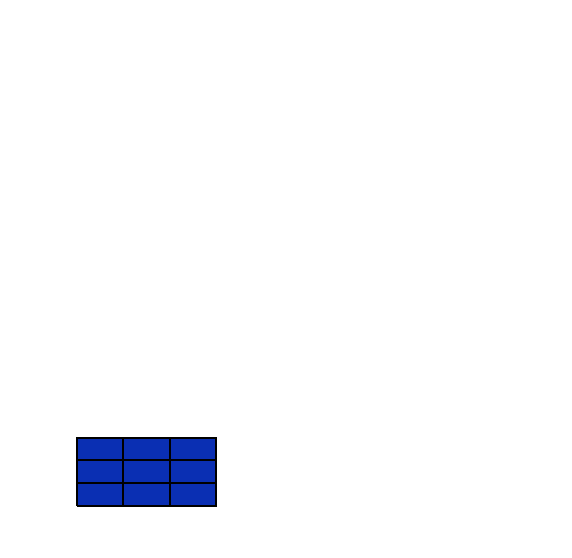

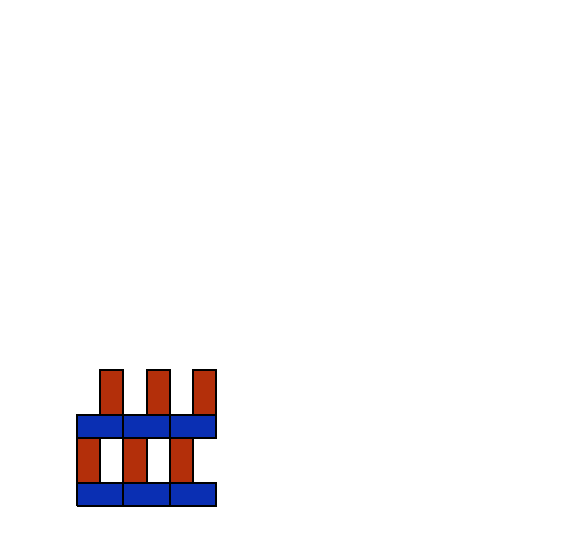

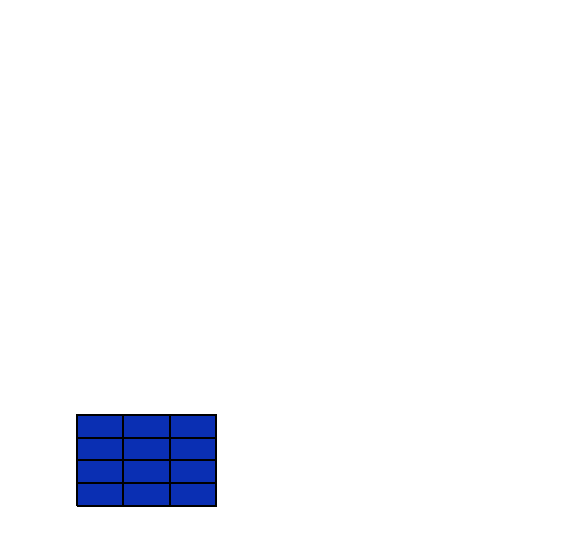

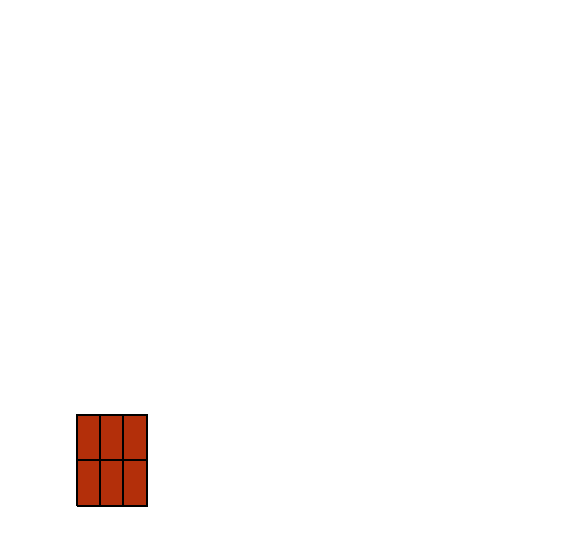

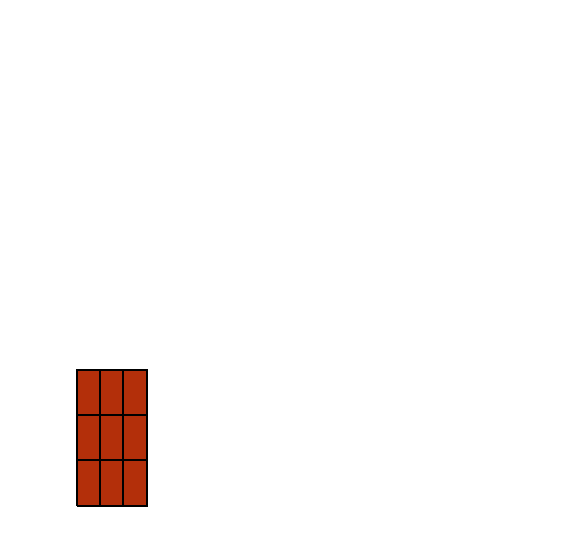

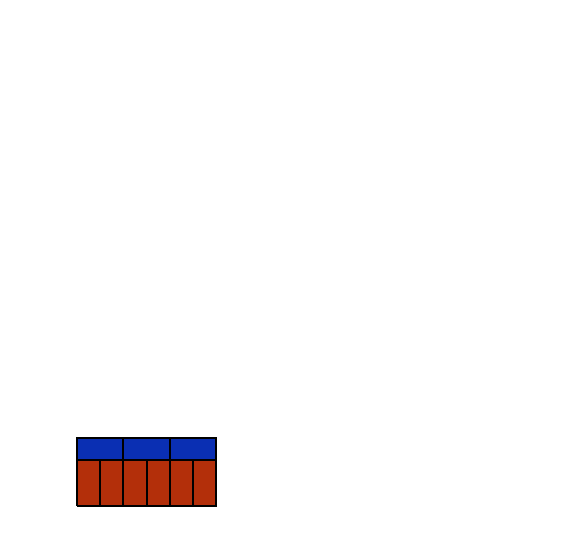

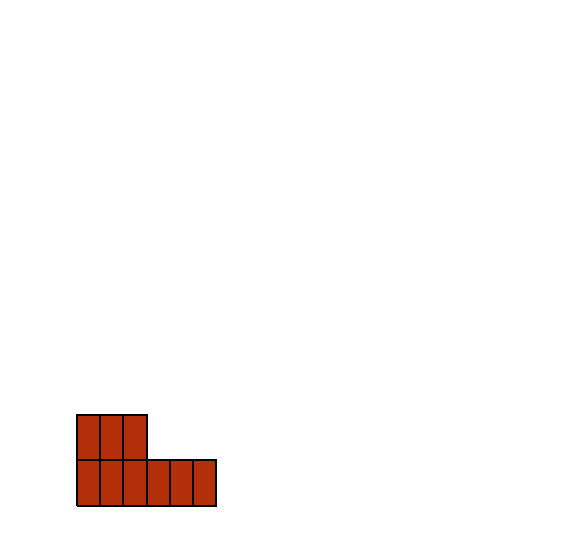

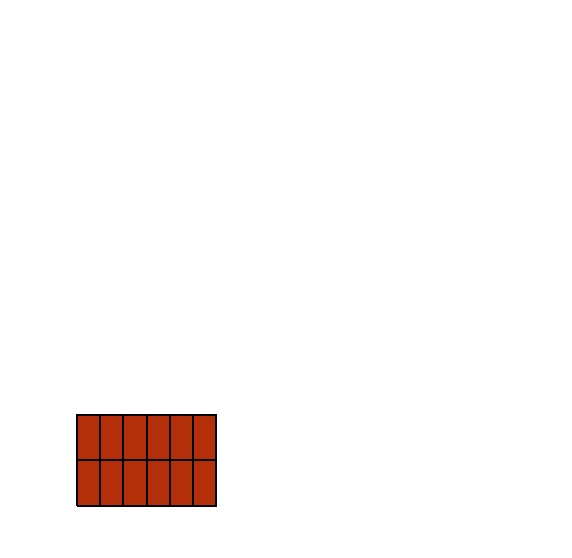

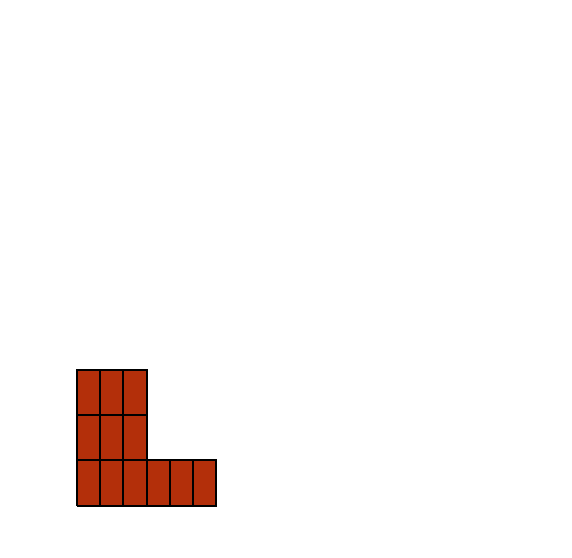

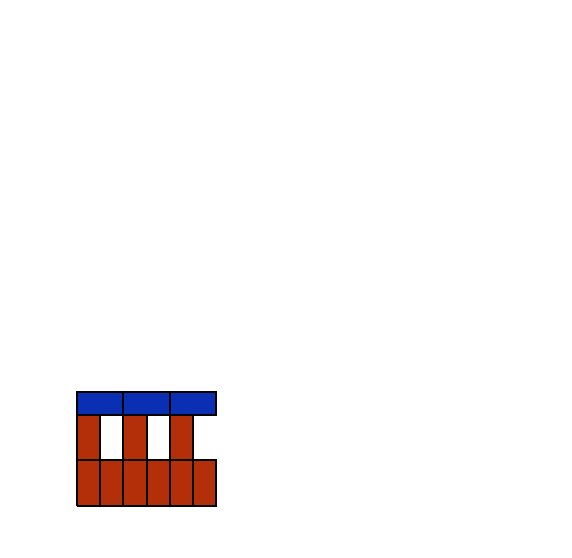

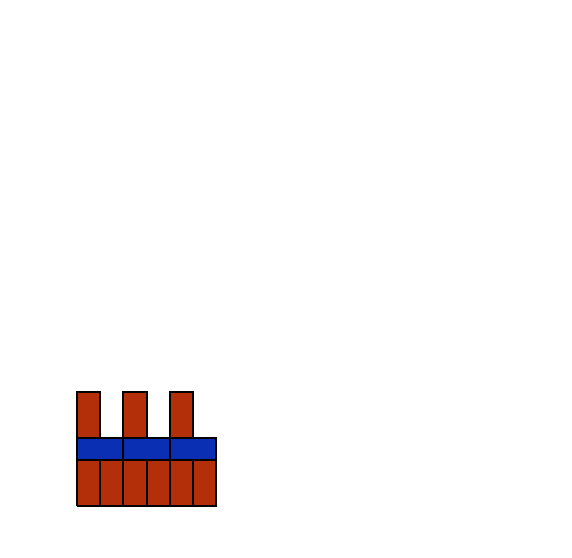

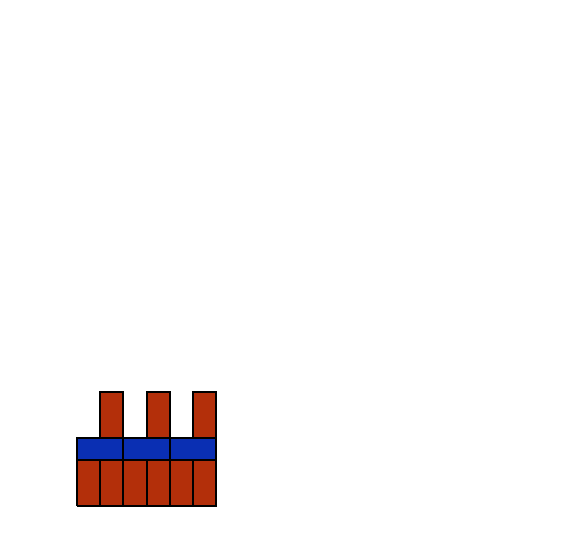

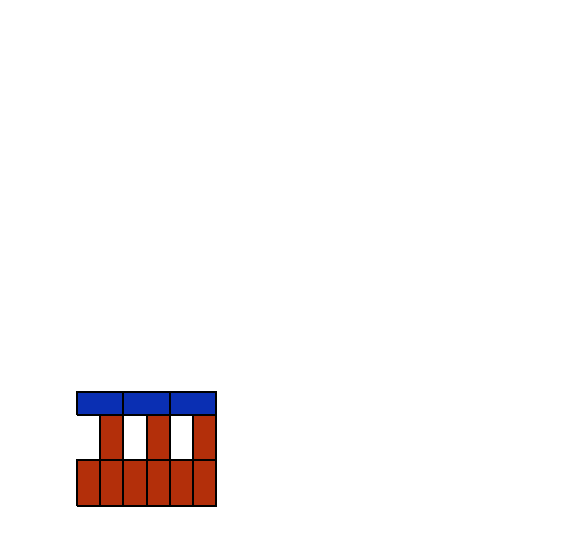

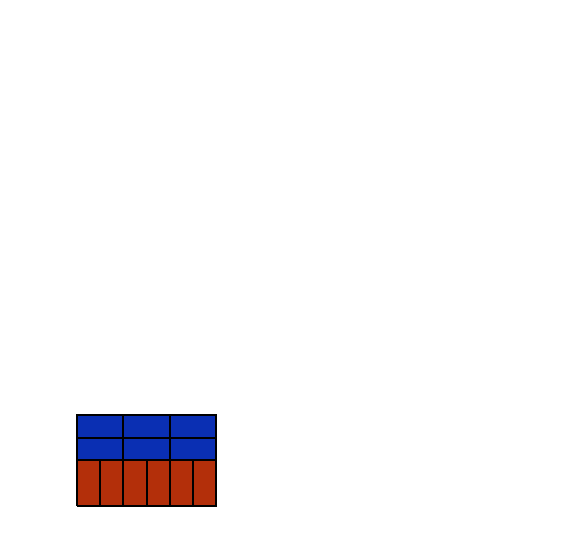

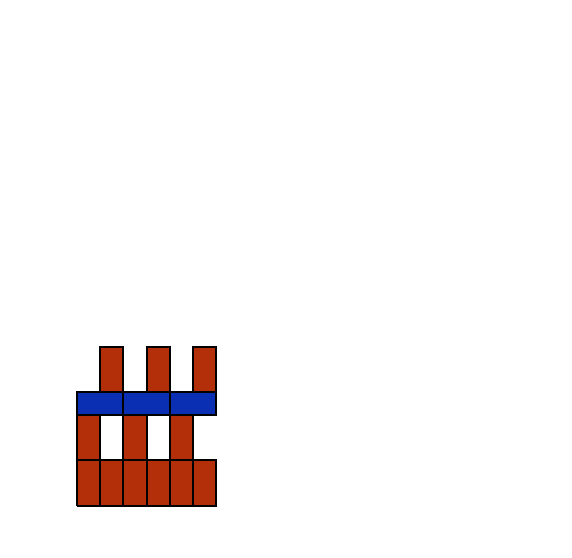

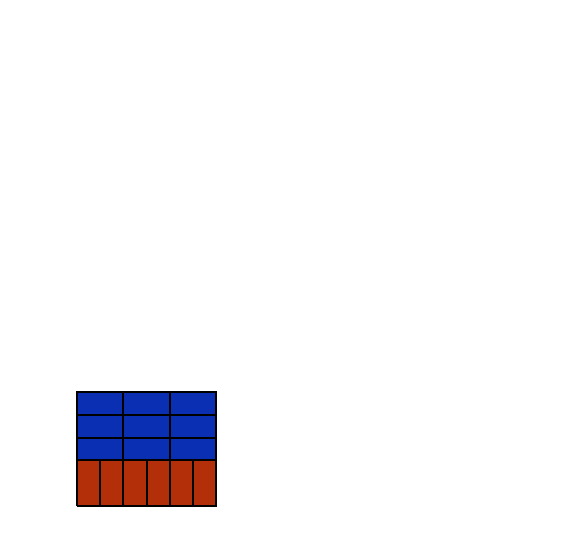

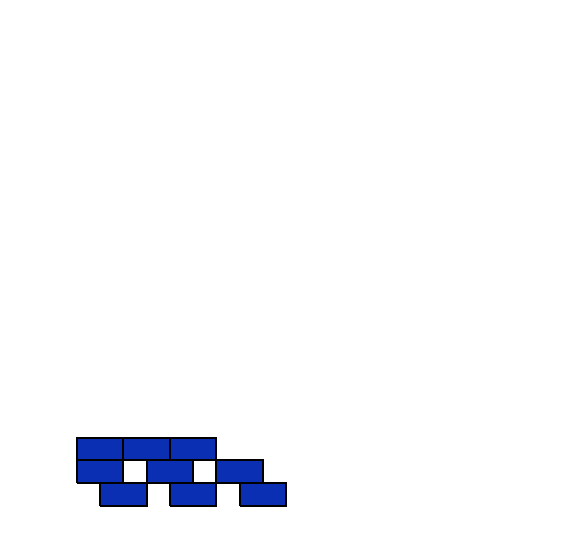

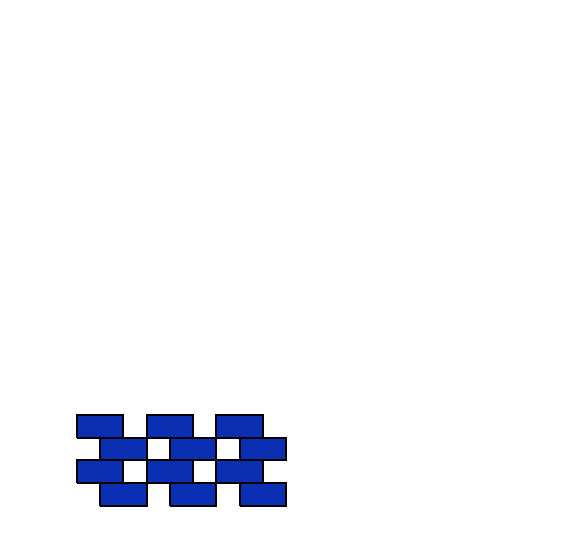

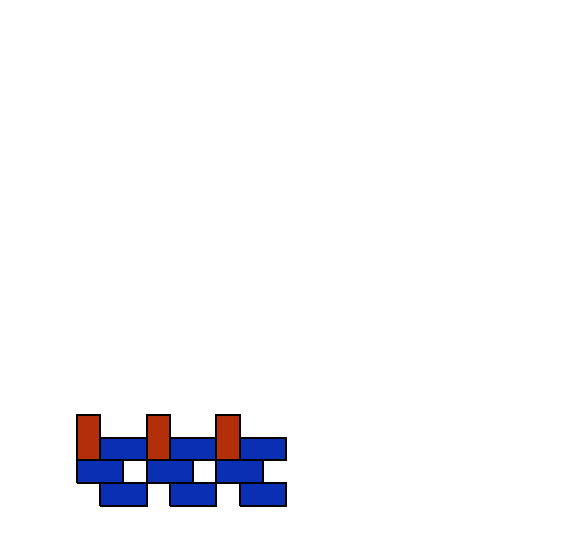

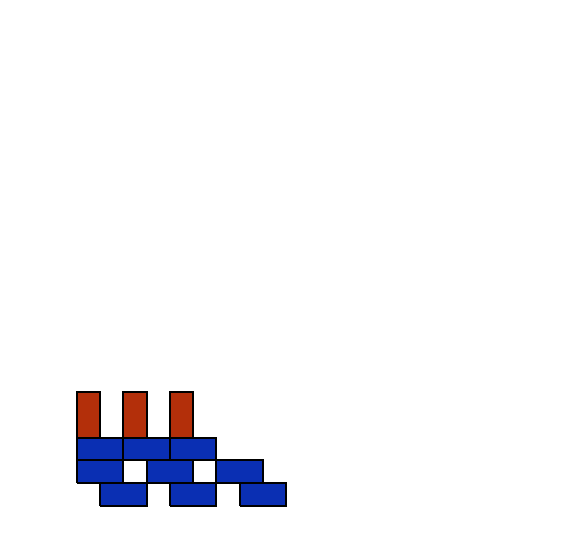

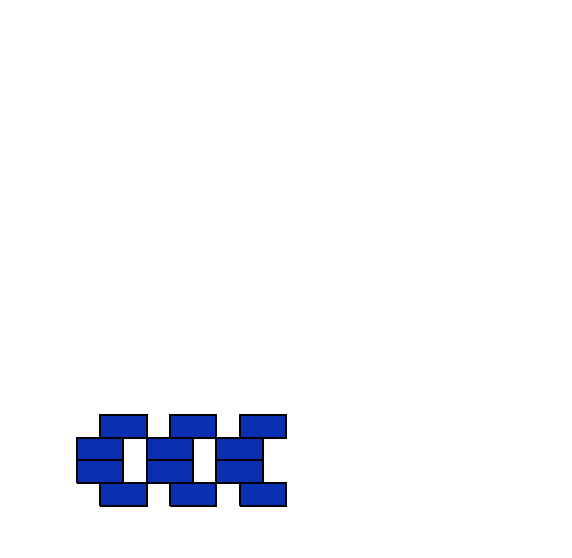

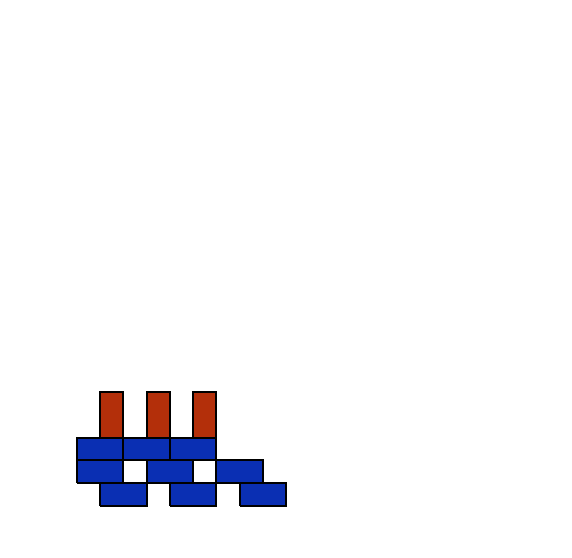

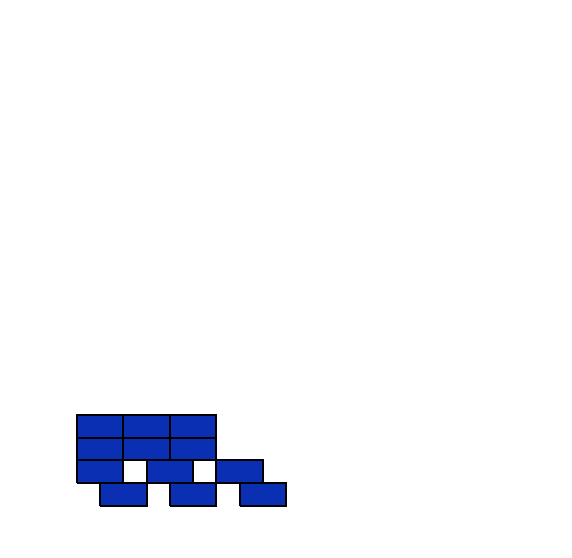

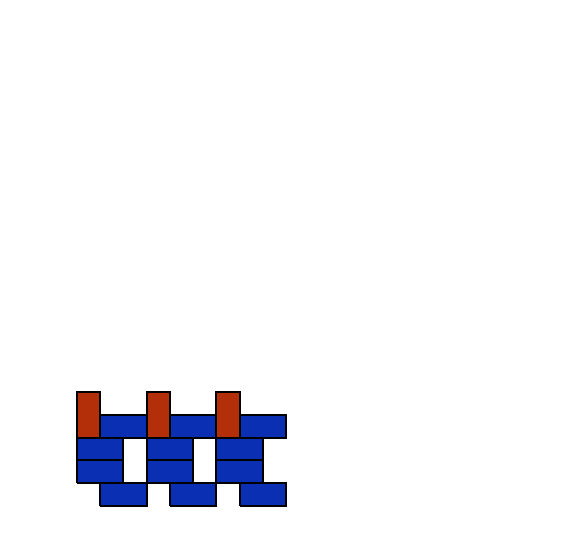

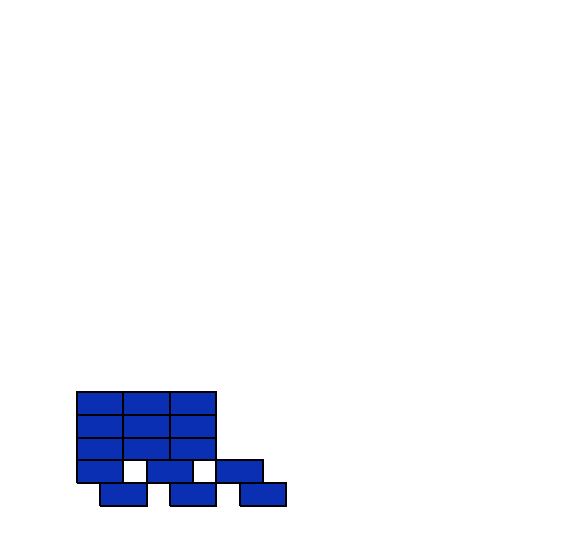

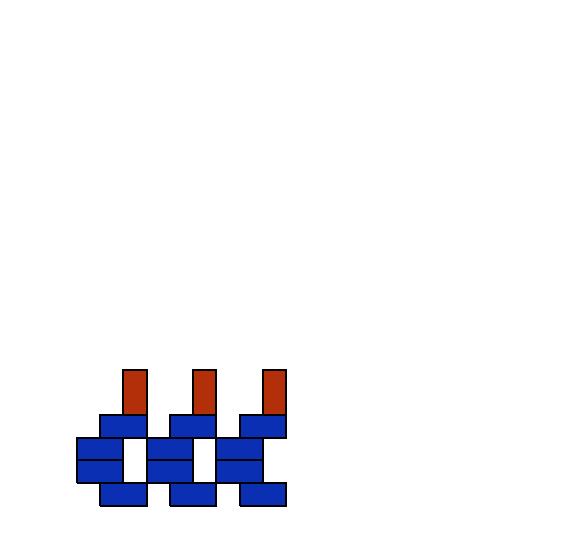

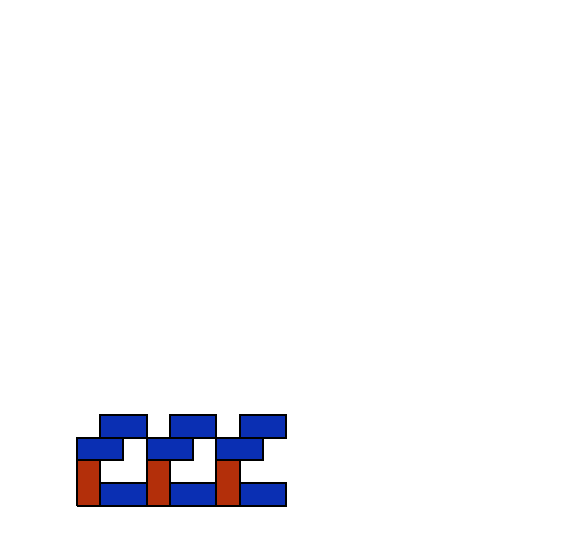

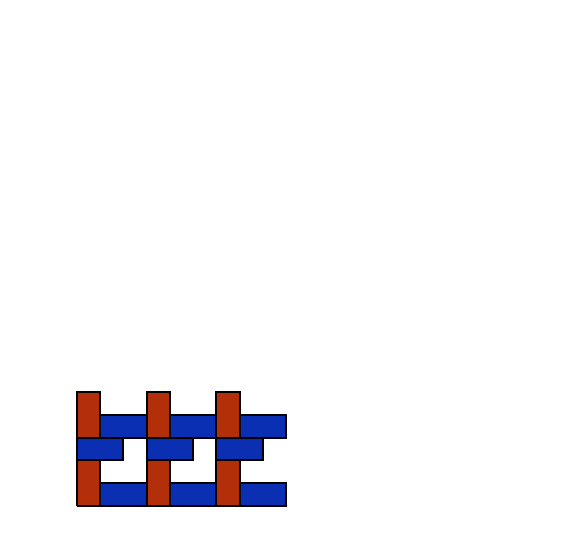

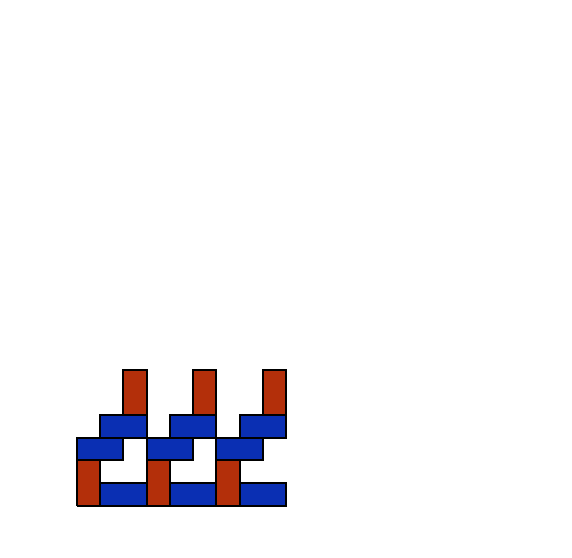

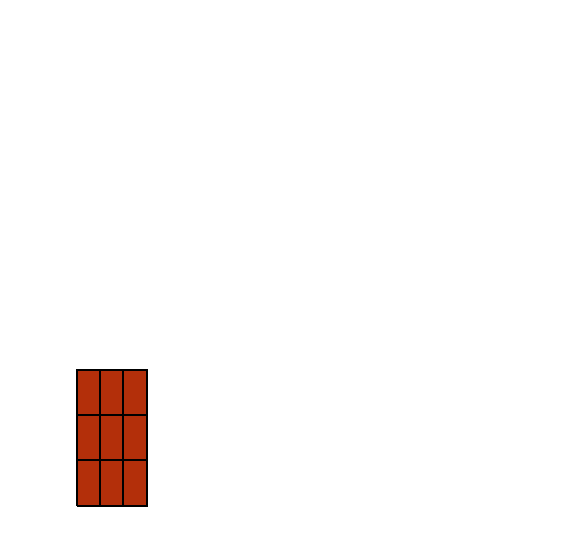

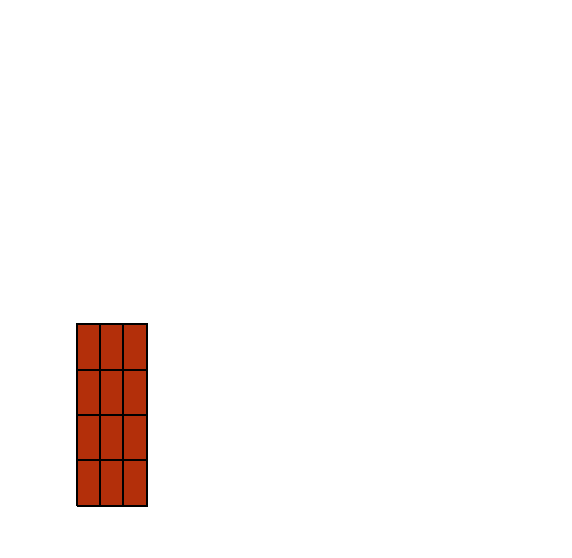

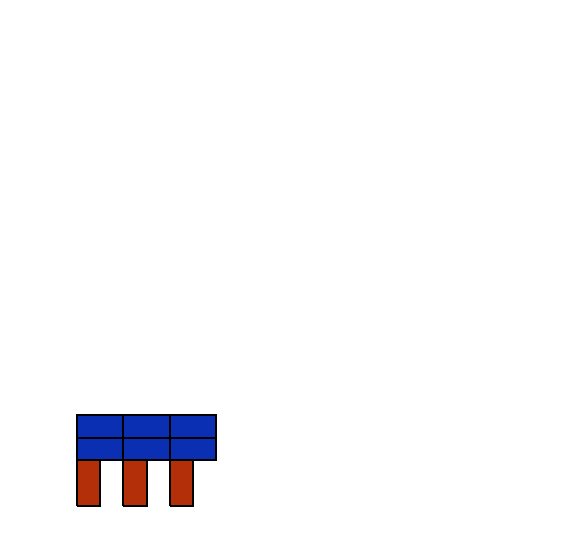

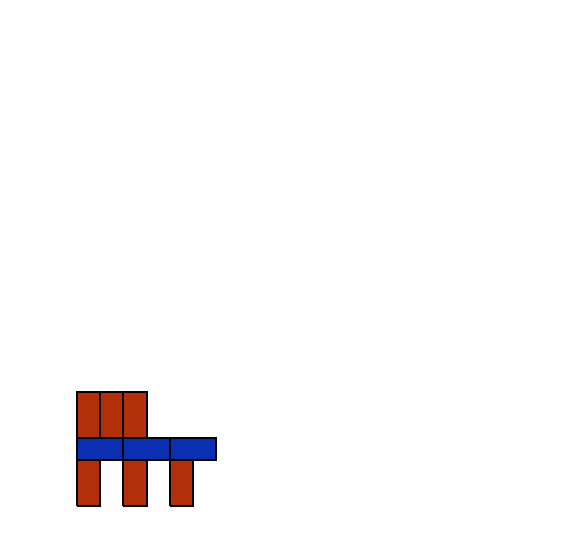

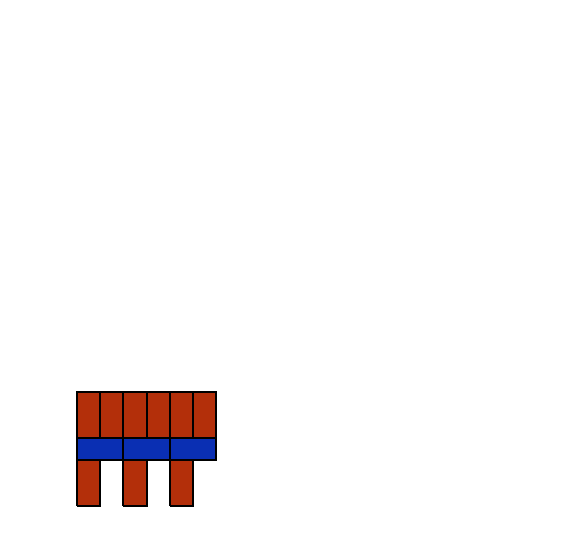

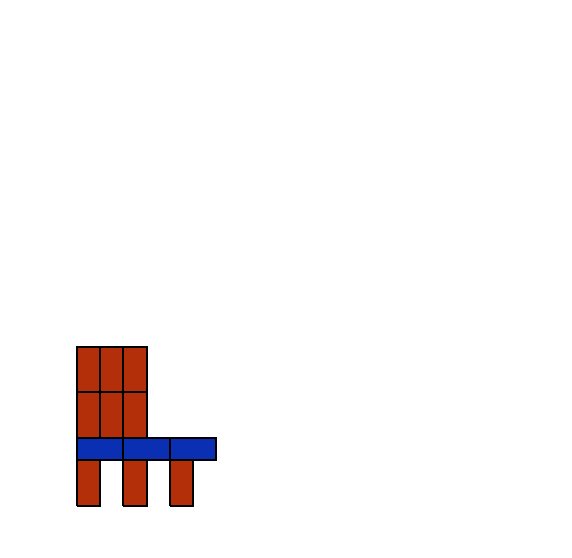

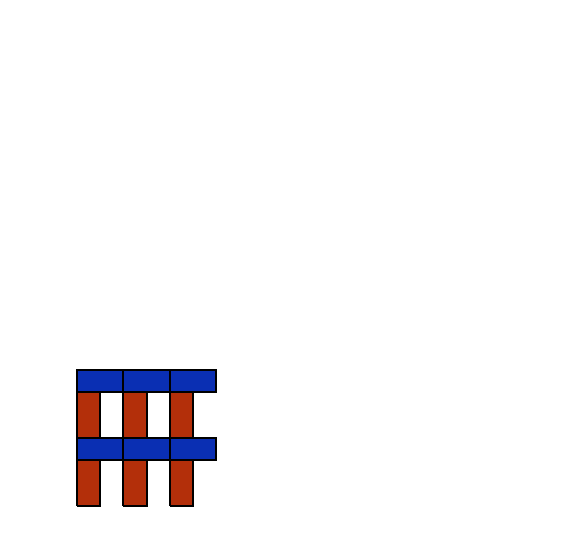

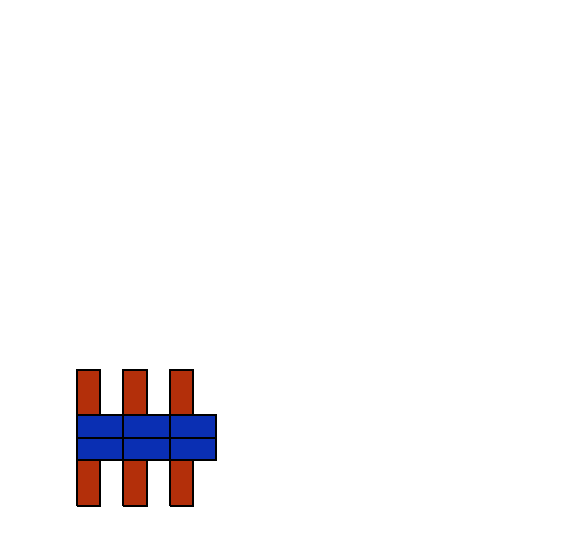

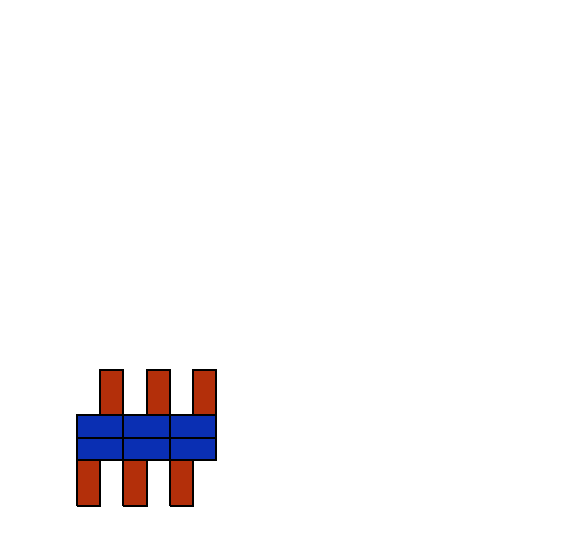

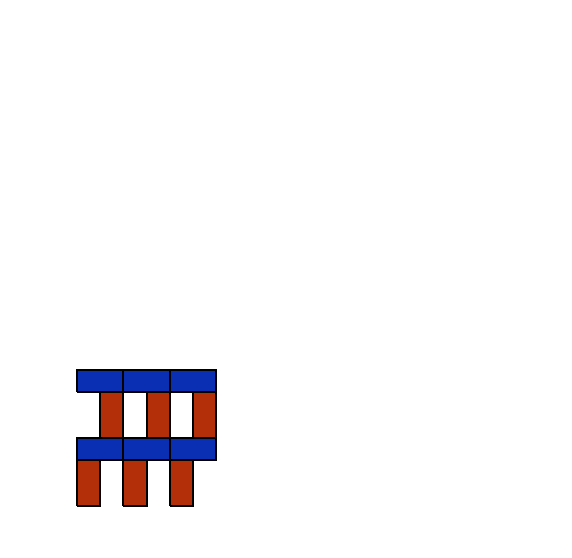

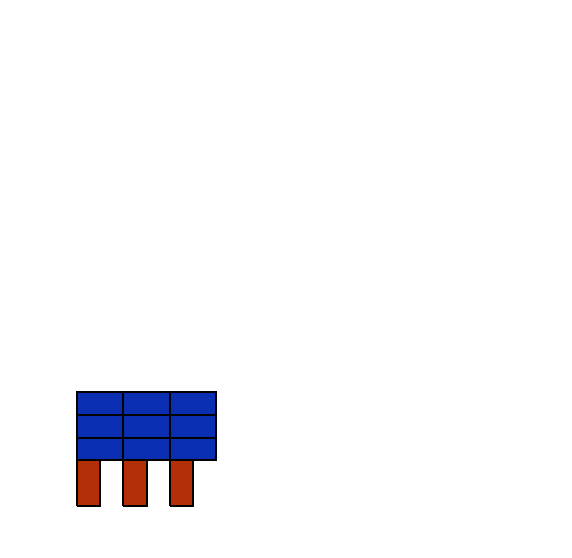

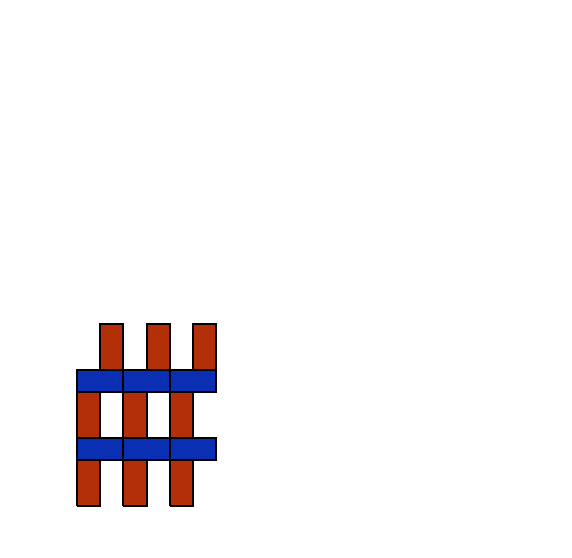

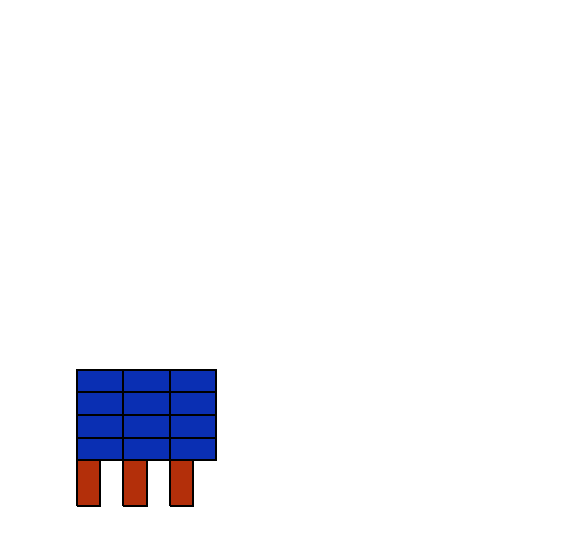

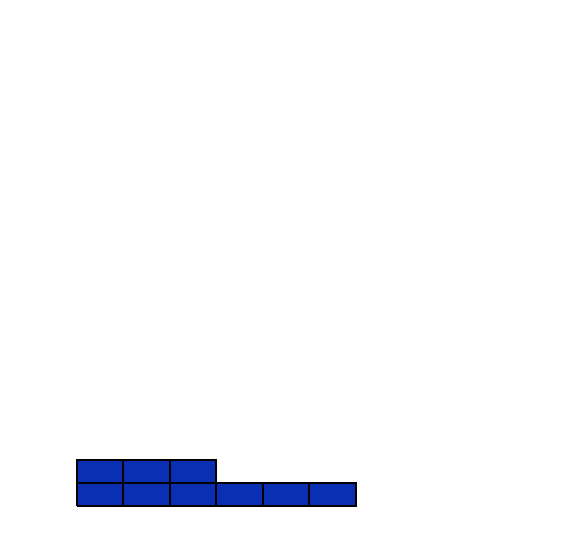

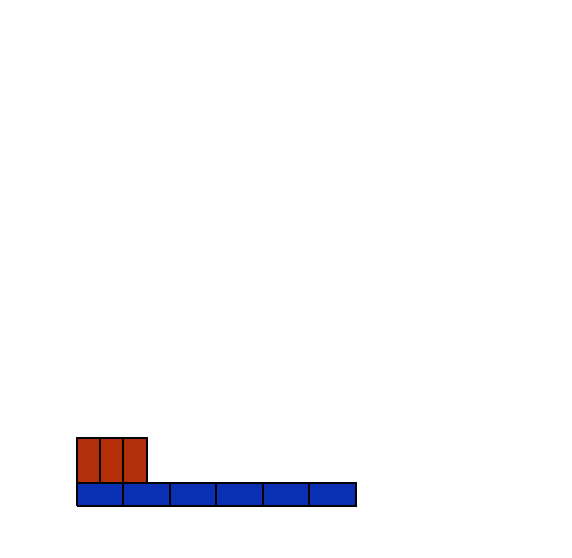

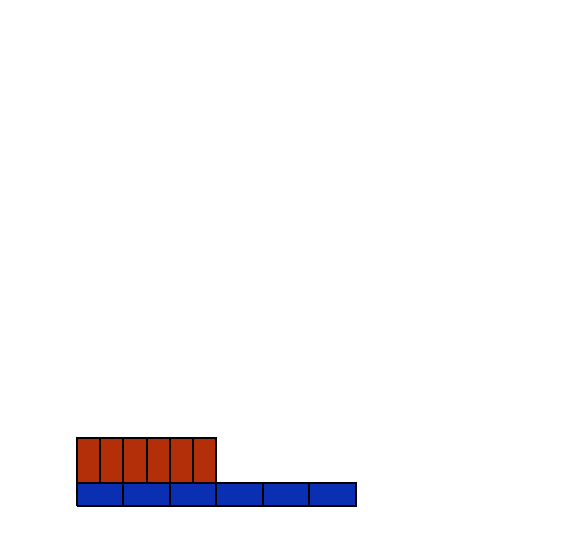

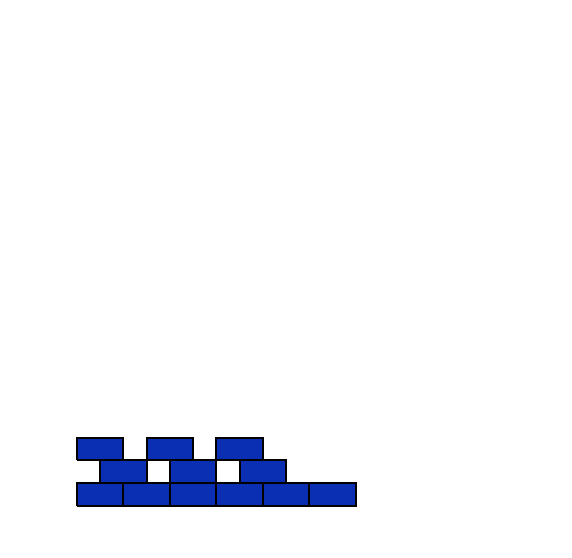

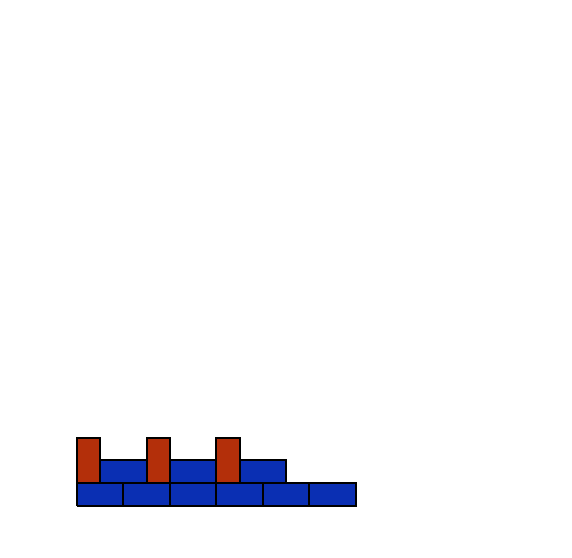

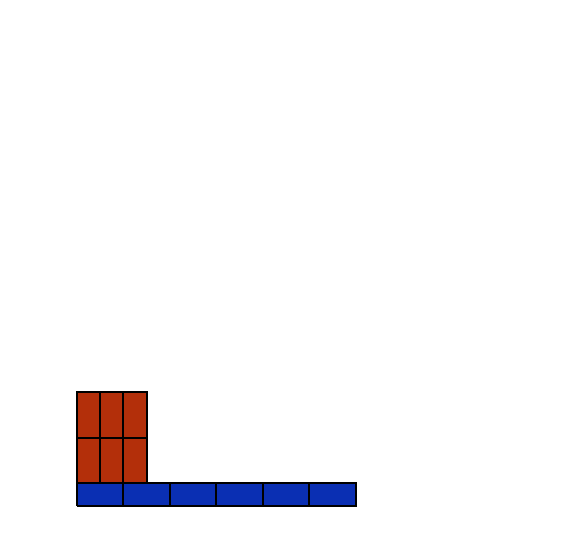

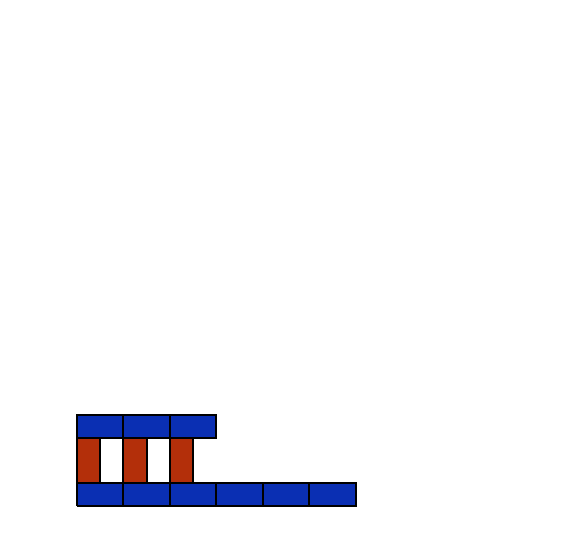

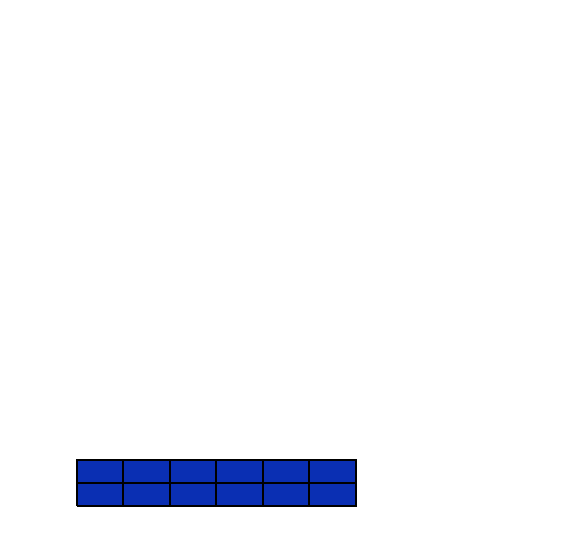

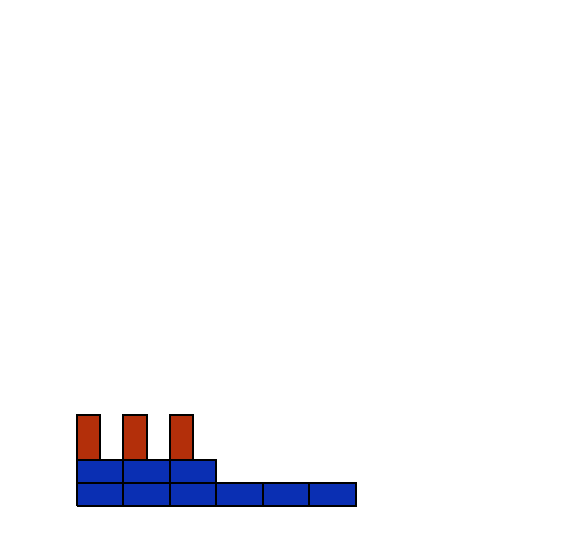

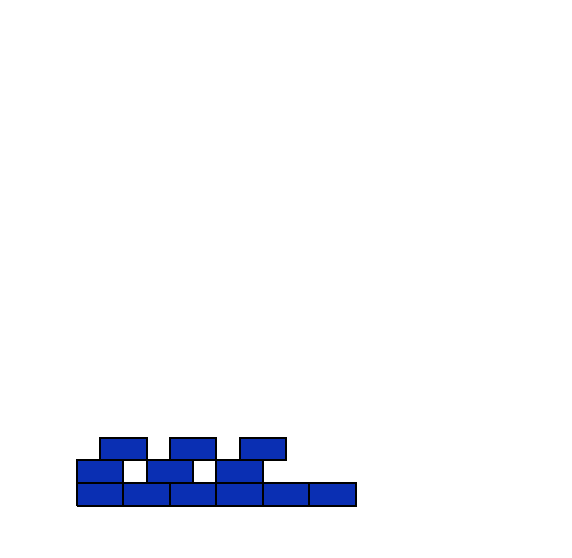

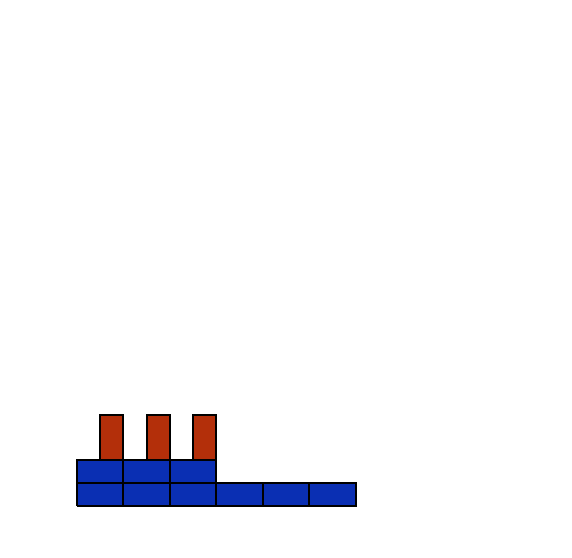

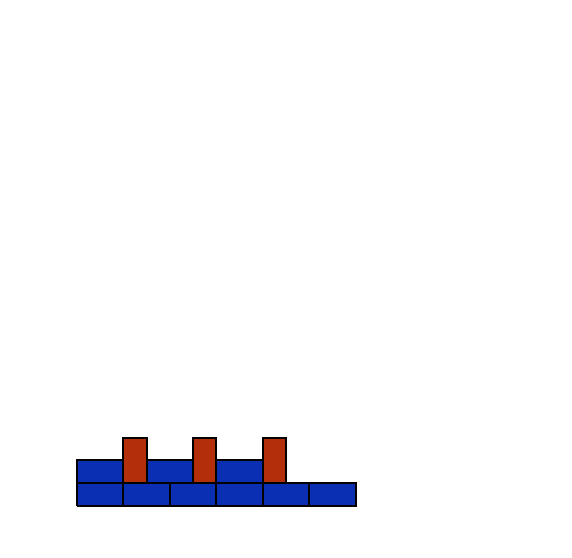

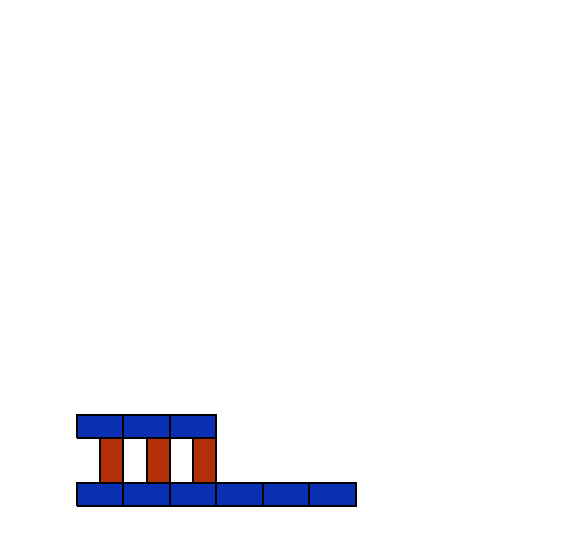

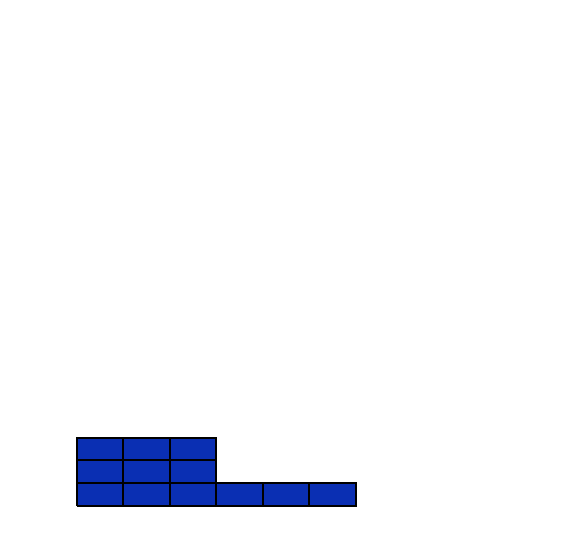

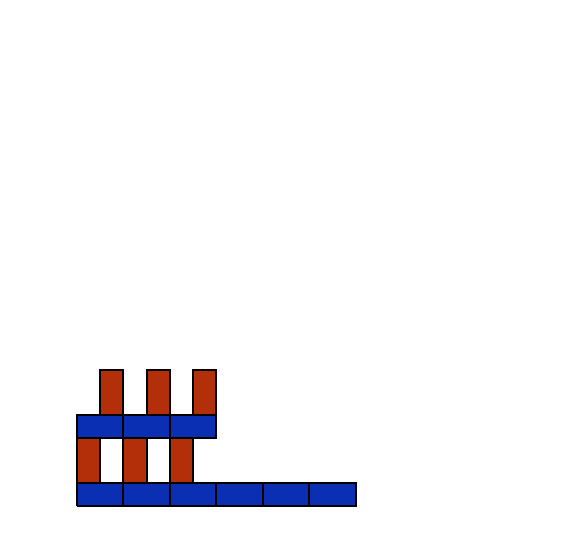

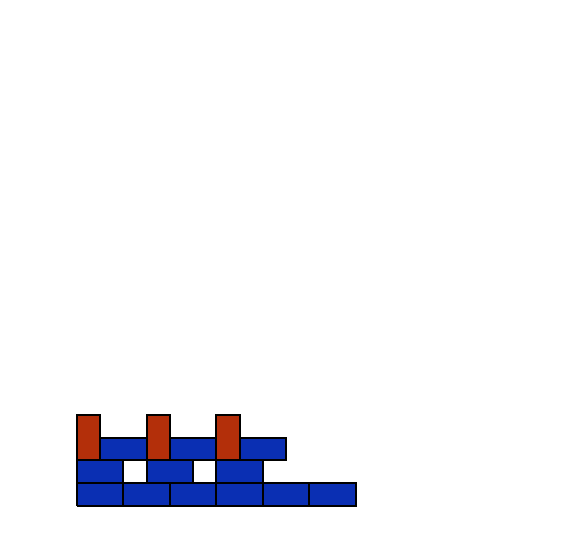

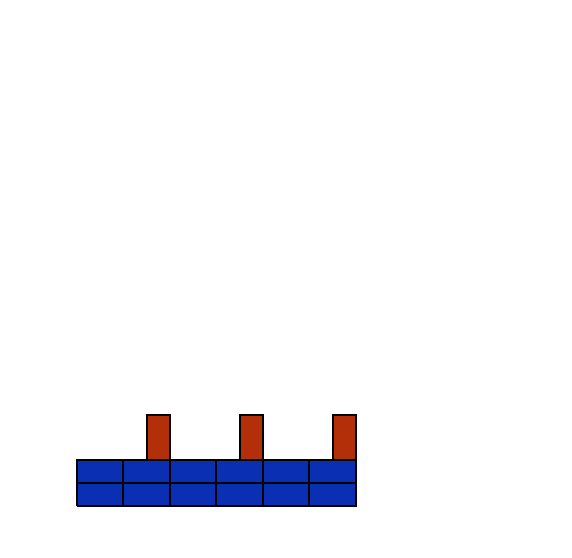

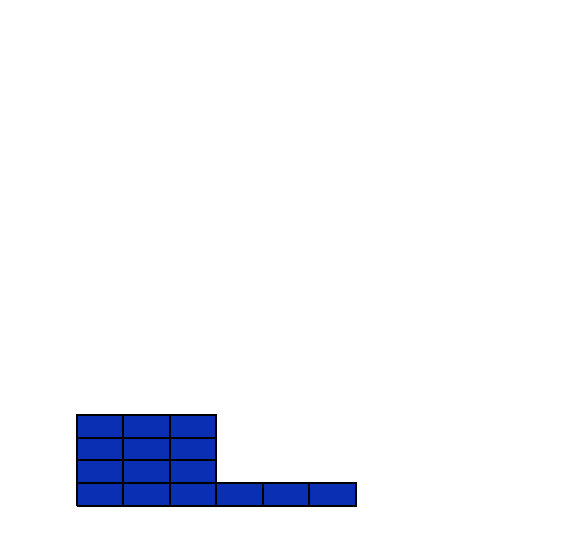

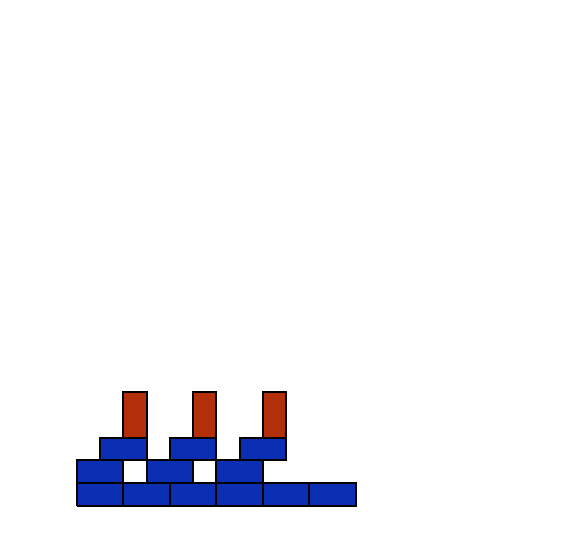

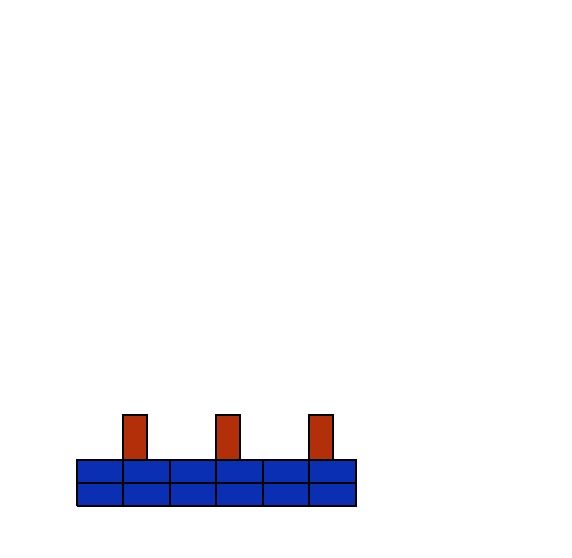

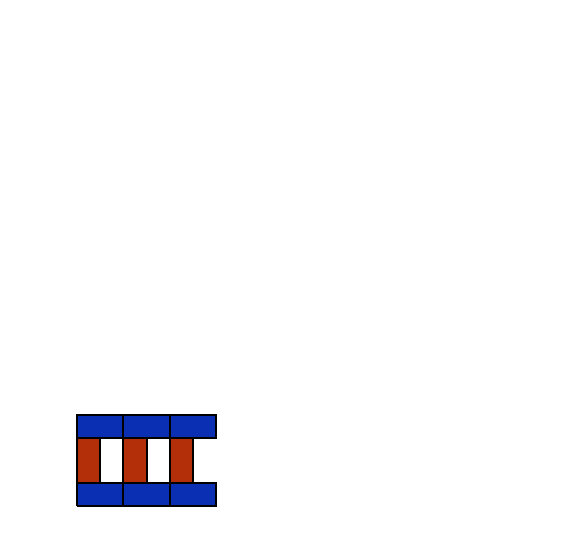

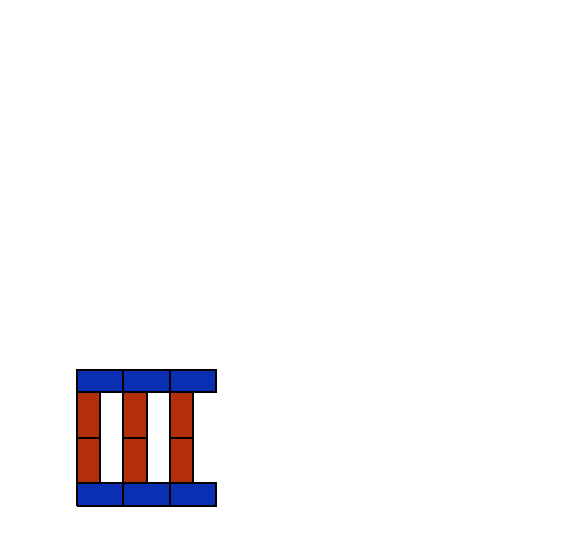

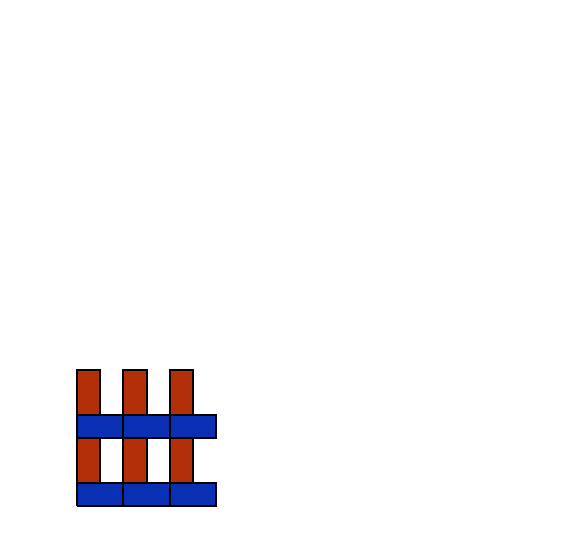

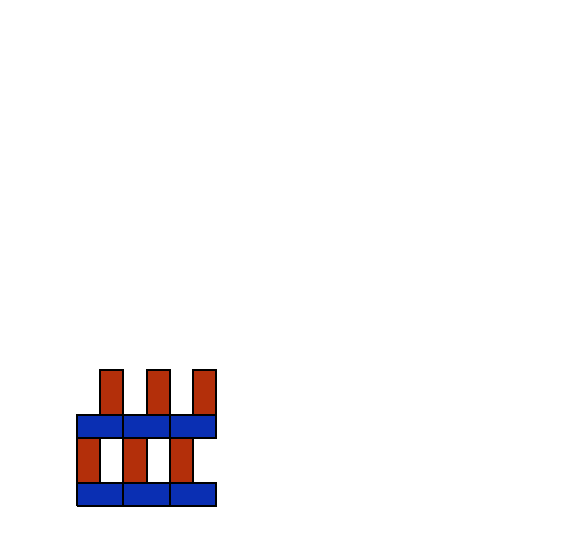

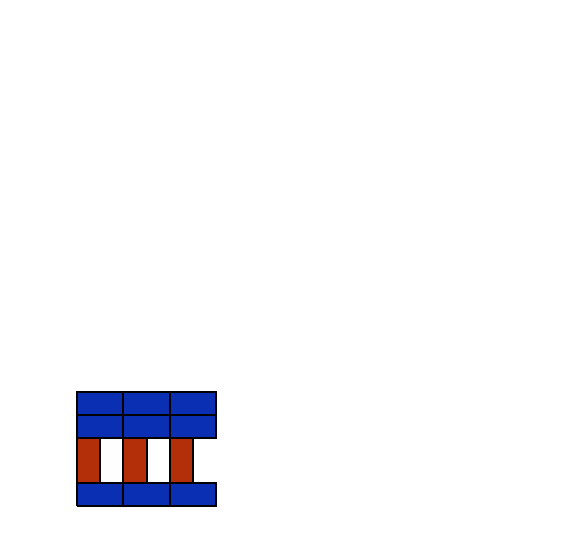

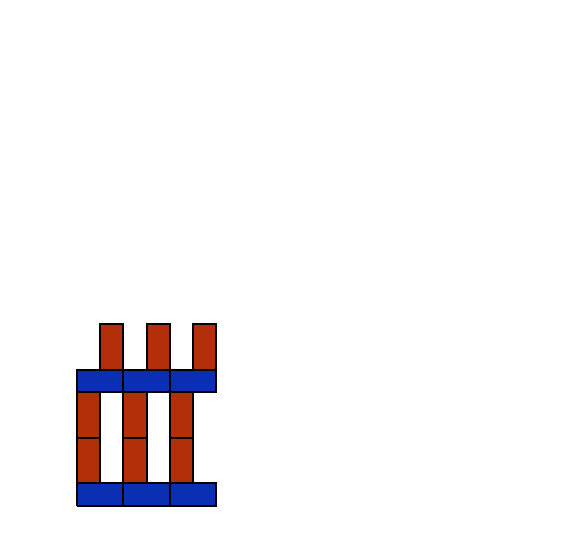

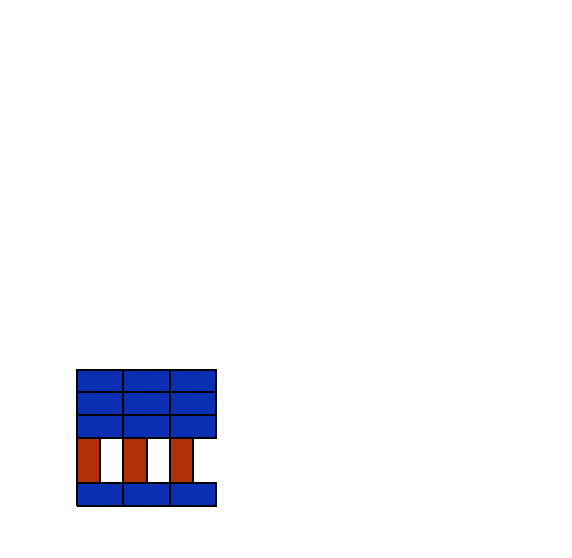

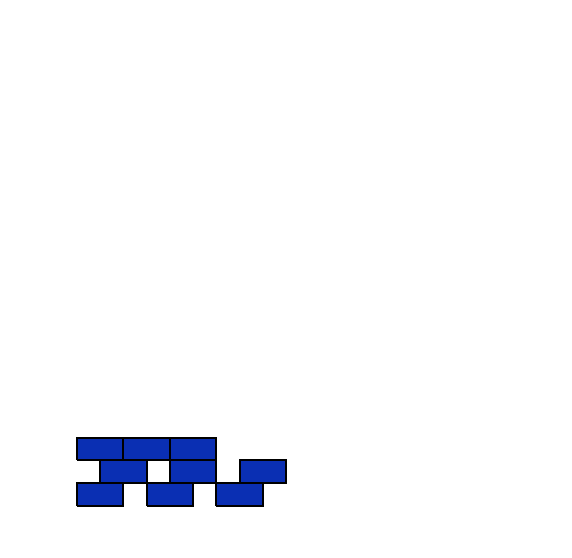

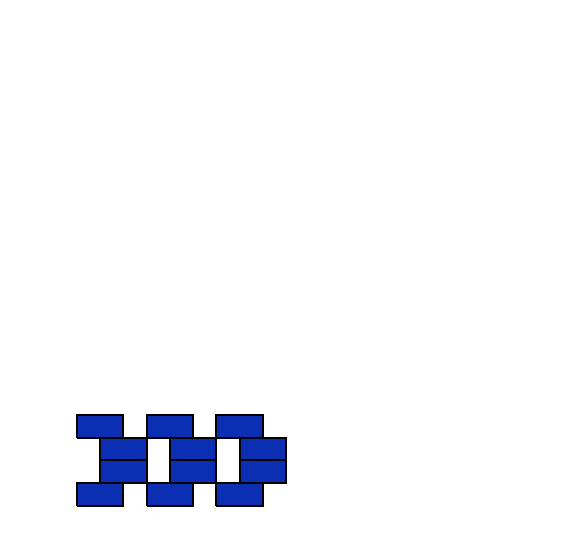

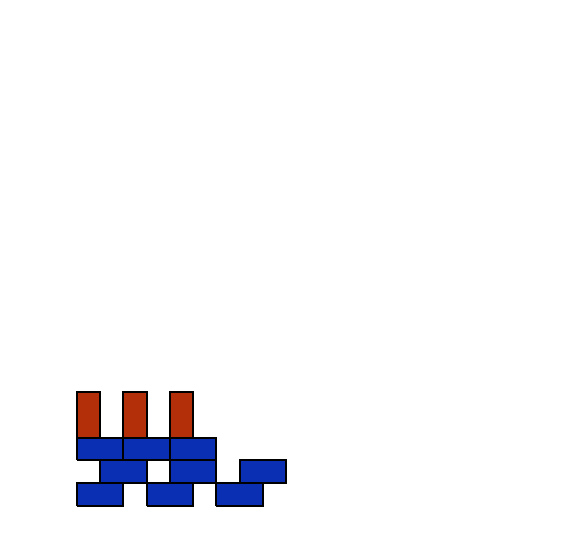

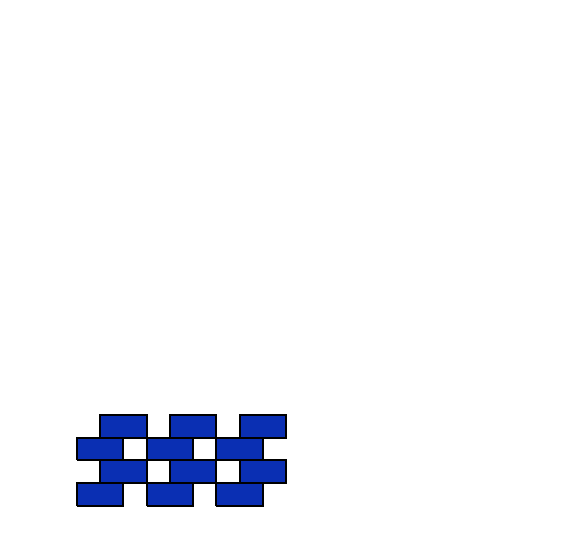

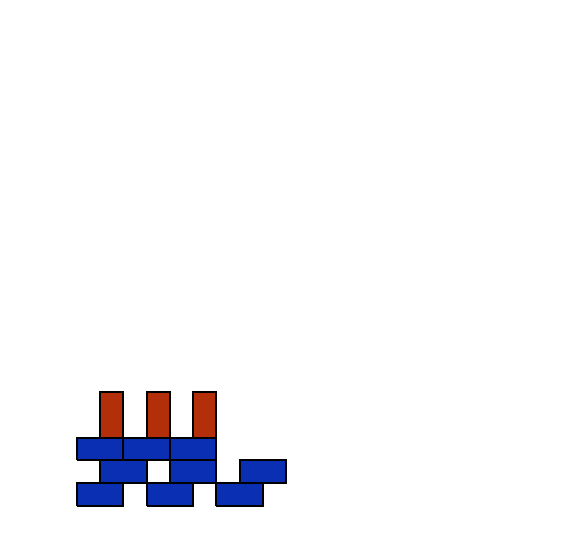

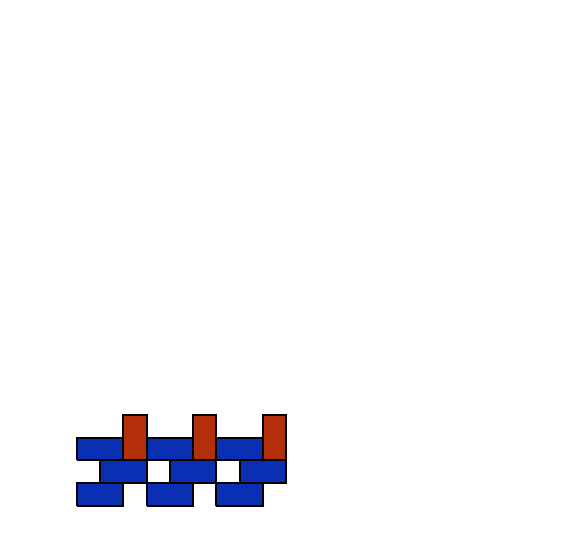

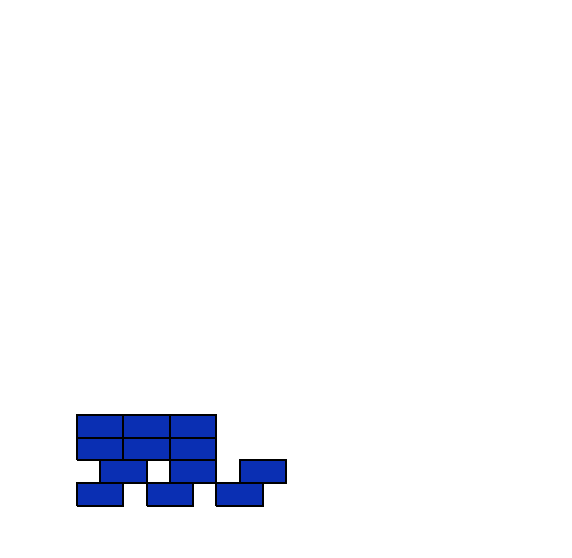

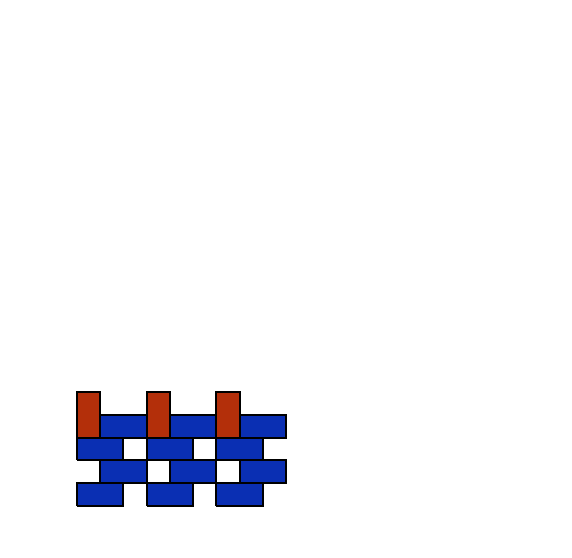

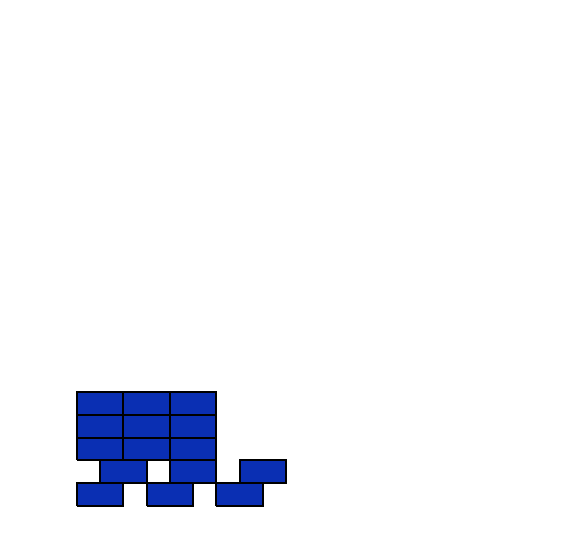

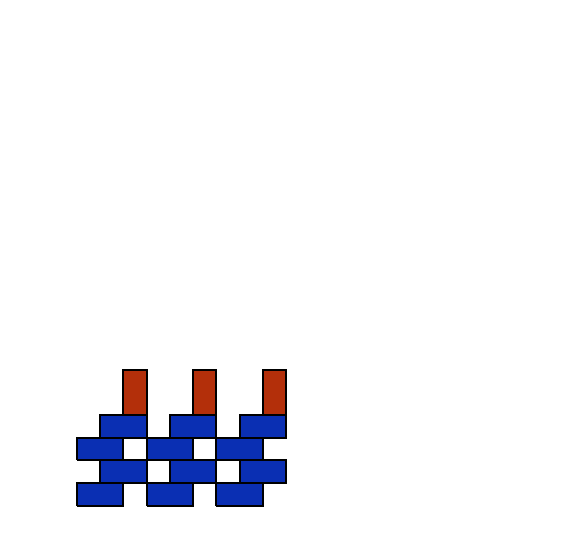

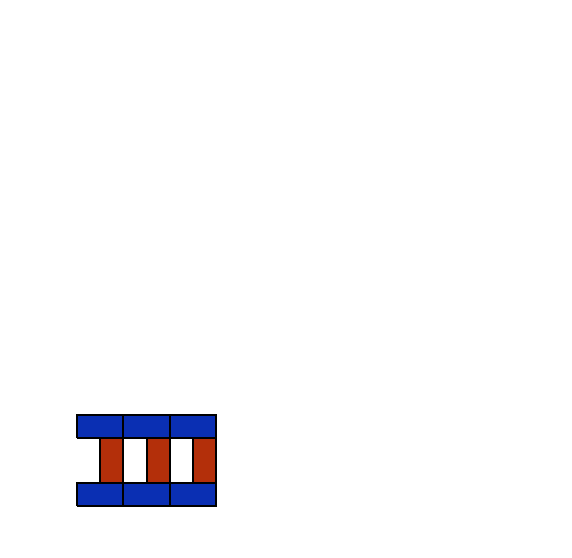

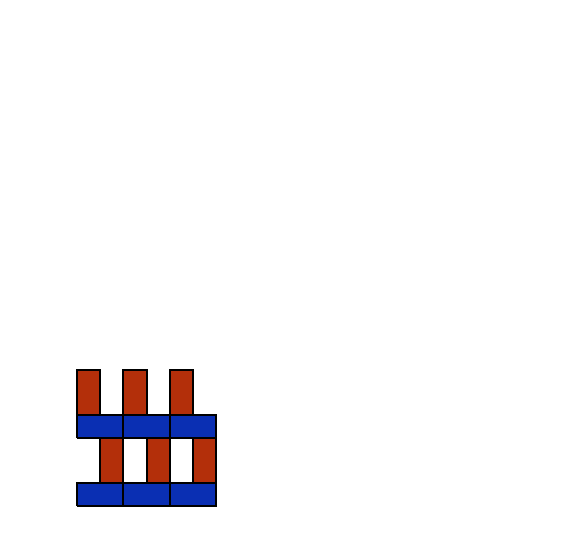

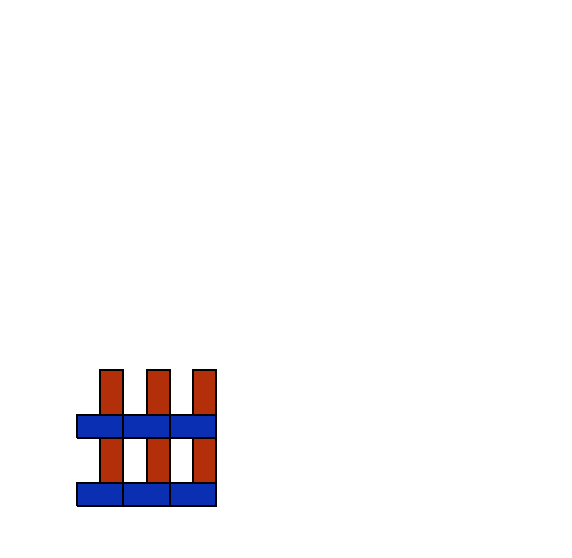

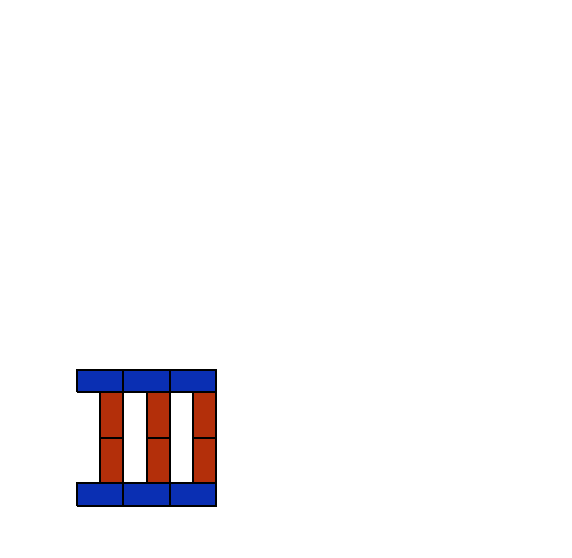

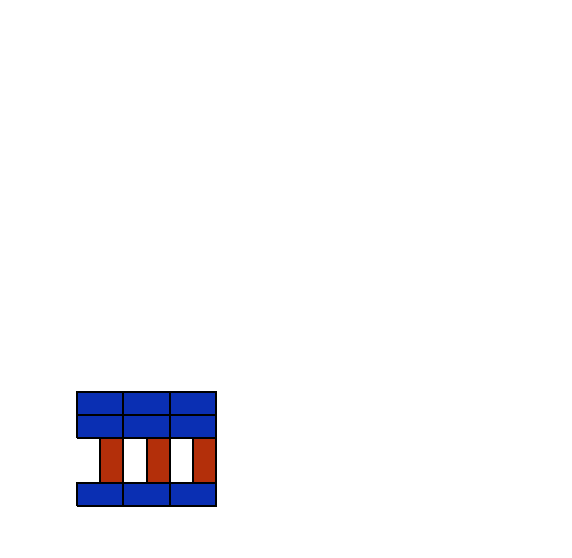

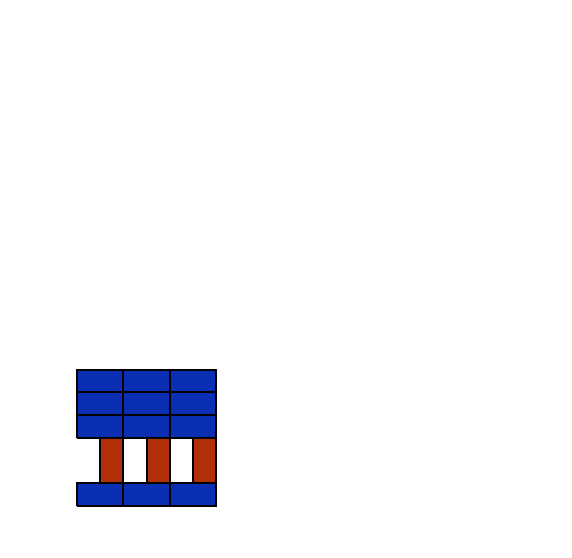

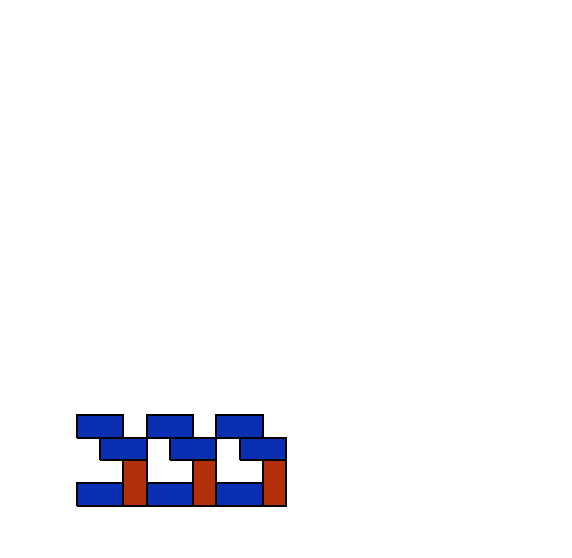

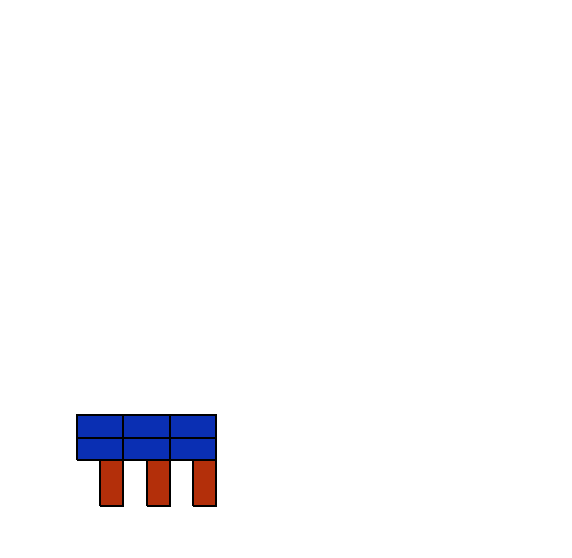

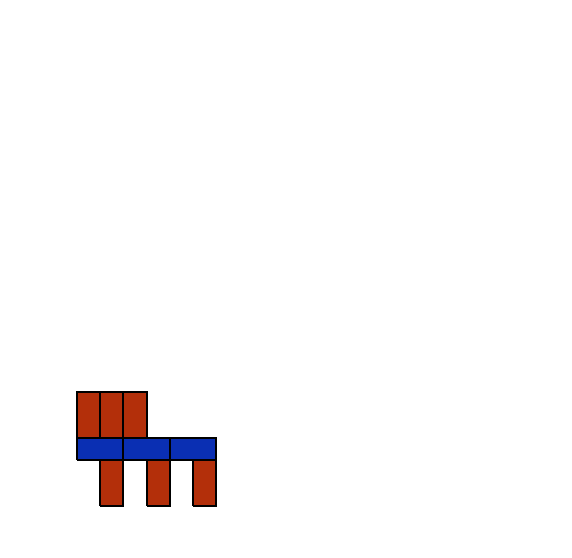

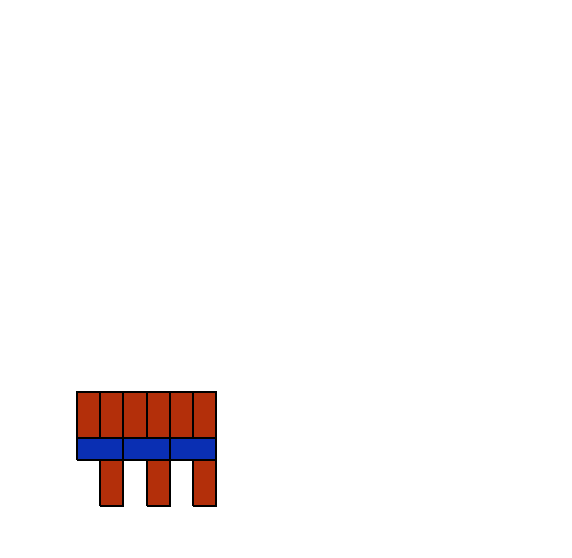

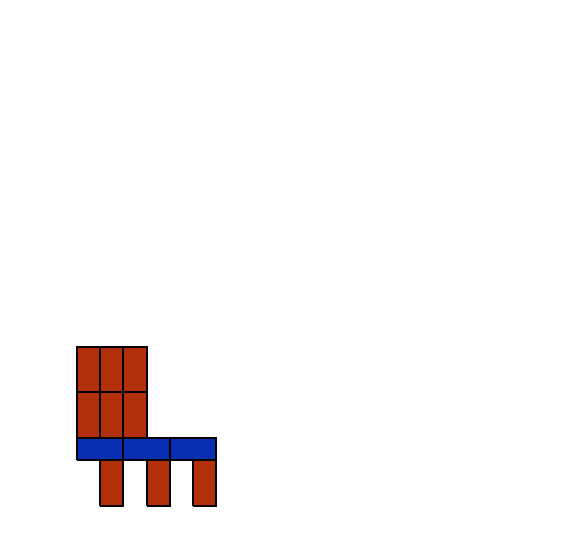

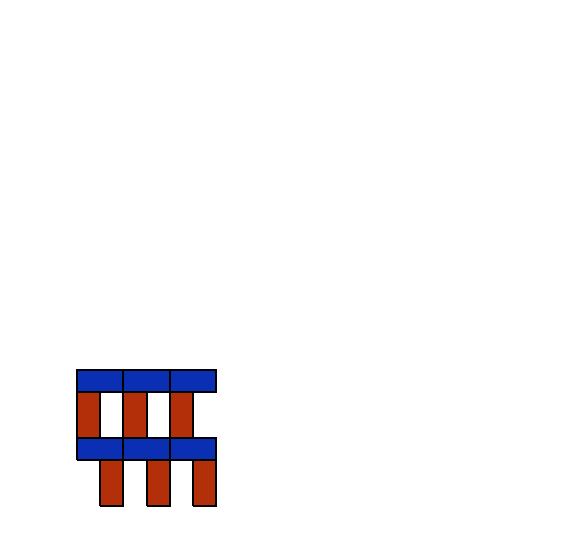

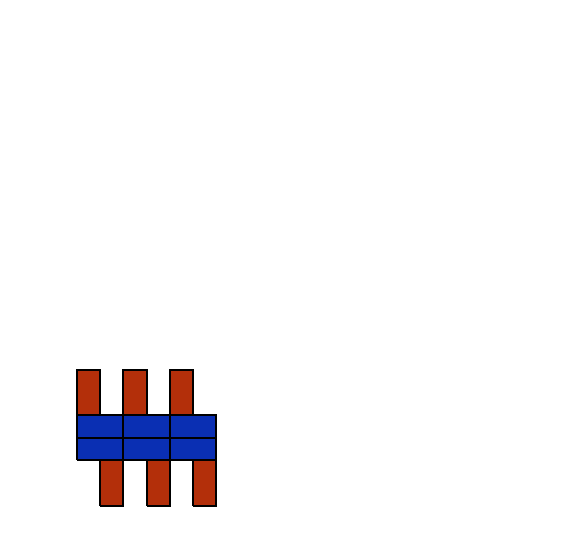

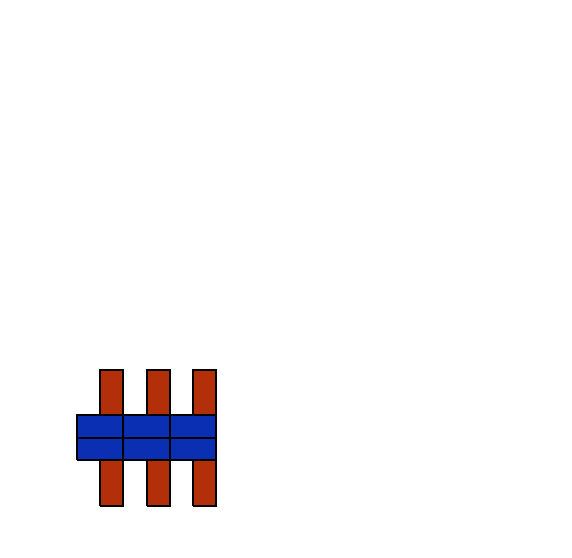

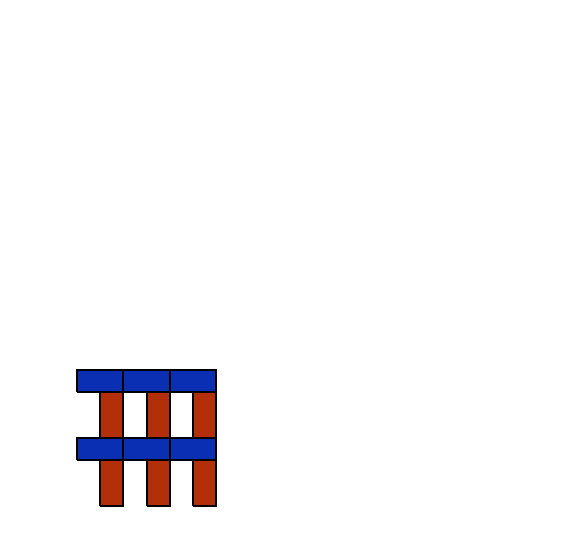

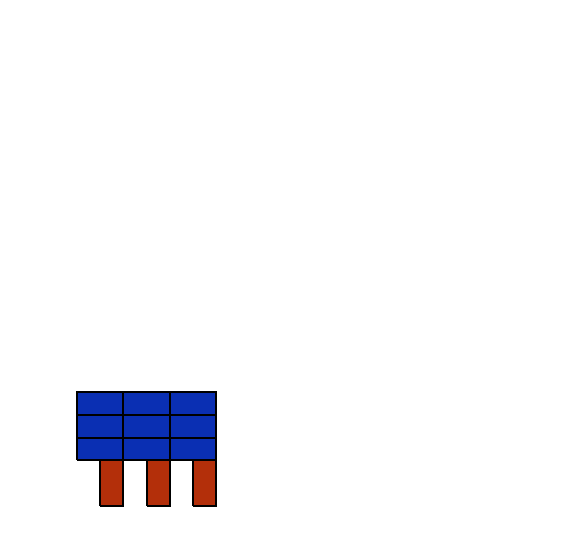

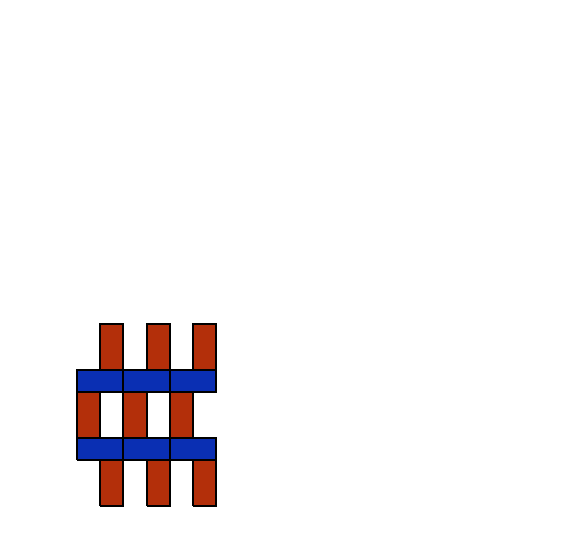

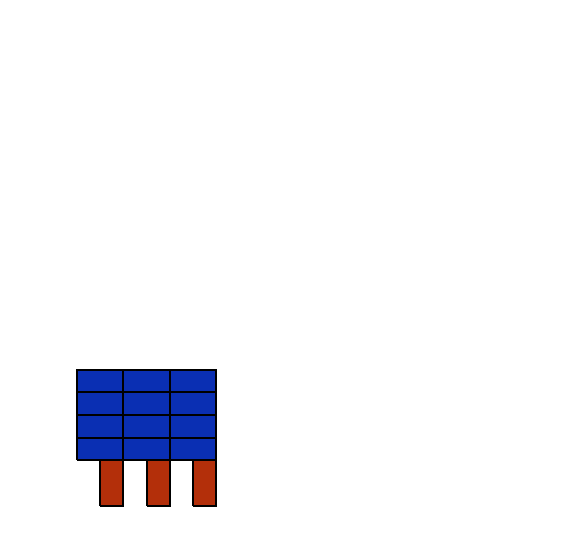

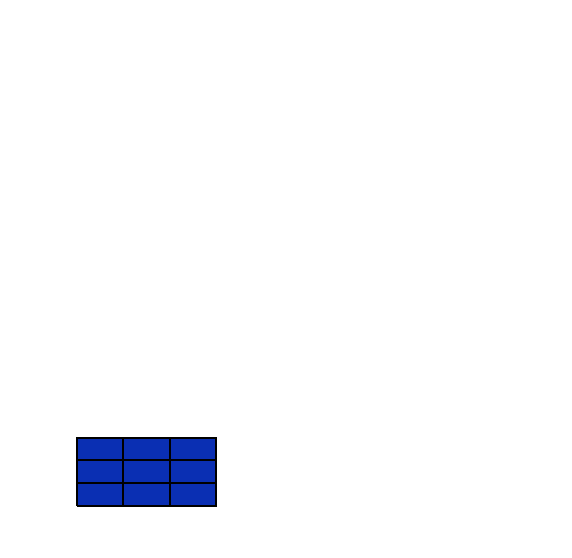

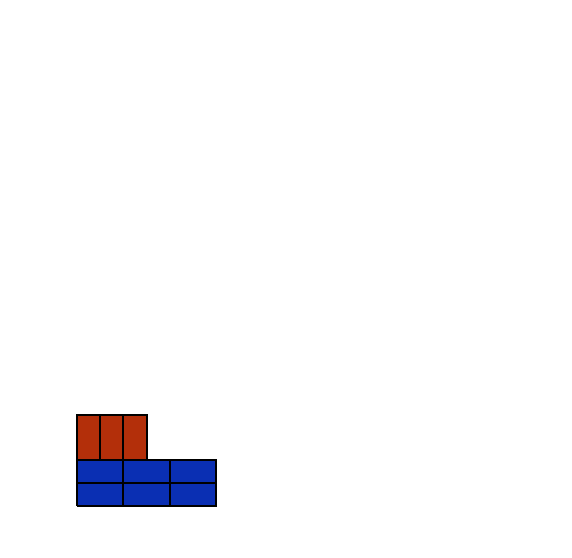

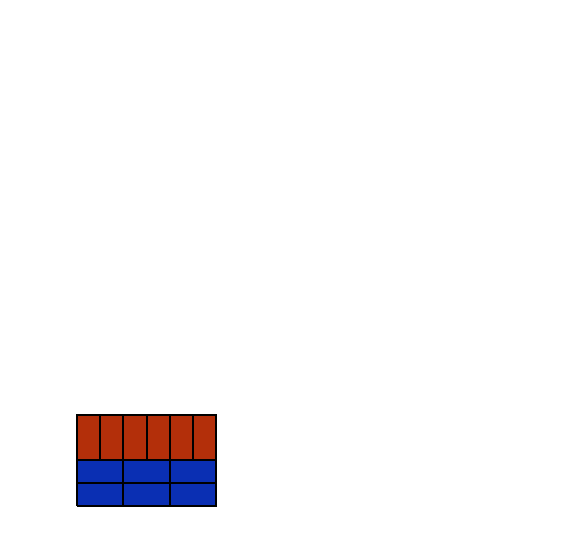

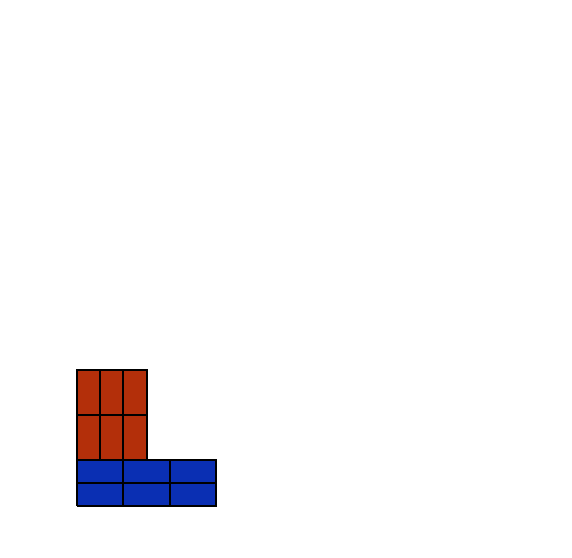

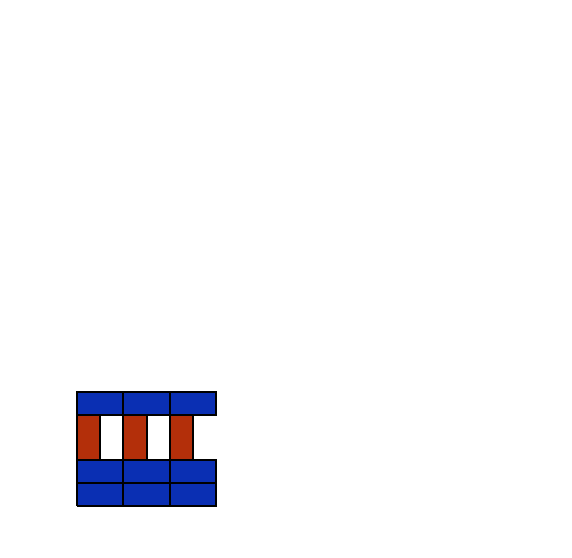

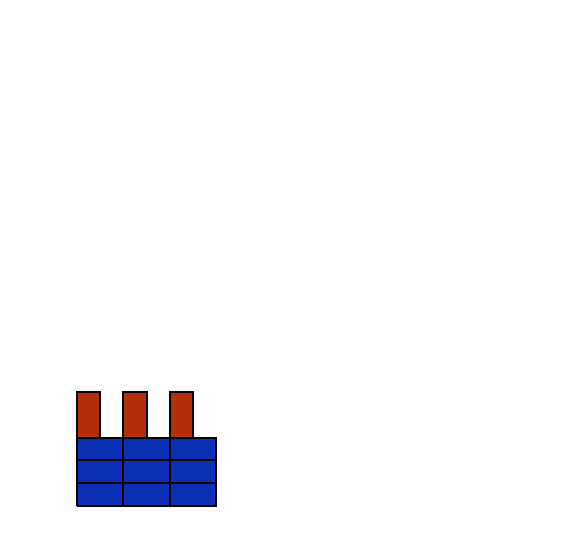

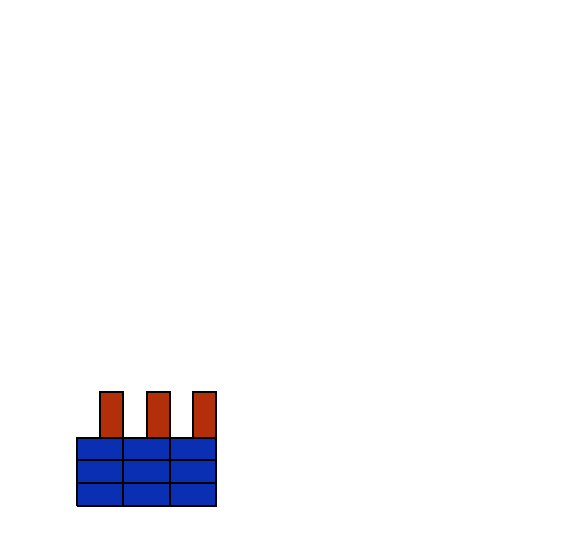

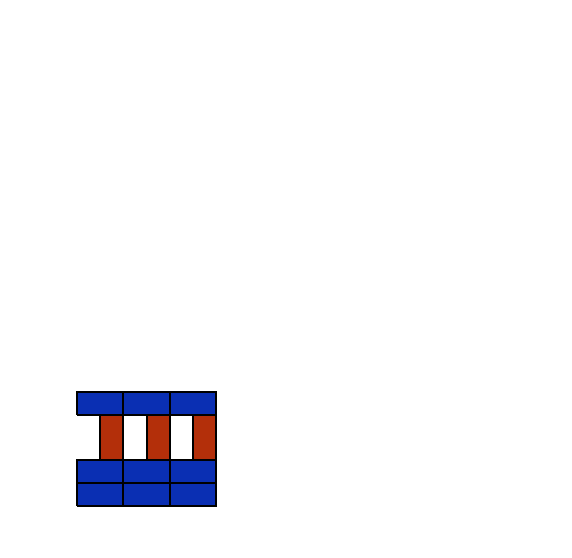

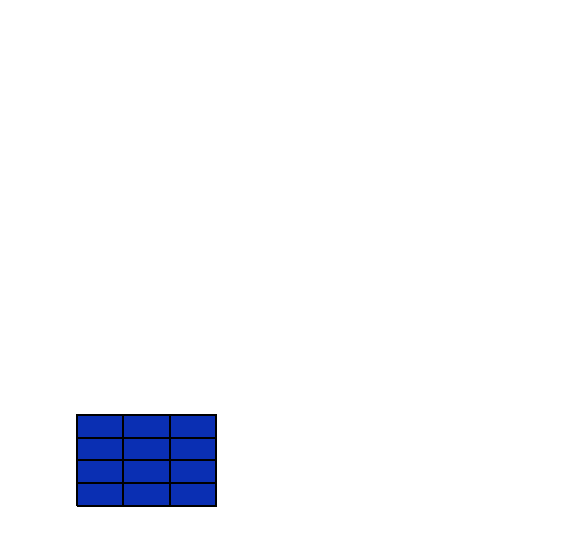

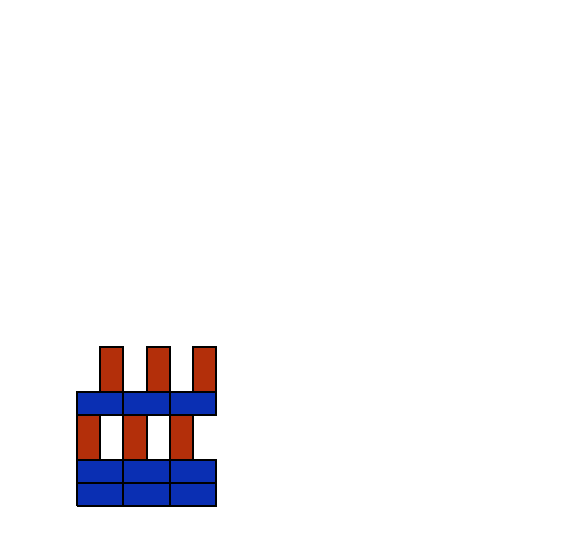

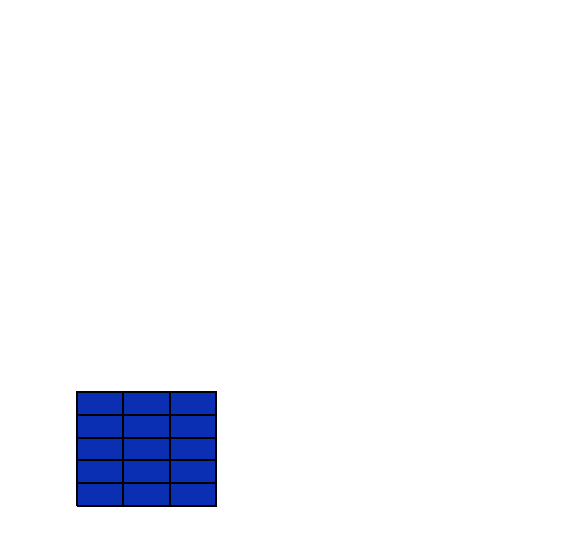

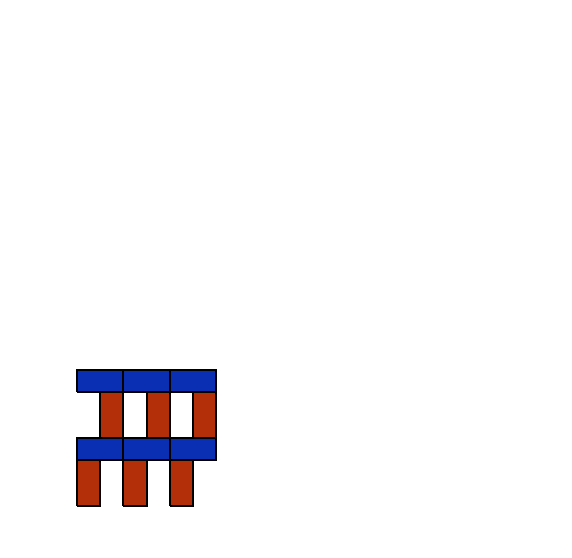

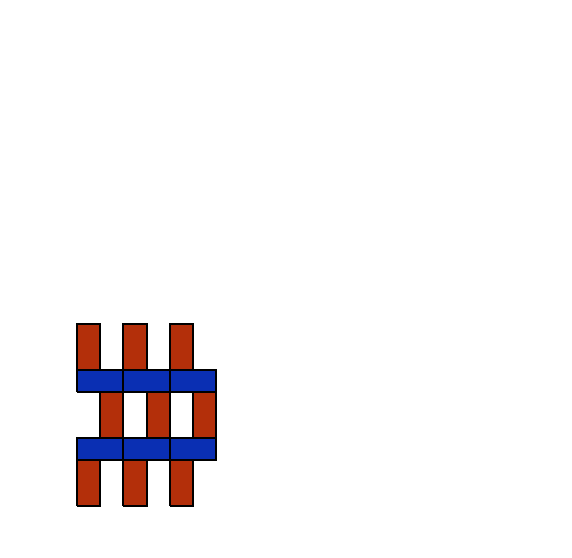

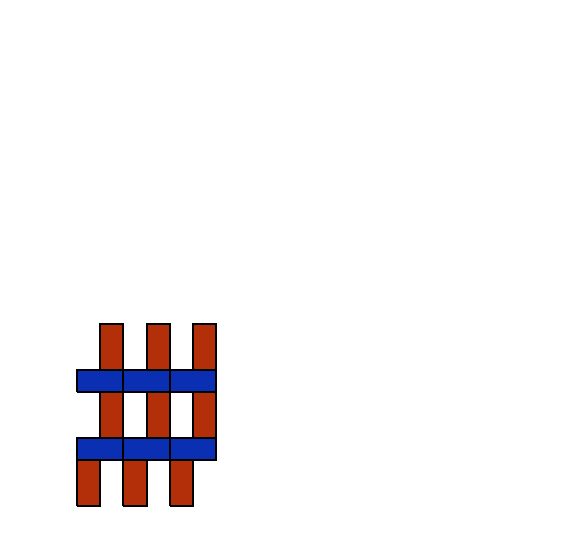

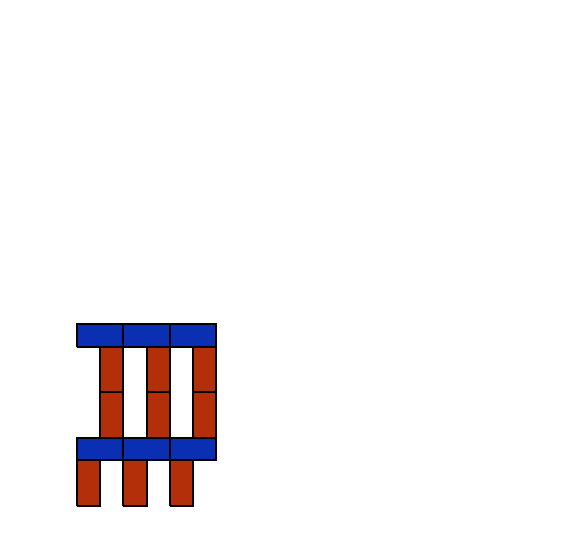

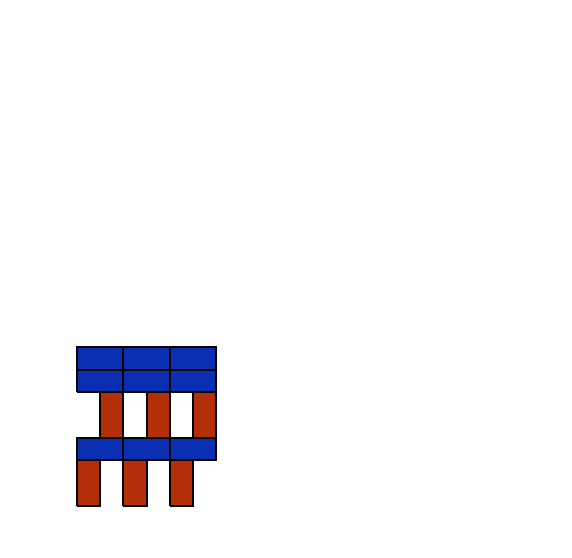

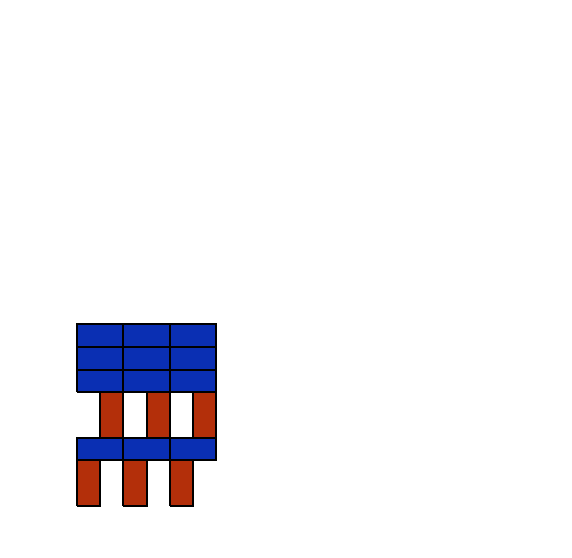

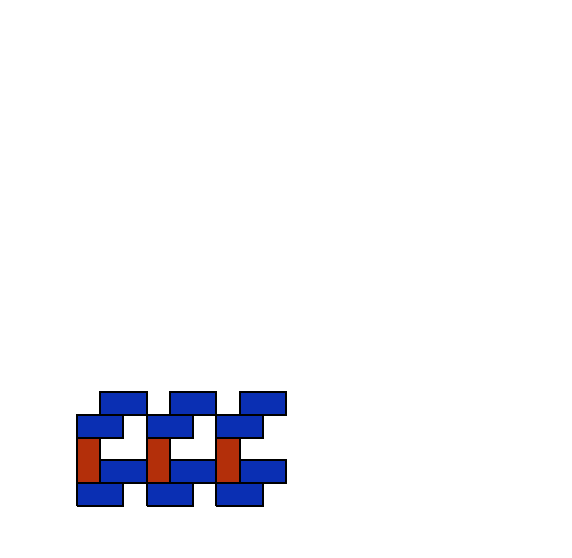

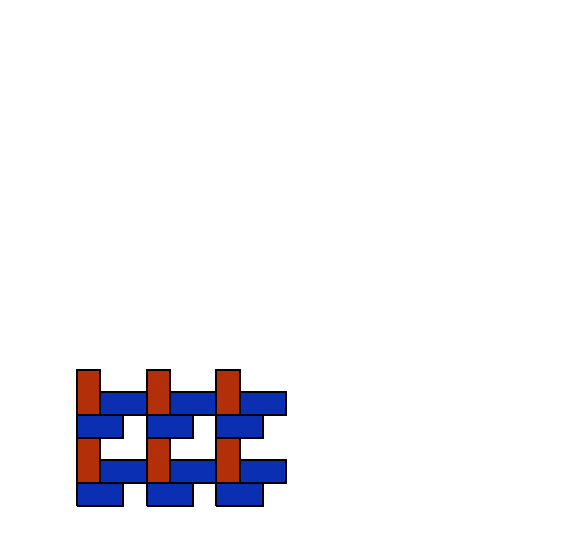

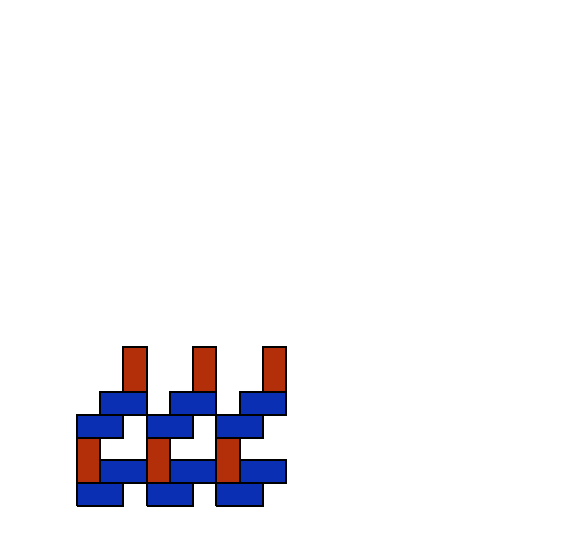

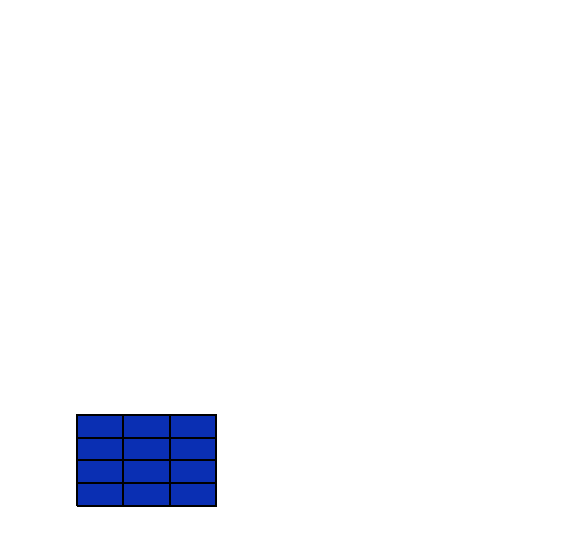

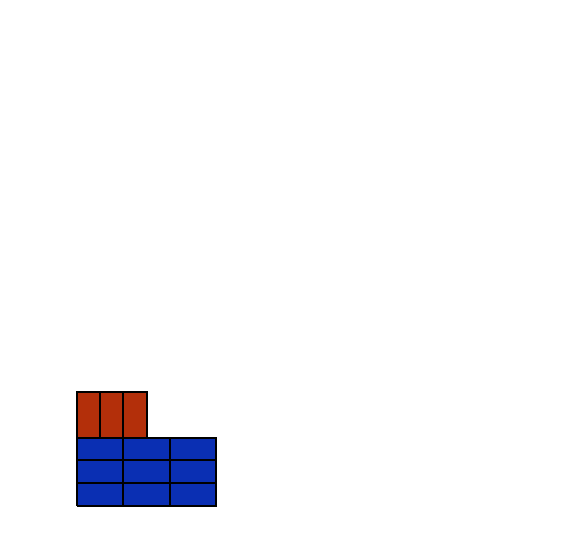

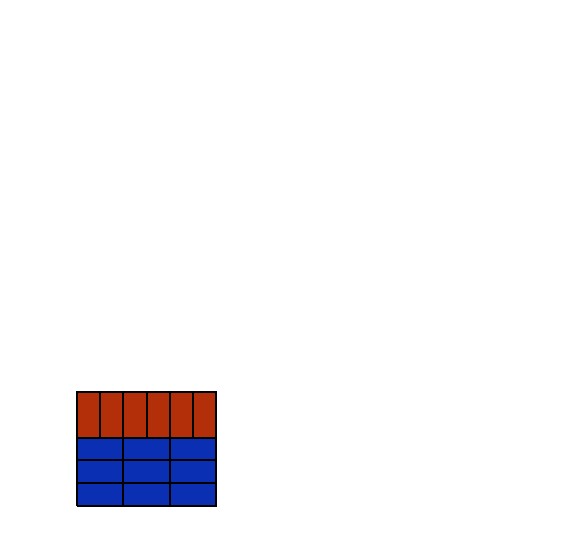

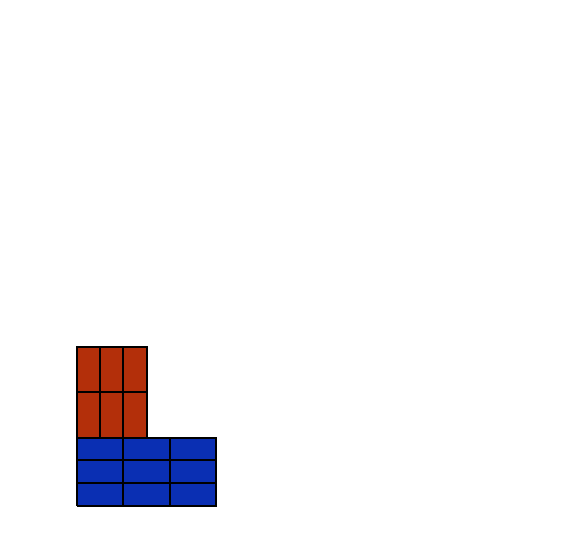

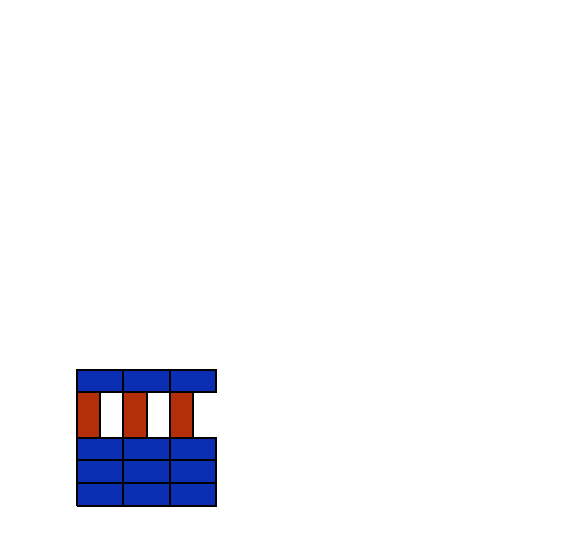

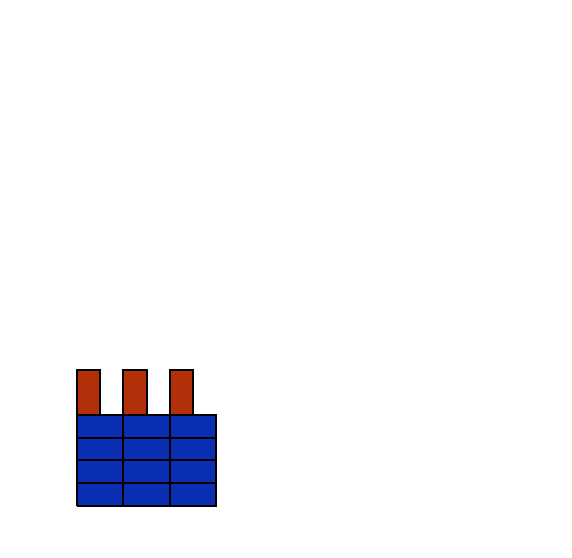

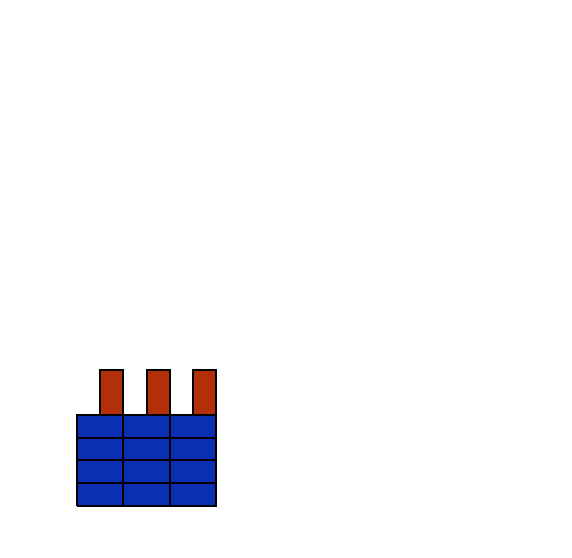

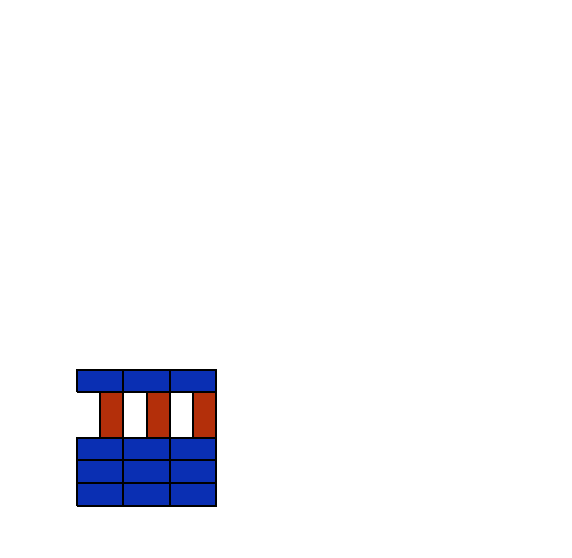

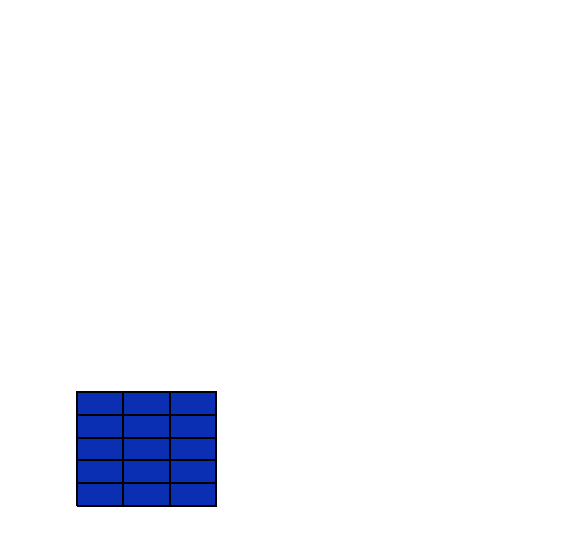

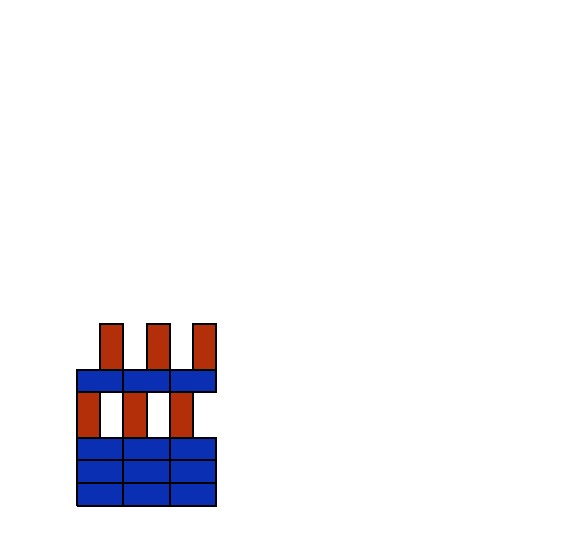

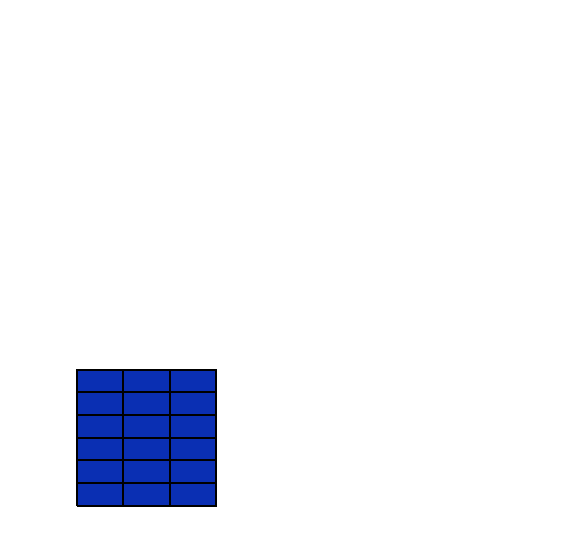

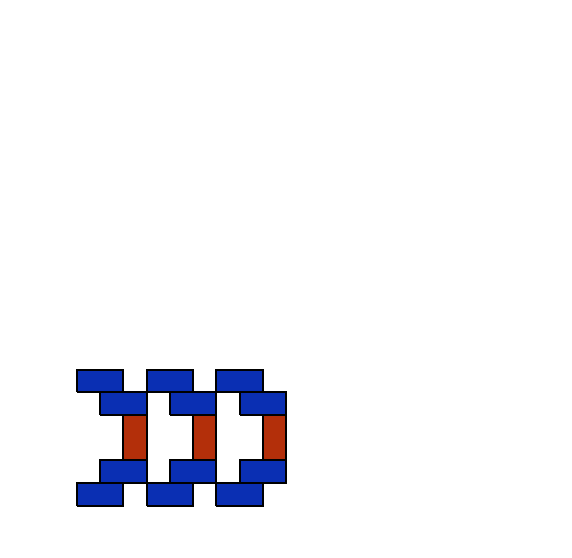

In [591]:
# Create sets of rows (clean separation between rows (less interesting, but simpler))

for wall_width in range(3,4):
    
    for i, row_1 in enumerate(rows[wall_width][0:20]):
        
        for j, row_2 in enumerate(rows[wall_width][0:20]):
            w = new_world()
            w.place_tower(row_1, x_location=0)
            row_1_height = w.tower_height()
            w.place_tower(row_2, x_location=0)
            
            row_2_height = new_world().place_tower(row_2, x_location=0).tower_height()
            
            if not(w.broken) and (w.tower_height() == row_1_height + row_2_height):
#                 print(row_1_height,row_2_height, '=', w.tower_height())
                utils.draw_world(w)

False


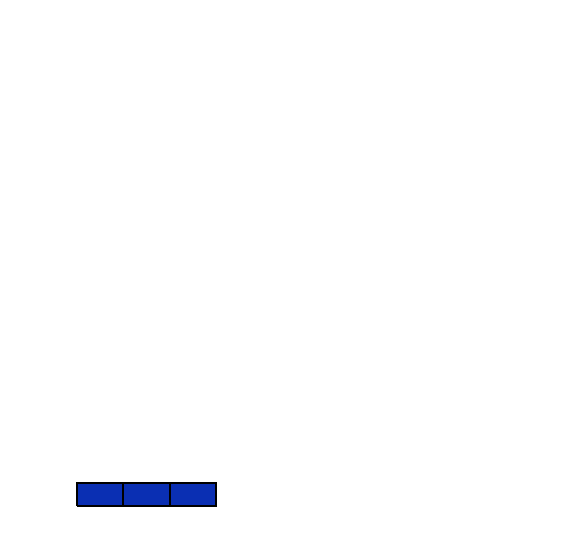

False


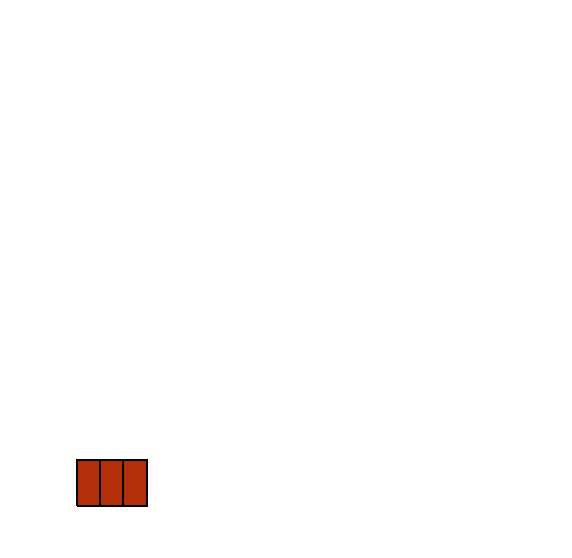

False


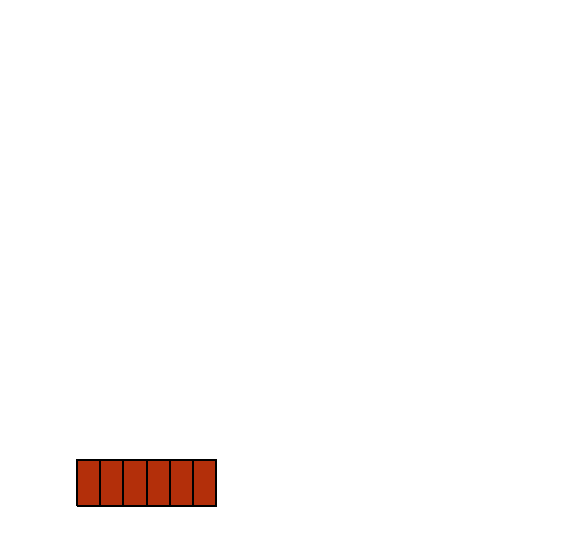

False


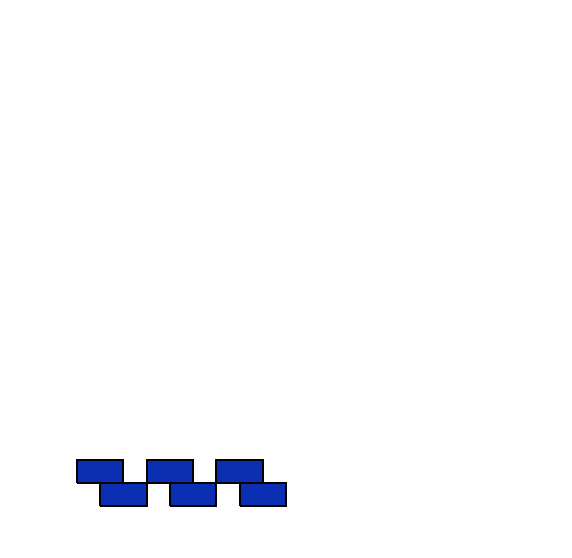

False


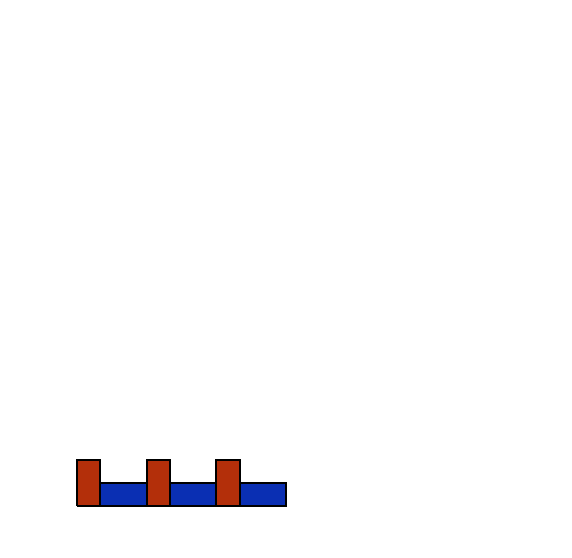

False


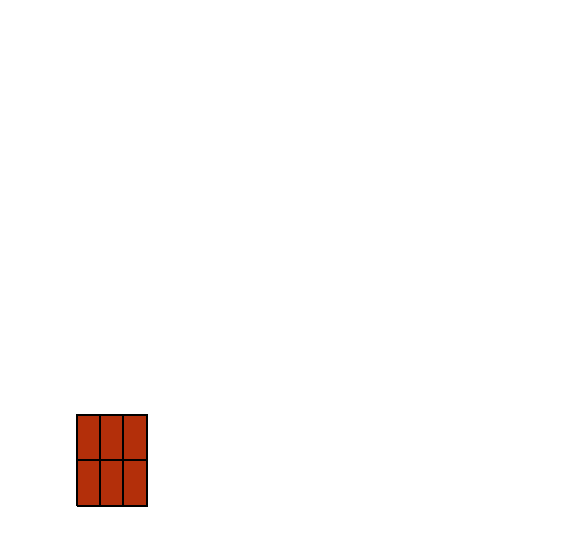

False


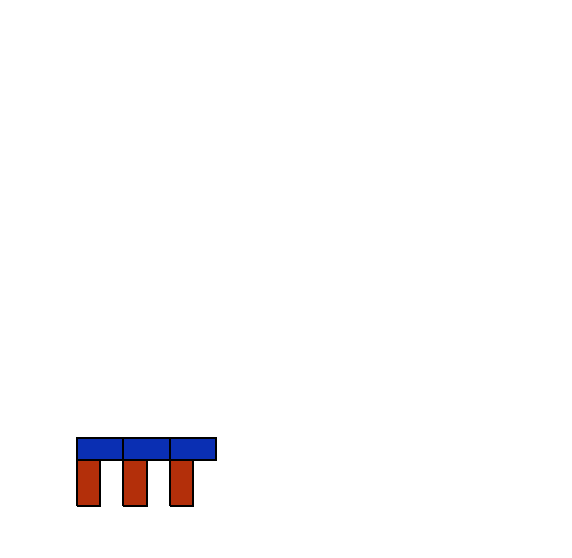

False


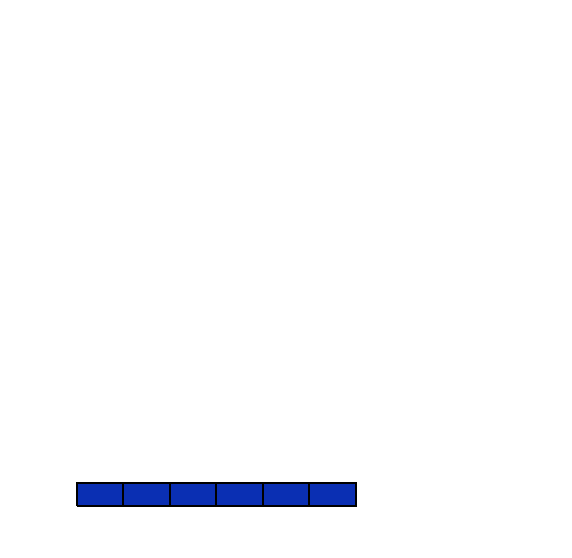

False


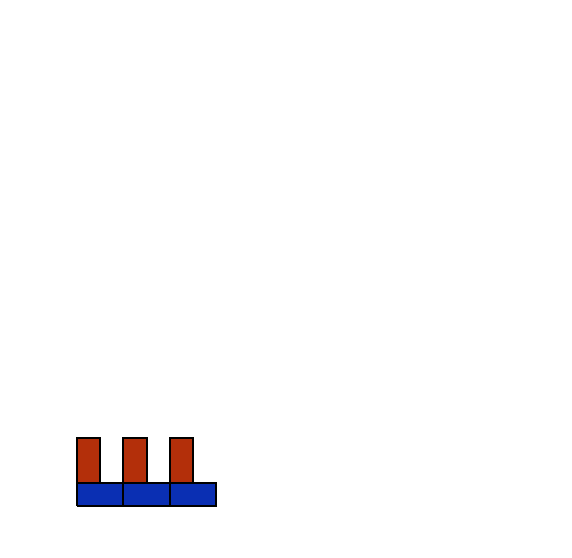

False


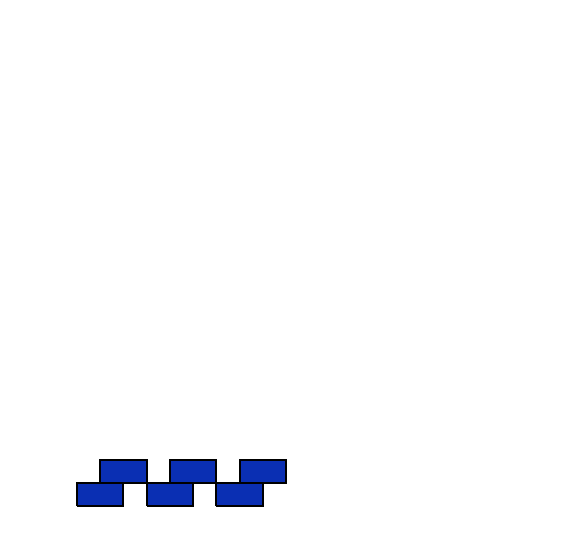

False


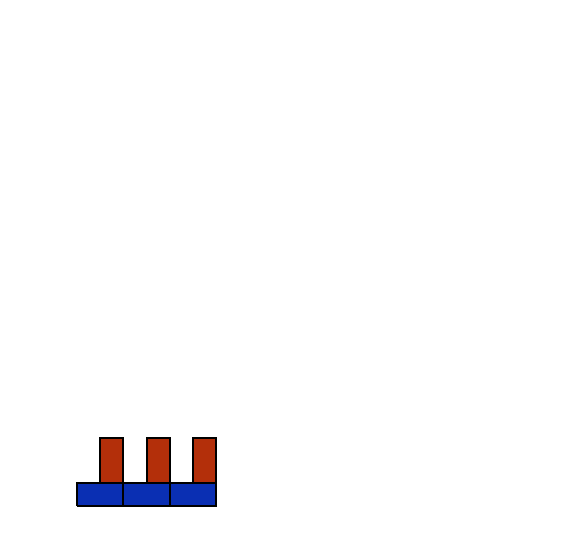

False


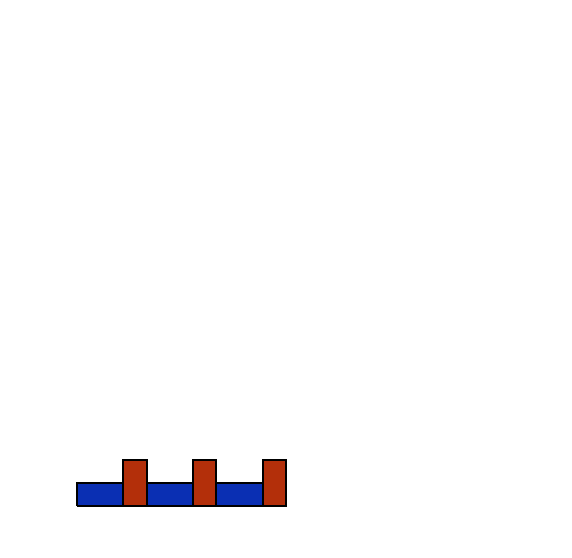

False


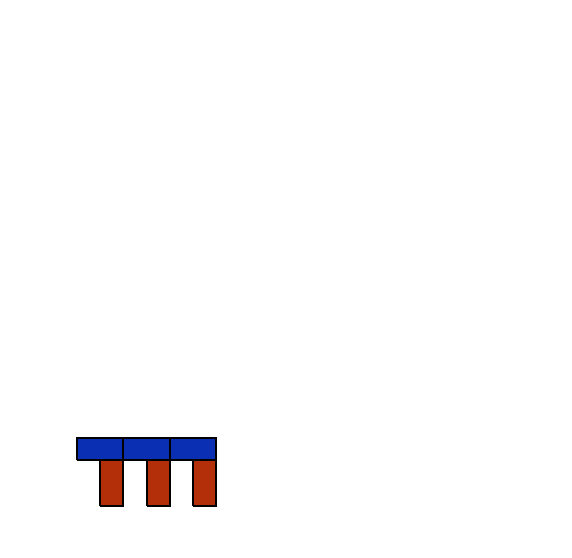

False


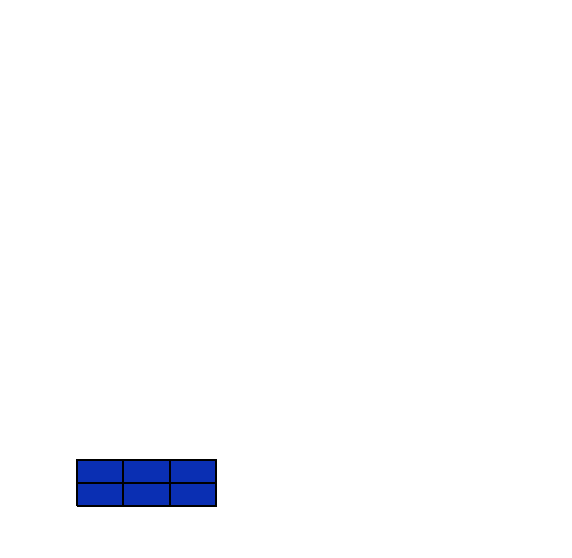

False


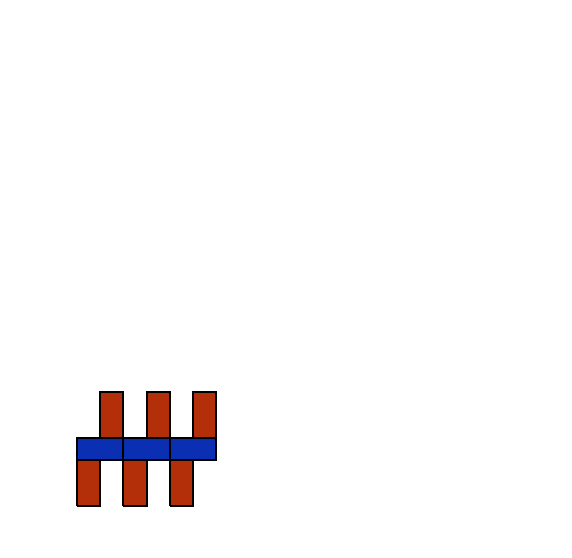

False


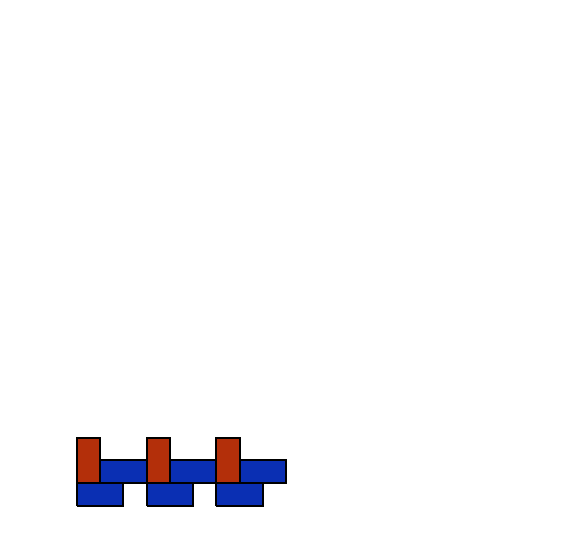

False


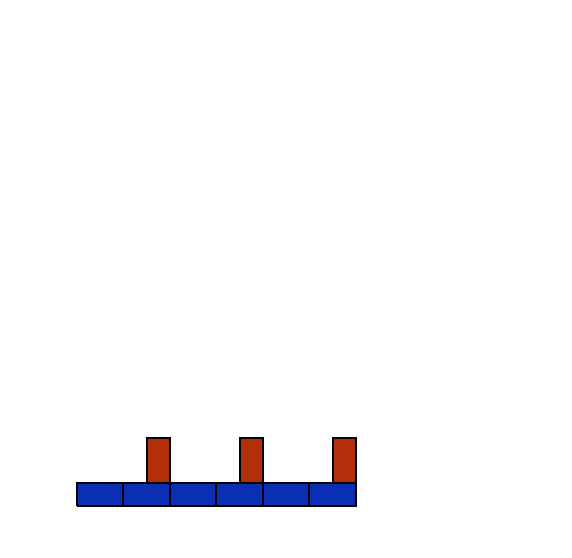

False


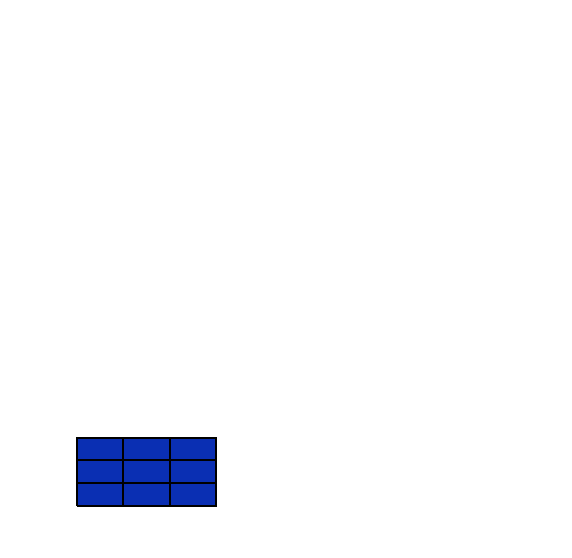

False


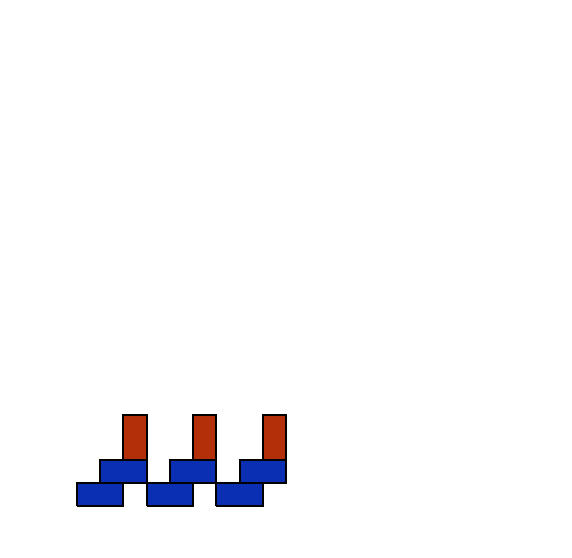

False


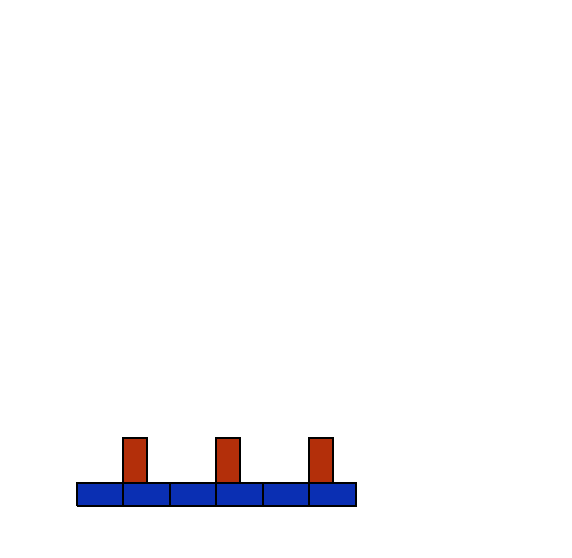

In [576]:
for r in rows[3][0:20]:
    w = new_world()
    w.place_tower(r, x_location=0)
    print(w.broken)
    utils.draw_world(w)

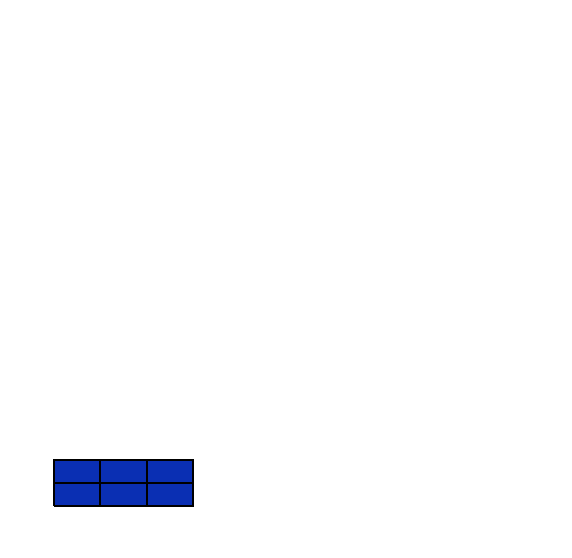

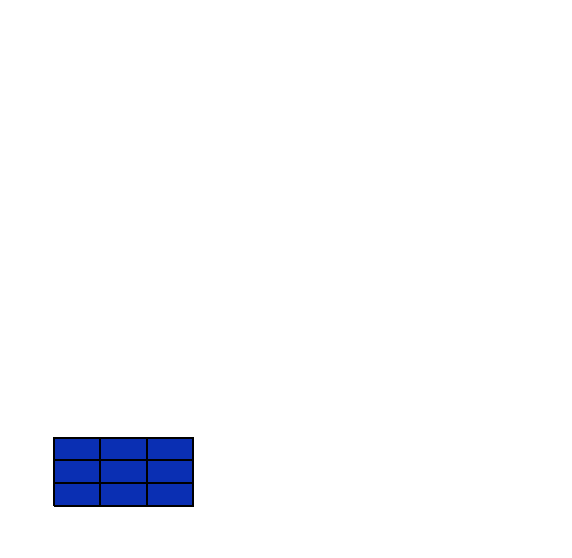

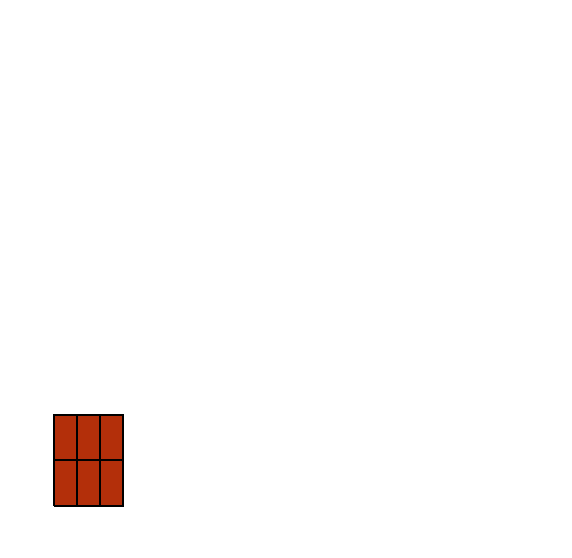

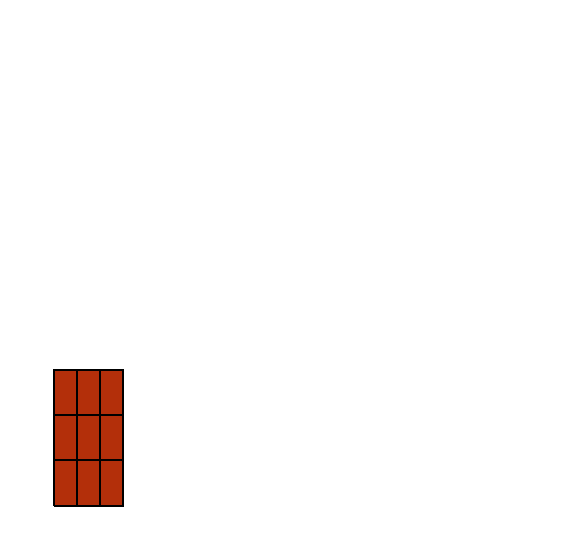

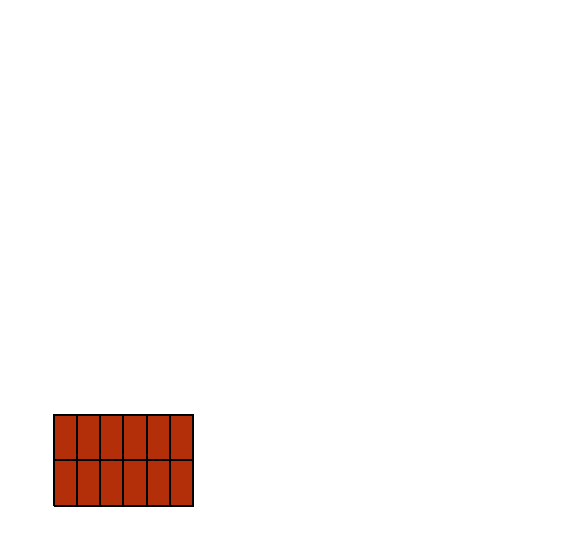

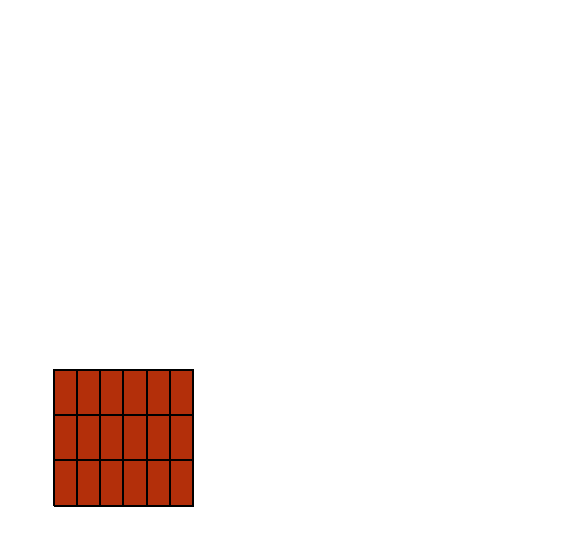

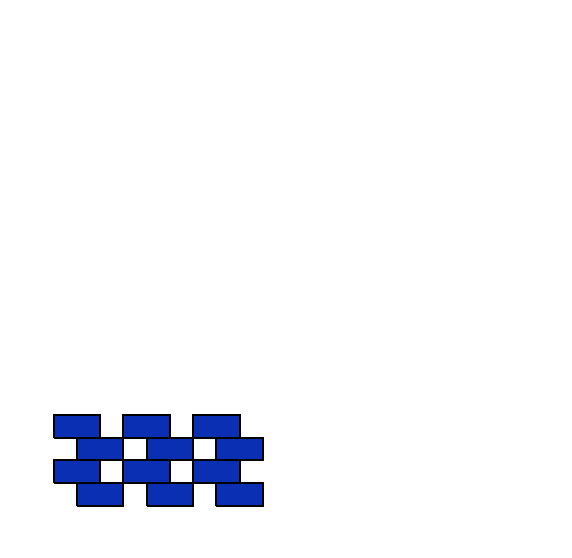

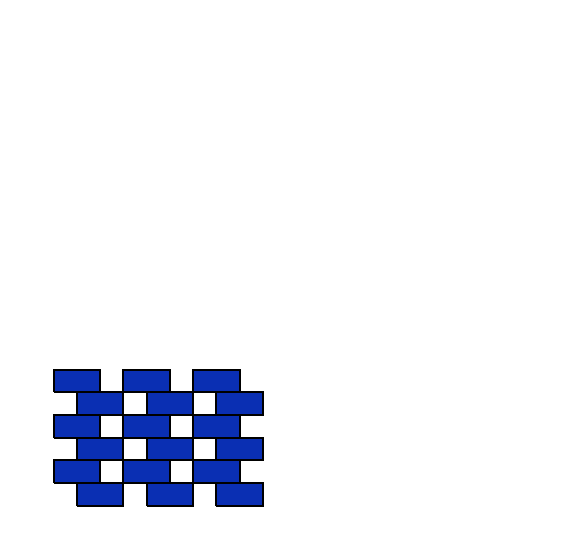

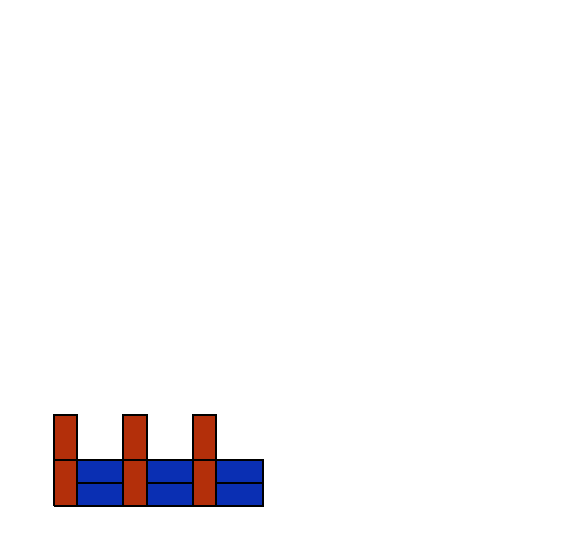

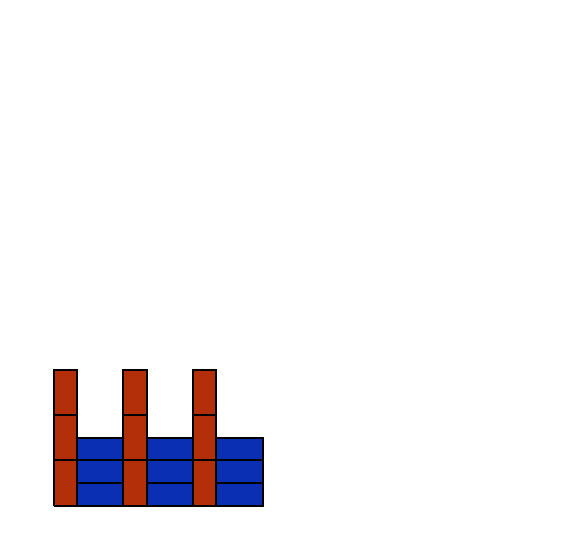

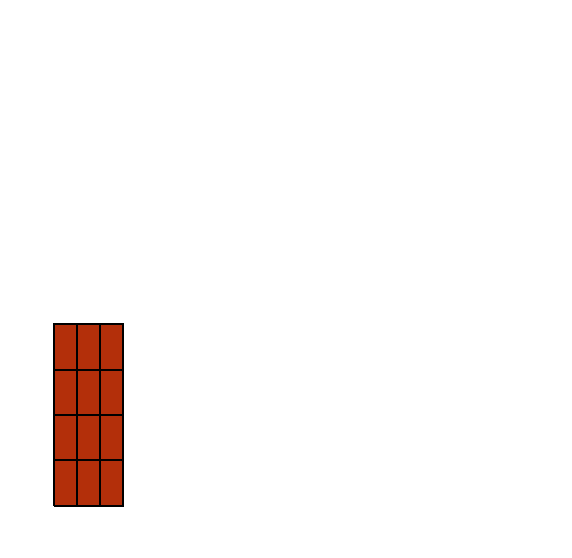

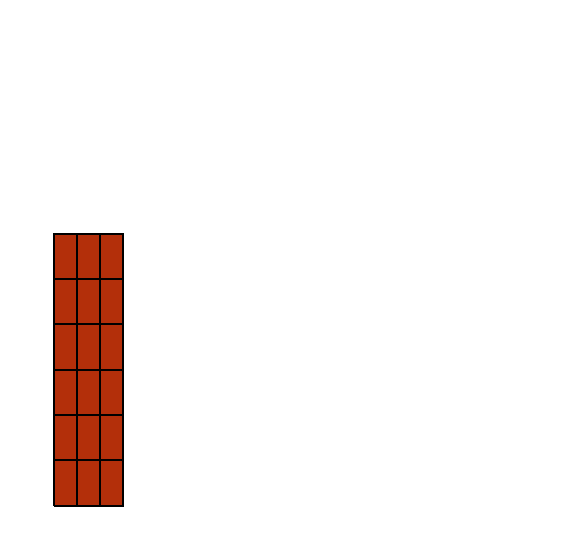

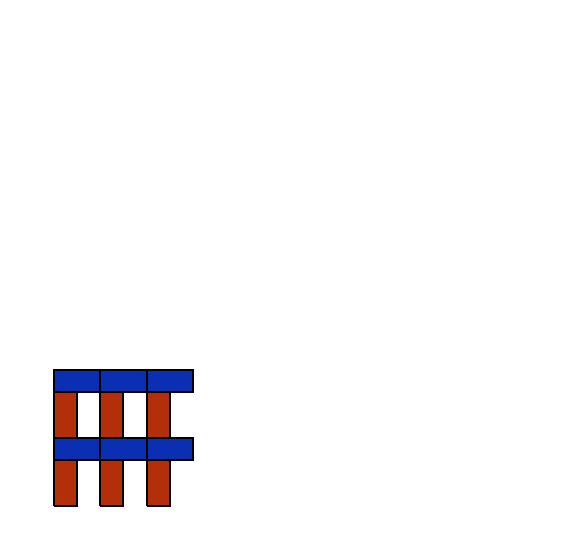

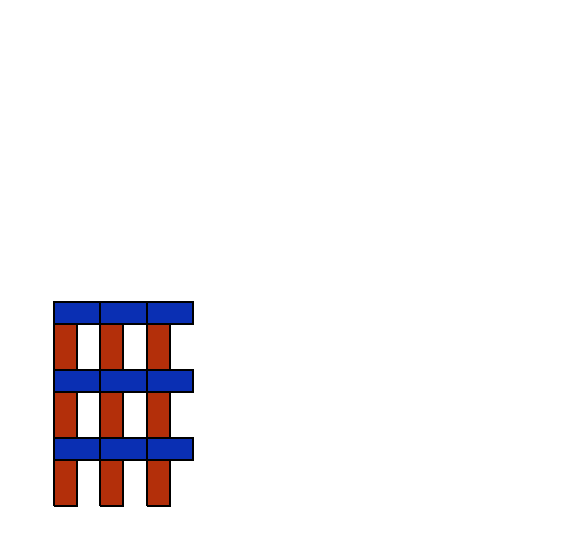

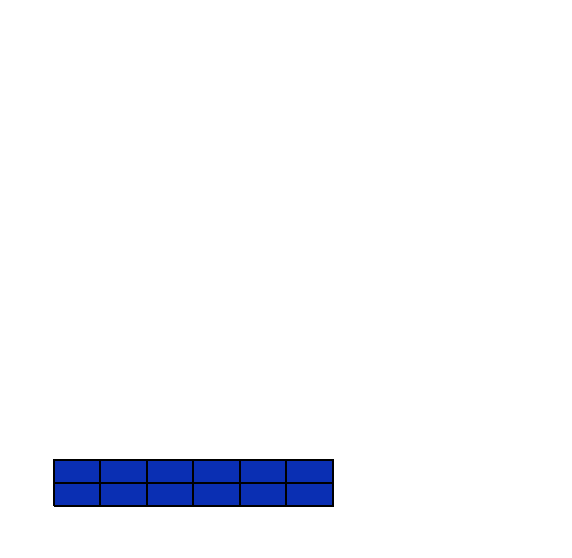

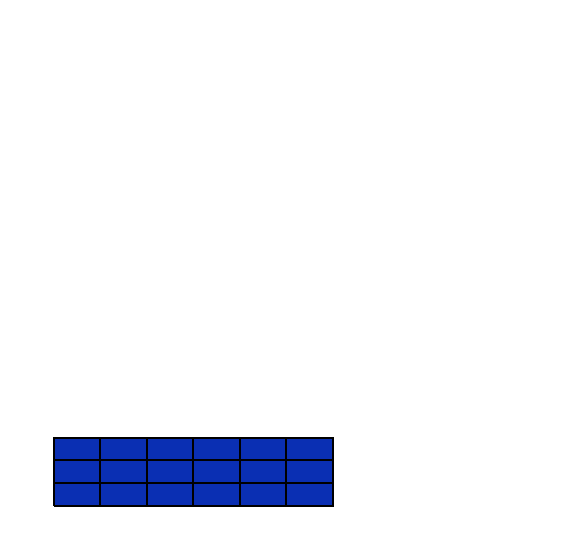

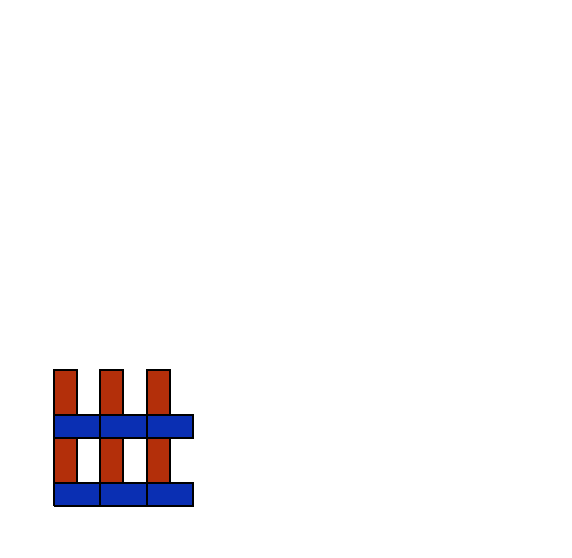

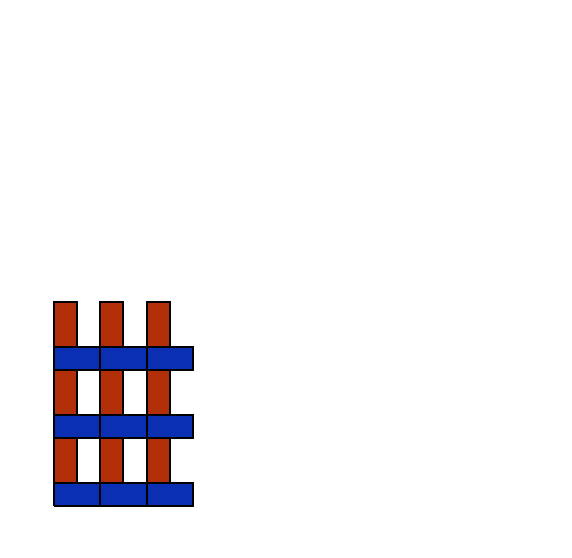

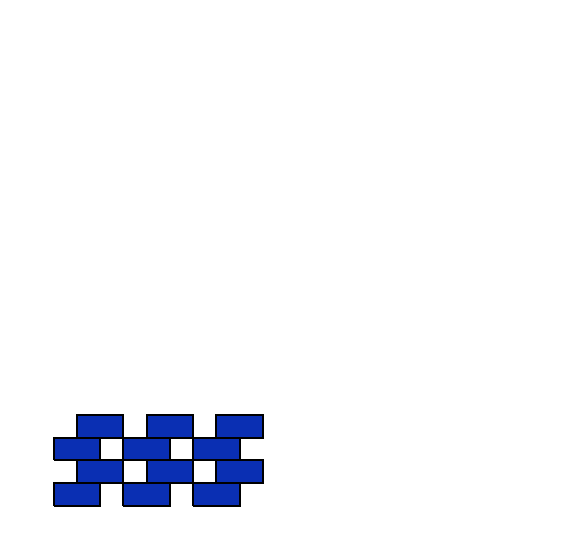

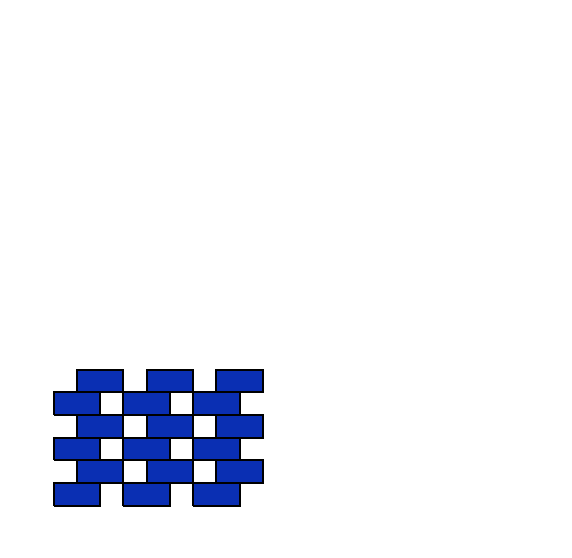

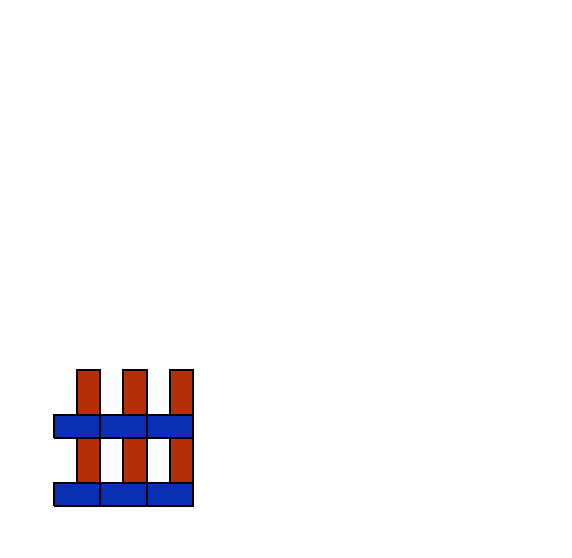

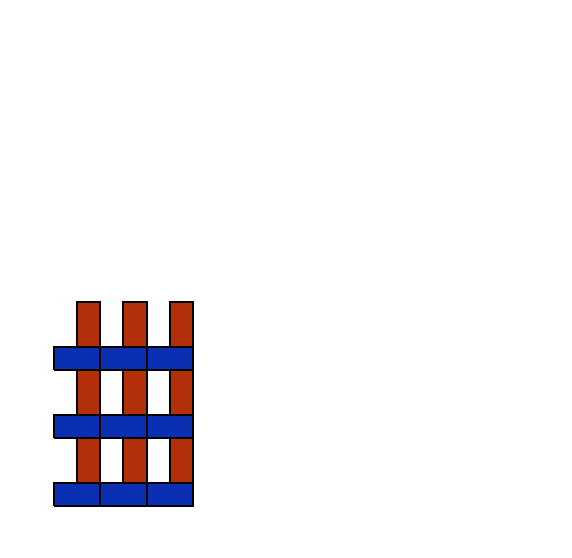

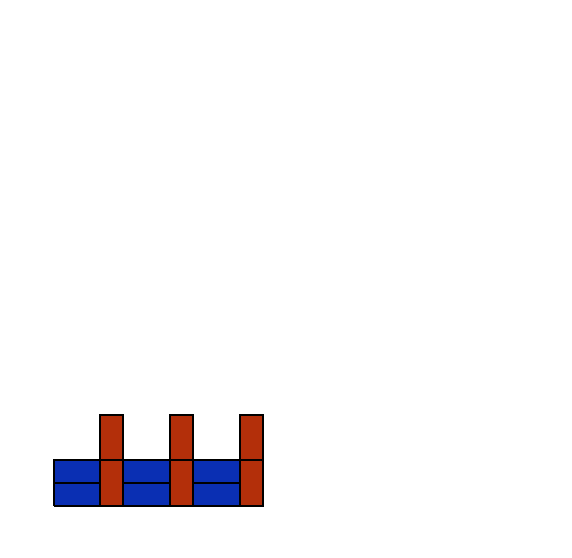

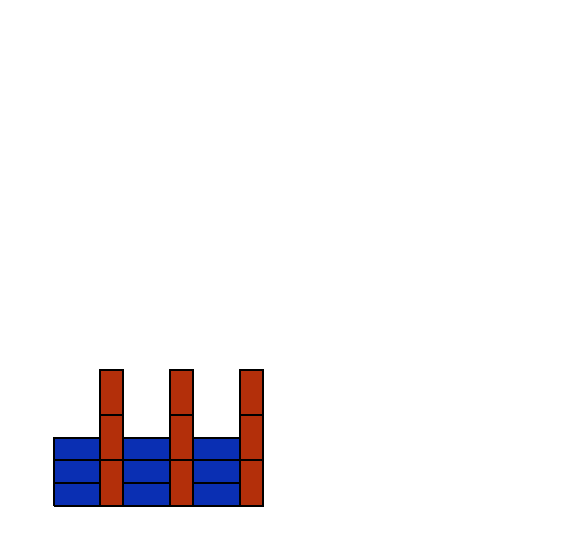

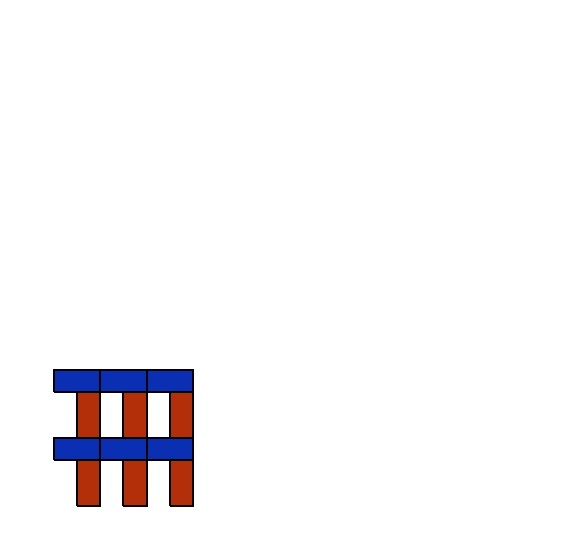

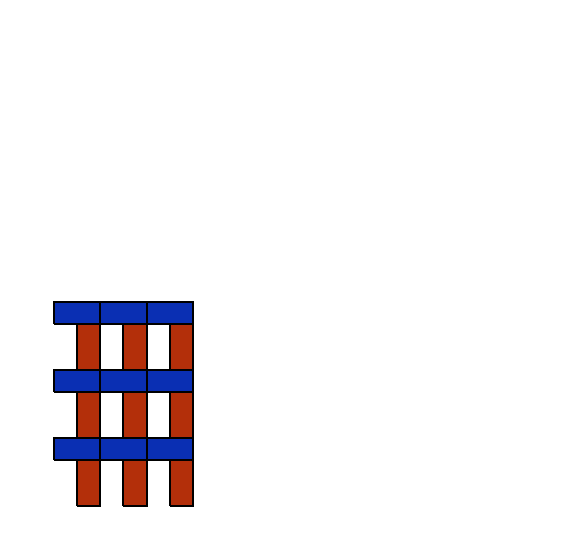

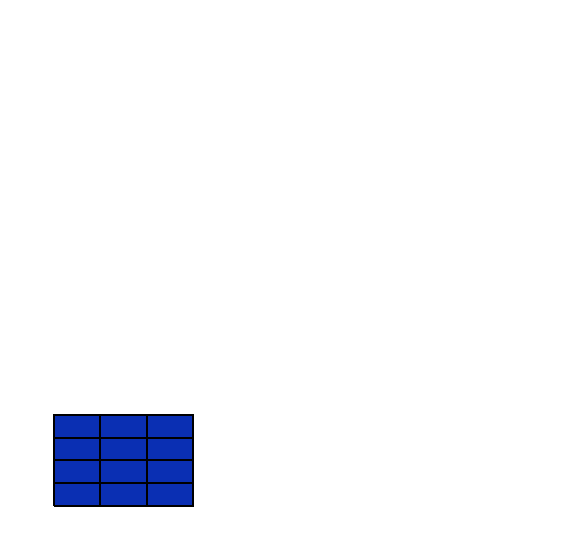

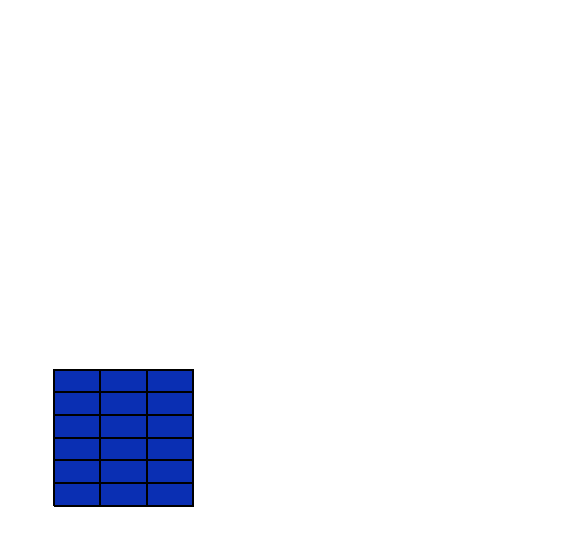

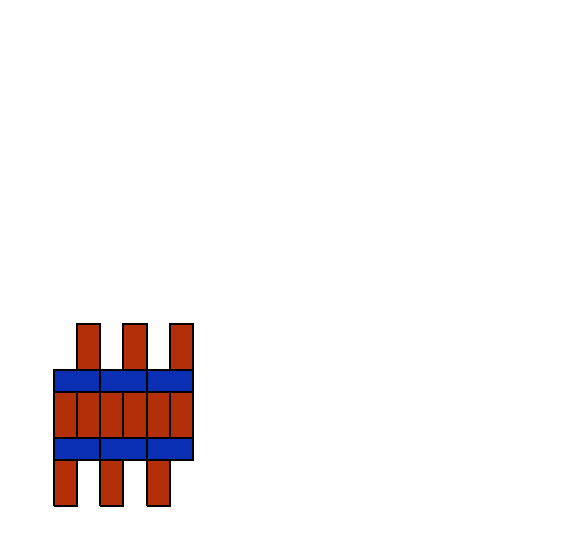

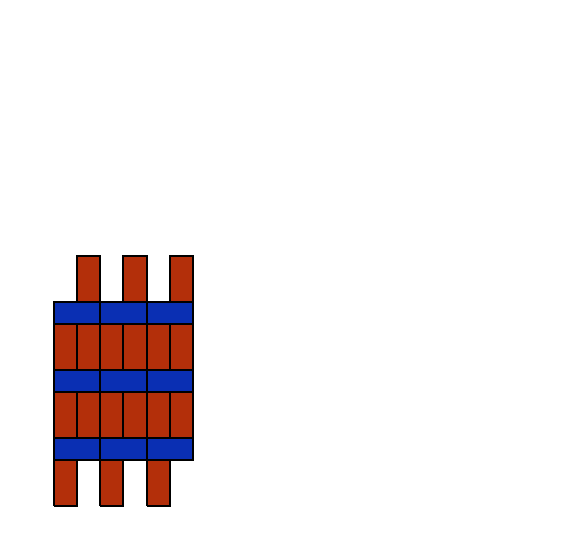

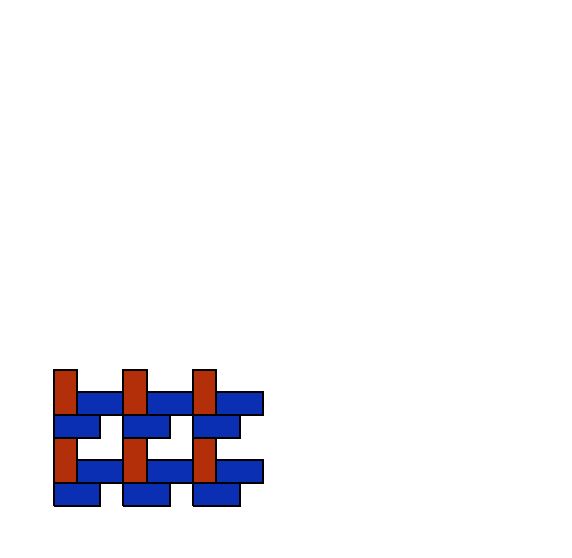

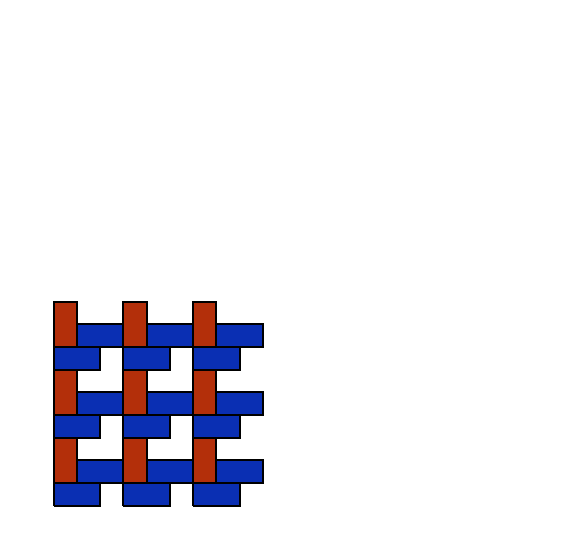

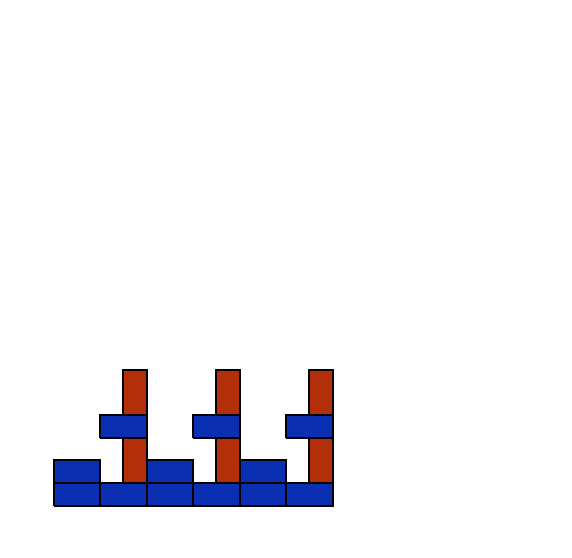

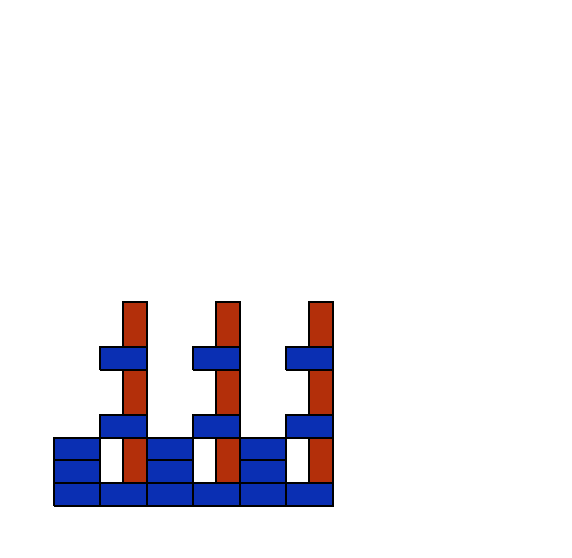

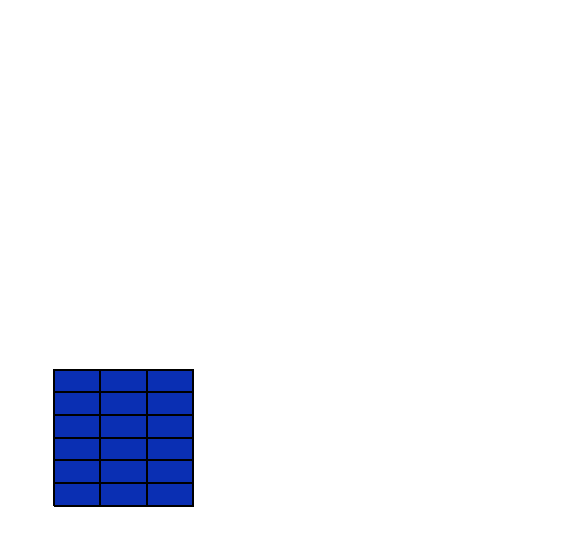

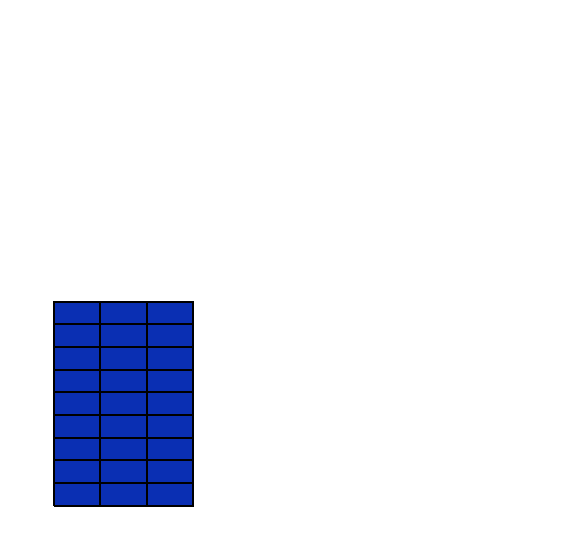

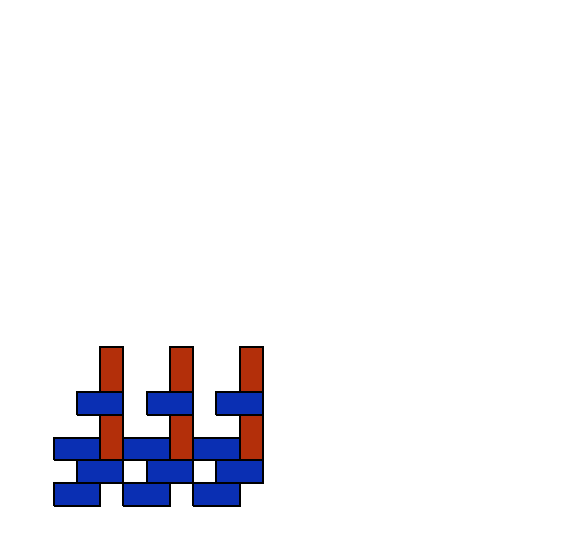

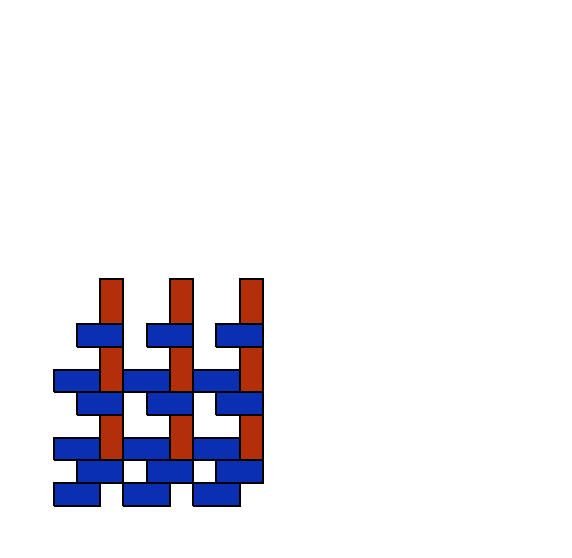

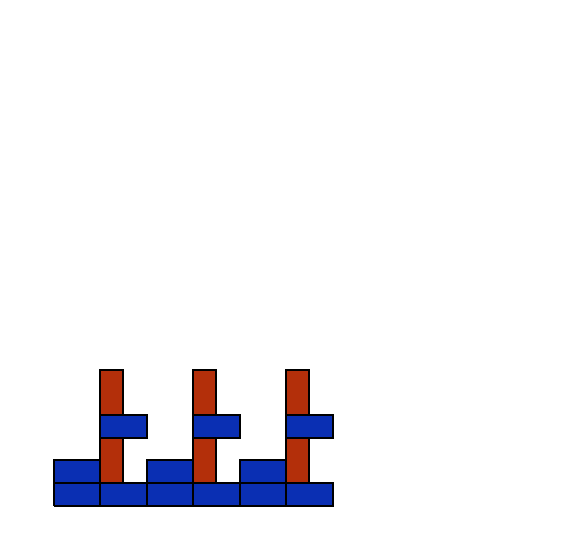

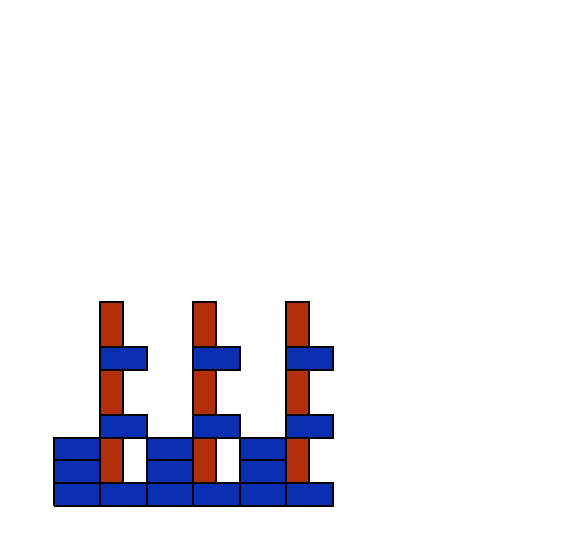

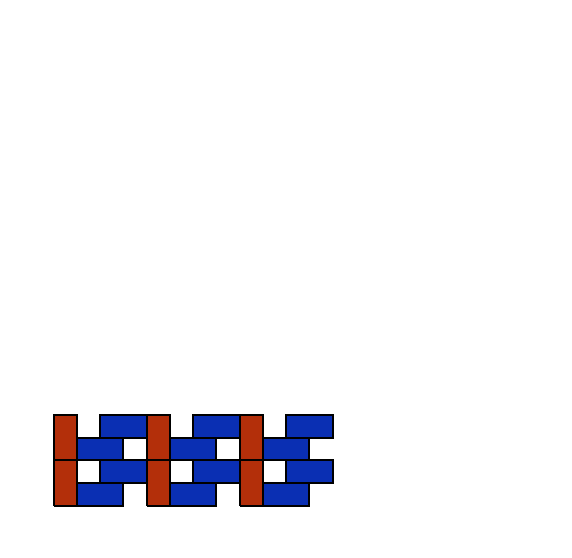

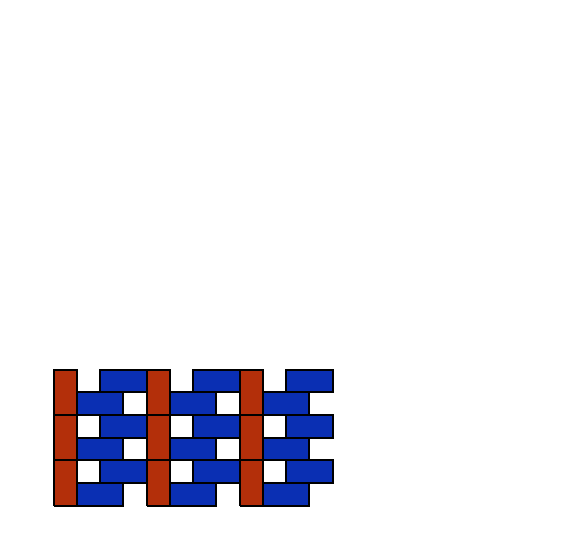

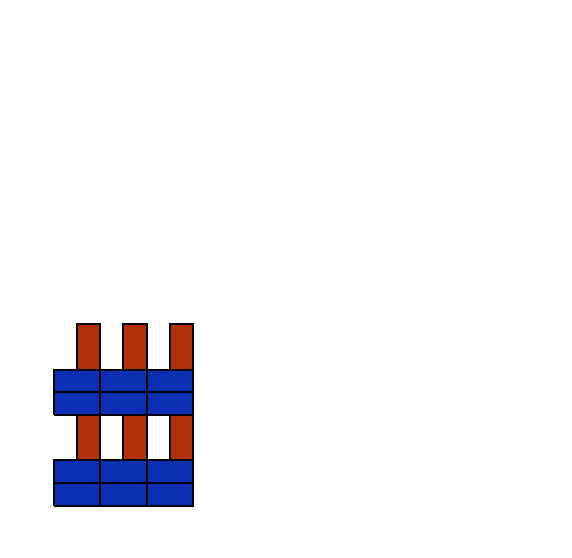

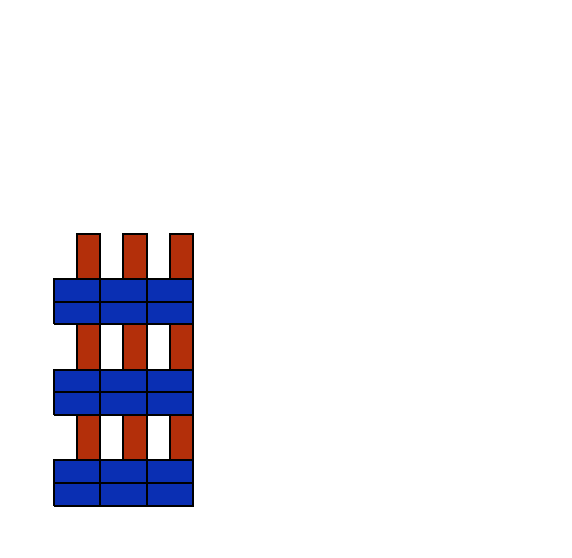

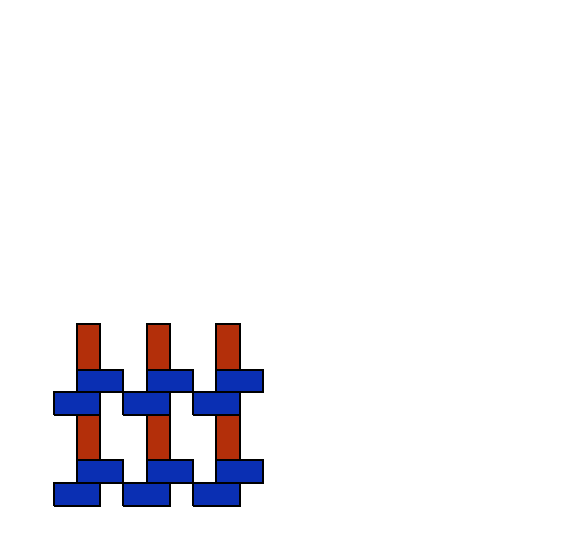

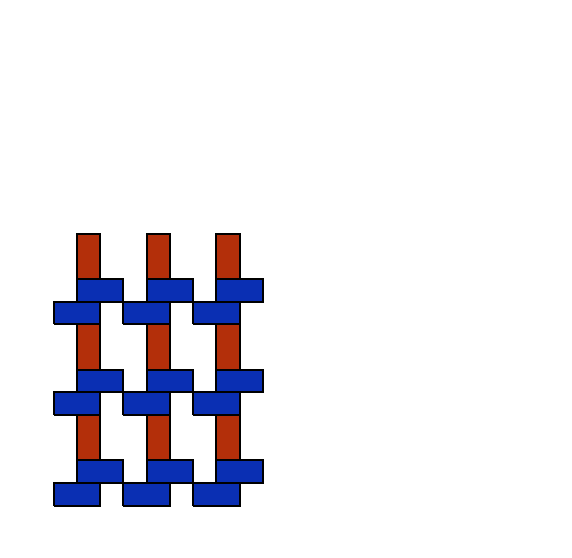

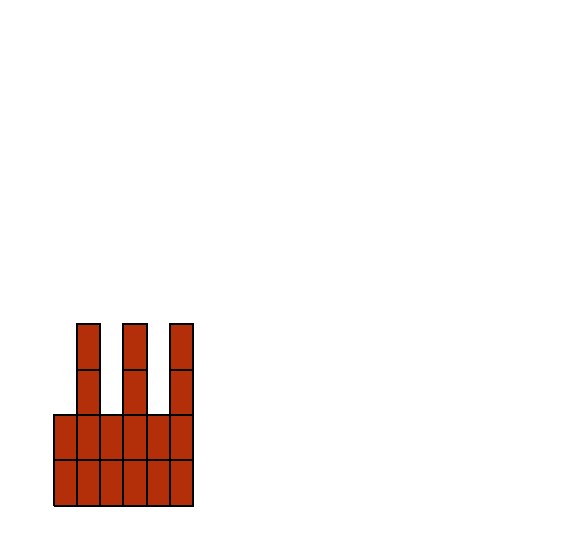

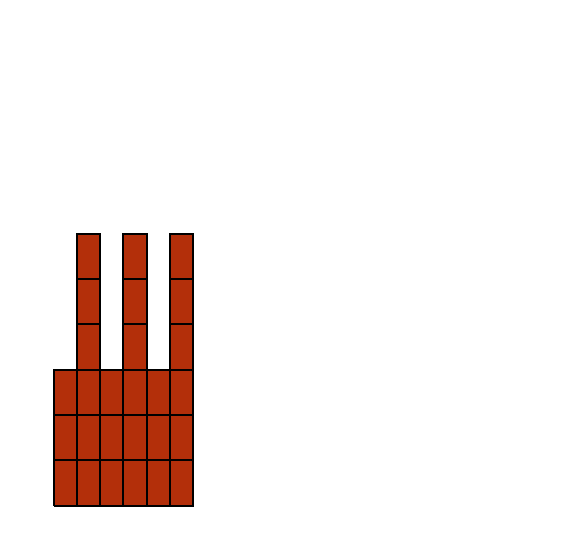

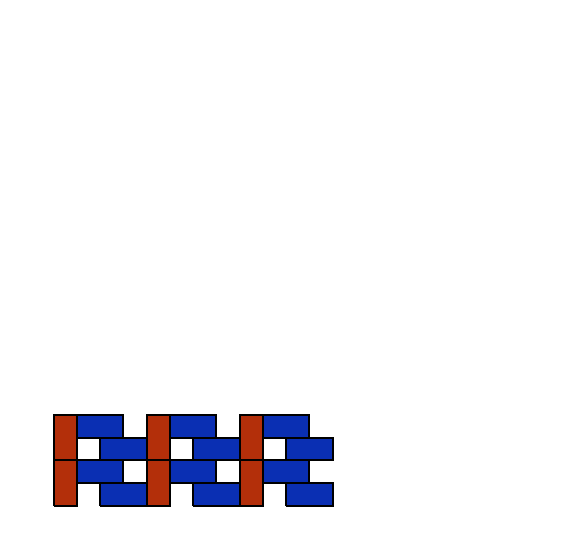

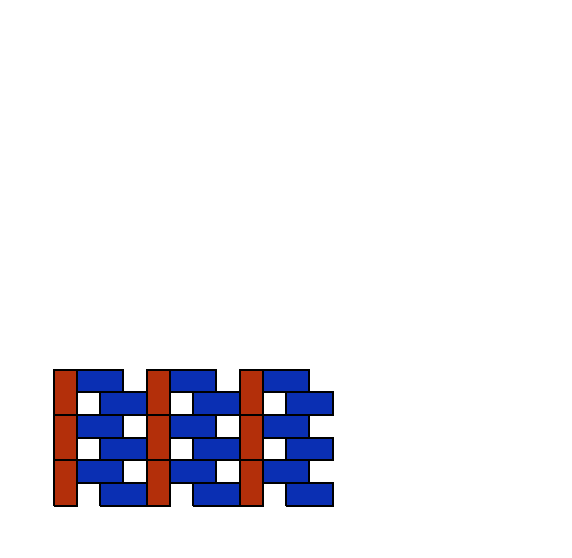

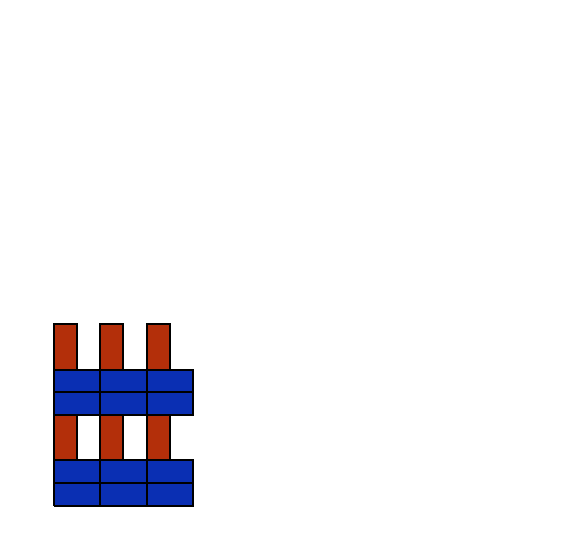

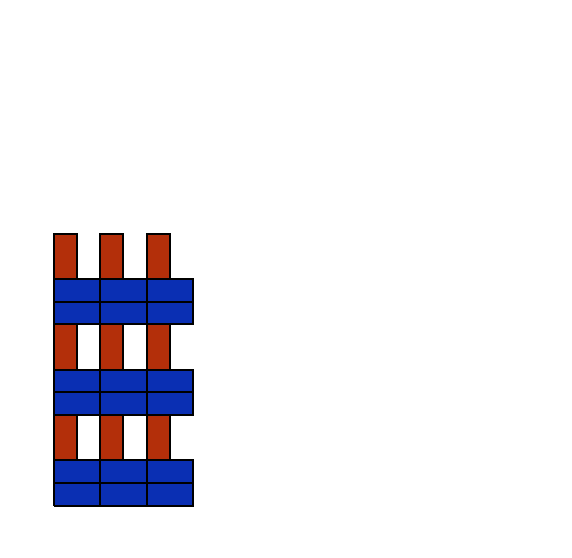

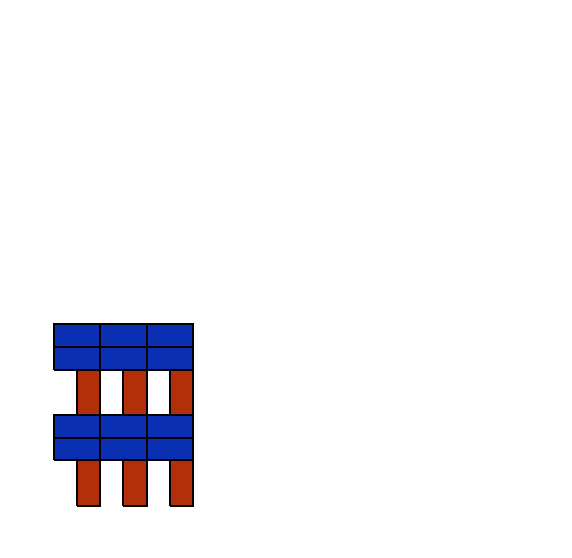

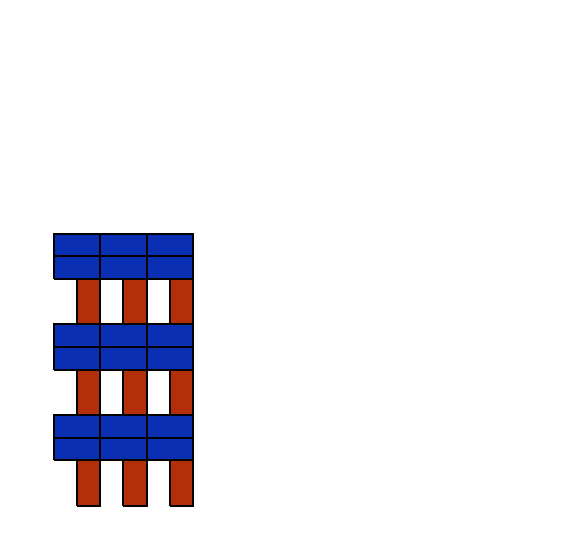

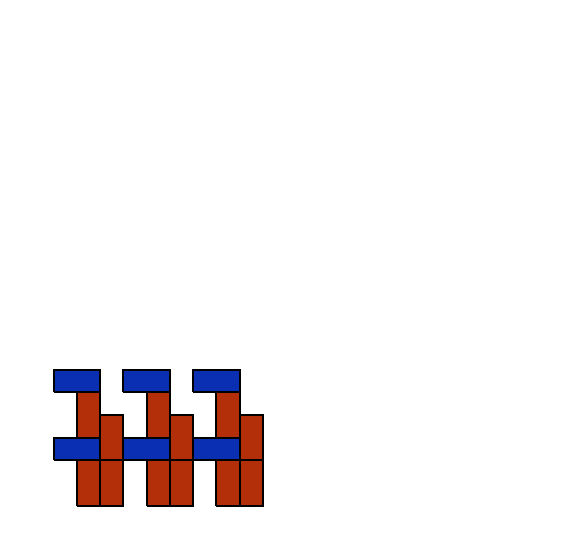

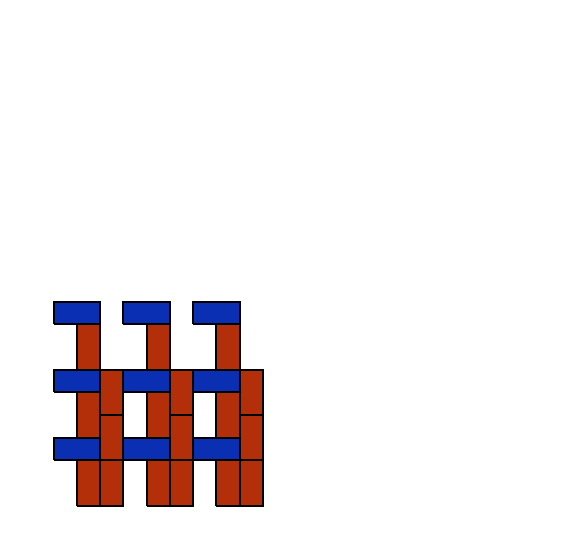

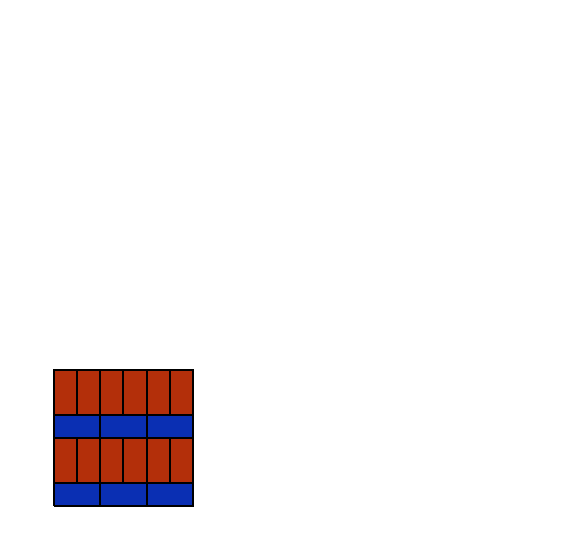

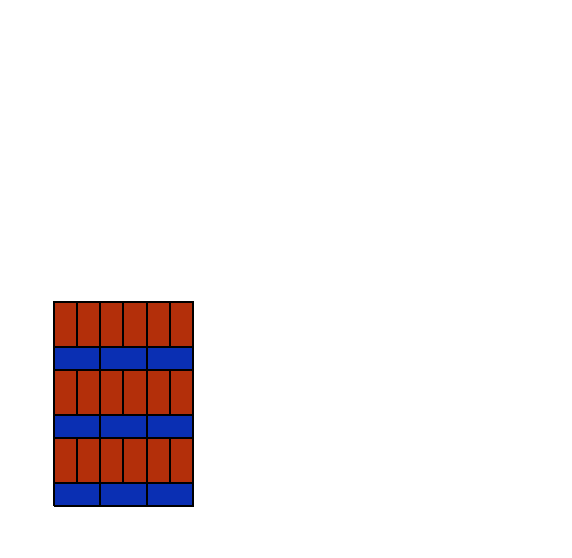

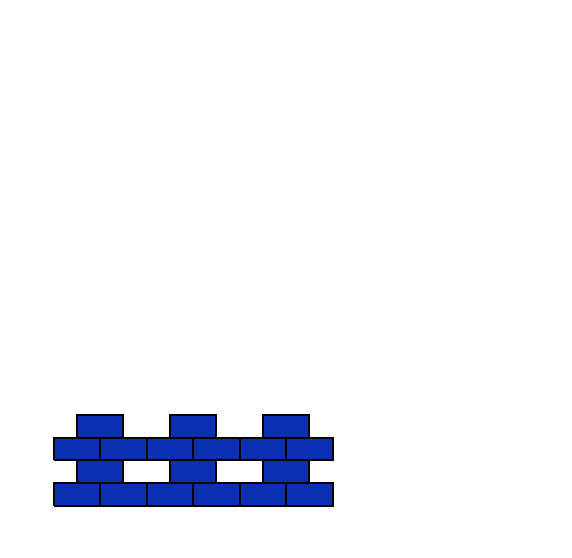

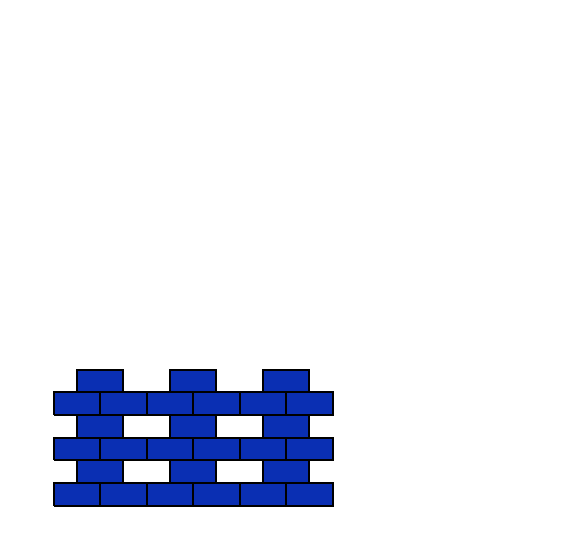

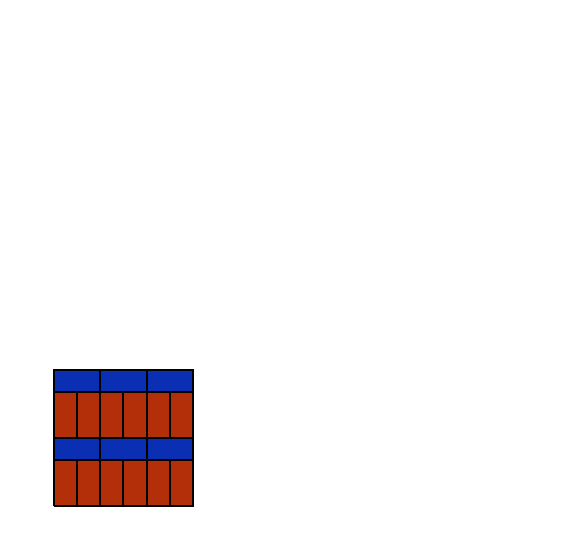

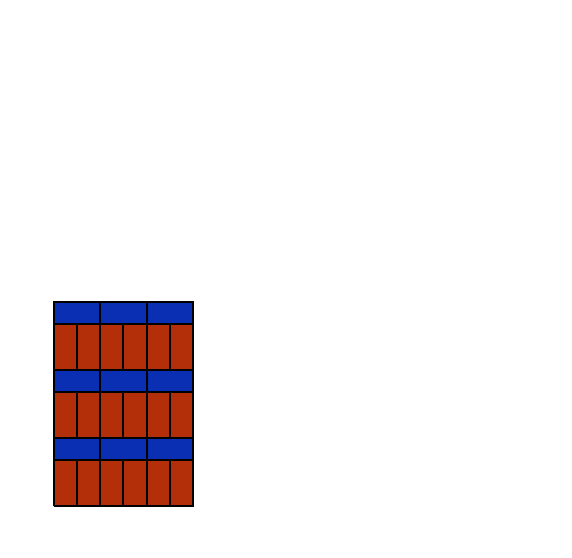

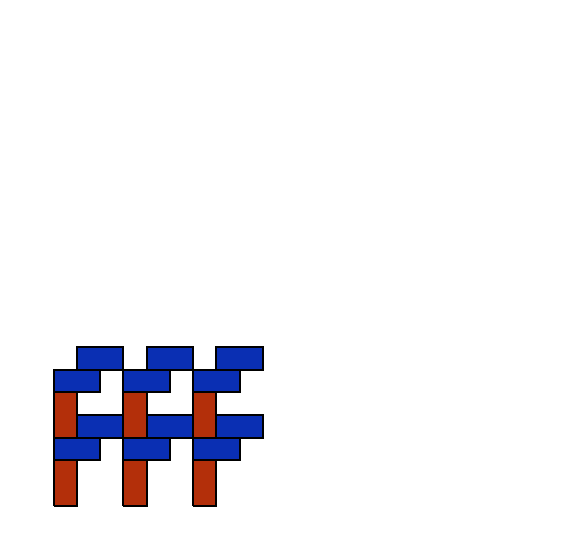

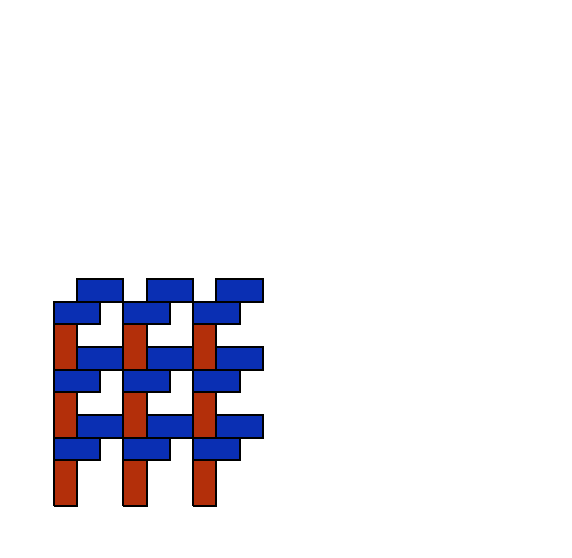

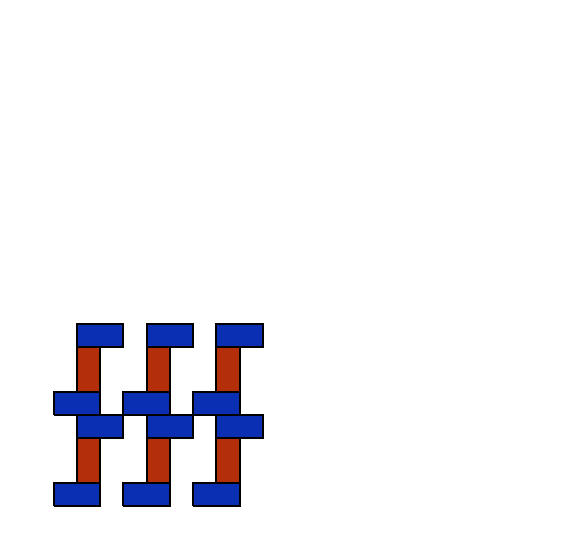

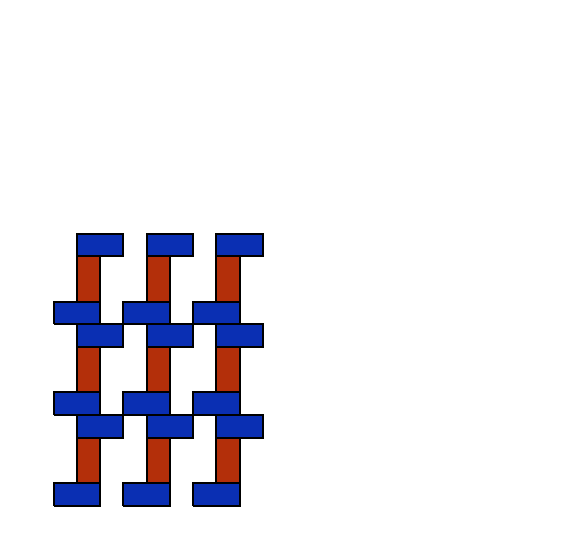

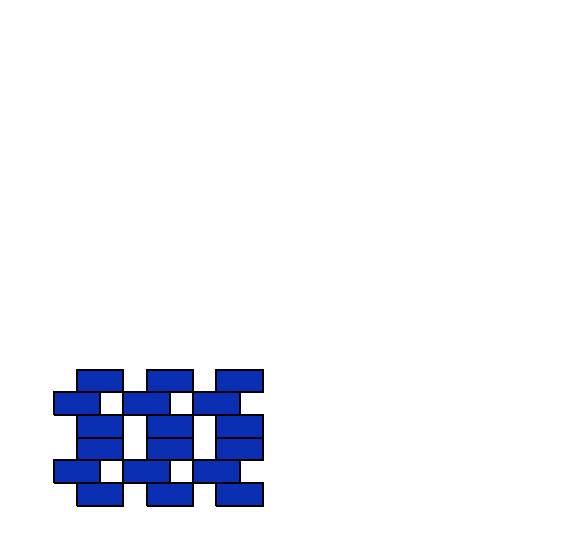

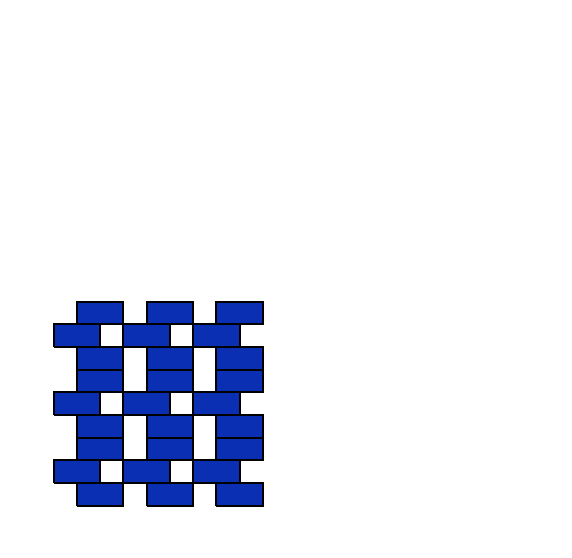

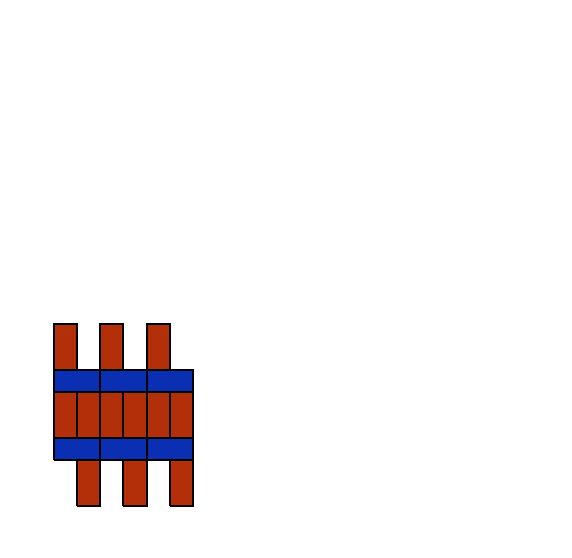

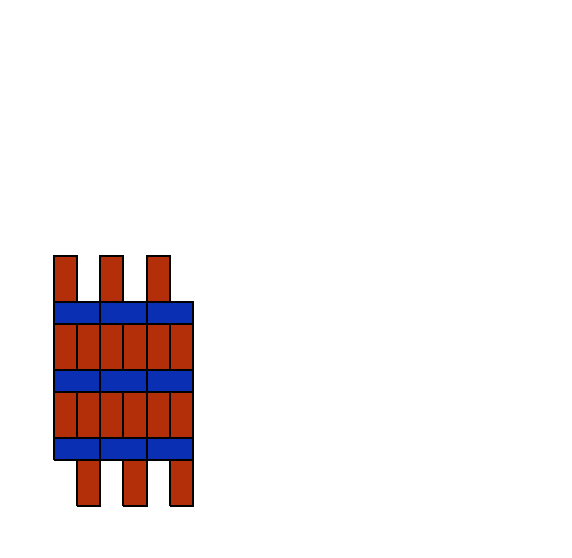

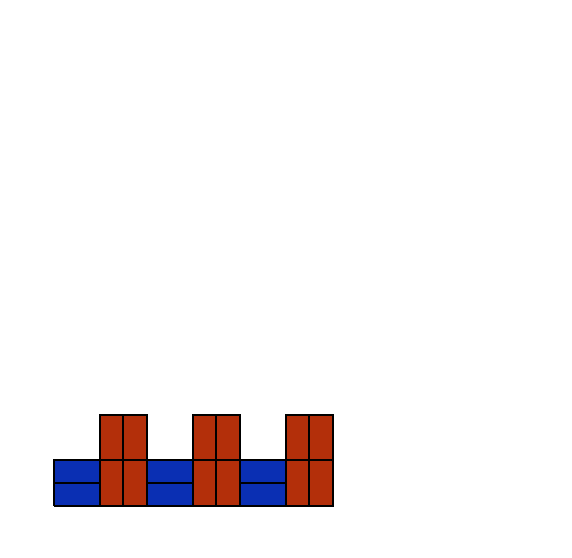

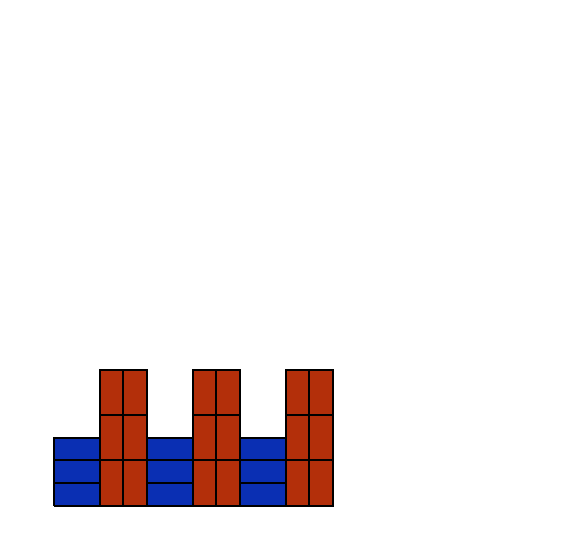

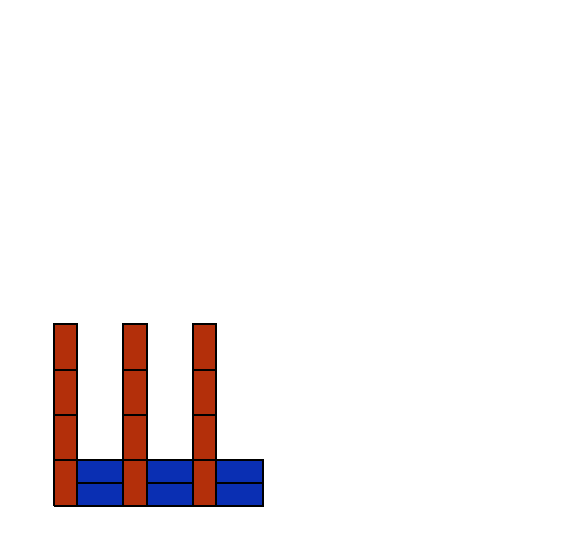

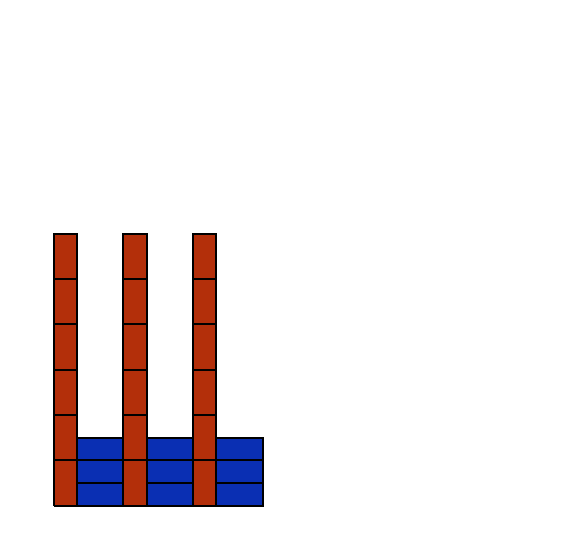

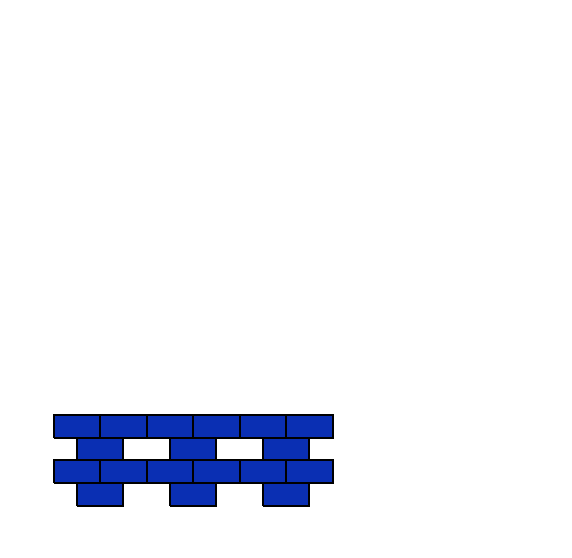

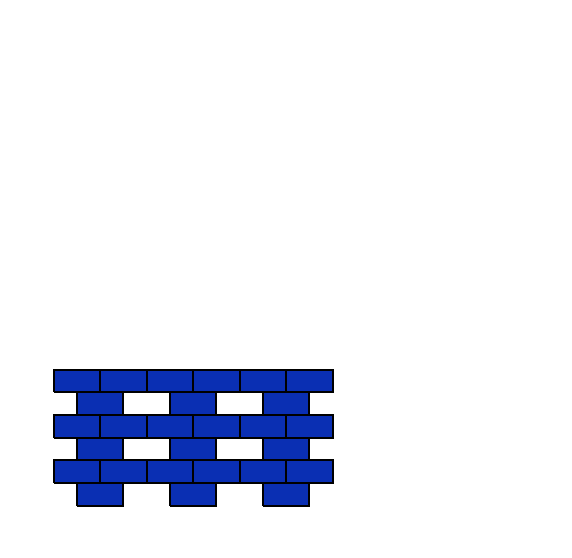

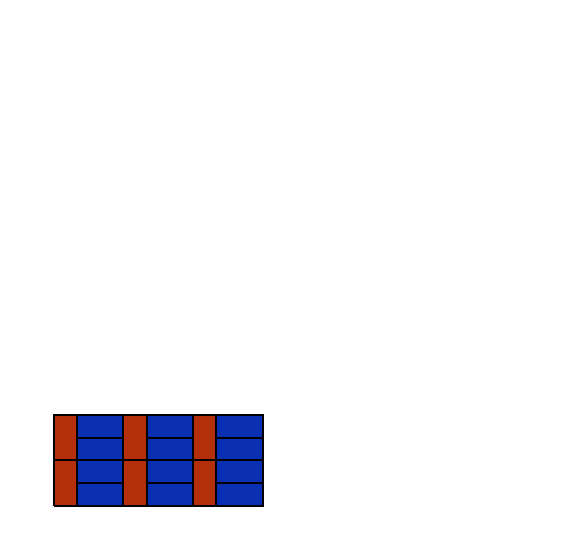

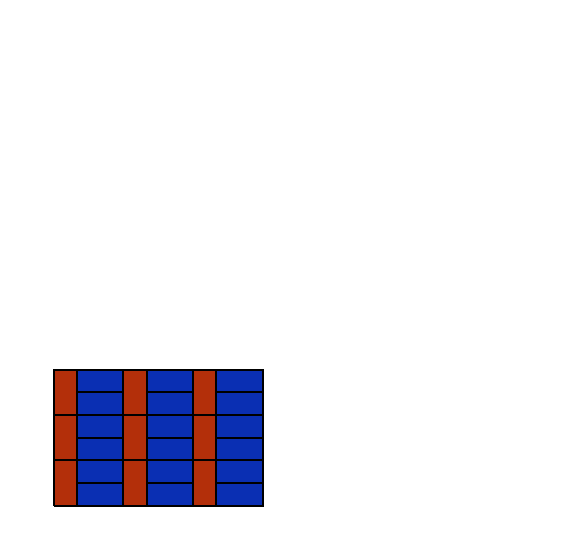

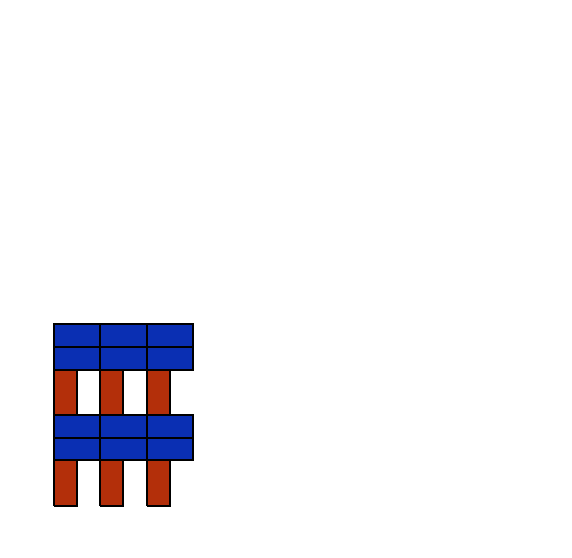

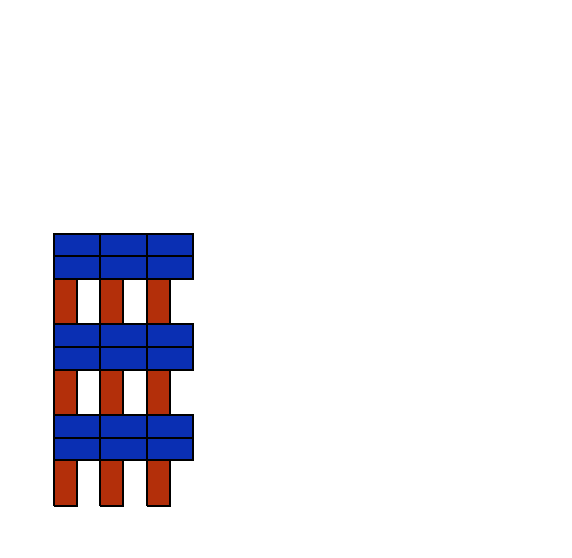

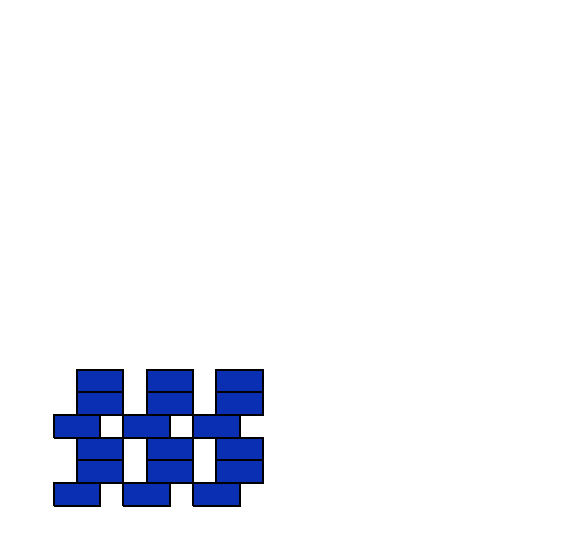

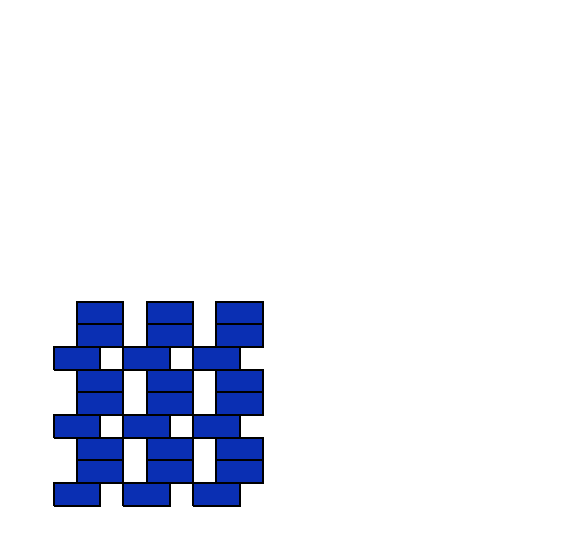

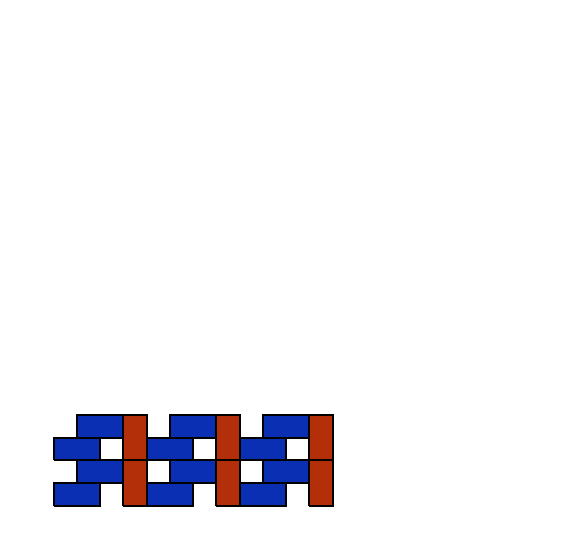

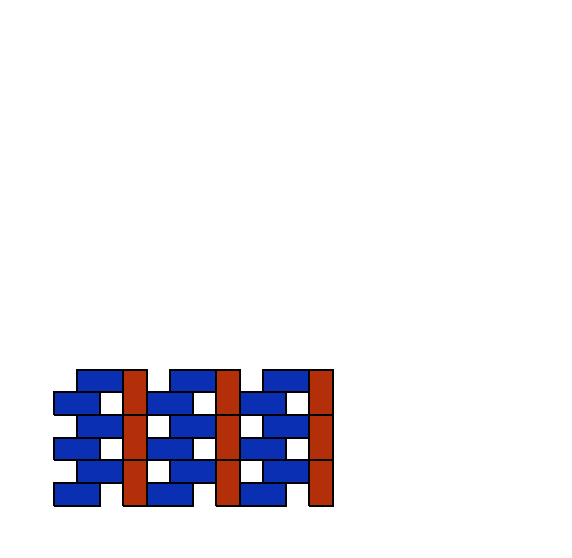

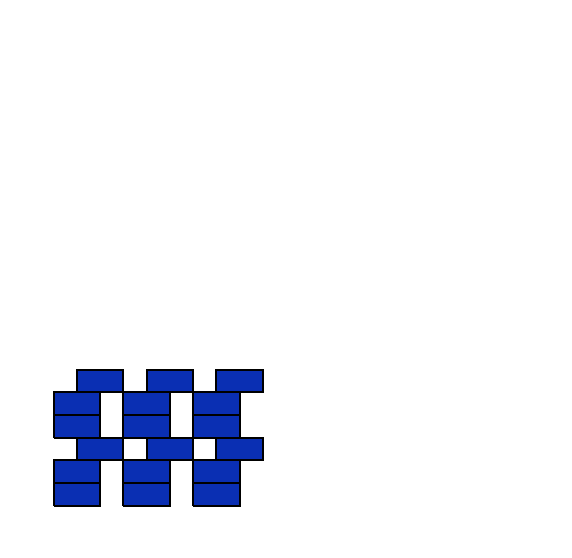

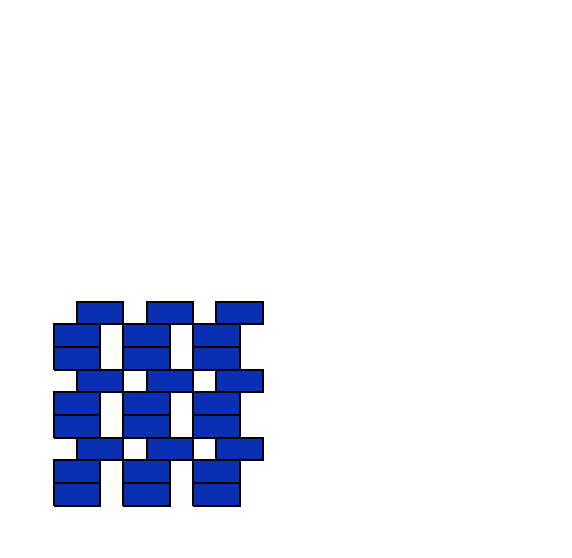

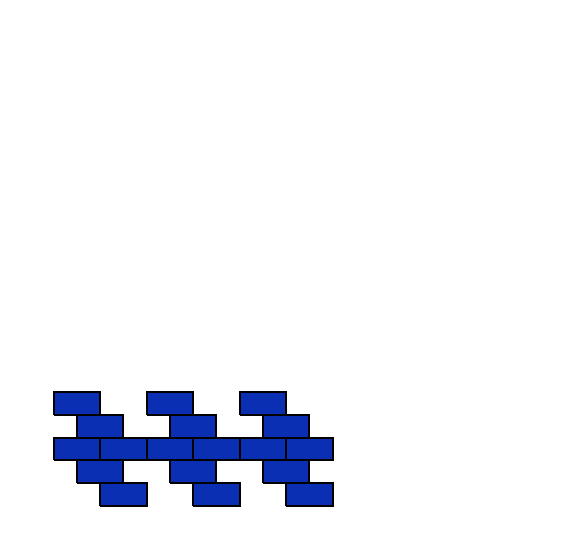

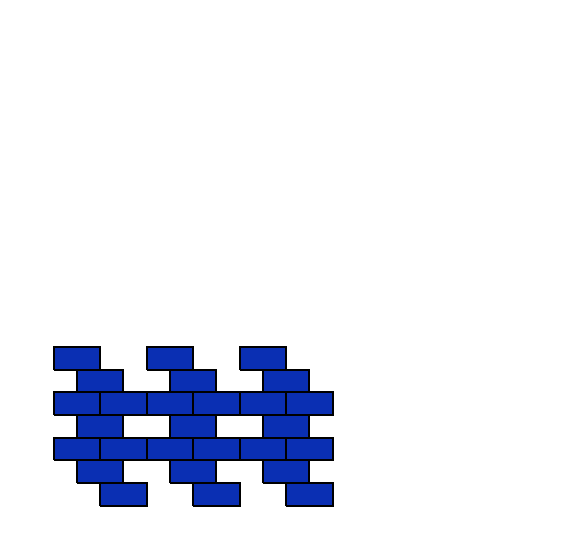

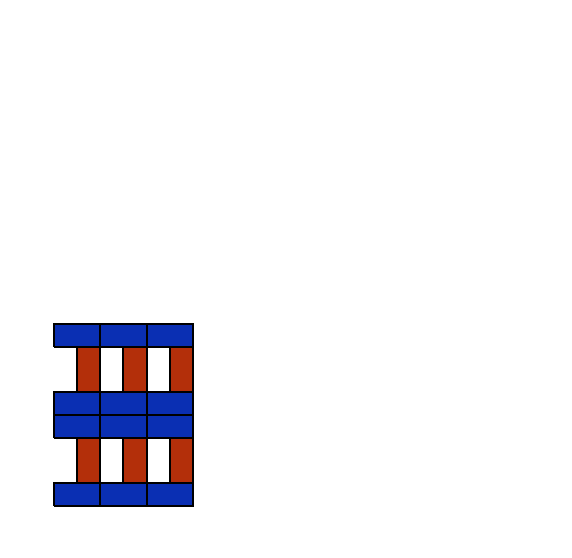

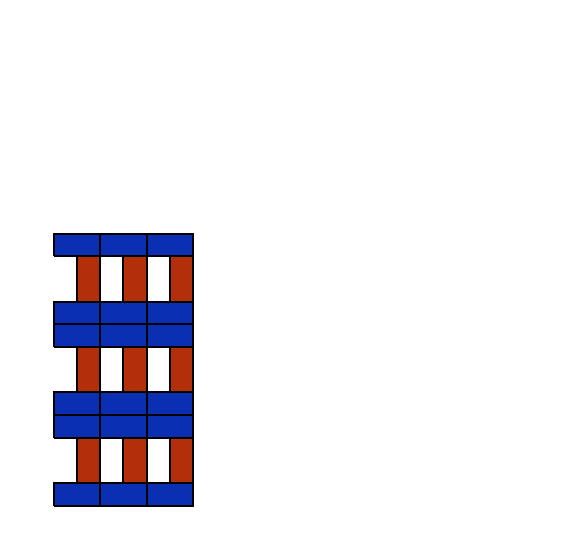

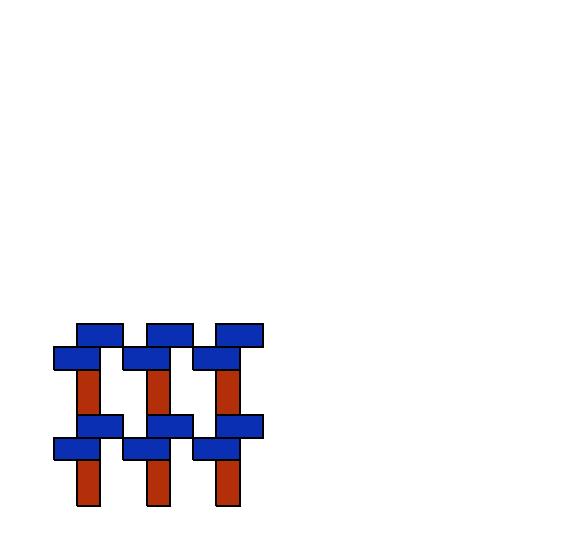

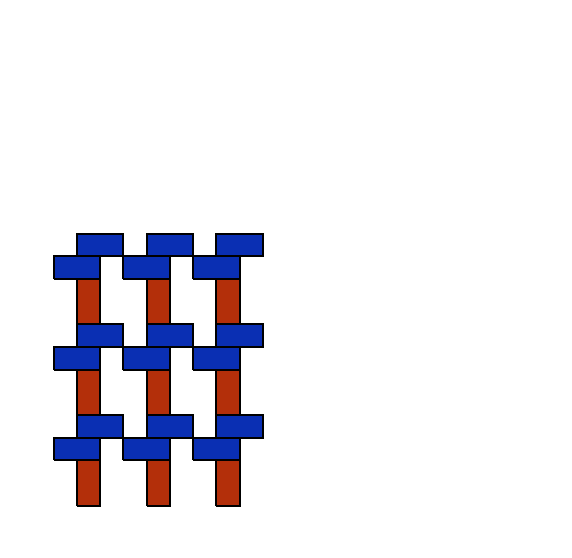

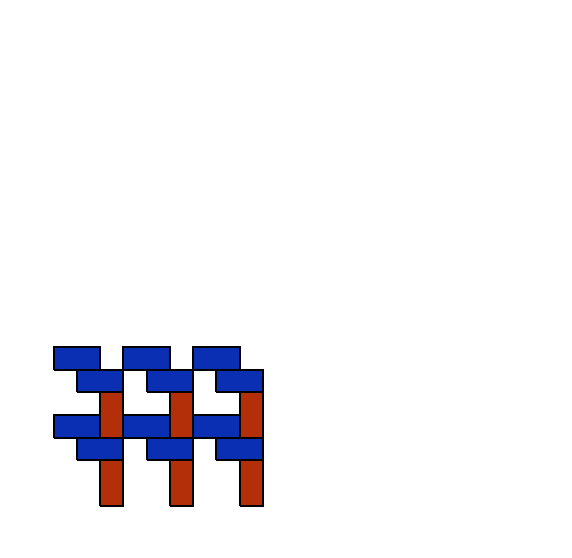

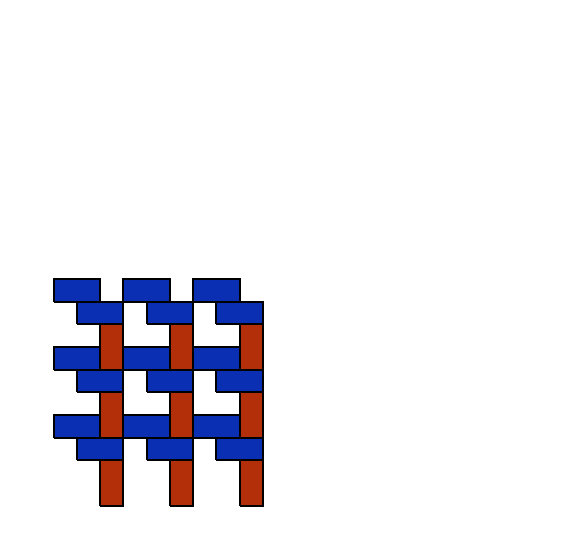

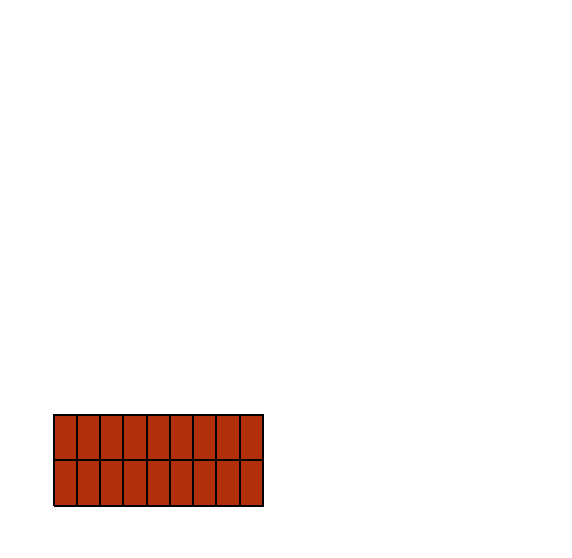

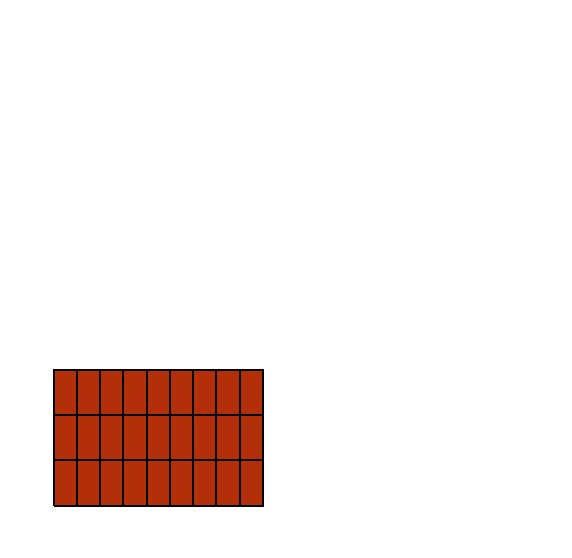

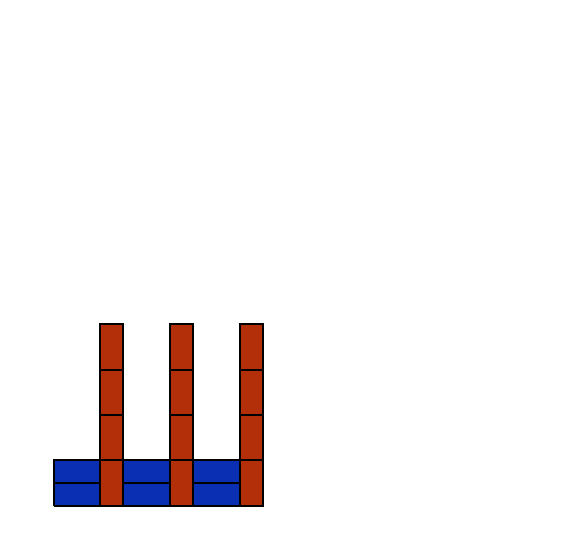

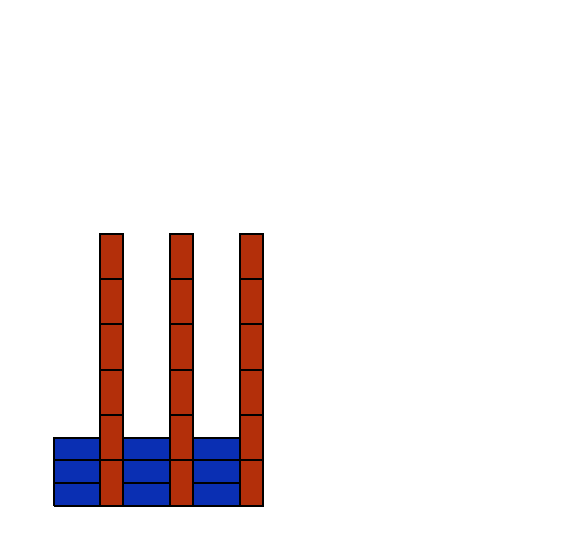

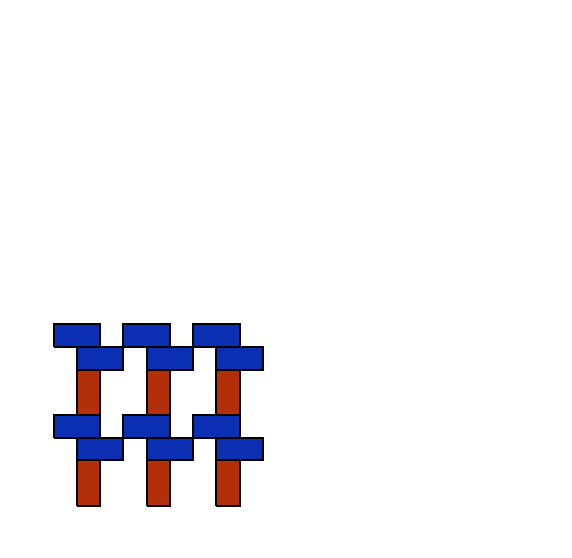

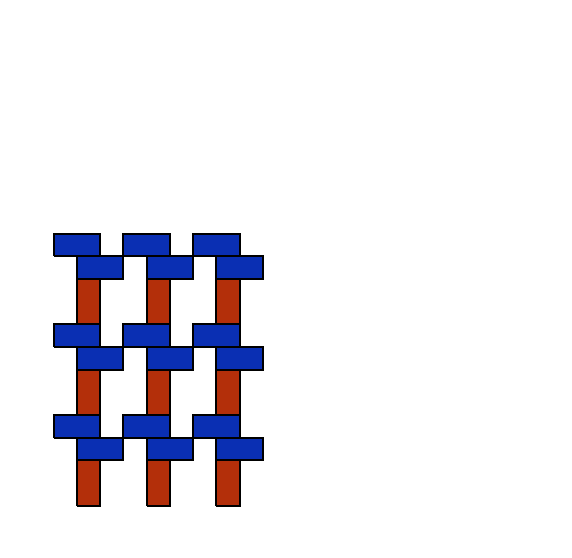

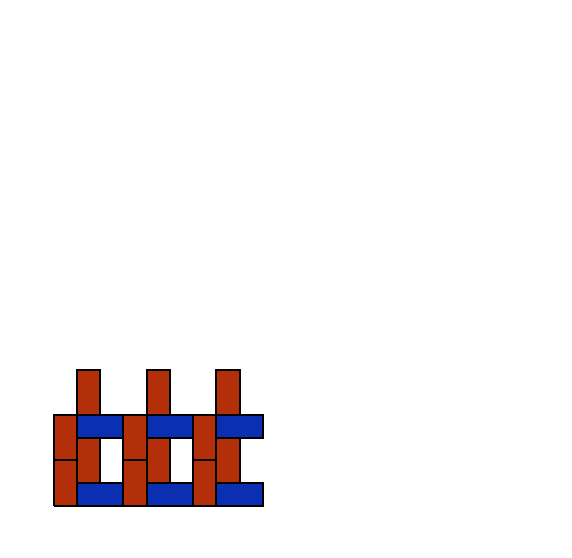

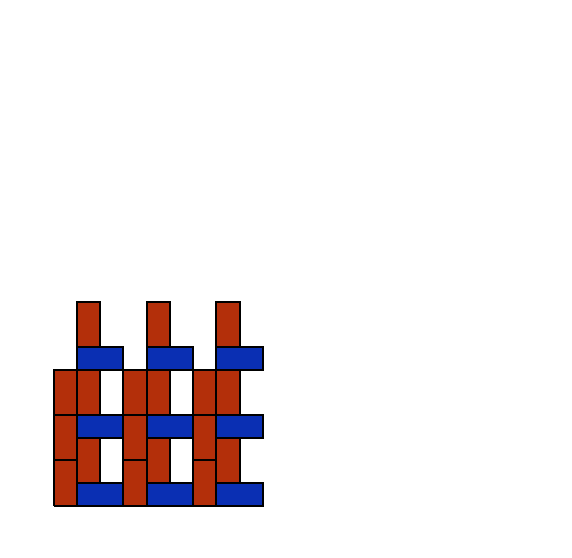

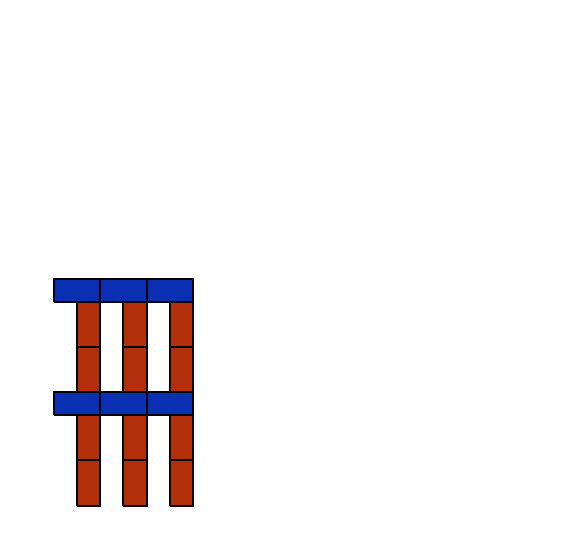

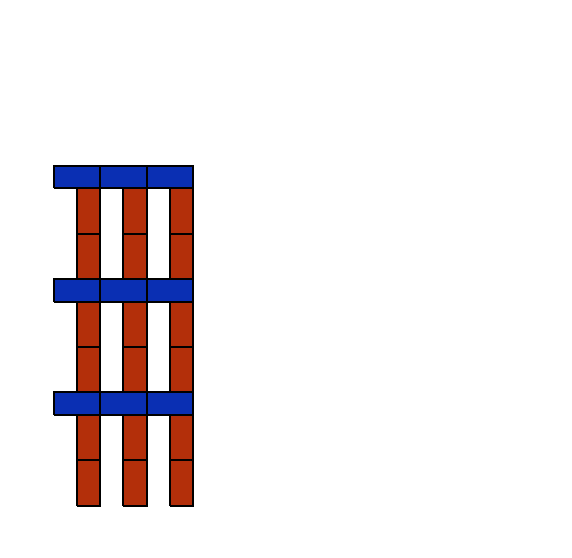

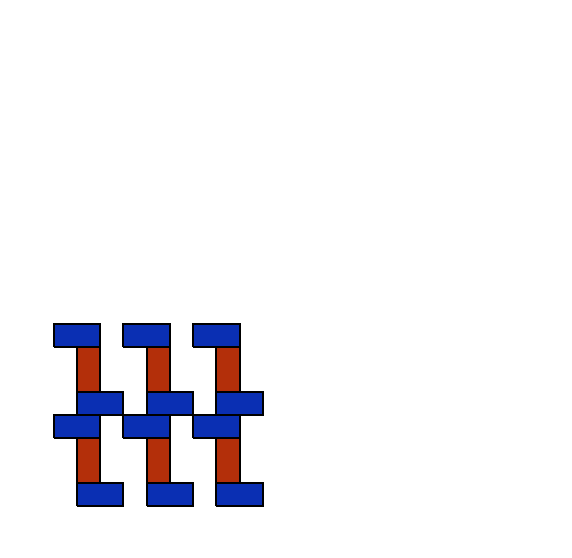

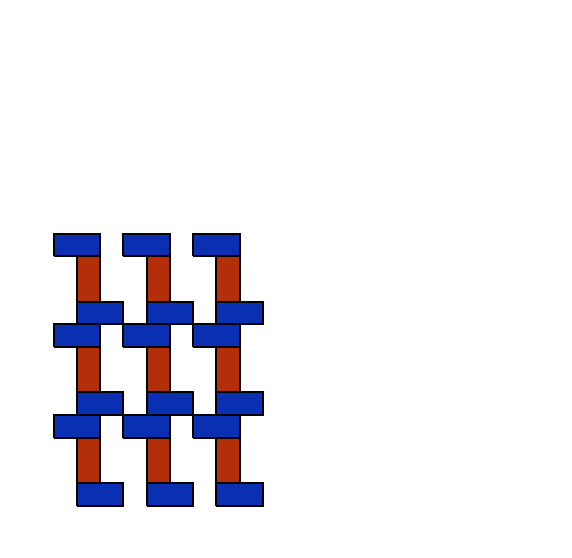

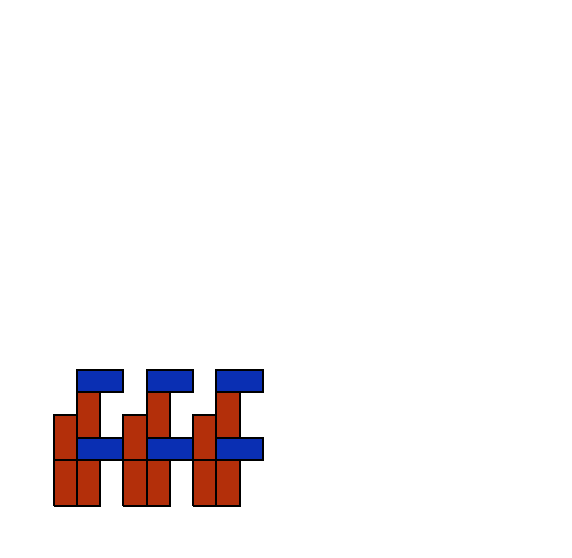

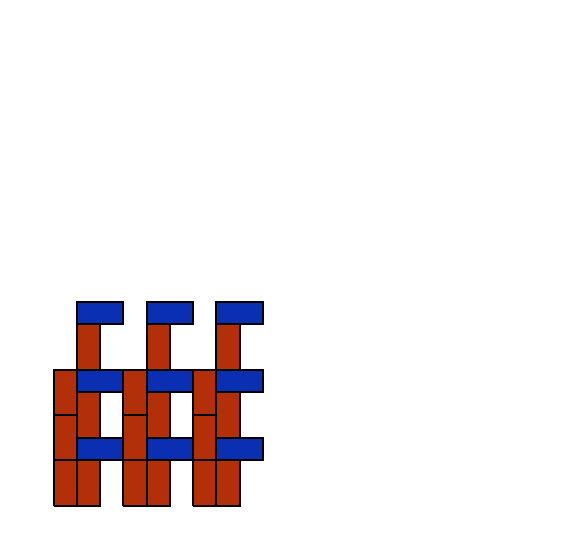

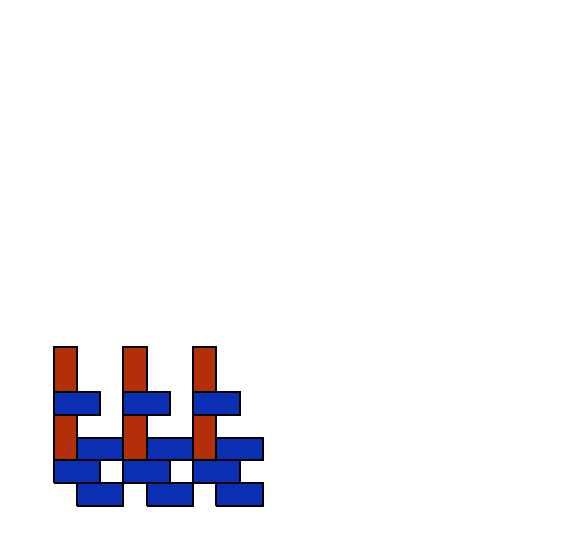

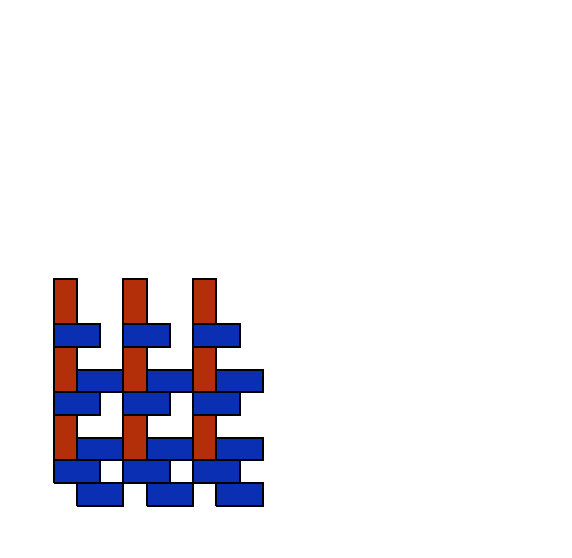

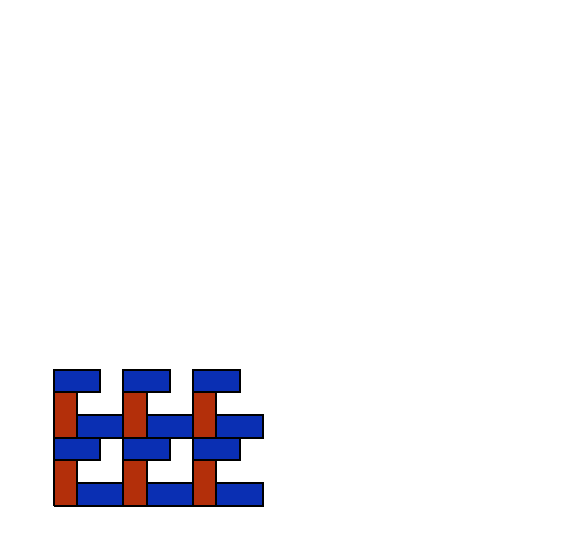

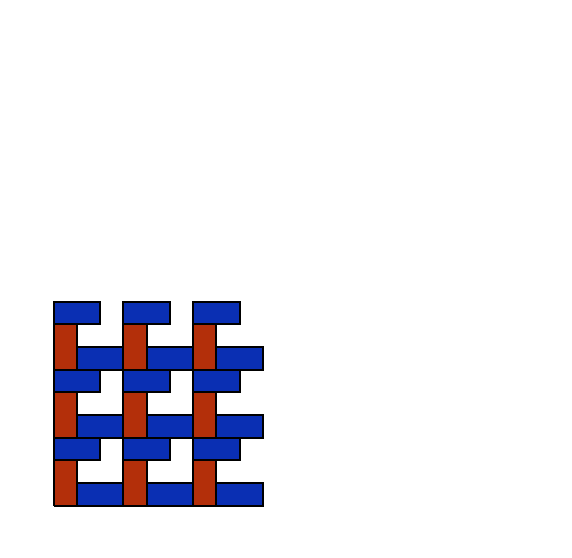

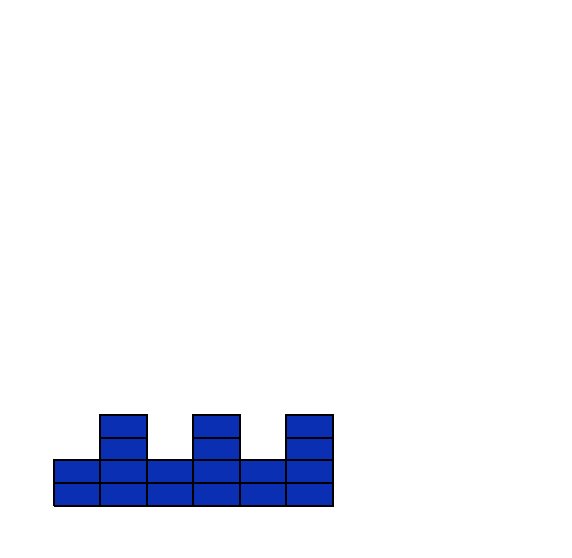

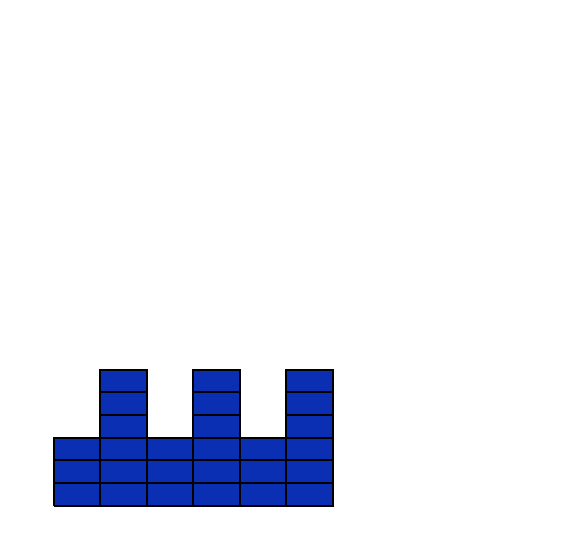

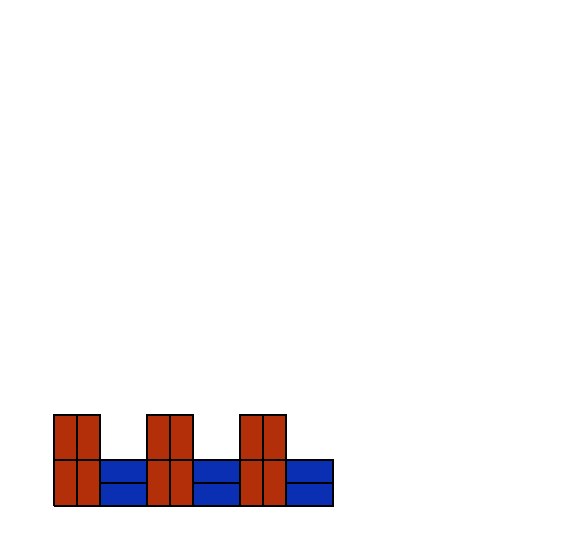

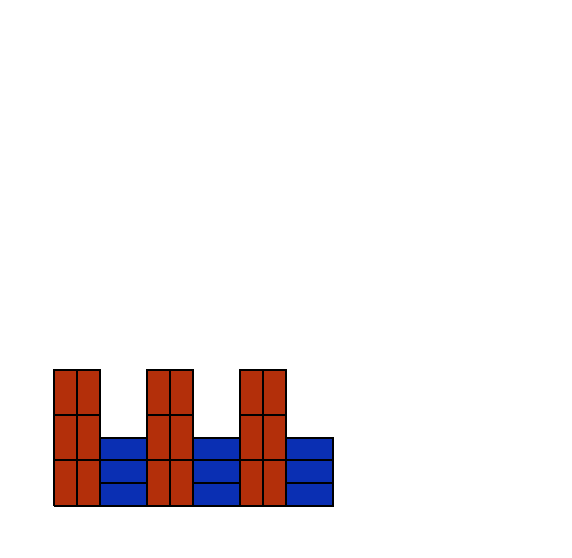

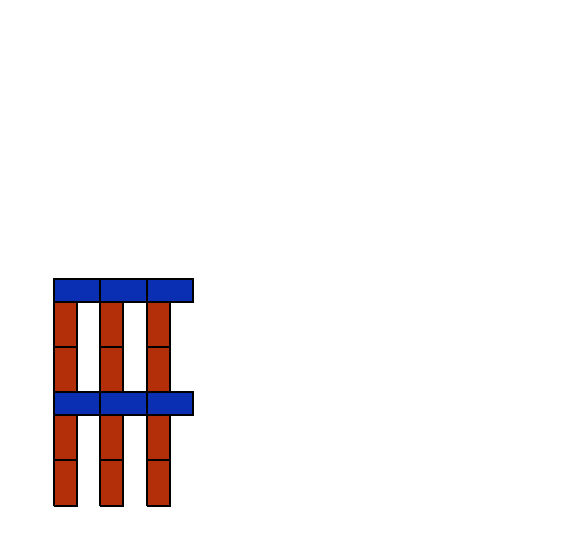

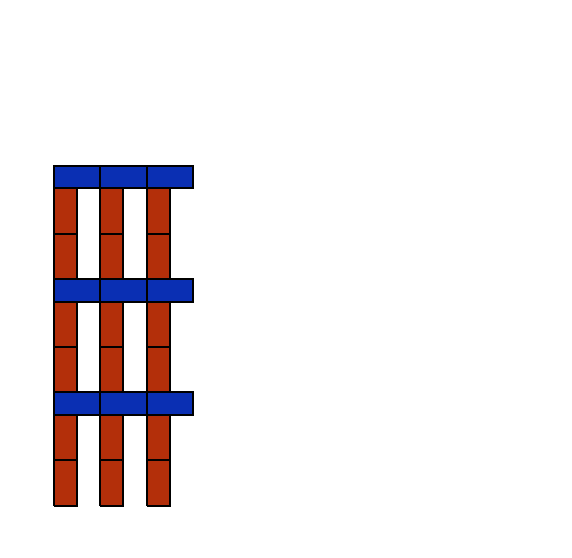

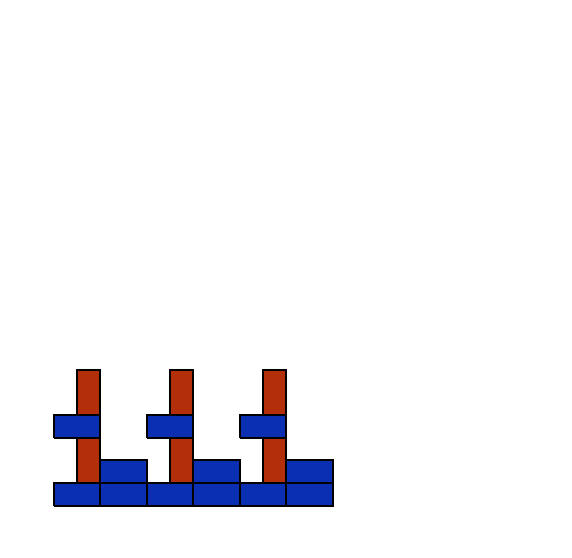

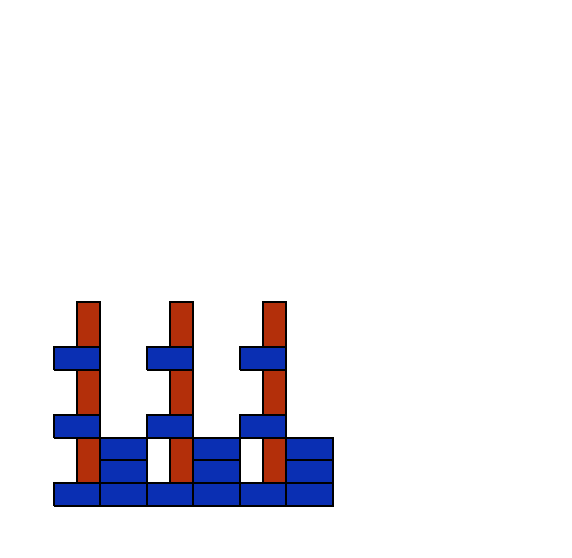

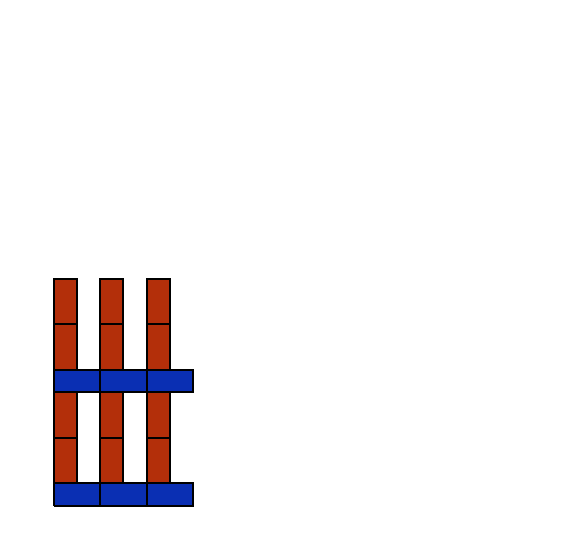

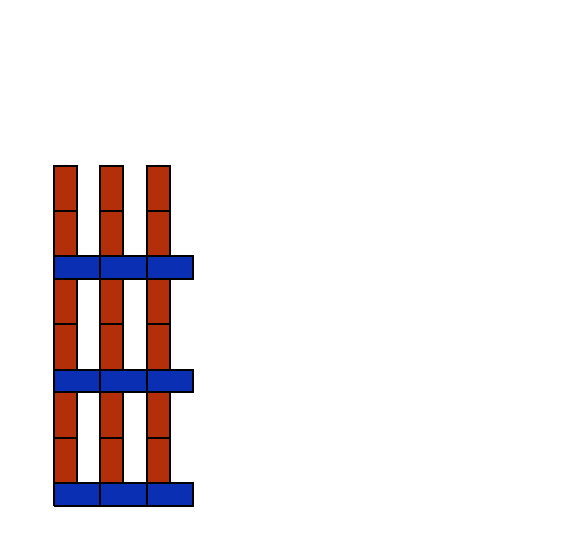

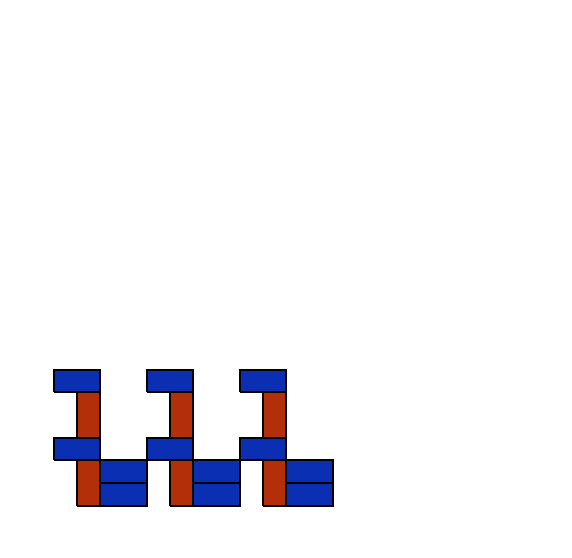

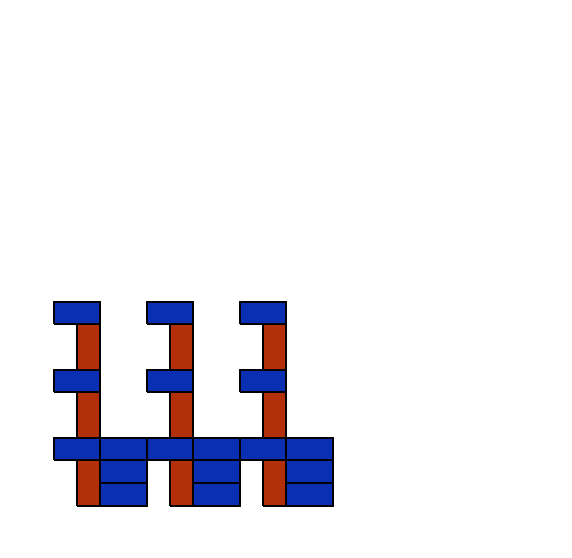

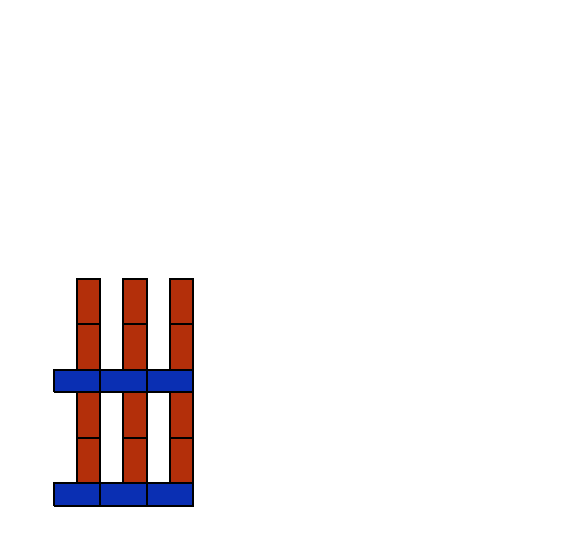

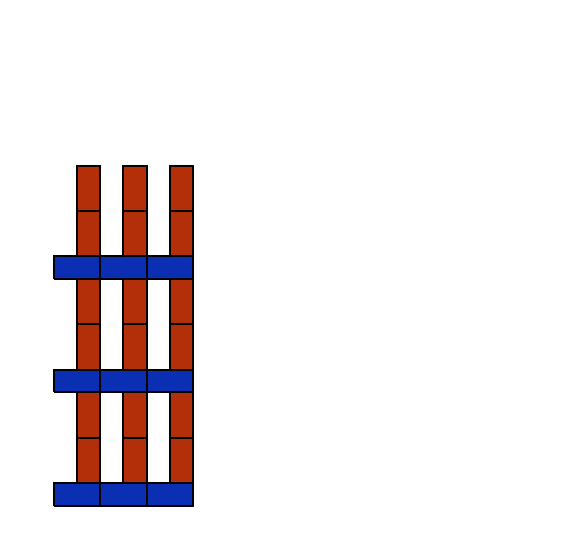

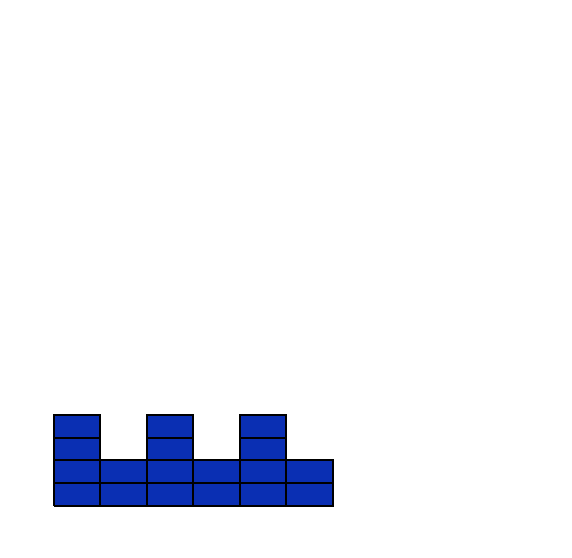

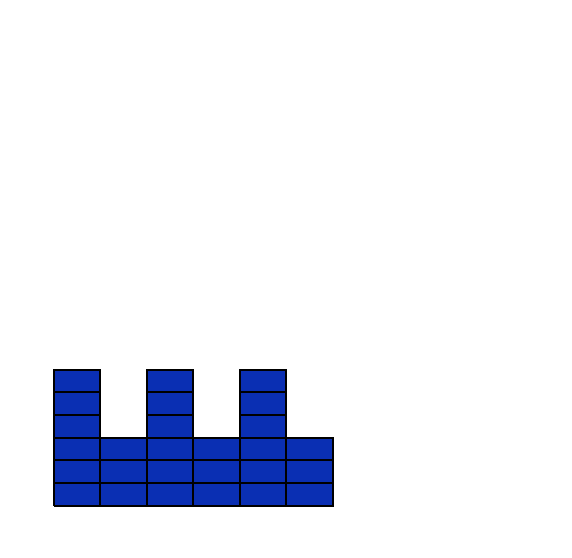

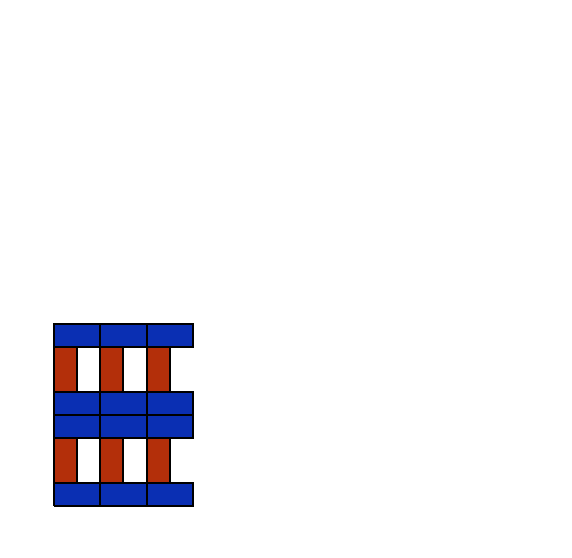

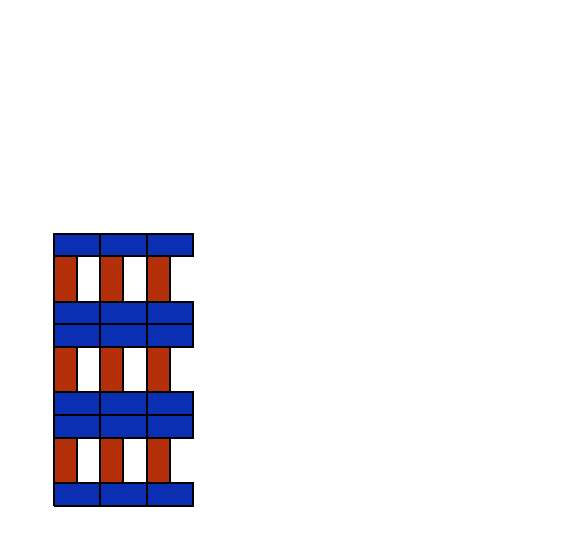

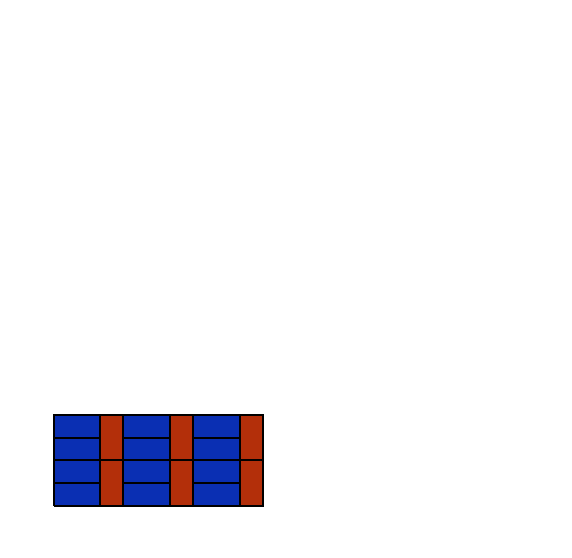

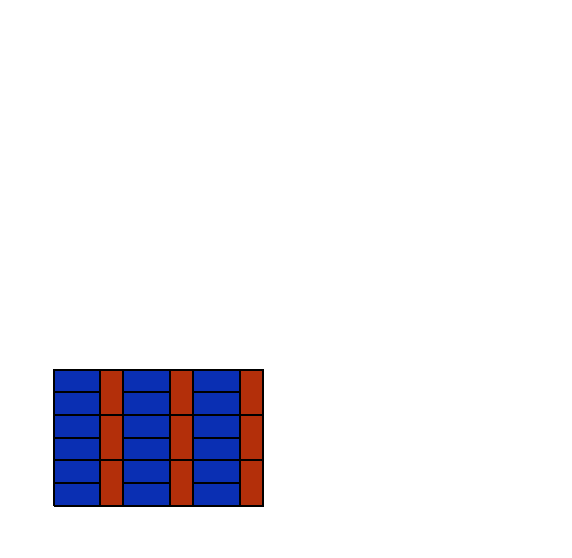

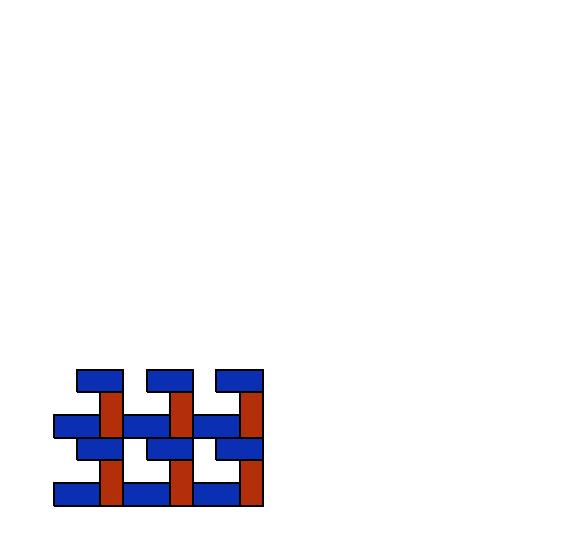

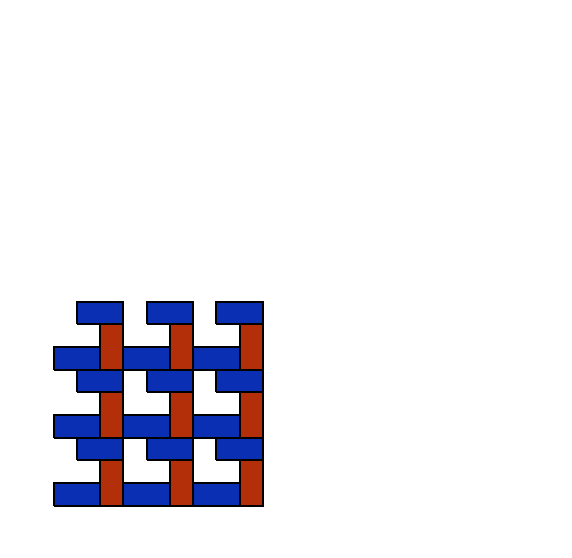

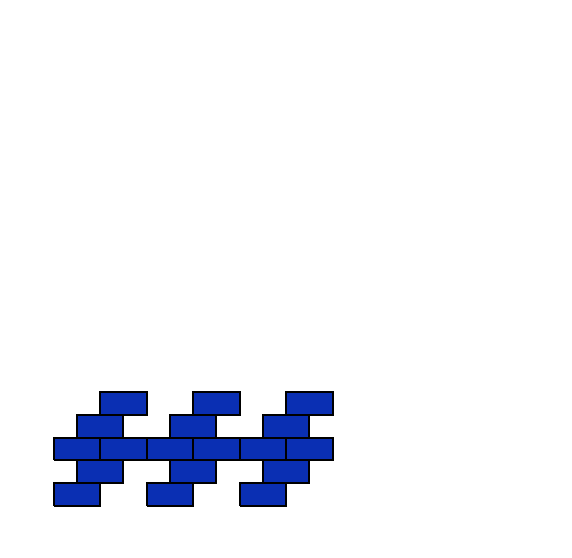

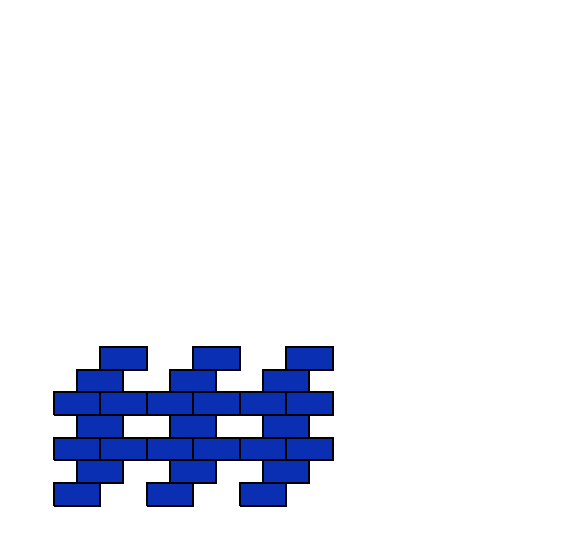

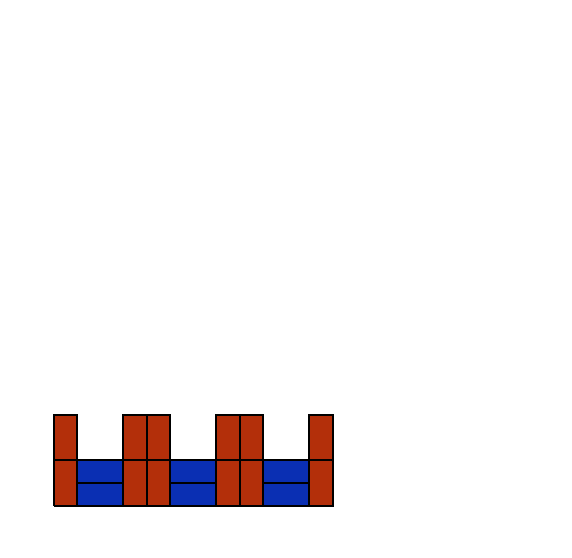

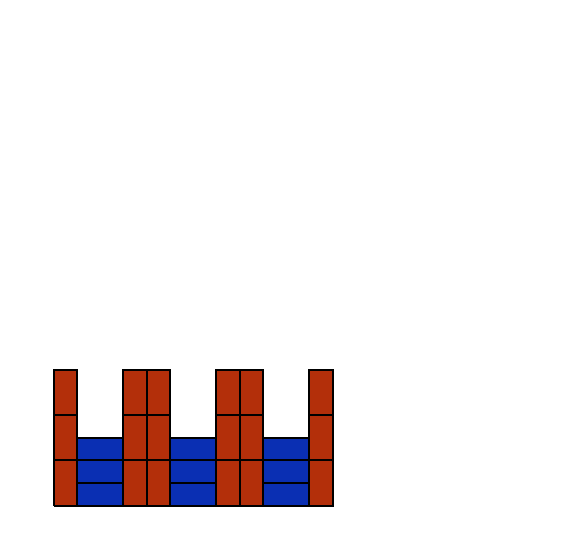

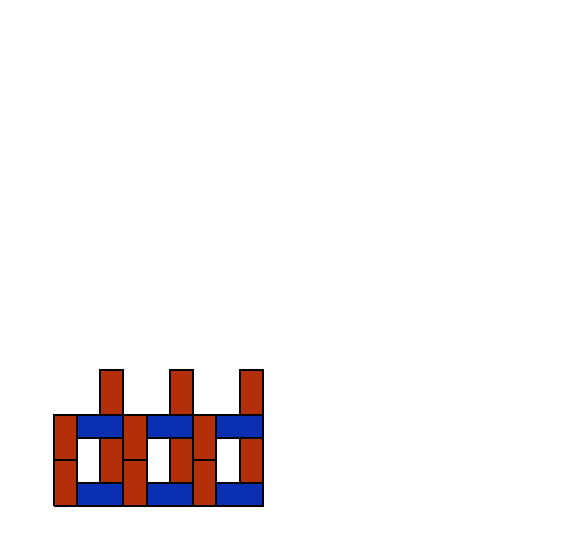

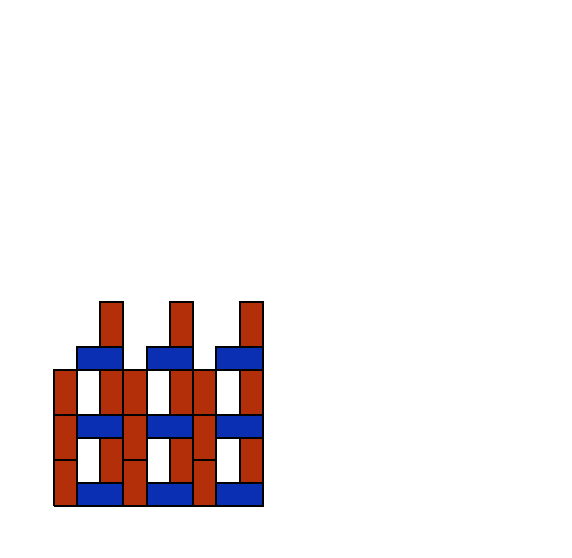

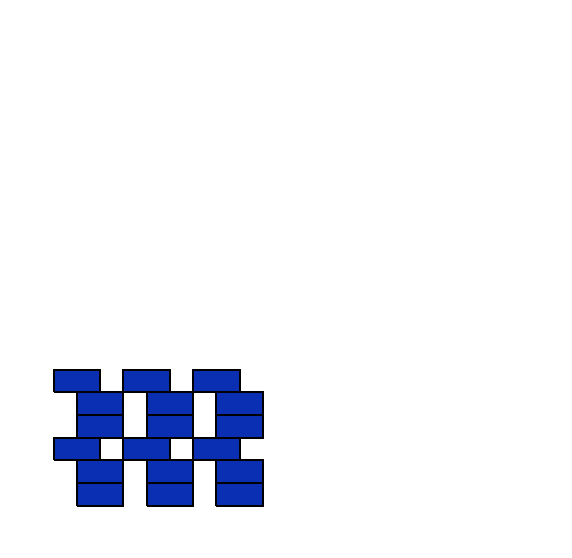

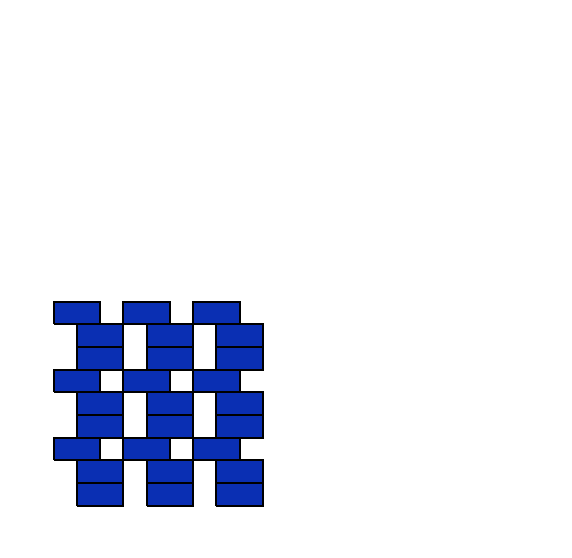

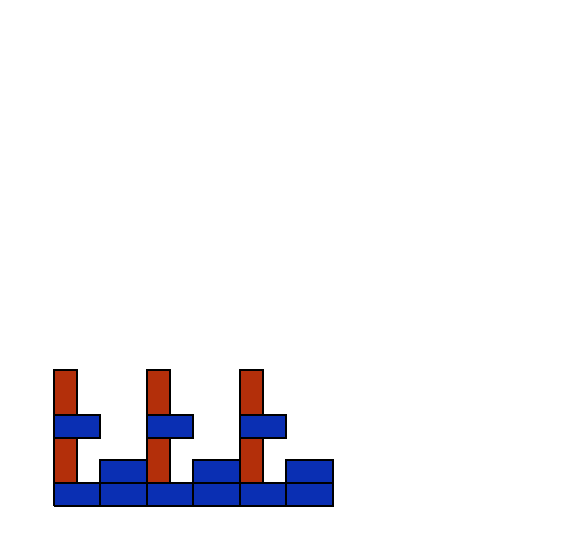

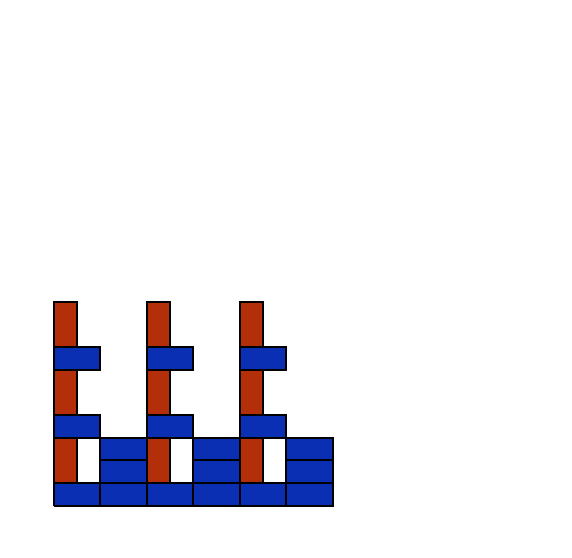

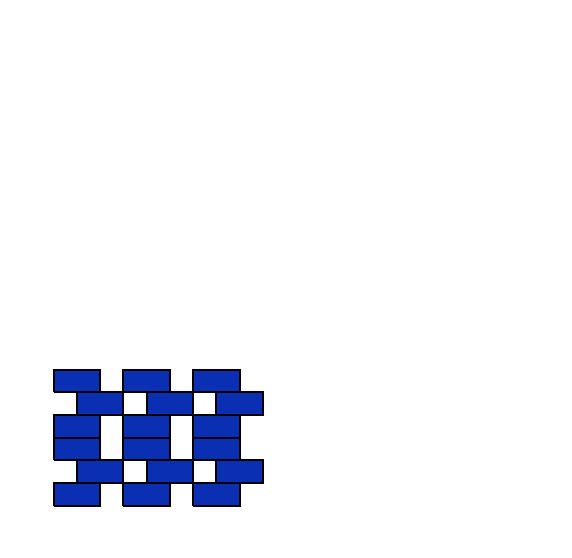

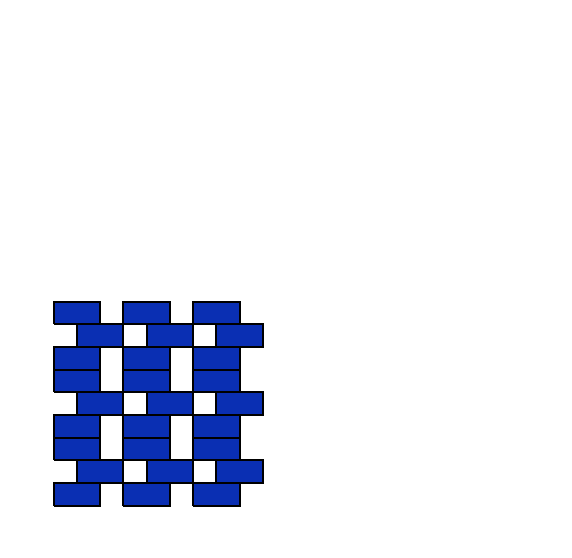

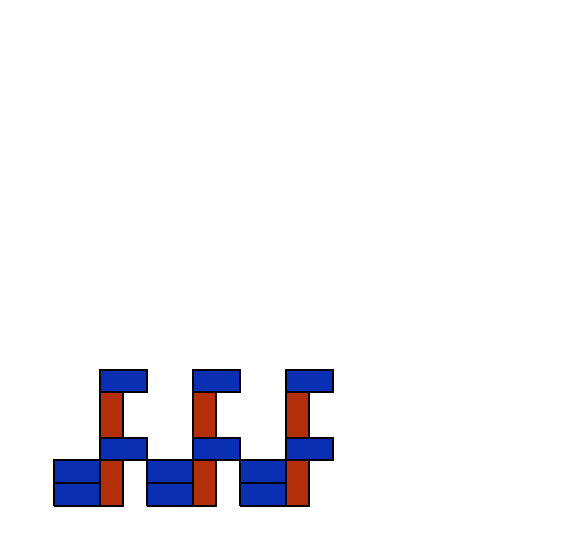

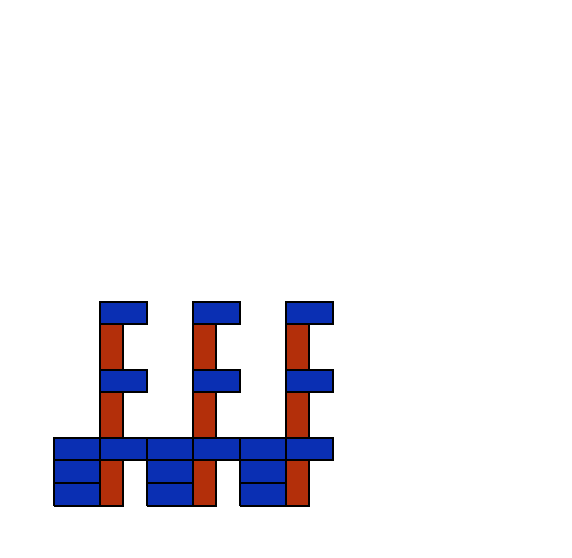

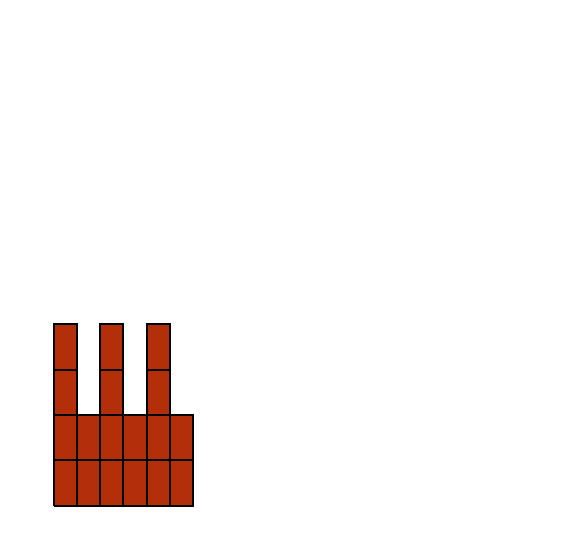

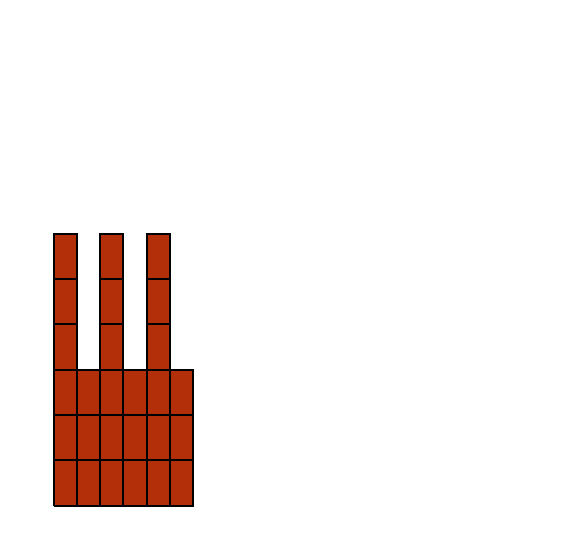

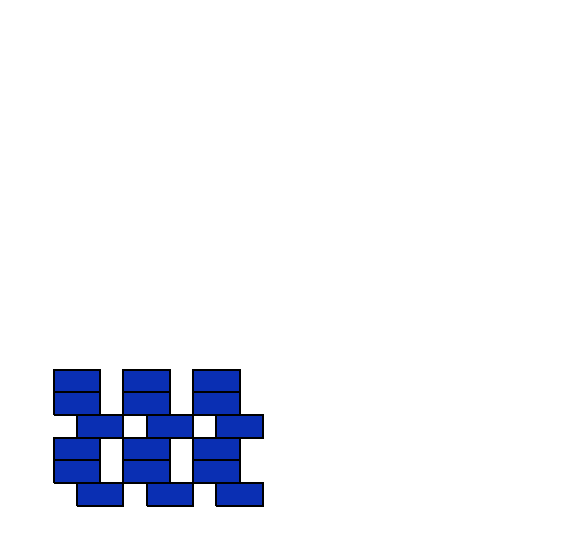

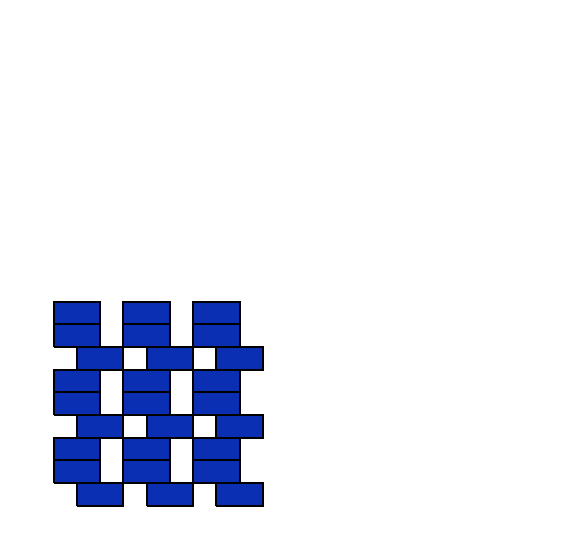

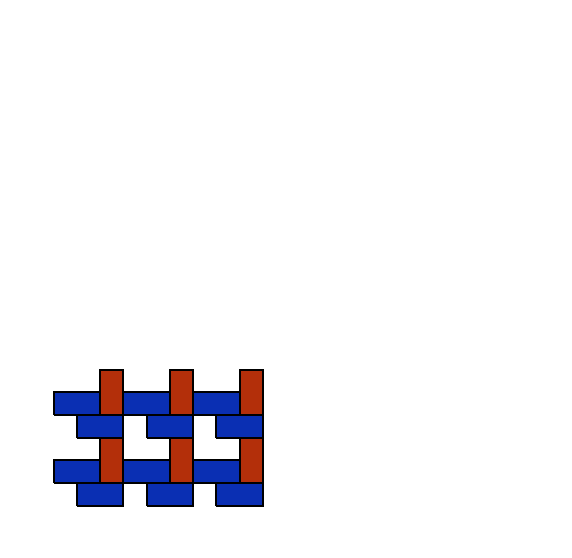

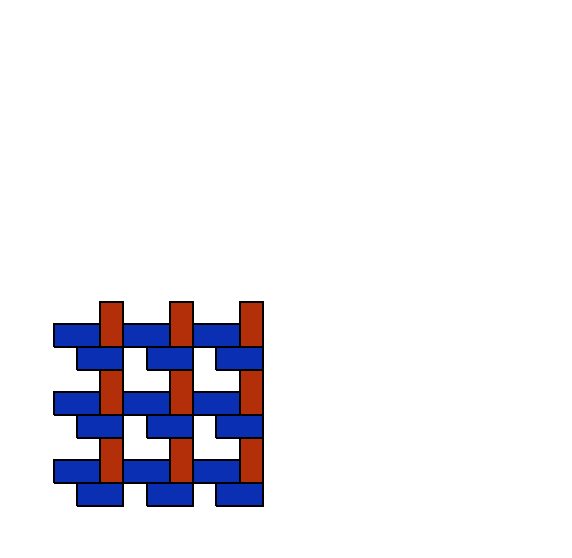

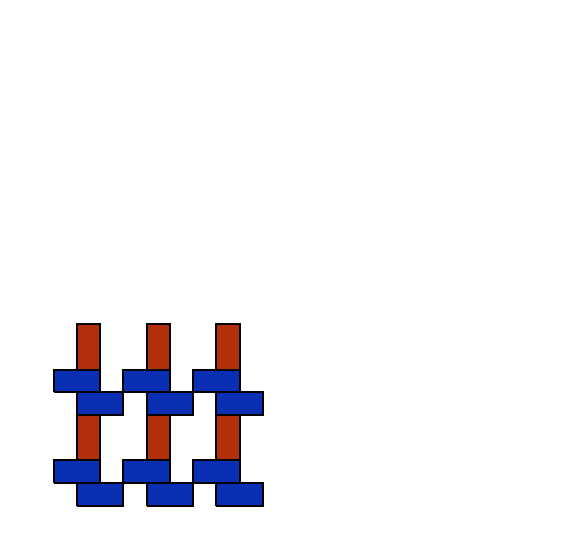

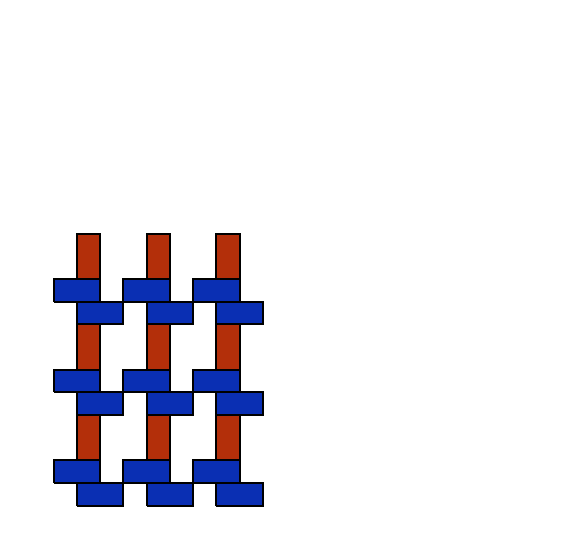

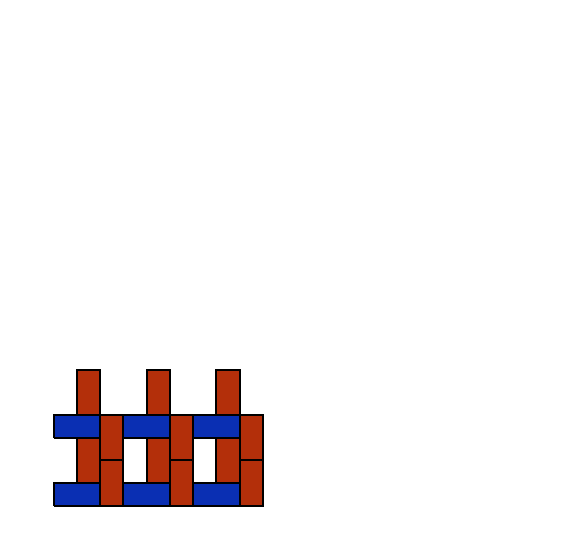

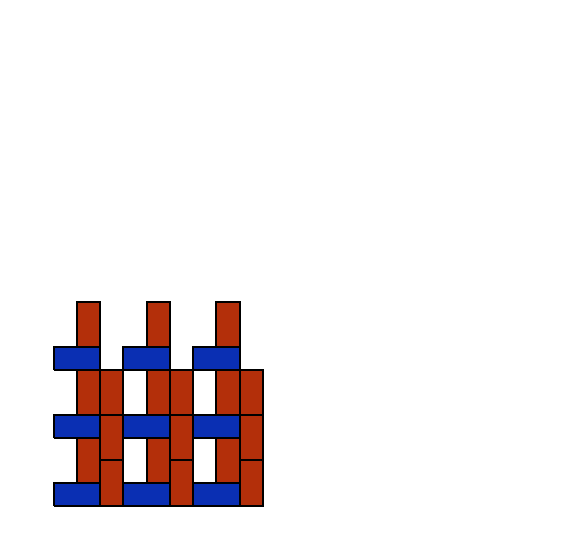

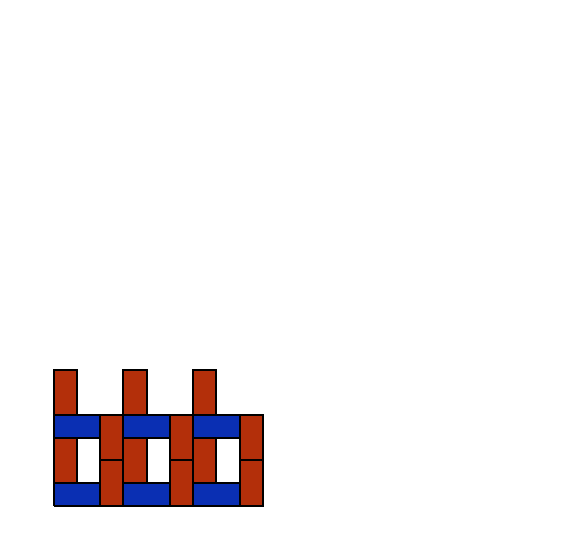

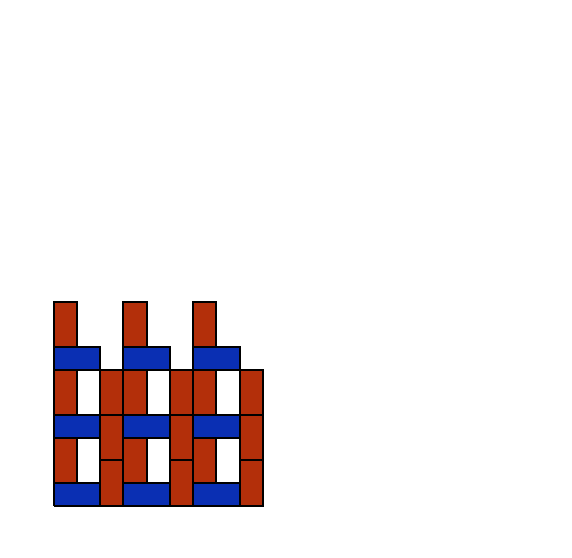

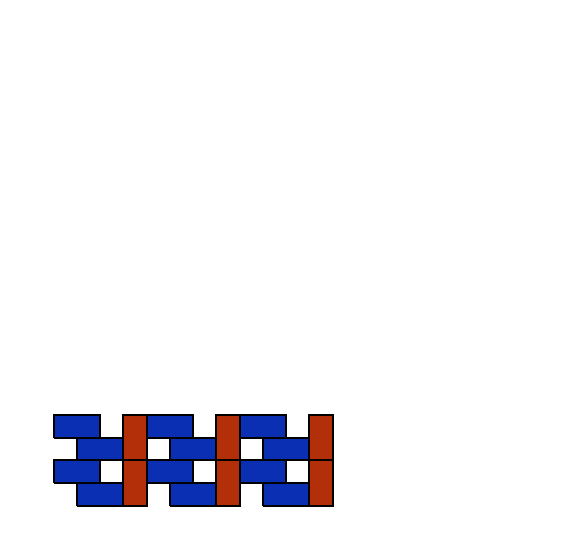

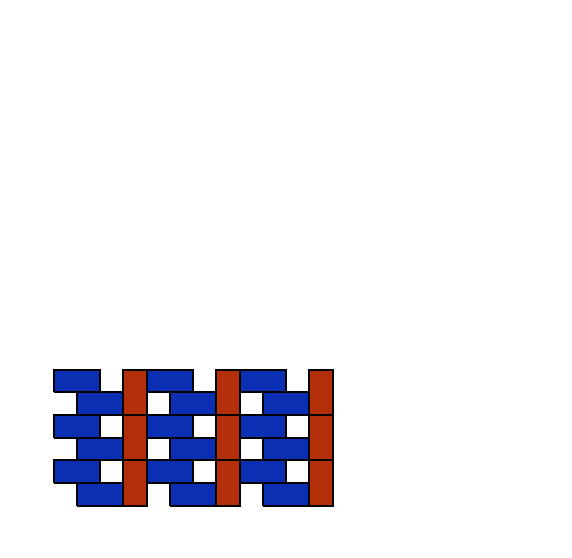

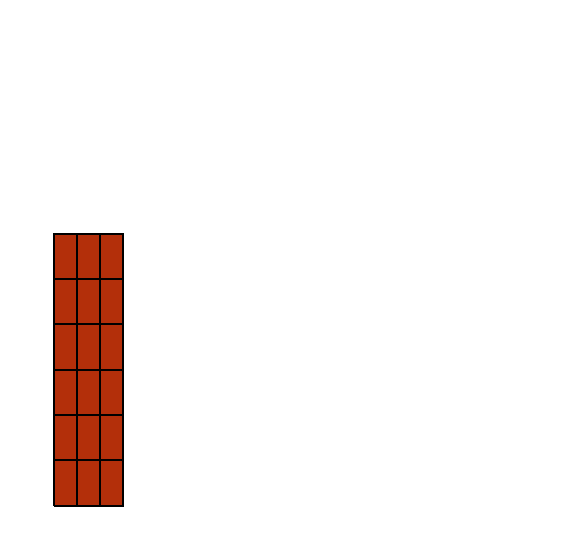

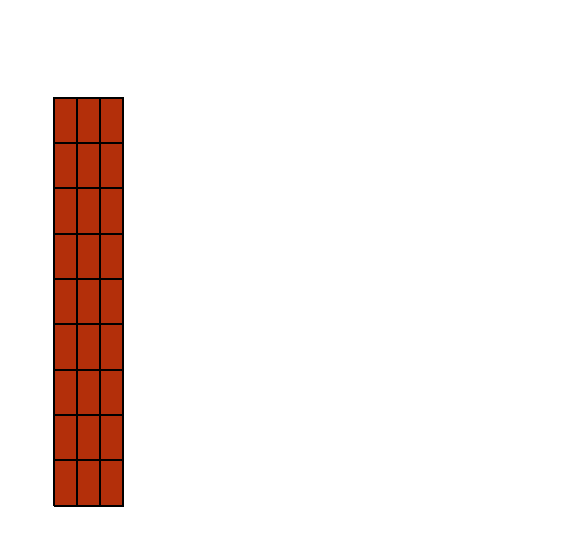

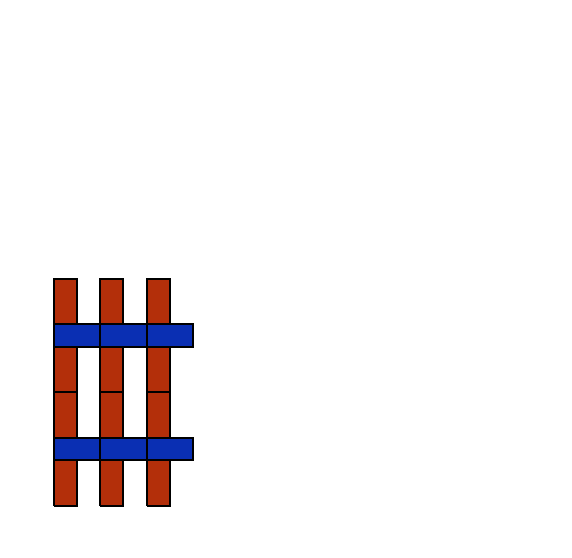

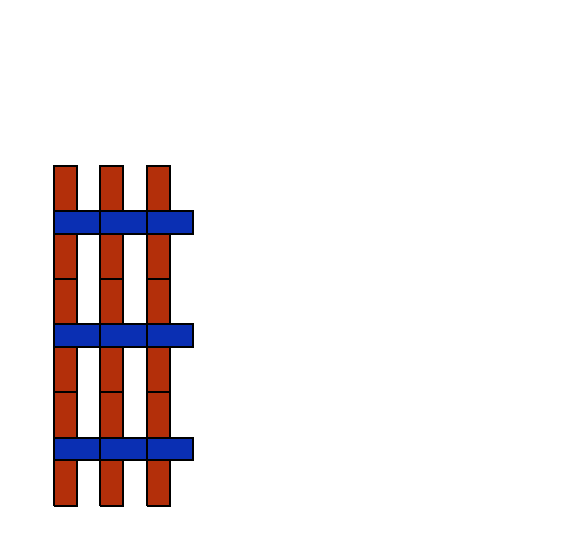

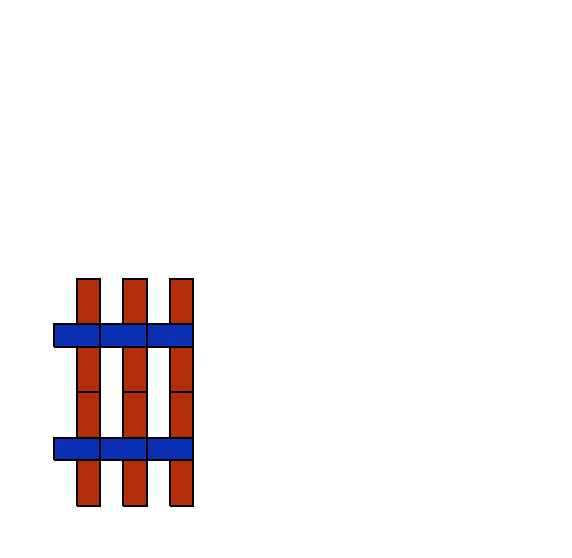

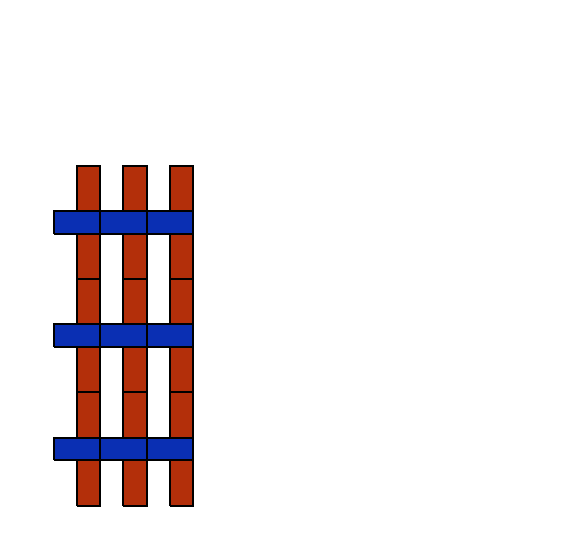

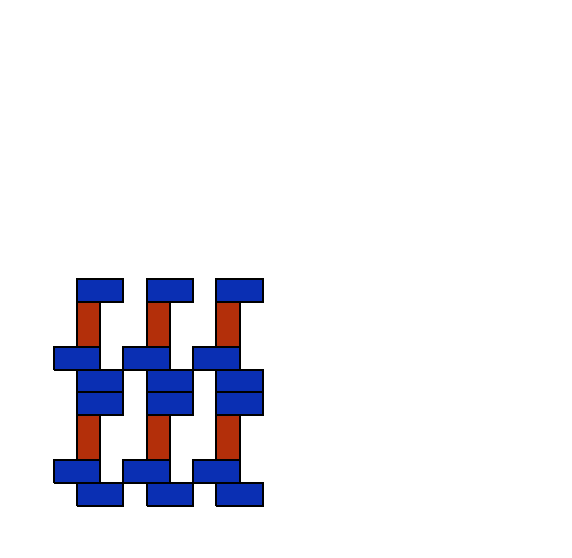

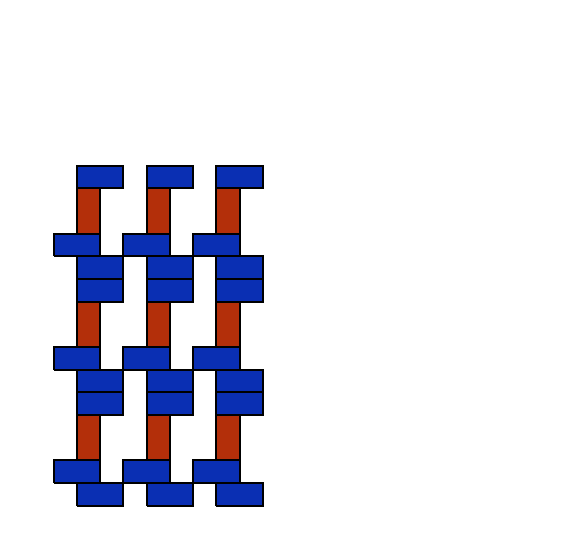

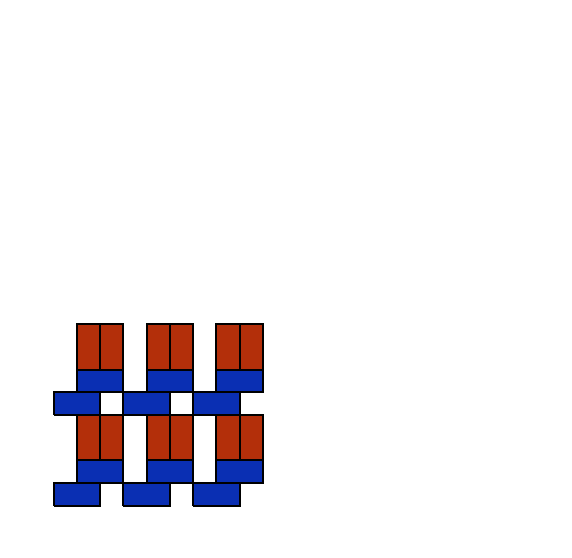

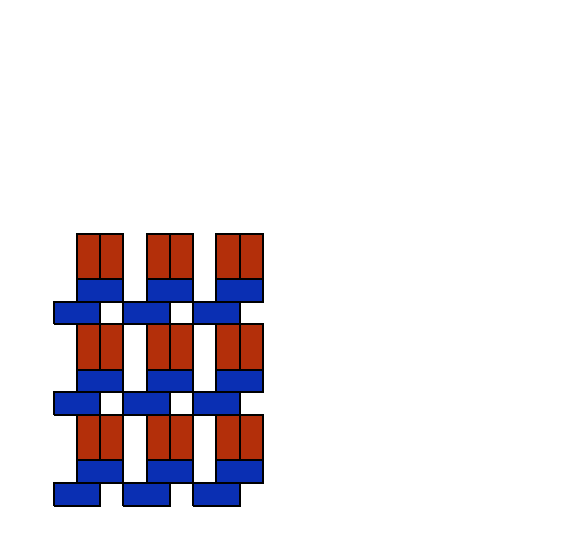

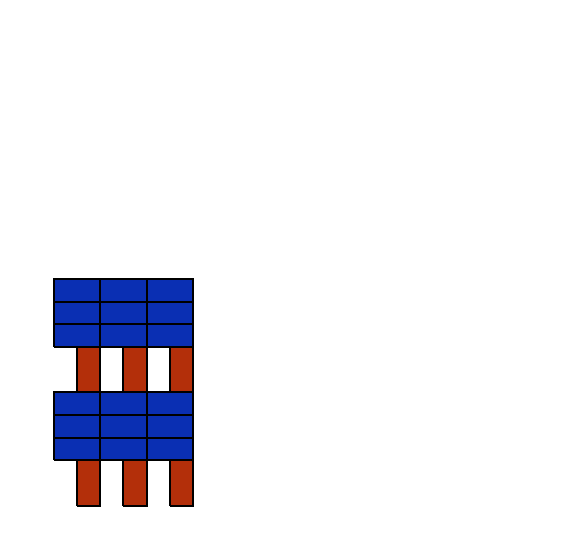

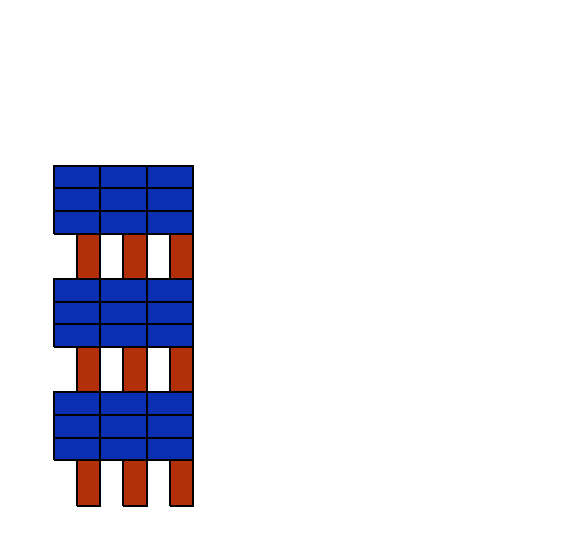

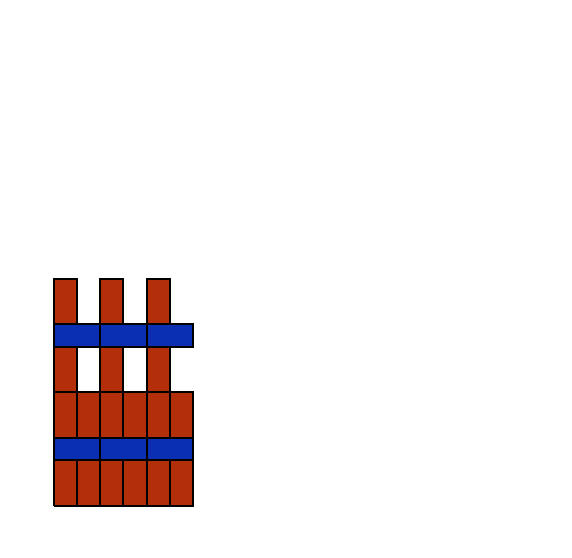

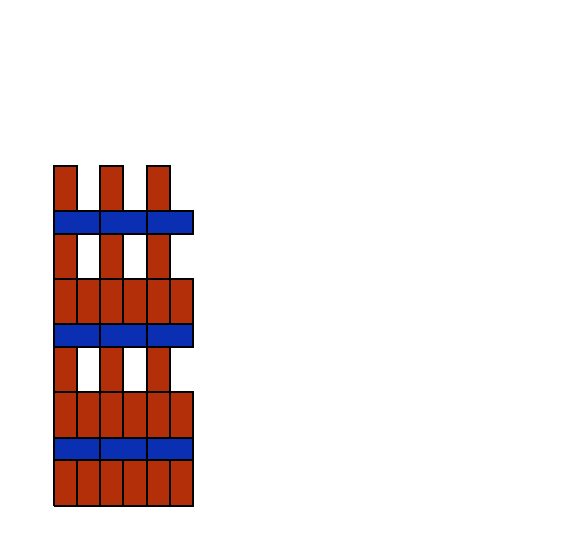

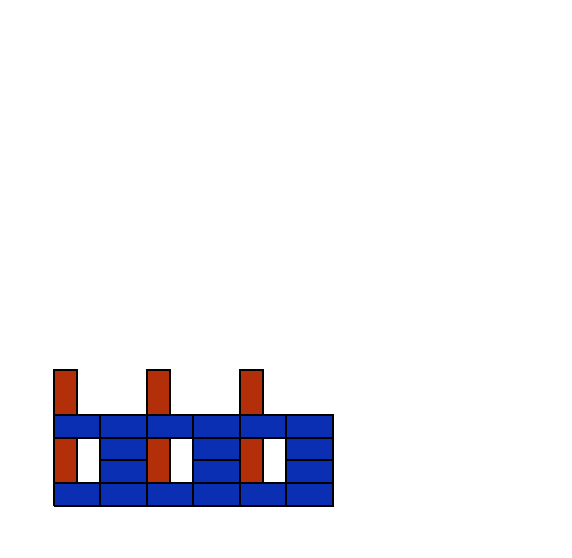

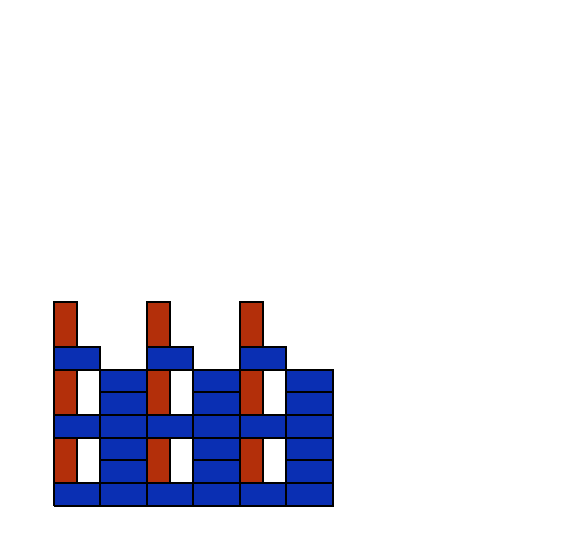

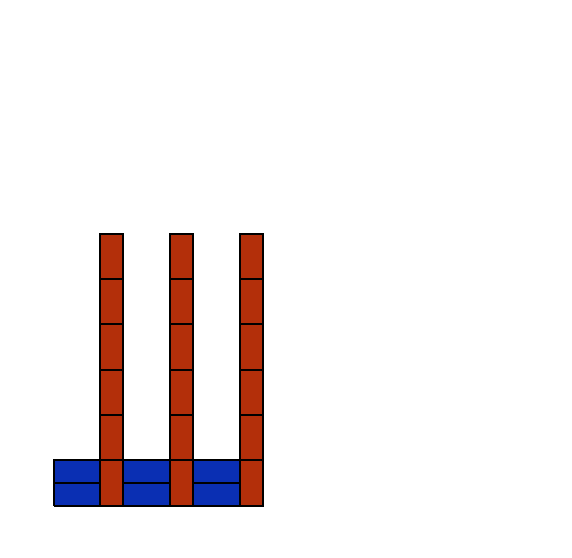

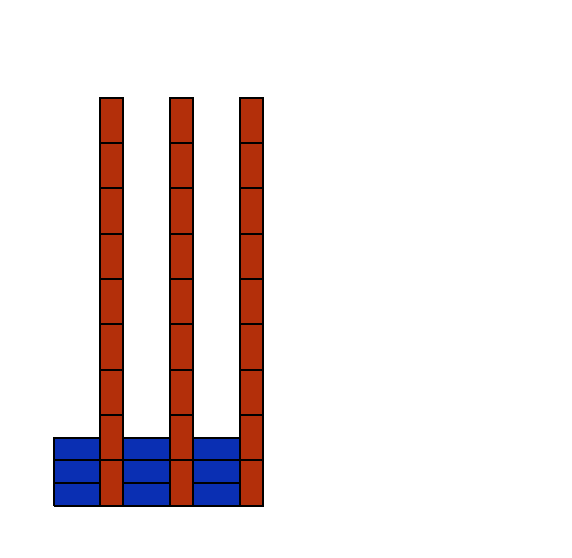

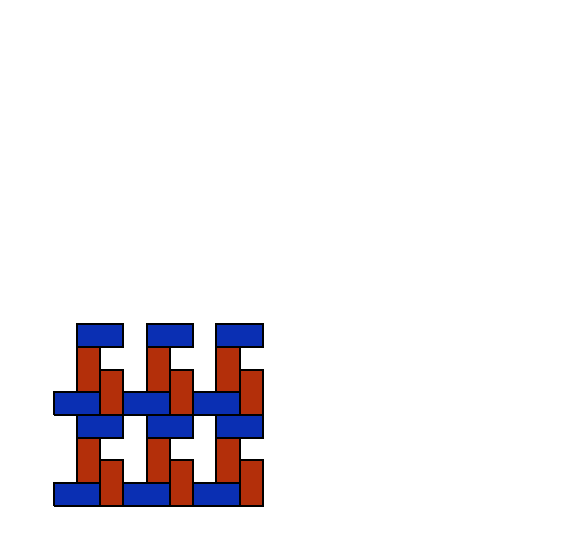

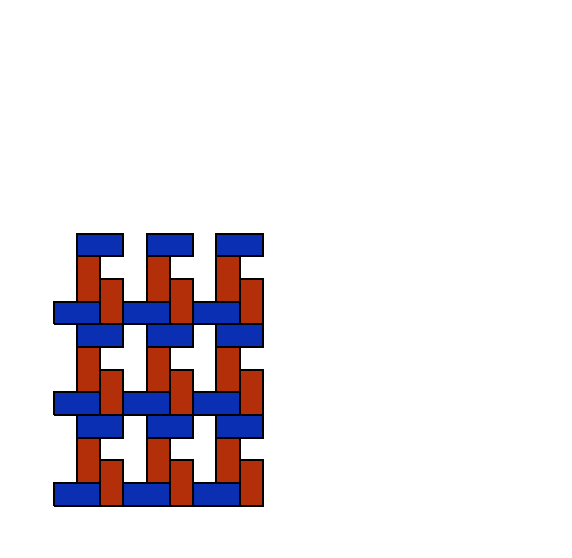

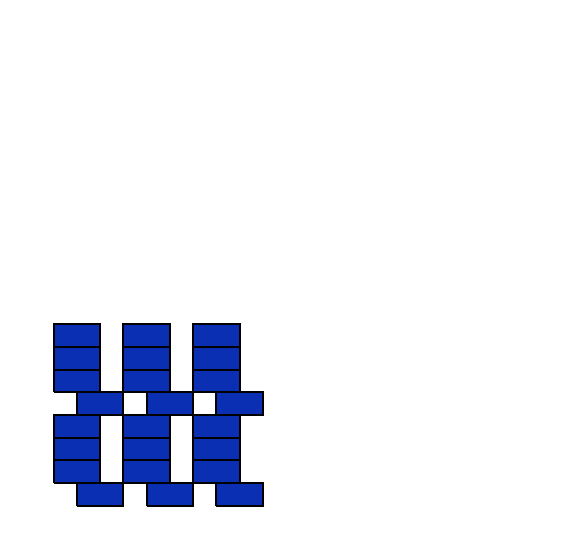

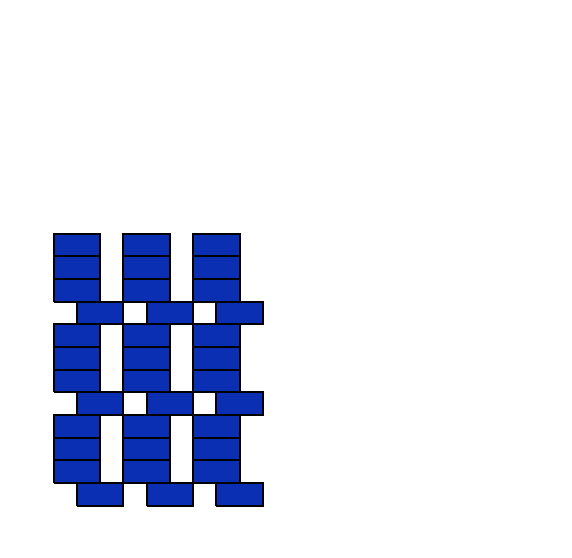

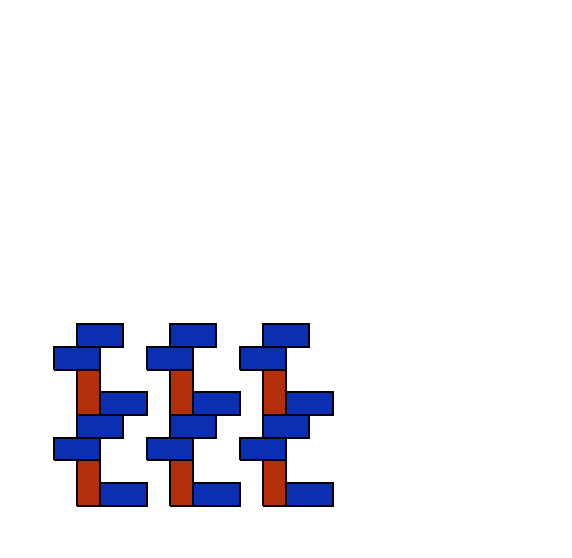

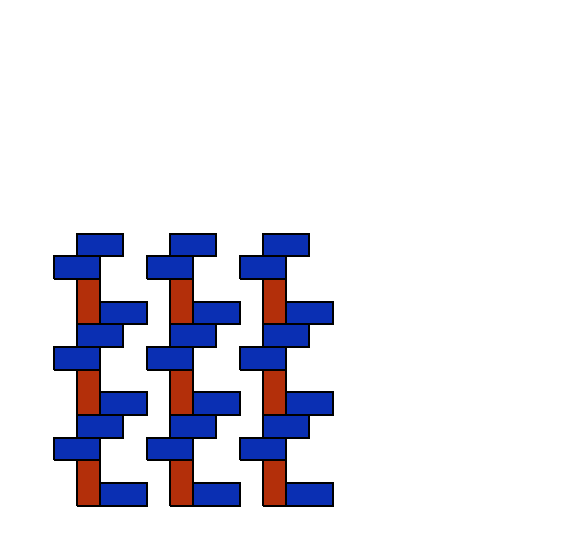

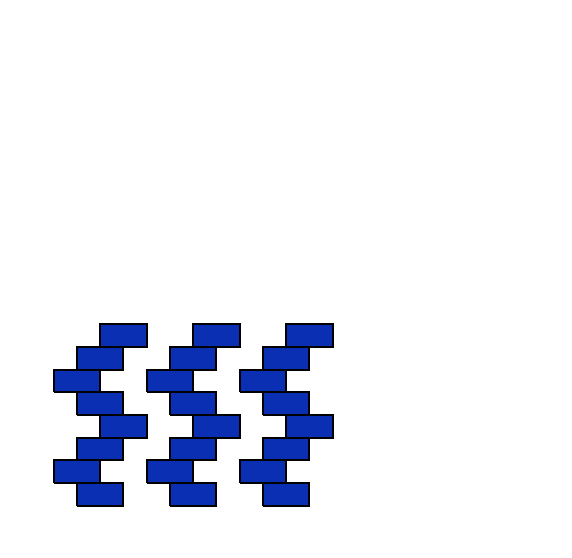

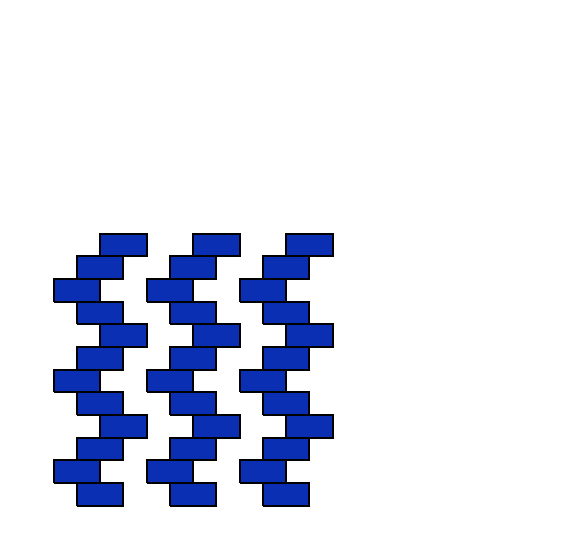

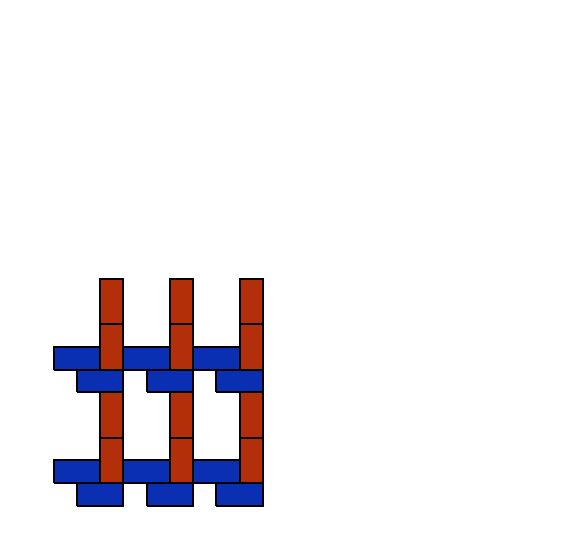

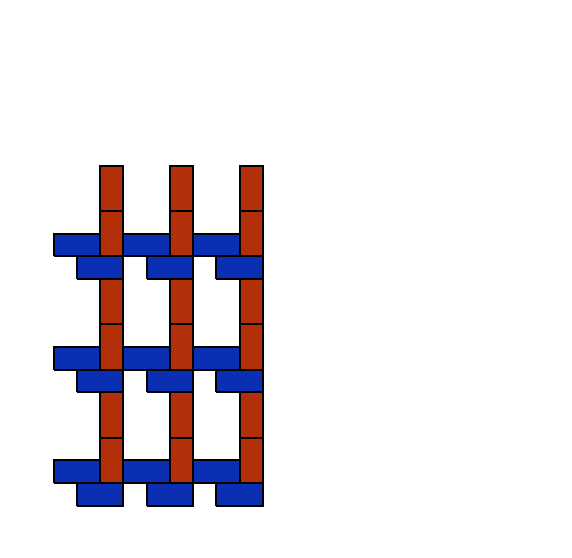

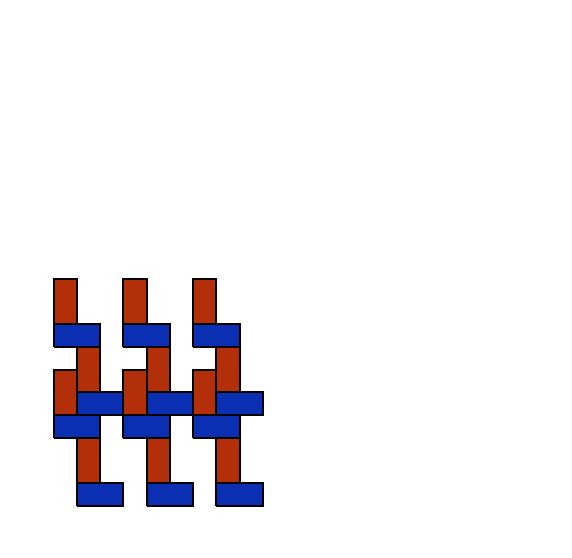

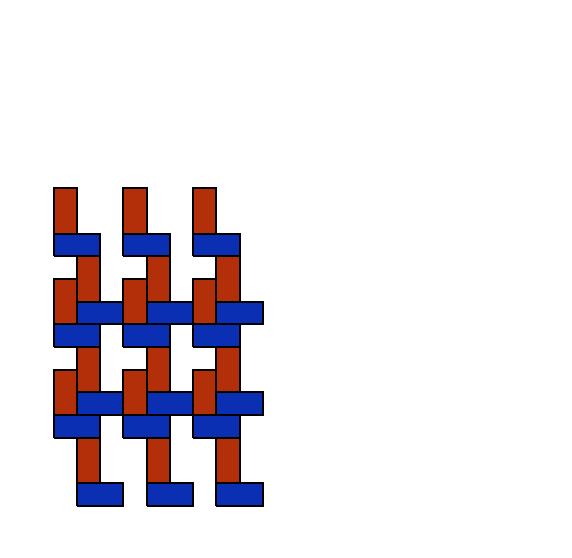

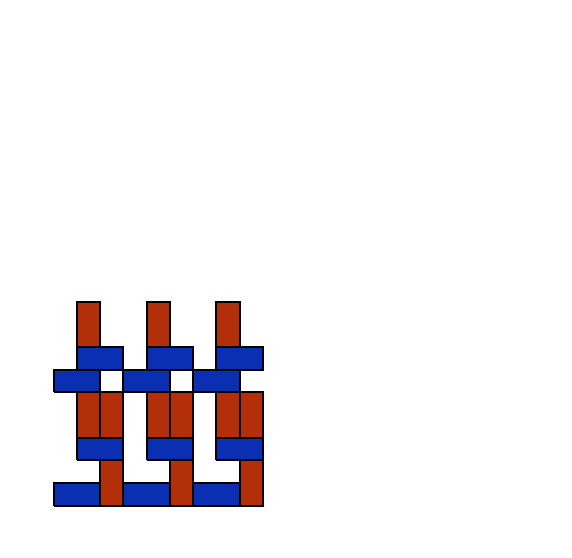

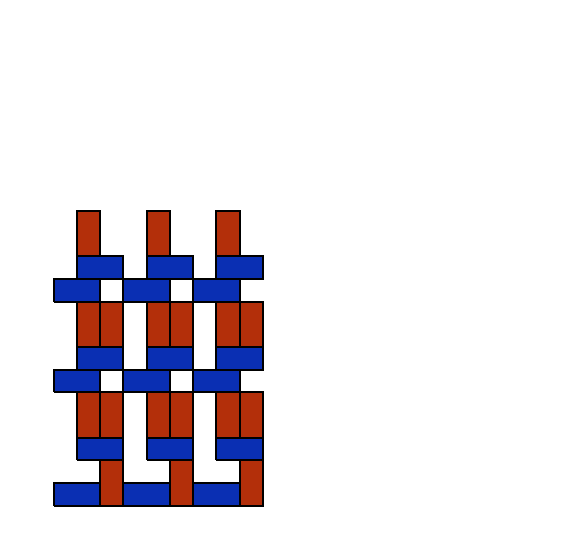

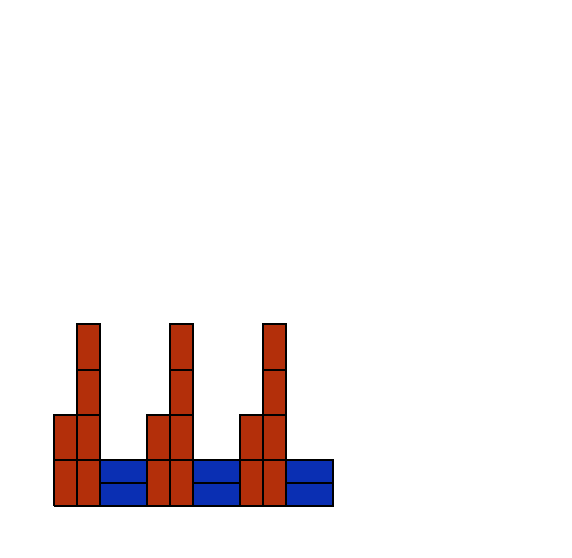

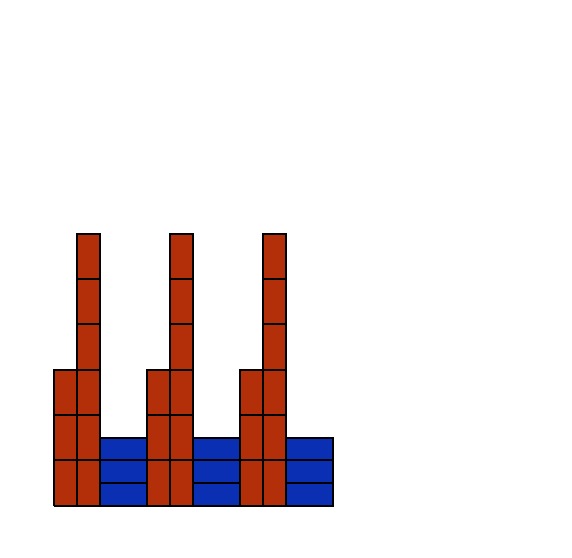

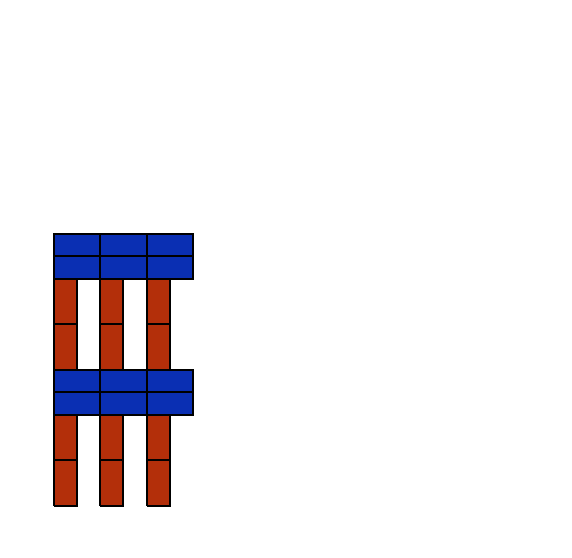

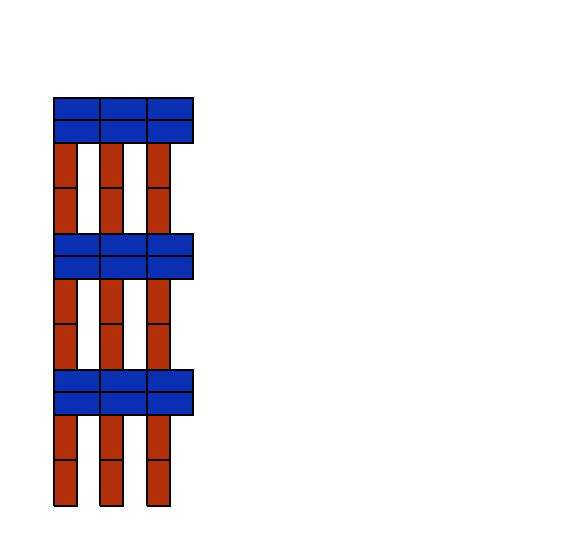

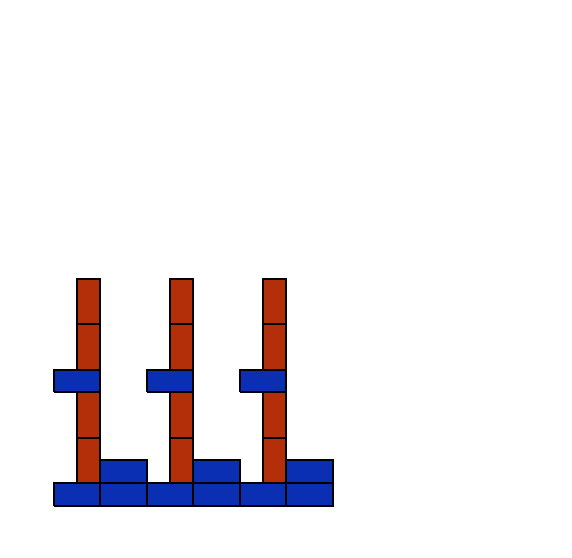

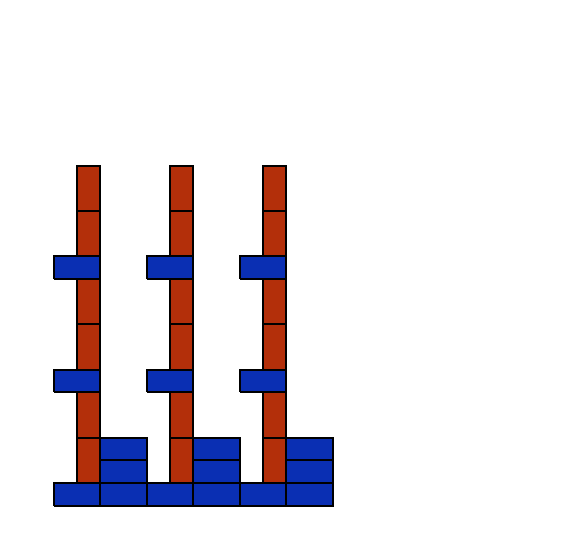

In [657]:
# Create walls of same chunk

for chunk in chunks:
    
    for wall_width in range(3,4):

        r = new_world()
        row(r, chunk, n = wall_width, diff = 0)

        row_dict = r.get_block_dict()['blocks']

        for wall_height in range(2,4):
            

            wall = new_world()
            for i in range(0, wall_height):
                wall.place_tower(block_json = row_dict, 
                                 x_location = 0)

            if ~(wall.broken):
                utils.draw_world(wall)

In [658]:
# Create walls of same chunk


walls = {}

for wall_width in range(2,5):

    walls[wall_width] = {}
    
    for wall_height in range(2,5):
        
        walls[wall_width][wall_height] = []
        
        for chunk in chunks:
            
            r = new_world()
            row(r, chunk, n = wall_width, diff = 0)
            row_dict = r.get_block_dict()['blocks']

            wall = new_world()
            for i in range(0, wall_height):
                wall.place_tower(block_json = row_dict, 
                                 x_location = 0)

            if ~(wall.broken):
                #utils.draw_world(wall)
                walls[wall_width][wall_height].append(wall.get_block_dict()['blocks'])

In [508]:
# Join towers and walls

for i in range(0,10):

    w = new_world()

    tower = random.choice(towers[3])

    wall = random.choice(walls[3][2])

    w.place_tower_relative(tower)
    w.place_tower_relative(wall)
    w.place_tower_relative(tower)

    fig = utils.draw_world(w)

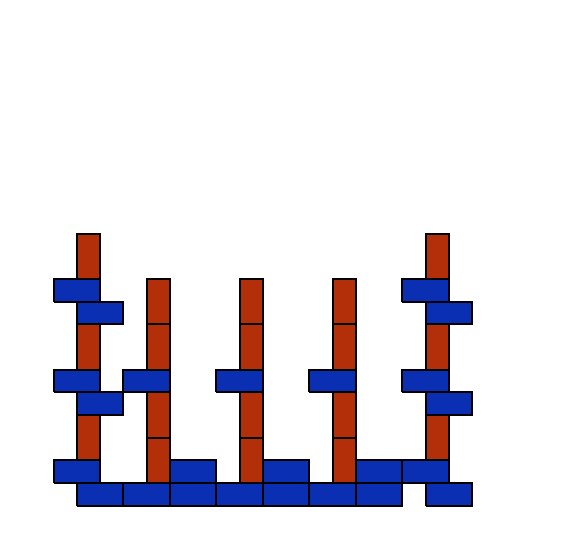

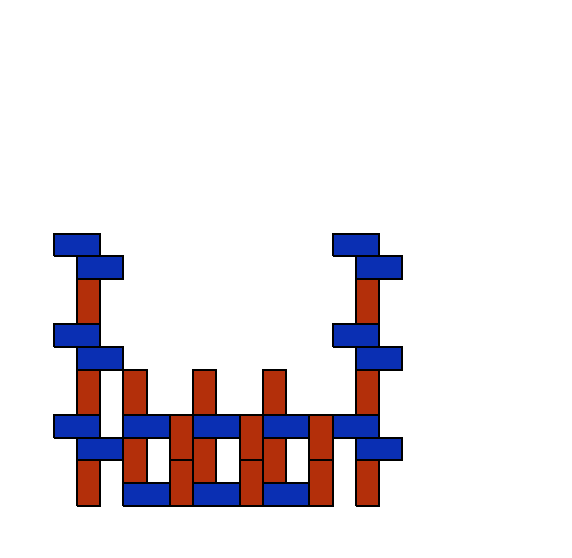

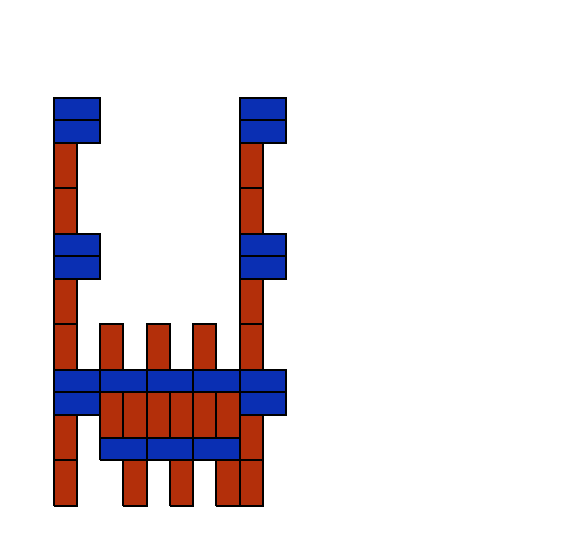

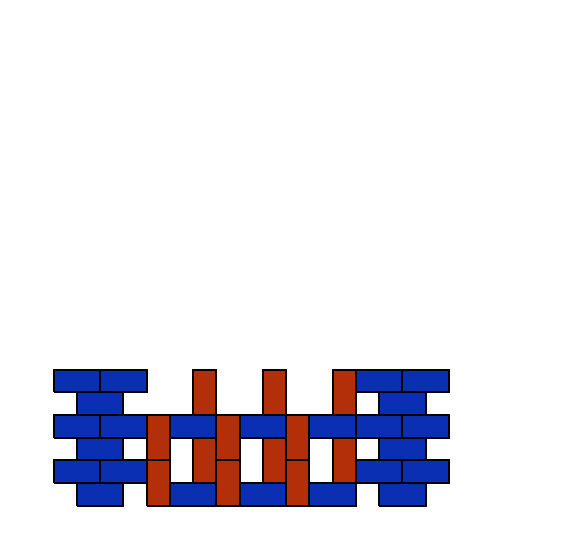

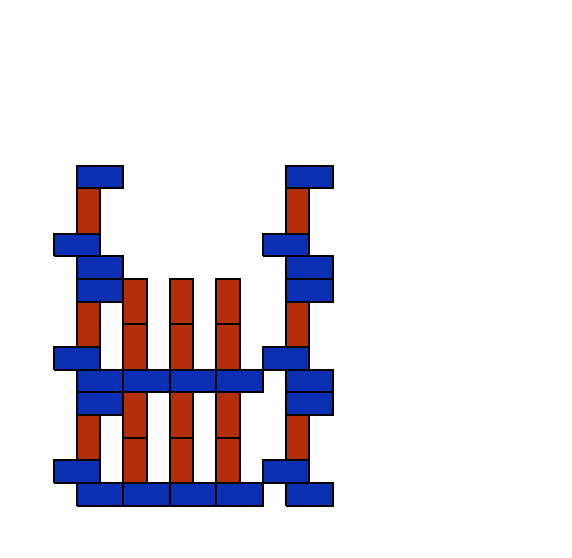

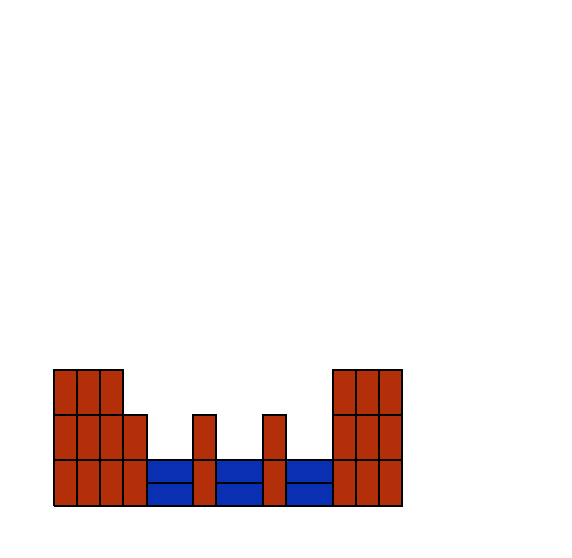

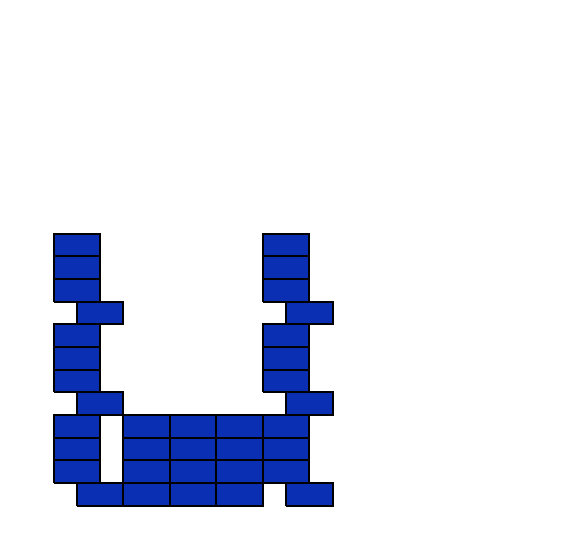

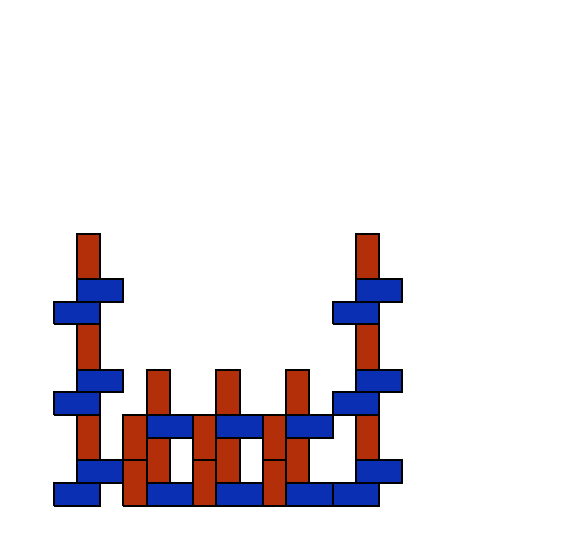

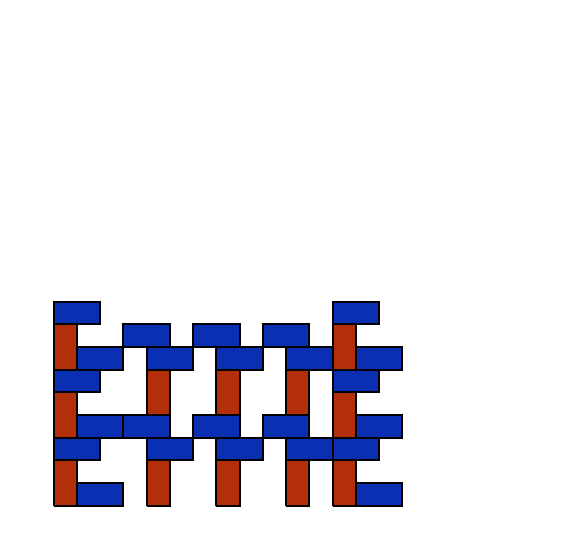

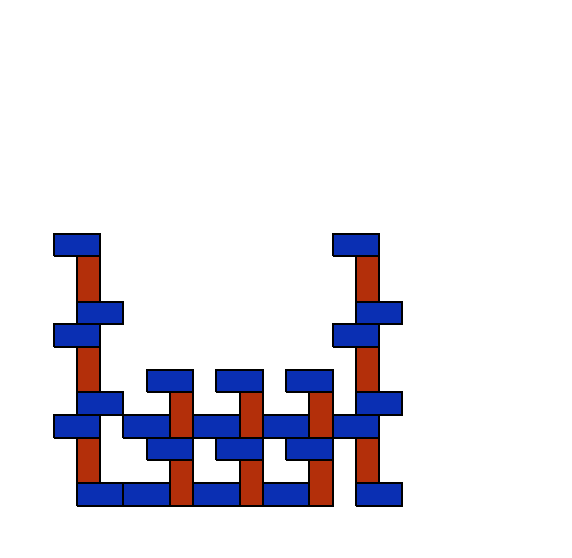

In [666]:
n_towers = 0
while n_towers < 10:

    w = new_world()

    tower = random.choice(towers[3])

    wall = random.choice(walls[3][2])

    w.place_tower_relative(tower)
    w.place_tower_relative(wall)
    w.place_tower_relative(tower)

    if not(w.broken):
        fig = utils.draw_world(w)
        n_towers += 1

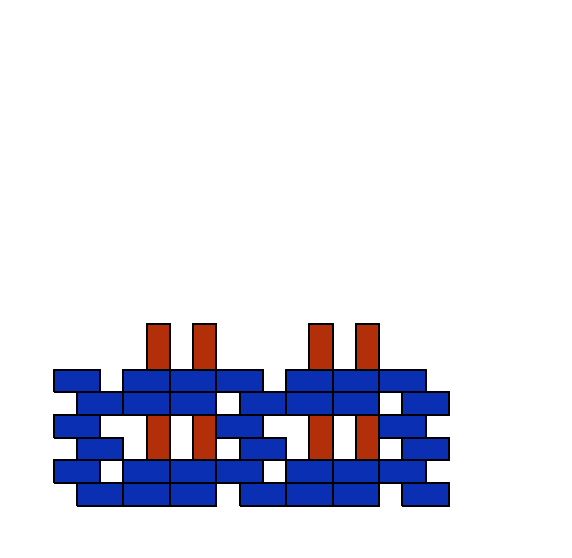

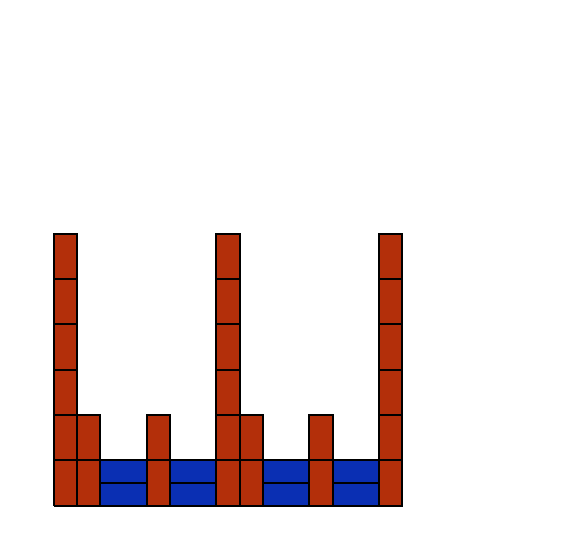

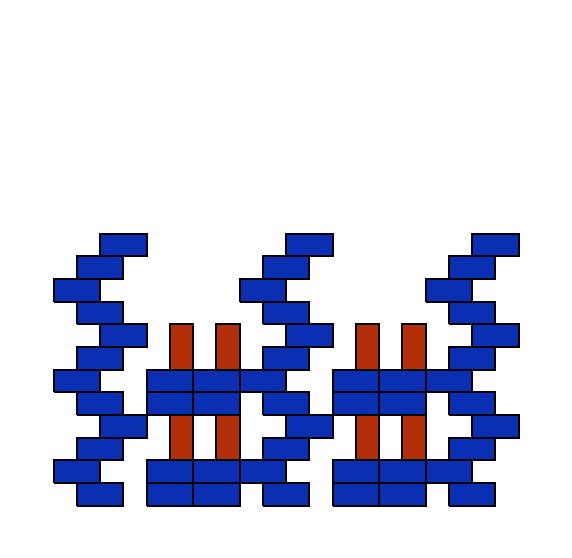

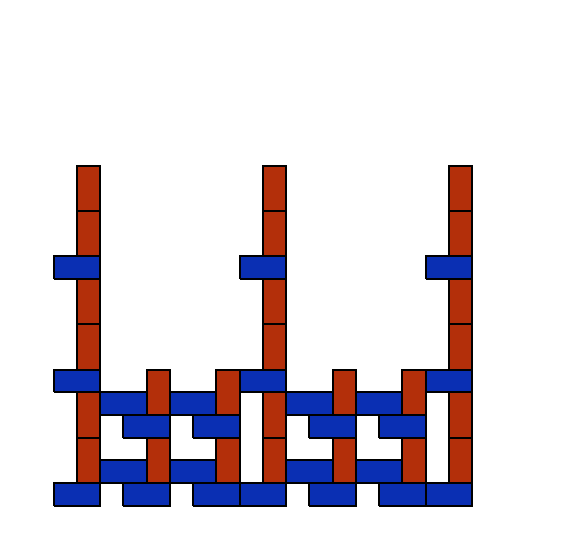

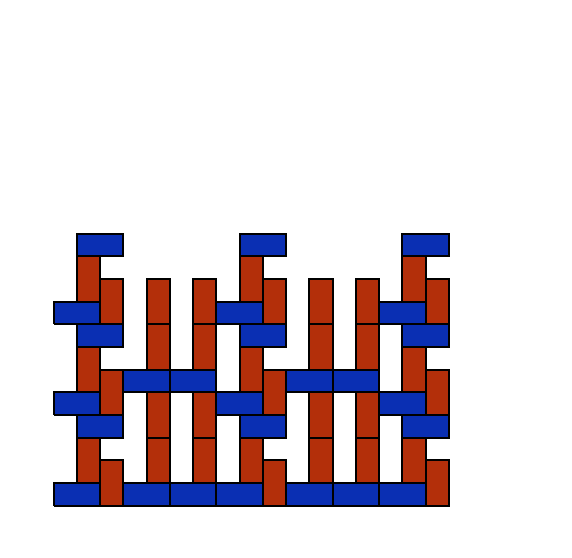

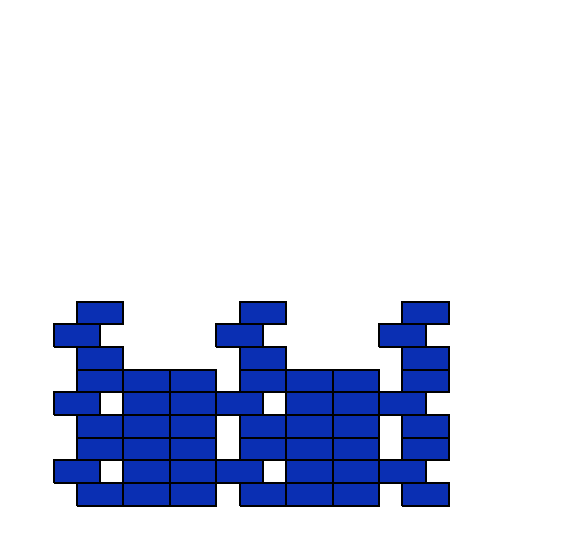

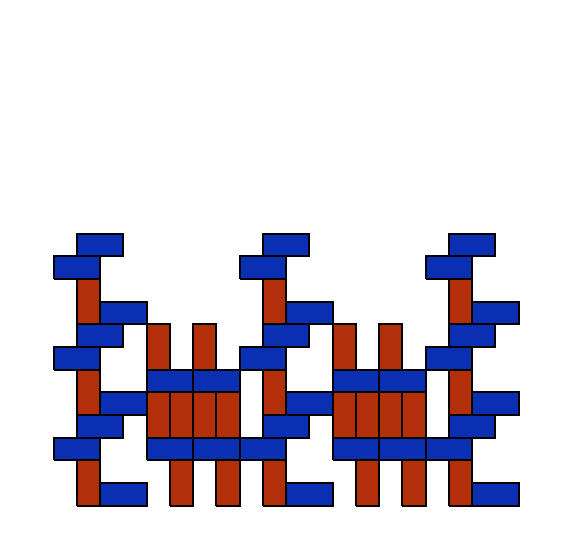

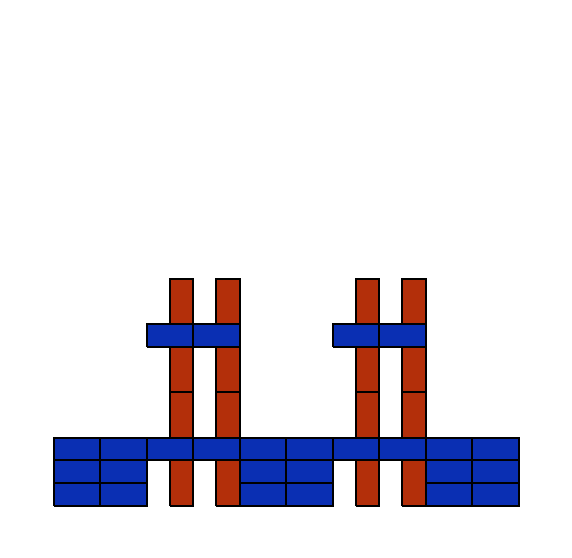

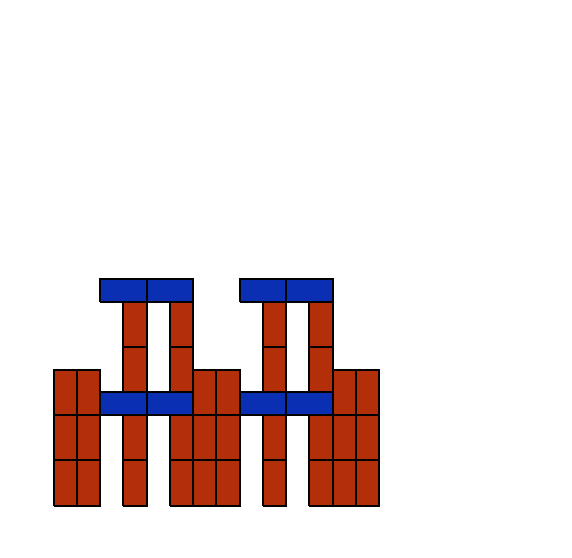

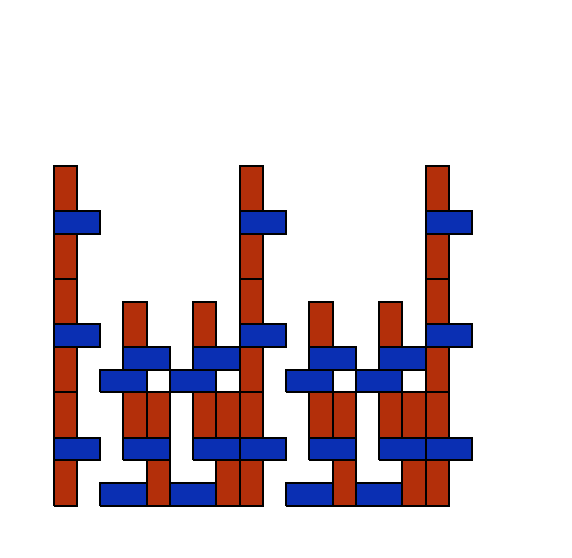

In [662]:
n_towers = 0
while n_towers < 10:

    w = new_world()

    tower = random.choice(towers[3])

    wall = random.choice(walls[2][2])

    w.place_tower_relative(tower)
    w.place_tower_relative(wall)
    w.place_tower_relative(tower)
    w.place_tower_relative(wall)
    w.place_tower_relative(tower)

    if not(w.broken):
        fig = utils.draw_world(w)
        n_towers += 1

## Explore classes of physical structures

e.g.
- castles
- houses
- bridges
- skyscrapers

### Castles

In [801]:
# Get tower levels

tower_levels = list(df_towers[(df_towers.two_h_two_v) &
                              (df_towers.n_blocks == 4) & 
                              (df_towers.tower_width <= 4) & 
                              (df_towers.tower_height <= 3) &
                              (df_towers.tower_height >= 3)]['stim'])


# Get wall bricks

wall_bricks = list(df_towers[(df_towers.two_h_two_v) &
                              (df_towers.n_blocks == 4) & 
                              (df_towers.tower_width <= 4) & 
                              (df_towers.tower_height <= 3)]['stim'])

In [973]:
roofs = {}

for roof_size in range(1,10):
    
    r = new_world()
    pyramid(r, roof_size)
    row_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
        #utils.draw_world(wall)
    else:
        roofs[roof_size] = row_dict
        
domes = {}

for dome_size in range(1,12):
    
    d = new_world()
    dome(d, dome_size)
    dome_dict = d.get_block_dict()['blocks']
    
    if (d.broken):
        print('BAD ROOF- RESIZE WORLD?')
    else:
        domes[dome_size] = dome_dict
#         utils.draw_world(d)

slabs = {}

for width in range(1,20):
    
    r = new_world()
    slab(r, width)
    row_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
        #utils.draw_world(wall)
    else:
        slabs[width] = row_dict
      

In [887]:
# Create towers

towers = {}

for tower_height in range(2,6):
    
    towers[tower_height] = []
    
    for chunk in tower_levels:
        w = new_world()
        stack(w, chunk, n = tower_height, x_location = 0)
        
        if not w.broken:
            towers[tower_height].append(w.get_block_dict()['blocks'])
#             utils.draw_world(w)

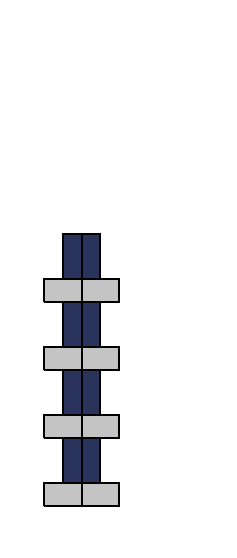

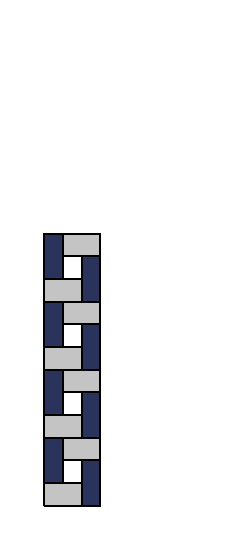

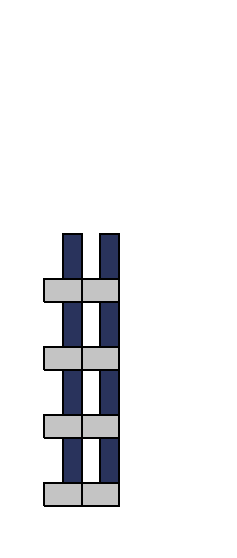

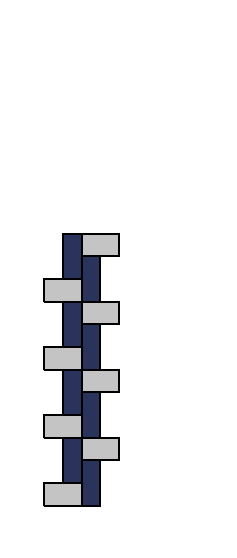

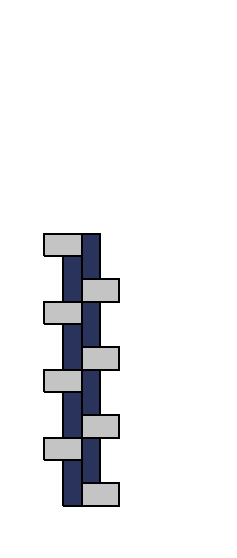

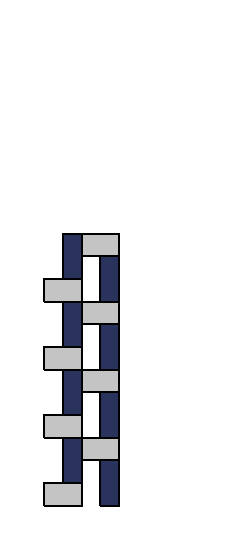

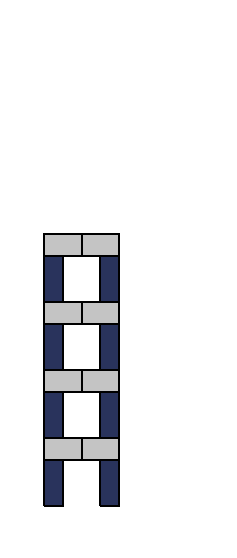

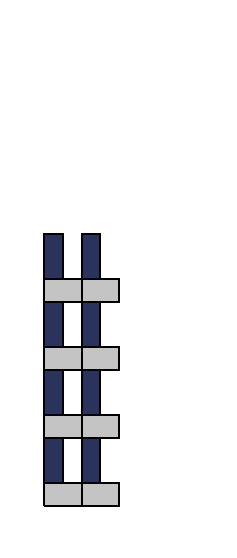

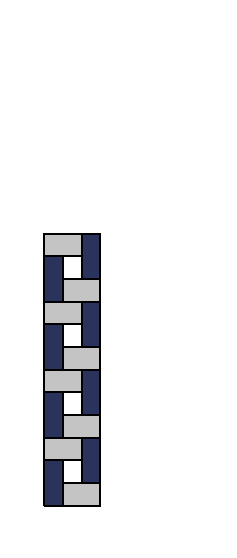

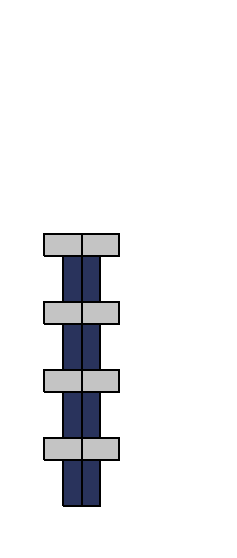

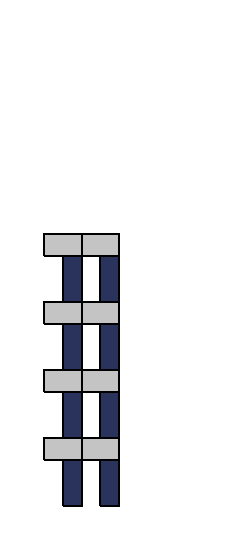

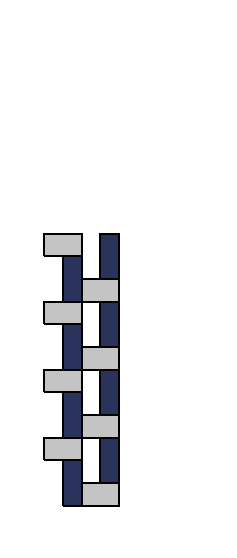

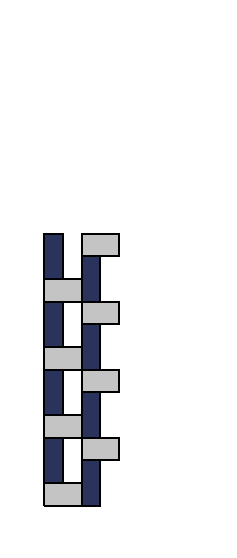

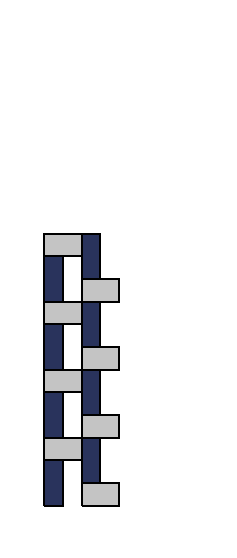

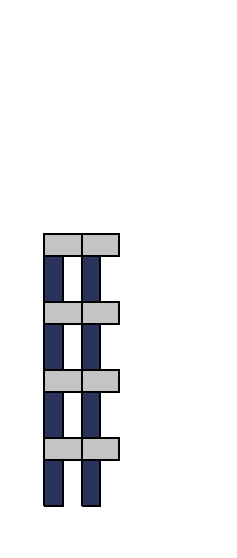

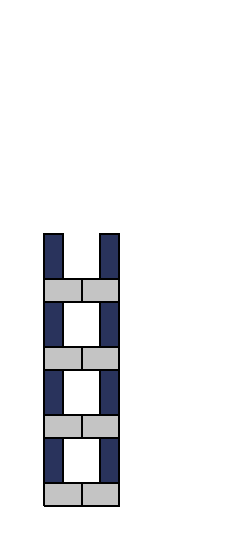

In [742]:
_ = [utils.draw_world(utils.worldify(w, world_height=20)) for w in towers[4]]

In [891]:
# Create walls of same chunk


walls = {}

for wall_width in range(1,5):

    walls[wall_width] = {}
    
    for wall_height in range(1,6):
        
        walls[wall_width][wall_height] = []
        
        for k, chunk in enumerate(wall_bricks):
            
            r = new_world()
            row(r, chunk, n = wall_width, diff = 0)
            row_dict = r.get_block_dict()['blocks']

            wall = new_world()
            for i in range(0, wall_height):
                wall = wall.place_tower(block_json = row_dict, 
                                        x_location = 0)

            if not (wall.broken):
                #utils.draw_world(wall)
                walls[wall_width][wall_height].append(wall.get_block_dict()['blocks'])

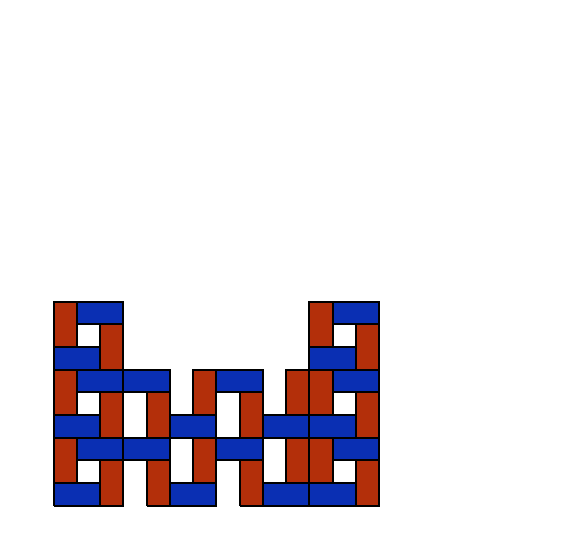

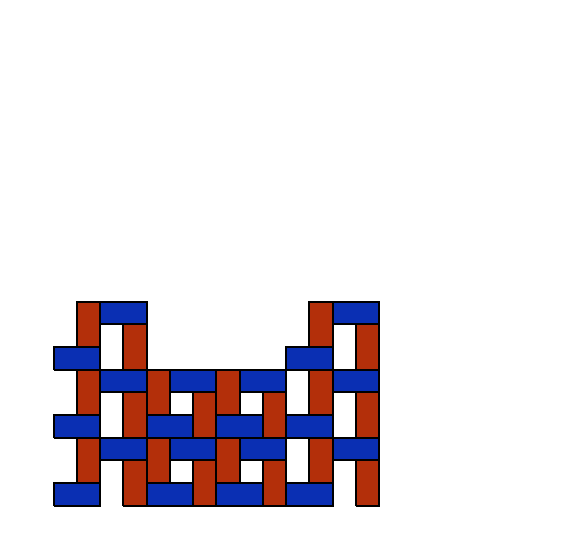

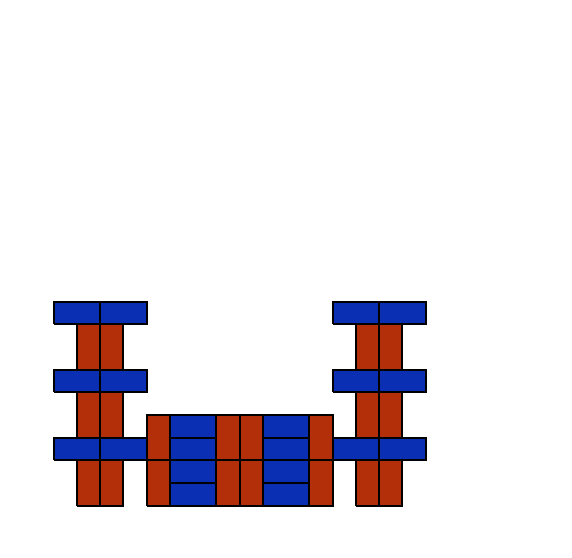

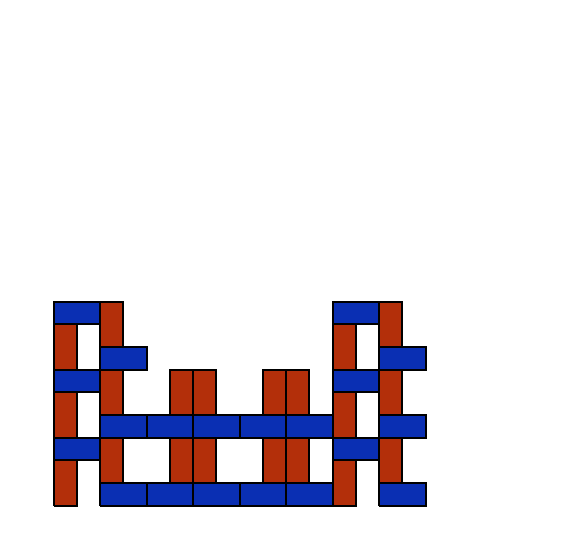

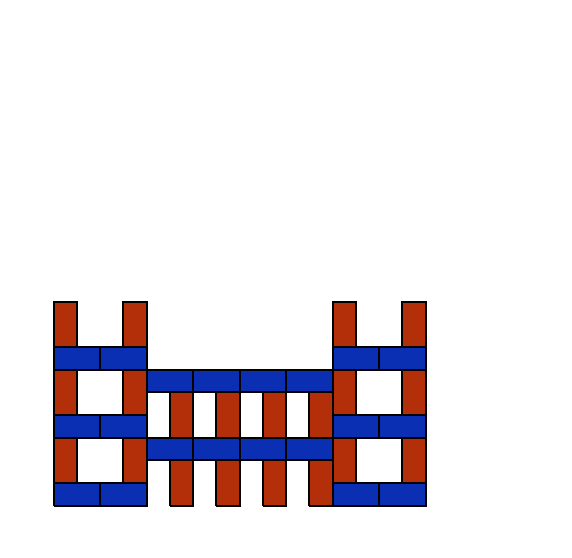

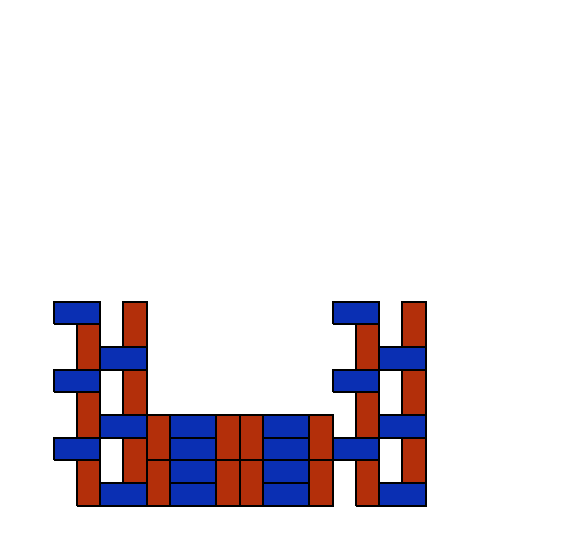

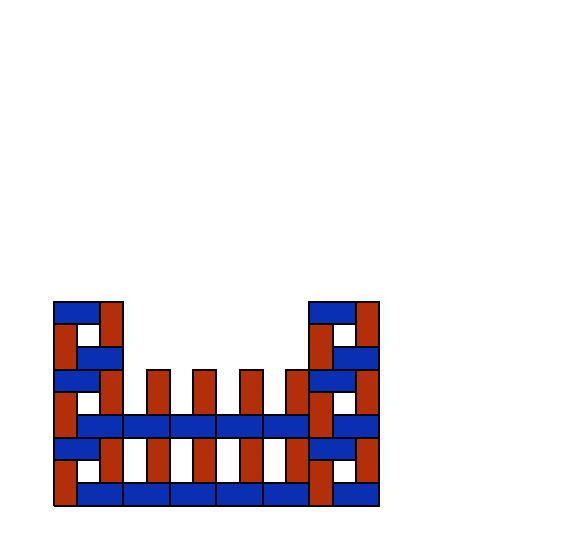

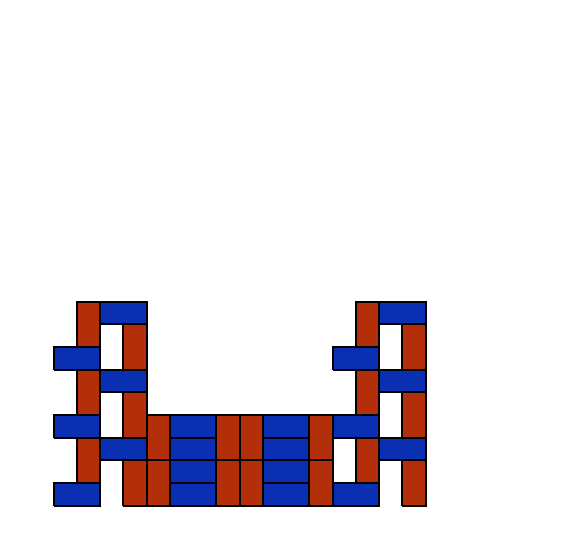

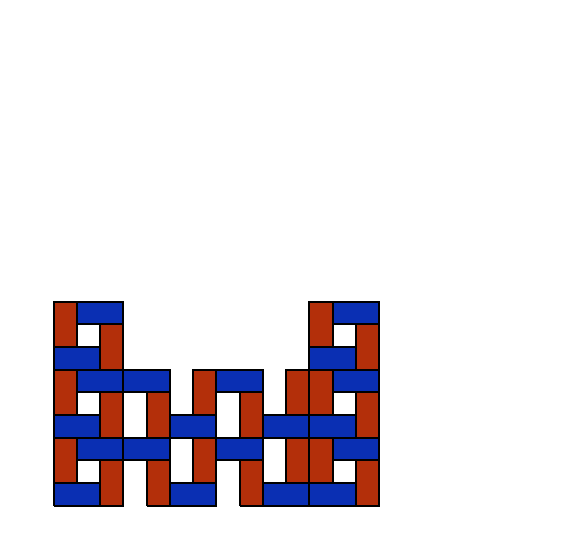

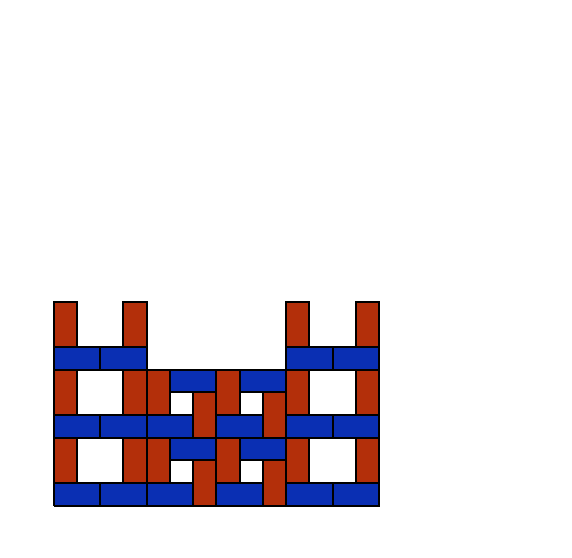

In [744]:
n_towers = 0
while n_towers < 10:

    w = new_world()

    tower = random.choice(towers[3])

    wall = random.choice(walls[2][2])

    w.place_tower_relative(tower)
    w.place_tower_relative(wall)
    w.place_tower_relative(tower)

    if not(w.broken):
        fig = utils.draw_world(w)
        n_towers += 1

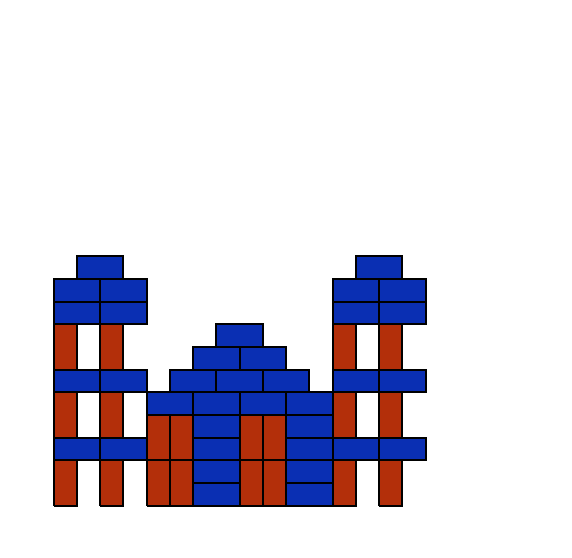

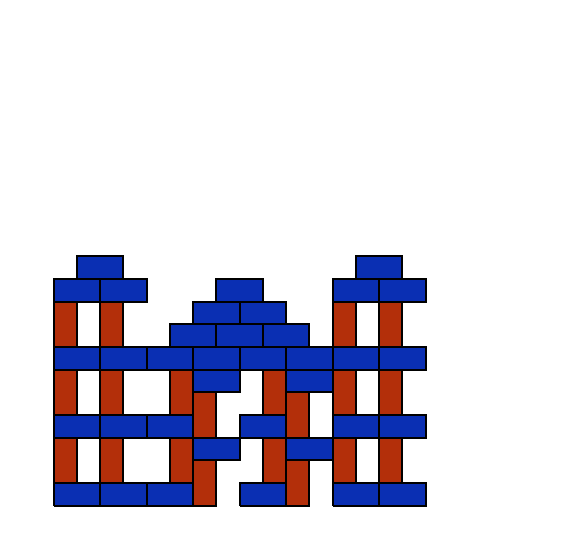

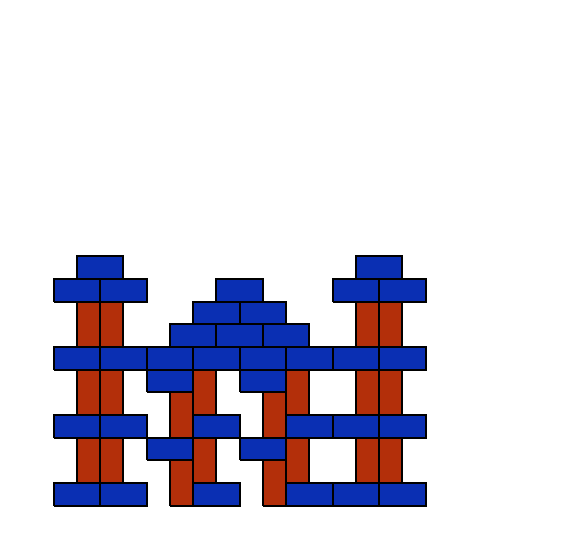

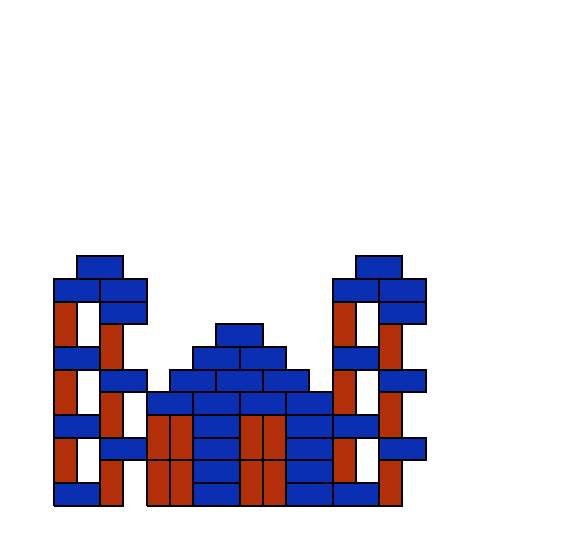

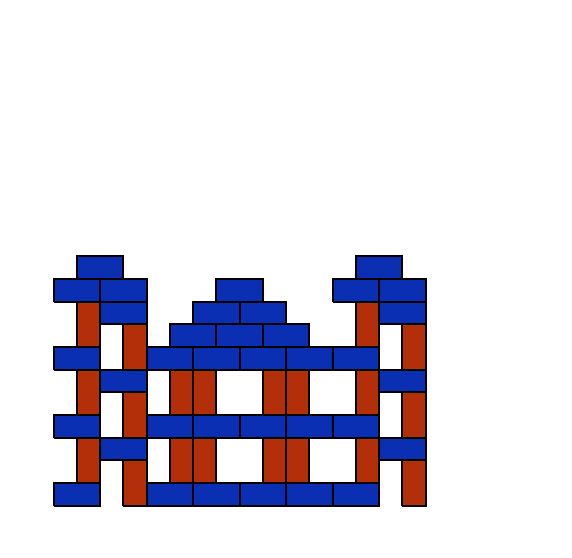

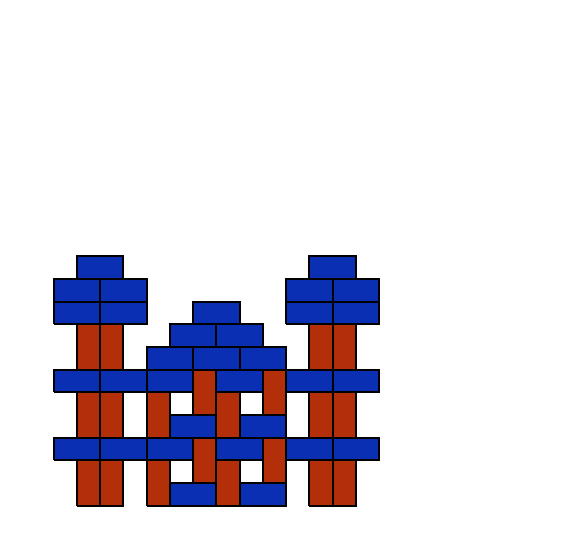

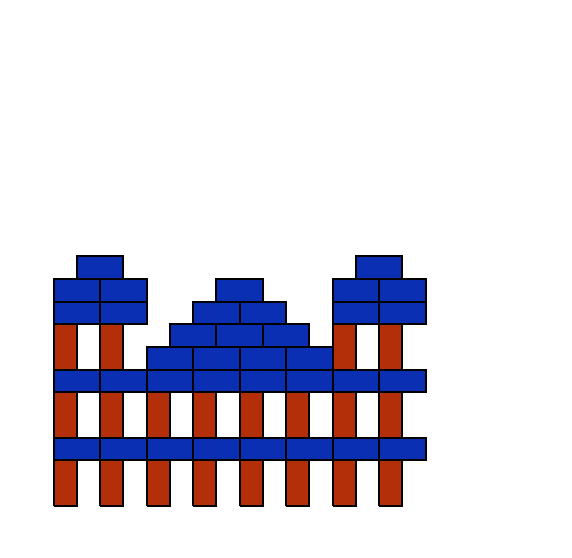

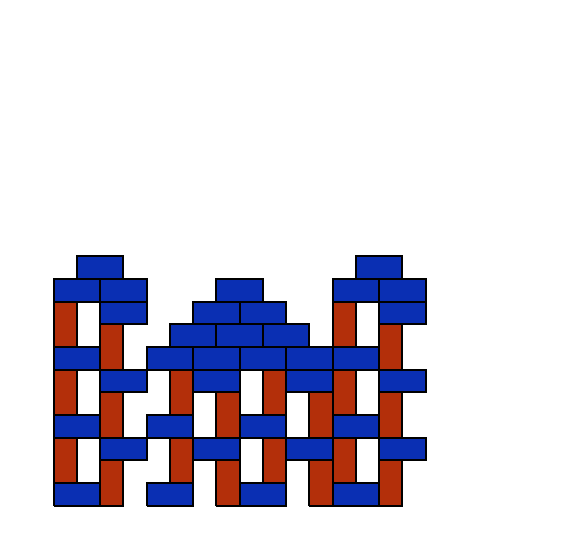

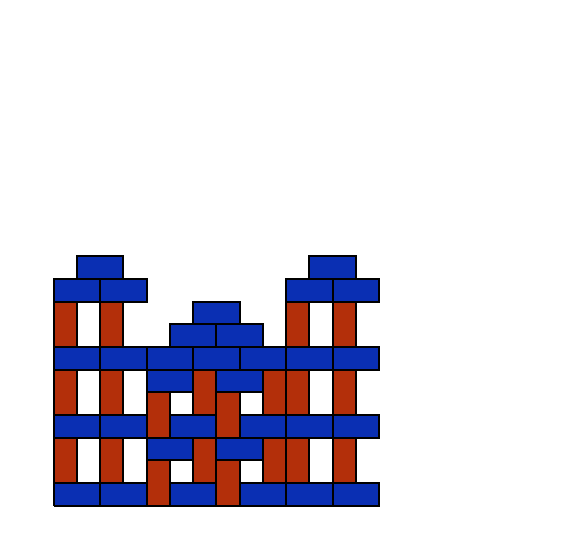

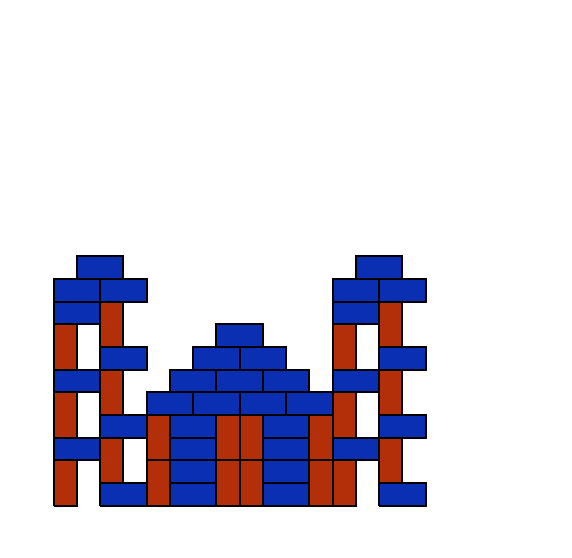

In [798]:
n_towers = 0
while n_towers < 10:

    w = new_world()

    tower = random.choice(towers[3])
    tower_width = utils.worldify(tower).tower_width()

    wall = random.choice(walls[2][2])
    wall_width = utils.worldify(wall).tower_width()

    w.place_tower_relative(tower)
    w.place_tower(roofs[int(tower_width/2)])
    w.place_tower_relative(wall)
    w.place_tower(roofs[int(wall_width/2)],tower_width)
    w.place_tower_relative(tower)
    w.place_tower(roofs[int(tower_width/2)],tower_width+wall_width)

    if not(w.broken):
        fig = utils.draw_world(w)
        n_towers += 1

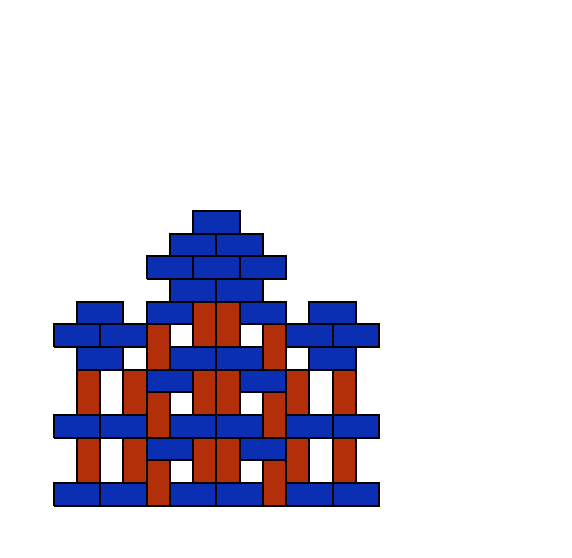

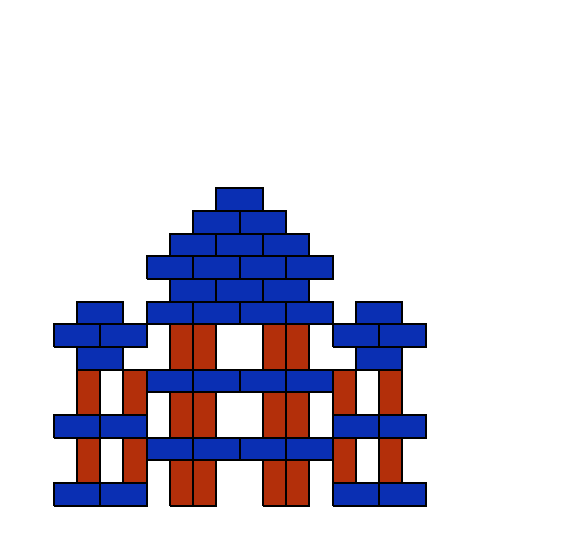

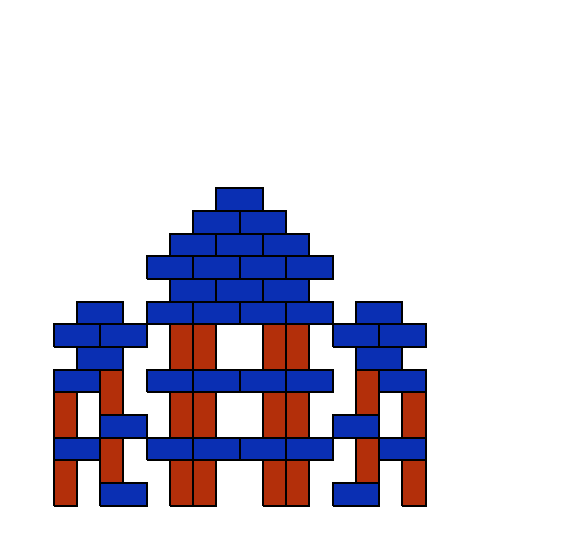

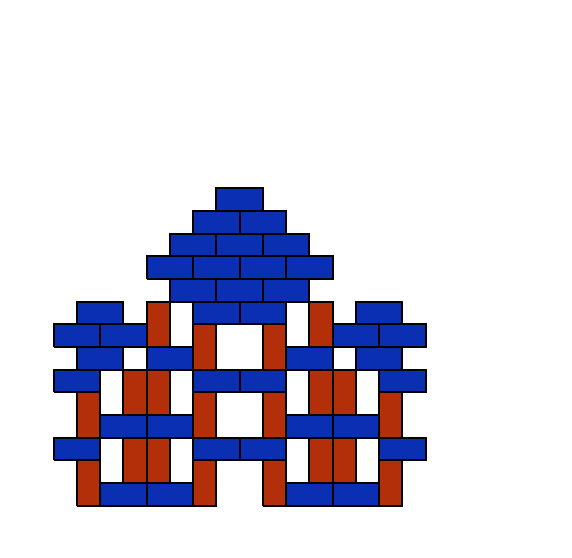

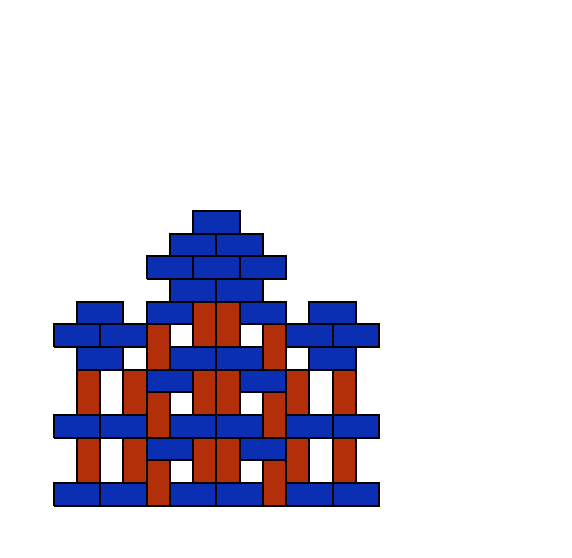

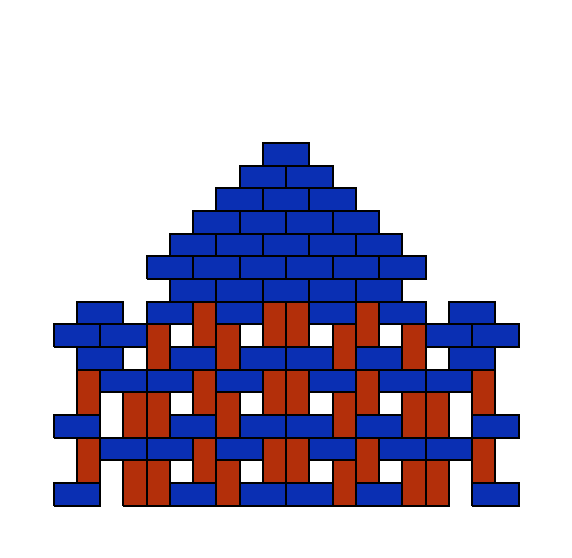

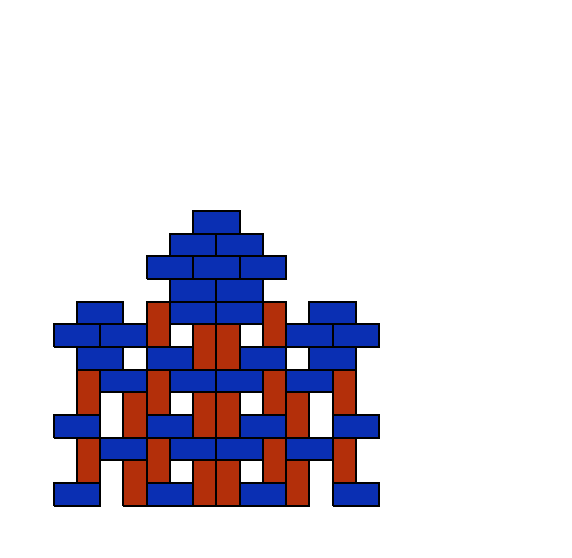

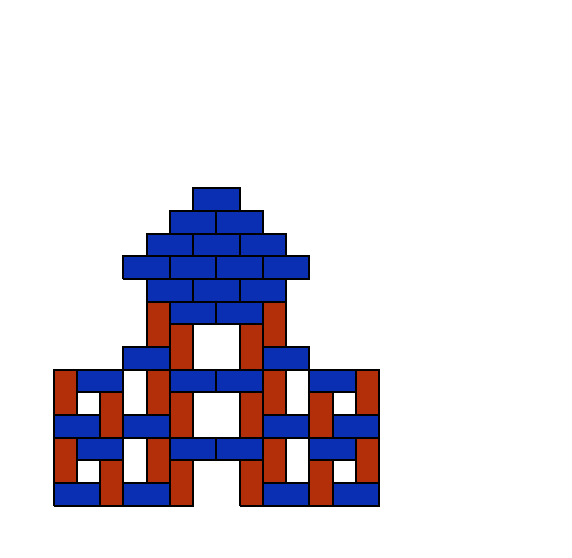

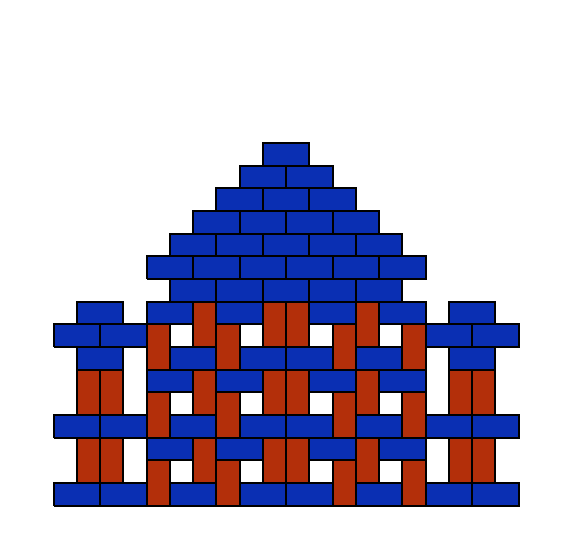

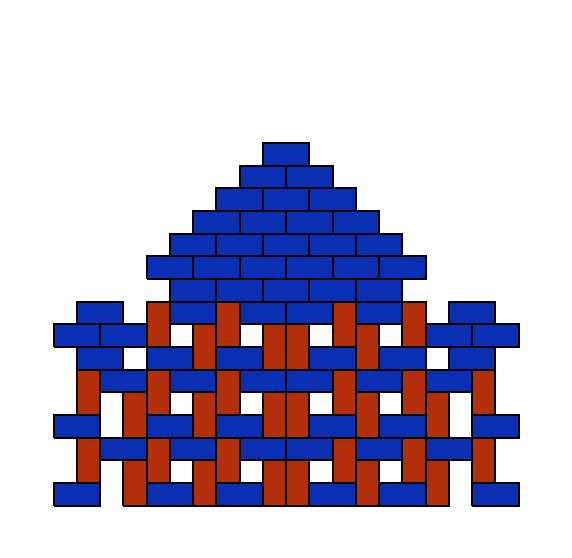

In [1067]:
# tower-centric castles

n_towers = 0
while n_towers < 10:

    w = new_world()

    tower_1 = random.choice(towers[2])
    tower_width = utils.worldify(tower_1, world_width=20).tower_width()

    tower_2 = random.choice(towers[3])
    tower_2_width = utils.worldify(tower_2, world_width=20).tower_width()

    w.place_tower_relative(tower_1)
    if tower_width >= 4:
        w.place_tower(domes[int(tower_width/2)])
    wall_size = random.choice([2,4])
    
    for i in range(0,int(wall_size/2)):
        w.place_tower_relative(tower_2)
    
    
#     if wall_size%2 == 1:
#         w.place_tower_relative(tower_2)
    
    for i in range(0,int(wall_size/2)):
        w.place_tower_relative(mirror(tower_2))
        
    wall_width = int(tower_2_width*wall_size/2)
    
    w.place_tower(domes[wall_width], tower_width)
    
    
    w.place_tower_relative(mirror(tower_1))
    if tower_width >= 4:
        w.place_tower(domes[int(tower_width/2)],tower_width + wall_width*2)

    if not(w.broken):
        
        fig = utils.draw_world(w)
        n_towers += 1

In [1068]:
towers

{2: [[{'x': 0, 'y': 0, 'height': 1, 'width': 2},
   {'x': 2, 'y': 0, 'height': 1, 'width': 2},
   {'x': 1, 'y': 1, 'height': 2, 'width': 1},
   {'x': 2, 'y': 1, 'height': 2, 'width': 1},
   {'x': 0, 'y': 3, 'height': 1, 'width': 2},
   {'x': 2, 'y': 3, 'height': 1, 'width': 2},
   {'x': 1, 'y': 4, 'height': 2, 'width': 1},
   {'x': 2, 'y': 4, 'height': 2, 'width': 1}],
  [{'x': 0, 'y': 0, 'height': 1, 'width': 2},
   {'x': 2, 'y': 0, 'height': 2, 'width': 1},
   {'x': 0, 'y': 1, 'height': 2, 'width': 1},
   {'x': 1, 'y': 2, 'height': 1, 'width': 2},
   {'x': 0, 'y': 3, 'height': 1, 'width': 2},
   {'x': 2, 'y': 3, 'height': 2, 'width': 1},
   {'x': 0, 'y': 4, 'height': 2, 'width': 1},
   {'x': 1, 'y': 5, 'height': 1, 'width': 2}],
  [{'x': 0, 'y': 0, 'height': 1, 'width': 2},
   {'x': 2, 'y': 0, 'height': 1, 'width': 2},
   {'x': 1, 'y': 1, 'height': 2, 'width': 1},
   {'x': 3, 'y': 1, 'height': 2, 'width': 1},
   {'x': 0, 'y': 3, 'height': 1, 'width': 2},
   {'x': 2, 'y': 3, 'height':

In [ ]:
# enumerate tower-centric castles

n_towers = 0

while n_towers < 10:

    w = new_world()

    tower_1 = random.choice(towers[2])
    tower_width = utils.worldify(tower_1, world_width=20).tower_width()

    tower_2 = random.choice(towers[3])
    tower_2_width = utils.worldify(tower_2, world_width=20).tower_width()

    w.place_tower_relative(tower_1)
    if tower_width >= 4:
        w.place_tower(domes[int(tower_width/2)])
    
    wall_size = random.choice([2,4])
    
    for i in range(0,int(wall_size/2)):
        w.place_tower_relative(tower_2)
    
    
#     if wall_size%2 == 1:
#         w.place_tower_relative(tower_2)
    
    for i in range(0,int(wall_size/2)):
        w.place_tower_relative(mirror(tower_2))
        
    wall_width = int(tower_2_width*wall_size/2)
    
    w.place_tower(domes[wall_width], tower_width)
    
    
    w.place_tower_relative(mirror(tower_1))
    if tower_width >= 4:
        w.place_tower(domes[int(tower_width/2)],tower_width + wall_width*2)

    if not(w.broken):
        
        fig = utils.draw_world(w)
        n_towers += 1

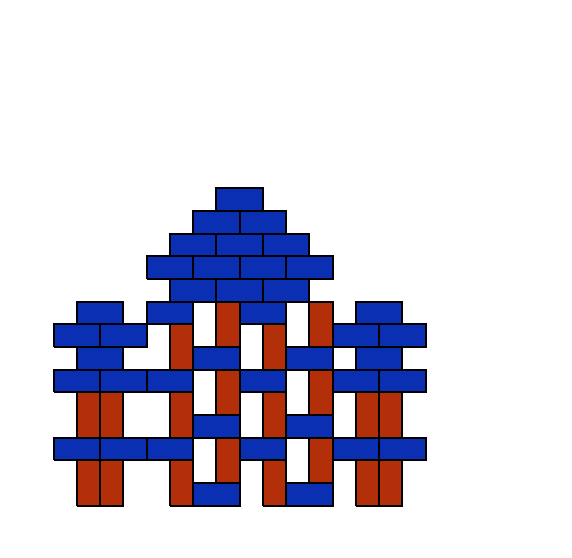

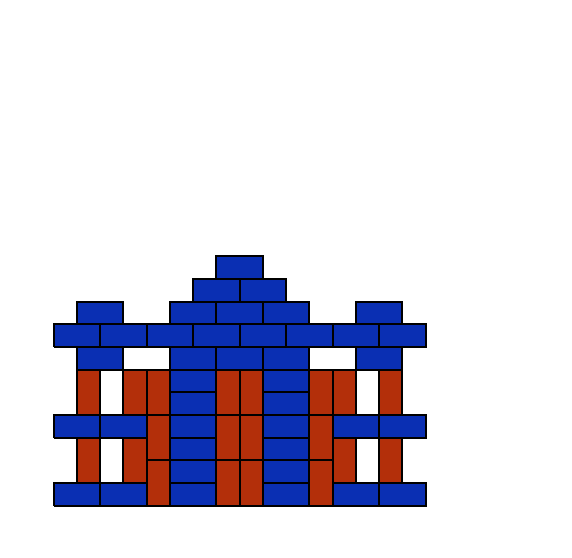

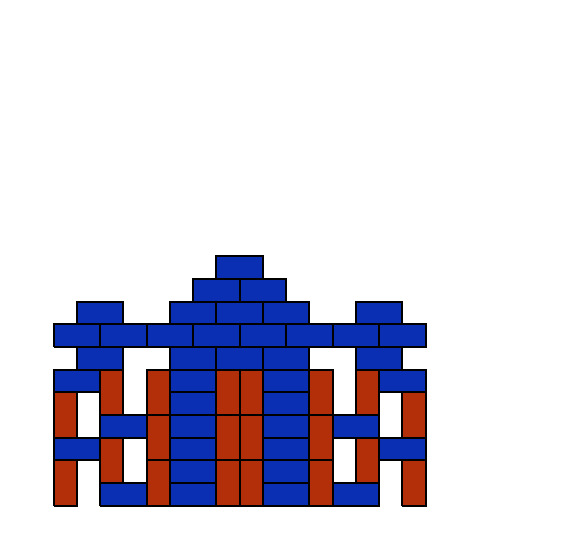

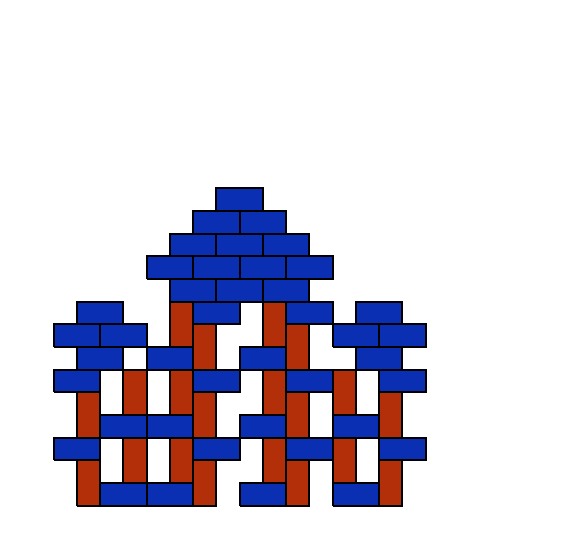

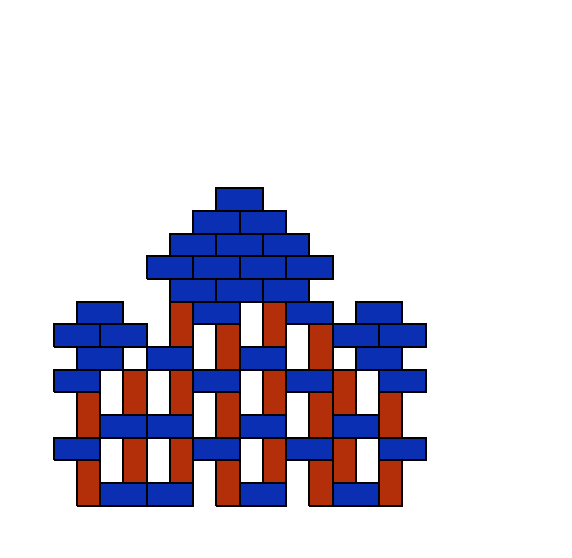

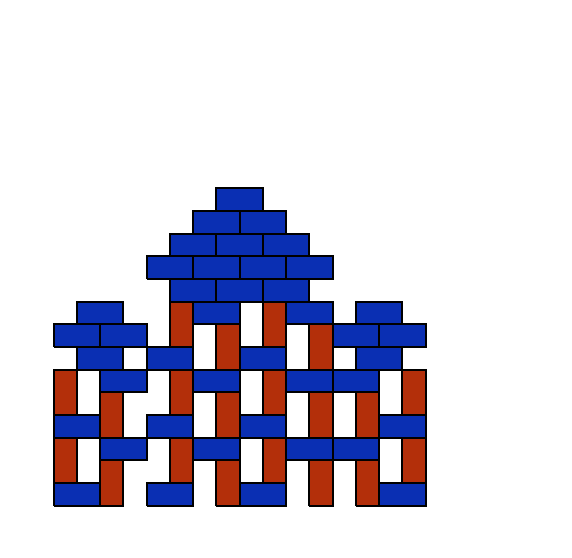

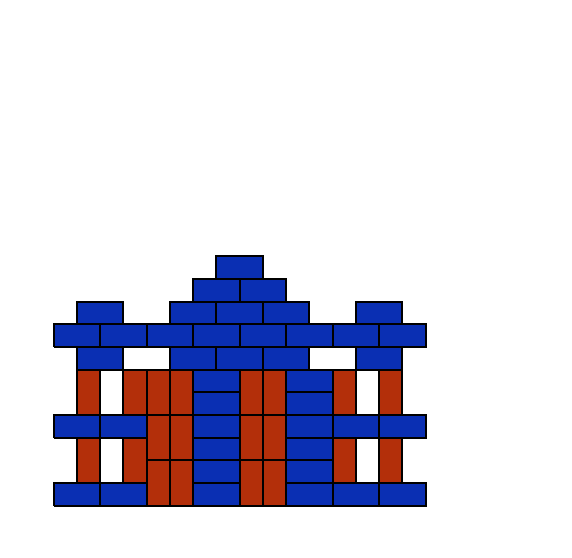

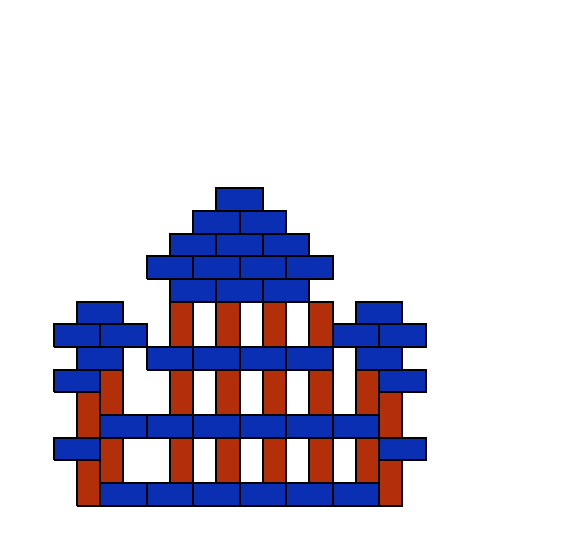

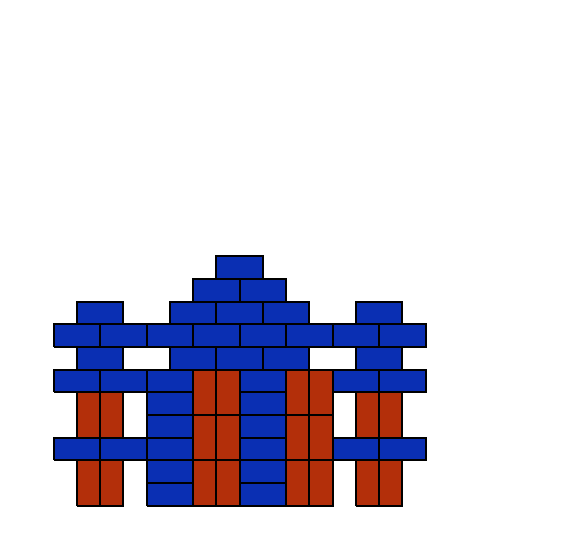

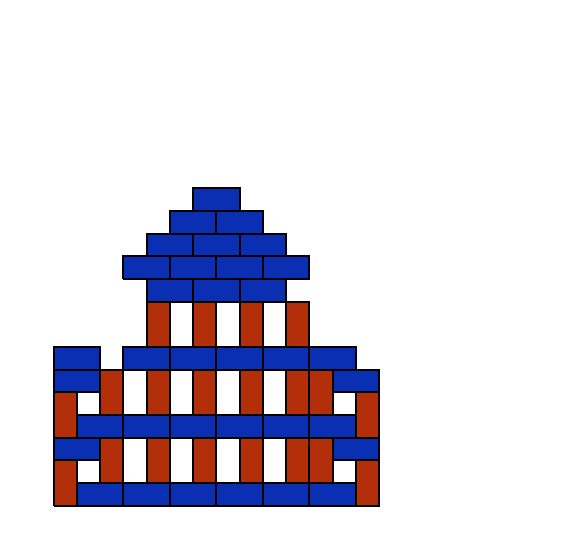

In [969]:
n_towers = 0
while n_towers < 10:

    w = new_world()

    tower = random.choice(towers[2])
    tower_width = utils.worldify(tower, world_width=20).tower_width()

    wall = random.choice(walls[2][3])
    wall_width = utils.worldify(wall, world_width=20).tower_width()

    w.place_tower_relative(tower)
    w.place_tower(domes[int(tower_width/2)])
    w.place_tower_relative(wall)
    w.place_tower(domes[int(wall_width/2)], tower_width)
    w.place_tower_relative(tower)
    w.place_tower(domes[int(tower_width/2)],tower_width + wall_width)

    if not(w.broken):
        
        fig = utils.draw_world(w)
        n_towers += 1

### Houses

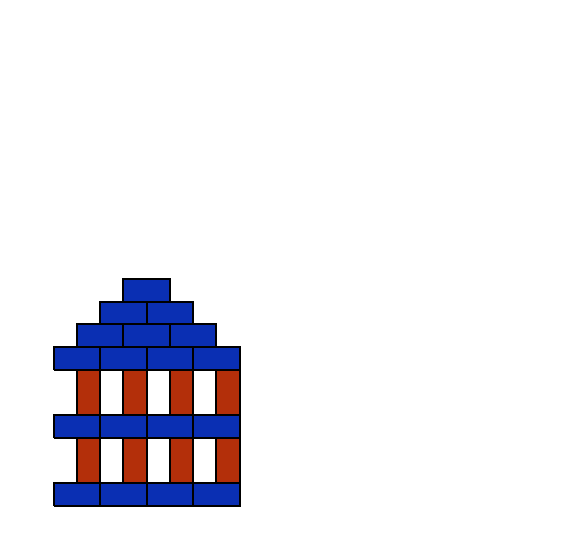

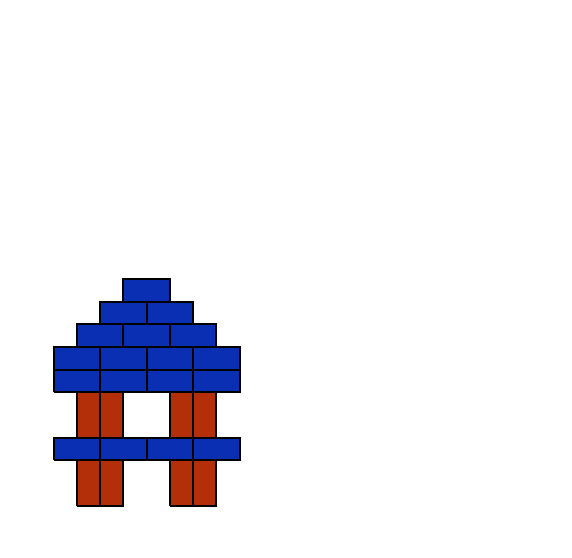

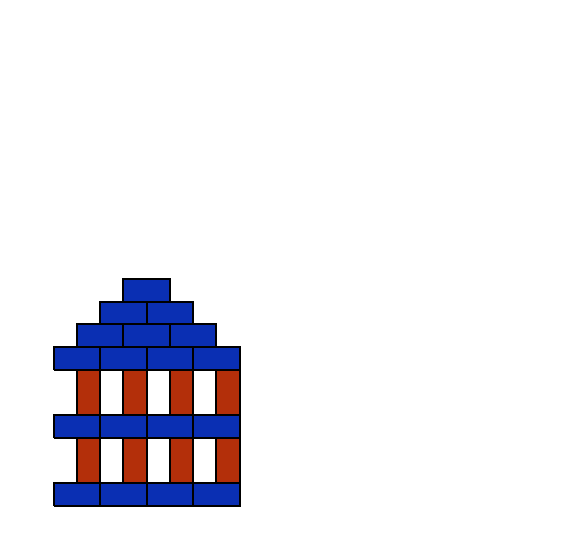

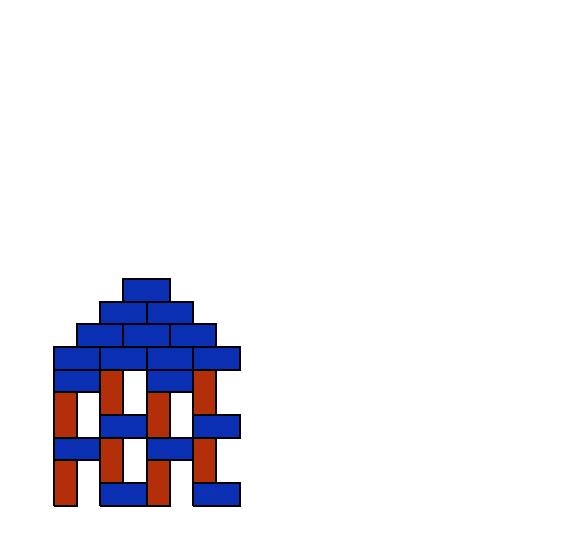

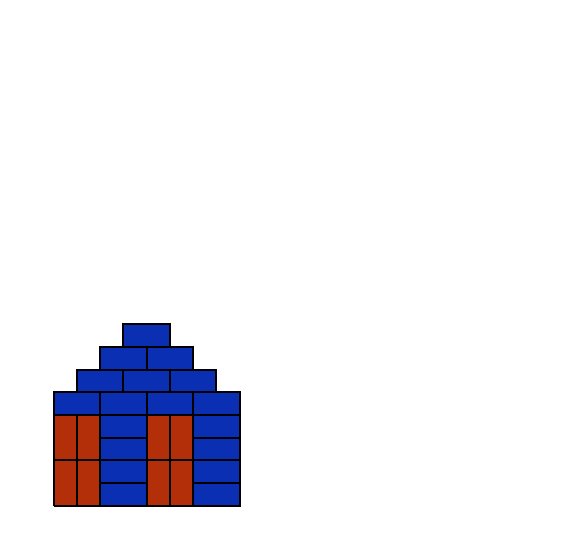

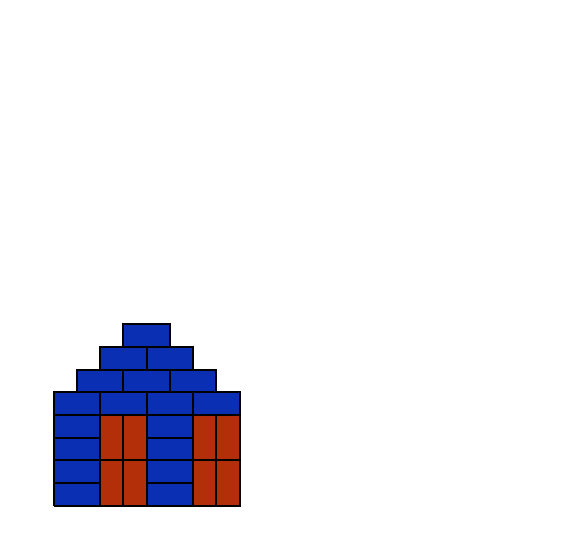

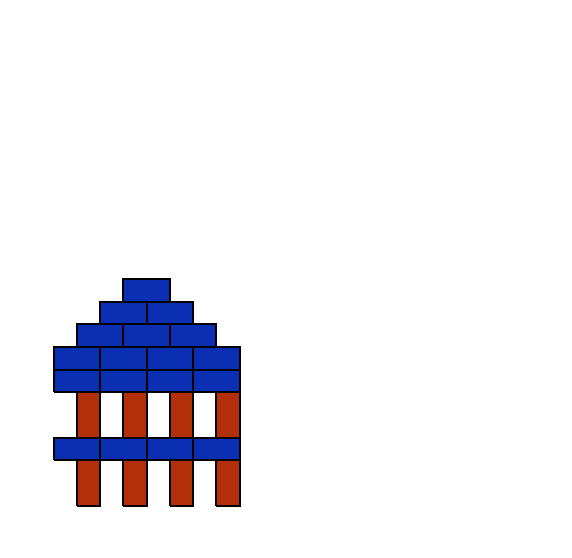

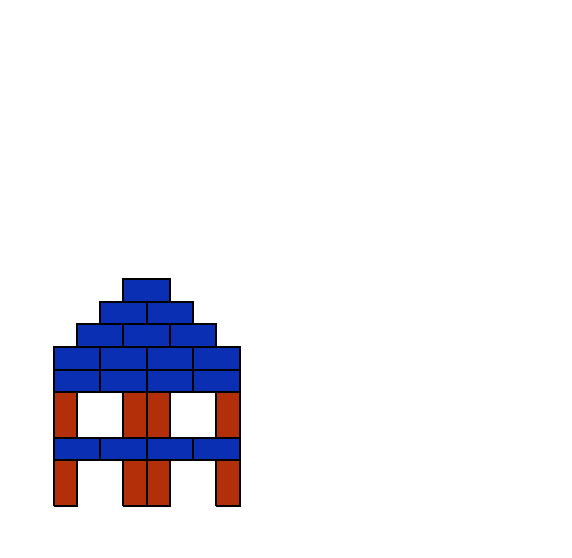

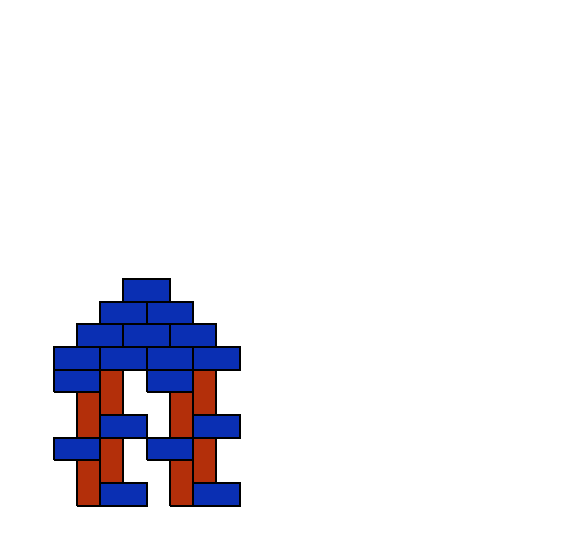

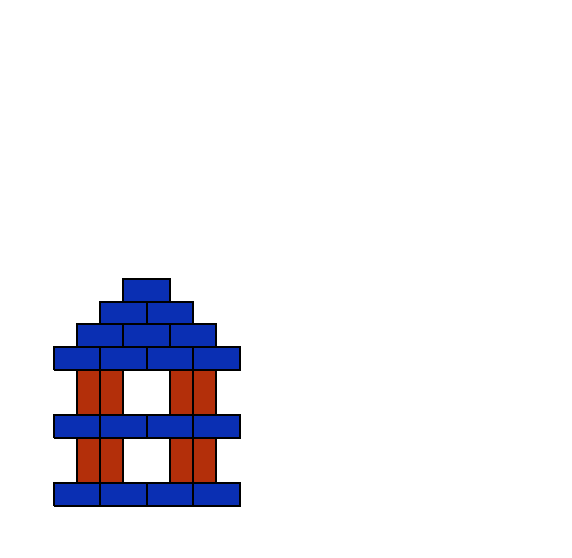

In [784]:
n_towers = 0
while n_towers < 10:

    w = new_world()

    wall = random.choice(walls[2][2])
    w.place_tower_relative(wall)
    
    roof_width = random.choice(range(int(w.tower_width()/2), int(w.tower_width()/2)+3))
    
    w.place_tower(roofs[roof_width])

    if not(w.broken):
        fig = utils.draw_world(w)
        n_towers += 1

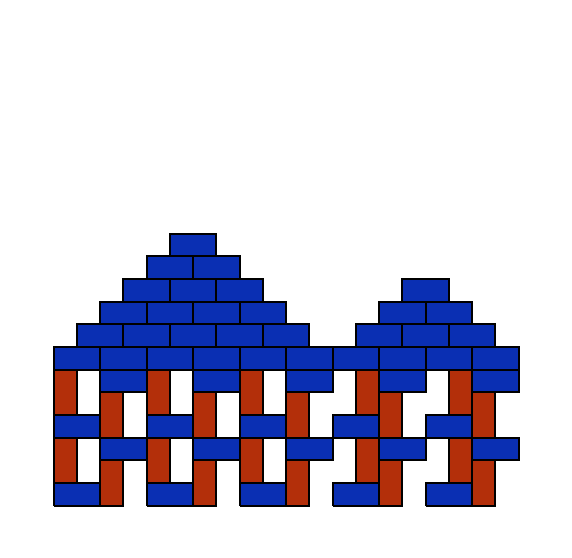

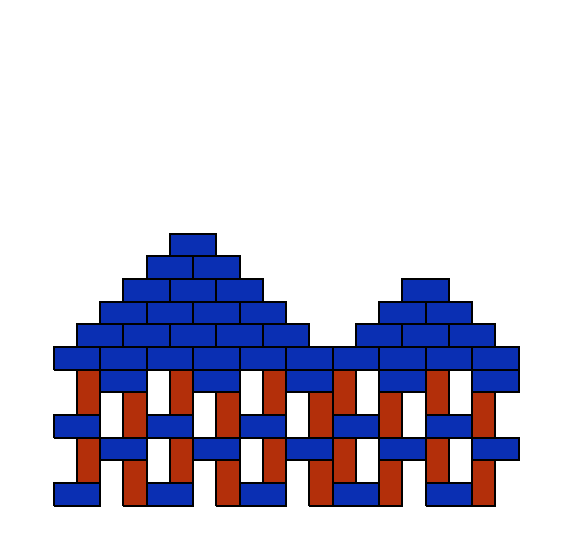

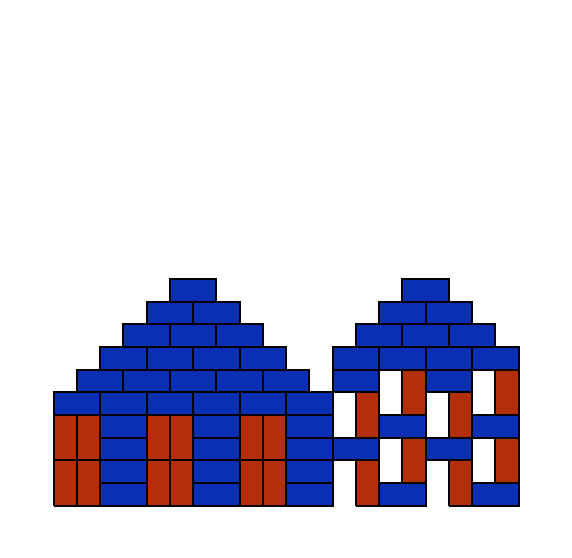

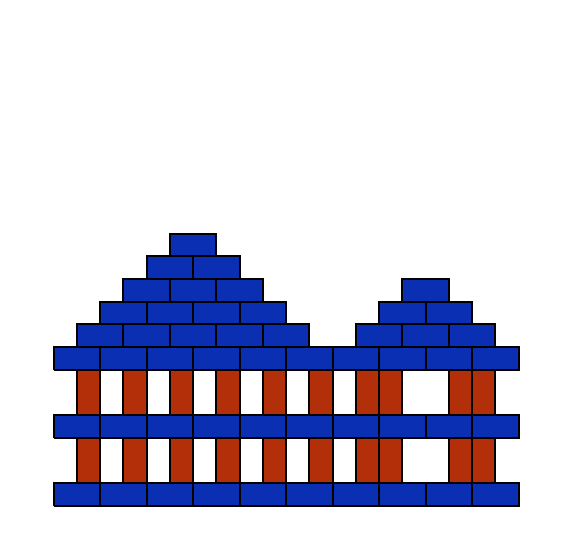

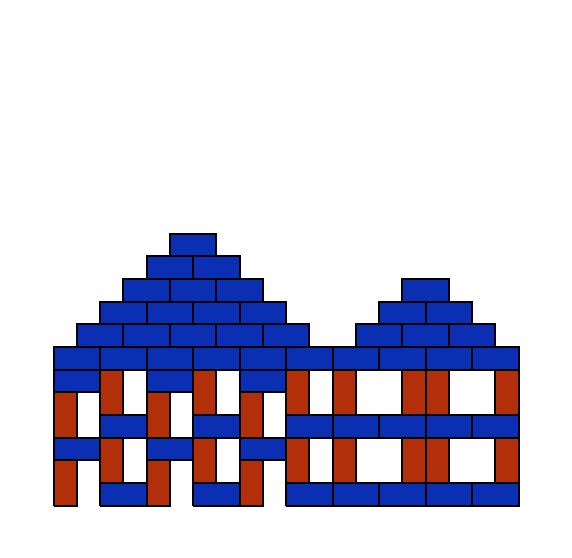

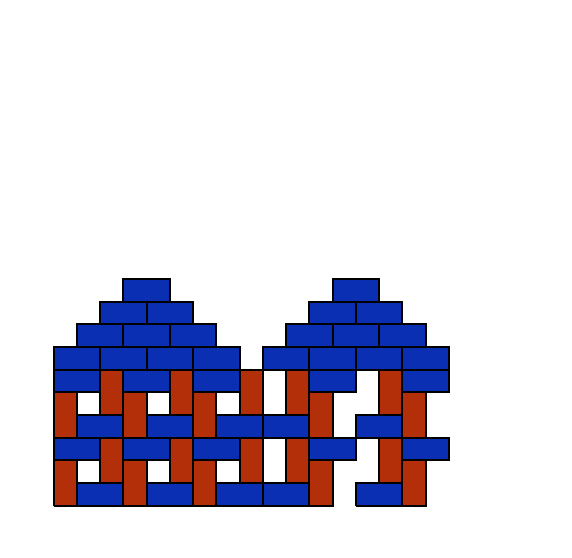

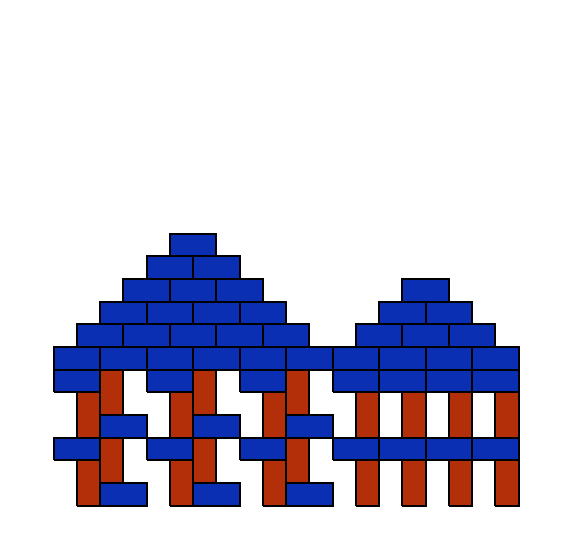

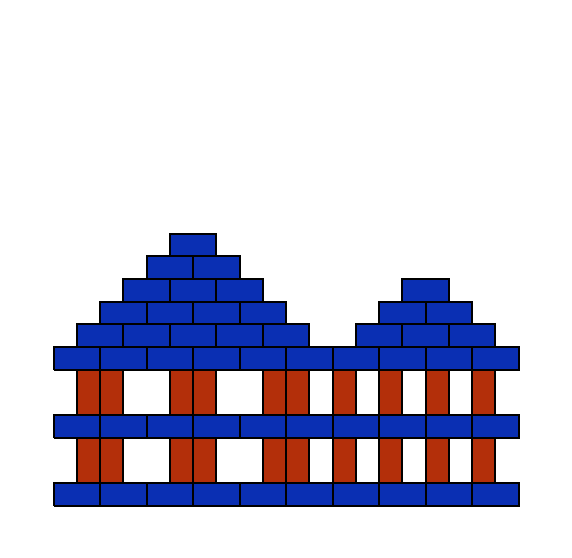

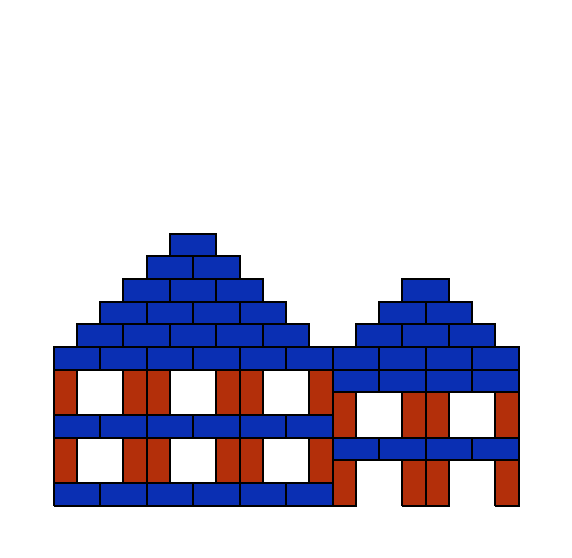

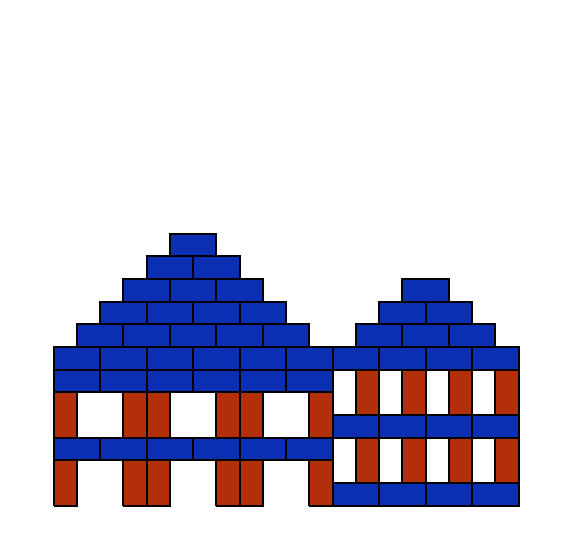

In [794]:
n_towers = 0
while n_towers < 10:

    w = new_world()

    wall_1 = random.choice(walls[3][2])
    w.place_tower_relative(wall_1)
    
    roof_1_width = int(w.tower_width()/2)
    
    roof_2_loc = w.tower_width()
    
    wall_2 = random.choice(walls[2][2])
    w.place_tower_relative(wall_2)
    
    roof_2_width = int(utils.worldify(wall_2).tower_width()/2)
    
    w.place_tower(roofs[roof_1_width])
    w.place_tower(roofs[roof_2_width], roof_2_loc)

    if True:
        fig = utils.draw_world(w)
        n_towers += 1

### Skyscrapers

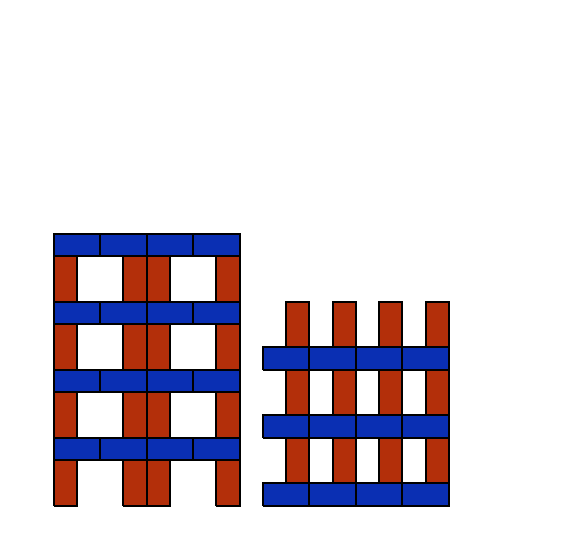

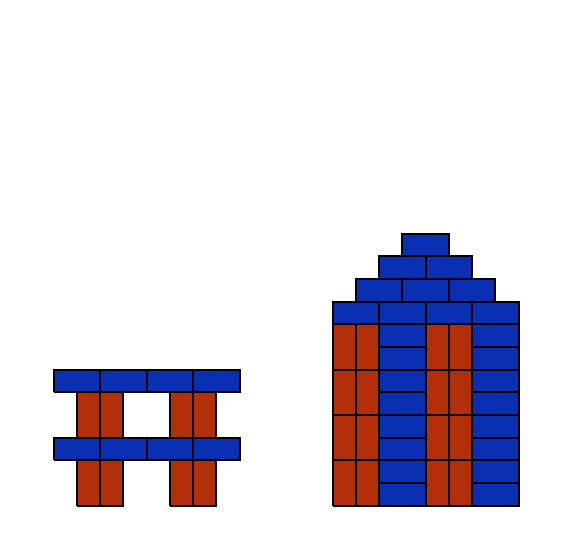

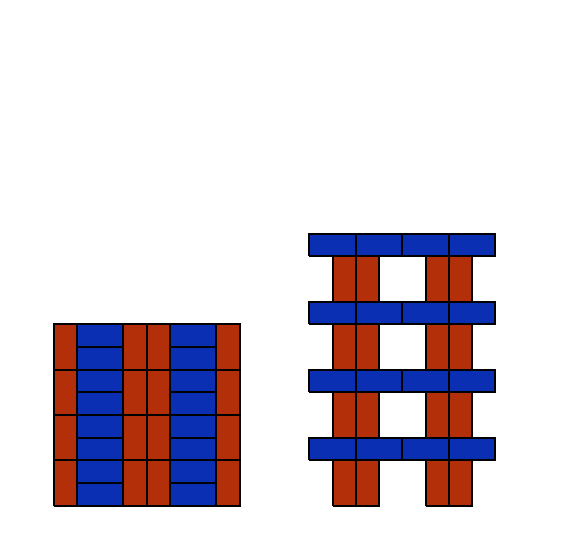

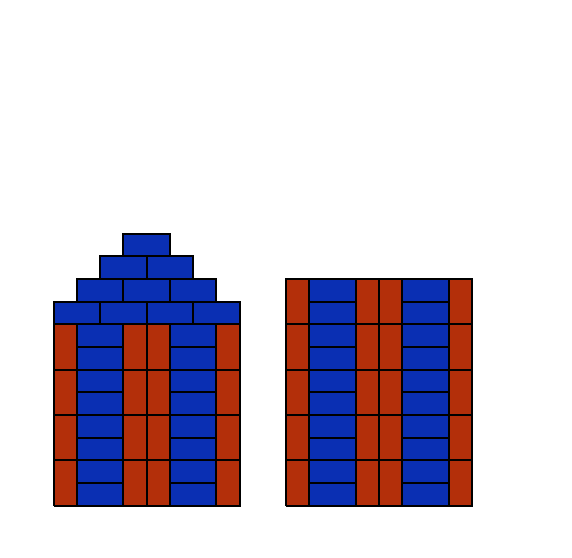

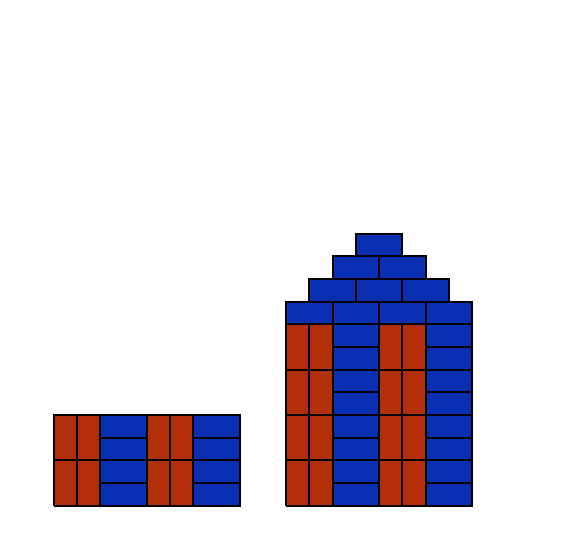

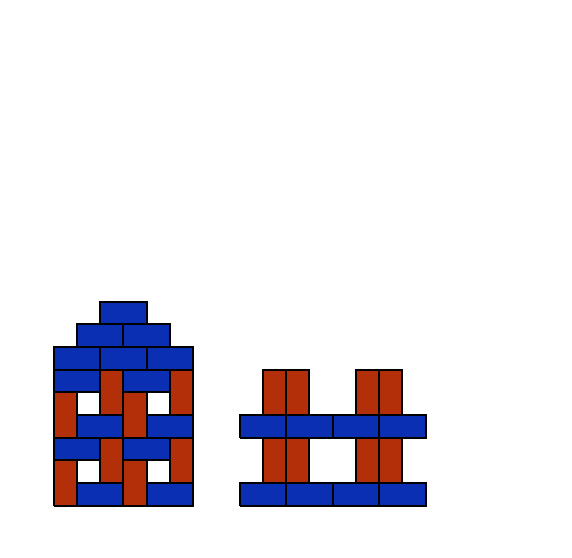

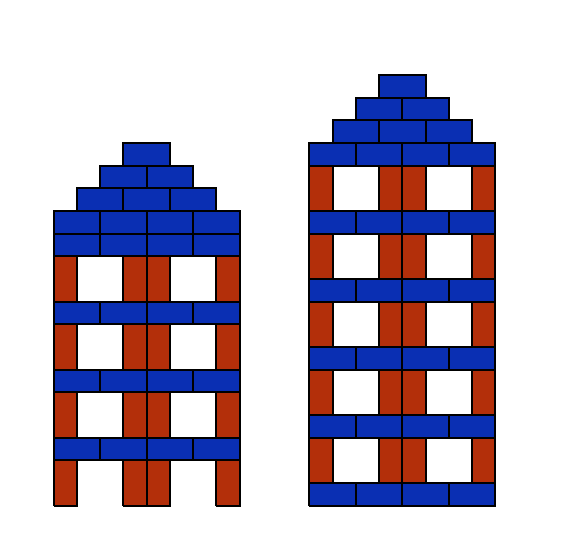

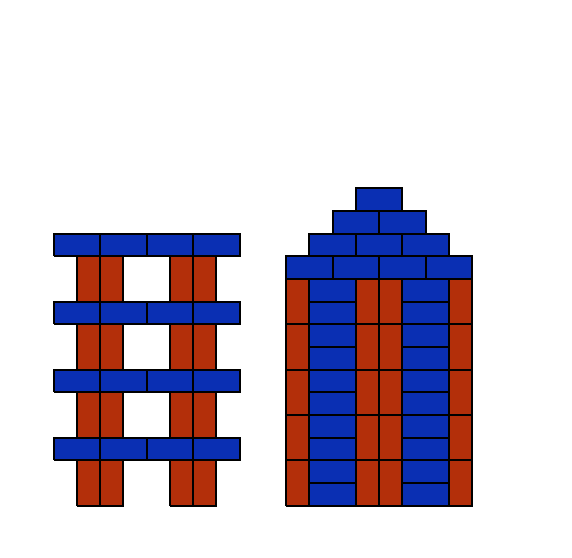

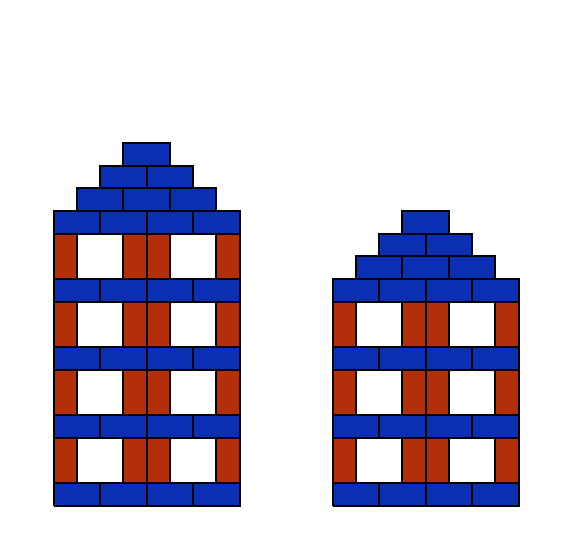

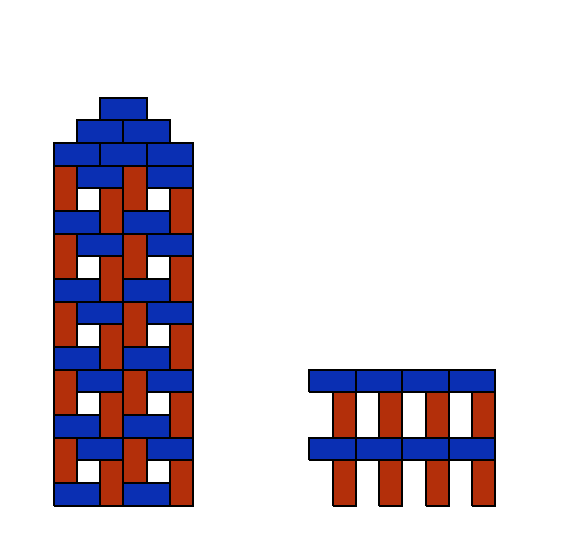

In [917]:
n_towers = 0

while n_towers < 10:
    
    
    gap = random.randint(1,6)
    h1 = random.randint(2,5)

    
    w = new_world()
    
    tower_1 = random.choice(walls[2][h1])
    
    tower_1_w = utils.worldify(tower_1, 
                               world_width=20, 
                               world_height=20)
    
    w.place_tower_relative(tower_1)
    
    tower_1_width = tower_1_w.tower_width()
    
    if random.random() < 0.7:
        roof_1_width = int(tower_1_width/2)
        w.place_tower(roofs[roof_1_width])
    
    
    h2 = random.randint(2,5)
    
    
    tower_2 = random.choice(walls[2][h2])
    
    tower_2_w = utils.worldify(tower_2, 
                               world_width=20, 
                               world_height=20)
    
    w.place_tower_relative(tower_2, diff = gap)
    
    tower_2_width = tower_2_w.tower_width()
    
    if random.random() < 0.7:
        roof_2_width = int(tower_2_width/2)
        w.place_tower(roofs[roof_2_width], tower_2_width + gap)
    
   

    if not(w.broken):
        fig = utils.draw_world(w)
        n_towers += 1

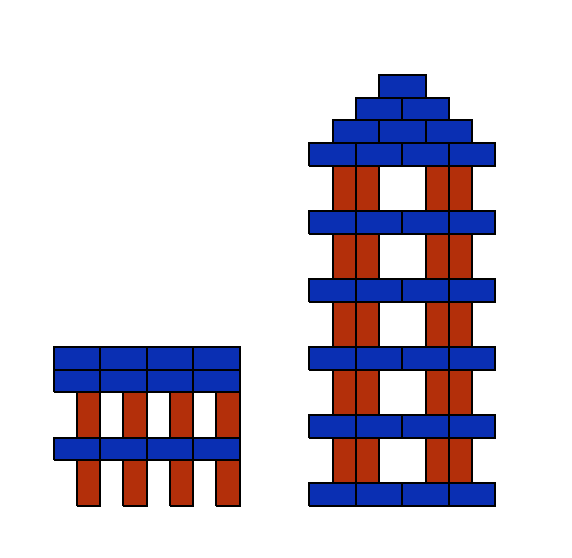

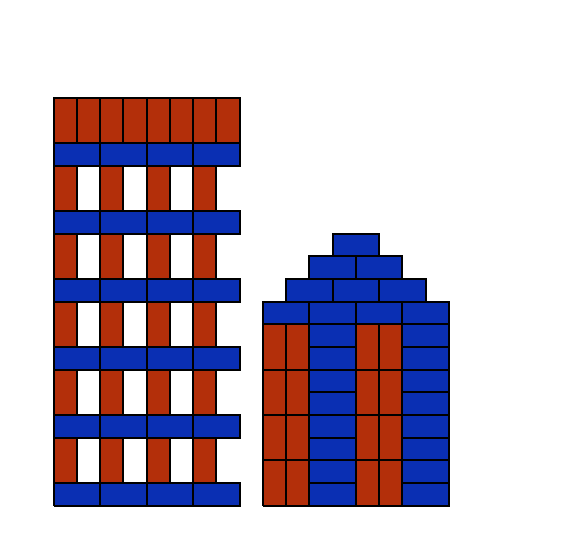

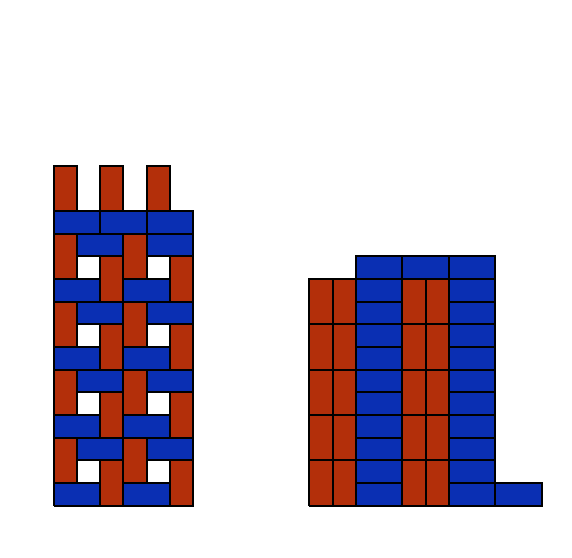

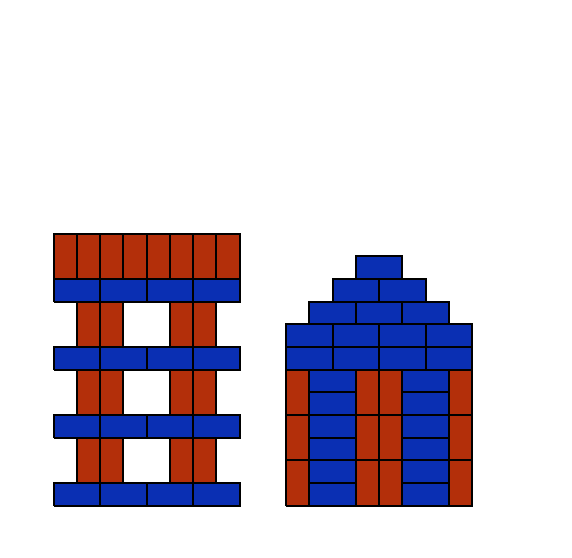

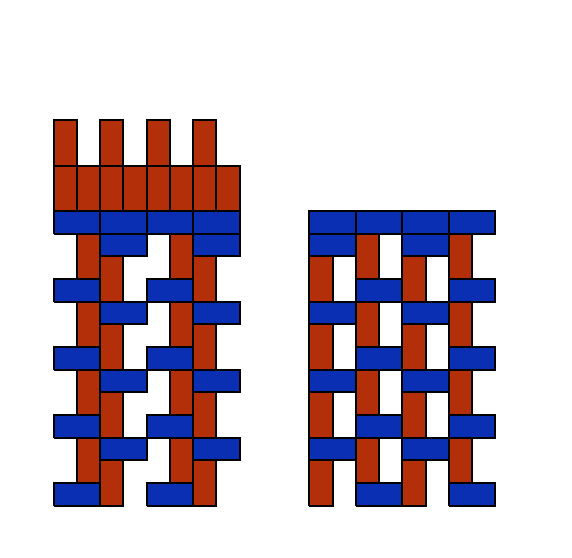

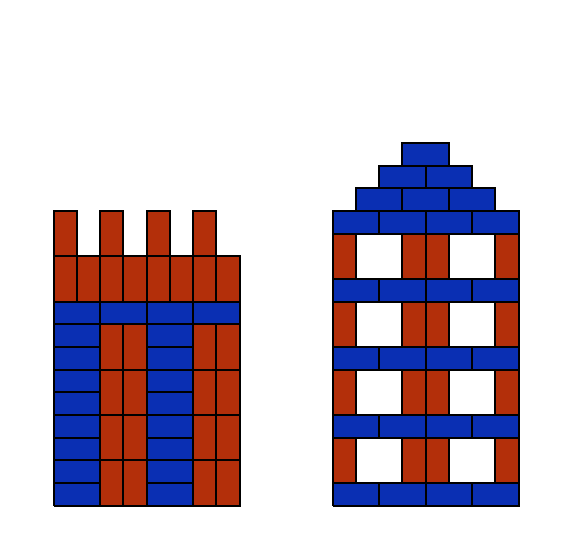

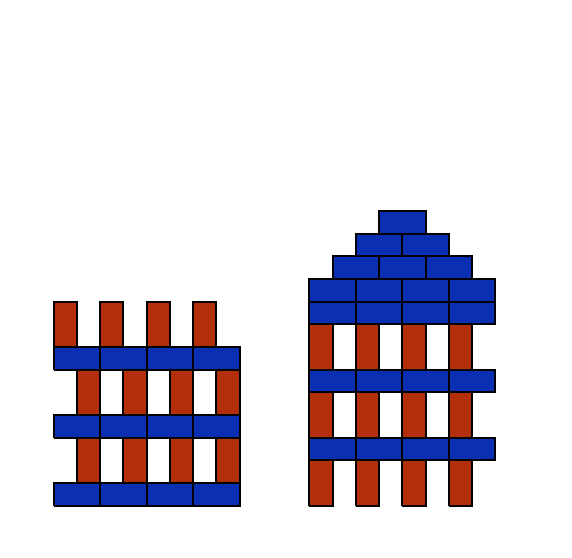

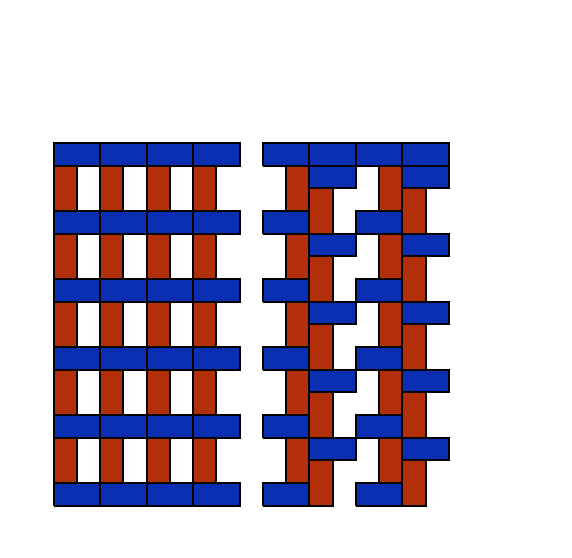

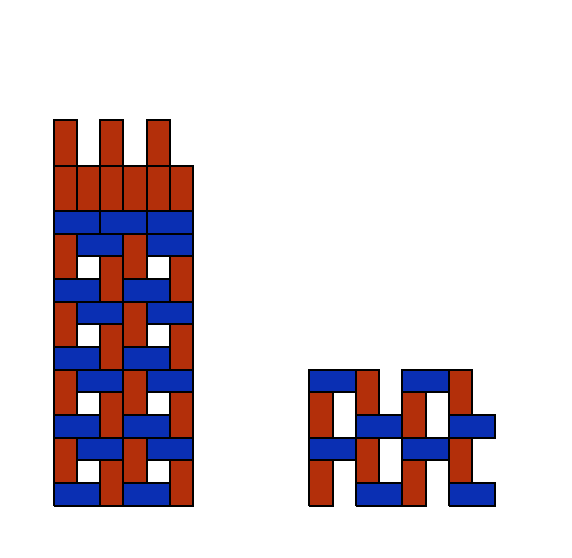

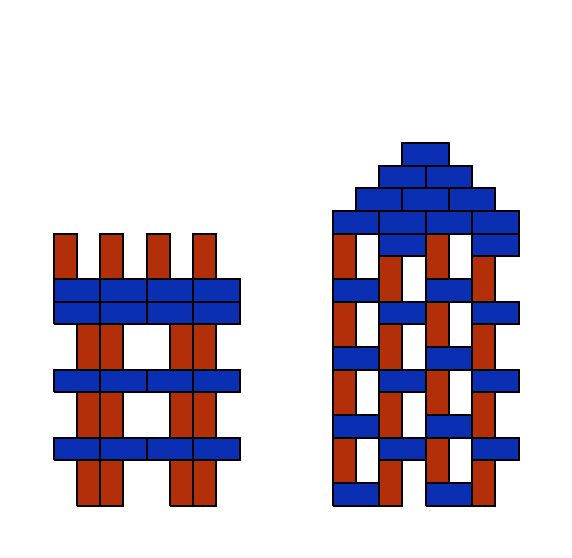

In [968]:
n_towers = 0

while n_towers < 10:
    
    
    gap = random.randint(1,6)
    h1 = random.randint(2,5)

    
    w = new_world()
    
    tower_1 = random.choice(walls[2][h1])
    
    tower_1_w = utils.worldify(tower_1, 
                               world_width=20, 
                               world_height=20)
    
    
    
    w.place_tower_relative(tower_1)
    
    tower_1_width = tower_1_w.tower_width()
    
        
    if random.random() < 1:
        horizontal_brick_layer(w, tower_1_width, x_location=0)
    
    if random.random() < 0.3:
        roof_1_width = int(tower_1_width)
#         w.place_tower(slabs[roof_1_width])
        place_slab(w, tower_1_width, x_location=0)
    
    
    if random.random() < 0.7:
        castillate(w, tower_1_width, x_location=0)
    
    
    h2 = random.randint(2,5)
    
    
    tower_2 = random.choice(walls[2][h2])
    
    tower_2_w = utils.worldify(tower_2, 
                               world_width=20, 
                               world_height=20)
    
    w.place_tower_relative(tower_2, diff = gap)
    
    tower_2_width = tower_2_w.tower_width()
    
    
    if random.random() < 0.6:
#         vertical_brick_layer(w, tower_1_width, x_location= tower_2_width + gap)
        horizontal_brick_layer(w, tower_2_width, x_location = tower_2_width + gap)
#         w.place_tower(slabs[tower_2_width], tower_2_width + gap)
    
    if random.random() < .6:
        roof_2_width = int(tower_2_width/2)
        w.place_tower(roofs[roof_2_width], tower_2_width + gap)
        


    if not(w.broken):
        fig = utils.draw_world(w)
        n_towers += 1

### Bridges

In [1052]:
HORIZONTAL = [{'x': 0, 
            'y': 0, 
            'height': 1, 
            'width': 2}]

VERTICAL = [{'x': 0, 
            'y': 0, 
            'height': 2, 
            'width': 1}]

ARCH = [{'x': 0, 
            'y': 0, 
            'height': 2, 
            'width': 1},
            {'x': 0, 
            'y': 2, 
            'height': 1, 
            'width': 2},
            {'x': 3, 
            'y': 0, 
            'height': 2, 
            'width': 1},
            {'x': 2, 
            'y': 2, 
            'height': 1, 
            'width': 2},
           ]


def vertical_line(w, height, x_location = 0, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    
    for brick in range(0, int(height/2)):
        w.place_tower(tile, x_location = x_location)
            

    return w

def arch(w, n_layers, width=4, x_location = 0):

    
#     stack(w, ARCH, n=n_layers, x_location=0)

    if width==4:

        pillars(w, n_layers, width=width, x_location = x_location)
        w.place_tower(HORIZONTAL, x_location = x_location)
        w.place_tower(HORIZONTAL, x_location = x_location+2)
        
    elif width==6:
        
        pillars(w, n_layers, width=width, x_location = x_location)
        w.place_tower(HORIZONTAL, x_location = x_location)
        w.place_tower(HORIZONTAL, x_location = x_location+4)
        w.place_tower(HORIZONTAL, x_location = x_location+1)
        w.place_tower(HORIZONTAL, x_location = x_location+3)


def pillars(w, n_layers, width=4, x_location = 0):
    if width==4:

        vertical_line(w, n_layers*2, x_location = x_location)
        vertical_line(w, n_layers*2, x_location = x_location+3)
        
    elif width==6:
        
        vertical_line(w, n_layers*2, x_location = x_location)
        vertical_line(w, n_layers*2, x_location = x_location+5)
    
        
def viaduct(w):
    horizontal_brick_layer(w, w.tower_width())
    
    

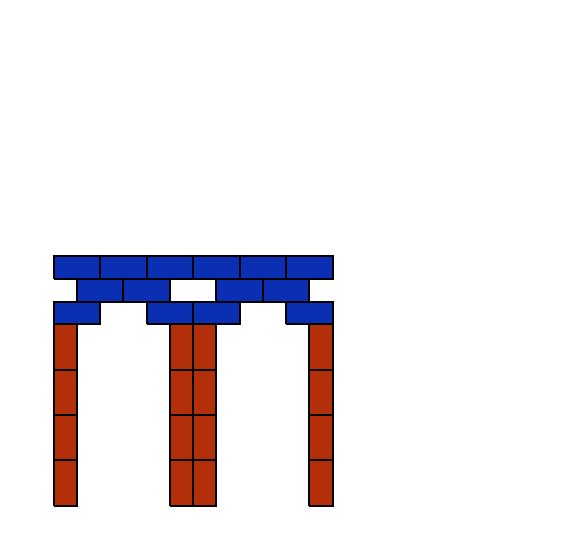

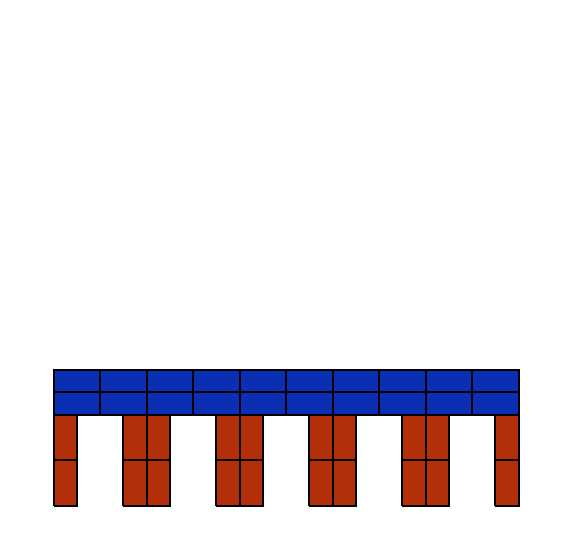

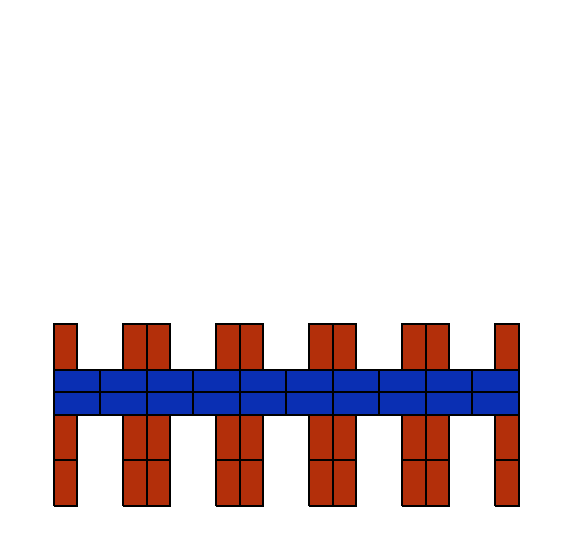

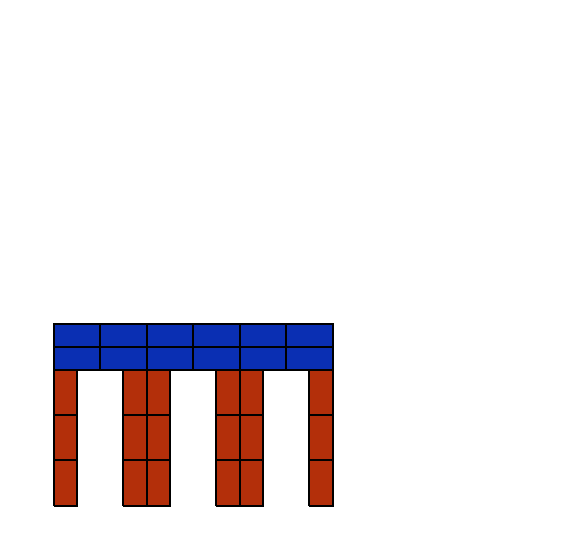

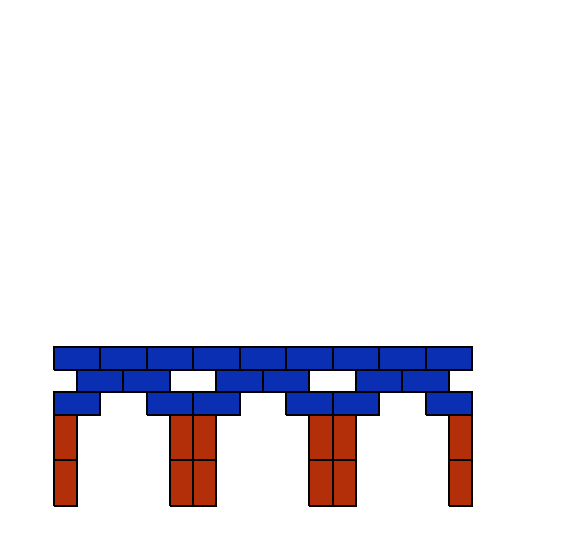

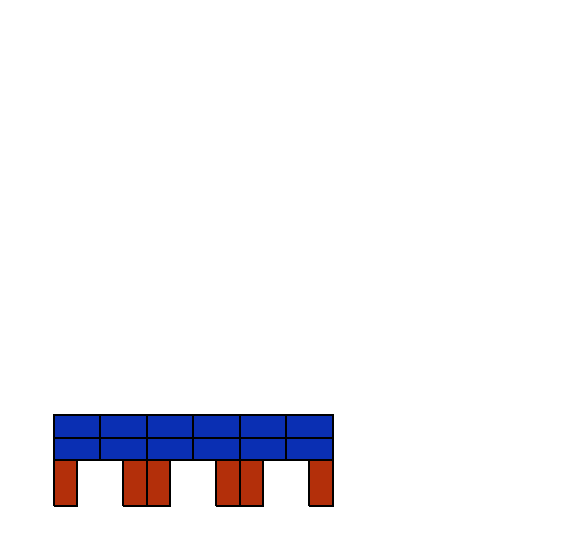

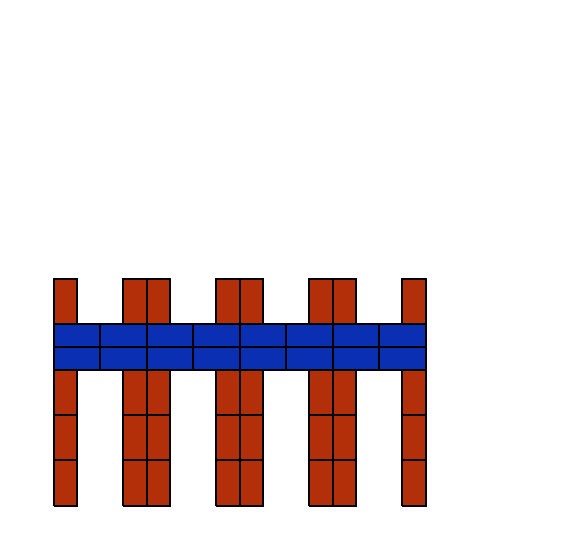

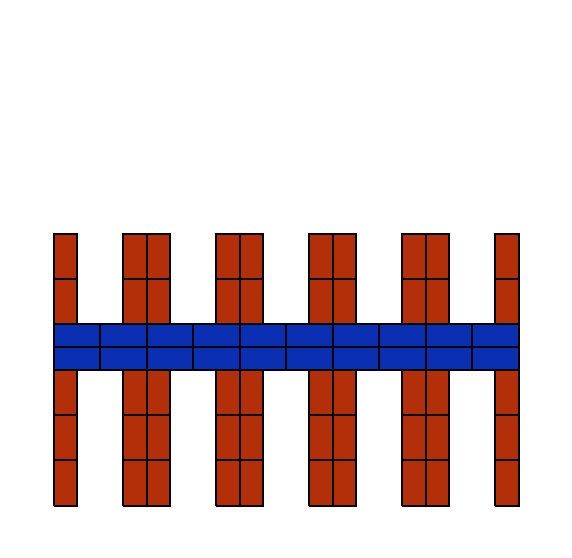

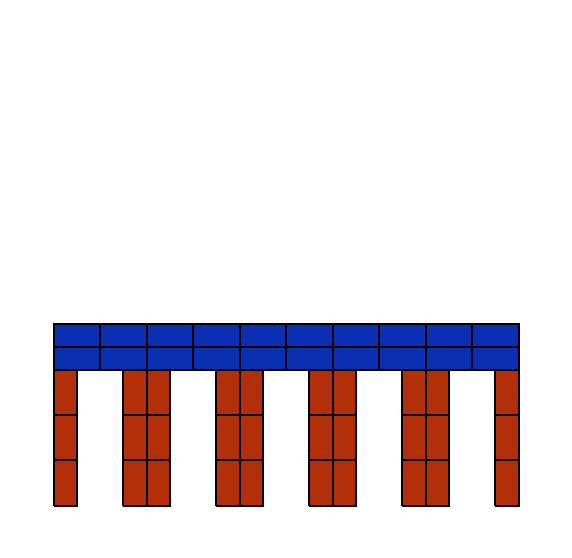

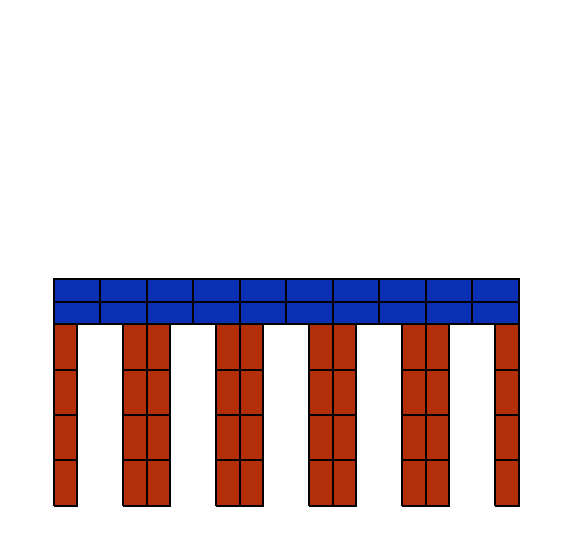

In [1065]:
n_towers = 0

while n_towers < 10:
    
    n_arch = random.randint(2,5)
    
    w = new_world()
    
    arch_width = random.choice([4,6])
    arch_layers = random.choice([1,2,3,4])
    
    a_w = new_world()
    arch(a_w, arch_layers, width=arch_width)
    
    for a in range(0, n_arch):
        
        w.place_tower_relative(a_w.get_block_dict()['blocks'])
        
    viaduct(w)
    
    ## pillars
    n_pillar_layers = random.choice(range(0,arch_layers))
    p_w = new_world()
    pillars(p_w, n_pillar_layers, width=arch_width)
    
    if n_pillar_layers > 0:
        for p in range(0, n_arch):
            w.place_tower(p_w.get_block_dict()['blocks'], p*arch_width)

    
    if not(w.broken):
        fig = utils.draw_world(w)
        n_towers += 1
        

In [ ]:
[utils.draw_world(utils.worldify(w, world_height=20,world_width=20)) for w in walls[3][2]]

# Enumeration

## General Setup

Part abstractions:

#### Dreamcoder-like towers
walls, 
bridge-arch, 
pyramid



#### Skyscrapers
4-block towers (how many in dataset?)
roofs (pyramid, thin flat, thick flat),

#### Houses
windows, 
doors, 
roofs


#### Castles
4-block towers (how many in dataset?), 
walls, 
turrets, 
roofs


#### Bridges
bridge-arch, 
turrets


#### Skylines
skyscrapers, 
houses, 
castles, 
bridges



Tasks:
- Pick specific elements to repeat in houses, skyscrapers, castle walls, turrets. Everything should be nameable.
- 


In [5]:
# hardcoded components

HORIZONTAL = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}]

VERTICAL = [{'x': 0, 'y': 0, 'height': 2, 'width': 1}]

ARCH = [{'x': 0, 'y': 0, 'height': 2, 'width': 1},
        {'x': 0, 'y': 2, 'height': 1, 'width': 2},
        {'x': 3, 'y': 0, 'height': 2, 'width': 1},
        {'x': 2, 'y': 2, 'height': 1, 'width': 2},]

SMALL_WINDOW = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 0, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 3, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 0, 'y': 3, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 3, 'height': 1, 'width': 2}]

BIG_WINDOW = [{'x': 0, 'y': 0, 'height': 1, 'width': 2},
               {'x': 2, 'y': 0, 'height': 1, 'width': 2},
               {'x': 0, 'y': 1, 'height': 2, 'width': 1},
               {'x': 0, 'y': 3, 'height': 2, 'width': 1},
               {'x': 3, 'y': 1, 'height': 2, 'width': 1},
               {'x': 3, 'y': 3, 'height': 2, 'width': 1},
               {'x': 0, 'y': 5, 'height': 1, 'width': 2},
               {'x': 2, 'y': 5, 'height': 1, 'width': 2}]

DOOR = [{'x': 0, 'y': 0, 'height': 2, 'width': 1},
        {'x': 0, 'y': 2, 'height': 2, 'width': 1}, 
        {'x': 3, 'y': 0, 'height': 2, 'width': 1}, 
        {'x': 3, 'y': 2, 'height': 2, 'width': 1}]

BRICKS = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 0, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 3, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 1, 'y': 1, 'height': 1, 'width': 2}, 
          {'x': 1, 'y': 2, 'height': 1, 'width': 2}, 
          {'x': 0, 'y': 3, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 3, 'height': 1, 'width': 2}]

def window(w, x_location=0):
    w.place_tower(SMALL_WINDOW, x_location = x_location)
    
def door(w, x_location=0):
    w.place_tower(DOOR, x_location = x_location)

def bricks(w, x_location=0):
    w.place_tower(BRICKS, x_location = x_location)
    

In [6]:
BRIDGE_TOWER_1 = [{'x': 1, 'y': 0, 'height': 2, 'width': 1}, 
                  {'x': 0, 'y': 0, 'height': 2, 'width': 1}, 
                  {'x': 3, 'y': 0, 'height': 2, 'width': 1}, 
                  {'x': 2, 'y': 0, 'height': 2, 'width': 1}]

BRIDGE_TOWER_2 = [{'x': 2, 'y': 0, 'height': 1, 'width': 2}, 
                  {'x': 0, 'y': 0, 'height': 1, 'width': 2}]


BRIDGE_TOWER_3 = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
                  {'x': 2, 'y': 0, 'height': 1, 'width': 2},
                  {'x': 1, 'y': 1, 'height': 1, 'width': 2}]

BRIDGE_TOWERS = {
    'BRIDGE_TOWER_1': BRIDGE_TOWER_1,
    'BRIDGE_TOWER_2': BRIDGE_TOWER_2,
    'BRIDGE_TOWER_3': BRIDGE_TOWER_3,
    'none': None
}

In [7]:
ARCH_W4 = [{'x': 0, 'y': 0, 'height': 2, 'width': 1}, 
           {'x': 3, 'y': 0, 'height': 2, 'width': 1}, 
           {'x': 0, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 2, 'y': 2, 'height': 1, 'width': 2}]

ARCH_W6 = [{'x': 0, 'y': 0, 'height': 1, 'width': 2},
           {'x': 1, 'y': 1, 'height': 1, 'width': 2}, 
           {'x': 4, 'y': 0, 'height': 1, 'width': 2}, 
           {'x': 3, 'y': 1, 'height': 1, 'width': 2}, 
           {'x': 0, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 2, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 4, 'y': 2, 'height': 1, 'width': 2}]

ARCH_W8 = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
           {'x': 6, 'y': 0, 'height': 1, 'width': 2},
           {'x': 1, 'y': 1, 'height': 1, 'width': 2}, 
           {'x': 5, 'y': 1, 'height': 1, 'width': 2}, 
           {'x': 2, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 4, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 0, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 6, 'y': 2, 'height': 1, 'width': 2}]

ARCHES_EQUAL_HEIGHTS = {4: ARCH_W4,
                        6: ARCH_W6, 
                        8: ARCH_W8}

In [8]:
def vertical_line(w, height, x_location = 0, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    
    for brick in range(0, int(height/2)):
        w.place_tower(tile, x_location = x_location)
            
    return w

def bridge_arch(w, n_layers, width=4, x_location = 0):

    
#     stack(w, ARCH, n=n_layers, x_location=0)
    pillars(w, n_layers, width=width, x_location = x_location)

    if width==4:
        
        w.place_tower(HORIZONTAL, x_location = x_location)
        w.place_tower(HORIZONTAL, x_location = x_location+2)
        
    elif width==6:

        w.place_tower(HORIZONTAL, x_location = x_location)
        w.place_tower(HORIZONTAL, x_location = x_location+4)
        w.place_tower(HORIZONTAL, x_location = x_location+1)
        w.place_tower(HORIZONTAL, x_location = x_location+3)
        
    elif width==8:

        w.place_tower(HORIZONTAL, x_location = x_location)
        w.place_tower(HORIZONTAL, x_location = x_location+1)
        w.place_tower(HORIZONTAL, x_location = x_location+2)
        w.place_tower(HORIZONTAL, x_location = x_location+6)
        w.place_tower(HORIZONTAL, x_location = x_location+5)
        w.place_tower(HORIZONTAL, x_location = x_location+4)
        w.place_tower(VERTICAL, x_location = x_location)
        w.place_tower(VERTICAL, x_location = x_location+7)

def pillars(w, n_layers, width=4, x_location = 0):
    
    if width==4:
        vertical_line(w, n_layers*2, x_location = x_location)
        vertical_line(w, n_layers*2, x_location = x_location+3)
        
    elif width==6:
        vertical_line(w, n_layers*2, x_location = x_location)
        vertical_line(w, n_layers*2, x_location = x_location+5)
        
    if width==8:
        vertical_line(w, n_layers*2, x_location = x_location)
        vertical_line(w, n_layers*2, x_location = x_location+7)
    
        
def viaduct(w):
    horizontal_brick_layer(w, w.tower_width())
    
    

In [9]:
# 4-block components

# Get wall bricks
wall_bricks_tmp = list(df_towers[(df_towers.two_h_two_v) &
                              (df_towers.n_blocks == 4) & 
                              (df_towers.tower_width <= 4) & 
                              (df_towers.tower_height == 3)]['stim'])

# filter out ones that can't be stacked on top of each other
wall_bricks = [i for i in wall_bricks_tmp if not stack(new_world(), i, 5).broken]

wall_bricks.append(SMALL_WINDOW)
wall_bricks.append(BIG_WINDOW)


# # Get tower levels
# tower_levels_tmp = list(df_towers[(df_towers.two_h_two_v) &
#                               (df_towers.n_blocks == 4) & 
#                               (df_towers.tower_width <= 4) & 
#                               (df_towers.tower_height == 3)]['stim'])

# # filter out ones that can't be stacked on top of each other
# tower_levels = [i for i in tower_levels_tmp if not stack(new_world(), i, 5).broken]

NameError: name 'df_towers' is not defined

In [10]:
# manually specify units that can be composed to make walls, towers, and turrets

MANUAL_BRICK_SQUARE = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'x': 2, 'y': 0, 'height': 2, 'width': 1}, {'x': 0, 'y': 1, 'height': 2, 'width': 1}, {'x': 1, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_BIRD = [{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'x': 2, 'y': 0, 'height': 1, 'width': 2}, {'x': 2, 'y': 1, 'height': 2, 'width': 1}, {'x': 0, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_ARCH = [{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'x': 3, 'y': 0, 'height': 2, 'width': 1}, {'x': 0, 'y': 2, 'height': 1, 'width': 2}, {'x': 2, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_TSHIRT = [{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'x': 2, 'y': 0, 'height': 2, 'width': 1}, {'x': 0, 'y': 2, 'height': 1, 'width': 2}, {'x': 2, 'y': 2, 'height': 1, 'width': 2}] 

MANUAL_BRICK_SWAN = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'x': 2, 'y': 0, 'height': 2, 'width': 1}, {'x': 0, 'y': 1, 'height': 2, 'width': 1}, {'x': 2, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_PEGODA = [{'x': 1, 'y': 0, 'height': 1, 'width': 2}, {'x': 0, 'y': 1, 'height': 1, 'width': 2}, {'x': 2, 'y': 1, 'height': 1, 'width': 2}]

MANUAL_BRICK_BRICKS = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'x': 1, 'y': 1, 'height': 2, 'width': 1}, {'x': 0, 'y': 1, 'height': 2, 'width': 1}, {'x': 3, 'y': 0, 'height': 2, 'width': 1}, {'x': 2, 'y': 0, 'height': 2, 'width': 1}, {'x': 2, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_CHECKED = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'x': 0, 'y': 1, 'height': 1, 'width': 2}, {'x': 1, 'y': 2, 'height': 2, 'width': 1}, {'x': 0, 'y': 2, 'height': 2, 'width': 1}, {'x': 3, 'y': 0, 'height': 2, 'width': 1}, {'x': 2, 'y': 0, 'height': 2, 'width': 1}, {'x': 2, 'y': 2, 'height': 1, 'width': 2}, {'x': 2, 'y': 3, 'height': 1, 'width': 2}]

MANUAL_BRICK_SMALLWINDOW = SMALL_WINDOW

MANUAL_BRICK_BIGWINDOW = BIG_WINDOW

MANUAL_HOUSE_BRICKS = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 0, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 3, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 1, 'y': 1, 'height': 1, 'width': 2}, 
          {'x': 1, 'y': 2, 'height': 1, 'width': 2}, 
          {'x': 0, 'y': 3, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 3, 'height': 1, 'width': 2}]

# MANUAL_TOWER_ = 

# MANUAL_TOWER_ = 

# MANUAL_TOWER_ = 

# MANUAL_TOWER_ = 

tower_bricks_manual = [MANUAL_BRICK_SQUARE,
                      MANUAL_BRICK_BIRD,
                      MANUAL_BRICK_ARCH,
                      MANUAL_BRICK_TSHIRT,
                      MANUAL_BRICK_SWAN,
                      MANUAL_BRICK_PEGODA,
                      MANUAL_BRICK_BRICKS,
                      MANUAL_BRICK_CHECKED,
                      MANUAL_BRICK_SMALLWINDOW,
                      MANUAL_BRICK_BIGWINDOW]

In [11]:
for w in house_bricks_manual:
    utils.draw_tower(utils.worldify(w))
    print(utils.worldify(w).get_block_dict()['blocks'])

NameError: name 'house_bricks_manual' is not defined

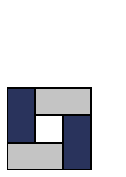

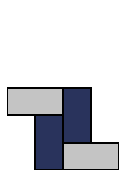

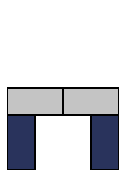

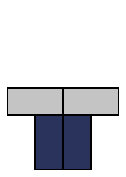

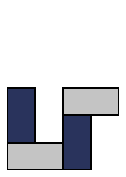

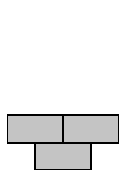

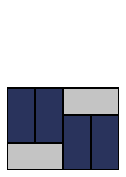

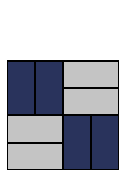

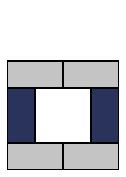

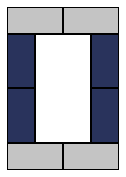

In [12]:
_ = [utils.draw_tower(utils.worldify(w)) for w in tower_bricks_manual]

In [1539]:
# # Create towers

# towers = {}

# for tower_height in range(2,6):
    
#     towers[tower_height] = []
    
#     for chunk in wall_bricks_manual:
#         w = new_world()
#         stack(w, chunk, n = tower_height, x_location = 0)
        
#         if not w.broken:
#             towers[tower_height].append(w.get_block_dict()['blocks'])
# #             utils.draw_world(w)

In [13]:
# Roofs

pyramids = {}

for roof_size in range(1,20):
    
    r = new_world()
    pyramid(r, int(roof_size/2))
    roof_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
        #utils.draw_world(wall)
    else:
        pyramids[roof_size] = roof_dict

        
domes = {}

for roof_size in range(1,20):
    
    r = new_world()
    dome(r, int(roof_size/2))
    roof_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
    else:
        domes[roof_size] = roof_dict
#         utils.draw_world(d)


slabs = {}

for width in range(1,20):
    
    r = new_world()
    slab(r, width)
    row_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
        #utils.draw_world(wall)
    else:
        slabs[width] = row_dict
      
    
flats = {}   

for width in range(1,20):
    
    r = new_world()
    horizontal_brick_layer(r, int(roof_size/2))
    row_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
        #utils.draw_world(wall)
    else:
        flats[width] = row_dict

## Enumerate Skyscrapers

#### Individual skyscrapers

In [14]:
MAX_SKYSCRAPER_HEIGHT = 4
MIN_SKYSCRAPER_HEIGHT = 1

SKYSCRAPER_ROOFS = {'pyramids': pyramids,
#                     'slabs': slabs,
                    'flats': flats}

REPEAT_OPTIONS = ['mirrored', 'repeated', 'single']

In [17]:
if True:

    skyscrapers = []
    df_skyscrapers = pd.DataFrame()

    for skyscraper_1_height in range(MIN_SKYSCRAPER_HEIGHT, MAX_SKYSCRAPER_HEIGHT+1):
        for t_1_brick in tower_bricks_manual:

            t_1_brick_width = utils.worldify(t_1_brick).tower_width()
            
            for repeat_option in REPEAT_OPTIONS:

                for _, (roof_1_name, roof_1_type) in enumerate(SKYSCRAPER_ROOFS.items()):

                    w = new_world()

                    # vertically stack bricks for tower one
                    stack(w, t_1_brick, n=skyscraper_1_height, x_location=0)
                    
                    if repeat_option == 'mirrored':
                        # repeat but mirrored
                        stack(w, mirror(t_1_brick), n=skyscraper_1_height, x_location=t_1_brick_width)
                        # add roof
                        if roof_1_name != 'none':
                            wall_width = roof_1_type[t_1_brick_width*2]
                            w.place_tower(wall_width, 0)
                            
                    elif repeat_option == 'repeated':
                        # repeat
                        stack(w, t_1_brick, n=skyscraper_1_height, x_location=t_1_brick_width)
                        
                        # add roof
                        if roof_1_name != 'none':
                            wall_width = roof_1_type[t_1_brick_width*2]
                            w.place_tower(wall_width, 0)
                            
                    elif repeat_option == 'single':
                        
                        # add roof
                        if roof_1_name != 'none':
                            wall_width = roof_1_type[t_1_brick_width]
                            w.place_tower(wall_width, 0)
                    
                    else:
                        raise Exception("No such mirror option (\"{}\") supported".format(repeat_option))


                    if not w.broken:
                        skyscrapers.append(w)
                        df_skyscrapers = df_skyscrapers.append(
                            {
                                'structure_type': 'city',
                                'blocks': w.get_block_dict()['blocks'],
                                'structure_width': w.tower_width(),
                                'structure_height': w.tower_height(),
                                'brick': t_1_brick,
                                'roof_name': roof_1_name,
                                'skyscraper_height':skyscraper_1_height,
                                'roof_size': wall_width,
                                'repeat_option': repeat_option,
                            }, ignore_index=True
                        )



In [18]:
len(skyscrapers)

185

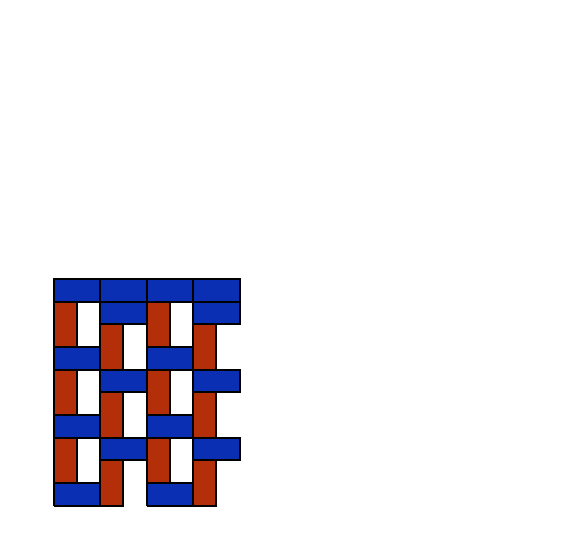

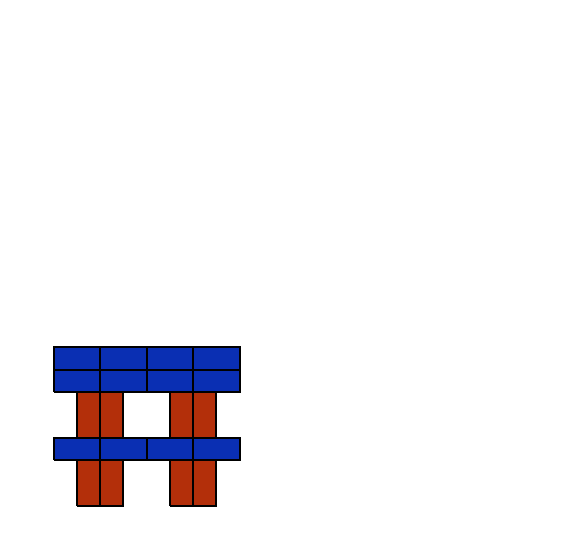

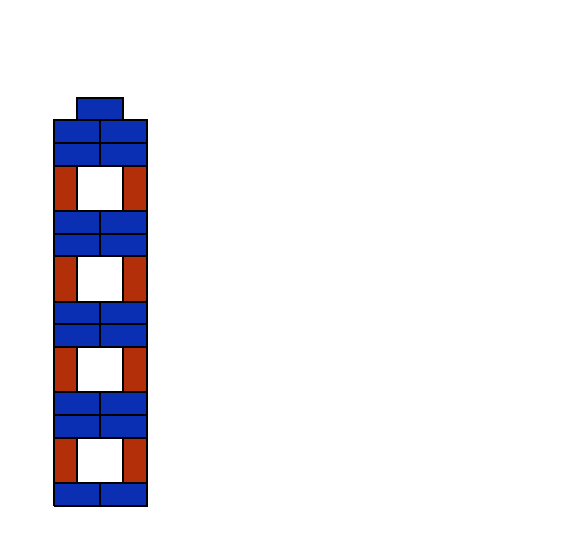

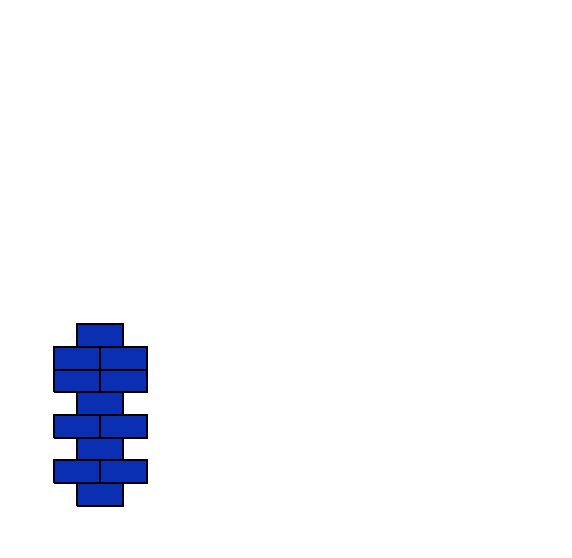

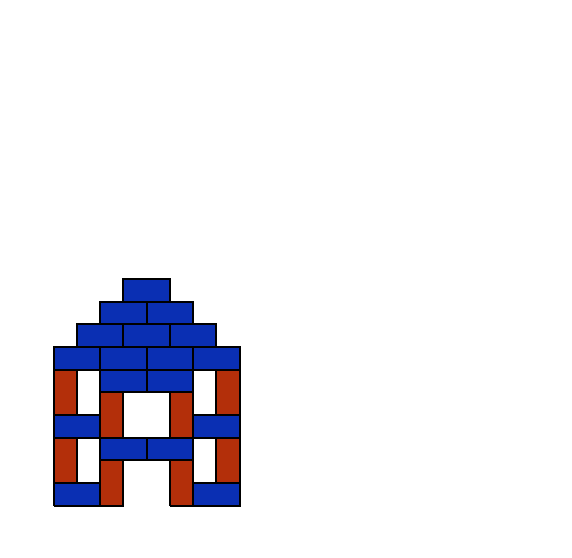

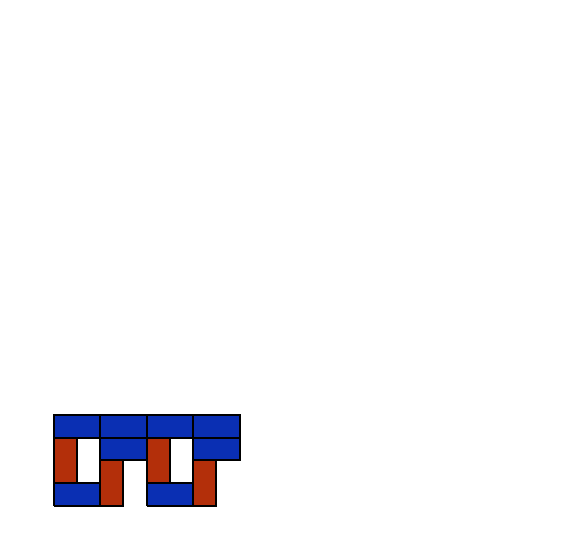

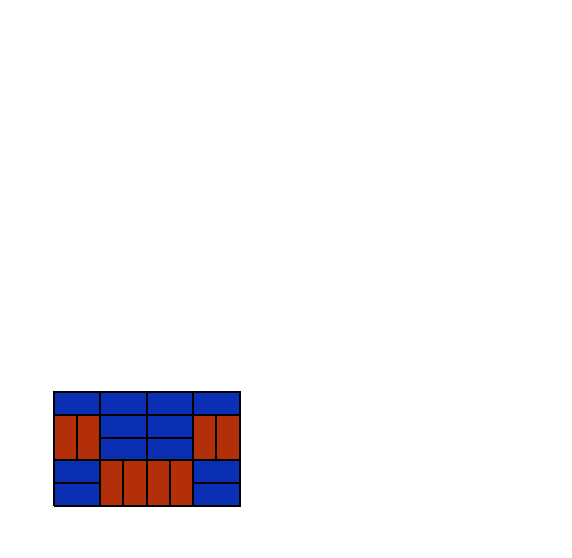

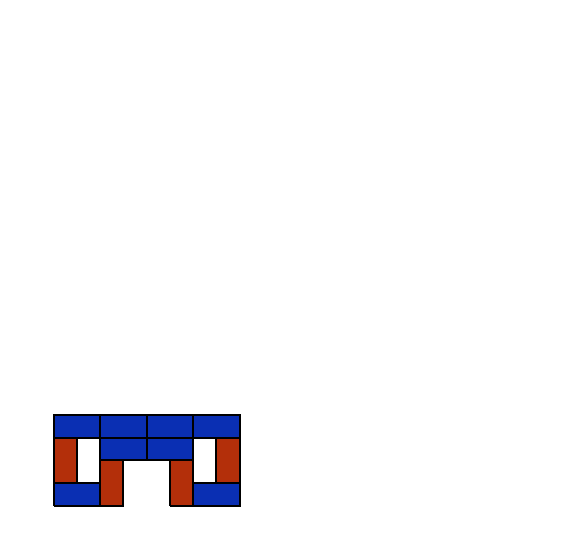

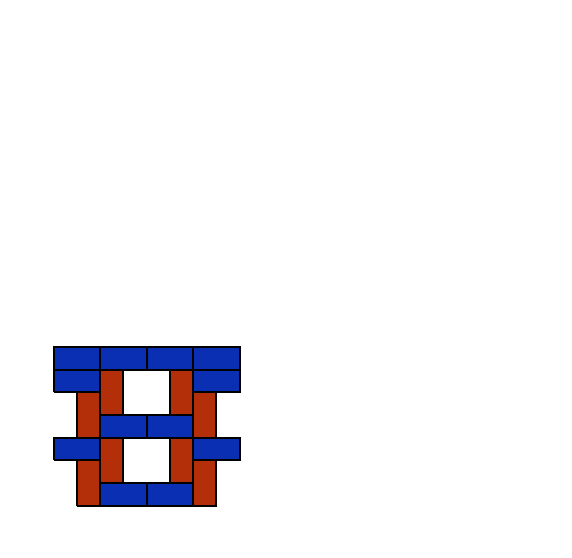

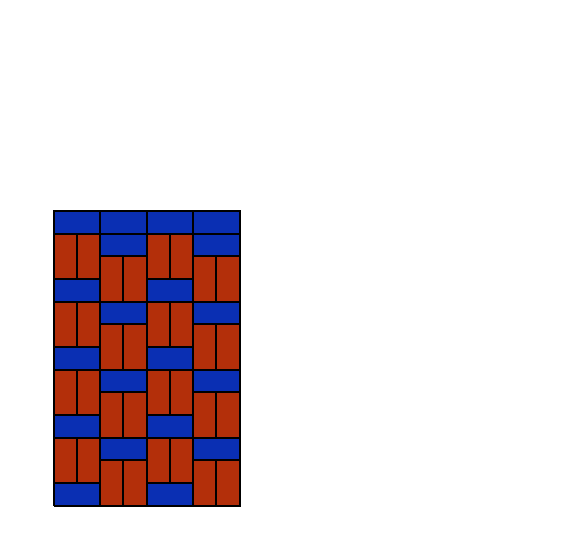

[<Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>]

In [19]:
[utils.draw_world(w) for w in random.sample(skyscrapers,10)]

#### Pairs of skyscrapers

In [20]:
MIN_SKYSCRAPER_GAP = 1
MAX_SKYSCRAPER_GAP = 4

In [21]:
cities = []
df_cities = pd.DataFrame()

for i, s1 in df_skyscrapers.iterrows():
    for j, s2 in df_skyscrapers.iterrows():
        for gap in range(MIN_SKYSCRAPER_GAP, MAX_SKYSCRAPER_GAP+1):
            
            w = new_world()
            w = w.place_tower(s1.blocks, 0)
            w.place_tower(s2.blocks, x_location = int(s1.structure_width+gap))
            
            if not w.broken:
                cities.append(w)
                df_cities = df_cities.append(
                    {
                        'structure_type': 'city',
                        'blocks': w.get_block_dict()['blocks'],
                        'structure_width': w.tower_width(),
                        'structure_height': w.tower_height(),
                        't_1_brick': s1.brick,
                        't_2_brick': s2.brick,
                        'gap': gap,
                        'roof_1_name': s1.roof_name,
                        'roof_2_name': s2.roof_name,
                        'skyscraper_1_height': s1.skyscraper_height,
                        'skyscraper_2_height': s2.skyscraper_height,
                    }, ignore_index=True
                )
            

KeyboardInterrupt: 

In [ ]:
len(cities)

In [ ]:
[utils.draw_world(w) for w in random.sample(cities,10)]

## Enumerate Houses

Wall, surrounded by two vertical lines
Pyramid roof
Chimney
Windows

In [53]:
HOUSE_WIDTHS = [1,2,3,4]
HOUSE_HEIGHTS = [1,2,3]

TILE_WIDTH = 4
TILE_HEIGHT = 4


MIN_DOOR = 0
MAX_DOOR = 2

HOUSE_ROOFS = {'pyramids': pyramids}

FIRST_STORY_COMPONENTS = [DOOR,
                            SMALL_WINDOW,
                            MANUAL_HOUSE_BRICKS]

OTHER_STORY_COMPONENTS = [
                            SMALL_WINDOW,
                            MANUAL_HOUSE_BRICKS]


# DOOR is also a component

In [54]:
first_stories = {}
for house_width in HOUSE_WIDTHS:
    # get all permutations of components
    repeated_components = [FIRST_STORY_COMPONENTS] * house_width
    first_stories[house_width] = list(product(*repeated_components))
#     floors[house_width] = list(combinations_with_replacement(HOUSE_COMPONENTS, house_width))


other_stories = {}
for house_width in HOUSE_WIDTHS:
    # get all permutations of components
    repeated_components = [OTHER_STORY_COMPONENTS] * house_width
    other_stories[house_width] = list(product(*repeated_components))

In [55]:
def floor_tuple_to_floor_world(tiles):
    w = new_world()
    for i, tile in enumerate(tiles):
        w.place_tower_relative(tile)
        
    return w

In [62]:
first_story_worlds[0].get_block_dict()['blocks']

[{'x': 0, 'y': 0, 'height': 2, 'width': 1},
 {'x': 0, 'y': 2, 'height': 2, 'width': 1},
 {'x': 3, 'y': 0, 'height': 2, 'width': 1},
 {'x': 3, 'y': 2, 'height': 2, 'width': 1}]

In [76]:
houses = []

for house_width in HOUSE_WIDTHS:
    first_story_worlds = [floor_tuple_to_floor_world(blocks) for blocks in first_stories[house_width]]
    other_story_worlds = [floor_tuple_to_floor_world(blocks) for blocks in other_stories[house_width]]
    
    for _, (roof_name, roof_type) in enumerate(HOUSE_ROOFS.items()):

        # one story
        for s_1 in first_story_worlds:

            w = new_world()
            w.place_tower(s_1.get_block_dict()['blocks'])
            w.place_tower(roof_type[house_width*4])

            if not(w.broken):
                    houses.append(w)

        # two story
        for s_1 in first_story_worlds:
            for s_2 in other_story_worlds:

                w = new_world()
                w.place_tower(s_1.get_block_dict()['blocks'])
                w.place_tower(s_2.get_block_dict()['blocks'])
                w.place_tower(s_2.get_block_dict()['blocks'])
                w.place_tower(roof_type[house_width*4])

                if not(w.broken):
                    houses.append(w)

        # two story
        for s_1 in first_story_worlds:
            for s_2 in other_story_worlds:
                for s_3 in other_story_worlds:

                    w = new_world()
                    w.place_tower(s_1.get_block_dict()['blocks'])
                    w.place_tower(s_2.get_block_dict()['blocks'])
                    w.place_tower(s_3.get_block_dict()['blocks'])
                    w.place_tower(roof_type[house_width*4])

                    if not(w.broken):
                        houses.append(w)


In [77]:
len(houses)

24294

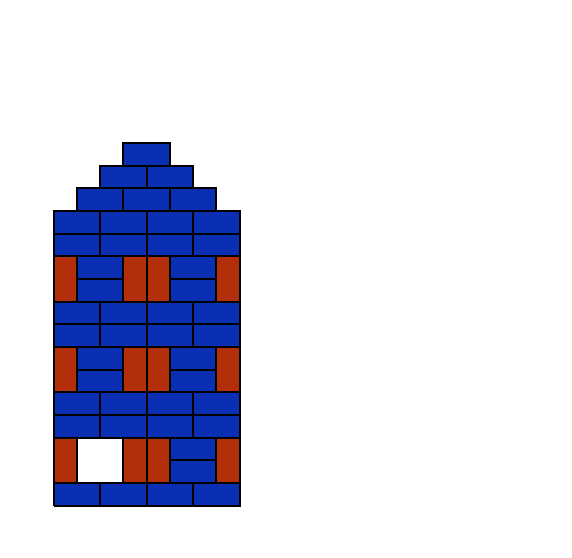

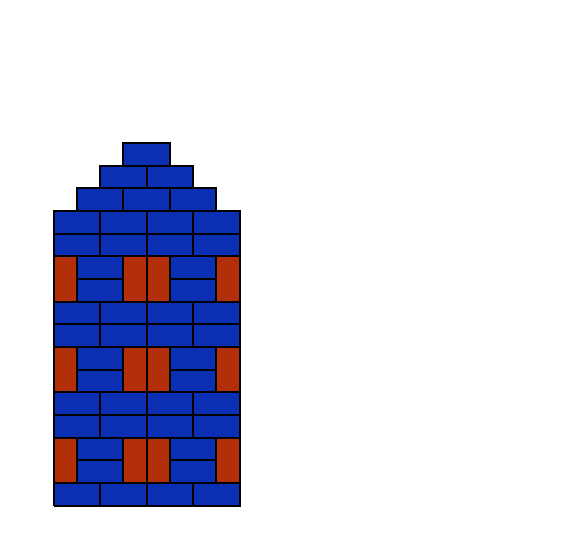

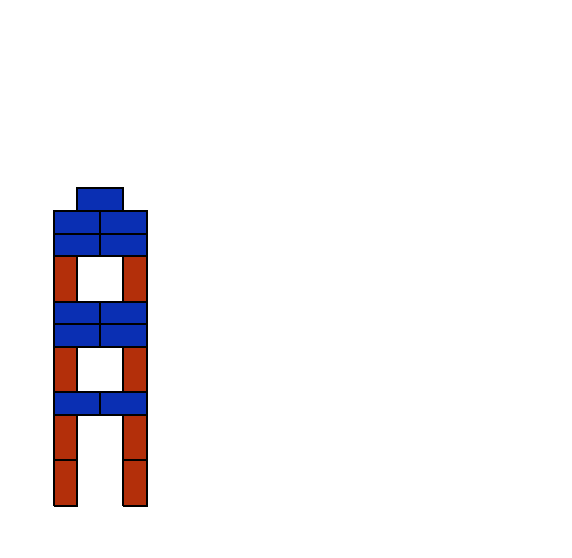

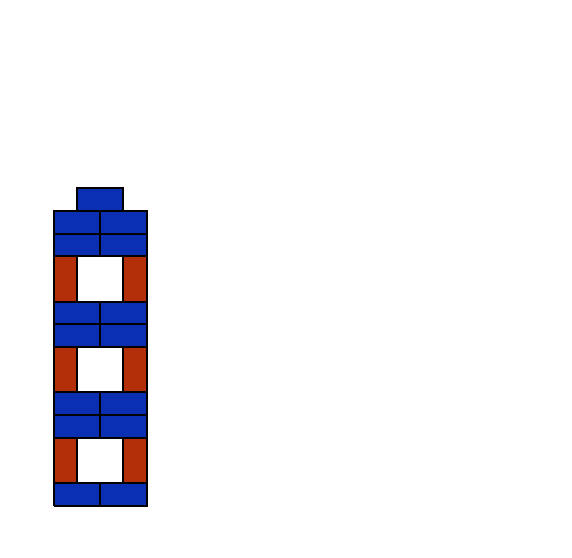

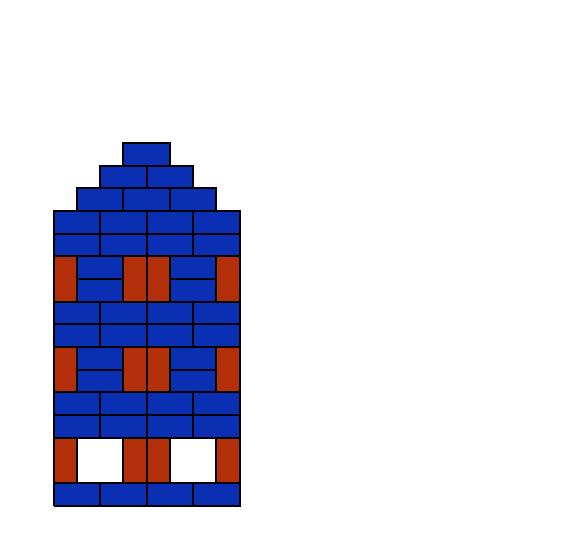

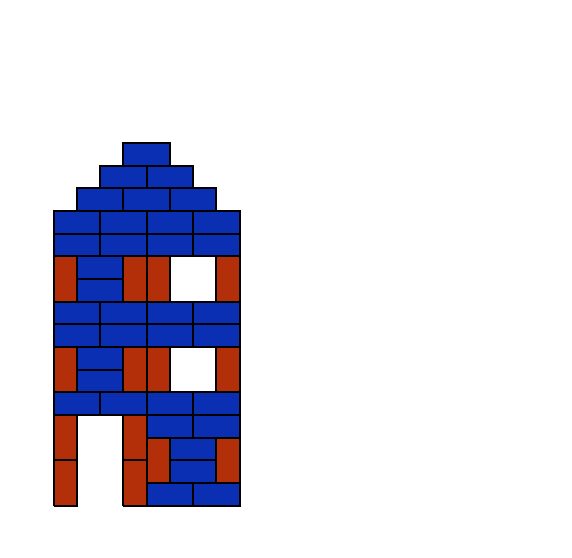

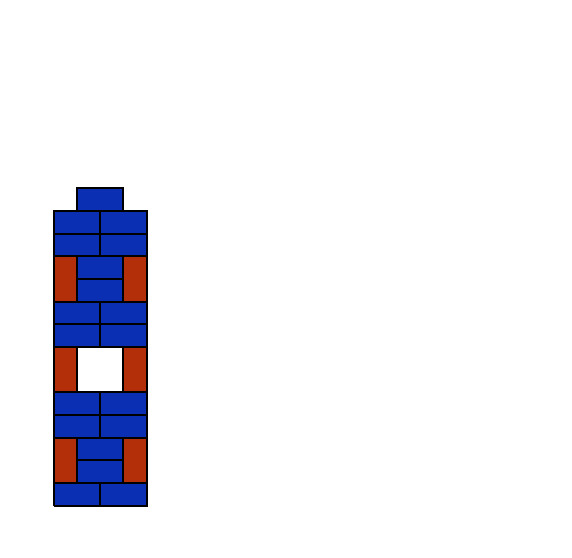

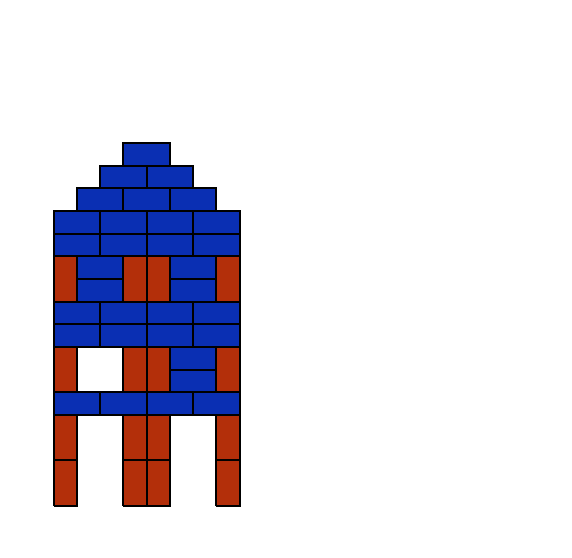

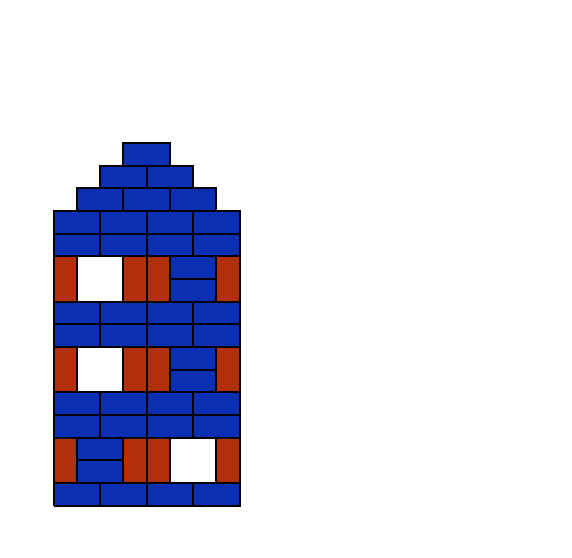

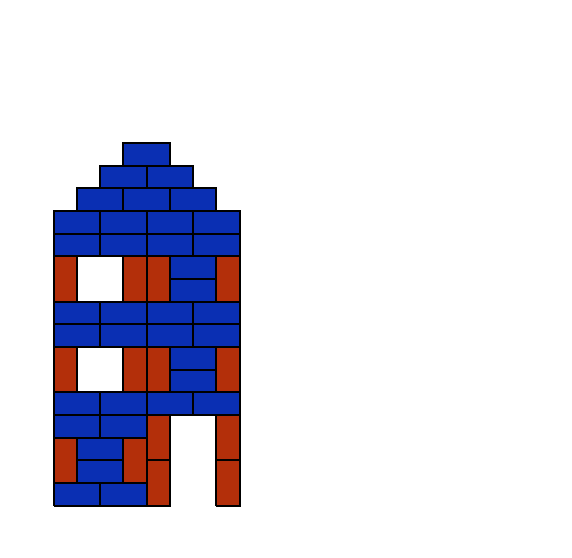

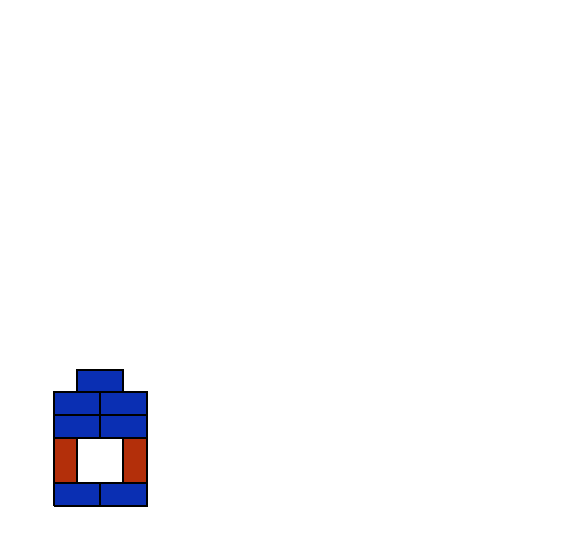

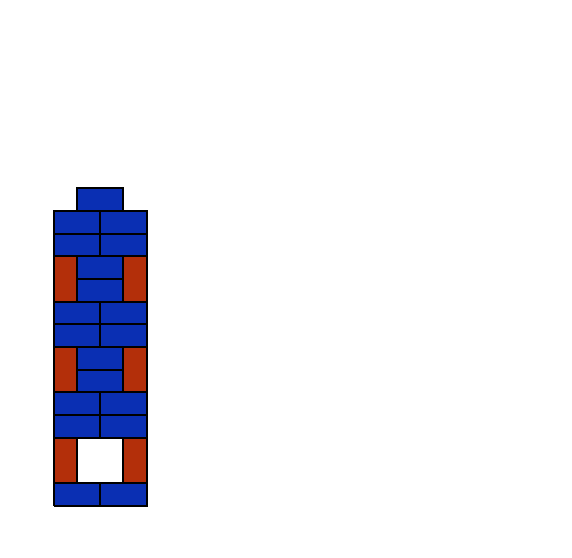

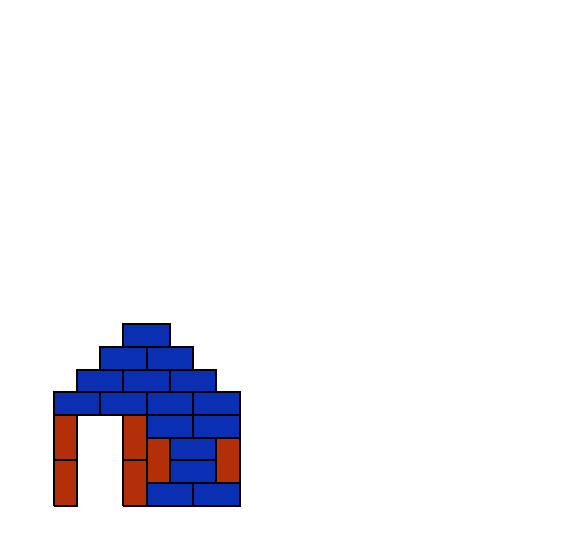

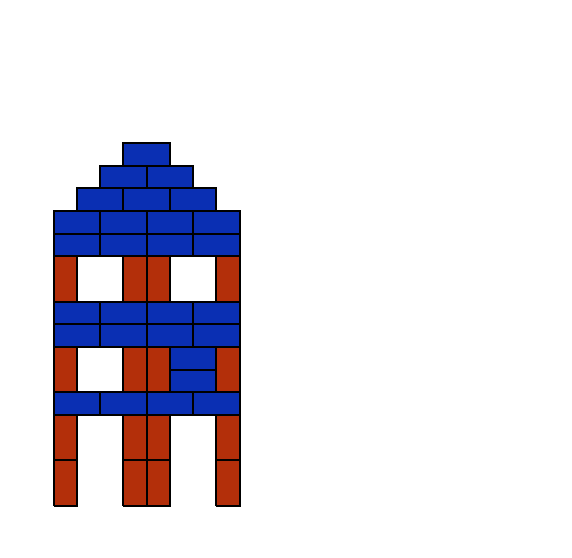

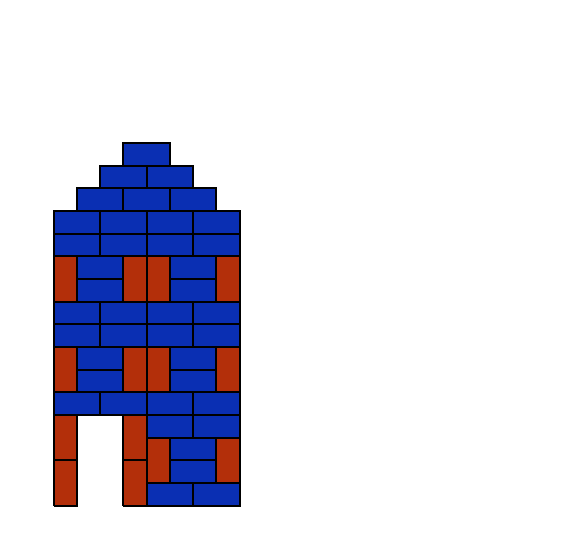

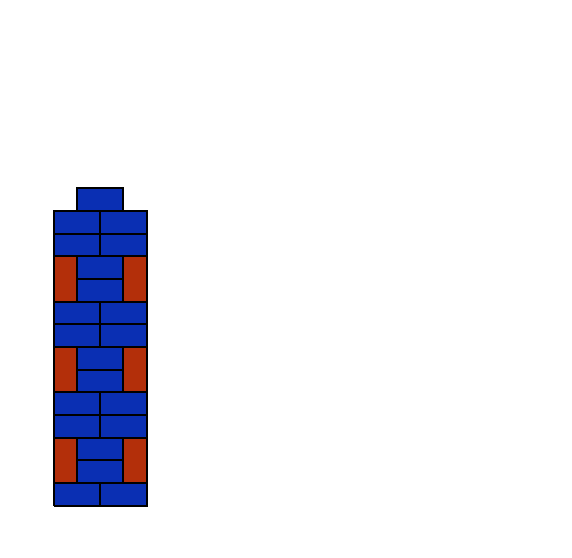

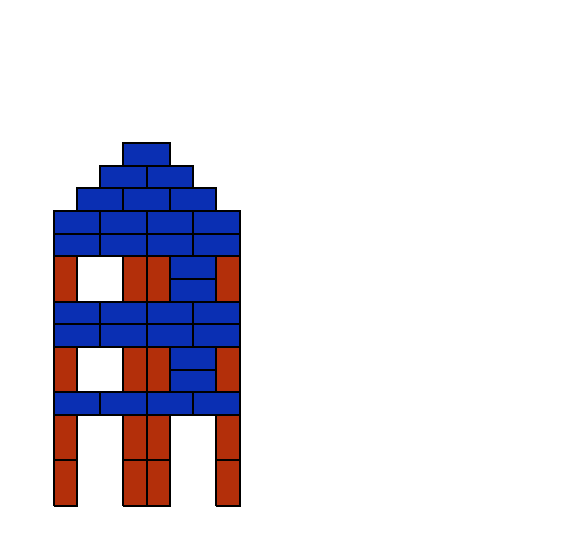

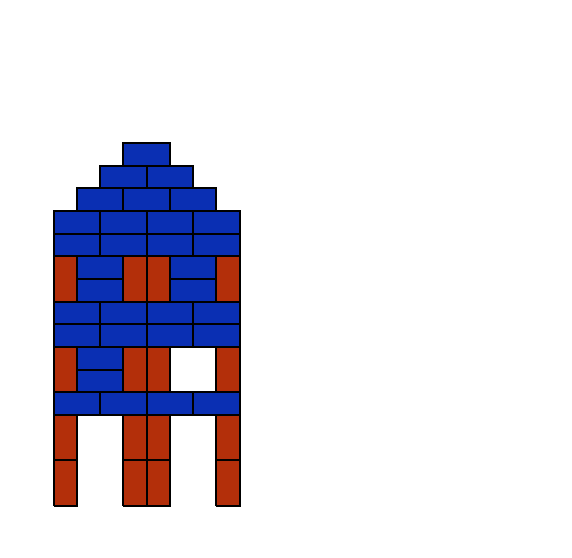

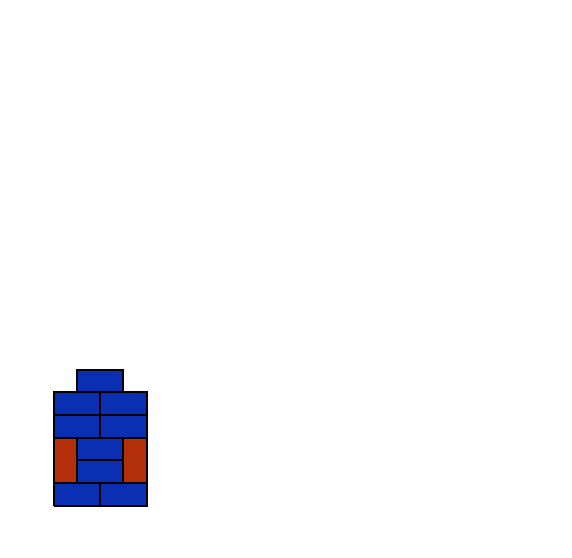

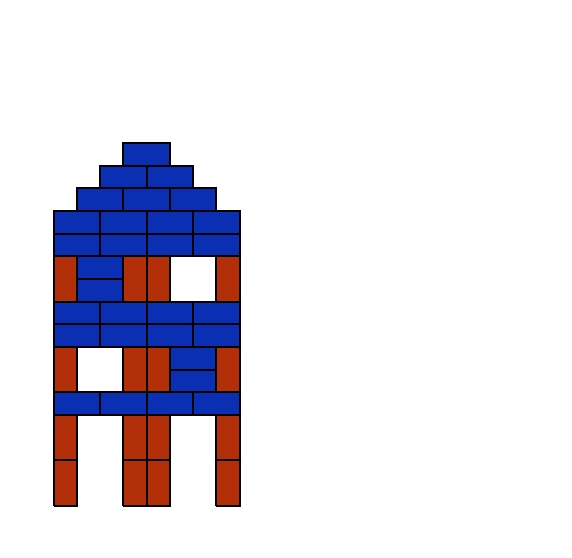

[<Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>]

In [84]:
[utils.draw_world(house) for house in random.sample(houses[1:100],20)]

## Enumerate Castles

- Bilateral symmetry
- Central wall constructed from one repeated 4-block motif (mirrored)
- Turrets constructed from one repeated 4-block motif (mirrored either side)
- Same style roof on turrets and center

In [22]:
MIN_CASTLE_WALL_HEIGHT = 1
MAX_CASTLE_WALL_HEIGHT = 4
CASTLE_WALL_SIZES = [2,4]


MIN_CASTLE_TOWER_HEIGHT = 1
MAX_CASTLE_TOWER_HEIGHT = 4

CASTLE_ROOFS = {'pyramid': pyramids,
         'dome': domes}


In [23]:
castles = []
df_castle = pd.DataFrame()

for wall_height in range(MIN_CASTLE_WALL_HEIGHT, MAX_CASTLE_WALL_HEIGHT + 1):
    
    # outer towers must be shorter 
    for tower_height in range(MIN_CASTLE_TOWER_HEIGHT, MAX_CASTLE_TOWER_HEIGHT + 1):
        
        for wall_size in CASTLE_WALL_SIZES:
            
             for wall_brick in tower_bricks_manual:
                    
                    for tower_brick in tower_bricks_manual:
                        
                        for _, (roof_name, roof_type) in enumerate(CASTLE_ROOFS.items()):

                            w = new_world() #castle object

                            #tower world object
                            tower_w = new_world()
                            tower_w = stack(tower_w, tower_brick, tower_height)
                            tower_width = tower_w.tower_width()
                            tower = tower_w.get_block_dict()['blocks']

                            #wall world object
                            wall_column_w = new_world()
                            wall_column_w = stack(wall_column_w, wall_brick, wall_height)
                            wall_column_width = wall_column_w.tower_width()
                            wall_column = wall_column_w.get_block_dict()['blocks']

                            # place left tower
                            w.place_tower_relative(tower)

                            # add dome to left tower
                            if tower_width >= 4:
                                w.place_tower(roof_type[tower_width])

                            # construct wall
                            for i in range(0,int(wall_size/2)):
                                w.place_tower_relative(wall_column)

                            for i in range(0,int(wall_size/2)):
                                w.place_tower_relative(mirror(wall_column))

                            wall_width = wall_column_width*wall_size

                            # add dome to wall
                            w.place_tower(roof_type[wall_width], tower_width)

                            # place right tower
                            w.place_tower_relative(mirror(tower))

                            # add dome to right tower
                            if tower_width >= 4:
                                w.place_tower(roof_type[tower_width], tower_width + wall_width)


                            if not(w.broken):
                                castles.append(w)
                                df_castle = df_castle.append(
                                    {
                                        'structure_type': 'castle',
                                        'blocks': w.get_block_dict(),
                                        'structure_width': w.tower_width(),
                                        'structure_height': w.tower_height(),
                                        'wall_height': wall_height,
                                        'wall_size': wall_size,
                                        'tower_height': tower_height,
                                        'roof_name': roof_name,
                                        'central_roof_size': wall_width,
                                        'tower_roof_size': tower_width,
                                    }, ignore_index=True
                                )
    #                             fig = utils.draw_world(w)
    #                             n_towers += 1


In [24]:
len(castles)

3120

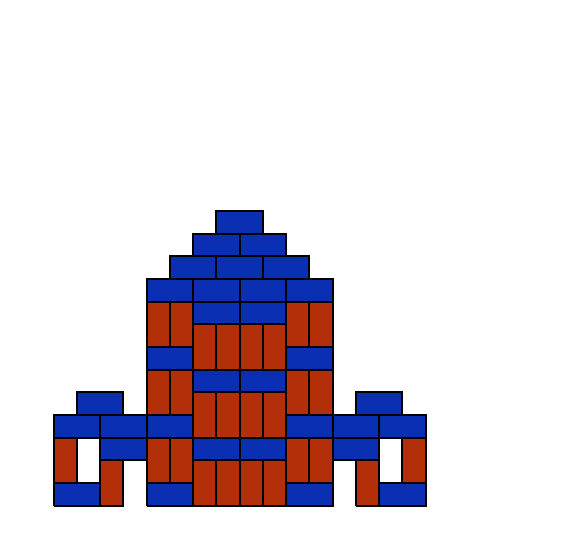

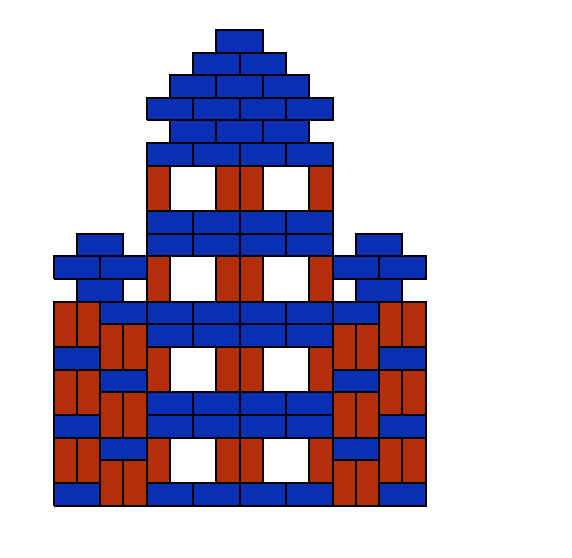

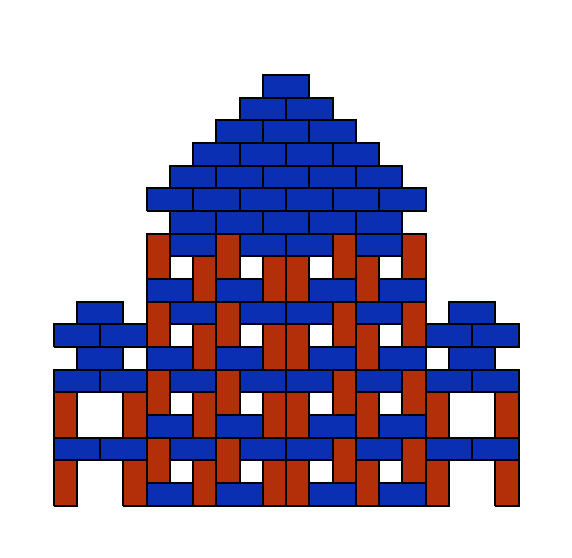

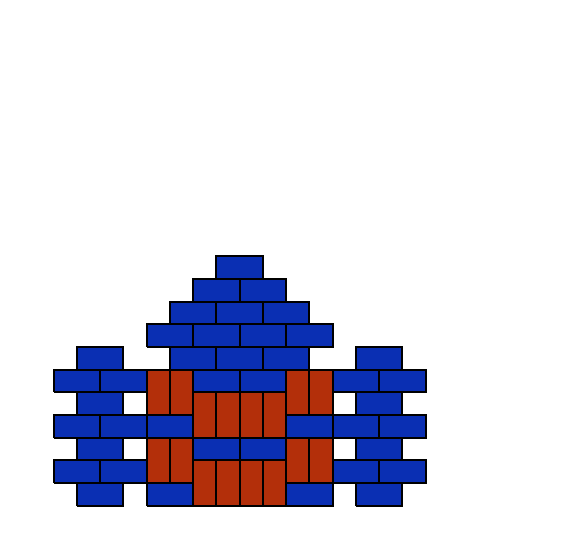

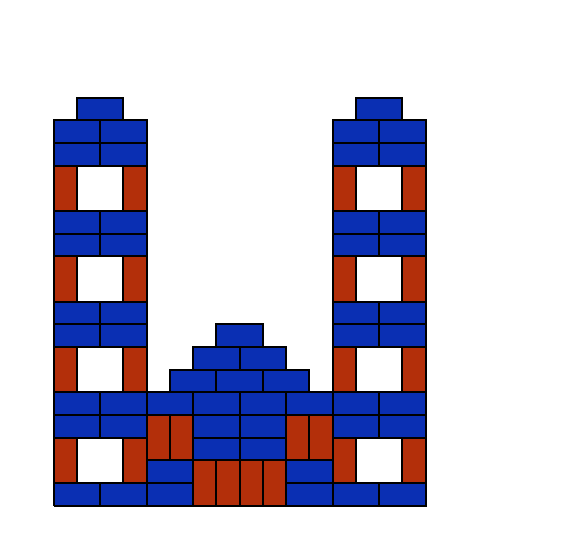

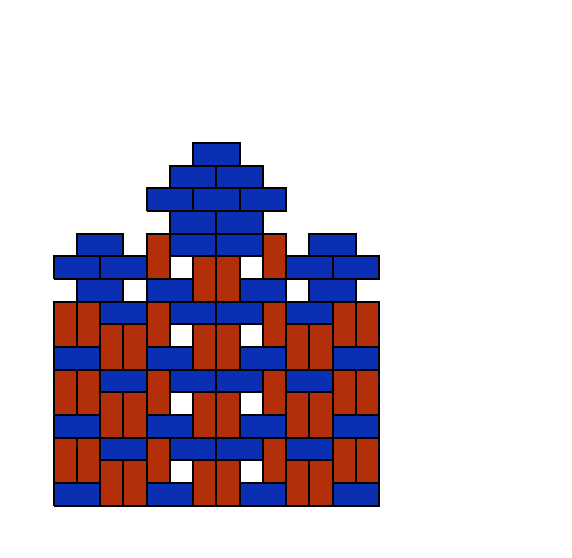

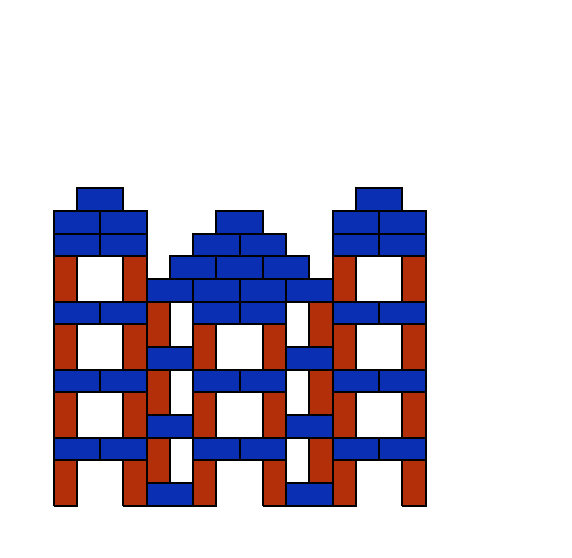

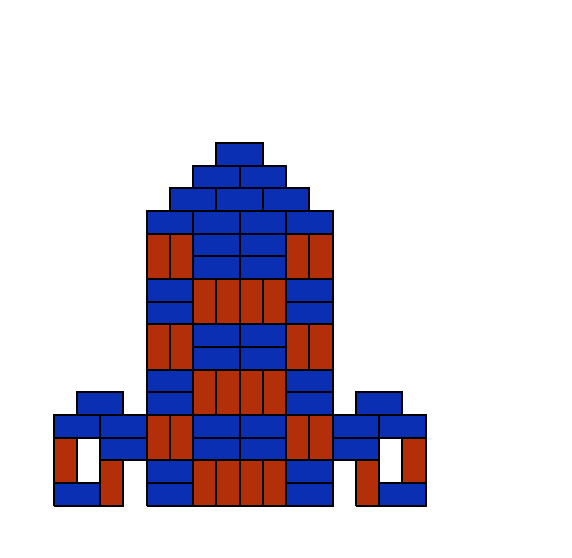

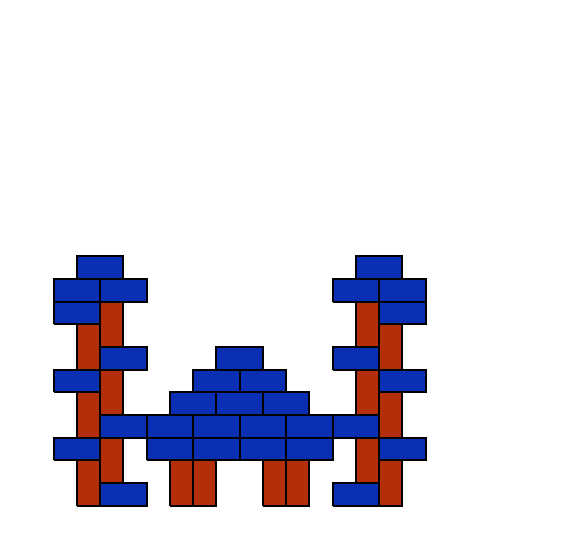

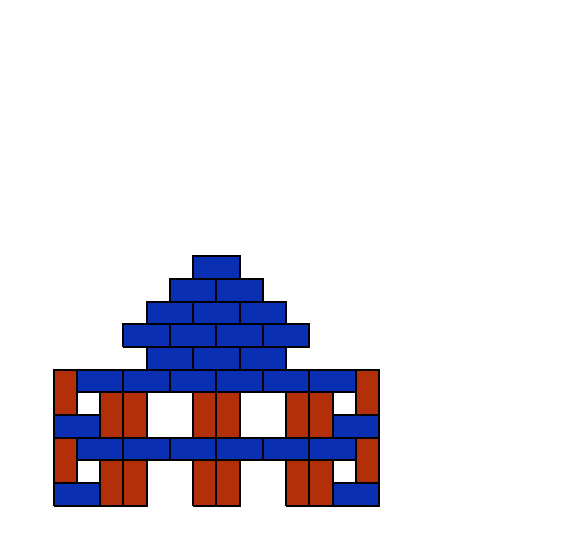

[<Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>]

In [30]:
[utils.draw_world(w) for w in random.sample(castles,10)]

In [1106]:
# # export to inidividual jsons

# filepath ='./tower-iclr-test-1-json/'

# if not os.path.exists(filepath):
#         os.makedirs(filepath)

# for i in df_castle.index:
#     df_castle.loc[i].to_json("./{}/{}_{}.json".format(filepath, 
#                                                df_castle.loc[i,'structure_type'], 
#                                                str(i).zfill(3)))

## Enumerate Bridges

In [1639]:
# MIN_N_ARCHES = 2
# MAX_N_ARCHES = 5
# ARCH_WIDTHS = [4,6,8]
# MIN_ARCH_LAYERS = 1
# MAX_ARCH_LAYERS = 4
# MAX_BRIDGE_TOWER_HEIGHT = 3

In [1660]:
# OLD VERSION WITH TOWERS

# df_bridges = pd.DataFrame()
# bridges = []

# for n_arch in range(MIN_N_ARCHES, MAX_N_ARCHES+1):
    
#     for arch_width in ARCH_WIDTHS:
        
#         for arch_layers in range(MIN_ARCH_LAYERS, MAX_ARCH_LAYERS):
            
#             for _, (tower_name, tower_type) in enumerate(BRIDGE_TOWERS.items()):
                
#                 for tower_height in range(1, MAX_BRIDGE_TOWER_HEIGHT+1):

#                     w = new_world()

#                     a_w = new_world()
#                     bridge_arch(a_w, arch_layers, width=arch_width)

#                     for a in range(0, n_arch):
#                         w.place_tower_relative(a_w.get_block_dict()['blocks'])

#                     viaduct(w)

#                     if (tower_name != 'none'):
                        
#                         for l in range(0,tower_height):
#                             w.place_tower(tower_type, x_location=0)
#                             w.place_tower(tower_type, x_location=w.tower_width()-4)

#                         w.place_tower(VERTICAL, x_location=0)
#                         w.place_tower(VERTICAL, x_location=3)
#                         w.place_tower(VERTICAL, x_location=w.tower_width()-4)
#                         w.place_tower(VERTICAL, x_location=w.tower_width()-4+3)

#                     if not(w.broken) and ((w.tower_width() > 8) or (tower_name == 'none')):
#                         bridges.append(w)

In [1664]:
# SIMPLE VERSION

# simple_bridges = []

# for n_arch in range(MIN_N_ARCHES, MAX_N_ARCHES+1):
    
#     for arch_width in ARCH_WIDTHS:
        
#         for arch_layers in range(MIN_ARCH_LAYERS, MAX_ARCH_LAYERS):
            
#             w = new_world()

#             a_w = new_world()
#             bridge_arch(a_w, arch_layers, width=arch_width)

#             for a in range(0, n_arch):
#                 w.place_tower_relative(a_w.get_block_dict()['blocks'])

# #             viaduct(w)

#             if not(w.broken) and ((w.tower_width() > 8) or (tower_name == 'none')):
#                 simple_bridges.append(w)

In [26]:
MIN_N_ARCHES = 1
MAX_N_ARCHES = 5
MAX_BRIDGE_ELEVATION = 5

INNER_ARCH_WIDTHS = [4, 6, 8]
OUTER_ARCH_WIDTHS = [0, 4, 6, 8]

MIN_BRIDGE_THICKNESS = 0
MAX_BRIDGE_THICKNESS = 2

PILLAR_TYPES = ['none','uniform','high_middle','high_ends']

In [27]:
bridges = []

for n_inner_arch in range(MIN_N_ARCHES, MAX_N_ARCHES+1):

    for bridge_elevation in range(1, MAX_BRIDGE_ELEVATION):

        for inner_width in INNER_ARCH_WIDTHS:

            for outer_width in OUTER_ARCH_WIDTHS:
                
                for pillar_type in PILLAR_TYPES:
                    
                    for bridge_thickness in range(MIN_BRIDGE_THICKNESS, MAX_BRIDGE_THICKNESS+1):

                        if outer_width == inner_width:
                            continue

                        w = new_world()

                        # create outer arches
                        if outer_width != 0:
                            outer_arch = ARCHES_EQUAL_HEIGHTS[outer_width]
                            outer_arch_world = new_world()
                            outer_arch_world.place_tower(outer_arch)


                        # create inner arches
                        inner_arch = ARCHES_EQUAL_HEIGHTS[inner_width]
                        inner_arch_world = new_world()
                        inner_arch_world.place_tower(inner_arch)


                        if outer_width != 0:
                            # place blocks under left outer arch
                            for j in range(0, bridge_elevation):
                                w.place_tower(VERTICAL, 
                                              x_location=0)
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width-1)
                            # place left outer arch
                            w.place_tower(outer_arch)


                        for i in range(0,n_inner_arch):
                            # place blocks under inner arches
                            for j in range(0, bridge_elevation):
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width+(i*inner_width))
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width+((i+1)*inner_width)-1)
                            # place inner arche
                            w.place_tower(inner_arch,
                                          x_location=outer_width+i*inner_width)

                        if outer_width != 0:
                            # place blocks under right outer arch
                            for j in range(0, bridge_elevation):
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width+(n_inner_arch*inner_width))
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width+(n_inner_arch*inner_width)+outer_width-1)
                            # place right outer arch
                            w.place_tower(outer_arch,
                                          x_location=outer_width+(n_inner_arch*inner_width))


                        # Add layer of blue    
                        for i in range(0, bridge_thickness):
                            if i%2 == 0:
                                horizontal_brick_layer(w, w.tower_width()-2, x_location = 1)
                            else:
                                horizontal_brick_layer(w, w.tower_width(), x_location = 0)
                            
                            
                        # find where to place suspension pillars
                        if pillar_type != 'none':
                            arch_widths = []

                            if outer_width > 0:
                                arch_widths.append(outer_width)

                            for i in range(0, n_inner_arch):
                                arch_widths.append(inner_width)

                            if outer_width > 0:
                                arch_widths.append(outer_width)

                            arch_widths

                            pillar_locations = []

                            for arch_width in arch_widths:

                                if pillar_locations == []:
                                    pillar_locations.append(0)
                                    pillar_locations.append(arch_width-1)
                                else:
                                    pillar_locations.append(pillar_locations[-1]+1)
                                    pillar_locations.append(pillar_locations[-1]+arch_width-1)


                            if pillar_type == 'uniform':
                                for x_location in pillar_locations:
                                    w.place_tower(VERTICAL, 
                                                  x_location=x_location)

                            elif pillar_type == 'high_middle':

                                while len(pillar_locations)>=2:
                                    for x_location in pillar_locations:
                                        w.place_tower(VERTICAL, 
                                                      x_location=x_location)

                                    pillar_locations = pillar_locations[1:-1]

                            elif pillar_type == 'high_ends':

                                while len(pillar_locations)>=2:
                                    for x_location in pillar_locations:
                                        w.place_tower(VERTICAL, 
                                                      x_location=x_location)

                                    pillar_locations = pillar_locations[0:int(len(pillar_locations)/2)-1] + pillar_locations[int(len(pillar_locations)/2)+1:]


                        if not(w.broken):
                                bridges.append(w)


In [28]:
len(bridges)

816

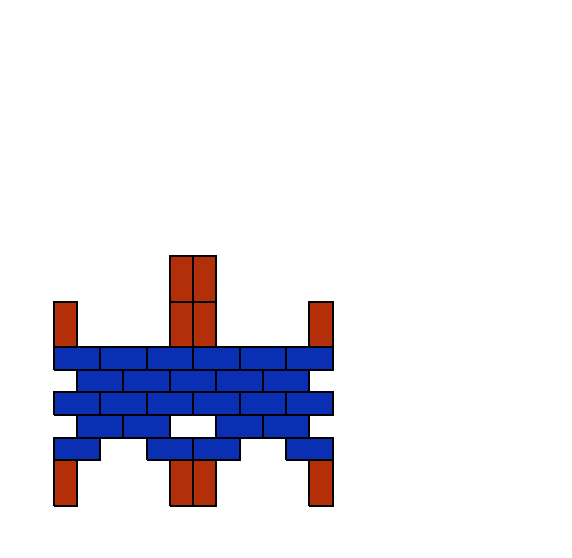

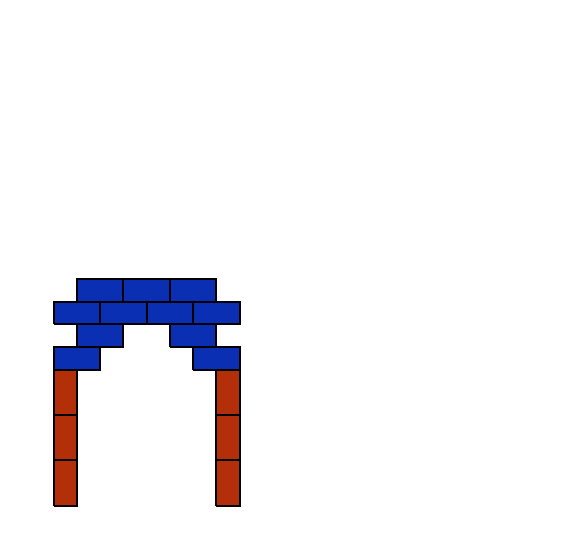

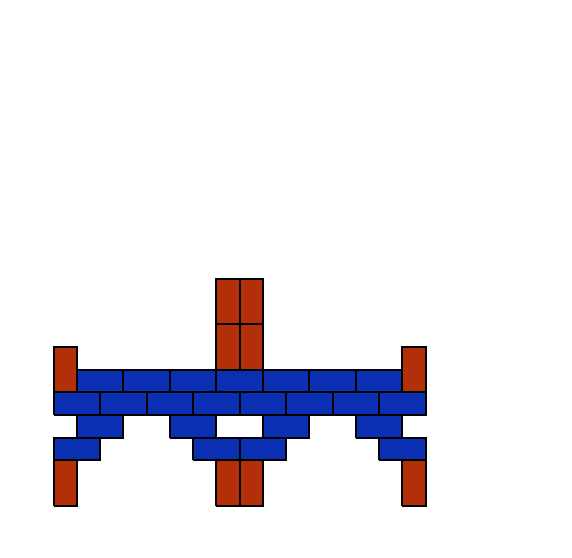

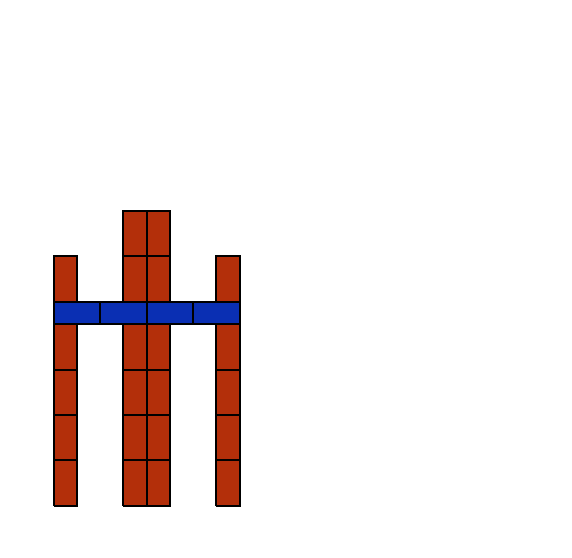

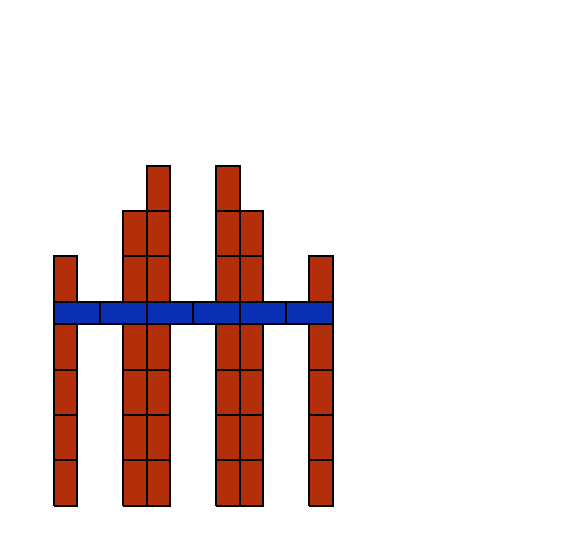

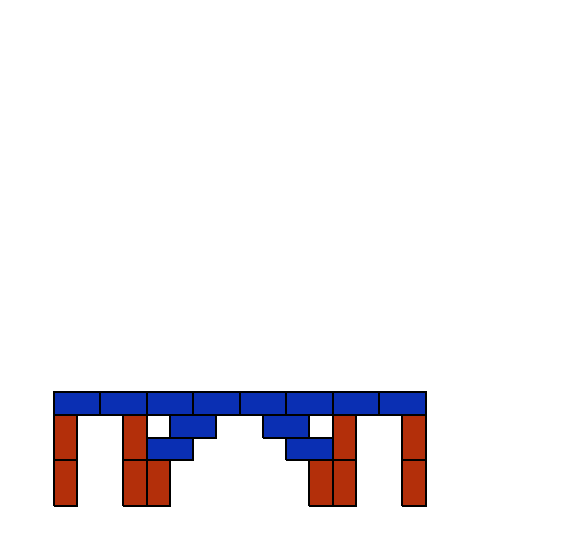

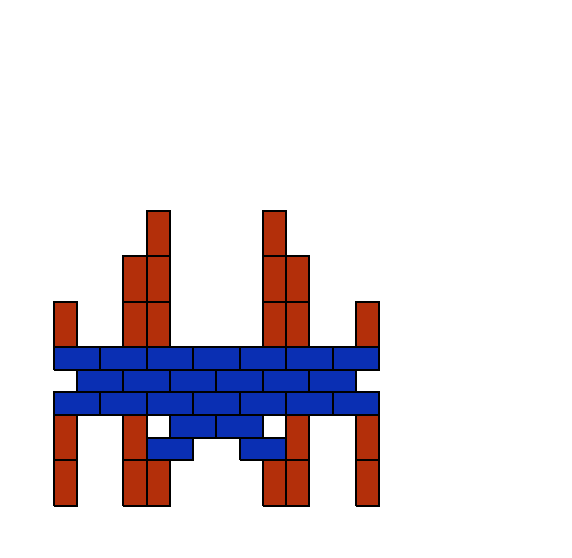

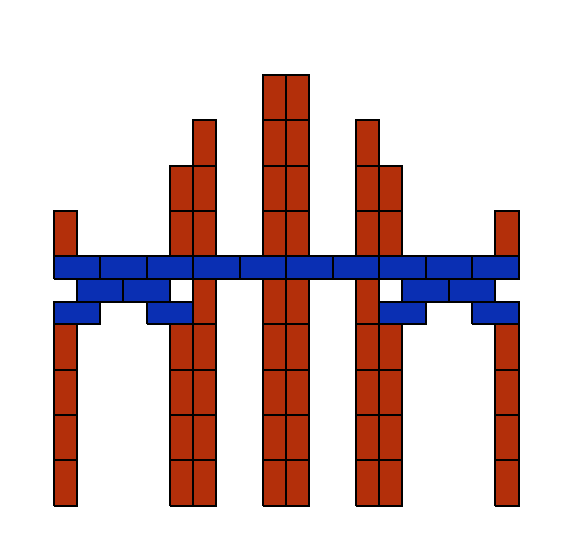

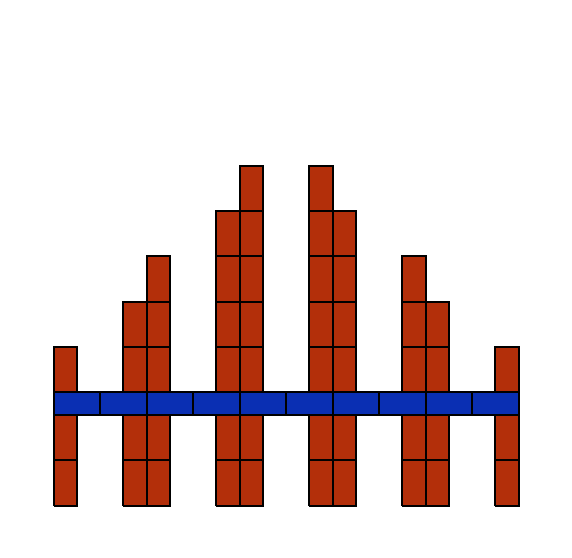

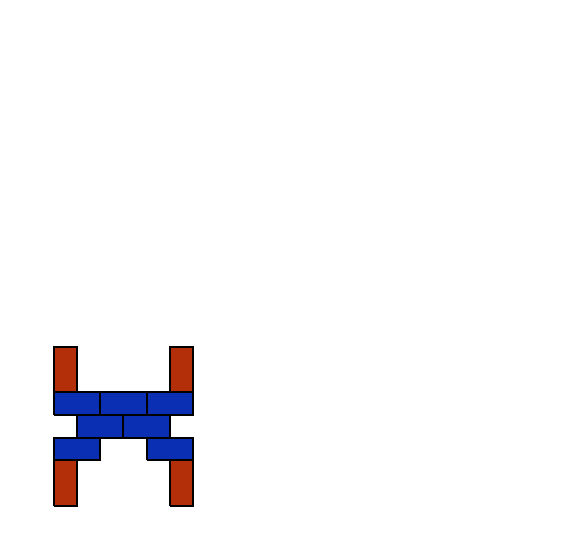

In [29]:
_ = [utils.draw_world(w) for w in random.sample(bridges,10)]

In [1812]:
importlib.reload(utils)

<module 'blockworld_utils' from '/Users/will/lax/stimuli/towers/block_utils/blockworld_utils.py'>

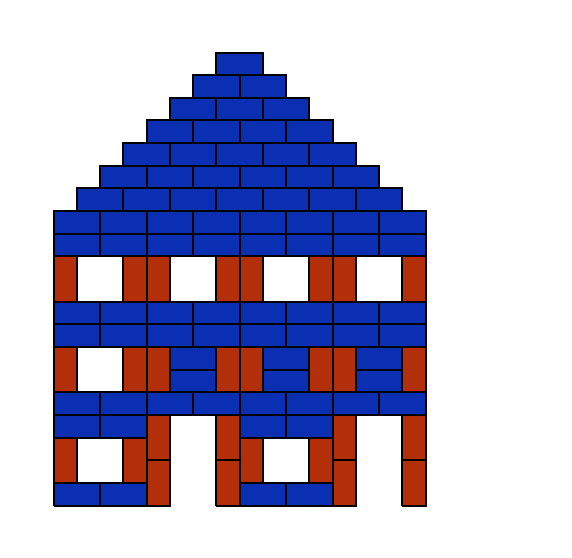

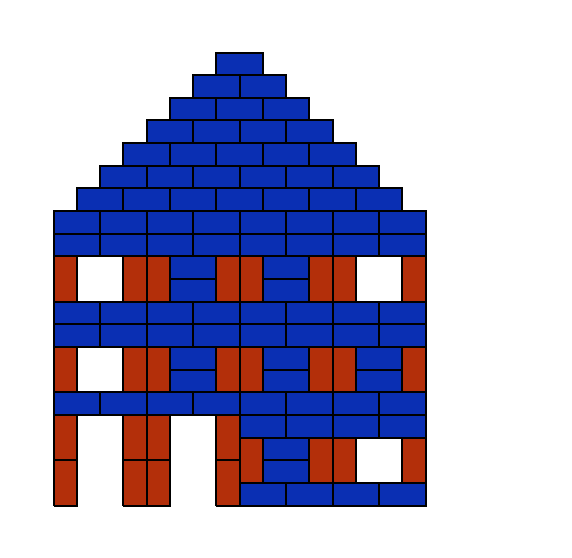

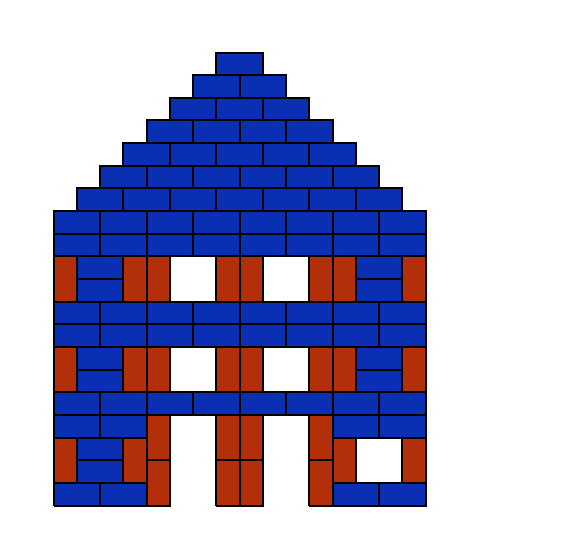

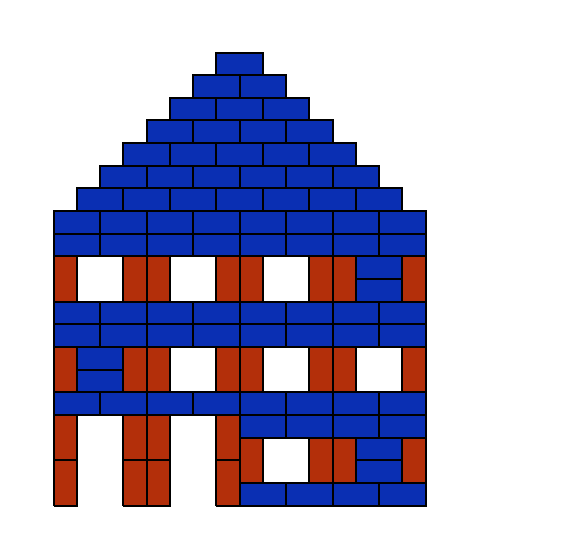

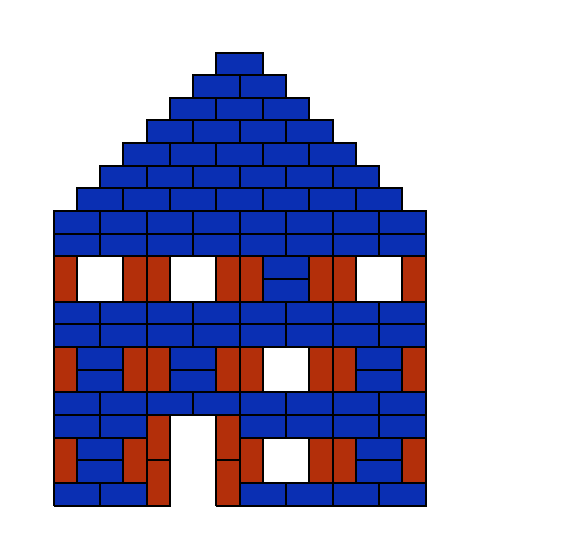

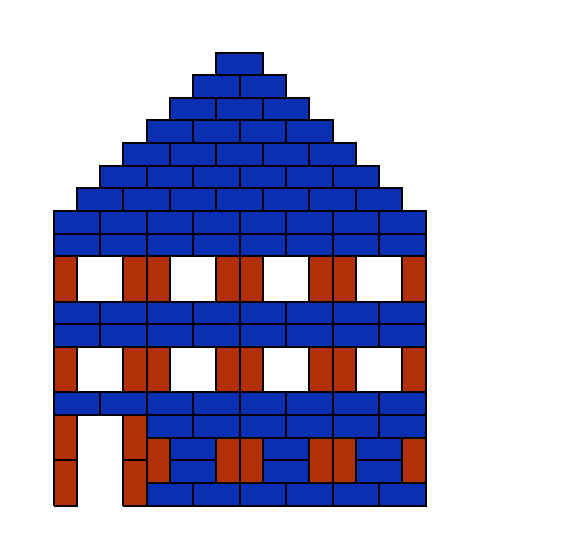

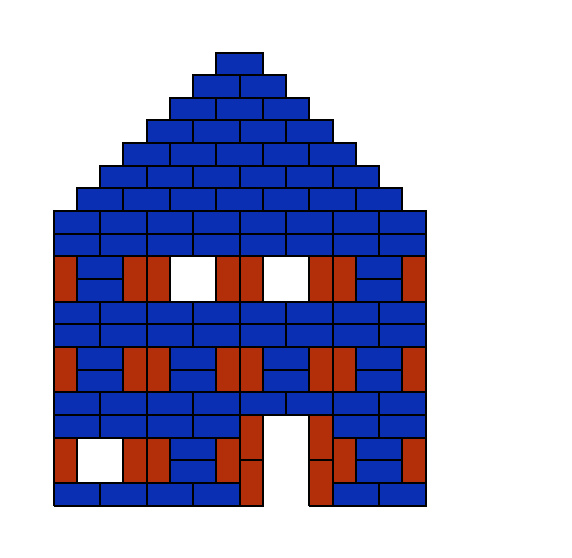

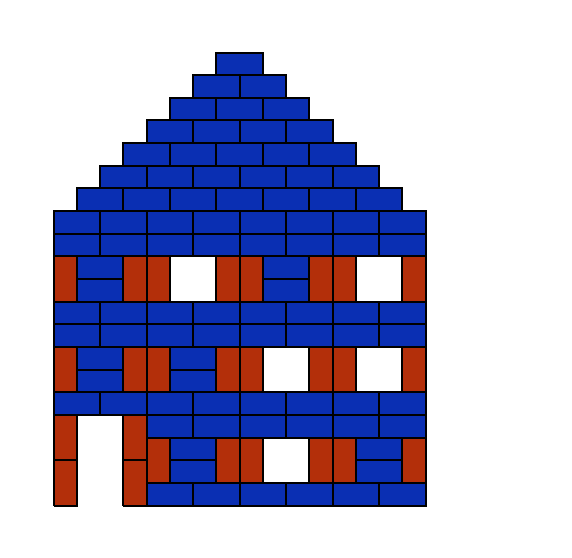

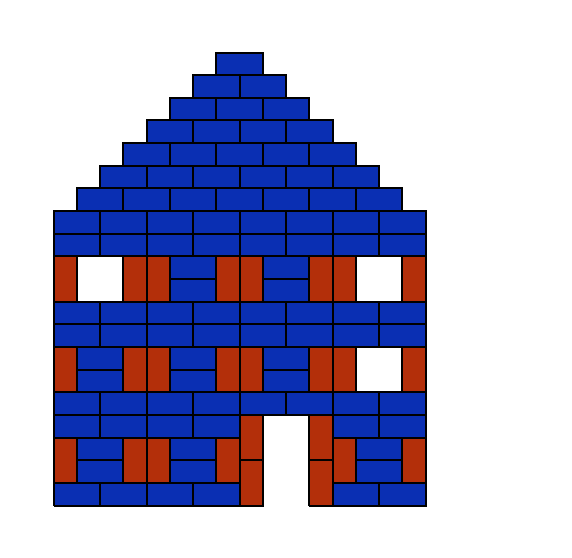

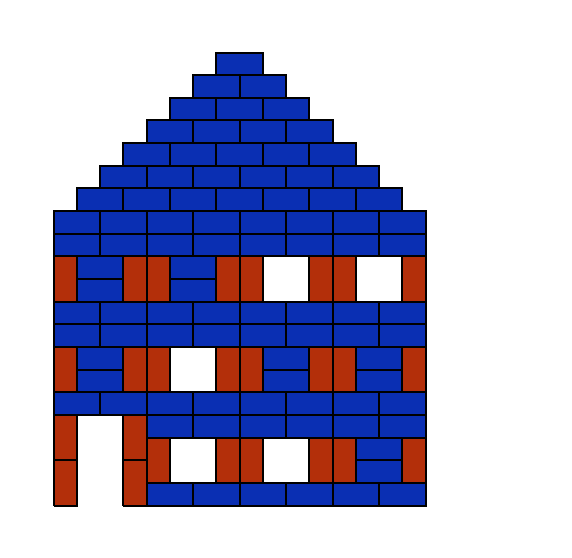

In [87]:
for i, w in enumerate(random.sample(houses,10)):
    fig = utils.draw_world(w)
    fig.savefig('./castle_examples/houses_wide_demo_'+str(i).zfill(3))

## Exporting stims

- Sample 250 (200 test plus 50 train) from each
- Upload to S3


In [ ]:
# concat dataframes
df_structures = pd.concat([df_castles, df_skyscrapers, df_bridges, df_houses], ignore_index=True)
df_structures.reset_index()

# sample stim set
random_seed = 0




In [90]:
len(w.blocks)

118